In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
    #     softmax_activation = nn.LogSoftmax(dim=1)
    #     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)


    #     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
    #     classifier.to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)

        model = EEGNet_DF_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
    #     model= EEGNet_Wrapper(DEVICE, df)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_DF_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_DF_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 14.668890541675044


Iterations:   0%|                                   | 1/300 [00:02<13:54,  2.79s/it]

Epoch:  0
t_loss:  14.668890541675044 , v_loss:  0.6924463510513306
t_acc:  0.585745409274821 , v_acc:  0.6894409937888198
t_recall:  0.4989507418234721 , v_recall:  0.5
t_prec:  0.4988944910127687 , v_prec:  0.3447204968944099
t_f:  0.4985203046658511 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:26,  1.70s/it]

Epoch  1 , loss 14.543239107318954
Epoch  2 , loss 14.412368325626149


Iterations:   1%|▎                                  | 3/300 [00:05<08:00,  1.62s/it]

Epoch:  2
t_loss:  14.412368325626149 , v_loss:  0.690567413965861
t_acc:  0.6694677871148459 , v_acc:  0.6894409937888198
t_recall:  0.5001852843084778 , v_recall:  0.5
t_prec:  0.5006256256256256 , v_prec:  0.3447204968944099
t_f:  0.4537855562214743 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:34,  1.33s/it]

Epoch  3 , loss 14.29660395079968
Epoch  4 , loss 14.185352662030388


Iterations:   2%|▌                                  | 5/300 [00:07<06:49,  1.39s/it]

Epoch:  4
t_loss:  14.185352662030388 , v_loss:  0.6807411511739095
t_acc:  0.6912542794895736 , v_acc:  0.6894409937888198
t_recall:  0.5000308807180797 , v_recall:  0.5
t_prec:  0.500590179414542 , v_prec:  0.3447204968944099
t_f:  0.41919993702357683 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:01,  1.23s/it]

Epoch  5 , loss 14.080116496366614
Epoch  6 , loss 13.98767951890534


Iterations:   2%|▊                                  | 7/300 [00:10<06:26,  1.32s/it]

Epoch:  6
t_loss:  13.98767951890534 , v_loss:  0.6647066275278727
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.5002552806027916 , v_recall:  0.5
t_prec:  0.514526710402999 , v_prec:  0.3447204968944099
t_f:  0.4137166365643187 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:47,  1.19s/it]

Epoch  7 , loss 13.89008430406159
Epoch  8 , loss 13.80007053824032


Iterations:   3%|█                                  | 9/300 [00:12<06:15,  1.29s/it]

Epoch:  8
t_loss:  13.80007053824032 , v_loss:  0.6743477582931519
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8481308411214954 , v_prec:  0.3447204968944099
t_f:  0.4135264235347638 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:13<05:41,  1.18s/it]

Epoch  9 , loss 13.705885494456572
Epoch  10 , loss 13.62724225661334


Iterations:   4%|█▏                                | 11/300 [00:14<06:10,  1.28s/it]

Epoch:  10
t_loss:  13.62724225661334 , v_loss:  0.7074491083621979
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:38,  1.18s/it]

Epoch  11 , loss 13.536604712991153
Epoch  12 , loss 13.459748866511326


Iterations:   4%|█▍                                | 13/300 [00:17<06:07,  1.28s/it]

Epoch:  12
t_loss:  13.459748866511326 , v_loss:  0.7322777907053629
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:34,  1.17s/it]

Epoch  13 , loss 13.379614231633205
Epoch  14 , loss 13.302074376274557


Iterations:   5%|█▋                                | 15/300 [00:19<06:03,  1.28s/it]

Epoch:  14
t_loss:  13.302074376274557 , v_loss:  0.7508875032265981
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:31,  1.17s/it]

Epoch  15 , loss 13.21585256913129
Epoch  16 , loss 13.136063239153694


Iterations:   6%|█▉                                | 17/300 [00:22<05:59,  1.27s/it]

Epoch:  16
t_loss:  13.136063239153694 , v_loss:  0.7547941952943802
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:23<05:29,  1.17s/it]

Epoch  17 , loss 13.053213100807339
Epoch  18 , loss 12.973095949958353


Iterations:   6%|██▏                               | 19/300 [00:24<05:57,  1.27s/it]

Epoch:  18
t_loss:  12.973095949958353 , v_loss:  0.7519499560197195
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:27,  1.17s/it]

Epoch  19 , loss 12.900398665783452
Epoch  20 , loss 12.81636038013533


Iterations:   7%|██▍                               | 21/300 [00:27<05:55,  1.27s/it]

Epoch:  20
t_loss:  12.81636038013533 , v_loss:  0.7513890266418457
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:24,  1.17s/it]

Epoch  21 , loss 12.7431515899359
Epoch  22 , loss 12.670055912990197


Iterations:   8%|██▌                               | 23/300 [00:29<05:52,  1.27s/it]

Epoch:  22
t_loss:  12.670055912990197 , v_loss:  0.7405334860086441
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:22,  1.17s/it]

Epoch  23 , loss 12.587151677000756
Epoch  24 , loss 12.517701317282285


Iterations:   8%|██▊                               | 25/300 [00:32<05:51,  1.28s/it]

Epoch:  24
t_loss:  12.517701317282285 , v_loss:  0.7344729055960973
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:21,  1.17s/it]

Epoch  25 , loss 12.437753322077732
Epoch  26 , loss 12.361961196450626


Iterations:   9%|███                               | 27/300 [00:34<05:50,  1.29s/it]

Epoch:  26
t_loss:  12.361961196450626 , v_loss:  0.7348728974660238
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:22,  1.18s/it]

Epoch  27 , loss 12.289319917267443
Epoch  28 , loss 12.214245983198577


Iterations:  10%|███▎                              | 29/300 [00:36<05:49,  1.29s/it]

Epoch:  28
t_loss:  12.214245983198577 , v_loss:  0.7319267888863882
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:18,  1.18s/it]

Epoch  29 , loss 12.13392641030106
Epoch  30 , loss 12.061201525669471


Iterations:  10%|███▌                              | 31/300 [00:39<05:43,  1.28s/it]

Epoch:  30
t_loss:  12.061201525669471 , v_loss:  0.7236837397019068
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:16,  1.18s/it]

Epoch  31 , loss 11.984540845833573
Epoch  32 , loss 11.915153297723508


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.32s/it]

Epoch:  32
t_loss:  11.915153297723508 , v_loss:  0.7187809497117996
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 11.835394017836627
Epoch  34 , loss 11.762950897216797


Iterations:  12%|███▉                              | 35/300 [00:44<05:45,  1.30s/it]

Epoch:  34
t_loss:  11.762950897216797 , v_loss:  0.7036840617656708
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:45<05:14,  1.19s/it]

Epoch  35 , loss 11.683687340979482
Epoch  36 , loss 11.612861109714881


Iterations:  12%|████▏                             | 37/300 [00:46<05:39,  1.29s/it]

Epoch:  36
t_loss:  11.612861109714881 , v_loss:  0.6921034355958303
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:10,  1.19s/it]

Epoch  37 , loss 11.539391966427074
Epoch  38 , loss 11.463176016714058


Iterations:  13%|████▍                             | 39/300 [00:49<05:35,  1.29s/it]

Epoch:  38
t_loss:  11.463176016714058 , v_loss:  0.6816970109939575
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:06,  1.18s/it]

Epoch  39 , loss 11.389899889628092
Epoch  40 , loss 11.314727858001111


Iterations:  14%|████▋                             | 41/300 [00:51<05:30,  1.28s/it]

Epoch:  40
t_loss:  11.314727858001111 , v_loss:  0.6717953582604727
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:02,  1.17s/it]

Epoch  41 , loss 11.244732146169625
Epoch  42 , loss 11.163302627264285


Iterations:  14%|████▊                             | 43/300 [00:54<05:28,  1.28s/it]

Epoch:  42
t_loss:  11.163302627264285 , v_loss:  0.664900208512942
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:55<04:59,  1.17s/it]

Epoch  43 , loss 11.090872502794452
Epoch  44 , loss 11.018773808198816


Iterations:  15%|█████                             | 45/300 [00:56<05:26,  1.28s/it]

Epoch:  44
t_loss:  11.018773808198816 , v_loss:  0.6552374611298243
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<04:59,  1.18s/it]

Epoch  45 , loss 10.942068268271054
Epoch  46 , loss 10.874669972588034


Iterations:  16%|█████▎                            | 47/300 [00:59<05:25,  1.29s/it]

Epoch:  46
t_loss:  10.874669972588034 , v_loss:  0.6454311062892278
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<04:55,  1.17s/it]

Epoch  47 , loss 10.801988096798167
Epoch  48 , loss 10.737637370240455


Iterations:  16%|█████▌                            | 49/300 [01:01<05:19,  1.27s/it]

Epoch:  48
t_loss:  10.737637370240455 , v_loss:  0.6350976626078287
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:52,  1.17s/it]

Epoch  49 , loss 10.664712344898897
Epoch  50 , loss 10.598147242676978


Iterations:  17%|█████▊                            | 51/300 [01:04<05:18,  1.28s/it]

Epoch:  50
t_loss:  10.598147242676978 , v_loss:  0.6311726023753484
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.50178902293408 , v_recall:  0.5
t_prec:  0.5815196998123827 , v_prec:  0.3447204968944099
t_f:  0.4169517934208704 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:52,  1.18s/it]

Epoch  51 , loss 10.53063388899261
Epoch  52 , loss 10.467160056619083


Iterations:  18%|██████                            | 53/300 [01:06<05:17,  1.29s/it]

Epoch:  52
t_loss:  10.467160056619083 , v_loss:  0.6200534055630366
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:49,  1.18s/it]

Epoch  53 , loss 10.397560474919338
Epoch  54 , loss 10.332101522707472


Iterations:  18%|██████▏                           | 55/300 [01:09<05:12,  1.28s/it]

Epoch:  54
t_loss:  10.332101522707472 , v_loss:  0.6200601806243261
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:46,  1.17s/it]

Epoch  55 , loss 10.271475586236692
Epoch  56 , loss 10.19835932114545


Iterations:  19%|██████▍                           | 57/300 [01:11<05:10,  1.28s/it]

Epoch:  56
t_loss:  10.19835932114545 , v_loss:  0.6187589714924494
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5052401147390236 , v_recall:  0.5
t_prec:  0.7239208633093526 , v_prec:  0.3447204968944099
t_f:  0.42278672032193165 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:42,  1.17s/it]

Epoch  57 , loss 10.133859559601428
Epoch  58 , loss 10.069318191677917


Iterations:  20%|██████▋                           | 59/300 [01:13<05:08,  1.28s/it]

Epoch:  58
t_loss:  10.069318191677917 , v_loss:  0.6125470101833344
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.505463828385556 , v_recall:  0.5
t_prec:  0.748968105065666 , v_prec:  0.3447204968944099
t_f:  0.4229073420069699 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:43,  1.18s/it]

Epoch  59 , loss 9.998480030134612
Epoch  60 , loss 9.937132667092715


Iterations:  20%|██████▉                           | 61/300 [01:16<05:06,  1.28s/it]

Epoch:  60
t_loss:  9.937132667092715 , v_loss:  0.6092498501141866
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5053677550404194 , v_recall:  0.5
t_prec:  0.66713199054158 , v_prec:  0.3447204968944099
t_f:  0.4244312569111685 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:40,  1.18s/it]

Epoch  61 , loss 9.867986940870098
Epoch  62 , loss 9.804447155372769


Iterations:  21%|███████▏                          | 63/300 [01:18<05:04,  1.28s/it]

Epoch:  62
t_loss:  9.804447155372769 , v_loss:  0.6095355103413264
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5069653175224057 , v_recall:  0.5
t_prec:  0.6707221350078494 , v_prec:  0.3447204968944099
t_f:  0.4284092493012405 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:38,  1.18s/it]

Epoch  63 , loss 9.738188257404403
Epoch  64 , loss 9.670064645655016


Iterations:  22%|███████▎                          | 65/300 [01:21<05:01,  1.28s/it]

Epoch:  64
t_loss:  9.670064645655016 , v_loss:  0.6025855938593546
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.502268017183404 , v_recall:  0.5
t_prec:  0.5598283893702783 , v_prec:  0.3447204968944099
t_f:  0.4203991852582294 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:36,  1.18s/it]

Epoch  65 , loss 9.60880911583994
Epoch  66 , loss 9.540372586717792


Iterations:  22%|███████▌                          | 67/300 [01:23<04:59,  1.29s/it]

Epoch:  66
t_loss:  9.540372586717792 , v_loss:  0.5974803368250529
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5068376772210099 , v_recall:  0.5
t_prec:  0.7128999173812711 , v_prec:  0.3447204968944099
t_f:  0.42679985256173975 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:33,  1.18s/it]

Epoch  67 , loss 9.476465973199582
Epoch  68 , loss 9.420682851006003


Iterations:  23%|███████▊                          | 69/300 [01:26<04:57,  1.29s/it]

Epoch:  68
t_loss:  9.420682851006003 , v_loss:  0.5974139819542567
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5058467492897435 , v_recall:  0.5
t_prec:  0.6217838765008576 , v_prec:  0.3447204968944099
t_f:  0.42777645347164567 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:31,  1.18s/it]

Epoch  69 , loss 9.348861170750038
Epoch  70 , loss 9.282487813164206


Iterations:  24%|████████                          | 71/300 [01:28<04:54,  1.29s/it]

Epoch:  70
t_loss:  9.282487813164206 , v_loss:  0.5939807891845703
t_acc:  0.7037037037037037 , v_acc:  0.6894409937888198
t_recall:  0.5153051701184447 , v_recall:  0.5
t_prec:  0.7635872990860384 , v_prec:  0.3447204968944099
t_f:  0.4443987514676649 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:28,  1.18s/it]

Epoch  71 , loss 9.22495621325923
Epoch  72 , loss 9.168628561730479


Iterations:  24%|████████▎                         | 73/300 [01:31<04:50,  1.28s/it]

Epoch:  72
t_loss:  9.168628561730479 , v_loss:  0.5984676082928976
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5087865936509244 , v_recall:  0.5
t_prec:  0.6830188679245283 , v_prec:  0.3447204968944099
t_f:  0.432471621032904 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:24,  1.17s/it]

Epoch  73 , loss 9.106149467767453
Epoch  74 , loss 9.035089268403894


Iterations:  25%|████████▌                         | 75/300 [01:33<04:47,  1.28s/it]

Epoch:  74
t_loss:  9.035089268403894 , v_loss:  0.5917275299628576
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.510671689930141 , v_recall:  0.51
t_prec:  0.6793628702365209 , v_prec:  0.846875
t_f:  0.4372603899317808 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:21,  1.17s/it]

Epoch  75 , loss 8.974852823743634
Epoch  76 , loss 8.919013247770422


Iterations:  26%|████████▋                         | 77/300 [01:36<04:44,  1.28s/it]

Epoch:  76
t_loss:  8.919013247770422 , v_loss:  0.591398740808169
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5103841561329105 , v_recall:  0.51
t_prec:  0.6833648393194707 , v_prec:  0.846875
t_f:  0.4363622085118706 , v_f:  0.42920193907821425
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:20,  1.17s/it]

Epoch  77 , loss 8.85314021391027
Epoch  78 , loss 8.788091341654459


Iterations:  26%|████████▉                         | 79/300 [01:38<04:43,  1.29s/it]

Epoch:  78
t_loss:  8.788091341654459 , v_loss:  0.5839521686236063
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5115342913218319 , v_recall:  0.53
t_prec:  0.6694332065429228 , v_prec:  0.8512658227848101
t_f:  0.43993298440668166 , v_f:  0.4692431787893666
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:19,  1.18s/it]

Epoch  79 , loss 8.727060935076546
Epoch  80 , loss 8.684694776348039


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:41,  1.29s/it]

Epoch:  80
t_loss:  8.684694776348039 , v_loss:  0.5824174880981445
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5125567862093575 , v_recall:  0.53
t_prec:  0.6770363012461622 , v_prec:  0.8512658227848101
t_f:  0.4419755326322647 , v_f:  0.4692431787893666
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:17,  1.18s/it]

Epoch  81 , loss 8.623020246917127
Epoch  82 , loss 8.560334785311829


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:38,  1.28s/it]

Epoch:  82
t_loss:  8.560334785311829 , v_loss:  0.5809991707404455
t_acc:  0.7037037037037037 , v_acc:  0.7142857142857143
t_recall:  0.5167428391045964 , v_recall:  0.54
t_prec:  0.731406892190958 , v_prec:  0.8535031847133758
t_f:  0.4487841728381891 , v_f:  0.488253178551686
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:15,  1.18s/it]

Epoch  83 , loss 8.505152683632046
Epoch  84 , loss 8.445745187647203


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:34,  1.28s/it]

Epoch:  84
t_loss:  8.445745187647203 , v_loss:  0.5820035884777705
t_acc:  0.6987239340180517 , v_acc:  0.7142857142857143
t_recall:  0.509425481396083 , v_recall:  0.54
t_prec:  0.6623266624645445 , v_prec:  0.8535031847133758
t_f:  0.4350609153578777 , v_f:  0.488253178551686
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:11,  1.17s/it]

Epoch  85 , loss 8.386904959585152
Epoch  86 , loss 8.333504882513308


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:33,  1.28s/it]

Epoch:  86
t_loss:  8.333504882513308 , v_loss:  0.5773052920897802
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5141866018857825 , v_recall:  0.5654954954954955
t_prec:  0.7175189393939394 , v_prec:  0.7969771241830066
t_f:  0.44369615446615673 , v_f:  0.5373563218390804
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:10,  1.18s/it]

Epoch  87 , loss 8.27970282236735
Epoch  88 , loss 8.212843876258999


Iterations:  30%|██████████                        | 89/300 [01:50<04:32,  1.29s/it]

Epoch:  88
t_loss:  8.212843876258999 , v_loss:  0.5705881317456564
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5146978493295453 , v_recall:  0.5754954954954955
t_prec:  0.7205282739116706 , v_prec:  0.8062865497076024
t_f:  0.44471737898000735 , v_f:  0.5538441709093253
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:08,  1.18s/it]

Epoch  89 , loss 8.161904428519454
Epoch  90 , loss 8.107628897124647


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:28,  1.29s/it]

Epoch:  90
t_loss:  8.107628897124647 , v_loss:  0.5698777884244919
t_acc:  0.7015250544662309 , v_acc:  0.7453416149068323
t_recall:  0.5151768435788694 , v_recall:  0.5954954954954955
t_prec:  0.6844106463878327 , v_prec:  0.8212121212121212
t_f:  0.44777043865379496 , v_f:  0.5853903649268262
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:06,  1.19s/it]

Epoch  91 , loss 8.050634113012576
Epoch  92 , loss 7.9886050972284055


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:28,  1.29s/it]

Epoch:  92
t_loss:  7.9886050972284055 , v_loss:  0.5718229214350382
t_acc:  0.7012138188608776 , v_acc:  0.7267080745341615
t_recall:  0.5135154609461852 , v_recall:  0.5654954954954955
t_prec:  0.6944609004739337 , v_prec:  0.7969771241830066
t_f:  0.4432748538011696 , v_f:  0.5373563218390804
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:05,  1.19s/it]

Epoch  93 , loss 7.933885116203158
Epoch  94 , loss 7.878483688130098


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:25,  1.30s/it]

Epoch:  94
t_loss:  7.878483688130098 , v_loss:  0.5744207253058752
t_acc:  0.7033924680983504 , v_acc:  0.7204968944099379
t_recall:  0.5182443282414461 , v_recall:  0.5554954954954955
t_prec:  0.700952380952381 , v_prec:  0.7857142857142857
t_f:  0.4537805142366323 , v_f:  0.5203574975173784
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<04:02,  1.19s/it]

Epoch  95 , loss 7.817979915469301
Epoch  96 , loss 7.760217993867164


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:24,  1.30s/it]

Epoch:  96
t_loss:  7.760217993867164 , v_loss:  0.5686611036459605
t_acc:  0.7030812324929971 , v_acc:  0.7391304347826086
t_recall:  0.5162954118115316 , v_recall:  0.5854954954954955
t_prec:  0.716697491056871 , v_prec:  0.8142384105960265
t_f:  0.4484943899472461 , v_f:  0.5698473282442748
////////


Iterations:  33%|███████████                       | 98/300 [02:01<04:01,  1.20s/it]

Epoch  97 , loss 7.706696444866704
Epoch  98 , loss 7.65087646596572


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:22,  1.30s/it]

Epoch:  98
t_loss:  7.65087646596572 , v_loss:  0.5688960154851278
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5183404015865827 , v_recall:  0.5754954954954955
t_prec:  0.7267579980994615 , v_prec:  0.8062865497076024
t_f:  0.4525254837024836 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:59,  1.20s/it]

Epoch  99 , loss 7.59369831459195
Epoch  100 , loss 7.536175568898519


Iterations:  34%|███████████                      | 101/300 [02:05<04:18,  1.30s/it]

Epoch:  100
t_loss:  7.536175568898519 , v_loss:  0.5632374733686447
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5197142504220365 , v_recall:  0.5954954954954955
t_prec:  0.7171428571428571 , v_prec:  0.8212121212121212
t_f:  0.4560731458662792 , v_f:  0.5853903649268262
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:55,  1.19s/it]

Epoch  101 , loss 7.4785682266833735
Epoch  102 , loss 7.418786563125312


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:14,  1.29s/it]

Epoch:  102
t_loss:  7.418786563125312 , v_loss:  0.5578855276107788
t_acc:  0.7024587612822907 , v_acc:  0.7453416149068323
t_recall:  0.516135518315697 , v_recall:  0.600990990990991
t_prec:  0.6994971491922711 , v_prec:  0.7913201663201663
t_f:  0.44906774991534126 , v_f:  0.5954525954525954
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:53,  1.19s/it]

Epoch  103 , loss 7.372380714790494
Epoch  104 , loss 7.310478182399974


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:13,  1.30s/it]

Epoch:  104
t_loss:  7.310478182399974 , v_loss:  0.5647657116254171
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5192030029782737 , v_recall:  0.5954954954954955
t_prec:  0.7148549871520562 , v_prec:  0.8212121212121212
t_f:  0.4550776228969694 , v_f:  0.5853903649268262
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:52,  1.20s/it]

Epoch  105 , loss 7.2538530592824895
Epoch  106 , loss 7.198508842318666


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:11,  1.30s/it]

Epoch:  106
t_loss:  7.198508842318666 , v_loss:  0.5675769696633021
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5168382262115535 , v_recall:  0.5854954954954955
t_prec:  0.6772033971747985 , v_prec:  0.8142384105960265
t_f:  0.4521873678545343 , v_f:  0.5698473282442748
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:52,  1.21s/it]

Epoch  107 , loss 7.143775210661047
Epoch  108 , loss 7.085049900354123


Iterations:  36%|███████████▉                     | 109/300 [02:15<04:11,  1.32s/it]

Epoch:  108
t_loss:  7.085049900354123 , v_loss:  0.5681494226058325
t_acc:  0.7015250544662309 , v_acc:  0.7391304347826086
t_recall:  0.516614512565021 , v_recall:  0.5854954954954955
t_prec:  0.6722941237866611 , v_prec:  0.8142384105960265
t_f:  0.45203849447239935 , v_f:  0.5698473282442748
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:49,  1.21s/it]

Epoch  109 , loss 7.029475838530297
Epoch  110 , loss 6.969717147303562


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:10,  1.32s/it]

Epoch:  110
t_loss:  6.969717147303562 , v_loss:  0.5585225572188696
t_acc:  0.7055711173358232 , v_acc:  0.7515527950310559
t_recall:  0.5212479927533248 , v_recall:  0.610990990990991
t_prec:  0.7236112314758645 , v_prec:  0.7993197278911565
t_f:  0.4590493214930997 , v_f:  0.6099806201550388
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:49,  1.22s/it]

Epoch  111 , loss 6.913598172804889
Epoch  112 , loss 6.862373529695997


Iterations:  38%|████████████▍                    | 113/300 [02:20<04:05,  1.31s/it]

Epoch:  112
t_loss:  6.862373529695997 , v_loss:  0.5596887320280075
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5195543569262019 , v_recall:  0.6054954954954955
t_prec:  0.702780597963773 , v_prec:  0.8274608501118568
t_f:  0.456609601922056 , v_f:  0.6004962779156328
////////


Iterations:  38%|████████████▌                    | 114/300 [02:21<03:44,  1.21s/it]

Epoch  113 , loss 6.804152096019072
Epoch  114 , loss 6.746178767260383


Iterations:  38%|████████████▋                    | 115/300 [02:23<04:03,  1.32s/it]

Epoch:  114
t_loss:  6.746178767260383 , v_loss:  0.5559443831443787
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5225580214380807 , v_recall:  0.600990990990991
t_prec:  0.7241170855870187 , v_prec:  0.7913201663201663
t_f:  0.46185335222095103 , v_f:  0.5954525954525954
////////


Iterations:  39%|████████████▊                    | 116/300 [02:24<03:42,  1.21s/it]

Epoch  115 , loss 6.689418830123603
Epoch  116 , loss 6.6330799495472625


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:58,  1.31s/it]

Epoch:  116
t_loss:  6.6330799495472625 , v_loss:  0.5571100314458212
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5177330807976832 , v_recall:  0.600990990990991
t_prec:  0.6984085953256007 , v_prec:  0.7913201663201663
t_f:  0.45278321288811446 , v_f:  0.5954525954525954
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:37,  1.19s/it]

Epoch  117 , loss 6.573470059563132
Epoch  118 , loss 6.5224969153310735


Iterations:  40%|█████████████                    | 119/300 [02:28<03:54,  1.30s/it]

Epoch:  118
t_loss:  6.5224969153310735 , v_loss:  0.5580991903940836
t_acc:  0.7015250544662309 , v_acc:  0.7577639751552795
t_recall:  0.5146017759844086 , v_recall:  0.620990990990991
t_prec:  0.6905720085980416 , v_prec:  0.8066210045662101
t_f:  0.44603896448286623 , v_f:  0.624124513618677
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:34,  1.19s/it]

Epoch  119 , loss 6.468771971908271
Epoch  120 , loss 6.408942344141941


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:51,  1.29s/it]

Epoch:  120
t_loss:  6.408942344141941 , v_loss:  0.5550165822108587
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5210558460630516 , v_recall:  0.610990990990991
t_prec:  0.6836279125438877 , v_prec:  0.7993197278911565
t_f:  0.46142089649790535 , v_f:  0.6099806201550388
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:30,  1.18s/it]

Epoch  121 , loss 6.355117592157102
Epoch  122 , loss 6.3035098618152094


Iterations:  41%|█████████████▌                   | 123/300 [02:33<03:49,  1.30s/it]

Epoch:  122
t_loss:  6.3035098618152094 , v_loss:  0.5544987271229426
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5197142504220365 , v_recall:  0.600990990990991
t_prec:  0.7171428571428571 , v_prec:  0.7913201663201663
t_f:  0.4560731458662792 , v_f:  0.5954525954525954
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:29,  1.19s/it]

Epoch  123 , loss 6.238647040198831
Epoch  124 , loss 6.180967321582869


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:48,  1.31s/it]

Epoch:  124
t_loss:  6.180967321582869 , v_loss:  0.5516897936662039
t_acc:  0.706504824151883 , v_acc:  0.7577639751552795
t_recall:  0.5219191336929222 , v_recall:  0.620990990990991
t_prec:  0.7414285714285714 , v_prec:  0.8066210045662101
t_f:  0.4595120933107495 , v_f:  0.624124513618677
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:27,  1.19s/it]

Epoch  125 , loss 6.134760136697807
Epoch  126 , loss 6.074012625451181


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:43,  1.29s/it]

Epoch:  126
t_loss:  6.074012625451181 , v_loss:  0.5506246834993362
t_acc:  0.710239651416122 , v_acc:  0.7639751552795031
t_recall:  0.5286291706125362 , v_recall:  0.630990990990991
t_prec:  0.7527545984021714 , v_prec:  0.8133620689655172
t_f:  0.47290121484756126 , v_f:  0.637902462121212
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:23,  1.19s/it]

Epoch  127 , loss 6.020950223885331
Epoch  128 , loss 5.967663680805879


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:40,  1.29s/it]

Epoch:  128
t_loss:  5.967663680805879 , v_loss:  0.5521954596042633
t_acc:  0.7052598817304699 , v_acc:  0.7577639751552795
t_recall:  0.5218868804984834 , v_recall:  0.620990990990991
t_prec:  0.7087121542622807 , v_prec:  0.8066210045662101
t_f:  0.461383665611931 , v_f:  0.624124513618677
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:21,  1.19s/it]

Epoch  129 , loss 5.918721862867767
Epoch  130 , loss 5.864082457972508


Iterations:  44%|██████████████▍                  | 131/300 [02:43<03:39,  1.30s/it]

Epoch:  130
t_loss:  5.864082457972508 , v_loss:  0.5535004436969757
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5192668231289717 , v_recall:  0.610990990990991
t_prec:  0.705815658293422 , v_prec:  0.7993197278911565
t_f:  0.45576990450922433 , v_f:  0.6099806201550388
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:44<03:19,  1.19s/it]

Epoch  131 , loss 5.806557543137494
Epoch  132 , loss 5.7556897144691614


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:37,  1.30s/it]

Epoch:  132
t_loss:  5.7556897144691614 , v_loss:  0.5484423289696375
t_acc:  0.6981014628073452 , v_acc:  0.7639751552795031
t_recall:  0.5124284596697822 , v_recall:  0.630990990990991
t_prec:  0.6307955628737325 , v_prec:  0.8133620689655172
t_f:  0.44532541421596894 , v_f:  0.637902462121212
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:17,  1.19s/it]

Epoch  133 , loss 5.711011550005744
Epoch  134 , loss 5.659337950687783


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:34,  1.30s/it]

Epoch:  134
t_loss:  5.659337950687783 , v_loss:  0.554535428682963
t_acc:  0.7055711173358232 , v_acc:  0.7515527950310559
t_recall:  0.5235482631311676 , v_recall:  0.610990990990991
t_prec:  0.700483364622851 , v_prec:  0.7993197278911565
t_f:  0.46562598893100515 , v_f:  0.6099806201550388
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:15,  1.19s/it]

Epoch  135 , loss 5.607766057930741
Epoch  136 , loss 5.556162422778559


Iterations:  46%|███████████████                  | 137/300 [02:50<03:31,  1.30s/it]

Epoch:  136
t_loss:  5.556162422778559 , v_loss:  0.5562664767106374
t_acc:  0.7111733582321818 , v_acc:  0.7515527950310559
t_recall:  0.5313130481327459 , v_recall:  0.610990990990991
t_prec:  0.7435158501440922 , v_prec:  0.7993197278911565
t_f:  0.47894359374410206 , v_f:  0.6099806201550388
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:12,  1.19s/it]

Epoch  137 , loss 5.513294967950559
Epoch  138 , loss 5.462212852403229


Iterations:  46%|███████████████▎                 | 139/300 [02:53<03:30,  1.31s/it]

Epoch:  138
t_loss:  5.462212852403229 , v_loss:  0.5603731721639633
t_acc:  0.708994708994709 , v_acc:  0.7391304347826086
t_recall:  0.5271592484319457 , v_recall:  0.590990990990991
t_prec:  0.7397772895074843 , v_prec:  0.7824384787472036
t_f:  0.47063655841296426 , v_f:  0.5805210918114144
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:54<03:11,  1.20s/it]

Epoch  139 , loss 5.416368017009661
Epoch  140 , loss 5.365980681251077


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:27,  1.31s/it]

Epoch:  140
t_loss:  5.365980681251077 , v_loss:  0.552457923690478
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5242194040707648 , v_recall:  0.610990990990991
t_prec:  0.71382267171811 , v_prec:  0.7993197278911565
t_f:  0.4661072455437704 , v_f:  0.6099806201550388
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:08,  1.19s/it]

Epoch  141 , loss 5.323766717723772
Epoch  142 , loss 5.2722941192926145


Iterations:  48%|███████████████▋                 | 143/300 [02:58<03:24,  1.31s/it]

Epoch:  142
t_loss:  5.2722941192926145 , v_loss:  0.5476265847682953
t_acc:  0.704014939309057 , v_acc:  0.7577639751552795
t_recall:  0.5209920259123537 , v_recall:  0.620990990990991
t_prec:  0.6900220315398886 , v_prec:  0.8066210045662101
t_f:  0.46075809971225146 , v_f:  0.624124513618677
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:59<03:06,  1.19s/it]

Epoch  143 , loss 5.229547556708841
Epoch  144 , loss 5.179322252086565


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:21,  1.30s/it]

Epoch:  144
t_loss:  5.179322252086565 , v_loss:  0.5511530935764313
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5248267248596643 , v_recall:  0.620990990990991
t_prec:  0.7367463572114126 , v_prec:  0.8066210045662101
t_f:  0.4659337508021153 , v_f:  0.624124513618677
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:03,  1.19s/it]

Epoch  145 , loss 5.14001251669491
Epoch  146 , loss 5.091030345243566


Iterations:  49%|████████████████▏                | 147/300 [03:03<03:20,  1.31s/it]

Epoch:  146
t_loss:  5.091030345243566 , v_loss:  0.5467839191357294
t_acc:  0.7086834733893558 , v_acc:  0.7577639751552795
t_recall:  0.5260729333937223 , v_recall:  0.620990990990991
t_prec:  0.7453484067055268 , v_prec:  0.8066210045662101
t_f:  0.46804711036521424 , v_f:  0.624124513618677
////////


Iterations:  49%|████████████████▎                | 148/300 [03:04<03:01,  1.19s/it]

Epoch  147 , loss 5.044874387628892
Epoch  148 , loss 5.008034706115723


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:17,  1.31s/it]

Epoch:  148
t_loss:  5.008034706115723 , v_loss:  0.5467496265967687
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.5208328186546987 , v_recall:  0.610990990990991
t_prec:  0.748849663916061 , v_prec:  0.7993197278911565
t_f:  0.4568319711176855 , v_f:  0.6099806201550388
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:59,  1.20s/it]

Epoch  149 , loss 4.953299036212996
Epoch  150 , loss 4.912167156443877


Iterations:  50%|████████████████▌                | 151/300 [03:08<03:14,  1.31s/it]

Epoch:  150
t_loss:  4.912167156443877 , v_loss:  0.548100933432579
t_acc:  0.7058823529411765 , v_acc:  0.7577639751552795
t_recall:  0.5226218415887787 , v_recall:  0.620990990990991
t_prec:  0.7157207049995638 , v_prec:  0.8066210045662101
t_f:  0.4625211869094771 , v_f:  0.624124513618677
////////


Iterations:  51%|████████████████▋                | 152/300 [03:09<02:56,  1.19s/it]

Epoch  151 , loss 4.868465919120639
Epoch  152 , loss 4.81886724397248


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:12,  1.31s/it]

Epoch:  152
t_loss:  4.81886724397248 , v_loss:  0.5444855093955994
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.524539191062434 , v_recall:  0.610990990990991
t_prec:  0.7404429761253709 , v_prec:  0.7993197278911565
t_f:  0.46511453915301076 , v_f:  0.6099806201550388
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:54,  1.19s/it]

Epoch  153 , loss 4.775526364644368
Epoch  154 , loss 4.734228367898979


Iterations:  52%|█████████████████                | 155/300 [03:13<03:10,  1.31s/it]

Epoch:  154
t_loss:  4.734228367898979 , v_loss:  0.5501002271970113
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5249543651610601 , v_recall:  0.610990990990991
t_prec:  0.7203113261654537 , v_prec:  0.7993197278911565
t_f:  0.46723957376106884 , v_f:  0.6099806201550388
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:14<02:51,  1.19s/it]

Epoch  155 , loss 4.688575744628906
Epoch  156 , loss 4.6494645417905325


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:06,  1.30s/it]

Epoch:  156
t_loss:  4.6494645417905325 , v_loss:  0.5489465147256851
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5282455634701693 , v_recall:  0.610990990990991
t_prec:  0.7348993288590604 , v_prec:  0.7993197278911565
t_f:  0.47320175937511855 , v_f:  0.6099806201550388
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:50,  1.20s/it]

Epoch  157 , loss 4.607807103325339
Epoch  158 , loss 4.562703796461517


Iterations:  53%|█████████████████▍               | 159/300 [03:18<03:04,  1.31s/it]

Epoch:  158
t_loss:  4.562703796461517 , v_loss:  0.5396460741758347
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.5228133020408724 , v_recall:  0.630990990990991
t_prec:  0.6942261102585475 , v_prec:  0.8133620689655172
t_f:  0.4644962341507324 , v_f:  0.637902462121212
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:19<02:48,  1.20s/it]

Epoch  159 , loss 4.525663899440391
Epoch  160 , loss 4.480226264280431


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:02,  1.31s/it]

Epoch:  160
t_loss:  4.480226264280431 , v_loss:  0.5401314347982407
t_acc:  0.706504824151883 , v_acc:  0.7577639751552795
t_recall:  0.5239318702735345 , v_recall:  0.620990990990991
t_prec:  0.7166338126159555 , v_prec:  0.8066210045662101
t_f:  0.46529430917839437 , v_f:  0.624124513618677
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:46,  1.20s/it]

Epoch  161 , loss 4.434320318932627
Epoch  162 , loss 4.394878471598906


Iterations:  54%|█████████████████▉               | 163/300 [03:23<02:59,  1.31s/it]

Epoch:  162
t_loss:  4.394878471598906 , v_loss:  0.5500371853510538
t_acc:  0.7046374105197635 , v_acc:  0.7515527950310559
t_recall:  0.5197142504220365 , v_recall:  0.610990990990991
t_prec:  0.7171428571428571 , v_prec:  0.7993197278911565
t_f:  0.4560731458662792 , v_f:  0.6099806201550388
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:43,  1.20s/it]

Epoch  163 , loss 4.353897384568756
Epoch  164 , loss 4.320062917821548


Iterations:  55%|██████████████████▏              | 165/300 [03:25<02:57,  1.32s/it]

Epoch:  164
t_loss:  4.320062917821548 , v_loss:  0.5459371755520502
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5232607293339372 , v_recall:  0.620990990990991
t_prec:  0.7028566868815831 , v_prec:  0.8066210045662101
t_f:  0.46481530261241444 , v_f:  0.624124513618677
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:42,  1.21s/it]

Epoch  165 , loss 4.27654754414278
Epoch  166 , loss 4.240537549935135


Iterations:  56%|██████████████████▎              | 167/300 [03:28<02:56,  1.32s/it]

Epoch:  166
t_loss:  4.240537549935135 , v_loss:  0.5456096281607946
t_acc:  0.7058823529411765 , v_acc:  0.7515527950310559
t_recall:  0.5226218415887787 , v_recall:  0.610990990990991
t_prec:  0.7157207049995638 , v_prec:  0.7993197278911565
t_f:  0.4625211869094771 , v_f:  0.6099806201550388
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:29<02:40,  1.21s/it]

Epoch  167 , loss 4.190268044378243
Epoch  168 , loss 4.1566390617221005


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:53,  1.33s/it]

Epoch:  168
t_loss:  4.1566390617221005 , v_loss:  0.549316331744194
t_acc:  0.7058823529411765 , v_acc:  0.7515527950310559
t_recall:  0.5240595105749304 , v_recall:  0.610990990990991
t_prec:  0.7024327341314138 , v_prec:  0.7993197278911565
t_f:  0.4665945805404351 , v_f:  0.6099806201550388
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:38,  1.22s/it]

Epoch  169 , loss 4.112262809977812
Epoch  170 , loss 4.073751164417641


Iterations:  57%|██████████████████▊              | 171/300 [03:33<02:51,  1.33s/it]

Epoch:  170
t_loss:  4.073751164417641 , v_loss:  0.5472137381633123
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5210558460630516 , v_recall:  0.610990990990991
t_prec:  0.6836279125438877 , v_prec:  0.7993197278911565
t_f:  0.46142089649790535 , v_f:  0.6099806201550388
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:34,  1.21s/it]

Epoch  171 , loss 4.039437345429962
Epoch  172 , loss 4.001355573242786


Iterations:  58%|███████████████████              | 173/300 [03:36<02:47,  1.32s/it]

Epoch:  172
t_loss:  4.001355573242786 , v_loss:  0.5475293944279352
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.528756810913932 , v_recall:  0.610990990990991
t_prec:  0.7364130434782609 , v_prec:  0.7993197278911565
t_f:  0.47416279868911215 , v_f:  0.6099806201550388
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:31,  1.21s/it]

Epoch  173 , loss 3.9632305678199318
Epoch  174 , loss 3.9232353275897456


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:44,  1.32s/it]

Epoch:  174
t_loss:  3.9232353275897456 , v_loss:  0.5533482829729716
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.5292358051632561 , v_recall:  0.610990990990991
t_prec:  0.7135617179980751 , v_prec:  0.7993197278911565
t_f:  0.4768018638675251 , v_f:  0.6099806201550388
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:39<02:29,  1.21s/it]

Epoch  175 , loss 3.892091522029802
Epoch  176 , loss 3.8655756828831693


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:43,  1.33s/it]

Epoch:  176
t_loss:  3.8655756828831693 , v_loss:  0.5458208918571472
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.5292358051632561 , v_recall:  0.610990990990991
t_prec:  0.7135617179980751 , v_prec:  0.7993197278911565
t_f:  0.4768018638675251 , v_f:  0.6099806201550388
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:28,  1.22s/it]

Epoch  177 , loss 3.830322742462158
Epoch  178 , loss 3.7871025309843174


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:40,  1.33s/it]

Epoch:  178
t_loss:  3.7871025309843174 , v_loss:  0.5390548308690389
t_acc:  0.7071272953625894 , v_acc:  0.7701863354037267
t_recall:  0.5258169665527511 , v_recall:  0.640990990990991
t_prec:  0.7122442455242967 , v_prec:  0.8196486928104575
t_f:  0.4696540123970574 , v_f:  0.6513315774070823
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:26,  1.22s/it]

Epoch  179 , loss 3.757102877485986
Epoch  180 , loss 3.7262029928319595


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:38,  1.33s/it]

Epoch:  180
t_loss:  3.7262029928319595 , v_loss:  0.5451084425052007
t_acc:  0.7093059446000622 , v_acc:  0.7577639751552795
t_recall:  0.5279580296729389 , v_recall:  0.620990990990991
t_prec:  0.7380268908086718 , v_prec:  0.8066210045662101
t_f:  0.4724045176126414 , v_f:  0.624124513618677
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:23,  1.22s/it]

Epoch  181 , loss 3.695621317508174
Epoch  182 , loss 3.652242889591292


Iterations:  61%|████████████████████▏            | 183/300 [03:48<02:35,  1.33s/it]

Epoch:  182
t_loss:  3.652242889591292 , v_loss:  0.5461399455865225
t_acc:  0.7015250544662309 , v_acc:  0.7577639751552795
t_recall:  0.5186272491456334 , v_recall:  0.620990990990991
t_prec:  0.6604938271604939 , v_prec:  0.8066210045662101
t_f:  0.45787207628614907 , v_f:  0.624124513618677
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:49<02:20,  1.21s/it]

Epoch  183 , loss 3.619464299258064
Epoch  184 , loss 3.5919073562996062


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:33,  1.34s/it]

Epoch:  184
t_loss:  3.5919073562996062 , v_loss:  0.5569734275341034
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5253695392596862 , v_recall:  0.5809909909909909
t_prec:  0.7039016480243563 , v_prec:  0.7724242424242425
t_f:  0.46932698597854616 , v_f:  0.5651655046793542
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:18,  1.22s/it]

Epoch  185 , loss 3.5614580360113406
Epoch  186 , loss 3.5269884455437754


Iterations:  62%|████████████████████▌            | 187/300 [03:53<02:30,  1.33s/it]

Epoch:  186
t_loss:  3.5269884455437754 , v_loss:  0.5521036187807719
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.524155583920067 , v_recall:  0.610990990990991
t_prec:  0.7214653624817542 , v_prec:  0.7993197278911565
t_f:  0.4654540869022169 , v_f:  0.6099806201550388
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:15,  1.21s/it]

Epoch  187 , loss 3.4940520875594197
Epoch  188 , loss 3.4585204732184316


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:27,  1.33s/it]

Epoch:  188
t_loss:  3.4585204732184316 , v_loss:  0.5491912265618643
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.5244431177172972 , v_recall:  0.620990990990991
t_prec:  0.7184946632315052 , v_prec:  0.8066210045662101
t_f:  0.46626777552056875 , v_f:  0.624124513618677
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:13,  1.22s/it]

Epoch  189 , loss 3.4266686205770456
Epoch  190 , loss 3.39800230662028


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:24,  1.33s/it]

Epoch:  190
t_loss:  3.39800230662028 , v_loss:  0.5558108488718668
t_acc:  0.7105508870214753 , v_acc:  0.7453416149068323
t_recall:  0.53000301944799 , v_recall:  0.600990990990991
t_prec:  0.7438681104558199 , v_prec:  0.7913201663201663
t_f:  0.4762485521898741 , v_f:  0.5954525954525954
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:12,  1.22s/it]

Epoch  191 , loss 3.3650887292974136
Epoch  192 , loss 3.3311974768545114


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:22,  1.33s/it]

Epoch:  192
t_loss:  3.3311974768545114 , v_loss:  0.5550587773323059
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5232607293339372 , v_recall:  0.600990990990991
t_prec:  0.7028566868815831 , v_prec:  0.7913201663201663
t_f:  0.46481530261241444 , v_f:  0.5954525954525954
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:09,  1.22s/it]

Epoch  193 , loss 3.304556397830739
Epoch  194 , loss 3.272813221987556


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:20,  1.34s/it]

Epoch:  194
t_loss:  3.272813221987556 , v_loss:  0.5571382343769073
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5199372778303893 , v_recall:  0.5809909909909909
t_prec:  0.6639066496163684 , v_prec:  0.7724242424242425
t_f:  0.4606364398129478 , v_f:  0.5651655046793542
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:08,  1.23s/it]

Epoch  195 , loss 3.2357056047402177
Epoch  196 , loss 3.2047949258018944


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:17,  1.33s/it]

Epoch:  196
t_loss:  3.2047949258018944 , v_loss:  0.5465714683135351
t_acc:  0.7021475256769374 , v_acc:  0.7701863354037267
t_recall:  0.5199372778303893 , v_recall:  0.640990990990991
t_prec:  0.6639066496163684 , v_prec:  0.8196486928104575
t_f:  0.4606364398129478 , v_f:  0.6513315774070823
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:04,  1.22s/it]

Epoch  197 , loss 3.175404305551566
Epoch  198 , loss 3.1492964520173916


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:14,  1.33s/it]

Epoch:  198
t_loss:  3.1492964520173916 , v_loss:  0.5465106417735418
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5212157395588861 , v_recall:  0.620990990990991
t_prec:  0.6945120212069862 , v_prec:  0.8066210045662101
t_f:  0.4609144188504311 , v_f:  0.624124513618677
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<02:01,  1.22s/it]

Epoch  199 , loss 3.1148469681833304
Epoch  200 , loss 3.0896746878530466


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:11,  1.33s/it]

Epoch:  200
t_loss:  3.0896746878530466 , v_loss:  0.5572672486305237
t_acc:  0.7086834733893558 , v_acc:  0.7329192546583851
t_recall:  0.5269355347854133 , v_recall:  0.5809909909909909
t_prec:  0.7349046441110756 , v_prec:  0.7724242424242425
t_f:  0.47047264613659606 , v_f:  0.5651655046793542
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:59,  1.22s/it]

Epoch  201 , loss 3.0576151258805218
Epoch  202 , loss 3.0355134664797316


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:09,  1.33s/it]

Epoch:  202
t_loss:  3.0355134664797316 , v_loss:  0.5527087251345316
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.52051234542485 , v_recall:  0.610990990990991
t_prec:  0.6612614913176711 , v_prec:  0.7993197278911565
t_f:  0.4622573452886848 , v_f:  0.6099806201550388
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:57,  1.23s/it]

Epoch  203 , loss 3.0028301547555363
Epoch  204 , loss 2.9753592996036304


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:06,  1.34s/it]

Epoch:  204
t_loss:  2.9753592996036304 , v_loss:  0.5454901804526647
t_acc:  0.7030812324929971 , v_acc:  0.7577639751552795
t_recall:  0.5214710201616777 , v_recall:  0.620990990990991
t_prec:  0.6706618181818182 , v_prec:  0.8066210045662101
t_f:  0.46354029570720506 , v_f:  0.624124513618677
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:54,  1.22s/it]

Epoch  205 , loss 2.9443649076947978
Epoch  206 , loss 2.9135785991070318


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:03,  1.32s/it]

Epoch:  206
t_loss:  2.9135785991070318 , v_loss:  0.5526367028554281
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5287245577194932 , v_recall:  0.610990990990991
t_prec:  0.7119678606394113 , v_prec:  0.7993197278911565
t_f:  0.4758527022935637 , v_f:  0.6099806201550388
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:51,  1.22s/it]

Epoch  207 , loss 2.8874902912214693
Epoch  208 , loss 2.855723633485682


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<02:01,  1.33s/it]

Epoch:  208
t_loss:  2.855723633485682 , v_loss:  0.5813226103782654
t_acc:  0.7083722377840025 , v_acc:  0.7204968944099379
t_recall:  0.5258492197471898 , v_recall:  0.5609909909909909
t_prec:  0.7400764818355641 , v_prec:  0.7474415204678362
t_f:  0.467885486310947 , v_f:  0.5330927369981311
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:49,  1.22s/it]

Epoch  209 , loss 2.8302582478990743
Epoch  210 , loss 2.802084029889574


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:58,  1.33s/it]

Epoch:  210
t_loss:  2.802084029889574 , v_loss:  0.5538017302751541
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.5292680583576947 , v_recall:  0.610990990990991
t_prec:  0.7378942593019537 , v_prec:  0.7993197278911565
t_f:  0.47512220499028257 , v_f:  0.6099806201550388
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:47,  1.22s/it]

Epoch  211 , loss 2.7731776050492827
Epoch  212 , loss 2.7414344853045893


Iterations:  71%|███████████████████████▍         | 213/300 [04:27<01:56,  1.34s/it]

Epoch:  212
t_loss:  2.7414344853045893 , v_loss:  0.5586751898129781
t_acc:  0.7052598817304699 , v_acc:  0.7639751552795031
t_recall:  0.5233245494846351 , v_recall:  0.630990990990991
t_prec:  0.696248893336926 , v_prec:  0.8133620689655172
t_f:  0.4654656801817905 , v_f:  0.637902462121212
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:45,  1.22s/it]

Epoch  213 , loss 2.7191324374255013
Epoch  214 , loss 2.6862580028234744


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:53,  1.33s/it]

Epoch:  214
t_loss:  2.6862580028234744 , v_loss:  0.5668126046657562
t_acc:  0.7055711173358232 , v_acc:  0.7267080745341615
t_recall:  0.5229731955367068 , v_recall:  0.5709909909909909
t_prec:  0.7053551711446449 , v_prec:  0.7609271523178809
t_f:  0.4640013966480447 , v_f:  0.5493638676844783
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:42,  1.22s/it]

Epoch  215 , loss 2.6548723894007065
Epoch  216 , loss 2.6288800566804174


Iterations:  72%|███████████████████████▊         | 217/300 [04:32<01:50,  1.33s/it]

Epoch:  216
t_loss:  2.6288800566804174 , v_loss:  0.5605622678995132
t_acc:  0.7068160597572363 , v_acc:  0.7329192546583851
t_recall:  0.5258807867034491 , v_recall:  0.5809909909909909
t_prec:  0.7057127272727273 , v_prec:  0.7724242424242425
t_f:  0.47028821651591945 , v_f:  0.5651655046793542
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:33<01:39,  1.21s/it]

Epoch  217 , loss 2.5945232008017745
Epoch  218 , loss 2.57119875795701


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:47,  1.33s/it]

Epoch:  218
t_loss:  2.57119875795701 , v_loss:  0.5695008238156637
t_acc:  0.707749766573296 , v_acc:  0.7204968944099379
t_recall:  0.5268394614402767 , v_recall:  0.5609909909909909
t_prec:  0.715715798530677 , v_prec:  0.7474415204678362
t_f:  0.47157798497757675 , v_f:  0.5330927369981311
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:37,  1.22s/it]

Epoch  219 , loss 2.5453218011295093
Epoch  220 , loss 2.5135180996913538


Iterations:  74%|████████████████████████▎        | 221/300 [04:37<01:45,  1.34s/it]

Epoch:  220
t_loss:  2.5135180996913538 , v_loss:  0.5518680512905121
t_acc:  0.706504824151883 , v_acc:  0.7701863354037267
t_recall:  0.525082005462456 , v_recall:  0.640990990990991
t_prec:  0.7062020460358056 , v_prec:  0.8196486928104575
t_f:  0.46852681582404365 , v_f:  0.6513315774070823
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:38<01:35,  1.23s/it]

Epoch  221 , loss 2.483454143299776
Epoch  222 , loss 2.4595509603911756


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:42,  1.33s/it]

Epoch:  222
t_loss:  2.4595509603911756 , v_loss:  0.5678459902604421
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.524314791177722 , v_recall:  0.5809909909909909
t_prec:  0.6794267580432801 , v_prec:  0.7724242424242425
t_f:  0.46914003679465527 , v_f:  0.5651655046793542
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:32,  1.22s/it]

Epoch  223 , loss 2.4269478134080473
Epoch  224 , loss 2.405554299261056


Iterations:  75%|████████████████████████▊        | 225/300 [04:42<01:40,  1.34s/it]

Epoch:  224
t_loss:  2.405554299261056 , v_loss:  0.5638595471779505
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.522046773994318 , v_recall:  0.5809909909909909
t_prec:  0.7221415532691668 , v_prec:  0.7724242424242425
t_f:  0.4608689954726835 , v_f:  0.5651655046793542
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:43<01:30,  1.22s/it]

Epoch  225 , loss 2.3702384490592805
Epoch  226 , loss 2.3503573922549976


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:37,  1.33s/it]

Epoch:  226
t_loss:  2.3503573922549976 , v_loss:  0.564790720740954
t_acc:  0.702769996887644 , v_acc:  0.7391304347826086
t_recall:  0.5189470361373025 , v_recall:  0.590990990990991
t_prec:  0.6806779513131489 , v_prec:  0.7824384787472036
t_f:  0.4568335804217467 , v_f:  0.5805210918114144
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:28,  1.22s/it]

Epoch  227 , loss 2.317860846425973
Epoch  228 , loss 2.292547992631501


Iterations:  76%|█████████████████████████▏       | 229/300 [04:47<01:34,  1.32s/it]

Epoch:  228
t_loss:  2.292547992631501 , v_loss:  0.5657665282487869
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5215355265505552 , v_recall:  0.5809909909909909
t_prec:  0.7201112877583467 , v_prec:  0.7724242424242425
t_f:  0.4598829316141506 , v_f:  0.5651655046793542
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:48<01:24,  1.21s/it]

Epoch  229 , loss 2.2593287580153523
Epoch  230 , loss 2.239671337838266


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:30,  1.31s/it]

Epoch:  230
t_loss:  2.239671337838266 , v_loss:  0.5616184820731481
t_acc:  0.7033924680983504 , v_acc:  0.7391304347826086
t_recall:  0.5179567944442157 , v_recall:  0.590990990990991
t_prec:  0.7041404884746609 , v_prec:  0.7824384787472036
t_f:  0.45293226323021607 , v_f:  0.5805210918114144
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:22,  1.21s/it]

Epoch  231 , loss 2.2144660622465846
Epoch  232 , loss 2.1837809740328322


Iterations:  78%|█████████████████████████▋       | 233/300 [04:52<01:28,  1.32s/it]

Epoch:  232
t_loss:  2.1837809740328322 , v_loss:  0.5643980701764425
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.5266157477937443 , v_recall:  0.5809909909909909
t_prec:  0.7115545454545456 , v_prec:  0.7724242424242425
t_f:  0.47141286998403853 , v_f:  0.5651655046793542
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:53<01:19,  1.21s/it]

Epoch  233 , loss 2.1627499122245637
Epoch  234 , loss 2.1293015012554095


Iterations:  78%|█████████████████████████▊       | 235/300 [04:55<01:26,  1.33s/it]

Epoch:  234
t_loss:  2.1293015012554095 , v_loss:  0.5632674445708593
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5246668313638297 , v_recall:  0.600990990990991
t_prec:  0.7232867578849722 , v_prec:  0.7913201663201663
t_f:  0.46642836154493017 , v_f:  0.5954525954525954
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:17,  1.21s/it]

Epoch  235 , loss 2.1045070232129564
Epoch  236 , loss 2.0834298951953065


Iterations:  79%|██████████████████████████       | 237/300 [04:57<01:23,  1.32s/it]

Epoch:  236
t_loss:  2.0834298951953065 , v_loss:  0.5773193389177322
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5233245494846351 , v_recall:  0.5709909909909909
t_prec:  0.696248893336926 , v_prec:  0.7609271523178809
t_f:  0.4654656801817905 , v_f:  0.5493638676844783
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:58<01:14,  1.21s/it]

Epoch  237 , loss 2.0588342325360167
Epoch  238 , loss 2.0391957152123545


Iterations:  80%|██████████████████████████▎      | 239/300 [05:00<01:20,  1.32s/it]

Epoch:  238
t_loss:  2.0391957152123545 , v_loss:  0.5690960933764776
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.516230905422654 , v_recall:  0.590990990990991
t_prec:  0.6568767908309456 , v_prec:  0.7824384787472036
t_f:  0.45243303571428567 , v_f:  0.5805210918114144
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:12,  1.20s/it]

Epoch  239 , loss 2.0139273101208257
Epoch  240 , loss 1.9929507737066232


Iterations:  80%|██████████████████████████▌      | 241/300 [05:02<01:17,  1.32s/it]

Epoch:  240
t_loss:  1.9929507737066232 , v_loss:  0.5628726681073507
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5185318620386764 , v_recall:  0.600990990990991
t_prec:  0.6979645195973023 , v_prec:  0.7913201663201663
t_f:  0.4546253617216517 , v_f:  0.5954525954525954
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:03<01:10,  1.21s/it]

Epoch  241 , loss 1.9681393796322393
Epoch  242 , loss 1.943424615205503


Iterations:  81%|██████████████████████████▋      | 243/300 [05:05<01:14,  1.31s/it]

Epoch:  242
t_loss:  1.943424615205503 , v_loss:  0.581903283794721
t_acc:  0.7037037037037037 , v_acc:  0.7142857142857143
t_recall:  0.5190431094824391 , v_recall:  0.5509909909909909
t_prec:  0.7004073143253315 , v_prec:  0.7312091503267975
t_f:  0.4556183446738169 , v_f:  0.5163270637408569
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:06<01:07,  1.20s/it]

Epoch  243 , loss 1.9211155760521983
Epoch  244 , loss 1.8968889292548685


Iterations:  82%|██████████████████████████▉      | 245/300 [05:07<01:12,  1.31s/it]

Epoch:  244
t_loss:  1.8968889292548685 , v_loss:  0.5799918423096339
t_acc:  0.7037037037037037 , v_acc:  0.7142857142857143
t_recall:  0.5187555756852088 , v_recall:  0.5509909909909909
t_prec:  0.7034202326135282 , v_prec:  0.7312091503267975
t_f:  0.45477607641037776 , v_f:  0.5163270637408569
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:08<01:04,  1.20s/it]

Epoch  245 , loss 1.8760678651286107
Epoch  246 , loss 1.8527267586951162


Iterations:  82%|███████████████████████████▏     | 247/300 [05:10<01:08,  1.30s/it]

Epoch:  246
t_loss:  1.8527267586951162 , v_loss:  0.597440779209137
t_acc:  0.7055711173358232 , v_acc:  0.7142857142857143
t_recall:  0.5229731955367068 , v_recall:  0.5454954954954955
t_prec:  0.7053551711446449 , v_prec:  0.771505376344086
t_f:  0.4640013966480447 , v_f:  0.5028195488721805
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:11<01:02,  1.19s/it]

Epoch  247 , loss 1.8303605762182498
Epoch  248 , loss 1.8077333417593264


Iterations:  83%|███████████████████████████▍     | 249/300 [05:12<01:06,  1.29s/it]

Epoch:  248
t_loss:  1.8077333417593264 , v_loss:  0.5785539050896963
t_acc:  0.7018362900715842 , v_acc:  0.7142857142857143
t_recall:  0.5165506924143232 , v_recall:  0.5509909909909909
t_prec:  0.6795063909177517 , v_prec:  0.7312091503267975
t_f:  0.45133979117767015 , v_f:  0.5163270637408569
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:13<00:59,  1.19s/it]

Epoch  249 , loss 1.784313585243973
Epoch  250 , loss 1.7647669759451174


Iterations:  84%|███████████████████████████▌     | 251/300 [05:15<01:03,  1.30s/it]

Epoch:  250
t_loss:  1.7647669759451174 , v_loss:  0.5725817978382111
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5145057026392721 , v_recall:  0.5809909909909909
t_prec:  0.6676022835394861 , v_prec:  0.7724242424242425
t_f:  0.4473364058859122 , v_f:  0.5651655046793542
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:57,  1.19s/it]

Epoch  251 , loss 1.7332998818042231
Epoch  252 , loss 1.7147238464916454


Iterations:  84%|███████████████████████████▊     | 253/300 [05:17<01:01,  1.30s/it]

Epoch:  252
t_loss:  1.7147238464916454 , v_loss:  0.5685643156369528
t_acc:  0.7009025832555245 , v_acc:  0.7391304347826086
t_recall:  0.5150169500830348 , v_recall:  0.590990990990991
t_prec:  0.6707190854622618 , v_prec:  0.7824384787472036
t_f:  0.44833987929091046 , v_f:  0.5805210918114144
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:18<00:54,  1.19s/it]

Epoch  253 , loss 1.69983550380258
Epoch  254 , loss 1.6709393426483752


Iterations:  85%|████████████████████████████     | 255/300 [05:20<00:58,  1.30s/it]

Epoch:  254
t_loss:  1.6709393426483752 , v_loss:  0.5820310910542806
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5170619398580859 , v_recall:  0.5509909909909909
t_prec:  0.682262242205063 , v_prec:  0.7312091503267975
t_f:  0.45233627614650646 , v_f:  0.5163270637408569
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:52,  1.19s/it]

Epoch  255 , loss 1.6520624371135937
Epoch  256 , loss 1.629738307466694


Iterations:  86%|████████████████████████████▎    | 257/300 [05:22<00:55,  1.30s/it]

Epoch:  256
t_loss:  1.629738307466694 , v_loss:  0.5857614278793335
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5141543486913438 , v_recall:  0.540990990990991
t_prec:  0.6781276987736773 , v_prec:  0.711038961038961
t_f:  0.44575297403378117 , v_f:  0.4990400529625952
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:23<00:49,  1.19s/it]

Epoch  257 , loss 1.6148920573440253
Epoch  258 , loss 1.592808585540921


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:53,  1.29s/it]

Epoch:  258
t_loss:  1.592808585540921 , v_loss:  0.6042406807343165
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5128443200065879 , v_recall:  0.5354954954954955
t_prec:  0.6740986717267552 , v_prec:  0.7525641025641026
t_f:  0.44285373960590346 , v_f:  0.4847122914538645
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:47,  1.19s/it]

Epoch  259 , loss 1.5737676900975845
Epoch  260 , loss 1.5492362672207403


Iterations:  87%|████████████████████████████▋    | 261/300 [05:27<00:50,  1.30s/it]

Epoch:  260
t_loss:  1.5492362672207403 , v_loss:  0.6024950544039408
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5100966223356802 , v_recall:  0.5354954954954955
t_prec:  0.6878063516917421 , v_prec:  0.7525641025641026
t_f:  0.4354603330380642 , v_f:  0.4847122914538645
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:28<00:45,  1.20s/it]

Epoch  261 , loss 1.5281534989674885
Epoch  262 , loss 1.5075873487135942


Iterations:  88%|████████████████████████████▉    | 263/300 [05:30<00:48,  1.30s/it]

Epoch:  262
t_loss:  1.5075873487135942 , v_loss:  0.6059884031613668
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5137069213982789 , v_recall:  0.5354954954954955
t_prec:  0.6665499299579747 , v_prec:  0.7525641025641026
t_f:  0.4454670828191914 , v_f:  0.4847122914538645
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:43,  1.21s/it]

Epoch  263 , loss 1.4914332347757675
Epoch  264 , loss 1.4740872803856344


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:32<00:46,  1.32s/it]

Epoch:  264
t_loss:  1.4740872803856344 , v_loss:  0.6204044918219248
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5095531216974788 , v_recall:  0.5254954954954955
t_prec:  0.6433361705632816 , v_prec:  0.7253184713375795
t_f:  0.4365856251156979 , v_f:  0.4660033167495854
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:33<00:41,  1.22s/it]

Epoch  265 , loss 1.4479887952991561
Epoch  266 , loss 1.4359009756761438


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:35<00:43,  1.32s/it]

Epoch:  266
t_loss:  1.4359009756761438 , v_loss:  0.5903271436691284
t_acc:  0.6993464052287581 , v_acc:  0.7142857142857143
t_recall:  0.5092978410946871 , v_recall:  0.5509909909909909
t_prec:  0.6880308273041837 , v_prec:  0.7312091503267975
t_f:  0.43351412163750547 , v_f:  0.5163270637408569
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:36<00:38,  1.22s/it]

Epoch  267 , loss 1.4214934250887703
Epoch  268 , loss 1.3996777300741159


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:37<00:41,  1.33s/it]

Epoch:  268
t_loss:  1.3996777300741159 , v_loss:  0.6374969085057577
t_acc:  0.7015250544662309 , v_acc:  0.7018633540372671
t_recall:  0.514026708389948 , v_recall:  0.5254954954954955
t_prec:  0.6977605201372584 , v_prec:  0.7253184713375795
t_f:  0.44429339127138295 , v_f:  0.4660033167495854
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:38<00:36,  1.23s/it]

Epoch  269 , loss 1.389304147047155
Epoch  270 , loss 1.3727211624968285


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:40<00:38,  1.33s/it]

Epoch:  270
t_loss:  1.3727211624968285 , v_loss:  0.619646762808164
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5143142421871784 , v_recall:  0.53
t_prec:  0.694022770398482 , v_prec:  0.8512658227848101
t_f:  0.445167950448662 , v_f:  0.4692431787893666
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:41<00:34,  1.22s/it]

Epoch  271 , loss 1.3565401703703637
Epoch  272 , loss 1.3356463301415538


Iterations:  91%|██████████████████████████████   | 273/300 [05:42<00:35,  1.32s/it]

Epoch:  272
t_loss:  1.3356463301415538 , v_loss:  0.5954937189817429
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5111191172232058 , v_recall:  0.5454954954954955
t_prec:  0.6963428820706703 , v_prec:  0.771505376344086
t_f:  0.43753036973775267 , v_f:  0.5028195488721805
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:43<00:31,  1.22s/it]

Epoch  273 , loss 1.3236326353222716
Epoch  274 , loss 1.314245911205516


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:45<00:33,  1.32s/it]

Epoch:  274
t_loss:  1.314245911205516 , v_loss:  0.6220317582289377
t_acc:  0.6977902272019919 , v_acc:  0.7080745341614907
t_recall:  0.5087543404564856 , v_recall:  0.53
t_prec:  0.6403822170053555 , v_prec:  0.8512658227848101
t_f:  0.4346615614192612 , v_f:  0.4692431787893666
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:46<00:29,  1.22s/it]

Epoch  275 , loss 1.297411374017304
Epoch  276 , loss 1.281575691466238


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:47<00:30,  1.32s/it]

Epoch:  276
t_loss:  1.281575691466238 , v_loss:  0.6205689708391825
t_acc:  0.6993464052287581 , v_acc:  0.7080745341614907
t_recall:  0.5104479762836085 , v_recall:  0.53
t_prec:  0.6714758751182592 , v_prec:  0.8512658227848101
t_f:  0.4371254162042176 , v_f:  0.4692431787893666
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:48<00:26,  1.22s/it]

Epoch  277 , loss 1.2628892823761584
Epoch  278 , loss 1.2464181722379197


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:50<00:27,  1.32s/it]

Epoch:  278
t_loss:  1.2464181722379197 , v_loss:  0.5885635664065679
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.5152090967733081 , v_recall:  0.5509909909909909
t_prec:  0.7234143358288194 , v_prec:  0.7312091503267975
t_f:  0.4457367876770788 , v_f:  0.5163270637408569
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:51<00:24,  1.22s/it]

Epoch  279 , loss 1.2281838000989427
Epoch  280 , loss 1.2167500163994582


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:52<00:24,  1.31s/it]

Epoch:  280
t_loss:  1.2167500163994582 , v_loss:  0.603945662577947
t_acc:  0.6993464052287581 , v_acc:  0.7080745341614907
t_recall:  0.5107355100808388 , v_recall:  0.5354954954954955
t_prec:  0.6682922631171291 , v_prec:  0.7525641025641026
t_f:  0.43801902193200365 , v_f:  0.4847122914538645
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:53<00:21,  1.22s/it]

Epoch  281 , loss 1.1955849376379275
Epoch  282 , loss 1.1870571141149484


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:55<00:22,  1.32s/it]

Epoch:  282
t_loss:  1.1870571141149484 , v_loss:  0.5933307458957037
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5156242708719342 , v_recall:  0.5454954954954955
t_prec:  0.6966261730669584 , v_prec:  0.771505376344086
t_f:  0.4480599335591349 , v_f:  0.5028195488721805
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:56<00:19,  1.22s/it]

Epoch  283 , loss 1.1687039136886597
Epoch  284 , loss 1.1584253521526562


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:57<00:19,  1.31s/it]

Epoch:  284
t_loss:  1.1584253521526562 , v_loss:  0.5990432798862457
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5087865936509244 , v_recall:  0.5354954954954955
t_prec:  0.6830188679245283 , v_prec:  0.7525641025641026
t_f:  0.432471621032904 , v_f:  0.4847122914538645
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:58<00:16,  1.21s/it]

Epoch  285 , loss 1.1382530728975933
Epoch  286 , loss 1.130376518941393


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:00<00:17,  1.32s/it]

Epoch:  286
t_loss:  1.130376518941393 , v_loss:  0.5971885174512863
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5100966223356802 , v_recall:  0.5354954954954955
t_prec:  0.6878063516917421 , v_prec:  0.7525641025641026
t_f:  0.4354603330380642 , v_f:  0.4847122914538645
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:01<00:14,  1.21s/it]

Epoch  287 , loss 1.1069204035927267
Epoch  288 , loss 1.0967280046612609


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:03<00:14,  1.31s/it]

Epoch:  288
t_loss:  1.0967280046612609 , v_loss:  0.5954973498980204
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.507636458462003 , v_recall:  0.5354954954954955
t_prec:  0.709435382685069 , v_prec:  0.7525641025641026
t_f:  0.4287888685042053 , v_f:  0.4847122914538645
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:03<00:12,  1.21s/it]

Epoch  289 , loss 1.0815271244329565
Epoch  290 , loss 1.0659978191057842


Iterations:  97%|████████████████████████████████ | 291/300 [06:05<00:11,  1.31s/it]

Epoch:  290
t_loss:  1.0659978191057842 , v_loss:  0.6277206242084503
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5108954035766734 , v_recall:  0.52
t_prec:  0.687641821619918 , v_prec:  0.8490566037735849
t_f:  0.43739537438532455 , v_f:  0.44957264957264953
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:06<00:09,  1.21s/it]

Epoch  291 , loss 1.0512030907705718
Epoch  292 , loss 1.042097014539382


Iterations:  98%|████████████████████████████████▏| 293/300 [06:08<00:09,  1.31s/it]

Epoch:  292
t_loss:  1.042097014539382 , v_loss:  0.6087483217318853
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.512396892713523 , v_recall:  0.5254954954954955
t_prec:  0.661795438261285 , v_prec:  0.7253184713375795
t_f:  0.4425730977330197 , v_f:  0.4660033167495854
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:09<00:07,  1.21s/it]

Epoch  293 , loss 1.0302774193240147
Epoch  294 , loss 1.009858184001025


Iterations:  98%|████████████████████████████████▍| 295/300 [06:10<00:06,  1.30s/it]

Epoch:  294
t_loss:  1.009858184001025 , v_loss:  0.6322836577892303
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.5133878206447894 , v_recall:  0.52
t_prec:  0.7197256385998108 , v_prec:  0.8490566037735849
t_f:  0.44178690344062155 , v_f:  0.44957264957264953
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:11<00:04,  1.21s/it]

Epoch  295 , loss 1.0028521932807624
Epoch  296 , loss 0.9890883950626149


Iterations:  99%|████████████████████████████████▋| 297/300 [06:13<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.9890883950626149 , v_loss:  0.5955151865879694
t_acc:  0.6987239340180517 , v_acc:  0.7142857142857143
t_recall:  0.510288082787774 , v_recall:  0.5454954954954955
t_prec:  0.6543636138987659 , v_prec:  0.771505376344086
t_f:  0.4377473042391707 , v_f:  0.5028195488721805
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:14<00:02,  1.21s/it]

Epoch  297 , loss 0.9798748832122952
Epoch  298 , loss 0.9618596130726385


Iterations: 100%|████████████████████████████████▉| 299/300 [06:15<00:01,  1.33s/it]

Epoch:  298
t_loss:  0.9618596130726385 , v_loss:  0.6124018480380377
t_acc:  0.6977902272019919 , v_acc:  0.7080745341614907
t_recall:  0.5081792728620249 , v_recall:  0.53
t_prec:  0.6444307110658718 , v_prec:  0.8512658227848101
t_f:  0.4328577248342242 , v_f:  0.4692431787893666
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:16<00:00,  1.26s/it]

Epoch  299 , loss 0.9458504108821645


110 4

c0_acc 0.990990990990991 , c1_acc 0.08 , b_acc 0.5354954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.19141533795525


Iterations:   0%|                                   | 1/300 [00:01<07:49,  1.57s/it]

Epoch:  0
t_loss:  17.19141533795525 , v_loss:  0.6878667076428732
t_acc:  0.6119775421085465 , v_acc:  0.6845238095238095
t_recall:  0.5113121631095634 , v_recall:  0.5
t_prec:  0.5131771239152496 , v_prec:  0.34226190476190477
t_f:  0.5093951739883482 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 17.05712329640108
Epoch  2 , loss 16.932898914112766


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  16.932898914112766 , v_loss:  0.6762949029604594
t_acc:  0.6790393013100436 , v_acc:  0.6845238095238095
t_recall:  0.4997347400843591 , v_recall:  0.5
t_prec:  0.49861803027399887 , v_prec:  0.34226190476190477
t_f:  0.4398465313424381 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:59,  1.21s/it]

Epoch  3 , loss 16.819748971976487
Epoch  4 , loss 16.713769089941884


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.35s/it]

Epoch:  4
t_loss:  16.713769089941884 , v_loss:  0.6584714651107788
t_acc:  0.6930754834684966 , v_acc:  0.6845238095238095
t_recall:  0.4988490845774575 , v_recall:  0.5
t_prec:  0.447696646819179 , v_prec:  0.34226190476190477
t_f:  0.41228887920145757 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:58,  1.22s/it]

Epoch  5 , loss 16.612255021637562
Epoch  6 , loss 16.51408763960296


Iterations:   2%|▊                                  | 7/300 [00:09<06:31,  1.34s/it]

Epoch:  6
t_loss:  16.51408763960296 , v_loss:  0.6639112631479899
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.49955177050649935 , v_recall:  0.5
t_prec:  0.34784644194756553 , v_prec:  0.34226190476190477
t_f:  0.41011959521619135 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:57,  1.22s/it]

Epoch  7 , loss 16.427185918770583
Epoch  8 , loss 16.34042646370682


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  16.34042646370682 , v_loss:  0.6921777526537577
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:55,  1.23s/it]

Epoch  9 , loss 16.23910399044261
Epoch  10 , loss 16.156644334980086


Iterations:   4%|█▏                                | 11/300 [00:14<06:25,  1.33s/it]

Epoch:  10
t_loss:  16.156644334980086 , v_loss:  0.7159905731678009
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:54,  1.23s/it]

Epoch  11 , loss 16.079226699529908
Epoch  12 , loss 15.988618158826641


Iterations:   4%|█▍                                | 13/300 [00:16<06:22,  1.33s/it]

Epoch:  12
t_loss:  15.988618158826641 , v_loss:  0.7237515648206075
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.22s/it]

Epoch  13 , loss 15.903392623452579
Epoch  14 , loss 15.818174175187654


Iterations:   5%|█▋                                | 15/300 [00:19<06:17,  1.33s/it]

Epoch:  14
t_loss:  15.818174175187654 , v_loss:  0.7308043241500854
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:46,  1.22s/it]

Epoch  15 , loss 15.73067824045817
Epoch  16 , loss 15.652353024950214


Iterations:   6%|█▉                                | 17/300 [00:21<06:16,  1.33s/it]

Epoch:  16
t_loss:  15.652353024950214 , v_loss:  0.7311459829409918
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:22<05:46,  1.23s/it]

Epoch  17 , loss 15.56465119006587
Epoch  18 , loss 15.490506059983197


Iterations:   6%|██▏                               | 19/300 [00:24<06:15,  1.34s/it]

Epoch:  18
t_loss:  15.490506059983197 , v_loss:  0.7293123950560888
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:44,  1.23s/it]

Epoch  19 , loss 15.404765764872232
Epoch  20 , loss 15.317218350429162


Iterations:   7%|██▍                               | 21/300 [00:27<06:14,  1.34s/it]

Epoch:  20
t_loss:  15.317218350429162 , v_loss:  0.7301256110270818
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:43,  1.23s/it]

Epoch  21 , loss 15.23703369439817
Epoch  22 , loss 15.158127111547133


Iterations:   8%|██▌                               | 23/300 [00:29<06:10,  1.34s/it]

Epoch:  22
t_loss:  15.158127111547133 , v_loss:  0.7249990751345953
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 15.07497693978104
Epoch  24 , loss 14.990550078597723


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  14.990550078597723 , v_loss:  0.7266326646010081
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:36,  1.23s/it]

Epoch  25 , loss 14.908122810662961
Epoch  26 , loss 14.831517443937415


Iterations:   9%|███                               | 27/300 [00:34<06:06,  1.34s/it]

Epoch:  26
t_loss:  14.831517443937415 , v_loss:  0.7261349757512411
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:35,  1.23s/it]

Epoch  27 , loss 14.752202838074927
Epoch  28 , loss 14.671190299239813


Iterations:  10%|███▎                              | 29/300 [00:37<06:02,  1.34s/it]

Epoch:  28
t_loss:  14.671190299239813 , v_loss:  0.7265575776497523
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:32,  1.23s/it]

Epoch  29 , loss 14.5858289307239
Epoch  30 , loss 14.508529569588456


Iterations:  10%|███▌                              | 31/300 [00:39<05:59,  1.34s/it]

Epoch:  30
t_loss:  14.508529569588456 , v_loss:  0.7218834658463796
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:32,  1.24s/it]

Epoch  31 , loss 14.431258856081495
Epoch  32 , loss 14.351190043430702


Iterations:  11%|███▋                              | 33/300 [00:42<05:57,  1.34s/it]

Epoch:  32
t_loss:  14.351190043430702 , v_loss:  0.7159979790449142
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:29,  1.24s/it]

Epoch  33 , loss 14.268987506043677
Epoch  34 , loss 14.187005921906115


Iterations:  12%|███▉                              | 35/300 [00:45<05:55,  1.34s/it]

Epoch:  34
t_loss:  14.187005921906115 , v_loss:  0.7170722832282385
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:46<05:24,  1.23s/it]

Epoch  35 , loss 14.109479081396962
Epoch  36 , loss 14.038894466325349


Iterations:  12%|████▏                             | 37/300 [00:47<05:51,  1.34s/it]

Epoch:  36
t_loss:  14.038894466325349 , v_loss:  0.7181629091501236
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:21,  1.23s/it]

Epoch  37 , loss 13.956056164760216
Epoch  38 , loss 13.877147824156518


Iterations:  13%|████▍                             | 39/300 [00:50<05:49,  1.34s/it]

Epoch:  38
t_loss:  13.877147824156518 , v_loss:  0.7144230653842291
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:19,  1.23s/it]

Epoch  39 , loss 13.798685765733905
Epoch  40 , loss 13.716964515985227


Iterations:  14%|████▋                             | 41/300 [00:52<05:48,  1.35s/it]

Epoch:  40
t_loss:  13.716964515985227 , v_loss:  0.7182832757631937
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:17,  1.23s/it]

Epoch  41 , loss 13.639788777220483
Epoch  42 , loss 13.560120432984595


Iterations:  14%|████▊                             | 43/300 [00:55<05:44,  1.34s/it]

Epoch:  42
t_loss:  13.560120432984595 , v_loss:  0.7153732279936472
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5011548230642807 , v_recall:  0.5
t_prec:  0.5981863664790494 , v_prec:  0.34226190476190477
t_f:  0.4142736335346872 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:15,  1.23s/it]

Epoch  43 , loss 13.489610709396063
Epoch  44 , loss 13.410782421336455


Iterations:  15%|█████                             | 45/300 [00:57<05:40,  1.34s/it]

Epoch:  44
t_loss:  13.410782421336455 , v_loss:  0.7129108210404714
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.23s/it]

Epoch  45 , loss 13.328024733300303
Epoch  46 , loss 13.258236791573319


Iterations:  16%|█████▎                            | 47/300 [01:00<05:38,  1.34s/it]

Epoch:  46
t_loss:  13.258236791573319 , v_loss:  0.7151977916558584
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.4999050672918893 , v_recall:  0.5
t_prec:  0.49077836824007504 , v_prec:  0.34226190476190477
t_f:  0.4119814112590159 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:10,  1.23s/it]

Epoch  47 , loss 13.193204187879376
Epoch  48 , loss 13.117981555415135


Iterations:  16%|█████▌                            | 49/300 [01:03<05:37,  1.35s/it]

Epoch:  48
t_loss:  13.117981555415135 , v_loss:  0.7108330676952997
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5007065935707801 , v_recall:  0.5
t_prec:  0.5480913642052565 , v_prec:  0.34226190476190477
t_f:  0.4140480152349738 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:09,  1.24s/it]

Epoch  49 , loss 13.036005057540594
Epoch  50 , loss 12.959709073982987


Iterations:  17%|█████▊                            | 51/300 [01:05<05:35,  1.35s/it]

Epoch:  50
t_loss:  12.959709073982987 , v_loss:  0.705352579553922
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:07,  1.24s/it]

Epoch  51 , loss 12.889875262391334
Epoch  52 , loss 12.811242496266084


Iterations:  18%|██████                            | 53/300 [01:08<05:33,  1.35s/it]

Epoch:  52
t_loss:  12.811242496266084 , v_loss:  0.7113048334916433
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:05,  1.24s/it]

Epoch  53 , loss 12.740244884116978
Epoch  54 , loss 12.671428156834022


Iterations:  18%|██████▏                           | 55/300 [01:10<05:29,  1.35s/it]

Epoch:  54
t_loss:  12.671428156834022 , v_loss:  0.7097297410170237
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:03,  1.24s/it]

Epoch  55 , loss 12.5916872772516
Epoch  56 , loss 12.528192239649156


Iterations:  19%|██████▍                           | 57/300 [01:13<05:30,  1.36s/it]

Epoch:  56
t_loss:  12.528192239649156 , v_loss:  0.7105259299278259
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5042963371605236 , v_recall:  0.5
t_prec:  0.6723848523416893 , v_prec:  0.34226190476190477
t_f:  0.4216053148434711 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:59,  1.24s/it]

Epoch  57 , loss 12.448935733121985
Epoch  58 , loss 12.38306750503241


Iterations:  20%|██████▋                           | 59/300 [01:16<05:22,  1.34s/it]

Epoch:  58
t_loss:  12.38306750503241 , v_loss:  0.715605840086937
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5045850429265938 , v_recall:  0.5
t_prec:  0.6647069509355441 , v_prec:  0.34226190476190477
t_f:  0.4225560078819169 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:54,  1.23s/it]

Epoch  59 , loss 12.310719097361845
Epoch  60 , loss 12.232232991386862


Iterations:  20%|██████▉                           | 61/300 [01:18<05:19,  1.34s/it]

Epoch:  60
t_loss:  12.232232991386862 , v_loss:  0.7122607777516047
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5044255191991633 , v_recall:  0.5
t_prec:  0.631493395620757 , v_prec:  0.34226190476190477
t_f:  0.423258782063573 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:53,  1.23s/it]

Epoch  61 , loss 12.179449960297228
Epoch  62 , loss 12.104176558700262


Iterations:  21%|███████▏                          | 63/300 [01:21<05:16,  1.33s/it]

Epoch:  62
t_loss:  12.104176558700262 , v_loss:  0.705533300836881
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.506252686503695 , v_recall:  0.5
t_prec:  0.6528477029578351 , v_prec:  0.34226190476190477
t_f:  0.4273762185434822 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:48,  1.22s/it]

Epoch  63 , loss 12.040266803666658
Epoch  64 , loss 11.96188268474504


Iterations:  22%|███████▎                          | 65/300 [01:23<05:11,  1.32s/it]

Epoch:  64
t_loss:  11.96188268474504 , v_loss:  0.7028374224901199
t_acc:  0.7024329382407986 , v_acc:  0.6845238095238095
t_recall:  0.512790171131722 , v_recall:  0.5
t_prec:  0.7506780195521918 , v_prec:  0.34226190476190477
t_f:  0.4394221428807079 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:44,  1.22s/it]

Epoch  65 , loss 11.887776991900276
Epoch  66 , loss 11.816417694091797


Iterations:  22%|███████▌                          | 67/300 [01:26<05:07,  1.32s/it]

Epoch:  66
t_loss:  11.816417694091797 , v_loss:  0.7101456671953201
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5079506717695871 , v_recall:  0.5
t_prec:  0.701490102874186 , v_prec:  0.34226190476190477
t_f:  0.4298678059776935 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:45,  1.23s/it]

Epoch  67 , loss 11.76943156298469
Epoch  68 , loss 11.680899395662195


Iterations:  23%|███████▊                          | 69/300 [01:28<05:09,  1.34s/it]

Epoch:  68
t_loss:  11.680899395662195 , v_loss:  0.7078628142674764
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5075024422760864 , v_recall:  0.5
t_prec:  0.6771298014826392 , v_prec:  0.34226190476190477
t_f:  0.42961217261132983 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 11.617048992830163
Epoch  70 , loss 11.550667968450808


Iterations:  24%|████████                          | 71/300 [01:31<05:06,  1.34s/it]

Epoch:  70
t_loss:  11.550667968450808 , v_loss:  0.7025001893440882
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5075670332954062 , v_recall:  0.5
t_prec:  0.6620589161940769 , v_prec:  0.34226190476190477
t_f:  0.43040676412200624 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:41,  1.24s/it]

Epoch  71 , loss 11.478736783943924
Epoch  72 , loss 11.409436824274998


Iterations:  24%|████████▎                         | 73/300 [01:33<05:04,  1.34s/it]

Epoch:  72
t_loss:  11.409436824274998 , v_loss:  0.7129156688849131
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5039772897056627 , v_recall:  0.5
t_prec:  0.6087896887771141 , v_prec:  0.34226190476190477
t_f:  0.4230147819660015 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:38,  1.23s/it]

Epoch  73 , loss 11.338315870247635
Epoch  74 , loss 11.278533842049393


Iterations:  25%|████████▌                         | 75/300 [01:36<05:01,  1.34s/it]

Epoch:  74
t_loss:  11.278533842049393 , v_loss:  0.7155135323603948
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.503175763426772 , v_recall:  0.5
t_prec:  0.5986180904522613 , v_prec:  0.34226190476190477
t_f:  0.4210053984668688 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:36,  1.23s/it]

Epoch  75 , loss 11.19763879215016
Epoch  76 , loss 11.14137591567694


Iterations:  26%|████████▋                         | 77/300 [01:39<04:56,  1.33s/it]

Epoch:  76
t_loss:  11.14137591567694 , v_loss:  0.7170257419347763
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5067009159971957 , v_recall:  0.5
t_prec:  0.6762941461054668 , v_prec:  0.34226190476190477
t_f:  0.42762799942618823 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:40<04:31,  1.22s/it]

Epoch  77 , loss 11.063251757154278
Epoch  78 , loss 10.996211930817248


Iterations:  26%|████████▉                         | 79/300 [01:41<04:54,  1.33s/it]

Epoch:  78
t_loss:  10.996211930817248 , v_loss:  0.7113558600346247
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5070542127825858 , v_recall:  0.5
t_prec:  0.6559004318008637 , v_prec:  0.34226190476190477
t_f:  0.4293565282371623 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.22s/it]

Epoch  79 , loss 10.925211438945695
Epoch  80 , loss 10.86669200074439


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:51,  1.33s/it]

Epoch:  80
t_loss:  10.86669200074439 , v_loss:  0.7190196464459101
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5082393775356572 , v_recall:  0.5
t_prec:  0.6945285619701953 , v_prec:  0.34226190476190477
t_f:  0.4307930997901883 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:29,  1.23s/it]

Epoch  81 , loss 10.784256654627184
Epoch  82 , loss 10.722799899531346


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:51,  1.34s/it]

Epoch:  82
t_loss:  10.722799899531346 , v_loss:  0.7128665049870809
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5096183153466883 , v_recall:  0.5
t_prec:  0.6833333333333333 , v_prec:  0.34226190476190477
t_f:  0.43458871502529756 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:27,  1.24s/it]

Epoch  83 , loss 10.656068072599524
Epoch  84 , loss 10.579252448736453


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:49,  1.35s/it]

Epoch:  84
t_loss:  10.579252448736453 , v_loss:  0.7161099364360174
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5101957268788286 , v_recall:  0.5
t_prec:  0.6751263423878711 , v_prec:  0.34226190476190477
t_f:  0.4363995323072205 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:27,  1.25s/it]

Epoch  85 , loss 10.51815040438783
Epoch  86 , loss 10.459693198110543


Iterations:  29%|█████████▊                        | 87/300 [01:52<04:48,  1.35s/it]

Epoch:  86
t_loss:  10.459693198110543 , v_loss:  0.72380198041598
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5101311358595088 , v_recall:  0.5
t_prec:  0.6879482827731487 , v_prec:  0.34226190476190477
t_f:  0.43562948323817896 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:53<04:22,  1.24s/it]

Epoch  87 , loss 10.379336843303605
Epoch  88 , loss 10.316013953265022


Iterations:  30%|██████████                        | 89/300 [01:54<04:43,  1.34s/it]

Epoch:  88
t_loss:  10.316013953265022 , v_loss:  0.7209269056717554
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5109630038271903 , v_recall:  0.5
t_prec:  0.7502833753148614 , v_prec:  0.34226190476190477
t_f:  0.43538420345102674 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:20,  1.24s/it]

Epoch  89 , loss 10.235247911191454
Epoch  90 , loss 10.179525412765203


Iterations:  30%|██████████▎                       | 91/300 [01:57<04:40,  1.34s/it]

Epoch:  90
t_loss:  10.179525412765203 , v_loss:  0.7274753898382187
t_acc:  0.7024329382407986 , v_acc:  0.6845238095238095
t_recall:  0.512790171131722 , v_recall:  0.5
t_prec:  0.7506780195521918 , v_prec:  0.34226190476190477
t_f:  0.4394221428807079 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [01:58<04:15,  1.23s/it]

Epoch  91 , loss 10.111089631622912
Epoch  92 , loss 10.042793872309666


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:35,  1.33s/it]

Epoch:  92
t_loss:  10.042793872309666 , v_loss:  0.7285968114932379
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5088813800871175 , v_recall:  0.5
t_prec:  0.6692867157378198 , v_prec:  0.34226190476190477
t_f:  0.433414444443834 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:12,  1.23s/it]

Epoch  93 , loss 9.974606289583093
Epoch  94 , loss 9.905146524017931


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:34,  1.34s/it]

Epoch:  94
t_loss:  9.905146524017931 , v_loss:  0.7224169373512268
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5126952384236114 , v_recall:  0.5
t_prec:  0.7078065739570165 , v_prec:  0.34226190476190477
t_f:  0.4408052905973794 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [02:03<04:11,  1.23s/it]

Epoch  95 , loss 9.83419225730148
Epoch  96 , loss 9.79810172436284


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  9.79810172436284 , v_loss:  0.7272161295016607
t_acc:  0.7024329382407986 , v_acc:  0.6845238095238095
t_recall:  0.5136562884299325 , v_recall:  0.5
t_prec:  0.728917658844835 , v_prec:  0.34226190476190477
t_f:  0.44211299708737295 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:06,  1.22s/it]

Epoch  97 , loss 9.707968263065114
Epoch  98 , loss 9.647663883134431


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:26,  1.33s/it]

Epoch:  98
t_loss:  9.647663883134431 , v_loss:  0.718061293164889
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5142336999620729 , v_recall:  0.5094339622641509
t_prec:  0.7176631867552462 , v_prec:  0.844311377245509
t_f:  0.44388854948507595 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:04,  1.22s/it]

Epoch  99 , loss 9.5722905514287
Epoch  100 , loss 9.518431065129299


Iterations:  34%|███████████                      | 101/300 [02:09<04:26,  1.34s/it]

Epoch:  100
t_loss:  9.518431065129299 , v_loss:  0.7299300332864126
t_acc:  0.6990018714909545 , v_acc:  0.6904761904761905
t_recall:  0.509747497385328 , v_recall:  0.5094339622641509
t_prec:  0.6595554150863885 , v_prec:  0.844311377245509
t_f:  0.43613072667342845 , v_f:  0.4263199369582348
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:03,  1.23s/it]

Epoch  101 , loss 9.445995218613568
Epoch  102 , loss 9.387268047706753


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:22,  1.33s/it]

Epoch:  102
t_loss:  9.387268047706753 , v_loss:  0.7257348597049713
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5130485352090014 , v_recall:  0.5094339622641509
t_prec:  0.6911694382143554 , v_prec:  0.844311377245509
t_f:  0.44244288001626547 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<03:59,  1.22s/it]

Epoch  103 , loss 9.321965423284793
Epoch  104 , loss 9.24518996593999


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:20,  1.34s/it]

Epoch:  104
t_loss:  9.24518996593999 , v_loss:  0.7322607139746348
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5158064108310635 , v_recall:  0.5094339622641509
t_prec:  0.6792202038103677 , v_prec:  0.844311377245509
t_f:  0.4496963481338481 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:58,  1.23s/it]

Epoch  105 , loss 9.17994446847953
Epoch  106 , loss 9.117454192217659


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:17,  1.33s/it]

Epoch:  106
t_loss:  9.117454192217659 , v_loss:  0.7386834422747294
t_acc:  0.6996257018091079 , v_acc:  0.6904761904761905
t_recall:  0.5119279614752497 , v_recall:  0.5094339622641509
t_prec:  0.6581996000195113 , v_prec:  0.844311377245509
t_f:  0.4417436729202887 , v_f:  0.4263199369582348
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:55,  1.23s/it]

Epoch  107 , loss 9.05108803393794
Epoch  108 , loss 8.993795357498469


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:14,  1.33s/it]

Epoch:  108
t_loss:  8.993795357498469 , v_loss:  0.7367314000924429
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5124065326575412 , v_recall:  0.5094339622641509
t_prec:  0.7131001263423878 , v_prec:  0.844311377245509
t_f:  0.43991106170094496 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:53,  1.23s/it]

Epoch  109 , loss 8.921878852096258
Epoch  110 , loss 8.85950647615919


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:10,  1.32s/it]

Epoch:  110
t_loss:  8.85950647615919 , v_loss:  0.7335027058919271
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.5205470698433495 , v_recall:  0.5094339622641509
t_prec:  0.7674571686743383 , v_prec:  0.844311377245509
t_f:  0.4555058654841265 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:47,  1.21s/it]

Epoch  111 , loss 8.786852032530541
Epoch  112 , loss 8.750785434947295


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:05,  1.31s/it]

Epoch:  112
t_loss:  8.750785434947295 , v_loss:  0.7378389885028204
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5155822960843132 , v_recall:  0.5094339622641509
t_prec:  0.6738847164081097 , v_prec:  0.844311377245509
t_f:  0.44954955035769545 , v_f:  0.4263199369582348
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:43,  1.20s/it]

Epoch  113 , loss 8.661881315941905
Epoch  114 , loss 8.602804389654422


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:02,  1.31s/it]

Epoch:  114
t_loss:  8.602804389654422 , v_loss:  0.7363294363021851
t_acc:  0.7043044291952589 , v_acc:  0.7083333333333334
t_recall:  0.5187541518693468 , v_recall:  0.5377358490566038
t_prec:  0.7126430191039641 , v_prec:  0.850609756097561
t_f:  0.45430139961389965 , v_f:  0.48236181852480664
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:41,  1.20s/it]

Epoch  115 , loss 8.5352918213489
Epoch  116 , loss 8.467642036138797


Iterations:  39%|████████████▊                    | 117/300 [02:30<03:58,  1.30s/it]

Epoch:  116
t_loss:  8.467642036138797 , v_loss:  0.7408265223105749
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5223781447896194 , v_recall:  0.5283018867924528
t_prec:  0.6923061728395061 , v_prec:  0.8484848484848485
t_f:  0.4637711600697037 , v_f:  0.4642857142857143
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:38,  1.20s/it]

Epoch  117 , loss 8.400027910868326
Epoch  118 , loss 8.338347042308135


Iterations:  40%|█████████████                    | 119/300 [02:32<03:56,  1.31s/it]

Epoch:  118
t_loss:  8.338347042308135 , v_loss:  0.745630661646525
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.5169612338953441 , v_recall:  0.5283018867924528
t_prec:  0.6704503980078815 , v_prec:  0.8484848484848485
t_f:  0.45309939416779443 , v_f:  0.4642857142857143
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:36,  1.20s/it]

Epoch  119 , loss 8.27199935913086
Epoch  120 , loss 8.208776679693484


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:54,  1.31s/it]

Epoch:  120
t_loss:  8.208776679693484 , v_loss:  0.7386851261059443
t_acc:  0.7036805988771054 , v_acc:  0.7142857142857143
t_recall:  0.5200381569722672 , v_recall:  0.5471698113207547
t_prec:  0.6856169487916534 , v_prec:  0.852760736196319
t_f:  0.4590326992415765 , v_f:  0.4998759612999256
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:34,  1.20s/it]

Epoch  121 , loss 8.145088551091213
Epoch  122 , loss 8.087372041216083


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:51,  1.31s/it]

Epoch:  122
t_loss:  8.087372041216083 , v_loss:  0.7448154588540395
t_acc:  0.7036805988771054 , v_acc:  0.7083333333333334
t_recall:  0.5188833339079866 , v_recall:  0.5377358490566038
t_prec:  0.6953065193307119 , v_prec:  0.850609756097561
t_f:  0.45569149715666407 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:30,  1.20s/it]

Epoch  123 , loss 8.012026300617293
Epoch  124 , loss 7.952283092573578


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:47,  1.30s/it]

Epoch:  124
t_loss:  7.952283092573578 , v_loss:  0.7432283212741216
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5249725890425129 , v_recall:  0.5377358490566038
t_prec:  0.7283546325878594 , v_prec:  0.850609756097561
t_f:  0.4668436505608129 , v_f:  0.48236181852480664
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:29,  1.20s/it]

Epoch  125 , loss 7.888356395796234
Epoch  126 , loss 7.824904712976194


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:47,  1.32s/it]

Epoch:  126
t_loss:  7.824904712976194 , v_loss:  0.7434847354888916
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5343667896424508 , v_recall:  0.5377358490566038
t_prec:  0.7138871960378703 , v_prec:  0.850609756097561
t_f:  0.4874838412074071 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:28,  1.21s/it]

Epoch  127 , loss 7.7572202495500155
Epoch  128 , loss 7.694022281497133


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:46,  1.32s/it]

Epoch:  128
t_loss:  7.694022281497133 , v_loss:  0.7460010349750519
t_acc:  0.7083593262632564 , v_acc:  0.7083333333333334
t_recall:  0.527730464664575 , v_recall:  0.5377358490566038
t_prec:  0.7150905719583511 , v_prec:  0.850609756097561
t_f:  0.47360065887501307 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:26,  1.22s/it]

Epoch  129 , loss 7.630248322206385
Epoch  130 , loss 7.563826953663545


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:43,  1.32s/it]

Epoch:  130
t_loss:  7.563826953663545 , v_loss:  0.747427761554718
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5260324793986829 , v_recall:  0.5377358490566038
t_prec:  0.6997654031361896 , v_prec:  0.850609756097561
t_f:  0.47118323812090745 , v_f:  0.48236181852480664
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 7.503720171311322
Epoch  132 , loss 7.439942528219784


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:40,  1.32s/it]

Epoch:  132
t_loss:  7.439942528219784 , v_loss:  0.7470057904720306
t_acc:  0.7102308172177167 , v_acc:  0.7083333333333334
t_recall:  0.5322509165718489 , v_recall:  0.5377358490566038
t_prec:  0.7134905660377358 , v_prec:  0.850609756097561
t_f:  0.4831734027022576 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:20,  1.21s/it]

Epoch  133 , loss 7.375638915043251
Epoch  134 , loss 7.3174020542817955


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.32s/it]

Epoch:  134
t_loss:  7.3174020542817955 , v_loss:  0.7464861919482549
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5260628210874737 , v_recall:  0.5377358490566038
t_prec:  0.7239703703703704 , v_prec:  0.850609756097561
t_f:  0.4694395410414828 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:20,  1.23s/it]

Epoch  135 , loss 7.251027855218625
Epoch  136 , loss 7.19331844180238


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  7.19331844180238 , v_loss:  0.7535917907953262
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5299755197738165 , v_recall:  0.5377358490566038
t_prec:  0.704010212478372 , v_prec:  0.850609756097561
t_f:  0.4792387964491451 , v_f:  0.48236181852480664
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 7.133015483033423
Epoch  138 , loss 7.072423243055157


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:35,  1.34s/it]

Epoch:  138
t_loss:  7.072423243055157 , v_loss:  0.7514098982016245
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.5340438345458516 , v_recall:  0.5377358490566038
t_prec:  0.7431283324140467 , v_prec:  0.850609756097561
t_f:  0.48457734300362715 , v_f:  0.48236181852480664
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:16,  1.23s/it]

Epoch  139 , loss 7.017097884533452
Epoch  140 , loss 6.964980592914656


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:34,  1.35s/it]

Epoch:  140
t_loss:  6.964980592914656 , v_loss:  0.7561720907688141
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5313202082543185 , v_recall:  0.5283018867924528
t_prec:  0.7259104760704704 , v_prec:  0.8484848484848485
t_f:  0.4802727933366874 , v_f:  0.4642857142857143
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:16,  1.24s/it]

Epoch  141 , loss 6.899266504773907
Epoch  142 , loss 6.836257728875852


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:33,  1.36s/it]

Epoch:  142
t_loss:  6.836257728875852 , v_loss:  0.7396953751643499
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5394949947706559 , v_recall:  0.5377358490566038
t_prec:  0.7265518487166708 , v_prec:  0.850609756097561
t_f:  0.4966905304954503 , v_f:  0.48236181852480664
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:16,  1.26s/it]

Epoch  143 , loss 6.7809224128723145
Epoch  144 , loss 6.72361889072493


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:31,  1.36s/it]

Epoch:  144
t_loss:  6.72361889072493 , v_loss:  0.7419755905866623
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.5376335781355952 , v_recall:  0.5377358490566038
t_prec:  0.7514135225196172 , v_prec:  0.850609756097561
t_f:  0.49114292462004394 , v_f:  0.48236181852480664
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:14,  1.26s/it]

Epoch  145 , loss 6.671596040912703
Epoch  146 , loss 6.6114658935397275


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:29,  1.37s/it]

Epoch:  146
t_loss:  6.6114658935397275 , v_loss:  0.7397216508785883
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5352632486294522 , v_recall:  0.5377358490566038
t_prec:  0.7272264073252304 , v_prec:  0.850609756097561
t_f:  0.4881992232084483 , v_f:  0.48236181852480664
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:13,  1.27s/it]

Epoch  147 , loss 6.544910589853923
Epoch  148 , loss 6.485953648885091


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:26,  1.37s/it]

Epoch:  148
t_loss:  6.485953648885091 , v_loss:  0.7493836929400762
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5364180716937328 , v_recall:  0.5377358490566038
t_prec:  0.7191882970452086 , v_prec:  0.850609756097561
t_f:  0.49118469250048197 , v_f:  0.48236181852480664
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:10,  1.27s/it]

Epoch  149 , loss 6.431499518600165
Epoch  150 , loss 6.371500800637638


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:24,  1.37s/it]

Epoch:  150
t_loss:  6.371500800637638 , v_loss:  0.7487557083368301
t_acc:  0.7133499688084841 , v_acc:  0.7083333333333334
t_recall:  0.5382452389982646 , v_recall:  0.5377358490566038
t_prec:  0.7211094809806298 , v_prec:  0.850609756097561
t_f:  0.49467692183677203 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:08,  1.27s/it]

Epoch  151 , loss 6.314044643850887
Epoch  152 , loss 6.272498429990282


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:21,  1.37s/it]

Epoch:  152
t_loss:  6.272498429990282 , v_loss:  0.7541299710671107
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5318026870783482 , v_recall:  0.5377358490566038
t_prec:  0.7067582430719939 , v_prec:  0.850609756097561
t_f:  0.4828232149147498 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<03:03,  1.26s/it]

Epoch  153 , loss 6.202015830021279
Epoch  154 , loss 6.153262933095296


Iterations:  52%|█████████████████                | 155/300 [03:19<03:16,  1.35s/it]

Epoch:  154
t_loss:  6.153262933095296 , v_loss:  0.7510928362607956
t_acc:  0.7133499688084841 , v_acc:  0.7083333333333334
t_recall:  0.5368017101679137 , v_recall:  0.5377358490566038
t_prec:  0.7310116354234002 , v_prec:  0.850609756097561
t_f:  0.4909858291114365 , v_f:  0.48236181852480664
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:20<03:04,  1.28s/it]

Epoch  155 , loss 6.097337311389399
Epoch  156 , loss 6.031889167486453


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:17,  1.38s/it]

Epoch:  156
t_loss:  6.031889167486453 , v_loss:  0.7386286904414495
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.540167339010907 , v_recall:  0.5471698113207547
t_prec:  0.7359391877295312 , v_prec:  0.852760736196319
t_f:  0.49724833672986535 , v_f:  0.4998759612999256
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<03:02,  1.28s/it]

Epoch  157 , loss 5.980822843663833
Epoch  158 , loss 5.922602373010972


Iterations:  53%|█████████████████▍               | 159/300 [03:24<03:14,  1.38s/it]

Epoch:  158
t_loss:  5.922602373010972 , v_loss:  0.7564752598603567
t_acc:  0.7083593262632564 , v_acc:  0.7083333333333334
t_recall:  0.5314836396234872 , v_recall:  0.5377358490566038
t_prec:  0.6910612654837629 , v_prec:  0.850609756097561
t_f:  0.48363461724302526 , v_f:  0.48236181852480664
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:25<02:58,  1.28s/it]

Epoch  159 , loss 5.877830131381166
Epoch  160 , loss 5.812384829801672


Iterations:  54%|█████████████████▋               | 161/300 [03:27<03:12,  1.38s/it]

Epoch:  160
t_loss:  5.812384829801672 , v_loss:  0.7517458150784174
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.535327839648772 , v_recall:  0.5377358490566038
t_prec:  0.7217598577892695 , v_prec:  0.850609756097561
t_f:  0.4887703158540325 , v_f:  0.48236181852480664
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:28<02:56,  1.28s/it]

Epoch  161 , loss 5.761917329302021
Epoch  162 , loss 5.713863625245936


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:08,  1.37s/it]

Epoch:  162
t_loss:  5.713863625245936 , v_loss:  0.7505139907201132
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5372841889919433 , v_recall:  0.5377358490566038
t_prec:  0.7138701876801448 , v_prec:  0.850609756097561
t_f:  0.49339374357729826 , v_f:  0.48236181852480664
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:55,  1.29s/it]

Epoch  163 , loss 5.6454275355619545
Epoch  164 , loss 5.599818117478314


Iterations:  55%|██████████████████▏              | 165/300 [03:32<03:08,  1.40s/it]

Epoch:  164
t_loss:  5.599818117478314 , v_loss:  0.7482678790887197
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5405509774850877 , v_recall:  0.5377358490566038
t_prec:  0.7481467936365043 , v_prec:  0.850609756097561
t_f:  0.49707463221731496 , v_f:  0.48236181852480664
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:33<02:52,  1.29s/it]

Epoch  165 , loss 5.555750687917073
Epoch  166 , loss 5.497125148773193


Iterations:  56%|██████████████████▎              | 167/300 [03:35<03:05,  1.40s/it]

Epoch:  166
t_loss:  5.497125148773193 , v_loss:  0.7563408513863882
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5355216127067315 , v_recall:  0.5283018867924528
t_prec:  0.7069933160989592 , v_prec:  0.8484848484848485
t_f:  0.4904591839536889 , v_f:  0.4642857142857143
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:36<02:52,  1.31s/it]

Epoch  167 , loss 5.447163479000914
Epoch  168 , loss 5.385848699831495


Iterations:  56%|██████████████████▌              | 169/300 [03:37<03:04,  1.41s/it]

Epoch:  168
t_loss:  5.385848699831495 , v_loss:  0.7514096945524216
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.5317380960590283 , v_recall:  0.5377358490566038
t_prec:  0.7120283779425991 , v_prec:  0.850609756097561
t_f:  0.4822351421188631 , v_f:  0.48236181852480664
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:38<02:47,  1.29s/it]

Epoch  169 , loss 5.344759267919204
Epoch  170 , loss 5.286043167114258


Iterations:  57%|██████████████████▊              | 171/300 [03:40<02:57,  1.38s/it]

Epoch:  170
t_loss:  5.286043167114258 , v_loss:  0.7554379105567932
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.5399432242641565 , v_recall:  0.5377358490566038
t_prec:  0.7327591518544811 , v_prec:  0.850609756097561
t_f:  0.497062304679991 , v_f:  0.48236181852480664
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:41<02:43,  1.28s/it]

Epoch  171 , loss 5.241852573319977
Epoch  172 , loss 5.198352065740847


Iterations:  58%|███████████████████              | 173/300 [03:43<02:56,  1.39s/it]

Epoch:  172
t_loss:  5.198352065740847 , v_loss:  0.7522744586070379
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5349442011745912 , v_recall:  0.5377358490566038
t_prec:  0.710317559135947 , v_prec:  0.850609756097561
t_f:  0.48897725081935606 , v_f:  0.48236181852480664
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:44<02:40,  1.27s/it]

Epoch  173 , loss 5.141101659512987
Epoch  174 , loss 5.09339854296516


Iterations:  58%|███████████████████▎             | 175/300 [03:45<02:52,  1.38s/it]

Epoch:  174
t_loss:  5.09339854296516 , v_loss:  0.7442933917045593
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5388529922191957 , v_recall:  0.5377358490566038
t_prec:  0.7357828367369713 , v_prec:  0.850609756097561
t_f:  0.4946798660720515 , v_f:  0.48236181852480664
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:47<02:41,  1.30s/it]

Epoch  175 , loss 5.045061176898432
Epoch  176 , loss 5.000949897018134


Iterations:  59%|███████████████████▍             | 177/300 [03:48<02:52,  1.40s/it]

Epoch:  176
t_loss:  5.000949897018134 , v_loss:  0.7523965785900751
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.539749451206197 , v_recall:  0.5283018867924528
t_prec:  0.7495151906916613 , v_prec:  0.8484848484848485
t_f:  0.49541685562624443 , v_f:  0.4642857142857143
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:49<02:37,  1.29s/it]

Epoch  177 , loss 4.953673400130927
Epoch  178 , loss 4.905287144230861


Iterations:  60%|███████████████████▋             | 179/300 [03:51<02:49,  1.40s/it]

Epoch:  178
t_loss:  4.905287144230861 , v_loss:  0.7481027642885844
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.537060074245193 , v_recall:  0.5377358490566038
t_prec:  0.7109386447844928 , v_prec:  0.850609756097561
t_f:  0.49321038049922017 , v_f:  0.48236181852480664
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:52<02:35,  1.29s/it]

Epoch  179 , loss 4.859707149804807
Epoch  180 , loss 4.808999024185479


Iterations:  60%|███████████████████▉             | 181/300 [03:54<02:47,  1.41s/it]

Epoch:  180
t_loss:  4.808999024185479 , v_loss:  0.7521339356899261
t_acc:  0.7189644416718652 , v_acc:  0.7083333333333334
t_recall:  0.5460324793986829 , v_recall:  0.5377358490566038
t_prec:  0.7504026207862359 , v_prec:  0.850609756097561
t_f:  0.5074198083808033 , v_f:  0.48236181852480664
////////


Iterations:  61%|████████████████████             | 182/300 [03:55<02:32,  1.29s/it]

Epoch  181 , loss 4.764663481244854
Epoch  182 , loss 4.713883615007587


Iterations:  61%|████████████████████▏            | 183/300 [03:56<02:43,  1.40s/it]

Epoch:  182
t_loss:  4.713883615007587 , v_loss:  0.7502946307261785
t_acc:  0.7108546475358702 , v_acc:  0.7083333333333334
t_recall:  0.5338539691296302 , v_recall:  0.5377358490566038
t_prec:  0.712508080155139 , v_prec:  0.850609756097561
t_f:  0.4865548025966286 , v_f:  0.48236181852480664
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:57<02:31,  1.30s/it]

Epoch  183 , loss 4.679993330263624
Epoch  184 , loss 4.618889238320145


Iterations:  62%|████████████████████▎            | 185/300 [03:59<02:41,  1.40s/it]

Epoch:  184
t_loss:  4.618889238320145 , v_loss:  0.757040465871493
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5465492075532417 , v_recall:  0.5283018867924528
t_prec:  0.71543250327654 , v_prec:  0.8484848484848485
t_f:  0.5114006907863465 , v_f:  0.4642857142857143
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:00<02:25,  1.28s/it]

Epoch  185 , loss 4.571018125496659
Epoch  186 , loss 4.542857731089873


Iterations:  62%|████████████████████▌            | 187/300 [04:02<02:36,  1.39s/it]

Epoch:  186
t_loss:  4.542857731089873 , v_loss:  0.7562342087427775
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5380514659403051 , v_recall:  0.5377358490566038
t_prec:  0.7368193665971405 , v_prec:  0.850609756097561
t_f:  0.49301857294382817 , v_f:  0.48236181852480664
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:03<02:21,  1.27s/it]

Epoch  187 , loss 4.480148652020623
Epoch  188 , loss 4.43352913389019


Iterations:  63%|████████████████████▊            | 189/300 [04:04<02:33,  1.38s/it]

Epoch:  188
t_loss:  4.43352913389019 , v_loss:  0.7644715706507365
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.531194933857417 , v_recall:  0.5283018867924528
t_prec:  0.6925058441705817 , v_prec:  0.8484848484848485
t_f:  0.48288065703057254 , v_f:  0.4642857142857143
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:05<02:20,  1.28s/it]

Epoch  189 , loss 4.3843640907138
Epoch  190 , loss 4.348062917297962


Iterations:  64%|█████████████████████            | 191/300 [04:07<02:29,  1.37s/it]

Epoch:  190
t_loss:  4.348062917297962 , v_loss:  0.7477460404237112
t_acc:  0.7199001871490954 , v_acc:  0.7083333333333334
t_recall:  0.5487257640014251 , v_recall:  0.5377358490566038
t_prec:  0.7452523920261938 , v_prec:  0.850609756097561
t_f:  0.5128892841286857 , v_f:  0.48236181852480664
////////


Iterations:  64%|█████████████████████            | 192/300 [04:08<02:16,  1.27s/it]

Epoch  191 , loss 4.298854958777334
Epoch  192 , loss 4.249551969416001


Iterations:  64%|█████████████████████▏           | 193/300 [04:09<02:25,  1.36s/it]

Epoch:  192
t_loss:  4.249551969416001 , v_loss:  0.7478353480497996
t_acc:  0.7170929507174049 , v_acc:  0.7083333333333334
t_recall:  0.5452652024503212 , v_recall:  0.5377358490566038
t_prec:  0.7293868232224396 , v_prec:  0.850609756097561
t_f:  0.5076590438280065 , v_f:  0.48236181852480664
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:10<02:13,  1.26s/it]

Epoch  193 , loss 4.197575513054343
Epoch  194 , loss 4.15491940460953


Iterations:  65%|█████████████████████▍           | 195/300 [04:12<02:24,  1.38s/it]

Epoch:  194
t_loss:  4.15491940460953 , v_loss:  0.7616026798884074
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5443344941327909 , v_recall:  0.5283018867924528
t_prec:  0.7394029665487495 , v_prec:  0.8484848484848485
t_f:  0.5050408660842514 , v_f:  0.4642857142857143
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:13<02:10,  1.26s/it]

Epoch  195 , loss 4.126213522518382
Epoch  196 , loss 4.078115912044749


Iterations:  66%|█████████████████████▋           | 197/300 [04:15<02:21,  1.37s/it]

Epoch:  196
t_loss:  4.078115912044749 , v_loss:  0.742811530828476
t_acc:  0.7114784778540237 , v_acc:  0.7202380952380952
t_recall:  0.5334360813249204 , v_recall:  0.5566037735849056
t_prec:  0.7254469820959183 , v_prec:  0.8549382716049383
t_f:  0.48463820230655064 , v_f:  0.5168573701278836
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:16<02:09,  1.27s/it]

Epoch  197 , loss 4.032919668683819
Epoch  198 , loss 3.973422887278538


Iterations:  66%|█████████████████████▉           | 199/300 [04:17<02:18,  1.37s/it]

Epoch:  198
t_loss:  3.973422887278538 , v_loss:  0.7441848466793696
t_acc:  0.7167810355583282 , v_acc:  0.7142857142857143
t_recall:  0.5427314415750095 , v_recall:  0.5471698113207547
t_prec:  0.7413515092502434 , v_prec:  0.852760736196319
t_f:  0.5018058598028478 , v_f:  0.4998759612999256
////////


Iterations:  67%|██████████████████████           | 200/300 [04:18<02:07,  1.27s/it]

Epoch  199 , loss 3.9341687034158146
Epoch  200 , loss 3.899372269125546


Iterations:  67%|██████████████████████           | 201/300 [04:20<02:15,  1.37s/it]

Epoch:  200
t_loss:  3.899372269125546 , v_loss:  0.7688560485839844
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5400078152834764 , v_recall:  0.5283018867924528
t_prec:  0.7277166063092672 , v_prec:  0.8484848484848485
t_f:  0.4976029232467892 , v_f:  0.4642857142857143
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:21<02:03,  1.26s/it]

Epoch  201 , loss 3.85088729390911
Epoch  202 , loss 3.802534673728195


Iterations:  68%|██████████████████████▎          | 203/300 [04:23<02:12,  1.37s/it]

Epoch:  202
t_loss:  3.802534673728195 , v_loss:  0.7592674841483434
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.5369954832258732 , v_recall:  0.5283018867924528
t_prec:  0.7155819280174666 , v_prec:  0.8484848484848485
t_f:  0.4926602241957896 , v_f:  0.4642857142857143
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:24<01:59,  1.25s/it]

Epoch  203 , loss 3.7648818539638147
Epoch  204 , loss 3.7116095552257464


Iterations:  68%|██████████████████████▌          | 205/300 [04:25<02:08,  1.35s/it]

Epoch:  204
t_loss:  3.7116095552257464 , v_loss:  0.7518180857102076
t_acc:  0.7186525265127885 , v_acc:  0.7023809523809523
t_recall:  0.5455196588858624 , v_recall:  0.5283018867924528
t_prec:  0.7494514187532908 , v_prec:  0.8484848484848485
t_f:  0.5065194183239955 , v_f:  0.4642857142857143
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:26<01:58,  1.26s/it]

Epoch  205 , loss 3.671377270829444
Epoch  206 , loss 3.6259747486488494


Iterations:  69%|██████████████████████▊          | 207/300 [04:28<02:06,  1.36s/it]

Epoch:  206
t_loss:  3.6259747486488494 , v_loss:  0.7562622378269831
t_acc:  0.7208359326263256 , v_acc:  0.7023809523809523
t_recall:  0.5482432851773954 , v_recall:  0.5283018867924528
t_prec:  0.7624287286185856 , v_prec:  0.8484848484848485
t_f:  0.5107000316324295 , v_f:  0.4642857142857143
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:29<01:55,  1.25s/it]

Epoch  207 , loss 3.5983382253085865
Epoch  208 , loss 3.534908476997824


Iterations:  70%|██████████████████████▉          | 209/300 [04:30<02:03,  1.36s/it]

Epoch:  208
t_loss:  3.534908476997824 , v_loss:  0.7351290881633759
t_acc:  0.7177167810355584 , v_acc:  0.7142857142857143
t_recall:  0.5445586088795412 , v_recall:  0.5522559474979492
t_prec:  0.7423852155646694 , v_prec:  0.7826086956521738
t_f:  0.5052329928797191 , v_f:  0.5130434782608696
////////


Iterations:  70%|███████████████████████          | 210/300 [04:31<01:54,  1.27s/it]

Epoch  209 , loss 3.49097531449561
Epoch  210 , loss 3.4507579289230645


Iterations:  70%|███████████████████████▏         | 211/300 [04:33<02:02,  1.37s/it]

Epoch:  210
t_loss:  3.4507579289230645 , v_loss:  0.7786247879266739
t_acc:  0.7161572052401747 , v_acc:  0.7023809523809523
t_recall:  0.5417058005493685 , v_recall:  0.5283018867924528
t_prec:  0.7392335097531968 , v_prec:  0.8484848484848485
t_f:  0.4999873174136025 , v_f:  0.4642857142857143
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:34<01:50,  1.26s/it]

Epoch  211 , loss 3.4041030827690575
Epoch  212 , loss 3.3628760459376315


Iterations:  71%|███████████████████████▍         | 213/300 [04:36<01:57,  1.35s/it]

Epoch:  212
t_loss:  3.3628760459376315 , v_loss:  0.7664275715748469
t_acc:  0.7199001871490954 , v_acc:  0.7023809523809523
t_recall:  0.5472822351710742 , v_recall:  0.5283018867924528
t_prec:  0.7553205486253336 , v_prec:  0.8484848484848485
t_f:  0.5094113661629777 , v_f:  0.4642857142857143
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:37<01:48,  1.26s/it]

Epoch  213 , loss 3.3217555448120715
Epoch  214 , loss 3.2878205121732225


Iterations:  72%|███████████████████████▋         | 215/300 [04:38<01:56,  1.37s/it]

Epoch:  214
t_loss:  3.2878205121732225 , v_loss:  0.7615174998839697
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5424427358089393 , v_recall:  0.5283018867924528
t_prec:  0.7434607300987055 , v_prec:  0.8484848484848485
t_f:  0.5010862463863198 , v_f:  0.4642857142857143
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:39<01:46,  1.27s/it]

Epoch  215 , loss 3.2386667868670296
Epoch  216 , loss 3.211198012034098


Iterations:  72%|███████████████████████▊         | 217/300 [04:41<01:54,  1.38s/it]

Epoch:  216
t_loss:  3.211198012034098 , v_loss:  0.7417946954568228
t_acc:  0.7114784778540237 , v_acc:  0.7202380952380952
t_recall:  0.5369005505177625 , v_recall:  0.5566037735849056
t_prec:  0.7037316236192332 , v_prec:  0.8549382716049383
t_f:  0.4935728121749499 , v_f:  0.5168573701278836
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:42<01:45,  1.29s/it]

Epoch  217 , loss 3.1643902133492863
Epoch  218 , loss 3.123102122662114


Iterations:  73%|████████████████████████         | 219/300 [04:44<01:51,  1.37s/it]

Epoch:  218
t_loss:  3.123102122662114 , v_loss:  0.7607950270175934
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.53433644795366 , v_recall:  0.5283018867924528
t_prec:  0.69696130629811 , v_prec:  0.8484848484848485
t_f:  0.48899802768642886 , v_f:  0.4642857142857143
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:45<01:41,  1.27s/it]

Epoch  219 , loss 3.0855764454486323
Epoch  220 , loss 3.051101740668802


Iterations:  74%|████████████████████████▎        | 221/300 [04:46<01:48,  1.37s/it]

Epoch:  220
t_loss:  3.051101740668802 , v_loss:  0.7336196154356003
t_acc:  0.7155333749220212 , v_acc:  0.7202380952380952
t_recall:  0.5403914537576573 , v_recall:  0.5566037735849056
t_prec:  0.7391718592198784 , v_prec:  0.8549382716049383
t_f:  0.49743446595433527 , v_f:  0.5168573701278836
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:47<01:39,  1.27s/it]

Epoch  221 , loss 3.0062427240259506
Epoch  222 , loss 2.9700180035011443


Iterations:  74%|████████████████████████▌        | 223/300 [04:49<01:46,  1.38s/it]

Epoch:  222
t_loss:  2.9700180035011443 , v_loss:  0.7560001115004221
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5399089749336276 , v_recall:  0.5283018867924528
t_prec:  0.7594595079262607 , v_prec:  0.8484848484848485
t_f:  0.4950443634344872 , v_f:  0.4642857142857143
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:50<01:36,  1.27s/it]

Epoch  223 , loss 2.9269116392322614
Epoch  224 , loss 2.8881306648254395


Iterations:  75%|████████████████████████▊        | 225/300 [04:52<01:42,  1.37s/it]

Epoch:  224
t_loss:  2.8881306648254395 , v_loss:  0.7343780895074209
t_acc:  0.7155333749220212 , v_acc:  0.7142857142857143
t_recall:  0.5403914537576573 , v_recall:  0.5471698113207547
t_prec:  0.7391718592198784 , v_prec:  0.852760736196319
t_f:  0.49743446595433527 , v_f:  0.4998759612999256
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:53<01:35,  1.29s/it]

Epoch  225 , loss 2.847785276525161
Epoch  226 , loss 2.8120808133891986


Iterations:  76%|████████████████████████▉        | 227/300 [04:54<01:41,  1.39s/it]

Epoch:  226
t_loss:  2.8120808133891986 , v_loss:  0.7419378310441971
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.5376032364468044 , v_recall:  0.5471698113207547
t_prec:  0.730108449495731 , v_prec:  0.852760736196319
t_f:  0.49265331030274195 , v_f:  0.4998759612999256
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:55<01:31,  1.27s/it]

Epoch  227 , loss 2.7780378940058688
Epoch  228 , loss 2.7347415662279317


Iterations:  76%|█████████████████████████▏       | 229/300 [04:57<01:37,  1.37s/it]

Epoch:  228
t_loss:  2.7347415662279317 , v_loss:  0.7411949982245764
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5397837005367261 , v_recall:  0.5471698113207547
t_prec:  0.7247023693605972 , v_prec:  0.852760736196319
t_f:  0.4974164841182913 , v_f:  0.4998759612999256
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:58<01:28,  1.27s/it]

Epoch  229 , loss 2.6939359599468755
Epoch  230 , loss 2.661453368617039


Iterations:  77%|█████████████████████████▍       | 231/300 [05:00<01:34,  1.37s/it]

Epoch:  230
t_loss:  2.661453368617039 , v_loss:  0.7398880571126938
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5372841889919433 , v_recall:  0.5377358490566038
t_prec:  0.7138701876801448 , v_prec:  0.850609756097561
t_f:  0.49339374357729826 , v_f:  0.48236181852480664
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:01<01:26,  1.27s/it]

Epoch  231 , loss 2.613497542399986
Epoch  232 , loss 2.57957890921948


Iterations:  78%|█████████████████████████▋       | 233/300 [05:02<01:32,  1.37s/it]

Epoch:  232
t_loss:  2.57957890921948 , v_loss:  0.7798817803462347
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.5343971313312416 , v_recall:  0.5188679245283019
t_prec:  0.734103232387073 , v_prec:  0.8463855421686747
t_f:  0.485929518550441 , v_f:  0.44561630540278224
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:03<01:25,  1.29s/it]

Epoch  233 , loss 2.5445412561005236
Epoch  234 , loss 2.5031724069632735


Iterations:  78%|█████████████████████████▊       | 235/300 [05:05<01:30,  1.39s/it]

Epoch:  234
t_loss:  2.5031724069632735 , v_loss:  0.7523730993270874
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5395253364594467 , v_recall:  0.5377358490566038
t_prec:  0.7459922348208488 , v_prec:  0.850609756097561
t_f:  0.4952324656383967 , v_f:  0.48236181852480664
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:06<01:21,  1.27s/it]

Epoch  235 , loss 2.467755079269409
Epoch  236 , loss 2.4410596501593496


Iterations:  79%|██████████████████████████       | 237/300 [05:08<01:26,  1.38s/it]

Epoch:  236
t_loss:  2.4410596501593496 , v_loss:  0.7280632803837458
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.5378919422128745 , v_recall:  0.5471698113207547
t_prec:  0.7280590349544704 , v_prec:  0.852760736196319
t_f:  0.4933921341816079 , v_f:  0.4998759612999256
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:09<01:19,  1.28s/it]

Epoch  237 , loss 2.392436004152485
Epoch  238 , loss 2.3673087615592805


Iterations:  80%|██████████████████████████▎      | 239/300 [05:10<01:24,  1.39s/it]

Epoch:  238
t_loss:  2.3673087615592805 , v_loss:  0.7205565472443899
t_acc:  0.7167810355583282 , v_acc:  0.7261904761904762
t_recall:  0.5415766185107288 , v_recall:  0.5660377358490566
t_prec:  0.7502358797276246 , v_prec:  0.8571428571428572
t_f:  0.49891073838442257 , v_f:  0.5333333333333333
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:11<01:16,  1.27s/it]

Epoch  239 , loss 2.319135628494562
Epoch  240 , loss 2.290652499479406


Iterations:  80%|██████████████████████████▌      | 241/300 [05:13<01:20,  1.36s/it]

Epoch:  240
t_loss:  2.290652499479406 , v_loss:  0.7480389426151911
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.535008792193911 , v_recall:  0.5283018867924528
t_prec:  0.7056383668178872 , v_prec:  0.8484848484848485
t_f:  0.48953911078705936 , v_f:  0.4642857142857143
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:14<01:14,  1.28s/it]

Epoch  241 , loss 2.251488077874277
Epoch  242 , loss 2.222766778048347


Iterations:  81%|██████████████████████████▋      | 243/300 [05:15<01:18,  1.38s/it]

Epoch:  242
t_loss:  2.222766778048347 , v_loss:  0.7675846715768179
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5414513441138273 , v_recall:  0.5188679245283019
t_prec:  0.7190366526741294 , v_prec:  0.8463855421686747
t_f:  0.5011942641990932 , v_f:  0.44561630540278224
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:16<01:10,  1.26s/it]

Epoch  243 , loss 2.1878780056448544
Epoch  244 , loss 2.157385087480732


Iterations:  82%|██████████████████████████▉      | 245/300 [05:18<01:14,  1.36s/it]

Epoch:  244
t_loss:  2.157385087480732 , v_loss:  0.7627080380916595
t_acc:  0.7130380536494073 , v_acc:  0.6964285714285714
t_recall:  0.5374437127193739 , v_recall:  0.5188679245283019
t_prec:  0.7217172583319041 , v_prec:  0.8463855421686747
t_f:  0.4930259963574436 , v_f:  0.44561630540278224
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:19<01:07,  1.25s/it]

Epoch  245 , loss 2.134372309142468
Epoch  246 , loss 2.097870822046317


Iterations:  82%|███████████████████████████▏     | 247/300 [05:21<01:11,  1.36s/it]

Epoch:  246
t_loss:  2.097870822046317 , v_loss:  0.7561588535706202
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5354873633762025 , v_recall:  0.5283018867924528
t_prec:  0.7307133634602969 , v_prec:  0.8484848484848485
t_f:  0.4883782824237214 , v_f:  0.4642857142857143
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:22<01:05,  1.26s/it]

Epoch  247 , loss 2.0652009459102856
Epoch  248 , loss 2.0479225341011498


Iterations:  83%|███████████████████████████▍     | 249/300 [05:23<01:09,  1.35s/it]

Epoch:  248
t_loss:  2.0479225341011498 , v_loss:  0.7484835882981619
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.5385339447643347 , v_recall:  0.5283018867924528
t_prec:  0.7193276255468799 , v_prec:  0.8484848484848485
t_f:  0.4954066518730047 , v_f:  0.4642857142857143
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:24<01:02,  1.26s/it]

Epoch  249 , loss 2.0308737100339402
Epoch  250 , loss 2.002872845705818


Iterations:  84%|███████████████████████████▌     | 251/300 [05:26<01:06,  1.36s/it]

Epoch:  250
t_loss:  2.002872845705818 , v_loss:  0.7518552591403326
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5355822960843131 , v_recall:  0.5283018867924528
t_prec:  0.7468056950622599 , v_prec:  0.8484848484848485
t_f:  0.4874005840945698 , v_f:  0.4642857142857143
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:27<01:00,  1.25s/it]

Epoch  251 , loss 1.981335992906608
Epoch  252 , loss 1.9526627437741149


Iterations:  84%|███████████████████████████▊     | 253/300 [05:29<01:03,  1.36s/it]

Epoch:  252
t_loss:  1.9526627437741149 , v_loss:  0.7176129221916199
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5374740544081646 , v_recall:  0.5283018867924528
t_prec:  0.7414722148987034 , v_prec:  0.8484848484848485
t_f:  0.49152981394678813 , v_f:  0.4642857142857143
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:30<00:57,  1.25s/it]

Epoch  253 , loss 1.9375856413560755
Epoch  254 , loss 1.9045773487465054


Iterations:  85%|████████████████████████████     | 255/300 [05:31<01:01,  1.36s/it]

Epoch:  254
t_loss:  1.9045773487465054 , v_loss:  0.7534497330586115
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.530135043501247 , v_recall:  0.5283018867924528
t_prec:  0.7131079055765248 , v_prec:  0.8484848484848485
t_f:  0.47880939373578846 , v_f:  0.4642857142857143
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:32<00:56,  1.27s/it]

Epoch  255 , loss 1.8800607569077437
Epoch  256 , loss 1.8609822591145833


Iterations:  86%|████████████████████████████▎    | 257/300 [05:34<00:58,  1.37s/it]

Epoch:  256
t_loss:  1.8609822591145833 , v_loss:  0.7552695671717325
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5310618441770392 , v_recall:  0.5283018867924528
t_prec:  0.7546940083306632 , v_prec:  0.8484848484848485
t_f:  0.4778280734410694 , v_f:  0.4642857142857143
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:35<00:52,  1.26s/it]

Epoch  257 , loss 1.8417184563244091
Epoch  258 , loss 1.8192261363945754


Iterations:  86%|████████████████████████████▍    | 259/300 [05:36<00:55,  1.35s/it]

Epoch:  258
t_loss:  1.8192261363945754 , v_loss:  0.7377856373786926
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5307124550333874 , v_recall:  0.5283018867924528
t_prec:  0.7090257157964888 , v_prec:  0.8484848484848485
t_f:  0.48035391679936107 , v_f:  0.4642857142857143
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:37<00:49,  1.25s/it]

Epoch  259 , loss 1.7931272703058578
Epoch  260 , loss 1.7722454374911738


Iterations:  87%|████████████████████████████▋    | 261/300 [05:39<00:53,  1.36s/it]

Epoch:  260
t_loss:  1.7722454374911738 , v_loss:  0.7532113442818323
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5260324793986829 , v_recall:  0.5283018867924528
t_prec:  0.6997654031361896 , v_prec:  0.8484848484848485
t_f:  0.47118323812090745 , v_f:  0.4642857142857143
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:40<00:47,  1.25s/it]

Epoch  261 , loss 1.7492331804013719
Epoch  262 , loss 1.7329772406933355


Iterations:  88%|████████████████████████████▉    | 263/300 [05:42<00:50,  1.35s/it]

Epoch:  262
t_loss:  1.7329772406933355 , v_loss:  0.7389902025461197
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5319622108057788 , v_recall:  0.5283018867924528
t_prec:  0.7155092248177355 , v_prec:  0.8484848484848485
t_f:  0.4824096107489573 , v_f:  0.4642857142857143
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:43<00:45,  1.27s/it]

Epoch  263 , loss 1.712689388032053
Epoch  264 , loss 1.6858320236206055


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:44<00:48,  1.37s/it]

Epoch:  264
t_loss:  1.6858320236206055 , v_loss:  0.7519302666187286
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5303591582479973 , v_recall:  0.5283018867924528
t_prec:  0.7168137525280383 , v_prec:  0.8484848484848485
t_f:  0.4789810057941117 , v_f:  0.4642857142857143
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:45<00:42,  1.26s/it]

Epoch  265 , loss 1.6665840312546374
Epoch  266 , loss 1.6597031939263438


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:47<00:44,  1.36s/it]

Epoch:  266
t_loss:  1.6597031939263438 , v_loss:  0.760067438085874
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5299412704432875 , v_recall:  0.5283018867924528
t_prec:  0.7322386250178291 , v_prec:  0.8484848484848485
t_f:  0.4769786225613766 , v_f:  0.4642857142857143
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:48<00:40,  1.26s/it]

Epoch  267 , loss 1.640918911672106
Epoch  268 , loss 1.611131848073473


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:49<00:42,  1.37s/it]

Epoch:  268
t_loss:  1.611131848073473 , v_loss:  0.7516706784566244
t_acc:  0.7170929507174049 , v_acc:  0.6964285714285714
t_recall:  0.5409346159592686 , v_recall:  0.5188679245283019
t_prec:  0.7614575992482969 , v_prec:  0.8463855421686747
t_f:  0.49689530511030233 , v_f:  0.44561630540278224
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:50<00:37,  1.26s/it]

Epoch  269 , loss 1.5795907810622571
Epoch  270 , loss 1.577317710016288


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:52<00:39,  1.36s/it]

Epoch:  270
t_loss:  1.577317710016288 , v_loss:  0.7317649821440378
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5281141031387557 , v_recall:  0.5283018867924528
t_prec:  0.7305237763160375 , v_prec:  0.8484848484848485
t_f:  0.4733071043799532 , v_f:  0.4642857142857143
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:53<00:35,  1.27s/it]

Epoch  271 , loss 1.5499886531455844
Epoch  272 , loss 1.5304301977157593


Iterations:  91%|██████████████████████████████   | 273/300 [05:55<00:37,  1.38s/it]

Epoch:  272
t_loss:  1.5304301977157593 , v_loss:  0.7497826019922892
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5263515268535439 , v_recall:  0.5094339622641509
t_prec:  0.7211362259798078 , v_prec:  0.844311377245509
t_f:  0.4702446733463594 , v_f:  0.4263199369582348
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:56<00:32,  1.27s/it]

Epoch  273 , loss 1.5107239017299576
Epoch  274 , loss 1.4932336573507272


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:57<00:34,  1.36s/it]

Epoch:  274
t_loss:  1.4932336573507272 , v_loss:  0.7625998059908549
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5350391338827019 , v_recall:  0.5188679245283019
t_prec:  0.7238019732205778 , v_prec:  0.8463855421686747
t_f:  0.4880202498531523 , v_f:  0.44561630540278224
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:58<00:30,  1.28s/it]

Epoch  275 , loss 1.47917251960904
Epoch  276 , loss 1.4536995887756348


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:00<00:31,  1.38s/it]

Epoch:  276
t_loss:  1.4536995887756348 , v_loss:  0.7624927709499995
t_acc:  0.7099189020586401 , v_acc:  0.6904761904761905
t_recall:  0.5288510383983266 , v_recall:  0.5094339622641509
t_prec:  0.7365663343196939 , v_prec:  0.844311377245509
t_f:  0.4744373466452322 , v_f:  0.4263199369582348
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:01<00:27,  1.27s/it]

Epoch  277 , loss 1.4326343606500065
Epoch  278 , loss 1.4202048404544008


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:03<00:28,  1.36s/it]

Epoch:  278
t_loss:  1.4202048404544008 , v_loss:  0.7205059925715128
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.525967888379363 , v_recall:  0.5377358490566038
t_prec:  0.7058647734561783 , v_prec:  0.850609756097561
t_f:  0.47055207829353113 , v_f:  0.48236181852480664
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:04<00:25,  1.26s/it]

Epoch  279 , loss 1.4069964605219223
Epoch  280 , loss 1.38036282156028


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:05<00:26,  1.39s/it]

Epoch:  280
t_loss:  1.38036282156028 , v_loss:  0.7128524581591288
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5357418198117436 , v_recall:  0.5377358490566038
t_prec:  0.757803251617353 , v_prec:  0.850609756097561
t_f:  0.4869934037676784 , v_f:  0.48236181852480664
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:06<00:22,  1.27s/it]

Epoch  281 , loss 1.3716263513939053
Epoch  282 , loss 1.3518760367935778


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:08<00:23,  1.37s/it]

Epoch:  282
t_loss:  1.3518760367935778 , v_loss:  0.8032296548287073
t_acc:  0.7071116656269495 , v_acc:  0.6904761904761905
t_recall:  0.5253904768472226 , v_recall:  0.5094339622641509
t_prec:  0.7106021780909673 , v_prec:  0.844311377245509
t_f:  0.46894939640952177 , v_f:  0.4263199369582348
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:09<00:20,  1.29s/it]

Epoch  283 , loss 1.3367835189781936
Epoch  284 , loss 1.3218329957887238


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:11<00:20,  1.39s/it]

Epoch:  284
t_loss:  1.3218329957887238 , v_loss:  0.7703801443179449
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5279242377225344 , v_recall:  0.5188679245283019
t_prec:  0.6974736096075008 , v_prec:  0.8463855421686747
t_f:  0.4754540894036154 , v_f:  0.44561630540278224
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:12<00:17,  1.27s/it]

Epoch  285 , loss 1.3077388955097573
Epoch  286 , loss 1.2835441477158491


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:13<00:17,  1.37s/it]

Epoch:  286
t_loss:  1.2835441477158491 , v_loss:  0.7372860014438629
t_acc:  0.7111665626949469 , v_acc:  0.6964285714285714
t_recall:  0.531479731981749 , v_recall:  0.5188679245283019
t_prec:  0.7365228714824064 , v_prec:  0.8463855421686747
t_f:  0.4798401791921775 , v_f:  0.44561630540278224
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:14<00:15,  1.27s/it]

Epoch  287 , loss 1.2761542586719288
Epoch  288 , loss 1.259569577142304


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:16<00:15,  1.39s/it]

Epoch:  288
t_loss:  1.259569577142304 , v_loss:  0.8115740865468979
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5322166672413199 , v_recall:  0.5
t_prec:  0.7420598323368186 , v_prec:  0.34226190476190477
t_f:  0.48096363452869545 , v_f:  0.40636042402826855
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:17<00:12,  1.27s/it]

Epoch  289 , loss 1.2432717178382127
Epoch  290 , loss 1.2297682084289252


Iterations:  97%|████████████████████████████████ | 291/300 [06:19<00:12,  1.38s/it]

Epoch:  290
t_loss:  1.2297682084289252 , v_loss:  0.7464169810215632
t_acc:  0.7096069868995634 , v_acc:  0.6904761904761905
t_recall:  0.5289156294176465 , v_recall:  0.5094339622641509
t_prec:  0.7292334830019243 , v_prec:  0.844311377245509
t_f:  0.47506281671062567 , v_f:  0.4263199369582348
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:20<00:10,  1.30s/it]

Epoch  291 , loss 1.2145824338875564
Epoch  292 , loss 1.198942248727761


Iterations:  98%|████████████████████████████████▏| 293/300 [06:21<00:09,  1.41s/it]

Epoch:  292
t_loss:  1.198942248727761 , v_loss:  0.7680512617031733
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5214474364720891 , v_recall:  0.5094339622641509
t_prec:  0.706751223144012 , v_prec:  0.844311377245509
t_f:  0.4606397722690579 , v_f:  0.4263199369582348
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:22<00:07,  1.30s/it]

Epoch  293 , loss 1.180410712373023
Epoch  294 , loss 1.1739617469264012


Iterations:  98%|████████████████████████████████▍| 295/300 [06:24<00:07,  1.43s/it]

Epoch:  294
t_loss:  1.1739617469264012 , v_loss:  0.7129237353801727
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5261920031261134 , v_recall:  0.5283018867924528
t_prec:  0.7099608259352209 , v_prec:  0.8484848484848485
t_f:  0.4707168629107485 , v_f:  0.4642857142857143
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:25<00:05,  1.32s/it]

Epoch  295 , loss 1.1585342673694385
Epoch  296 , loss 1.145139399696799


Iterations:  99%|████████████████████████████████▋| 297/300 [06:27<00:04,  1.45s/it]

Epoch:  296
t_loss:  1.145139399696799 , v_loss:  0.710664302110672
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5270542127825857 , v_recall:  0.5283018867924528
t_prec:  0.7680803571428572 , v_prec:  0.8484848484848485
t_f:  0.4689549729295544 , v_f:  0.4642857142857143
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:28<00:02,  1.35s/it]

Epoch  297 , loss 1.1292061022683686
Epoch  298 , loss 1.1267596401420295


Iterations: 100%|████████████████████████████████▉| 299/300 [06:30<00:01,  1.45s/it]

Epoch:  298
t_loss:  1.1267596401420295 , v_loss:  0.7408264925082525
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5296829063660081 , v_recall:  0.5283018867924528
t_prec:  0.7646362056528297 , v_prec:  0.8484848484848485
t_f:  0.47447531262919707 , v_f:  0.4642857142857143
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:31<00:00,  1.30s/it]

Epoch  299 , loss 1.1058103675935782


115 1

c0_acc 1.0 , c1_acc 0.018867924528301886 , b_acc 0.5094339622641509


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 14.455464782714843


Iterations:   0%|                                   | 1/300 [00:01<08:53,  1.79s/it]

Epoch:  0
t_loss:  14.455464782714843 , v_loss:  0.6873031258583069
t_acc:  0.4659161976235147 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.5018549890400812 , v_prec:  0.3494318181818182
t_f:  0.46016802815966 , v_f:  0.411371237458194
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:36,  1.33s/it]

Epoch  1 , loss 14.300263652801513
Epoch  2 , loss 14.159244880676269


Iterations:   1%|▎                                  | 3/300 [00:04<07:24,  1.50s/it]

Epoch:  2
t_loss:  14.159244880676269 , v_loss:  0.6792859633763632
t_acc:  0.6141338336460288 , v_acc:  0.6988636363636364
t_recall:  0.48780926675663516 , v_recall:  0.5
t_prec:  0.48257551927227693 , v_prec:  0.3494318181818182
t_f:  0.47553341977133795 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:42,  1.36s/it]

Epoch  3 , loss 14.032606105804444
Epoch  4 , loss 13.909037780761718


Iterations:   2%|▌                                  | 5/300 [00:07<07:23,  1.50s/it]

Epoch:  4
t_loss:  13.909037780761718 , v_loss:  0.6591201623280843
t_acc:  0.6801125703564728 , v_acc:  0.6988636363636364
t_recall:  0.49611336032388664 , v_recall:  0.5
t_prec:  0.4717117988394584 , v_prec:  0.3494318181818182
t_f:  0.4263526255572651 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:35,  1.35s/it]

Epoch  5 , loss 13.80214838027954
Epoch  6 , loss 13.700485782623291


Iterations:   2%|▊                                  | 7/300 [00:10<07:15,  1.49s/it]

Epoch:  6
t_loss:  13.700485782623291 , v_loss:  0.6463848253091177
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017273954116059 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3494318181818182
t_f:  0.4159514621864606 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:35,  1.35s/it]

Epoch  7 , loss 13.603695392608643
Epoch  8 , loss 13.514354915618897


Iterations:   3%|█                                  | 9/300 [00:13<07:15,  1.50s/it]

Epoch:  8
t_loss:  13.514354915618897 , v_loss:  0.6658738454182943
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:42,  1.39s/it]

Epoch  9 , loss 13.422432498931885
Epoch  10 , loss 13.334037609100342


Iterations:   4%|█▏                                | 11/300 [00:15<07:08,  1.48s/it]

Epoch:  10
t_loss:  13.334037609100342 , v_loss:  0.6880242725213369
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:32,  1.36s/it]

Epoch  11 , loss 13.250218601226807
Epoch  12 , loss 13.164614429473877


Iterations:   4%|█▍                                | 13/300 [00:18<06:59,  1.46s/it]

Epoch:  12
t_loss:  13.164614429473877 , v_loss:  0.6994960357745489
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:24,  1.34s/it]

Epoch  13 , loss 13.080387725830079
Epoch  14 , loss 12.997606029510498


Iterations:   5%|█▋                                | 15/300 [00:21<07:05,  1.49s/it]

Epoch:  14
t_loss:  12.997606029510498 , v_loss:  0.6988755166530609
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:23,  1.35s/it]

Epoch  15 , loss 12.915334739685058
Epoch  16 , loss 12.831008358001709


Iterations:   6%|█▉                                | 17/300 [00:24<06:46,  1.44s/it]

Epoch:  16
t_loss:  12.831008358001709 , v_loss:  0.703935424486796
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:25<06:12,  1.32s/it]

Epoch  17 , loss 12.746686363220215
Epoch  18 , loss 12.67124755859375


Iterations:   6%|██▏                               | 19/300 [00:27<06:47,  1.45s/it]

Epoch:  18
t_loss:  12.67124755859375 , v_loss:  0.6979608833789825
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:14,  1.34s/it]

Epoch  19 , loss 12.585732097625732
Epoch  20 , loss 12.506459083557129


Iterations:   7%|██▍                               | 21/300 [00:29<06:38,  1.43s/it]

Epoch:  20
t_loss:  12.506459083557129 , v_loss:  0.6935770660638809
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:05,  1.32s/it]

Epoch  21 , loss 12.425329189300538
Epoch  22 , loss 12.343013172149659


Iterations:   8%|██▌                               | 23/300 [00:32<06:33,  1.42s/it]

Epoch:  22
t_loss:  12.343013172149659 , v_loss:  0.6933961808681488
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:00,  1.31s/it]

Epoch  23 , loss 12.263203277587891
Epoch  24 , loss 12.190019073486328


Iterations:   8%|██▊                               | 25/300 [00:35<06:37,  1.45s/it]

Epoch:  24
t_loss:  12.190019073486328 , v_loss:  0.6896017789840698
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:36<05:57,  1.31s/it]

Epoch  25 , loss 12.113541393280029
Epoch  26 , loss 12.034238719940186


Iterations:   9%|███                               | 27/300 [00:37<06:27,  1.42s/it]

Epoch:  26
t_loss:  12.034238719940186 , v_loss:  0.6921405245860418
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:39<05:54,  1.30s/it]

Epoch  27 , loss 11.95756326675415
Epoch  28 , loss 11.87616626739502


Iterations:  10%|███▎                              | 29/300 [00:40<06:32,  1.45s/it]

Epoch:  28
t_loss:  11.87616626739502 , v_loss:  0.6918608595927557
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:55,  1.32s/it]

Epoch  29 , loss 11.799428291320801
Epoch  30 , loss 11.726937923431397


Iterations:  10%|███▌                              | 31/300 [00:43<06:22,  1.42s/it]

Epoch:  30
t_loss:  11.726937923431397 , v_loss:  0.6930109163125356
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:53,  1.32s/it]

Epoch  31 , loss 11.647455101013184
Epoch  32 , loss 11.569633102416992


Iterations:  11%|███▋                              | 33/300 [00:46<06:21,  1.43s/it]

Epoch:  32
t_loss:  11.569633102416992 , v_loss:  0.6921308586994807
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:46,  1.30s/it]

Epoch  33 , loss 11.493632602691651
Epoch  34 , loss 11.424583435058594


Iterations:  12%|███▉                              | 35/300 [00:48<06:18,  1.43s/it]

Epoch:  34
t_loss:  11.424583435058594 , v_loss:  0.6880519439776739
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:49<05:43,  1.30s/it]

Epoch  35 , loss 11.348451175689696
Epoch  36 , loss 11.28053544998169


Iterations:  12%|████▏                             | 37/300 [00:51<06:10,  1.41s/it]

Epoch:  36
t_loss:  11.28053544998169 , v_loss:  0.6904265979925791
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:38,  1.29s/it]

Epoch  37 , loss 11.201343021392823
Epoch  38 , loss 11.140393085479737


Iterations:  13%|████▍                             | 39/300 [00:54<06:09,  1.42s/it]

Epoch:  38
t_loss:  11.140393085479737 , v_loss:  0.6964084953069687
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:39,  1.30s/it]

Epoch  39 , loss 11.063768196105958
Epoch  40 , loss 10.988900012969971


Iterations:  14%|████▋                             | 41/300 [00:57<06:07,  1.42s/it]

Epoch:  40
t_loss:  10.988900012969971 , v_loss:  0.6896027326583862
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:39,  1.32s/it]

Epoch  41 , loss 10.918401317596436
Epoch  42 , loss 10.843040599822999


Iterations:  14%|████▊                             | 43/300 [00:59<06:07,  1.43s/it]

Epoch:  42
t_loss:  10.843040599822999 , v_loss:  0.6888299683729807
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:34,  1.31s/it]

Epoch  43 , loss 10.773992671966553
Epoch  44 , loss 10.701177520751953


Iterations:  15%|█████                             | 45/300 [01:02<06:08,  1.45s/it]

Epoch:  44
t_loss:  10.701177520751953 , v_loss:  0.680211549003919
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:30,  1.30s/it]

Epoch  45 , loss 10.629871921539307
Epoch  46 , loss 10.564252853393555


Iterations:  16%|█████▎                            | 47/300 [01:05<05:55,  1.40s/it]

Epoch:  46
t_loss:  10.564252853393555 , v_loss:  0.6861671408017477
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:23,  1.28s/it]

Epoch  47 , loss 10.491841793060303
Epoch  48 , loss 10.421445255279542


Iterations:  16%|█████▌                            | 49/300 [01:08<05:56,  1.42s/it]

Epoch:  48
t_loss:  10.421445255279542 , v_loss:  0.678787757953008
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:25,  1.30s/it]

Epoch  49 , loss 10.358954811096192
Epoch  50 , loss 10.290434856414794


Iterations:  17%|█████▊                            | 51/300 [01:10<05:52,  1.42s/it]

Epoch:  50
t_loss:  10.290434856414794 , v_loss:  0.6807147860527039
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:23,  1.30s/it]

Epoch  51 , loss 10.219914150238036
Epoch  52 , loss 10.161298408508301


Iterations:  18%|██████                            | 53/300 [01:13<05:52,  1.43s/it]

Epoch:  52
t_loss:  10.161298408508301 , v_loss:  0.6713544179995855
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:22,  1.31s/it]

Epoch  53 , loss 10.092803707122803
Epoch  54 , loss 10.02665246963501


Iterations:  18%|██████▏                           | 55/300 [01:16<06:00,  1.47s/it]

Epoch:  54
t_loss:  10.02665246963501 , v_loss:  0.6699481308460236
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:26,  1.34s/it]

Epoch  55 , loss 9.962046356201173
Epoch  56 , loss 9.895484447479248


Iterations:  19%|██████▍                           | 57/300 [01:19<05:55,  1.46s/it]

Epoch:  56
t_loss:  9.895484447479248 , v_loss:  0.6737371931473414
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:27,  1.35s/it]

Epoch  57 , loss 9.83097661972046
Epoch  58 , loss 9.764067916870117


Iterations:  20%|██████▋                           | 59/300 [01:21<05:54,  1.47s/it]

Epoch:  58
t_loss:  9.764067916870117 , v_loss:  0.6760575821002325
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:21,  1.34s/it]

Epoch  59 , loss 9.702116394042969
Epoch  60 , loss 9.629908924102784


Iterations:  20%|██████▉                           | 61/300 [01:24<05:43,  1.44s/it]

Epoch:  60
t_loss:  9.629908924102784 , v_loss:  0.6778426468372345
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:13,  1.32s/it]

Epoch  61 , loss 9.566767864227295
Epoch  62 , loss 9.503219184875489


Iterations:  21%|███████▏                          | 63/300 [01:27<05:48,  1.47s/it]

Epoch:  62
t_loss:  9.503219184875489 , v_loss:  0.6727963984012604
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5007017543859649 , v_recall:  0.5
t_prec:  0.5477101631116688 , v_prec:  0.3494318181818182
t_f:  0.41378185253389643 , v_f:  0.411371237458194
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:15,  1.34s/it]

Epoch  63 , loss 9.440877780914306
Epoch  64 , loss 9.376136302947998


Iterations:  22%|███████▎                          | 65/300 [01:30<05:39,  1.45s/it]

Epoch:  64
t_loss:  9.376136302947998 , v_loss:  0.6795429388682047
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:12,  1.33s/it]

Epoch  65 , loss 9.313362255096436
Epoch  66 , loss 9.243301391601562


Iterations:  22%|███████▌                          | 67/300 [01:33<05:40,  1.46s/it]

Epoch:  66
t_loss:  9.243301391601562 , v_loss:  0.6612804234027863
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017273954116059 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3494318181818182
t_f:  0.4159514621864606 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:07,  1.32s/it]

Epoch  67 , loss 9.181516609191895
Epoch  68 , loss 9.120411624908447


Iterations:  23%|███████▊                          | 69/300 [01:35<05:29,  1.43s/it]

Epoch:  68
t_loss:  9.120411624908447 , v_loss:  0.6686991055806478
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5042914979757085 , v_recall:  0.4959349593495935
t_prec:  0.6720047339904212 , v_prec:  0.3485714285714286
t_f:  0.421340375110432 , v_f:  0.40939597315436244
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:02,  1.31s/it]

Epoch  69 , loss 9.053775539398194
Epoch  70 , loss 8.997751712799072


Iterations:  24%|████████                          | 71/300 [01:38<05:33,  1.46s/it]

Epoch:  70
t_loss:  8.997751712799072 , v_loss:  0.6749982337156931
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.5071434997750787 , v_recall:  0.4959349593495935
t_prec:  0.703252993068683 , v_prec:  0.3485714285714286
t_f:  0.42761549765440815 , v_f:  0.40939597315436244
////////


Iterations:  24%|████████▏                         | 72/300 [01:39<05:01,  1.32s/it]

Epoch  71 , loss 8.929160251617432
Epoch  72 , loss 8.86964054107666


Iterations:  24%|████████▎                         | 73/300 [01:41<05:28,  1.45s/it]

Epoch:  72
t_loss:  8.86964054107666 , v_loss:  0.6675114730993906
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5104093567251462 , v_recall:  0.5053689216137445
t_prec:  0.6831275720164609 , v_prec:  0.6005747126436782
t_f:  0.43626904496469715 , v_f:  0.4289562289562289
////////


Iterations:  25%|████████▍                         | 74/300 [01:42<05:03,  1.34s/it]

Epoch  73 , loss 8.811558532714844
Epoch  74 , loss 8.744642333984375


Iterations:  25%|████████▌                         | 75/300 [01:44<05:34,  1.49s/it]

Epoch:  74
t_loss:  8.744642333984375 , v_loss:  0.6723640809456507
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.507719298245614 , v_recall:  0.5053689216137445
t_prec:  0.6884970707525913 , v_prec:  0.6005747126436782
t_f:  0.42947534182174407 , v_f:  0.4289562289562289
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<04:58,  1.33s/it]

Epoch  75 , loss 8.689516658782958
Epoch  76 , loss 8.624874420166016


Iterations:  26%|████████▋                         | 77/300 [01:46<05:20,  1.44s/it]

Epoch:  76
t_loss:  8.624874420166016 , v_loss:  0.6723468800385793
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5116599190283401 , v_recall:  0.501303880963338
t_prec:  0.7000633312222926 , v_prec:  0.5163776493256262
t_f:  0.4384763760100994 , v_f:  0.4266409266409266
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:52,  1.32s/it]

Epoch  77 , loss 8.561817626953125
Epoch  78 , loss 8.507476692199708


Iterations:  26%|████████▉                         | 79/300 [01:49<05:18,  1.44s/it]

Epoch:  78
t_loss:  8.507476692199708 , v_loss:  0.6739203135172526
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5055060728744939 , v_recall:  0.5053689216137445
t_prec:  0.6344524560612889 , v_prec:  0.6005747126436782
t_f:  0.4259280382475788 , v_f:  0.4289562289562289
////////


Iterations:  27%|█████████                         | 80/300 [01:50<04:46,  1.30s/it]

Epoch  79 , loss 8.444260120391846
Epoch  80 , loss 8.390622596740723


Iterations:  27%|█████████▏                        | 81/300 [01:52<05:12,  1.43s/it]

Epoch:  80
t_loss:  8.390622596740723 , v_loss:  0.6727816164493561
t_acc:  0.6991869918699187 , v_acc:  0.6818181818181818
t_recall:  0.5101214574898785 , v_recall:  0.49317379966252495
t_prec:  0.6875689355917132 , v_prec:  0.447953216374269
t_f:  0.4353647757372158 , v_f:  0.42200328407224963
////////


Iterations:  27%|█████████▎                        | 82/300 [01:53<04:45,  1.31s/it]

Epoch  81 , loss 8.327647247314452
Epoch  82 , loss 8.272332458496093


Iterations:  28%|█████████▍                        | 83/300 [01:55<05:13,  1.45s/it]

Epoch:  82
t_loss:  8.272332458496093 , v_loss:  0.6735423256953558
t_acc:  0.6994996873045654 , v_acc:  0.6761363636363636
t_recall:  0.5109221772379667 , v_recall:  0.4891087590121184
t_prec:  0.6874050031665611 , v_prec:  0.43039215686274507
t_f:  0.4373053152718514 , v_f:  0.4196795279689941
////////


Iterations:  28%|█████████▌                        | 84/300 [01:56<04:42,  1.31s/it]

Epoch  83 , loss 8.211985301971435
Epoch  84 , loss 8.15437557220459


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:05,  1.42s/it]

Epoch:  84
t_loss:  8.15437557220459 , v_loss:  0.6811527709166209
t_acc:  0.6991869918699187 , v_acc:  0.6818181818181818
t_recall:  0.5104093567251462 , v_recall:  0.49317379966252495
t_prec:  0.6831275720164609 , v_prec:  0.447953216374269
t_f:  0.43626904496469715 , v_f:  0.42200328407224963
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:38,  1.30s/it]

Epoch  85 , loss 8.088887596130371
Epoch  86 , loss 8.036287183761596


Iterations:  29%|█████████▊                        | 87/300 [02:00<05:04,  1.43s/it]

Epoch:  86
t_loss:  8.036287183761596 , v_loss:  0.6790225058794022
t_acc:  0.7004377736085053 , v_acc:  0.6761363636363636
t_recall:  0.5136122357174989 , v_recall:  0.4891087590121184
t_prec:  0.6838258659040355 , v_prec:  0.43039215686274507
t_f:  0.4439391464384113 , v_f:  0.4196795279689941
////////


Iterations:  29%|█████████▉                        | 88/300 [02:01<04:36,  1.30s/it]

Epoch  87 , loss 7.974180421829224
Epoch  88 , loss 7.924048023223877


Iterations:  30%|██████████                        | 89/300 [02:03<05:00,  1.42s/it]

Epoch:  88
t_loss:  7.924048023223877 , v_loss:  0.6907251824935278
t_acc:  0.6994996873045654 , v_acc:  0.6818181818181818
t_recall:  0.514089068825911 , v_recall:  0.49317379966252495
t_prec:  0.6570574802501645 , v_prec:  0.447953216374269
t_f:  0.4469819154432121 , v_f:  0.42200328407224963
////////


Iterations:  30%|██████████▏                       | 90/300 [02:04<04:35,  1.31s/it]

Epoch  89 , loss 7.860169086456299
Epoch  90 , loss 7.8007752895355225


Iterations:  30%|██████████▎                       | 91/300 [02:06<05:00,  1.44s/it]

Epoch:  90
t_loss:  7.8007752895355225 , v_loss:  0.6672475139300028
t_acc:  0.699812382739212 , v_acc:  0.6704545454545454
t_recall:  0.5140260908681962 , v_recall:  0.5011504832029453
t_prec:  0.6641486817025826 , v_prec:  0.5035394053798962
t_f:  0.446264529315471 , v_f:  0.4592074592074592
////////


Iterations:  31%|██████████▍                       | 92/300 [02:07<04:30,  1.30s/it]

Epoch  91 , loss 7.7489229011535645
Epoch  92 , loss 7.684893522262573


Iterations:  31%|██████████▌                       | 93/300 [02:08<04:56,  1.43s/it]

Epoch:  92
t_loss:  7.684893522262573 , v_loss:  0.6734209607044855
t_acc:  0.7001250781738587 , v_acc:  0.6818181818181818
t_recall:  0.514251012145749 , v_recall:  0.49854272127626936
t_prec:  0.6696024599165386 , v_prec:  0.4919695688926458
t_f:  0.44640909288645314 , v_f:  0.43744292237442917
////////


Iterations:  31%|██████████▋                       | 94/300 [02:09<04:28,  1.30s/it]

Epoch  93 , loss 7.626086492538452
Epoch  94 , loss 7.570549001693726


Iterations:  32%|██████████▊                       | 95/300 [02:11<04:49,  1.41s/it]

Epoch:  94
t_loss:  7.570549001693726 , v_loss:  0.6773052463928858
t_acc:  0.7054409005628518 , v_acc:  0.6761363636363636
t_recall:  0.5221052631578947 , v_recall:  0.49447768062586284
t_prec:  0.7219142106798949 , v_prec:  0.4732142857142857
t_f:  0.4608460904077109 , v_f:  0.43484874091600473
////////


Iterations:  32%|██████████▉                       | 96/300 [02:12<04:24,  1.30s/it]

Epoch  95 , loss 7.5185762214660645
Epoch  96 , loss 7.462312622070312


Iterations:  32%|██████████▉                       | 97/300 [02:14<04:48,  1.42s/it]

Epoch:  96
t_loss:  7.462312622070312 , v_loss:  0.6782074272632599
t_acc:  0.7038774233896186 , v_acc:  0.6761363636363636
t_recall:  0.5186774628879892 , v_recall:  0.5052155238533518
t_prec:  0.7222820118603119 , v_prec:  0.5172764227642276
t_f:  0.4533361949566957 , v_f:  0.4622353256499597
////////


Iterations:  33%|███████████                       | 98/300 [02:15<04:22,  1.30s/it]

Epoch  97 , loss 7.402823324203491
Epoch  98 , loss 7.351752967834472


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:43,  1.41s/it]

Epoch:  98
t_loss:  7.351752967834472 , v_loss:  0.6853680511315664
t_acc:  0.7048155096935584 , v_acc:  0.6818181818181818
t_recall:  0.5213675213675214 , v_recall:  0.5039116428900138
t_prec:  0.7145080384064919 , v_prec:  0.5169660678642715
t_f:  0.4597013899627167 , v_f:  0.45183537263626244
////////


Iterations:  33%|███████████                      | 100/300 [02:18<04:21,  1.31s/it]

Epoch  99 , loss 7.291961002349853
Epoch  100 , loss 7.237593116760254


Iterations:  34%|███████████                      | 101/300 [02:19<04:42,  1.42s/it]

Epoch:  100
t_loss:  7.237593116760254 , v_loss:  0.6897502541542053
t_acc:  0.7041901188242652 , v_acc:  0.6818181818181818
t_recall:  0.5209176788124157 , v_recall:  0.5039116428900138
t_prec:  0.7042073354743106 , v_prec:  0.5169660678642715
t_f:  0.4593899322742625 , v_f:  0.45183537263626244
////////


Iterations:  34%|███████████▏                     | 102/300 [02:20<04:16,  1.29s/it]

Epoch  101 , loss 7.1831506252288815
Epoch  102 , loss 7.134157609939575


Iterations:  34%|███████████▎                     | 103/300 [02:22<04:37,  1.41s/it]

Epoch:  102
t_loss:  7.134157609939575 , v_loss:  0.6879506210486094
t_acc:  0.702626641651032 , v_acc:  0.6761363636363636
t_recall:  0.5220962663067926 , v_recall:  0.5052155238533518
t_prec:  0.6675998768162603 , v_prec:  0.5172764227642276
t_f:  0.46512926476285876 , v_f:  0.4622353256499597
////////


Iterations:  35%|███████████▍                     | 104/300 [02:23<04:11,  1.29s/it]

Epoch  103 , loss 7.073237190246582
Epoch  104 , loss 7.020503139495849


Iterations:  35%|███████████▌                     | 105/300 [02:25<04:37,  1.42s/it]

Epoch:  104
t_loss:  7.020503139495849 , v_loss:  0.6794474224249522
t_acc:  0.7038774233896186 , v_acc:  0.6761363636363636
t_recall:  0.5192532613585246 , v_recall:  0.5105844454670962
t_prec:  0.7146251645819619 , v_prec:  0.5304232804232805
t_f:  0.4550383703691174 , v_f:  0.47462686567164186
////////


Iterations:  35%|███████████▋                     | 106/300 [02:26<04:10,  1.29s/it]

Epoch  105 , loss 6.962310781478882
Epoch  106 , loss 6.903971996307373


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:31,  1.41s/it]

Epoch:  106
t_loss:  6.903971996307373 , v_loss:  0.6929746170838674
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5287989203778678 , v_recall:  0.5092805645037582
t_prec:  0.7117458486693692 , v_prec:  0.5333333333333333
t_f:  0.47586833765586556 , v_f:  0.4652777777777778
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:11,  1.31s/it]

Epoch  107 , loss 6.855509338378906
Epoch  108 , loss 6.796206531524658


Iterations:  36%|███████████▉                     | 109/300 [02:30<04:29,  1.41s/it]

Epoch:  108
t_loss:  6.796206531524658 , v_loss:  0.6881499290466309
t_acc:  0.7101313320825516 , v_acc:  0.6761363636363636
t_recall:  0.5295096716149348 , v_recall:  0.5052155238533518
t_prec:  0.7503209242618742 , v_prec:  0.5172764227642276
t_f:  0.47468078647988066 , v_f:  0.4622353256499597
////////


Iterations:  37%|████████████                     | 110/300 [02:31<04:04,  1.29s/it]

Epoch  109 , loss 6.738078165054321
Epoch  110 , loss 6.683941965103149


Iterations:  37%|████████████▏                    | 111/300 [02:33<04:26,  1.41s/it]

Epoch:  110
t_loss:  6.683941965103149 , v_loss:  0.6855489015579224
t_acc:  0.7076297686053784 , v_acc:  0.6818181818181818
t_recall:  0.5285739991003149 , v_recall:  0.5146494861175027
t_prec:  0.7079706640876854 , v_prec:  0.5450684285040114
t_f:  0.4756986362620166 , v_f:  0.47785547785547783
////////


Iterations:  37%|████████████▎                    | 112/300 [02:34<04:00,  1.28s/it]

Epoch  111 , loss 6.627068166732788
Epoch  112 , loss 6.57592529296875


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:29,  1.44s/it]

Epoch:  112
t_loss:  6.57592529296875 , v_loss:  0.6842323442300161
t_acc:  0.7041901188242652 , v_acc:  0.6818181818181818
t_recall:  0.5212055780476833 , v_recall:  0.5146494861175027
t_prec:  0.7014750684931507 , v_prec:  0.5450684285040114
t_f:  0.46021984390255044 , v_f:  0.47785547785547783
////////


Iterations:  38%|████████████▌                    | 114/300 [02:37<04:07,  1.33s/it]

Epoch  113 , loss 6.515700273513794
Epoch  114 , loss 6.4661117362976075


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:27,  1.45s/it]

Epoch:  114
t_loss:  6.4661117362976075 , v_loss:  0.6844896376132965
t_acc:  0.7076297686053784 , v_acc:  0.6818181818181818
t_recall:  0.5271345029239766 , v_recall:  0.5146494861175027
t_prec:  0.7197495067854367 , v_prec:  0.5450684285040114
t_f:  0.47174907935520854 , v_f:  0.47785547785547783
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<04:08,  1.35s/it]

Epoch  115 , loss 6.410285587310791
Epoch  116 , loss 6.359282312393188


Iterations:  39%|████████████▊                    | 117/300 [02:41<04:25,  1.45s/it]

Epoch:  116
t_loss:  6.359282312393188 , v_loss:  0.6847236057122549
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5262078272604589 , v_recall:  0.5187145267679092
t_prec:  0.7363690458852266 , v_prec:  0.5619918699186992
t_f:  0.4686959256392159 , v_f:  0.4811042615920665
////////


Iterations:  39%|████████████▉                    | 118/300 [02:42<04:04,  1.34s/it]

Epoch  117 , loss 6.2965336036682125
Epoch  118 , loss 6.244110631942749


Iterations:  40%|█████████████                    | 119/300 [02:44<04:22,  1.45s/it]

Epoch:  118
t_loss:  6.244110631942749 , v_loss:  0.6886010070641836
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.526135852451642 , v_recall:  0.5240834483816537
t_prec:  0.6883246840892695 , v_prec:  0.5692239858906526
t_f:  0.47216701055204824 , v_f:  0.49306101073579467
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:45<03:57,  1.32s/it]

Epoch  119 , loss 6.189398126602173
Epoch  120 , loss 6.137071475982666


Iterations:  40%|█████████████▎                   | 121/300 [02:47<04:16,  1.44s/it]

Epoch:  120
t_loss:  6.137071475982666 , v_loss:  0.6861607730388641
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5290238416554206 , v_recall:  0.5375824512962111
t_prec:  0.7156003235358632 , v_prec:  0.6080246913580247
t_f:  0.47603810863098717 , v_f:  0.5114951557999476
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:48<03:59,  1.35s/it]

Epoch  121 , loss 6.083607368469238
Epoch  122 , loss 6.031339340209961


Iterations:  41%|█████████████▌                   | 123/300 [02:50<04:20,  1.47s/it]

Epoch:  122
t_loss:  6.031339340209961 , v_loss:  0.6936931411425272
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5256230319388214 , v_recall:  0.5281484890320601
t_prec:  0.6864925854287556 , v_prec:  0.5865974516281265
t_f:  0.4712126352888574 , v_f:  0.49650349650349646
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:51<03:58,  1.35s/it]

Epoch  123 , loss 5.978439664840698
Epoch  124 , loss 5.924200277328492


Iterations:  42%|█████████████▊                   | 125/300 [02:52<04:13,  1.45s/it]

Epoch:  124
t_loss:  5.924200277328492 , v_loss:  0.6989440768957138
t_acc:  0.7120075046904315 , v_acc:  0.6875
t_recall:  0.5348897885739992 , v_recall:  0.5187145267679092
t_prec:  0.7350113122171946 , v_prec:  0.5619918699186992
t_f:  0.48660695065384735 , v_f:  0.4811042615920665
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:53<03:50,  1.33s/it]

Epoch  125 , loss 5.876322345733643
Epoch  126 , loss 5.8261342620849605


Iterations:  42%|█████████████▉                   | 127/300 [02:55<04:15,  1.48s/it]

Epoch:  126
t_loss:  5.8261342620849605 , v_loss:  0.6906065344810486
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5266216824111561 , v_recall:  0.5375824512962111
t_prec:  0.7180627728123051 , v_prec:  0.6080246913580247
t_f:  0.47078441911119906 , v_f:  0.5114951557999476
////////


Iterations:  43%|██████████████                   | 128/300 [02:56<03:50,  1.34s/it]

Epoch  127 , loss 5.771576013565063
Epoch  128 , loss 5.719946708679199


Iterations:  43%|██████████████▏                  | 129/300 [02:58<04:05,  1.44s/it]

Epoch:  128
t_loss:  5.719946708679199 , v_loss:  0.6954406301180521
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5289248762932973 , v_recall:  0.5375824512962111
t_prec:  0.7004255155899832 , v_prec:  0.6080246913580247
t_f:  0.4770858372697543 , v_f:  0.5114951557999476
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:59<03:51,  1.36s/it]

Epoch  129 , loss 5.659406423568726
Epoch  130 , loss 5.614661617279053


Iterations:  44%|██████████████▍                  | 131/300 [03:01<04:11,  1.49s/it]

Epoch:  130
t_loss:  5.614661617279053 , v_loss:  0.7058282047510147
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5341790373369321 , v_recall:  0.5268446080687222
t_prec:  0.7055068700638321 , v_prec:  0.6054216867469879
t_f:  0.48761042878689936 , v_f:  0.4876695776349755
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:02<03:45,  1.34s/it]

Epoch  131 , loss 5.560226545333863
Epoch  132 , loss 5.512763748168945


Iterations:  44%|██████████████▋                  | 133/300 [03:03<04:00,  1.44s/it]

Epoch:  132
t_loss:  5.512763748168945 , v_loss:  0.7010857711235682
t_acc:  0.7120075046904315 , v_acc:  0.7045454545454546
t_recall:  0.5343139901034638 , v_recall:  0.5416474919466175
t_prec:  0.740067785668173 , v_prec:  0.6281264747522416
t_f:  0.4850840242479339 , v_f:  0.5151515151515151
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:05<03:45,  1.36s/it]

Epoch  133 , loss 5.459750080108643
Epoch  134 , loss 5.411297378540039


Iterations:  45%|██████████████▊                  | 135/300 [03:06<04:02,  1.47s/it]

Epoch:  134
t_loss:  5.411297378540039 , v_loss:  0.6883881390094757
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5291138101664418 , v_recall:  0.547016413560362
t_prec:  0.6857689590202544 , v_prec:  0.6269151138716356
t_f:  0.4788796749985032 , v_f:  0.5260977630488816
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:07<03:39,  1.34s/it]

Epoch  135 , loss 5.3634661674499515
Epoch  136 , loss 5.313982915878296


Iterations:  46%|███████████████                  | 137/300 [03:09<03:57,  1.46s/it]

Epoch:  136
t_loss:  5.313982915878296 , v_loss:  0.6909654140472412
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.5348538011695906 , v_recall:  0.547016413560362
t_prec:  0.7148696156734249 , v_prec:  0.6269151138716356
t_f:  0.48814939050819617 , v_f:  0.5260977630488816
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:10<03:34,  1.33s/it]

Epoch  137 , loss 5.260717220306397
Epoch  138 , loss 5.21894495010376


Iterations:  46%|███████████████▎                 | 139/300 [03:12<03:56,  1.47s/it]

Epoch:  138
t_loss:  5.21894495010376 , v_loss:  0.6861747205257416
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5336662168241115 , v_recall:  0.5348212916091425
t_prec:  0.7041022399248137 , v_prec:  0.579817158931083
t_f:  0.4866849063237818 , v_f:  0.5148112876547541
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:13<03:37,  1.36s/it]

Epoch  139 , loss 5.172824859619141
Epoch  140 , loss 5.128478603363037


Iterations:  47%|███████████████▌                 | 141/300 [03:15<03:50,  1.45s/it]

Epoch:  140
t_loss:  5.128478603363037 , v_loss:  0.6923202176888784
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5353036437246963 , v_recall:  0.5429513729099555
t_prec:  0.7213857513193223 , v_prec:  0.609375
t_f:  0.48850912416696024 , v_f:  0.5223024530137758
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:16<03:33,  1.35s/it]

Epoch  141 , loss 5.07843014717102
Epoch  142 , loss 5.024027452468872


Iterations:  48%|███████████████▋                 | 143/300 [03:18<03:47,  1.45s/it]

Epoch:  142
t_loss:  5.024027452468872 , v_loss:  0.7021959175666174
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5401799370220423 , v_recall:  0.5375824512962111
t_prec:  0.7563795336787564 , v_prec:  0.6080246913580247
t_f:  0.4955288866598929 , v_f:  0.5114951557999476
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:19<03:26,  1.32s/it]

Epoch  143 , loss 4.975773725509644
Epoch  144 , loss 4.930419425964356


Iterations:  48%|███████████████▉                 | 145/300 [03:20<03:49,  1.48s/it]

Epoch:  144
t_loss:  4.930419425964356 , v_loss:  0.6940563321113586
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5314889788573999 , v_recall:  0.5294523699953981
t_prec:  0.7082367155654274 , v_prec:  0.575
t_f:  0.48179788931018364 , v_f:  0.5042761304859937
////////


Iterations:  49%|████████████████                 | 146/300 [03:21<03:26,  1.34s/it]

Epoch  145 , loss 4.890731201171875
Epoch  146 , loss 4.834131135940551


Iterations:  49%|████████████████▏                | 147/300 [03:23<03:43,  1.46s/it]

Epoch:  146
t_loss:  4.834131135940551 , v_loss:  0.7132091323534647
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5442465137201979 , v_recall:  0.5322135296824666
t_prec:  0.744047740228013 , v_prec:  0.6067073170731707
t_f:  0.5042649428871572 , v_f:  0.49997319753417313
////////


Iterations:  49%|████████████████▎                | 148/300 [03:24<03:27,  1.36s/it]

Epoch  147 , loss 4.790381336212159
Epoch  148 , loss 4.748149824142456


Iterations:  50%|████████████████▍                | 149/300 [03:26<03:42,  1.48s/it]

Epoch:  148
t_loss:  4.748149824142456 , v_loss:  0.709072932600975
t_acc:  0.7138836772983115 , v_acc:  0.6931818181818182
t_recall:  0.5385425101214575 , v_recall:  0.5281484890320601
t_prec:  0.7376100757730903 , v_prec:  0.5865974516281265
t_f:  0.49368291061081027 , v_f:  0.49650349650349646
////////


Iterations:  50%|████████████████▌                | 150/300 [03:27<03:23,  1.35s/it]

Epoch  149 , loss 4.698770828247071
Epoch  150 , loss 4.650829591751099


Iterations:  50%|████████████████▌                | 151/300 [03:29<03:35,  1.45s/it]

Epoch:  150
t_loss:  4.650829591751099 , v_loss:  0.6925309697786967
t_acc:  0.7116948092557849 , v_acc:  0.6818181818181818
t_recall:  0.5352406657669816 , v_recall:  0.530756250958736
t_prec:  0.726852608100362 , v_prec:  0.5672142138786456
t_f:  0.48793860867825545 , v_f:  0.5111111111111112
////////


Iterations:  51%|████████████████▋                | 152/300 [03:30<03:15,  1.32s/it]

Epoch  151 , loss 4.608696985244751
Epoch  152 , loss 4.558434686660767


Iterations:  51%|████████████████▊                | 153/300 [03:32<03:35,  1.47s/it]

Epoch:  152
t_loss:  4.558434686660767 , v_loss:  0.7066812018553416
t_acc:  0.7207629768605378 , v_acc:  0.6988636363636364
t_recall:  0.5512640575798471 , v_recall:  0.5375824512962111
t_prec:  0.74935591303255 , v_prec:  0.6080246913580247
t_f:  0.5170503654912041 , v_f:  0.5114951557999476
////////


Iterations:  51%|████████████████▉                | 154/300 [03:33<03:13,  1.32s/it]

Epoch  153 , loss 4.513913774490357
Epoch  154 , loss 4.475262670516968


Iterations:  52%|█████████████████                | 155/300 [03:34<03:27,  1.43s/it]

Epoch:  154
t_loss:  4.475262670516968 , v_loss:  0.7098347395658493
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5332793522267206 , v_recall:  0.5281484890320601
t_prec:  0.6937341029284185 , v_prec:  0.5865974516281265
t_f:  0.4868929899462884 , v_f:  0.49650349650349646
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:35<03:11,  1.33s/it]

Epoch  155 , loss 4.418378753662109
Epoch  156 , loss 4.375495538711548


Iterations:  52%|█████████████████▎               | 157/300 [03:37<03:28,  1.46s/it]

Epoch:  156
t_loss:  4.375495538711548 , v_loss:  0.6917073925336202
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5409086819613135 , v_recall:  0.5590581377511888
t_prec:  0.7175091071888531 , v_prec:  0.6136363636363636
t_f:  0.5000314041191282 , v_f:  0.5509987966305656
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:38<03:10,  1.34s/it]

Epoch  157 , loss 4.3242822360992434
Epoch  158 , loss 4.28359658241272


Iterations:  53%|█████████████████▍               | 159/300 [03:40<03:22,  1.44s/it]

Epoch:  158
t_loss:  4.28359658241272 , v_loss:  0.6957508424917856
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5414574898785425 , v_recall:  0.5496241754870379
t_prec:  0.7357336243624992 , v_prec:  0.5993855606758832
t_f:  0.49954023110923607 , v_f:  0.5380128329768616
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:41<03:05,  1.33s/it]

Epoch  159 , loss 4.234263172149658
Epoch  160 , loss 4.191507606506348


Iterations:  54%|█████████████████▋               | 161/300 [03:43<03:23,  1.47s/it]

Epoch:  160
t_loss:  4.191507606506348 , v_loss:  0.7029455900192261
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.5460728744939272 , v_recall:  0.5429513729099555
t_prec:  0.7449668216217542 , v_prec:  0.609375
t_f:  0.5076728455408882 , v_f:  0.5223024530137758
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:44<03:05,  1.34s/it]

Epoch  161 , loss 4.143240118026734
Epoch  162 , loss 4.090352363586426


Iterations:  54%|█████████████████▉               | 163/300 [03:46<03:23,  1.48s/it]

Epoch:  162
t_loss:  4.090352363586426 , v_loss:  0.6987479329109192
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5460098965362123 , v_recall:  0.5455591348366314
t_prec:  0.75003259452412 , v_prec:  0.5876623376623377
t_f:  0.5071631071631072 , v_f:  0.5340553549939832
////////


Iterations:  55%|██████████████████               | 164/300 [03:47<03:06,  1.37s/it]

Epoch  163 , loss 4.050805697441101
Epoch  164 , loss 4.002601141929627


Iterations:  55%|██████████████████▏              | 165/300 [03:48<03:19,  1.47s/it]

Epoch:  164
t_loss:  4.002601141929627 , v_loss:  0.6960479319095612
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.5331264057579848 , v_recall:  0.557754256787851
t_prec:  0.7273616811065511 , v_prec:  0.6262152195776064
t_f:  0.4836139534469639 , v_f:  0.546031746031746
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:49<03:02,  1.36s/it]

Epoch  165 , loss 3.9540802145004275
Epoch  166 , loss 3.905286421775818


Iterations:  56%|██████████████████▎              | 167/300 [03:51<03:16,  1.47s/it]

Epoch:  166
t_loss:  3.905286421775818 , v_loss:  0.7062684744596481
t_acc:  0.7132582864290181 , v_acc:  0.6875
t_recall:  0.5383805668016194 , v_recall:  0.5240834483816537
t_prec:  0.7288878494386969 , v_prec:  0.5692239858906526
t_f:  0.4940518572666579 , v_f:  0.49306101073579467
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:52<02:56,  1.34s/it]

Epoch  167 , loss 3.8662316274642943
Epoch  168 , loss 3.818015193939209


Iterations:  56%|██████████████████▌              | 169/300 [03:54<03:09,  1.45s/it]

Epoch:  168
t_loss:  3.818015193939209 , v_loss:  0.6995020608107249
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.53731893837157 , v_recall:  0.5536892161374444
t_prec:  0.7089688740079365 , v_prec:  0.6121794871794872
t_f:  0.49367790805680123 , v_f:  0.5420042225168165
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:55<02:55,  1.35s/it]

Epoch  169 , loss 3.775545177459717
Epoch  170 , loss 3.729433937072754


Iterations:  57%|██████████████████▊              | 171/300 [03:57<03:12,  1.49s/it]

Epoch:  170
t_loss:  3.729433937072754 , v_loss:  0.7029465933640798
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5375798470535312 , v_recall:  0.5429513729099555
t_prec:  0.7297352945324289 , v_prec:  0.609375
t_f:  0.49239324012628943 , v_f:  0.5223024530137758
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:58<02:53,  1.35s/it]

Epoch  171 , loss 3.683445019721985
Epoch  172 , loss 3.640866641998291


Iterations:  58%|███████████████████              | 173/300 [04:00<03:05,  1.46s/it]

Epoch:  172
t_loss:  3.640866641998291 , v_loss:  0.702307865023613
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5415564552406658 , v_recall:  0.5388863322595491
t_prec:  0.7498647625229904 , v_prec:  0.5937846836847946
t_f:  0.4986533074768369 , v_f:  0.5185410334346505
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:01<02:52,  1.37s/it]

Epoch  173 , loss 3.601670060157776
Epoch  174 , loss 3.5548107862472533


Iterations:  58%|███████████████████▎             | 175/300 [04:03<03:06,  1.49s/it]

Epoch:  174
t_loss:  3.5548107862472533 , v_loss:  0.6967158565918604
t_acc:  0.7157598499061913 , v_acc:  0.7159090909090909
t_recall:  0.5416194331983806 , v_recall:  0.5712532597024084
t_prec:  0.7442251461988304 , v_prec:  0.6557157224270869
t_f:  0.49919296695118265 , v_f:  0.5634920634920635
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:04<02:47,  1.35s/it]

Epoch  175 , loss 3.51043231010437
Epoch  176 , loss 3.4674246501922608


Iterations:  59%|███████████████████▍             | 177/300 [04:05<02:59,  1.46s/it]

Epoch:  176
t_loss:  3.4674246501922608 , v_loss:  0.7026765743891398
t_acc:  0.7191994996873046 , v_acc:  0.7045454545454546
t_recall:  0.5481241565452092 , v_recall:  0.5523853351741065
t_prec:  0.7487272180981837 , v_prec:  0.6263411024787273
t_f:  0.511249516662219 , v_f:  0.5363728470111448
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:06<02:48,  1.38s/it]

Epoch  177 , loss 3.422704567909241
Epoch  178 , loss 3.3758726072311402


Iterations:  60%|███████████████████▋             | 179/300 [04:08<03:04,  1.53s/it]

Epoch:  178
t_loss:  3.3758726072311402 , v_loss:  0.6986717879772186
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5389923526765632 , v_recall:  0.5549930971007824
t_prec:  0.7445172900657346 , v_prec:  0.6018755328218244
t_f:  0.4940507371228978 , v_f:  0.5469107551487413
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:09<02:46,  1.39s/it]

Epoch  179 , loss 3.3341504907608033
Epoch  180 , loss 3.2978367137908937


Iterations:  60%|███████████████████▉             | 181/300 [04:11<02:56,  1.48s/it]

Epoch:  180
t_loss:  3.2978367137908937 , v_loss:  0.6984967688719431
t_acc:  0.7166979362101313 , v_acc:  0.6875
t_recall:  0.5460368870895187 , v_recall:  0.5509280564503758
t_prec:  0.7284035113822348 , v_prec:  0.5910087719298246
t_f:  0.5089841994412965 , v_f:  0.5428571428571429
////////


Iterations:  61%|████████████████████             | 182/300 [04:12<02:40,  1.36s/it]

Epoch  181 , loss 3.248681001663208
Epoch  182 , loss 3.204508032798767


Iterations:  61%|████████████████████▏            | 183/300 [04:14<02:58,  1.53s/it]

Epoch:  182
t_loss:  3.204508032798767 , v_loss:  0.7091444283723831
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5468106162843005 , v_recall:  0.5375824512962111
t_prec:  0.7488893522550257 , v_prec:  0.6080246913580247
t_f:  0.5087644800297111 , v_f:  0.5114951557999476
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:15<02:39,  1.38s/it]

Epoch  183 , loss 3.168150725364685
Epoch  184 , loss 3.1211825704574583


Iterations:  62%|████████████████████▎            | 185/300 [04:17<02:52,  1.50s/it]

Epoch:  184
t_loss:  3.1211825704574583 , v_loss:  0.7004444400469462
t_acc:  0.7204502814258912 , v_acc:  0.6931818181818182
t_recall:  0.5493117408906882 , v_recall:  0.5442552538732934
t_prec:  0.7584720861900098 , v_prec:  0.596714716728126
t_f:  0.5127343007025187 , v_f:  0.5285714285714286
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:18<02:37,  1.39s/it]

Epoch  185 , loss 3.0765213346481324
Epoch  186 , loss 3.035359377861023


Iterations:  62%|████████████████████▌            | 187/300 [04:20<02:47,  1.48s/it]

Epoch:  186
t_loss:  3.035359377861023 , v_loss:  0.6988677879174551
t_acc:  0.7163852407754847 , v_acc:  0.7045454545454546
t_recall:  0.5432208726945569 , v_recall:  0.557754256787851
t_prec:  0.7420169890873016 , v_prec:  0.6262152195776064
t_f:  0.5024548890655676 , v_f:  0.546031746031746
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:21<02:32,  1.36s/it]

Epoch  187 , loss 2.9922289085388183
Epoch  188 , loss 2.942828640937805


Iterations:  63%|████████████████████▊            | 189/300 [04:23<02:42,  1.47s/it]

Epoch:  188
t_loss:  2.942828640937805 , v_loss:  0.709952841202418
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5357444894287 , v_recall:  0.5523853351741065
t_prec:  0.690051392755952 , v_prec:  0.6263411024787273
t_f:  0.49238996269736807 , v_f:  0.5363728470111448
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:24<02:26,  1.33s/it]

Epoch  189 , loss 2.901770648956299
Epoch  190 , loss 2.859483633041382


Iterations:  64%|█████████████████████            | 191/300 [04:25<02:42,  1.49s/it]

Epoch:  190
t_loss:  2.859483633041382 , v_loss:  0.7064511577288309
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5401079622132253 , v_recall:  0.5483202945237
t_prec:  0.7179595827900913 , v_prec:  0.610759493670886
t_f:  0.4984112866465808 , v_f:  0.5324545135582176
////////


Iterations:  64%|█████████████████████            | 192/300 [04:26<02:24,  1.34s/it]

Epoch  191 , loss 2.8197920513153076
Epoch  192 , loss 2.7779364824295043


Iterations:  64%|█████████████████████▏           | 193/300 [04:28<02:35,  1.45s/it]

Epoch:  192
t_loss:  2.7779364824295043 , v_loss:  0.7024907420078913
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5377058029689609 , v_recall:  0.5335174106458046
t_prec:  0.71950246698378 , v_prec:  0.5904761904761905
t_f:  0.493499517972731 , v_f:  0.507870753935377
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:29<02:26,  1.38s/it]

Epoch  193 , loss 2.7300534582138063
Epoch  194 , loss 2.687049918174744


Iterations:  65%|█████████████████████▍           | 195/300 [04:31<02:38,  1.51s/it]

Epoch:  194
t_loss:  2.687049918174744 , v_loss:  0.713807592789332
t_acc:  0.7185741088180112 , v_acc:  0.6875
t_recall:  0.5459469185784975 , v_recall:  0.540190213222887
t_prec:  0.755338869844135 , v_prec:  0.583974358974359
t_f:  0.5066496537188627 , v_f:  0.5247213629891491
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:32<02:22,  1.37s/it]

Epoch  195 , loss 2.645372347831726
Epoch  196 , loss 2.6071429777145387


Iterations:  66%|█████████████████████▋           | 197/300 [04:34<02:30,  1.46s/it]

Epoch:  196
t_loss:  2.6071429777145387 , v_loss:  0.7224586208661398
t_acc:  0.7129455909943715 , v_acc:  0.6761363636363636
t_recall:  0.5381556455240666 , v_recall:  0.5266912103083295
t_prec:  0.7257076263438146 , v_prec:  0.5557692307692308
t_f:  0.4938676516122714 , v_f:  0.5074385034614819
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:35<02:18,  1.36s/it]

Epoch  197 , loss 2.560727243423462
Epoch  198 , loss 2.5164126205444335


Iterations:  66%|█████████████████████▉           | 199/300 [04:37<02:32,  1.51s/it]

Epoch:  198
t_loss:  2.5164126205444335 , v_loss:  0.7164627810319265
t_acc:  0.7107567229518449 , v_acc:  0.7215909090909091
t_recall:  0.5348538011695906 , v_recall:  0.5431047706703482
t_prec:  0.7148696156734249 , v_prec:  0.7754901960784314
t_f:  0.48814939050819617 , v_f:  0.5011280152715913
////////


Iterations:  67%|██████████████████████           | 200/300 [04:38<02:16,  1.36s/it]

Epoch  199 , loss 2.4749917221069335
Epoch  200 , loss 2.436963748931885


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:24,  1.46s/it]

Epoch:  200
t_loss:  2.436963748931885 , v_loss:  0.7032417356967926
t_acc:  0.7173233270794246 , v_acc:  0.6931818181818182
t_recall:  0.5464867296446244 , v_recall:  0.5335174106458046
t_prec:  0.7337537148783051 , v_prec:  0.5904761904761905
t_f:  0.509376018246986 , v_f:  0.507870753935377
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:41<02:15,  1.38s/it]

Epoch  201 , loss 2.400648055076599
Epoch  202 , loss 2.3586469173431395


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:26,  1.51s/it]

Epoch:  202
t_loss:  2.3586469173431395 , v_loss:  0.7099184195200602
t_acc:  0.7145090681676047 , v_acc:  0.6875
t_recall:  0.5401439496176338 , v_recall:  0.5348212916091425
t_prec:  0.7355669265756986 , v_prec:  0.579817158931083
t_f:  0.4969891956286356 , v_f:  0.5148112876547541
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:11,  1.37s/it]

Epoch  203 , loss 2.318007707595825
Epoch  204 , loss 2.277587399482727


Iterations:  68%|██████████████████████▌          | 205/300 [04:45<02:18,  1.46s/it]

Epoch:  204
t_loss:  2.277587399482727 , v_loss:  0.7098430494467417
t_acc:  0.7201375859912446 , v_acc:  0.7159090909090909
t_recall:  0.5496626180836707 , v_recall:  0.5551464948611751
t_prec:  0.7514248341586471 , v_prec:  0.6696554978763568
t_f:  0.5139169694556083 , v_f:  0.5337995337995338
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:46<02:07,  1.35s/it]

Epoch  205 , loss 2.241290111541748
Epoch  206 , loss 2.2092313385009765


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:17,  1.48s/it]

Epoch:  206
t_loss:  2.2092313385009765 , v_loss:  0.708063930273056
t_acc:  0.7182614133833646 , v_acc:  0.7102272727272727
t_recall:  0.545434098065677 , v_recall:  0.5510814542107685
t_prec:  0.7544100322420635 , v_prec:  0.6468253968253967
t_f:  0.5057462569438549 , v_f:  0.5299293008641005
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:49<02:03,  1.34s/it]

Epoch  207 , loss 2.1760027599334717
Epoch  208 , loss 2.145201745033264


Iterations:  70%|██████████████████████▉          | 209/300 [04:51<02:11,  1.45s/it]

Epoch:  208
t_loss:  2.145201745033264 , v_loss:  0.7119379242261251
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5301754385964912 , v_recall:  0.5388863322595491
t_prec:  0.7071078431372549 , v_prec:  0.5937846836847946
t_f:  0.479147911963262 , v_f:  0.5185410334346505
////////


Iterations:  70%|███████████████████████          | 210/300 [04:52<02:02,  1.37s/it]

Epoch  209 , loss 2.102030556201935
Epoch  210 , loss 2.069720184803009


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:14,  1.51s/it]

Epoch:  210
t_loss:  2.069720184803009 , v_loss:  0.7089723497629166
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.5395681511470986 , v_recall:  0.5362785703328732
t_prec:  0.7398828570789233 , v_prec:  0.6303030303030304
t_f:  0.4955256399070106 , v_f:  0.5034722222222223
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<02:01,  1.38s/it]

Epoch  211 , loss 2.0334390878677366
Epoch  212 , loss 2.000144839286804


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:08,  1.47s/it]

Epoch:  212
t_loss:  2.000144839286804 , v_loss:  0.7167225182056427
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5381286549707602 , v_recall:  0.5335174106458046
t_prec:  0.7521449144475092 , v_prec:  0.5904761904761905
t_f:  0.4918168345222317 , v_f:  0.507870753935377
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:57,  1.37s/it]

Epoch  213 , loss 1.971341052055359
Epoch  214 , loss 1.9341810131072998


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:07,  1.50s/it]

Epoch:  214
t_loss:  1.9341810131072998 , v_loss:  0.7233305076758066
t_acc:  0.7154471544715447 , v_acc:  0.7215909090909091
t_recall:  0.5399550157444895 , v_recall:  0.5377358490566038
t_prec:  0.7527294057906303 , v_prec:  0.8575581395348837
t_f:  0.4953439252530928 , v_f:  0.48712459113886414
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:53,  1.35s/it]

Epoch  215 , loss 1.9035820603370666
Epoch  216 , loss 1.8686014819145202


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<02:00,  1.46s/it]

Epoch:  216
t_loss:  1.8686014819145202 , v_loss:  0.7105101297299067
t_acc:  0.7073170731707317 , v_acc:  0.7159090909090909
t_recall:  0.5266216824111561 , v_recall:  0.5444086516336861
t_prec:  0.7180627728123051 , v_prec:  0.6926147704590818
t_f:  0.47078441911119906 , v_f:  0.510567296996663
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:03<01:52,  1.37s/it]

Epoch  217 , loss 1.831211187839508
Epoch  218 , loss 1.8029658436775207


Iterations:  73%|████████████████████████         | 219/300 [05:05<02:01,  1.50s/it]

Epoch:  218
t_loss:  1.8029658436775207 , v_loss:  0.7136809478203455
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5315609536662168 , v_recall:  0.5309096487191287
t_prec:  0.7555972379984457 , v_prec:  0.6340652029274784
t_f:  0.4785287703153557 , v_f:  0.49098998887652945
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:50,  1.38s/it]

Epoch  219 , loss 1.772786684036255
Epoch  220 , loss 1.7478197169303895


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:55,  1.46s/it]

Epoch:  220
t_loss:  1.7478197169303895 , v_loss:  0.726072629292806
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5178767431399011 , v_recall:  0.5174106458045713
t_prec:  0.724143117461603 , v_prec:  0.5755156353958749
t_f:  0.4514718707142056 , v_f:  0.471412680756396
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:45,  1.35s/it]

Epoch  221 , loss 1.7151064085960388
Epoch  222 , loss 1.6842864012718202


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:56,  1.51s/it]

Epoch:  222
t_loss:  1.6842864012718202 , v_loss:  0.7181719938913981
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5254071075123707 , v_recall:  0.5309096487191287
t_prec:  0.7382081184898086 , v_prec:  0.6340652029274784
t_f:  0.4669052592769161 , v_f:  0.49098998887652945
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:43,  1.36s/it]

Epoch  223 , loss 1.6667257714271546
Epoch  224 , loss 1.640722665786743


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:49,  1.45s/it]

Epoch:  224
t_loss:  1.640722665786743 , v_loss:  0.7197135736544927
t_acc:  0.7023139462163852 , v_acc:  0.7102272727272727
t_recall:  0.5172649572649572 , v_recall:  0.5296057677557908
t_prec:  0.695553337479162 , v_prec:  0.6892156862745098
t_f:  0.45173457039128684 , v_f:  0.480765893445942
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:41,  1.37s/it]

Epoch  225 , loss 1.6125741767883301
Epoch  226 , loss 1.5902918910980224


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:48,  1.49s/it]

Epoch:  226
t_loss:  1.5902918910980224 , v_loss:  0.7106977105140686
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5133243364822312 , v_recall:  0.5201718054916399
t_prec:  0.6871634014037498 , v_prec:  0.6538011695906433
t_f:  0.4430605163346984 , v_f:  0.46328876378137457
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:38,  1.36s/it]

Epoch  227 , loss 1.5709829688072205
Epoch  228 , loss 1.5458264112472535


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:42,  1.45s/it]

Epoch:  228
t_loss:  1.5458264112472535 , v_loss:  0.7211383680502573
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5169140800719748 , v_recall:  0.5161067648412333
t_prec:  0.708352277893971 , v_prec:  0.6029411764705883
t_f:  0.45016727487044217 , v_f:  0.46040377162029267
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:34,  1.35s/it]

Epoch  229 , loss 1.5269148564338684
Epoch  230 , loss 1.5052219367027282


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:42,  1.48s/it]

Epoch:  230
t_loss:  1.5052219367027282 , v_loss:  0.7344430138667425
t_acc:  0.7029393370856786 , v_acc:  0.7045454545454546
t_recall:  0.5174269005847953 , v_recall:  0.5094339622641509
t_prec:  0.7109703580824076 , v_prec:  0.8514285714285714
t_f:  0.45117536375145245 , v_f:  0.4312701963708675
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:31,  1.34s/it]

Epoch  231 , loss 1.489075870513916
Epoch  232 , loss 1.4692435359954834


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:36,  1.44s/it]

Epoch:  232
t_loss:  1.4692435359954834 , v_loss:  0.6987223873535792
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5088708951866846 , v_recall:  0.5255407271053842
t_prec:  0.6689068100358423 , v_prec:  0.6407438715131022
t_f:  0.4331490099159937 , v_f:  0.4776255707762556
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:29,  1.36s/it]

Epoch  233 , loss 1.4517990350723267
Epoch  234 , loss 1.4333432745933532


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:36,  1.48s/it]

Epoch:  234
t_loss:  1.4333432745933532 , v_loss:  0.7103730191787084
t_acc:  0.6973108192620388 , v_acc:  0.7102272727272727
t_recall:  0.5084840305892938 , v_recall:  0.5242368461420464
t_prec:  0.6420652518213494 , v_prec:  0.7296511627906976
t_f:  0.4336592219652841 , v_f:  0.4661909009812667
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:27,  1.36s/it]

Epoch  235 , loss 1.4122665190696717
Epoch  236 , loss 1.3955180191993712


Iterations:  79%|██████████████████████████       | 237/300 [05:31<01:31,  1.46s/it]

Epoch:  236
t_loss:  1.3955180191993712 , v_loss:  0.7361845771471659
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5073684210526316 , v_recall:  0.5094339622641509
t_prec:  0.7186990756590208 , v_prec:  0.8514285714285714
t_f:  0.4277417376434975 , v_f:  0.4312701963708675
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:23,  1.35s/it]

Epoch  237 , loss 1.3783807396888732
Epoch  238 , loss 1.3587053203582764


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:28,  1.46s/it]

Epoch:  238
t_loss:  1.3587053203582764 , v_loss:  0.7171866099039713
t_acc:  0.6957473420888055 , v_acc:  0.7159090909090909
t_recall:  0.5039046333783176 , v_recall:  0.5283018867924528
t_prec:  0.621121479276391 , v_prec:  0.8554913294797688
t_f:  0.4219268288287719 , v_f:  0.4691119691119692
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:35<01:20,  1.34s/it]

Epoch  239 , loss 1.3318711471557618
Epoch  240 , loss 1.3190583729743957


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:26,  1.46s/it]

Epoch:  240
t_loss:  1.3190583729743957 , v_loss:  0.7136400789022446
t_acc:  0.6951219512195121 , v_acc:  0.7102272727272727
t_recall:  0.5031668915879441 , v_recall:  0.5242368461420464
t_prec:  0.5982367758186398 , v_prec:  0.7296511627906976
t_f:  0.4207386003166009 , v_f:  0.4661909009812667
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:18,  1.36s/it]

Epoch  241 , loss 1.3008622670173644
Epoch  242 , loss 1.2776419854164123


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:24,  1.48s/it]

Epoch:  242
t_loss:  1.2776419854164123 , v_loss:  0.7063852002223333
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5082950967161494 , v_recall:  0.5148028838778954
t_prec:  0.6774617024636765 , v_prec:  0.6859344894026975
t_f:  0.4313197854395738 , v_f:  0.4478764478764478
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:17,  1.38s/it]

Epoch  243 , loss 1.2644590139389038
Epoch  244 , loss 1.2433176851272583


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:20,  1.47s/it]

Epoch:  244
t_loss:  1.2433176851272583 , v_loss:  0.7245836158593496
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5048672964462438 , v_recall:  0.5094339622641509
t_prec:  0.6581231170466297 , v_prec:  0.8514285714285714
t_f:  0.42323739402052657 , v_f:  0.4312701963708675
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:13,  1.35s/it]

Epoch  245 , loss 1.2268931865692139
Epoch  246 , loss 1.204677255153656


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:18,  1.48s/it]

Epoch:  246
t_loss:  1.204677255153656 , v_loss:  0.7271140813827515
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5059919028340081 , v_recall:  0.5094339622641509
t_prec:  0.7550872093023255 , v_prec:  0.8514285714285714
t_f:  0.4238488673734284 , v_f:  0.4312701963708675
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:10,  1.36s/it]

Epoch  247 , loss 1.1880187463760377
Epoch  248 , loss 1.1640176582336426


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:15,  1.47s/it]

Epoch:  248
t_loss:  1.1640176582336426 , v_loss:  0.6900276889403661
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5039406207827261 , v_recall:  0.5094339622641509
t_prec:  0.7233992467043315 , v_prec:  0.8514285714285714
t_f:  0.4195456070345439 , v_f:  0.4312701963708675
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:09,  1.38s/it]

Epoch  249 , loss 1.154950613975525
Epoch  250 , loss 1.138942587375641


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:13,  1.51s/it]

Epoch:  250
t_loss:  1.138942587375641 , v_loss:  0.720624049504598
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5045164192532613 , v_recall:  0.5094339622641509
t_prec:  0.6922729415461973 , v_prec:  0.8514285714285714
t_f:  0.4214606761501058 , v_f:  0.4312701963708675
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:05,  1.37s/it]

Epoch  251 , loss 1.124368051290512
Epoch  252 , loss 1.1202844762802124


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:08,  1.47s/it]

Epoch:  252
t_loss:  1.1202844762802124 , v_loss:  0.7231249213218689
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5038776428250112 , v_recall:  0.5
t_prec:  0.7928295181352566 , v_prec:  0.3494318181818182
t_f:  0.41869918699186986 , v_f:  0.411371237458194
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:02,  1.36s/it]

Epoch  253 , loss 1.0941933071613312
Epoch  254 , loss 1.089258280992508


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:07,  1.49s/it]

Epoch:  254
t_loss:  1.089258280992508 , v_loss:  0.7069575091203054
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5054790823211875 , v_recall:  0.5094339622641509
t_prec:  0.748727615457116 , v_prec:  0.8514285714285714
t_f:  0.4227760400901356 , v_f:  0.4312701963708675
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:59,  1.35s/it]

Epoch  255 , loss 1.0749787390232086
Epoch  256 , loss 1.0618596577644348


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:02,  1.46s/it]

Epoch:  256
t_loss:  1.0618596577644348 , v_loss:  0.7359442313512167
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5024651372019793 , v_recall:  0.5
t_prec:  0.639752040175769 , v_prec:  0.3494318181818182
t_f:  0.41714951046915505 , v_f:  0.411371237458194
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:57,  1.36s/it]

Epoch  257 , loss 1.0493186569213868
Epoch  258 , loss 1.0387211668491363


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<01:02,  1.53s/it]

Epoch:  258
t_loss:  1.0387211668491363 , v_loss:  0.7349465042352676
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:55,  1.38s/it]

Epoch  259 , loss 1.025009343624115
Epoch  260 , loss 1.012195247411728


Iterations:  87%|████████████████████████████▋    | 261/300 [06:05<00:57,  1.46s/it]

Epoch:  260
t_loss:  1.012195247411728 , v_loss:  0.7186781366666158
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5028520017993702 , v_recall:  0.5
t_prec:  0.7767381474683261 , v_prec:  0.3494318181818182
t_f:  0.41652741590972187 , v_f:  0.411371237458194
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:52,  1.39s/it]

Epoch  261 , loss 0.9973777890205383
Epoch  262 , loss 0.9863348078727722


Iterations:  88%|████████████████████████████▉    | 263/300 [06:08<00:54,  1.48s/it]

Epoch:  262
t_loss:  0.9863348078727722 , v_loss:  0.725483626127243
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5026900584795322 , v_recall:  0.5
t_prec:  0.6663148586587557 , v_prec:  0.3494318181818182
t_f:  0.4172657500759243 , v_f:  0.411371237458194
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:09<00:48,  1.36s/it]

Epoch  263 , loss 0.9773488569259644
Epoch  264 , loss 0.968785240650177


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:11<00:52,  1.49s/it]

Epoch:  264
t_loss:  0.968785240650177 , v_loss:  0.7198911358912786
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:12<00:45,  1.35s/it]

Epoch  265 , loss 0.9582556462287903
Epoch  266 , loss 0.9467797267436981


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:48,  1.46s/it]

Epoch:  266
t_loss:  0.9467797267436981 , v_loss:  0.7088322391112646
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:44,  1.38s/it]

Epoch  267 , loss 0.9362716901302338
Epoch  268 , loss 0.9241070127487183


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:45,  1.47s/it]

Epoch:  268
t_loss:  0.9241070127487183 , v_loss:  0.7060307959715525
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5024021592442645 , v_recall:  0.5
t_prec:  0.6814048291000314 , v_prec:  0.3494318181818182
t_f:  0.4162971175166298 , v_f:  0.411371237458194
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:40,  1.35s/it]

Epoch  269 , loss 0.9113242185115814
Epoch  270 , loss 0.9034205234050751


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:19<00:41,  1.44s/it]

Epoch:  270
t_loss:  0.9034205234050751 , v_loss:  0.712585320075353
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:37,  1.33s/it]

Epoch  271 , loss 0.8927352237701416
Epoch  272 , loss 0.8853537213802337


Iterations:  91%|██████████████████████████████   | 273/300 [06:22<00:39,  1.48s/it]

Epoch:  272
t_loss:  0.8853537213802337 , v_loss:  0.7008640269438425
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:23<00:34,  1.33s/it]

Epoch  273 , loss 0.8725456488132477
Epoch  274 , loss 0.8663815104961395


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:24<00:35,  1.43s/it]

Epoch:  274
t_loss:  0.8663815104961395 , v_loss:  0.7243160208066305
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:26<00:32,  1.34s/it]

Epoch  275 , loss 0.8551542389392853
Epoch  276 , loss 0.8484560310840606


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:34,  1.48s/it]

Epoch:  276
t_loss:  0.8484560310840606 , v_loss:  0.7123190561930338
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:29,  1.36s/it]

Epoch  277 , loss 0.8368422973155976
Epoch  278 , loss 0.8229955518245697


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:30,  1.46s/it]

Epoch:  278
t_loss:  0.8229955518245697 , v_loss:  0.7104485183954239
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:27,  1.35s/it]

Epoch  279 , loss 0.8161079204082489
Epoch  280 , loss 0.8063420796394348


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:33<00:27,  1.47s/it]

Epoch:  280
t_loss:  0.8063420796394348 , v_loss:  0.7173382490873337
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:24,  1.33s/it]

Epoch  281 , loss 0.7968782567977906
Epoch  282 , loss 0.7835183000564575


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:36<00:24,  1.44s/it]

Epoch:  282
t_loss:  0.7835183000564575 , v_loss:  0.6984677414099375
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:37<00:21,  1.35s/it]

Epoch  283 , loss 0.7725498640537262
Epoch  284 , loss 0.7645355117321014


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:39<00:22,  1.48s/it]

Epoch:  284
t_loss:  0.7645355117321014 , v_loss:  0.7209685097138087
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:40<00:18,  1.35s/it]

Epoch  285 , loss 0.7584527122974396
Epoch  286 , loss 0.747777065038681


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:18,  1.44s/it]

Epoch:  286
t_loss:  0.747777065038681 , v_loss:  0.730278010169665
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:15,  1.33s/it]

Epoch  287 , loss 0.7353738117218017
Epoch  288 , loss 0.7244146728515625


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:44<00:16,  1.47s/it]

Epoch:  288
t_loss:  0.7244146728515625 , v_loss:  0.7143874019384384
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.33s/it]

Epoch  289 , loss 0.7218757855892182
Epoch  290 , loss 0.7105465745925903


Iterations:  97%|████████████████████████████████ | 291/300 [06:47<00:12,  1.43s/it]

Epoch:  290
t_loss:  0.7105465745925903 , v_loss:  0.7094741066296896
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:48<00:10,  1.34s/it]

Epoch  291 , loss 0.7026165521144867
Epoch  292 , loss 0.698489420413971


Iterations:  98%|████████████████████████████████▏| 293/300 [06:50<00:10,  1.49s/it]

Epoch:  292
t_loss:  0.698489420413971 , v_loss:  0.7313481718301773
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4993252361673414 , v_recall:  0.5
t_prec:  0.3474178403755869 , v_prec:  0.3494318181818182
t_f:  0.40974529346622374 , v_f:  0.411371237458194
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:51<00:08,  1.34s/it]

Epoch  293 , loss 0.6910246002674103
Epoch  294 , loss 0.6797977471351624


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.44s/it]

Epoch:  294
t_loss:  0.6797977471351624 , v_loss:  0.7256645808617274
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4993252361673414 , v_recall:  0.5
t_prec:  0.3474178403755869 , v_prec:  0.3494318181818182
t_f:  0.40974529346622374 , v_f:  0.411371237458194
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:54<00:05,  1.34s/it]

Epoch  295 , loss 0.6733219265937805
Epoch  296 , loss 0.6664972603321075


Iterations:  99%|████████████████████████████████▋| 297/300 [06:55<00:04,  1.47s/it]

Epoch:  296
t_loss:  0.6664972603321075 , v_loss:  0.7340266108512878
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:56<00:02,  1.34s/it]

Epoch  297 , loss 0.659651712179184
Epoch  298 , loss 0.6530035173892975


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.45s/it]

Epoch:  298
t_loss:  0.6530035173892975 , v_loss:  0.7320792277654012
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 0.6458905768394471


123 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.002976760864257


Iterations:   0%|                                   | 1/300 [00:01<08:55,  1.79s/it]

Epoch:  0
t_loss:  17.002976760864257 , v_loss:  0.6886512239774069
t_acc:  0.5070599309695638 , v_acc:  0.7005347593582888
t_recall:  0.5013263012197048 , v_recall:  0.5
t_prec:  0.5011255907824147 , v_prec:  0.3502673796791444
t_f:  0.4842664385677523 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:32,  1.32s/it]

Epoch  1 , loss 16.869436149597167
Epoch  2 , loss 16.746125259399413


Iterations:   1%|▎                                  | 3/300 [00:04<07:22,  1.49s/it]

Epoch:  2
t_loss:  16.746125259399413 , v_loss:  0.6750065286954244
t_acc:  0.6322560401631628 , v_acc:  0.7005347593582888
t_recall:  0.49815372181813117 , v_recall:  0.5
t_prec:  0.4970413100111649 , v_prec:  0.3502673796791444
t_f:  0.48235913025739274 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 16.616036338806154
Epoch  4 , loss 16.499296951293946


Iterations:   2%|▌                                  | 5/300 [00:07<07:14,  1.47s/it]

Epoch:  4
t_loss:  16.499296951293946 , v_loss:  0.651413102944692
t_acc:  0.683401317853781 , v_acc:  0.7005347593582888
t_recall:  0.49973060595082164 , v_recall:  0.5
t_prec:  0.49798430538468486 , v_prec:  0.3502673796791444
t_f:  0.4312637677006978 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:25,  1.31s/it]

Epoch  5 , loss 16.38149959564209
Epoch  6 , loss 16.27388977050781


Iterations:   2%|▊                                  | 7/300 [00:09<06:55,  1.42s/it]

Epoch:  6
t_loss:  16.27388977050781 , v_loss:  0.6220544477303823
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5012176146550362 , v_recall:  0.5
t_prec:  0.5750372108999313 , v_prec:  0.3502673796791444
t_f:  0.41484347240125347 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:25,  1.32s/it]

Epoch  7 , loss 16.171325912475584
Epoch  8 , loss 16.084095249176027


Iterations:   3%|█                                  | 9/300 [00:12<06:54,  1.43s/it]

Epoch:  8
t_loss:  16.084095249176027 , v_loss:  0.6079567670822144
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:15,  1.29s/it]

Epoch  9 , loss 15.985072746276856
Epoch  10 , loss 15.895010776519776


Iterations:   4%|█▏                                | 11/300 [00:15<06:51,  1.42s/it]

Epoch:  10
t_loss:  15.895010776519776 , v_loss:  0.6079690357049307
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:13,  1.30s/it]

Epoch  11 , loss 15.810733547210694
Epoch  12 , loss 15.723247566223144


Iterations:   4%|█▍                                | 13/300 [00:18<06:46,  1.42s/it]

Epoch:  12
t_loss:  15.723247566223144 , v_loss:  0.6136039197444916
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:23,  1.34s/it]

Epoch  13 , loss 15.637481880187988
Epoch  14 , loss 15.552317886352538


Iterations:   5%|█▋                                | 15/300 [00:20<06:51,  1.44s/it]

Epoch:  14
t_loss:  15.552317886352538 , v_loss:  0.6122766633828481
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:12,  1.31s/it]

Epoch  15 , loss 15.470046577453614
Epoch  16 , loss 15.378387355804444


Iterations:   6%|█▉                                | 17/300 [00:23<06:40,  1.41s/it]

Epoch:  16
t_loss:  15.378387355804444 , v_loss:  0.6136531829833984
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 15.300701847076416
Epoch  18 , loss 15.213034267425536


Iterations:   6%|██▏                               | 19/300 [00:26<06:44,  1.44s/it]

Epoch:  18
t_loss:  15.213034267425536 , v_loss:  0.6135459244251251
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:05,  1.30s/it]

Epoch  19 , loss 15.12862575531006
Epoch  20 , loss 15.044723682403564


Iterations:   7%|██▍                               | 21/300 [00:29<06:36,  1.42s/it]

Epoch:  20
t_loss:  15.044723682403564 , v_loss:  0.6144330203533173
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:06,  1.32s/it]

Epoch  21 , loss 14.96227138519287
Epoch  22 , loss 14.874312667846679


Iterations:   8%|██▌                               | 23/300 [00:31<06:40,  1.45s/it]

Epoch:  22
t_loss:  14.874312667846679 , v_loss:  0.6169619063536326
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:06,  1.33s/it]

Epoch  23 , loss 14.790067310333251
Epoch  24 , loss 14.70923589706421


Iterations:   8%|██▊                               | 25/300 [00:34<06:31,  1.43s/it]

Epoch:  24
t_loss:  14.70923589706421 , v_loss:  0.6147928237915039
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:35<06:03,  1.33s/it]

Epoch  25 , loss 14.622044620513917
Epoch  26 , loss 14.535506629943848


Iterations:   9%|███                               | 27/300 [00:37<06:31,  1.44s/it]

Epoch:  26
t_loss:  14.535506629943848 , v_loss:  0.6113486588001251
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:58,  1.32s/it]

Epoch  27 , loss 14.455363731384278
Epoch  28 , loss 14.369351577758788


Iterations:  10%|███▎                              | 29/300 [00:40<06:30,  1.44s/it]

Epoch:  28
t_loss:  14.369351577758788 , v_loss:  0.6073337495326996
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:54,  1.31s/it]

Epoch  29 , loss 14.28526481628418
Epoch  30 , loss 14.200348720550537


Iterations:  10%|███▌                              | 31/300 [00:42<06:19,  1.41s/it]

Epoch:  30
t_loss:  14.200348720550537 , v_loss:  0.6136765480041504
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:58,  1.34s/it]

Epoch  31 , loss 14.116133460998535
Epoch  32 , loss 14.032338886260986


Iterations:  11%|███▋                              | 33/300 [00:45<06:27,  1.45s/it]

Epoch:  32
t_loss:  14.032338886260986 , v_loss:  0.6159896453221639
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:52,  1.32s/it]

Epoch  33 , loss 13.951345920562744
Epoch  34 , loss 13.867150268554688


Iterations:  12%|███▉                              | 35/300 [00:48<06:19,  1.43s/it]

Epoch:  34
t_loss:  13.867150268554688 , v_loss:  0.6094954212506613
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:49<05:52,  1.34s/it]

Epoch  35 , loss 13.778537673950195
Epoch  36 , loss 13.699186344146728


Iterations:  12%|████▏                             | 37/300 [00:51<06:29,  1.48s/it]

Epoch:  36
t_loss:  13.699186344146728 , v_loss:  0.6073208252588908
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:51,  1.34s/it]

Epoch  37 , loss 13.618355445861816
Epoch  38 , loss 13.533172607421875


Iterations:  13%|████▍                             | 39/300 [00:54<06:16,  1.44s/it]

Epoch:  38
t_loss:  13.533172607421875 , v_loss:  0.608616312344869
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:50,  1.35s/it]

Epoch  39 , loss 13.448463172912598
Epoch  40 , loss 13.374280662536622


Iterations:  14%|████▋                             | 41/300 [00:56<06:13,  1.44s/it]

Epoch:  40
t_loss:  13.374280662536622 , v_loss:  0.6155909399191538
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:38,  1.31s/it]

Epoch  41 , loss 13.287727508544922
Epoch  42 , loss 13.212380466461182


Iterations:  14%|████▊                             | 43/300 [00:59<06:05,  1.42s/it]

Epoch:  42
t_loss:  13.212380466461182 , v_loss:  0.6134611417849859
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:35,  1.31s/it]

Epoch  43 , loss 13.129722957611085
Epoch  44 , loss 13.046859054565429


Iterations:  15%|█████                             | 45/300 [01:02<06:06,  1.44s/it]

Epoch:  44
t_loss:  13.046859054565429 , v_loss:  0.6155522763729095
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:33,  1.31s/it]

Epoch  45 , loss 12.970669097900391
Epoch  46 , loss 12.884399147033692


Iterations:  16%|█████▎                            | 47/300 [01:05<05:58,  1.42s/it]

Epoch:  46
t_loss:  12.884399147033692 , v_loss:  0.6190695116917292
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:35,  1.33s/it]

Epoch  47 , loss 12.807396335601807
Epoch  48 , loss 12.72626781463623


Iterations:  16%|█████▌                            | 49/300 [01:07<06:00,  1.43s/it]

Epoch:  48
t_loss:  12.72626781463623 , v_loss:  0.6207698583602905
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:26,  1.31s/it]

Epoch  49 , loss 12.646531352996826
Epoch  50 , loss 12.564555854797364


Iterations:  17%|█████▊                            | 51/300 [01:10<05:52,  1.42s/it]

Epoch:  50
t_loss:  12.564555854797364 , v_loss:  0.6185347884893417
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:24,  1.31s/it]

Epoch  51 , loss 12.48017900466919
Epoch  52 , loss 12.401478843688965


Iterations:  18%|██████                            | 53/300 [01:13<05:51,  1.42s/it]

Epoch:  52
t_loss:  12.401478843688965 , v_loss:  0.6145272801319758
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:25,  1.32s/it]

Epoch  53 , loss 12.319640941619873
Epoch  54 , loss 12.236940059661865


Iterations:  18%|██████▏                           | 55/300 [01:16<05:51,  1.43s/it]

Epoch:  54
t_loss:  12.236940059661865 , v_loss:  0.6113151609897614
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:22,  1.32s/it]

Epoch  55 , loss 12.162278270721435
Epoch  56 , loss 12.078841762542725


Iterations:  19%|██████▍                           | 57/300 [01:18<05:48,  1.44s/it]

Epoch:  56
t_loss:  12.078841762542725 , v_loss:  0.6268749336401621
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:20,  1.32s/it]

Epoch  57 , loss 12.00030839920044
Epoch  58 , loss 11.927121639251709


Iterations:  20%|██████▋                           | 59/300 [01:21<05:45,  1.43s/it]

Epoch:  58
t_loss:  11.927121639251709 , v_loss:  0.6360159168640772
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:17,  1.32s/it]

Epoch  59 , loss 11.84740005493164
Epoch  60 , loss 11.7724298286438


Iterations:  20%|██████▉                           | 61/300 [01:24<05:41,  1.43s/it]

Epoch:  60
t_loss:  11.7724298286438 , v_loss:  0.6210816552241644
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:17,  1.33s/it]

Epoch  61 , loss 11.695553874969482
Epoch  62 , loss 11.61938398361206


Iterations:  21%|███████▏                          | 63/300 [01:27<05:40,  1.44s/it]

Epoch:  62
t_loss:  11.61938398361206 , v_loss:  0.6185160527626673
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:14,  1.33s/it]

Epoch  63 , loss 11.548799228668212
Epoch  64 , loss 11.46944652557373


Iterations:  22%|███████▎                          | 65/300 [01:29<05:40,  1.45s/it]

Epoch:  64
t_loss:  11.46944652557373 , v_loss:  0.6209486722946167
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5009289449971668 , v_recall:  0.5
t_prec:  0.5699251800573386 , v_prec:  0.3502673796791444
t_f:  0.41386794109402586 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:09,  1.32s/it]

Epoch  65 , loss 11.393269329071044
Epoch  66 , loss 11.320296306610107


Iterations:  22%|███████▌                          | 67/300 [01:32<05:35,  1.44s/it]

Epoch:  66
t_loss:  11.320296306610107 , v_loss:  0.621658056974411
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:11,  1.34s/it]

Epoch  67 , loss 11.244422435760498
Epoch  68 , loss 11.169446067810059


Iterations:  23%|███████▊                          | 69/300 [01:35<05:33,  1.44s/it]

Epoch:  68
t_loss:  11.169446067810059 , v_loss:  0.6243439465761185
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:09,  1.34s/it]

Epoch  69 , loss 11.094671993255615
Epoch  70 , loss 11.020648612976075


Iterations:  24%|████████                          | 71/300 [01:38<05:29,  1.44s/it]

Epoch:  70
t_loss:  11.020648612976075 , v_loss:  0.6197051455577215
t_acc:  0.6956385315343583 , v_acc:  0.6951871657754011
t_recall:  0.5016061459001012 , v_recall:  0.4961832061068702
t_prec:  0.6811799224562507 , v_prec:  0.34946236559139787
t_f:  0.41420858592519494 , v_f:  0.4100946372239748
////////


Iterations:  24%|████████▏                         | 72/300 [01:39<05:08,  1.35s/it]

Epoch  71 , loss 10.949441146850585
Epoch  72 , loss 10.871537475585937


Iterations:  24%|████████▎                         | 73/300 [01:41<05:29,  1.45s/it]

Epoch:  72
t_loss:  10.871537475585937 , v_loss:  0.6229604184627533
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:42<04:58,  1.32s/it]

Epoch  73 , loss 10.796631107330322
Epoch  74 , loss 10.724319438934327


Iterations:  25%|████████▌                         | 75/300 [01:43<05:24,  1.44s/it]

Epoch:  74
t_loss:  10.724319438934327 , v_loss:  0.6265411525964737
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5024092188501519 , v_recall:  0.5
t_prec:  0.6813509544787077 , v_prec:  0.3502673796791444
t_f:  0.41627752818099795 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:56,  1.33s/it]

Epoch  75 , loss 10.649269542694093
Epoch  76 , loss 10.575978527069092


Iterations:  26%|████████▋                         | 77/300 [01:46<05:17,  1.43s/it]

Epoch:  76
t_loss:  10.575978527069092 , v_loss:  0.6234684139490128
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5050441713346153 , v_recall:  0.5
t_prec:  0.7015216181109668 , v_prec:  0.3502673796791444
t_f:  0.42253272534556074 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:54,  1.33s/it]

Epoch  77 , loss 10.498813705444336
Epoch  78 , loss 10.425451583862305


Iterations:  26%|████████▉                         | 79/300 [01:49<05:13,  1.42s/it]

Epoch:  78
t_loss:  10.425451583862305 , v_loss:  0.6349814683198929
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5049812353110572 , v_recall:  0.5
t_prec:  0.7414231687001935 , v_prec:  0.3502673796791444
t_f:  0.4216981316756792 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████                         | 80/300 [01:50<04:53,  1.33s/it]

Epoch  79 , loss 10.350542964935302
Epoch  80 , loss 10.271347808837891


Iterations:  27%|█████████▏                        | 81/300 [01:52<05:13,  1.43s/it]

Epoch:  80
t_loss:  10.271347808837891 , v_loss:  0.6353398362795512
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5075163262083252 , v_recall:  0.5
t_prec:  0.6766995697844554 , v_prec:  0.3502673796791444
t_f:  0.4293662786125097 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:53<04:46,  1.32s/it]

Epoch  81 , loss 10.200942192077637
Epoch  82 , loss 10.13031328201294


Iterations:  28%|█████████▍                        | 83/300 [01:54<05:08,  1.42s/it]

Epoch:  82
t_loss:  10.13031328201294 , v_loss:  0.640476236740748
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5053328409924848 , v_recall:  0.5
t_prec:  0.6907479399255715 , v_prec:  0.3502673796791444
t_f:  0.42348402949600467 , v_f:  0.41194968553459116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:43,  1.31s/it]

Epoch  83 , loss 10.054460926055908
Epoch  84 , loss 9.980113105773926


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:02,  1.41s/it]

Epoch:  84
t_loss:  9.980113105773926 , v_loss:  0.6394458711147308
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5061359139425354 , v_recall:  0.5
t_prec:  0.6897242567858681 , v_prec:  0.3502673796791444
t_f:  0.4254994651926428 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:40,  1.31s/it]

Epoch  85 , loss 9.909709911346436
Epoch  86 , loss 9.838350410461425


Iterations:  29%|█████████▊                        | 87/300 [02:00<05:01,  1.41s/it]

Epoch:  86
t_loss:  9.838350410461425 , v_loss:  0.6374786744515101
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5062617859896515 , v_recall:  0.5089285714285714
t_prec:  0.6524159996382218 , v_prec:  0.8521505376344086
t_f:  0.4271228135467064 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [02:01<04:39,  1.32s/it]

Epoch  87 , loss 9.770471668243408
Epoch  88 , loss 9.702325382232665


Iterations:  30%|██████████                        | 89/300 [02:02<05:02,  1.43s/it]

Epoch:  88
t_loss:  9.702325382232665 , v_loss:  0.6244044601917267
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5054587130396009 , v_recall:  0.5051117775354417
t_prec:  0.6486717267552182 , v_prec:  0.6013513513513513
t_f:  0.42512510564984896 , v_f:  0.428633784373636
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:35,  1.31s/it]

Epoch  89 , loss 9.630069370269775
Epoch  90 , loss 9.558939781188965


Iterations:  30%|██████████▎                       | 91/300 [02:05<04:57,  1.42s/it]

Epoch:  90
t_loss:  9.558939781188965 , v_loss:  0.6367483536402384
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5084452712054919 , v_recall:  0.5089285714285714
t_prec:  0.6519488225167556 , v_prec:  0.8521505376344086
t_f:  0.4329139625371933 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:32,  1.31s/it]

Epoch  91 , loss 9.490674934387208
Epoch  92 , loss 9.425917701721191


Iterations:  31%|██████████▌                       | 93/300 [02:08<04:53,  1.42s/it]

Epoch:  92
t_loss:  9.425917701721191 , v_loss:  0.6300048182408015
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5138150377616141 , v_recall:  0.5051117775354417
t_prec:  0.7015415367936035 , v_prec:  0.6013513513513513
t_f:  0.4434024313029104 , v_f:  0.428633784373636
////////


Iterations:  31%|██████████▋                       | 94/300 [02:09<04:32,  1.32s/it]

Epoch  93 , loss 9.358350658416748
Epoch  94 , loss 9.291905250549316


Iterations:  32%|██████████▊                       | 95/300 [02:11<04:54,  1.44s/it]

Epoch:  94
t_loss:  9.291905250549316 , v_loss:  0.6331206013758978
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5134634320801865 , v_recall:  0.5089285714285714
t_prec:  0.7194450753274283 , v_prec:  0.8521505376344086
t_f:  0.4417660219611999 , v_f:  0.4307930710055897
////////


Iterations:  32%|██████████▉                       | 96/300 [02:12<04:34,  1.34s/it]

Epoch  95 , loss 9.226270313262939
Epoch  96 , loss 9.160040893554687


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:51,  1.43s/it]

Epoch:  96
t_loss:  9.160040893554687 , v_loss:  0.6317794322967529
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5137521017380561 , v_recall:  0.5051117775354417
t_prec:  0.7140977063026062 , v_prec:  0.6013513513513513
t_f:  0.44265694391784455 , v_f:  0.428633784373636
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:25,  1.32s/it]

Epoch  97 , loss 9.09779676437378
Epoch  98 , loss 9.03411916732788


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:47,  1.43s/it]

Epoch:  98
t_loss:  9.03411916732788 , v_loss:  0.6283643990755081
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5134265065165491 , v_recall:  0.5051117775354417
t_prec:  0.6773218010060116 , v_prec:  0.6013513513513513
t_f:  0.4438573306074766 , v_f:  0.428633784373636
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:23,  1.32s/it]

Epoch  99 , loss 8.961487522125244
Epoch  100 , loss 8.907929878234864


Iterations:  34%|███████████                      | 101/300 [02:19<04:45,  1.43s/it]

Epoch:  100
t_loss:  8.907929878234864 , v_loss:  0.6258423080046972
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5160245334373752 , v_recall:  0.5140403489640131
t_prec:  0.6581213621155874 , v_prec:  0.6865942028985508
t_f:  0.45161938277275654 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [02:20<04:25,  1.34s/it]

Epoch  101 , loss 8.844983654022217
Epoch  102 , loss 8.7860115814209


Iterations:  34%|███████████▎                     | 103/300 [02:22<04:45,  1.45s/it]

Epoch:  102
t_loss:  8.7860115814209 , v_loss:  0.6225075672070185
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5173529247833236 , v_recall:  0.5102235550708834
t_prec:  0.7335965636254502 , v_prec:  0.6024590163934427
t_f:  0.44982191505301444 , v_f:  0.44416135881104035
////////


Iterations:  35%|███████████▍                     | 104/300 [02:23<04:24,  1.35s/it]

Epoch  103 , loss 8.726898860931396
Epoch  104 , loss 8.661369380950928


Iterations:  35%|███████████▌                     | 105/300 [02:25<04:41,  1.44s/it]

Epoch:  104
t_loss:  8.661369380950928 , v_loss:  0.6247612982988358
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5166127878568311 , v_recall:  0.5140403489640131
t_prec:  0.7236332032813125 , v_prec:  0.6865942028985508
t_f:  0.44865751698963463 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▋                     | 106/300 [02:26<04:19,  1.34s/it]

Epoch  105 , loss 8.608546924591064
Epoch  106 , loss 8.551077899932862


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:40,  1.45s/it]

Epoch:  106
t_loss:  8.551077899932862 , v_loss:  0.6238381663958231
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.5200508132913451 , v_recall:  0.5140403489640131
t_prec:  0.7228077419354839 , v_prec:  0.6865942028985508
t_f:  0.45628518027513965 , v_f:  0.4465967177831585
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:14,  1.33s/it]

Epoch  107 , loss 8.488685646057128
Epoch  108 , loss 8.432278652191162


Iterations:  36%|███████████▉                     | 109/300 [02:30<04:35,  1.44s/it]

Epoch:  108
t_loss:  8.432278652191162 , v_loss:  0.6214378376801809
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5189590706834248 , v_recall:  0.5140403489640131
t_prec:  0.7287904265455972 , v_prec:  0.6865942028985508
t_f:  0.4535748603864906 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████                     | 110/300 [02:31<04:18,  1.36s/it]

Epoch  109 , loss 8.369144191741944
Epoch  110 , loss 8.31224033355713


Iterations:  37%|████████████▏                    | 111/300 [02:33<04:37,  1.47s/it]

Epoch:  110
t_loss:  8.31224033355713 , v_loss:  0.6308898230393728
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5231632435043521 , v_recall:  0.5140403489640131
t_prec:  0.6982224766083963 , v_prec:  0.6865942028985508
t_f:  0.46475815779831314 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████▎                    | 112/300 [02:34<04:10,  1.33s/it]

Epoch  111 , loss 8.257899322509765
Epoch  112 , loss 8.195307521820068


Iterations:  38%|████████████▍                    | 113/300 [02:36<04:26,  1.42s/it]

Epoch:  112
t_loss:  8.195307521820068 , v_loss:  0.6380054404338201
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5173789352432443 , v_recall:  0.5140403489640131
t_prec:  0.6872023094780659 , v_prec:  0.6865942028985508
t_f:  0.45252115306442764 , v_f:  0.4465967177831585
////////


Iterations:  38%|████████████▌                    | 114/300 [02:37<04:05,  1.32s/it]

Epoch  113 , loss 8.137220163345336
Epoch  114 , loss 8.089932680130005


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:26,  1.44s/it]

Epoch:  114
t_loss:  8.089932680130005 , v_loss:  0.6313958515723547
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.5219456288493158 , v_recall:  0.5140403489640131
t_prec:  0.7165475044685824 , v_prec:  0.6865942028985508
t_f:  0.4607973010527104 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<04:01,  1.31s/it]

Epoch  115 , loss 8.026229181289672
Epoch  116 , loss 7.968186779022217


Iterations:  39%|████████████▊                    | 117/300 [02:41<04:23,  1.44s/it]

Epoch:  116
t_loss:  7.968186779022217 , v_loss:  0.6322537809610367
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5304647511820825 , v_recall:  0.5140403489640131
t_prec:  0.7405101352342398 , v_prec:  0.6865942028985508
t_f:  0.47721078532321176 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▉                    | 118/300 [02:42<04:03,  1.34s/it]

Epoch  117 , loss 7.905234632492065
Epoch  118 , loss 7.849270677566528


Iterations:  40%|█████████████                    | 119/300 [02:44<04:27,  1.48s/it]

Epoch:  118
t_loss:  7.849270677566528 , v_loss:  0.629404659072558
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5240661780415982 , v_recall:  0.5140403489640131
t_prec:  0.7163694826074247 , v_prec:  0.6865942028985508
t_f:  0.4654029547478708 , v_f:  0.4465967177831585
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:45<04:04,  1.36s/it]

Epoch  119 , loss 7.789954500198364
Epoch  120 , loss 7.728219728469849


Iterations:  40%|█████████████▎                   | 121/300 [02:47<04:22,  1.47s/it]

Epoch:  120
t_loss:  7.728219728469849 , v_loss:  0.6246269096930822
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5247433789445327 , v_recall:  0.5140403489640131
t_prec:  0.7312534185325705 , v_prec:  0.6865942028985508
t_f:  0.46588713474468735 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:48<04:05,  1.38s/it]

Epoch  121 , loss 7.671334171295166
Epoch  122 , loss 7.617953586578369


Iterations:  41%|█████████████▌                   | 123/300 [02:50<04:19,  1.47s/it]

Epoch:  122
t_loss:  7.617953586578369 , v_loss:  0.6265763491392136
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5250949846259603 , v_recall:  0.5229689203925845
t_prec:  0.7200487105550397 , v_prec:  0.730191256830601
t_f:  0.4673591239067559 , v_f:  0.4640127388535032
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:51<03:55,  1.34s/it]

Epoch  123 , loss 7.553923797607422
Epoch  124 , loss 7.501958513259888


Iterations:  42%|█████████████▊                   | 125/300 [02:53<04:19,  1.48s/it]

Epoch:  124
t_loss:  7.501958513259888 , v_loss:  0.6334985097249349
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5330367676429879 , v_recall:  0.5229689203925845
t_prec:  0.7471919288807334 , v_prec:  0.730191256830601
t_f:  0.48199346136465937 , v_f:  0.4640127388535032
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:54<03:55,  1.35s/it]

Epoch  125 , loss 7.441920919418335
Epoch  126 , loss 7.382344093322754


Iterations:  42%|█████████████▉                   | 127/300 [02:55<04:10,  1.45s/it]

Epoch:  126
t_loss:  7.382344093322754 , v_loss:  0.6241773466269175
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5300132839134595 , v_recall:  0.5229689203925845
t_prec:  0.7318300864636027 , v_prec:  0.730191256830601
t_f:  0.47686898724842874 , v_f:  0.4640127388535032
////////


Iterations:  43%|██████████████                   | 128/300 [02:56<03:55,  1.37s/it]

Epoch  127 , loss 7.326059370040894
Epoch  128 , loss 7.261018600463867


Iterations:  43%|██████████████▏                  | 129/300 [02:58<04:21,  1.53s/it]

Epoch:  128
t_loss:  7.261018600463867 , v_loss:  0.6172171384096146
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.530627548792836 , v_recall:  0.5229689203925845
t_prec:  0.7529829044089438 , v_prec:  0.730191256830601
t_f:  0.476760245364514 , v_f:  0.4640127388535032
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:59<03:54,  1.38s/it]

Epoch  129 , loss 7.211421928405762
Epoch  130 , loss 7.1520263671875


Iterations:  44%|██████████████▍                  | 131/300 [03:01<04:07,  1.46s/it]

Epoch:  130
t_loss:  7.1520263671875 , v_loss:  0.6240942627191544
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5279556707447352 , v_recall:  0.5229689203925845
t_prec:  0.7256886375737759 , v_prec:  0.730191256830601
t_f:  0.47301971008803184 , v_f:  0.4640127388535032
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:02<03:46,  1.35s/it]

Epoch  131 , loss 7.09469202041626
Epoch  132 , loss 7.033887453079224


Iterations:  44%|██████████████▋                  | 133/300 [03:04<03:58,  1.43s/it]

Epoch:  132
t_loss:  7.033887453079224 , v_loss:  0.6228958268960317
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5282443404026047 , v_recall:  0.5229689203925845
t_prec:  0.7229806535832674 , v_prec:  0.730191256830601
t_f:  0.4738160501629729 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:05<03:36,  1.30s/it]

Epoch  133 , loss 6.972526168823242
Epoch  134 , loss 6.91920994758606


Iterations:  45%|██████████████▊                  | 135/300 [03:06<03:53,  1.42s/it]

Epoch:  134
t_loss:  6.91920994758606 , v_loss:  0.6290558377901713
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5250949846259603 , v_recall:  0.5229689203925845
t_prec:  0.7200487105550397 , v_prec:  0.730191256830601
t_f:  0.4673591239067559 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:08<03:34,  1.31s/it]

Epoch  135 , loss 6.864976863861084
Epoch  136 , loss 6.807255449295044


Iterations:  46%|███████████████                  | 137/300 [03:09<03:55,  1.44s/it]

Epoch:  136
t_loss:  6.807255449295044 , v_loss:  0.6266140391429266
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5259609935995689 , v_recall:  0.5229689203925845
t_prec:  0.7119827815071871 , v_prec:  0.730191256830601
t_f:  0.4697849795082587 , v_f:  0.4640127388535032
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:10<03:34,  1.32s/it]

Epoch  137 , loss 6.757366819381714
Epoch  138 , loss 6.701606388092041


Iterations:  46%|███████████████▎                 | 139/300 [03:12<03:52,  1.45s/it]

Epoch:  138
t_loss:  6.701606388092041 , v_loss:  0.6239045361677805
t_acc:  0.7088170693442108 , v_acc:  0.7112299465240641
t_recall:  0.5307164952763147 , v_recall:  0.5229689203925845
t_prec:  0.7142274052478135 , v_prec:  0.730191256830601
t_f:  0.4796500334990458 , v_f:  0.4640127388535032
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:13<03:36,  1.35s/it]

Epoch  139 , loss 6.645738248825073
Epoch  140 , loss 6.58884352684021


Iterations:  47%|███████████████▌                 | 141/300 [03:15<03:54,  1.48s/it]

Epoch:  140
t_loss:  6.58884352684021 , v_loss:  0.6180782814820608
t_acc:  0.7141512394101035 , v_acc:  0.7165775401069518
t_recall:  0.5391726815855233 , v_recall:  0.531897491821156
t_prec:  0.7387284873188407 , v_prec:  0.7571428571428571
t_f:  0.49480204260715527 , v_f:  0.48090923375058925
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:16<03:30,  1.33s/it]

Epoch  141 , loss 6.5340796566009525
Epoch  142 , loss 6.48642255783081


Iterations:  48%|███████████████▋                 | 143/300 [03:18<03:44,  1.43s/it]

Epoch:  142
t_loss:  6.48642255783081 , v_loss:  0.6264733026425043
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5291732853997715 , v_recall:  0.5229689203925845
t_prec:  0.7095535982384146 , v_prec:  0.730191256830601
t_f:  0.4767988968523438 , v_f:  0.4640127388535032
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:19<03:29,  1.34s/it]

Epoch  143 , loss 6.4309320068359375
Epoch  144 , loss 6.3752717018127445


Iterations:  48%|███████████████▉                 | 145/300 [03:20<03:44,  1.45s/it]

Epoch:  144
t_loss:  6.3752717018127445 , v_loss:  0.6261337548494339
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.5266642049624242 , v_recall:  0.5229689203925845
t_prec:  0.6954364403894601 , v_prec:  0.730191256830601
t_f:  0.4726388323038536 , v_f:  0.4640127388535032
////////


Iterations:  49%|████████████████                 | 146/300 [03:22<03:24,  1.33s/it]

Epoch  145 , loss 6.310231380462646
Epoch  146 , loss 6.258358793258667


Iterations:  49%|████████████████▏                | 147/300 [03:23<03:47,  1.49s/it]

Epoch:  146
t_loss:  6.258358793258667 , v_loss:  0.6223469326893488
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5290843389162928 , v_recall:  0.5229689203925845
t_prec:  0.7488930226642182 , v_prec:  0.730191256830601
t_f:  0.47385897551906453 , v_f:  0.4640127388535032
////////


Iterations:  49%|████████████████▎                | 148/300 [03:25<03:31,  1.39s/it]

Epoch  147 , loss 6.211178359985351
Epoch  148 , loss 6.152535858154297


Iterations:  50%|████████████████▍                | 149/300 [03:26<03:46,  1.50s/it]

Epoch:  148
t_loss:  6.152535858154297 , v_loss:  0.6312169979015986
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5279187451810978 , v_recall:  0.5229689203925845
t_prec:  0.7025655801790143 , v_prec:  0.730191256830601
t_f:  0.47472051285309114 , v_f:  0.4640127388535032
////////


Iterations:  50%|████████████████▌                | 150/300 [03:27<03:24,  1.36s/it]

Epoch  149 , loss 6.097953815460205
Epoch  150 , loss 6.048781843185425


Iterations:  50%|████████████████▌                | 151/300 [03:29<03:41,  1.49s/it]

Epoch:  150
t_loss:  6.048781843185425 , v_loss:  0.6294471820195516
t_acc:  0.7056793222466269 , v_acc:  0.7112299465240641
t_recall:  0.5267271409859823 , v_recall:  0.5229689203925845
t_prec:  0.6900852927768713 , v_prec:  0.730191256830601
t_f:  0.4732584119197643 , v_f:  0.4640127388535032
////////


Iterations:  51%|████████████████▋                | 152/300 [03:30<03:22,  1.37s/it]

Epoch  151 , loss 5.996727714538574
Epoch  152 , loss 5.942400999069214


Iterations:  51%|████████████████▊                | 153/300 [03:32<03:40,  1.50s/it]

Epoch:  152
t_loss:  5.942400999069214 , v_loss:  0.6246147453784943
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5316823658371188 , v_recall:  0.5229689203925845
t_prec:  0.723123397184278 , v_prec:  0.730191256830601
t_f:  0.4809458134878818 , v_f:  0.4640127388535032
////////


Iterations:  51%|████████████████▉                | 154/300 [03:33<03:22,  1.39s/it]

Epoch  153 , loss 5.895519914627076
Epoch  154 , loss 5.8513270854949955


Iterations:  52%|█████████████████                | 155/300 [03:35<03:36,  1.49s/it]

Epoch:  154
t_loss:  5.8513270854949955 , v_loss:  0.6202605565388998
t_acc:  0.7078757452149357 , v_acc:  0.7165775401069518
t_recall:  0.5280186067682933 , v_recall:  0.5370092693565975
t_prec:  0.7187837749617368 , v_prec:  0.7154761904761905
t_f:  0.4736476762047388 , v_f:  0.4941560761496453
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:36<03:23,  1.41s/it]

Epoch  155 , loss 5.7927828216552735
Epoch  156 , loss 5.746715974807739


Iterations:  52%|█████████████████▎               | 157/300 [03:38<03:34,  1.50s/it]

Epoch:  156
t_loss:  5.746715974807739 , v_loss:  0.6261386771996816
t_acc:  0.7122685911515532 , v_acc:  0.7058823529411765
t_recall:  0.5369522708060456 , v_recall:  0.5191521264994547
t_prec:  0.725196727807971 , v_prec:  0.6543956043956044
t_f:  0.49147472345857446 , v_f:  0.46132090294872474
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:39<03:16,  1.38s/it]

Epoch  157 , loss 5.695283098220825
Epoch  158 , loss 5.645491981506348


Iterations:  53%|█████████████████▍               | 159/300 [03:41<03:32,  1.51s/it]

Epoch:  158
t_loss:  5.645491981506348 , v_loss:  0.6242762356996536
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5319710354949884 , v_recall:  0.5229689203925845
t_prec:  0.7208408462362763 , v_prec:  0.730191256830601
t_f:  0.48171782812611796 , v_f:  0.4640127388535032
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:42<03:10,  1.36s/it]

Epoch  159 , loss 5.600132675170898
Epoch  160 , loss 5.5464690399169925


Iterations:  54%|█████████████████▋               | 161/300 [03:44<03:30,  1.52s/it]

Epoch:  160
t_loss:  5.5464690399169925 , v_loss:  0.6293774992227554
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5298764967626267 , v_recall:  0.5191521264994547
t_prec:  0.6951799368855444 , v_prec:  0.6543956043956044
t_f:  0.47955325332710236 , v_f:  0.46132090294872474
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:45<03:13,  1.40s/it]

Epoch  161 , loss 5.501630210876465
Epoch  162 , loss 5.449877595901489


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:29,  1.53s/it]

Epoch:  162
t_loss:  5.449877595901489 , v_loss:  0.6318108787139257
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5335771813950896 , v_recall:  0.5191521264994547
t_prec:  0.7193561111785411 , v_prec:  0.6543956043956044
t_f:  0.4851314606869404 , v_f:  0.46132090294872474
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<03:09,  1.40s/it]

Epoch  163 , loss 5.398299751281738
Epoch  164 , loss 5.353047695159912


Iterations:  55%|██████████████████▏              | 165/300 [03:49<03:23,  1.50s/it]

Epoch:  164
t_loss:  5.353047695159912 , v_loss:  0.6288905789454778
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5287218181311485 , v_recall:  0.5191521264994547
t_prec:  0.7022737085884754 , v_prec:  0.6543956043956044
t_f:  0.47645669619912834 , v_f:  0.46132090294872474
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<03:06,  1.40s/it]

Epoch  165 , loss 5.296993350982666
Epoch  166 , loss 5.25449234008789


Iterations:  56%|██████████████████▎              | 167/300 [03:52<03:22,  1.52s/it]

Epoch:  166
t_loss:  5.25449234008789 , v_loss:  0.6284664670626322
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.526023929623127 , v_recall:  0.5191521264994547
t_prec:  0.7054511719322949 , v_prec:  0.6543956043956044
t_f:  0.47042131500273393 , v_f:  0.46132090294872474
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:53<03:04,  1.40s/it]

Epoch  167 , loss 5.203990287780762
Epoch  168 , loss 5.153511753082276


Iterations:  56%|██████████████████▌              | 169/300 [03:55<03:16,  1.50s/it]

Epoch:  168
t_loss:  5.153511753082276 , v_loss:  0.6210199197133383
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5258980575760109 , v_recall:  0.5331924754634678
t_prec:  0.7189937551549428 , v_prec:  0.6700418994413408
t_f:  0.4691440413177155 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:56<03:03,  1.41s/it]

Epoch  169 , loss 5.106320362091065
Epoch  170 , loss 5.053187770843506


Iterations:  57%|██████████████████▊              | 171/300 [03:58<03:15,  1.52s/it]

Epoch:  170
t_loss:  5.053187770843506 , v_loss:  0.6348416457573572
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5303279640312497 , v_recall:  0.5153353326063249
t_prec:  0.7017721949259912 , v_prec:  0.6035911602209945
t_f:  0.4799009407577984 , v_f:  0.4586435070306038
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:59<02:55,  1.37s/it]

Epoch  171 , loss 5.003444395065308
Epoch  172 , loss 4.960016241073609


Iterations:  58%|███████████████████              | 173/300 [04:01<03:10,  1.50s/it]

Epoch:  172
t_loss:  4.960016241073609 , v_loss:  0.6270719816287359
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5305906232291986 , v_recall:  0.5191521264994547
t_prec:  0.7265272991174305 , v_prec:  0.6543956043956044
t_f:  0.47843921384550353 , v_f:  0.46132090294872474
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:54,  1.38s/it]

Epoch  173 , loss 4.916254434585571
Epoch  174 , loss 4.865746345520019


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:12,  1.54s/it]

Epoch:  174
t_loss:  4.865746345520019 , v_loss:  0.6287356664737066
t_acc:  0.716033887668654 , v_acc:  0.7005347593582888
t_recall:  0.5393724047599142 , v_recall:  0.5153353326063249
t_prec:  0.7719660170812933 , v_prec:  0.6035911602209945
t_f:  0.49292392913960736 , v_f:  0.4586435070306038
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:53,  1.40s/it]

Epoch  175 , loss 4.826052875518799
Epoch  176 , loss 4.7805491065979


Iterations:  59%|███████████████████▍             | 177/300 [04:07<03:05,  1.51s/it]

Epoch:  176
t_loss:  4.7805491065979 , v_loss:  0.6332184225320816
t_acc:  0.7154063382491371 , v_acc:  0.7005347593582888
t_recall:  0.5397869464648998 , v_recall:  0.5153353326063249
t_prec:  0.7553203855714721 , v_prec:  0.6035911602209945
t_f:  0.49480183713570697 , v_f:  0.4586435070306038
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:54,  1.43s/it]

Epoch  177 , loss 4.740973558425903
Epoch  178 , loss 4.693992404937744


Iterations:  60%|███████████████████▋             | 179/300 [04:10<03:04,  1.53s/it]

Epoch:  178
t_loss:  4.693992404937744 , v_loss:  0.6246093660593033
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5376034612490594 , v_recall:  0.5331924754634678
t_prec:  0.7648227743758832 , v_prec:  0.6700418994413408
t_f:  0.4899240480653887 , v_f:  0.4910282258064516
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:46,  1.39s/it]

Epoch  179 , loss 4.657633047103882
Epoch  180 , loss 4.621698684692383


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:57,  1.49s/it]

Epoch:  180
t_loss:  4.621698684692383 , v_loss:  0.624178484082222
t_acc:  0.7088170693442108 , v_acc:  0.7165775401069518
t_recall:  0.5304278256184451 , v_recall:  0.5370092693565975
t_prec:  0.7164048202641368 , v_prec:  0.7154761904761905
t_f:  0.47887399388224017 , v_f:  0.4941560761496453
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:39,  1.35s/it]

Epoch  181 , loss 4.571633405685425
Epoch  182 , loss 4.53320722579956


Iterations:  61%|████████████████████▏            | 183/300 [04:16<02:57,  1.52s/it]

Epoch:  182
t_loss:  4.53320722579956 , v_loss:  0.6293957928816477
t_acc:  0.7091308440539692 , v_acc:  0.7165775401069518
t_recall:  0.5306535592527566 , v_recall:  0.5370092693565975
t_prec:  0.7201865011843993 , v_prec:  0.7154761904761905
t_f:  0.4790468070699492 , v_f:  0.4941560761496453
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:17<02:40,  1.38s/it]

Epoch  183 , loss 4.493010501861573
Epoch  184 , loss 4.453670673370361


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:51,  1.49s/it]

Epoch:  184
t_loss:  4.453670673370361 , v_loss:  0.6243613064289093
t_acc:  0.71289614057107 , v_acc:  0.7219251336898396
t_recall:  0.5359603897853208 , v_recall:  0.545937840785169
t_prec:  0.7437321345371665 , v_prec:  0.7353351955307262
t_f:  0.4880815599257429 , v_f:  0.5098790322580644
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:20<02:41,  1.42s/it]

Epoch  185 , loss 4.411834516525269
Epoch  186 , loss 4.37204568862915


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:51,  1.52s/it]

Epoch:  186
t_loss:  4.37204568862915 , v_loss:  0.6380727837483088
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5322597051528579 , v_recall:  0.5229689203925845
t_prec:  0.7186496543387103 , v_prec:  0.730191256830601
t_f:  0.482486822875751 , v_f:  0.4640127388535032
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:35,  1.39s/it]

Epoch  187 , loss 4.337599239349365
Epoch  188 , loss 4.298564147949219


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:44,  1.48s/it]

Epoch:  188
t_loss:  4.298564147949219 , v_loss:  0.6452235778172811
t_acc:  0.711327267022278 , v_acc:  0.7112299465240641
t_recall:  0.5325223643508068 , v_recall:  0.5229689203925845
t_prec:  0.7459085481491887 , v_prec:  0.730191256830601
t_f:  0.48104017104909164 , v_f:  0.4640127388535032
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:29,  1.36s/it]

Epoch  189 , loss 4.264426536560059
Epoch  190 , loss 4.228288631439209


Iterations:  64%|█████████████████████            | 191/300 [04:27<02:43,  1.50s/it]

Epoch:  190
t_loss:  4.228288631439209 , v_loss:  0.6317428151766459
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5286588821075904 , v_recall:  0.531897491821156
t_prec:  0.7079356734605845 , v_prec:  0.7571428571428571
t_f:  0.47584530832878047 , v_f:  0.48090923375058925
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:27,  1.37s/it]

Epoch  191 , loss 4.194900341033936
Epoch  192 , loss 4.155709438323974


Iterations:  64%|█████████████████████▏           | 193/300 [04:30<02:42,  1.51s/it]

Epoch:  192
t_loss:  4.155709438323974 , v_loss:  0.6261189083258311
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5356087841038932 , v_recall:  0.545937840785169
t_prec:  0.7532521587463085 , v_prec:  0.7353351955307262
t_f:  0.48673580862970633 , v_f:  0.5098790322580644
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:31<02:25,  1.38s/it]

Epoch  193 , loss 4.119617185592651
Epoch  194 , loss 4.0808691310882566


Iterations:  65%|█████████████████████▍           | 195/300 [04:33<02:37,  1.50s/it]

Epoch:  194
t_loss:  4.0808691310882566 , v_loss:  0.6285019467274348
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5364747930775019 , v_recall:  0.5408260632497274
t_prec:  0.7449209685870406 , v_prec:  0.7757826887661142
t_f:  0.48901984476150784 , v_f:  0.49731182795698925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:34<02:22,  1.37s/it]

Epoch  195 , loss 4.045824942588806
Epoch  196 , loss 4.010353212356567


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:35,  1.51s/it]

Epoch:  196
t_loss:  4.010353212356567 , v_loss:  0.6286495476961136
t_acc:  0.709758393473486 , v_acc:  0.7219251336898396
t_recall:  0.5308163568635101 , v_recall:  0.545937840785169
t_prec:  0.7305780873143302 , v_prec:  0.7353351955307262
t_f:  0.4786114817870619 , v_f:  0.5098790322580644
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:22,  1.39s/it]

Epoch  197 , loss 3.9719025754928587
Epoch  198 , loss 3.937307524681091


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:32,  1.51s/it]

Epoch:  198
t_loss:  3.937307524681091 , v_loss:  0.6292328089475632
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5322597051528579 , v_recall:  0.5229689203925845
t_prec:  0.7186496543387103 , v_prec:  0.730191256830601
t_f:  0.482486822875751 , v_f:  0.4640127388535032
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:19,  1.40s/it]

Epoch  199 , loss 3.895892176628113
Epoch  200 , loss 3.8625886487960814


Iterations:  67%|██████████████████████           | 201/300 [04:41<02:26,  1.48s/it]

Epoch:  200
t_loss:  3.8625886487960814 , v_loss:  0.6282185663779577
t_acc:  0.7138374647003451 , v_acc:  0.7219251336898396
t_recall:  0.5377922693197336 , v_recall:  0.545937840785169
t_prec:  0.7446862256865505 , v_prec:  0.7353351955307262
t_f:  0.49164253032783445 , v_f:  0.5098790322580644
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:43<02:14,  1.38s/it]

Epoch  201 , loss 3.828706703186035
Epoch  202 , loss 3.791416687965393


Iterations:  68%|██████████████████████▎          | 203/300 [04:44<02:25,  1.50s/it]

Epoch:  202
t_loss:  3.791416687965393 , v_loss:  0.645417387286822
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5381698854610819 , v_recall:  0.5229689203925845
t_prec:  0.7130722919680776 , v_prec:  0.730191256830601
t_f:  0.49496948756509523 , v_f:  0.4640127388535032
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:45<02:10,  1.36s/it]

Epoch  203 , loss 3.75681227684021
Epoch  204 , loss 3.719824442863464


Iterations:  68%|██████████████████████▌          | 205/300 [04:47<02:21,  1.49s/it]

Epoch:  204
t_loss:  3.719824442863464 , v_loss:  0.6408889989058176
t_acc:  0.7078757452149357 , v_acc:  0.7219251336898396
t_recall:  0.5285959460840324 , v_recall:  0.5408260632497274
t_prec:  0.7139642457479269 , v_prec:  0.7757826887661142
t_f:  0.4752295022094645 , v_f:  0.49731182795698925
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:48<02:10,  1.39s/it]

Epoch  205 , loss 3.679457621574402
Epoch  206 , loss 3.646630411148071


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:19,  1.50s/it]

Epoch:  206
t_loss:  3.646630411148071 , v_loss:  0.6352618137995402
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5410045611199361 , v_recall:  0.5421210468920392
t_prec:  0.7398706662319313 , v_prec:  0.6928838951310861
t_f:  0.49829679345014444 , v_f:  0.5065471745083395
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:07,  1.38s/it]

Epoch  207 , loss 3.613778786659241
Epoch  208 , loss 3.578833909034729


Iterations:  70%|██████████████████████▉          | 209/300 [04:53<02:14,  1.48s/it]

Epoch:  208
t_loss:  3.578833909034729 , v_loss:  0.639057864745458
t_acc:  0.7138374647003451 , v_acc:  0.7112299465240641
t_recall:  0.5363489210303858 , v_recall:  0.5229689203925845
t_prec:  0.7585160642437616 , v_prec:  0.730191256830601
t_f:  0.4878589250222016 , v_f:  0.4640127388535032
////////


Iterations:  70%|███████████████████████          | 210/300 [04:54<02:03,  1.37s/it]

Epoch  209 , loss 3.535902681350708
Epoch  210 , loss 3.502017798423767


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:16,  1.54s/it]

Epoch:  210
t_loss:  3.502017798423767 , v_loss:  0.6364447871843973
t_acc:  0.7125823658613116 , v_acc:  0.7165775401069518
t_recall:  0.536600665124618 , v_recall:  0.531897491821156
t_prec:  0.7328138387449404 , v_prec:  0.7571428571428571
t_f:  0.4901640672699558 , v_f:  0.48090923375058925
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<02:02,  1.39s/it]

Epoch  211 , loss 3.463695831298828
Epoch  212 , loss 3.4305222988128663


Iterations:  71%|███████████████████████▍         | 213/300 [04:59<02:09,  1.49s/it]

Epoch:  212
t_loss:  3.4305222988128663 , v_loss:  0.6464703679084778
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5402904346533641 , v_recall:  0.5229689203925845
t_prec:  0.7135606698475068 , v_prec:  0.730191256830601
t_f:  0.49914423044719003 , v_f:  0.4640127388535032
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<02:01,  1.41s/it]

Epoch  213 , loss 3.39792040348053
Epoch  214 , loss 3.359331974983215


Iterations:  72%|███████████████████████▋         | 215/300 [05:02<02:11,  1.55s/it]

Epoch:  214
t_loss:  3.359331974983215 , v_loss:  0.6397733638683955
t_acc:  0.7188578600564794 , v_acc:  0.7112299465240641
t_recall:  0.5463113916525002 , v_recall:  0.5229689203925845
t_prec:  0.7585198840507563 , v_prec:  0.730191256830601
t_f:  0.5070726153140799 , v_f:  0.4640127388535032
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:03<01:57,  1.40s/it]

Epoch  215 , loss 3.325706467628479
Epoch  216 , loss 3.2891707849502563


Iterations:  72%|███████████████████████▊         | 217/300 [05:05<02:04,  1.50s/it]

Epoch:  216
t_loss:  3.2891707849502563 , v_loss:  0.6358175575733185
t_acc:  0.7110134923125196 , v_acc:  0.7165775401069518
t_recall:  0.5354719969530605 , v_recall:  0.531897491821156
t_prec:  0.7161755548007247 , v_prec:  0.7571428571428571
t_f:  0.4892565106928539 , v_f:  0.48090923375058925
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:06<01:55,  1.41s/it]

Epoch  217 , loss 3.24941086769104
Epoch  218 , loss 3.217341070175171


Iterations:  73%|████████████████████████         | 219/300 [05:08<02:05,  1.55s/it]

Epoch:  218
t_loss:  3.217341070175171 , v_loss:  0.6455303529898325
t_acc:  0.71289614057107 , v_acc:  0.7058823529411765
t_recall:  0.5359603897853208 , v_recall:  0.5140403489640131
t_prec:  0.7437321345371665 , v_prec:  0.6865942028985508
t_f:  0.4880815599257429 , v_f:  0.4465967177831585
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:52,  1.40s/it]

Epoch  219 , loss 3.1847441148757936
Epoch  220 , loss 3.154978132247925


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:59,  1.51s/it]

Epoch:  220
t_loss:  3.154978132247925 , v_loss:  0.6397600024938583
t_acc:  0.7091308440539692 , v_acc:  0.7165775401069518
t_recall:  0.532385577199974 , v_recall:  0.531897491821156
t_prec:  0.7078243944894516 , v_prec:  0.7571428571428571
t_f:  0.48366185559514924 , v_f:  0.48090923375058925
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:50,  1.42s/it]

Epoch  221 , loss 3.124359154701233
Epoch  222 , loss 3.0870249557495115


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:59,  1.55s/it]

Epoch:  222
t_loss:  3.0870249557495115 , v_loss:  0.6348004043102264
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5326482363979229 , v_recall:  0.531897491821156
t_prec:  0.732196536756496 , v_prec:  0.7571428571428571
t_f:  0.4822433430597257 , v_f:  0.48090923375058925
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:46,  1.40s/it]

Epoch  223 , loss 3.0534566402435304
Epoch  224 , loss 3.021425051689148


Iterations:  75%|████████████████████████▊        | 225/300 [05:16<01:50,  1.48s/it]

Epoch:  224
t_loss:  3.021425051689148 , v_loss:  0.6358000685771307
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5367634627353715 , v_recall:  0.5280806979280261
t_prec:  0.742358827383905 , v_prec:  0.6896869244935543
t_f:  0.4897752495670062 , v_f:  0.47797766749379644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:43,  1.40s/it]

Epoch  225 , loss 2.990015754699707
Epoch  226 , loss 2.959018740653992


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:51,  1.53s/it]

Epoch:  226
t_loss:  2.959018740653992 , v_loss:  0.6491951743761698
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5340286486637126 , v_recall:  0.5051117775354417
t_prec:  0.7263928803189024 , v_prec:  0.6013513513513513
t_f:  0.4854873968184019 , v_f:  0.428633784373636
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:39,  1.38s/it]

Epoch  227 , loss 2.9230631446838378
Epoch  228 , loss 2.891687207221985


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:43,  1.46s/it]

Epoch:  228
t_loss:  2.891687207221985 , v_loss:  0.6460792968670527
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5319080994714303 , v_recall:  0.5051117775354417
t_prec:  0.726932631259043 , v_prec:  0.6013513513513513
t_f:  0.4811202266672304 , v_f:  0.428633784373636
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:35,  1.36s/it]

Epoch  229 , loss 2.8547651529312135
Epoch  230 , loss 2.82436842918396


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:45,  1.53s/it]

Epoch:  230
t_loss:  2.82436842918396 , v_loss:  0.6383014271656672
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5308163568635101 , v_recall:  0.5280806979280261
t_prec:  0.7305780873143302 , v_prec:  0.6896869244935543
t_f:  0.4786114817870619 , v_f:  0.47797766749379644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:33,  1.38s/it]

Epoch  231 , loss 2.7889654731750486
Epoch  232 , loss 2.756728057861328


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:38,  1.48s/it]

Epoch:  232
t_loss:  2.756728057861328 , v_loss:  0.6513908604780833
t_acc:  0.7106997176027612 , v_acc:  0.7005347593582888
t_recall:  0.5335142453715316 , v_recall:  0.5051117775354417
t_prec:  0.7250414805758627 , v_prec:  0.6013513513513513
t_f:  0.484547370755044 , v_f:  0.428633784373636
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:32,  1.40s/it]

Epoch  233 , loss 2.730057353973389
Epoch  234 , loss 2.6957323932647705


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:39,  1.53s/it]

Epoch:  234
t_loss:  2.6957323932647705 , v_loss:  0.6433215091625849
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5247693894044534 , v_recall:  0.5051117775354417
t_prec:  0.6977308120133482 , v_prec:  0.6013513513513513
t_f:  0.4683223225730801 , v_f:  0.428633784373636
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:28,  1.38s/it]

Epoch  235 , loss 2.6593911838531494
Epoch  236 , loss 2.6254782676696777


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:33,  1.48s/it]

Epoch:  236
t_loss:  2.6254782676696777 , v_loss:  0.6440646896759669
t_acc:  0.7069344210856605 , v_acc:  0.7005347593582888
t_recall:  0.5253207182602718 , v_recall:  0.5051117775354417
t_prec:  0.7248022696720027 , v_prec:  0.6013513513513513
t_f:  0.4675220922328361 , v_f:  0.428633784373636
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:25,  1.39s/it]

Epoch  237 , loss 2.5970183849334716
Epoch  238 , loss 2.565001254081726


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:33,  1.53s/it]

Epoch:  238
t_loss:  2.565001254081726 , v_loss:  0.6534513135751089
t_acc:  0.7122685911515532 , v_acc:  0.7005347593582888
t_recall:  0.5343542438852196 , v_recall:  0.5051117775354417
t_prec:  0.7467687585493611 , v_prec:  0.6013513513513513
t_f:  0.48466658261396267 , v_f:  0.428633784373636
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:23,  1.39s/it]

Epoch  239 , loss 2.537573275566101
Epoch  240 , loss 2.512188124656677


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:27,  1.48s/it]

Epoch:  240
t_loss:  2.512188124656677 , v_loss:  0.6585781623919805
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5284960844968369 , v_recall:  0.4961832061068702
t_prec:  0.6987414965986394 , v_prec:  0.34946236559139787
t_f:  0.4762857018190826 , v_f:  0.4100946372239748
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:41<01:20,  1.38s/it]

Epoch  241 , loss 2.4826202249526976
Epoch  242 , loss 2.4570749950408937


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:25,  1.50s/it]

Epoch:  242
t_loss:  2.4570749950408937 , v_loss:  0.6463853319485983
t_acc:  0.7106997176027612 , v_acc:  0.7005347593582888
t_recall:  0.5329369060557924 , v_recall:  0.5051117775354417
t_prec:  0.7297133138969873 , v_prec:  0.6013513513513513
t_f:  0.48301436517900875 , v_f:  0.428633784373636
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:16,  1.36s/it]

Epoch  243 , loss 2.429645757675171
Epoch  244 , loss 2.398692979812622


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:21,  1.48s/it]

Epoch:  244
t_loss:  2.398692979812622 , v_loss:  0.6313535968462626
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5242919116759097 , v_recall:  0.5102235550708834
t_prec:  0.721201509076452 , v_prec:  0.6024590163934427
t_f:  0.4655642921230433 , v_f:  0.44416135881104035
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:15,  1.40s/it]

Epoch  245 , loss 2.3731141567230223
Epoch  246 , loss 2.341779489517212


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:22,  1.55s/it]

Epoch:  246
t_loss:  2.341779489517212 , v_loss:  0.6478824317455292
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.528092457895568 , v_recall:  0.5051117775354417
t_prec:  0.7811282780675088 , v_prec:  0.6013513513513513
t_f:  0.4701396142734425 , v_f:  0.428633784373636
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:13,  1.40s/it]

Epoch  247 , loss 2.3230722188949584
Epoch  248 , loss 2.300658288002014


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:16,  1.50s/it]

Epoch:  248
t_loss:  2.300658288002014 , v_loss:  0.6427279164393743
t_acc:  0.7078757452149357 , v_acc:  0.6951871657754011
t_recall:  0.5283072764261628 , v_recall:  0.5012949836423118
t_prec:  0.7163195331799983 , v_prec:  0.5172101449275363
t_f:  0.4744401518139902 , v_f:  0.4264729620661824
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:10,  1.41s/it]

Epoch  249 , loss 2.2768217802047728
Epoch  250 , loss 2.254693155288696


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:14,  1.53s/it]

Epoch:  250
t_loss:  2.254693155288696 , v_loss:  0.6575605173905691
t_acc:  0.7078757452149357 , v_acc:  0.6951871657754011
t_recall:  0.5277299371104237 , v_recall:  0.4961832061068702
t_prec:  0.7213644790507971 , v_prec:  0.34946236559139787
t_f:  0.47285205784402295 , v_f:  0.4100946372239748
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:06,  1.38s/it]

Epoch  251 , loss 2.228607487678528
Epoch  252 , loss 2.208879408836365


Iterations:  84%|███████████████████████████▊     | 253/300 [05:57<01:10,  1.49s/it]

Epoch:  252
t_loss:  2.208879408836365 , v_loss:  0.6679895371198654
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5255464518945833 , v_recall:  0.5051117775354417
t_prec:  0.7296780390027979 , v_prec:  0.6013513513513513
t_f:  0.4676851192953718 , v_f:  0.428633784373636
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:58<01:04,  1.41s/it]

Epoch  253 , loss 2.1876241636276244
Epoch  254 , loss 2.1641918516159055


Iterations:  85%|████████████████████████████     | 255/300 [06:00<01:09,  1.55s/it]

Epoch:  254
t_loss:  2.1641918516159055 , v_loss:  0.6535130590200424
t_acc:  0.7110134923125196 , v_acc:  0.6951871657754011
t_recall:  0.5302759431114084 , v_recall:  0.4961832061068702
t_prec:  0.7654786341495203 , v_prec:  0.34946236559139787
t_f:  0.4753344953134996 , v_f:  0.4100946372239748
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:01<01:01,  1.40s/it]

Epoch  255 , loss 2.1390578365325927
Epoch  256 , loss 2.117130870819092


Iterations:  86%|████████████████████████████▎    | 257/300 [06:03<01:04,  1.50s/it]

Epoch:  256
t_loss:  2.117130870819092 , v_loss:  0.6540599217017492
t_acc:  0.7063068716661437 , v_acc:  0.6951871657754011
t_recall:  0.5251579206495184 , v_recall:  0.5012949836423118
t_prec:  0.71273516358352 , v_prec:  0.5172101449275363
t_f:  0.46800730478948793 , v_f:  0.4264729620661824
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:04<00:59,  1.41s/it]

Epoch  257 , loss 2.0959204816818238
Epoch  258 , loss 2.0746580219268798


Iterations:  86%|████████████████████████████▍    | 259/300 [06:06<01:03,  1.54s/it]

Epoch:  258
t_loss:  2.0746580219268798 , v_loss:  0.6377667436997095
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5237775083837286 , v_recall:  0.5102235550708834
t_prec:  0.7193337617823479 , v_prec:  0.6024590163934427
t_f:  0.46458285259591037 , v_f:  0.44416135881104035
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:07<00:55,  1.39s/it]

Epoch  259 , loss 2.0504829549789427
Epoch  260 , loss 2.029869570732117


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:58,  1.49s/it]

Epoch:  260
t_loss:  2.029869570732117 , v_loss:  0.662583609422048
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.518822283532592 , v_recall:  0.5
t_prec:  0.6759144303313915 , v_prec:  0.3502673796791444
t_f:  0.4567374496867805 , v_f:  0.41194968553459116
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:10<00:53,  1.40s/it]

Epoch  261 , loss 2.0066647863388063
Epoch  262 , loss 1.981963176727295


Iterations:  88%|████████████████████████████▉    | 263/300 [06:12<00:57,  1.54s/it]

Epoch:  262
t_loss:  1.981963176727295 , v_loss:  0.6554143826166788
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5233000306551849 , v_recall:  0.5012949836423118
t_prec:  0.7509831292026897 , v_prec:  0.5172101449275363
t_f:  0.461741849433869 , v_f:  0.4264729620661824
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:13<00:50,  1.40s/it]

Epoch  263 , loss 1.9599502754211426
Epoch  264 , loss 1.941674907207489


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:14<00:52,  1.49s/it]

Epoch:  264
t_loss:  1.941674907207489 , v_loss:  0.6613547752300898
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5173159992196862 , v_recall:  0.5
t_prec:  0.6955098958497214 , v_prec:  0.3502673796791444
t_f:  0.45181723585994693 , v_f:  0.41194968553459116
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:15<00:47,  1.39s/it]

Epoch  265 , loss 1.9175715589523314
Epoch  266 , loss 1.8969811940193175


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:17<00:50,  1.54s/it]

Epoch:  266
t_loss:  1.8969811940193175 , v_loss:  0.6489874422550201
t_acc:  0.7059930969563853 , v_acc:  0.6898395721925134
t_recall:  0.5229114994101199 , v_recall:  0.49236641221374045
t_prec:  0.7292811259540211 , v_prec:  0.34864864864864864
t_f:  0.46210272868279056 , v_f:  0.4082278481012658
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:18<00:44,  1.38s/it]

Epoch  267 , loss 1.879485960006714
Epoch  268 , loss 1.8564907336235046


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:20<00:46,  1.50s/it]

Epoch:  268
t_loss:  1.8564907336235046 , v_loss:  0.6630018750826517
t_acc:  0.7044242234075934 , v_acc:  0.7005347593582888
t_recall:  0.5203394829492146 , v_recall:  0.5
t_prec:  0.7190927193403778 , v_prec:  0.3502673796791444
t_f:  0.4571315012491483 , v_f:  0.41194968553459116
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:21<00:42,  1.41s/it]

Epoch  269 , loss 1.835254282951355
Epoch  270 , loss 1.8130702781677246


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:23<00:44,  1.52s/it]

Epoch:  270
t_loss:  1.8130702781677246 , v_loss:  0.6699599673350652
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5162871926353241 , v_recall:  0.5
t_prec:  0.6900060687502709 , v_prec:  0.3502673796791444
t_f:  0.44980233753092647 , v_f:  0.41194968553459116
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:24<00:38,  1.39s/it]

Epoch  271 , loss 1.7929983949661255
Epoch  272 , loss 1.7752230453491211


Iterations:  91%|██████████████████████████████   | 273/300 [06:26<00:40,  1.48s/it]

Epoch:  272
t_loss:  1.7752230453491211 , v_loss:  0.6550849030415217
t_acc:  0.7028553498588014 , v_acc:  0.6898395721925134
t_recall:  0.5163241181989614 , v_recall:  0.49236641221374045
t_prec:  0.728570778215684 , v_prec:  0.34864864864864864
t_f:  0.4477839094685068 , v_f:  0.4082278481012658
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:27<00:35,  1.36s/it]

Epoch  273 , loss 1.7562850761413573
Epoch  274 , loss 1.7342799758911134


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:29<00:37,  1.50s/it]

Epoch:  274
t_loss:  1.7342799758911134 , v_loss:  0.6727344940106074
t_acc:  0.702541575149043 , v_acc:  0.7005347593582888
t_recall:  0.5175417328539977 , v_recall:  0.5
t_prec:  0.701295171090502 , v_prec:  0.3502673796791444
t_f:  0.4519668619888031 , v_f:  0.41194968553459116
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:30<00:32,  1.37s/it]

Epoch  275 , loss 1.7222860836982727
Epoch  276 , loss 1.6993733978271484


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:32<00:34,  1.51s/it]

Epoch:  276
t_loss:  1.6993733978271484 , v_loss:  0.6551030824581782
t_acc:  0.7044242234075934 , v_acc:  0.6898395721925134
t_recall:  0.5188961346598668 , v_recall:  0.49236641221374045
t_prec:  0.7404688442032841 , v_prec:  0.34864864864864864
t_f:  0.45286536585792586 , v_f:  0.4082278481012658
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:33<00:30,  1.41s/it]

Epoch  277 , loss 1.6863165068626405
Epoch  278 , loss 1.671449007987976


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:35<00:31,  1.51s/it]

Epoch:  278
t_loss:  1.671449007987976 , v_loss:  0.6589804589748383
t_acc:  0.7056793222466269 , v_acc:  0.7005347593582888
t_recall:  0.5206650781707215 , v_recall:  0.5051117775354417
t_prec:  0.753749942966647 , v_prec:  0.6013513513513513
t_f:  0.456045175781449 , v_f:  0.428633784373636
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:36<00:27,  1.39s/it]

Epoch  279 , loss 1.656973102092743
Epoch  280 , loss 1.6351012706756591


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:38<00:28,  1.51s/it]

Epoch:  280
t_loss:  1.6351012706756591 , v_loss:  0.6730341414610544
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5168015959275052 , v_recall:  0.4961832061068702
t_prec:  0.6928019400916747 , v_prec:  0.34946236559139787
t_f:  0.45081067393392715 , v_f:  0.4100946372239748
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:39<00:24,  1.36s/it]

Epoch  281 , loss 1.6165749382972718
Epoch  282 , loss 1.600972545146942


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:25,  1.50s/it]

Epoch:  282
t_loss:  1.600972545146942 , v_loss:  0.6428966770569483
t_acc:  0.7041104486978349 , v_acc:  0.6844919786096256
t_recall:  0.5175157223940771 , v_recall:  0.49366139585605234
t_prec:  0.7555292044992545 , v_prec:  0.44890109890109886
t_f:  0.4492429094634255 , v_f:  0.42214424134499556
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:21,  1.37s/it]

Epoch  283 , loss 1.5905173063278197
Epoch  284 , loss 1.577882421016693


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:43<00:22,  1.49s/it]

Epoch:  284
t_loss:  1.577882421016693 , v_loss:  0.6647907594839731
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.516549851833273 , v_recall:  0.5
t_prec:  0.7364838855261762 , v_prec:  0.3502673796791444
t_f:  0.44792934730859096 , v_f:  0.41194968553459116
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.41s/it]

Epoch  285 , loss 1.5611334419250489
Epoch  286 , loss 1.5374760937690735


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.50s/it]

Epoch:  286
t_loss:  1.5374760937690735 , v_loss:  0.6678781112035116
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5197361331735548 , v_recall:  0.5
t_prec:  0.7879218051226453 , v_prec:  0.3502673796791444
t_f:  0.45274719635973465 , v_f:  0.41194968553459116
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.39s/it]

Epoch  287 , loss 1.5293733191490173
Epoch  288 , loss 1.5123992109298705


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:49<00:16,  1.49s/it]

Epoch:  288
t_loss:  1.5123992109298705 , v_loss:  0.6877867331107458
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5108284795957232 , v_recall:  0.5
t_prec:  0.7174726217794445 , v_prec:  0.3502673796791444
t_f:  0.43580469493026935 , v_f:  0.41194968553459116
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.38s/it]

Epoch  289 , loss 1.5012095808982848
Epoch  290 , loss 1.4864571928977965


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.52s/it]

Epoch:  290
t_loss:  1.4864571928977965 , v_loss:  0.687288428346316
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5134004960566285 , v_recall:  0.5
t_prec:  0.7349965790245333 , v_prec:  0.3502673796791444
t_f:  0.44101052878526403 , v_f:  0.41194968553459116
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:53<00:11,  1.38s/it]

Epoch  291 , loss 1.4708789706230163
Epoch  292 , loss 1.4534436917304994


Iterations:  98%|████████████████████████████████▏| 293/300 [06:55<00:10,  1.50s/it]

Epoch:  292
t_loss:  1.4534436917304994 , v_loss:  0.6788705388704935
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5142404945703165 , v_recall:  0.5
t_prec:  0.803679675118859 , v_prec:  0.3502673796791444
t_f:  0.44080252546610577 , v_f:  0.41194968553459116
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:56<00:08,  1.38s/it]

Epoch  293 , loss 1.4427632737159728
Epoch  294 , loss 1.429401352405548


Iterations:  98%|████████████████████████████████▍| 295/300 [06:58<00:07,  1.50s/it]

Epoch:  294
t_loss:  1.429401352405548 , v_loss:  0.6574391921361288
t_acc:  0.7012864763100094 , v_acc:  0.6951871657754011
t_recall:  0.5140407713959256 , v_recall:  0.5064067611777535
t_prec:  0.7092209625846102 , v_prec:  0.5516483516483517
t_f:  0.4435442101911669 , v_f:  0.44173257214686007
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:59<00:05,  1.40s/it]

Epoch  295 , loss 1.418893916606903
Epoch  296 , loss 1.4029658722877503


Iterations:  99%|████████████████████████████████▋| 297/300 [07:01<00:04,  1.51s/it]

Epoch:  296
t_loss:  1.4029658722877503 , v_loss:  0.6851672728856405
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.510188204256426 , v_recall:  0.5
t_prec:  0.7570909517112048 , v_prec:  0.3502673796791444
t_f:  0.4331848127196964 , v_f:  0.41194968553459116
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:02<00:02,  1.37s/it]

Epoch  297 , loss 1.3933775877952577
Epoch  298 , loss 1.3784003114700318


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.48s/it]

Epoch:  298
t_loss:  1.3784003114700318 , v_loss:  0.6843789666891098
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5096998114241655 , v_recall:  0.5089285714285714
t_prec:  0.6700998599029095 , v_prec:  0.8521505376344086
t_f:  0.4351326163644991 , v_f:  0.4307930710055897
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

Epoch  299 , loss 1.3634948086738587


131 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.73128973268995


Iterations:   0%|                                   | 1/300 [00:01<08:47,  1.77s/it]

Epoch:  0
t_loss:  16.73128973268995 , v_loss:  0.690824548403422
t_acc:  0.4417082294264339 , v_acc:  0.7048192771084337
t_recall:  0.49371090798193196 , v_recall:  0.5
t_prec:  0.4942401960784314 , v_prec:  0.35240963855421686
t_f:  0.43976364781465016 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:36,  1.33s/it]

Epoch  1 , loss 16.589267394121954
Epoch  2 , loss 16.44884251613243


Iterations:   1%|▎                                  | 3/300 [00:04<07:24,  1.50s/it]

Epoch:  2
t_loss:  16.44884251613243 , v_loss:  0.6910343567530314
t_acc:  0.5879052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5066912108060202 , v_recall:  0.5
t_prec:  0.5069054574466526 , v_prec:  0.35240963855421686
t_f:  0.506637226822521 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:43,  1.36s/it]

Epoch  3 , loss 16.32465067096785
Epoch  4 , loss 16.196286070580577


Iterations:   2%|▌                                  | 5/300 [00:07<07:17,  1.48s/it]

Epoch:  4
t_loss:  16.196286070580577 , v_loss:  0.6844633022944132
t_acc:  0.6705112219451371 , v_acc:  0.7048192771084337
t_recall:  0.5048432974015565 , v_recall:  0.5
t_prec:  0.5151871777628334 , v_prec:  0.35240963855421686
t_f:  0.4627273662112939 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:29,  1.32s/it]

Epoch  5 , loss 16.072280453700646
Epoch  6 , loss 15.959337963777429


Iterations:   2%|▊                                  | 7/300 [00:10<07:04,  1.45s/it]

Epoch:  6
t_loss:  15.959337963777429 , v_loss:  0.6621854702631632
t_acc:  0.6904613466334164 , v_acc:  0.7048192771084337
t_recall:  0.49972367221750985 , v_recall:  0.5
t_prec:  0.494412320693873 , v_prec:  0.35240963855421686
t_f:  0.4179782757522556 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:34,  1.35s/it]

Epoch  7 , loss 15.85474433150946
Epoch  8 , loss 15.751031277226467


Iterations:   3%|█                                  | 9/300 [00:12<07:06,  1.47s/it]

Epoch:  8
t_loss:  15.751031277226467 , v_loss:  0.6578332285086314
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:23,  1.32s/it]

Epoch  9 , loss 15.6573964287253
Epoch  10 , loss 15.560846983217726


Iterations:   4%|█▏                                | 11/300 [00:15<06:54,  1.44s/it]

Epoch:  10
t_loss:  15.560846983217726 , v_loss:  0.6755670209725698
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:24,  1.33s/it]

Epoch  11 , loss 15.469767607894598
Epoch  12 , loss 15.381154284757727


Iterations:   4%|█▍                                | 13/300 [00:18<06:59,  1.46s/it]

Epoch:  12
t_loss:  15.381154284757727 , v_loss:  0.694166382153829
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:19,  1.33s/it]

Epoch  13 , loss 15.293509595534381
Epoch  14 , loss 15.198803097594018


Iterations:   5%|█▋                                | 15/300 [00:21<06:50,  1.44s/it]

Epoch:  14
t_loss:  15.198803097594018 , v_loss:  0.7045516570409139
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:16,  1.32s/it]

Epoch  15 , loss 15.109047684015012
Epoch  16 , loss 15.017432399824553


Iterations:   6%|█▉                                | 17/300 [00:23<06:49,  1.45s/it]

Epoch:  16
t_loss:  15.017432399824553 , v_loss:  0.7087683528661728
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:25<06:16,  1.33s/it]

Epoch  17 , loss 14.929843248105517
Epoch  18 , loss 14.843631276897355


Iterations:   6%|██▏                               | 19/300 [00:26<06:49,  1.46s/it]

Epoch:  18
t_loss:  14.843631276897355 , v_loss:  0.7094647785027822
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:16,  1.34s/it]

Epoch  19 , loss 14.7558385998595
Epoch  20 , loss 14.660619099934896


Iterations:   7%|██▍                               | 21/300 [00:29<06:39,  1.43s/it]

Epoch:  20
t_loss:  14.660619099934896 , v_loss:  0.698320209980011
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:08,  1.33s/it]

Epoch  21 , loss 14.576724426419128
Epoch  22 , loss 14.505412999321432


Iterations:   8%|██▌                               | 23/300 [00:32<06:48,  1.48s/it]

Epoch:  22
t_loss:  14.505412999321432 , v_loss:  0.7024374802907308
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:09,  1.34s/it]

Epoch  23 , loss 14.413880348205566
Epoch  24 , loss 14.319830221288344


Iterations:   8%|██▊                               | 25/300 [00:35<06:41,  1.46s/it]

Epoch:  24
t_loss:  14.319830221288344 , v_loss:  0.6971392532189687
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:13,  1.36s/it]

Epoch  25 , loss 14.235118978163776
Epoch  26 , loss 14.15153486588422


Iterations:   9%|███                               | 27/300 [00:38<06:42,  1.47s/it]

Epoch:  26
t_loss:  14.15153486588422 , v_loss:  0.70158718029658
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:03,  1.34s/it]

Epoch  27 , loss 14.067282003514906
Epoch  28 , loss 13.982273457097072


Iterations:  10%|███▎                              | 29/300 [00:40<06:32,  1.45s/it]

Epoch:  28
t_loss:  13.982273457097072 , v_loss:  0.7074318826198578
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:56,  1.32s/it]

Epoch  29 , loss 13.88925298055013
Epoch  30 , loss 13.807335666581697


Iterations:  10%|███▌                              | 31/300 [00:43<06:29,  1.45s/it]

Epoch:  30
t_loss:  13.807335666581697 , v_loss:  0.7072527557611465
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:55,  1.33s/it]

Epoch  31 , loss 13.726839869630103
Epoch  32 , loss 13.645770970512839


Iterations:  11%|███▋                              | 33/300 [00:46<06:27,  1.45s/it]

Epoch:  32
t_loss:  13.645770970512839 , v_loss:  0.7066523631413778
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:53,  1.33s/it]

Epoch  33 , loss 13.568008142359117
Epoch  34 , loss 13.48529301437677


Iterations:  12%|███▉                              | 35/300 [00:49<06:26,  1.46s/it]

Epoch:  34
t_loss:  13.48529301437677 , v_loss:  0.7076901545127233
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:50<05:50,  1.33s/it]

Epoch  35 , loss 13.402119561737658
Epoch  36 , loss 13.328134518043667


Iterations:  12%|████▏                             | 37/300 [00:51<06:18,  1.44s/it]

Epoch:  36
t_loss:  13.328134518043667 , v_loss:  0.7077634384234747
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:45,  1.32s/it]

Epoch  37 , loss 13.249894403943829
Epoch  38 , loss 13.164441445294548


Iterations:  13%|████▍                             | 39/300 [00:54<06:14,  1.44s/it]

Epoch:  38
t_loss:  13.164441445294548 , v_loss:  0.7127463966608047
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:43,  1.32s/it]

Epoch  39 , loss 13.093438915177888
Epoch  40 , loss 13.00975928587072


Iterations:  14%|████▋                             | 41/300 [00:57<06:20,  1.47s/it]

Epoch:  40
t_loss:  13.00975928587072 , v_loss:  0.7111258159081141
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:46,  1.34s/it]

Epoch  41 , loss 12.938885426988788
Epoch  42 , loss 12.862703716053682


Iterations:  14%|████▊                             | 43/300 [01:00<06:21,  1.48s/it]

Epoch:  42
t_loss:  12.862703716053682 , v_loss:  0.7165470818678538
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:42,  1.34s/it]

Epoch  43 , loss 12.793225811977013
Epoch  44 , loss 12.7059575436162


Iterations:  15%|█████                             | 45/300 [01:03<06:14,  1.47s/it]

Epoch:  44
t_loss:  12.7059575436162 , v_loss:  0.7062869270642599
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:40,  1.34s/it]

Epoch  45 , loss 12.634963390873928
Epoch  46 , loss 12.560530606438132


Iterations:  16%|█████▎                            | 47/300 [01:05<06:13,  1.48s/it]

Epoch:  46
t_loss:  12.560530606438132 , v_loss:  0.71401280661424
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:40,  1.35s/it]

Epoch  47 , loss 12.485780117558498
Epoch  48 , loss 12.414025400199142


Iterations:  16%|█████▌                            | 49/300 [01:08<06:07,  1.46s/it]

Epoch:  48
t_loss:  12.414025400199142 , v_loss:  0.7241642276446024
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:34,  1.34s/it]

Epoch  49 , loss 12.340338239482804
Epoch  50 , loss 12.261268971013088


Iterations:  17%|█████▊                            | 51/300 [01:11<06:04,  1.47s/it]

Epoch:  50
t_loss:  12.261268971013088 , v_loss:  0.7223564982414246
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:29,  1.33s/it]

Epoch  51 , loss 12.191916839749206
Epoch  52 , loss 12.122466592227712


Iterations:  18%|██████                            | 53/300 [01:14<06:01,  1.46s/it]

Epoch:  52
t_loss:  12.122466592227712 , v_loss:  0.7166274388631185
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:26,  1.33s/it]

Epoch  53 , loss 12.038218442131491
Epoch  54 , loss 11.965470613217821


Iterations:  18%|██████▏                           | 55/300 [01:17<05:55,  1.45s/it]

Epoch:  54
t_loss:  11.965470613217821 , v_loss:  0.7204502324263254
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:24,  1.33s/it]

Epoch  55 , loss 11.888150645237342
Epoch  56 , loss 11.8144905239928


Iterations:  19%|██████▍                           | 57/300 [01:19<05:53,  1.46s/it]

Epoch:  56
t_loss:  11.8144905239928 , v_loss:  0.7238449156284332
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:24,  1.34s/it]

Epoch  57 , loss 11.747255830203786
Epoch  58 , loss 11.67685469459085


Iterations:  20%|██████▋                           | 59/300 [01:22<05:51,  1.46s/it]

Epoch:  58
t_loss:  11.67685469459085 , v_loss:  0.7232382347186407
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:17,  1.32s/it]

Epoch  59 , loss 11.601960817972818
Epoch  60 , loss 11.524651938793706


Iterations:  20%|██████▉                           | 61/300 [01:25<05:48,  1.46s/it]

Epoch:  60
t_loss:  11.524651938793706 , v_loss:  0.7232622255881628
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:16,  1.33s/it]

Epoch  61 , loss 11.45145949195413
Epoch  62 , loss 11.382128117131252


Iterations:  21%|███████▏                          | 63/300 [01:28<05:45,  1.46s/it]

Epoch:  62
t_loss:  11.382128117131252 , v_loss:  0.7306440969308218
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:16,  1.34s/it]

Epoch  63 , loss 11.311414550332461
Epoch  64 , loss 11.240551406261968


Iterations:  22%|███████▎                          | 65/300 [01:31<05:42,  1.46s/it]

Epoch:  64
t_loss:  11.240551406261968 , v_loss:  0.7370545814434687
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:14,  1.34s/it]

Epoch  65 , loss 11.1795534807093
Epoch  66 , loss 11.110729535420736


Iterations:  22%|███████▌                          | 67/300 [01:33<05:39,  1.46s/it]

Epoch:  66
t_loss:  11.110729535420736 , v_loss:  0.7301967293024063
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:06,  1.32s/it]

Epoch  67 , loss 11.031997961156508
Epoch  68 , loss 10.965967477536669


Iterations:  23%|███████▊                          | 69/300 [01:36<05:38,  1.47s/it]

Epoch:  68
t_loss:  10.965967477536669 , v_loss:  0.7374590535958608
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:07,  1.34s/it]

Epoch  69 , loss 10.891065578834683
Epoch  70 , loss 10.838120367012772


Iterations:  24%|████████                          | 71/300 [01:39<05:39,  1.48s/it]

Epoch:  70
t_loss:  10.838120367012772 , v_loss:  0.7382252713044485
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:09,  1.36s/it]

Epoch  71 , loss 10.77376116958319
Epoch  72 , loss 10.70562863817402


Iterations:  24%|████████▎                         | 73/300 [01:42<05:33,  1.47s/it]

Epoch:  72
t_loss:  10.70562863817402 , v_loss:  0.7366217523813248
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:04,  1.35s/it]

Epoch  73 , loss 10.645702997843424
Epoch  74 , loss 10.587901096717983


Iterations:  25%|████████▌                         | 75/300 [01:45<05:30,  1.47s/it]

Epoch:  74
t_loss:  10.587901096717983 , v_loss:  0.737233986457189
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:56,  1.32s/it]

Epoch  75 , loss 10.516315067515654
Epoch  76 , loss 10.459659595115513


Iterations:  26%|████████▋                         | 77/300 [01:47<05:29,  1.48s/it]

Epoch:  76
t_loss:  10.459659595115513 , v_loss:  0.7427962422370911
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<04:56,  1.34s/it]

Epoch  77 , loss 10.394300180322984
Epoch  78 , loss 10.331761173173494


Iterations:  26%|████████▉                         | 79/300 [01:50<05:21,  1.45s/it]

Epoch:  78
t_loss:  10.331761173173494 , v_loss:  0.7467121928930283
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:59,  1.36s/it]

Epoch  79 , loss 10.277432236016965
Epoch  80 , loss 10.210635409635657


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:26,  1.49s/it]

Epoch:  80
t_loss:  10.210635409635657 , v_loss:  0.7430497854948044
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:54,  1.35s/it]

Epoch  81 , loss 10.153349839004816
Epoch  82 , loss 10.092888383304372


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:21,  1.48s/it]

Epoch:  82
t_loss:  10.092888383304372 , v_loss:  0.7421030203501383
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:51,  1.35s/it]

Epoch  83 , loss 10.03916405696495
Epoch  84 , loss 9.974013609044691


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:24,  1.51s/it]

Epoch:  84
t_loss:  9.974013609044691 , v_loss:  0.7381094694137573
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:50,  1.36s/it]

Epoch  85 , loss 9.912435550315708
Epoch  86 , loss 9.845182886310653


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:10,  1.46s/it]

Epoch:  86
t_loss:  9.845182886310653 , v_loss:  0.744011198480924
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:45,  1.34s/it]

Epoch  87 , loss 9.79173563040939
Epoch  88 , loss 9.723866780598959


Iterations:  30%|██████████                        | 89/300 [02:04<05:08,  1.46s/it]

Epoch:  88
t_loss:  9.723866780598959 , v_loss:  0.7447506040334702
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:39,  1.33s/it]

Epoch  89 , loss 9.676801606720568
Epoch  90 , loss 9.611710735395842


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:05,  1.46s/it]

Epoch:  90
t_loss:  9.611710735395842 , v_loss:  0.7474983086188635
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:37,  1.33s/it]

Epoch  91 , loss 9.54966578764074
Epoch  92 , loss 9.485921541849772


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:01,  1.46s/it]

Epoch:  92
t_loss:  9.485921541849772 , v_loss:  0.7463085105021795
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:36,  1.34s/it]

Epoch  93 , loss 9.422281022165336
Epoch  94 , loss 9.371221261865953


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:00,  1.47s/it]

Epoch:  94
t_loss:  9.371221261865953 , v_loss:  0.7503785490989685
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:31,  1.33s/it]

Epoch  95 , loss 9.303130804323683
Epoch  96 , loss 9.244288126627604


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:51,  1.44s/it]

Epoch:  96
t_loss:  9.244288126627604 , v_loss:  0.7504029522339503
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:32,  1.35s/it]

Epoch  97 , loss 9.18401611552519
Epoch  98 , loss 9.131284152760225


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:51,  1.45s/it]

Epoch:  98
t_loss:  9.131284152760225 , v_loss:  0.7480127066373825
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5038614860019127 , v_recall:  0.5
t_prec:  0.7926782675141537 , v_prec:  0.35240963855421686
t_f:  0.4185614253876287 , v_f:  0.4134275618374559
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:23,  1.32s/it]

Epoch  99 , loss 9.063842941732968
Epoch  100 , loss 9.010631280786852


Iterations:  34%|███████████                      | 101/300 [02:21<04:50,  1.46s/it]

Epoch:  100
t_loss:  9.010631280786852 , v_loss:  0.7478739023208618
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:22,  1.32s/it]

Epoch  101 , loss 8.942832890678854
Epoch  102 , loss 8.881342532587986


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:43,  1.44s/it]

Epoch:  102
t_loss:  8.881342532587986 , v_loss:  0.7528887987136841
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5020429009193054 , v_recall:  0.5
t_prec:  0.8478464419475655 , v_prec:  0.35240963855421686
t_f:  0.4143397447384105 , v_f:  0.4134275618374559
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:21,  1.33s/it]

Epoch  103 , loss 8.82272237889907
Epoch  104 , loss 8.76691401238535


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:45,  1.46s/it]

Epoch:  104
t_loss:  8.76691401238535 , v_loss:  0.7547916620969772
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5006970058991169 , v_recall:  0.5
t_prec:  0.5475609756097561 , v_prec:  0.35240963855421686
t_f:  0.41366306318089363 , v_f:  0.4134275618374559
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:19,  1.34s/it]

Epoch  105 , loss 8.70594243442311
Epoch  106 , loss 8.65066199209176


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:38,  1.44s/it]

Epoch:  106
t_loss:  8.65066199209176 , v_loss:  0.7479197929302851
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5006349123426868 , v_recall:  0.5
t_prec:  0.5618333556477886 , v_prec:  0.35240963855421686
t_f:  0.4128031856674847 , v_f:  0.4134275618374559
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:13,  1.32s/it]

Epoch  107 , loss 8.592514692568312
Epoch  108 , loss 8.522629270366593


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:41,  1.47s/it]

Epoch:  108
t_loss:  8.522629270366593 , v_loss:  0.7436008453369141
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:13,  1.33s/it]

Epoch  109 , loss 8.471833416059905
Epoch  110 , loss 8.401656356512332


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:35,  1.46s/it]

Epoch:  110
t_loss:  8.401656356512332 , v_loss:  0.7503231912851334
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5036992637216449 , v_recall:  0.5
t_prec:  0.6943541591428914 , v_prec:  0.35240963855421686
t_f:  0.4192864449519459 , v_f:  0.4134275618374559
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:13,  1.35s/it]

Epoch  111 , loss 8.34408182256362
Epoch  112 , loss 8.28753916422526


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:37,  1.48s/it]

Epoch:  112
t_loss:  8.28753916422526 , v_loss:  0.7557245542605718
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5062528898707767 , v_recall:  0.49572649572649574
t_prec:  0.7376349703935912 , v_prec:  0.3515151515151515
t_f:  0.4246344865931991 , v_f:  0.41134751773049644
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:09,  1.34s/it]

Epoch  113 , loss 8.22360201442943
Epoch  114 , loss 8.161618887209425


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:28,  1.45s/it]

Epoch:  114
t_loss:  8.161618887209425 , v_loss:  0.7507042239109675
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5049450300179956 , v_recall:  0.49572649572649574
t_prec:  0.7413230163699794 , v_prec:  0.3515151515151515
t_f:  0.42155145023090823 , v_f:  0.41134751773049644
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:08,  1.35s/it]

Epoch  115 , loss 8.116212349311978
Epoch  116 , loss 8.052879698136273


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:26,  1.46s/it]

Epoch:  116
t_loss:  8.052879698136273 , v_loss:  0.747655838727951
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5062528898707767 , v_recall:  0.49572649572649574
t_prec:  0.7376349703935912 , v_prec:  0.3515151515151515
t_f:  0.4246344865931991 , v_f:  0.41134751773049644
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<04:01,  1.33s/it]

Epoch  117 , loss 7.9869051914589075
Epoch  118 , loss 7.927751709433163


Iterations:  40%|█████████████                    | 119/300 [02:46<04:23,  1.46s/it]

Epoch:  118
t_loss:  7.927751709433163 , v_loss:  0.7521628389755884
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5067015215441728 , v_recall:  0.49572649572649574
t_prec:  0.7863408521303259 , v_prec:  0.3515151515151515
t_f:  0.4248801654463055 , v_f:  0.41134751773049644
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:47<04:01,  1.34s/it]

Epoch  119 , loss 7.881222453771853
Epoch  120 , loss 7.825326545565736


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:22,  1.47s/it]

Epoch:  120
t_loss:  7.825326545565736 , v_loss:  0.7555623352527618
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5069498957698937 , v_recall:  0.49572649572649574
t_prec:  0.6703279424977538 , v_prec:  0.3515151515151515
t_f:  0.42811706481326955 , v_f:  0.41134751773049644
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:50<04:02,  1.36s/it]

Epoch  121 , loss 7.7674923784592576
Epoch  122 , loss 7.7143967385385555


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:19,  1.46s/it]

Epoch:  122
t_loss:  7.7143967385385555 , v_loss:  0.7592316567897797
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5094414283625952 , v_recall:  0.49572649572649574
t_prec:  0.7161002727082022 , v_prec:  0.3515151515151515
t_f:  0.43256759077677637 , v_f:  0.41134751773049644
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:56,  1.35s/it]

Epoch  123 , loss 7.665880175197826
Epoch  124 , loss 7.608229244456572


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:13,  1.45s/it]

Epoch:  124
t_loss:  7.608229244456572 , v_loss:  0.7597447882095972
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5063770769836371 , v_recall:  0.49572649572649574
t_prec:  0.6821084589614741 , v_prec:  0.3515151515151515
t_f:  0.4262606601035615 , v_f:  0.41134751773049644
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:56,  1.36s/it]

Epoch  125 , loss 7.569330159355612
Epoch  126 , loss 7.509224442874684


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:21,  1.51s/it]

Epoch:  126
t_loss:  7.509224442874684 , v_loss:  0.7526757021745046
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5054177200804146 , v_recall:  0.49572649572649574
t_prec:  0.6485705309456488 , v_prec:  0.3515151515151515
t_f:  0.4249550210098262 , v_f:  0.41134751773049644
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:54,  1.36s/it]

Epoch  127 , loss 7.457578574909883
Epoch  128 , loss 7.420153178420722


Iterations:  43%|██████████████▏                  | 129/300 [03:00<04:09,  1.46s/it]

Epoch:  128
t_loss:  7.420153178420722 , v_loss:  0.7519894738992056
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5076228432799879 , v_recall:  0.49572649572649574
t_prec:  0.7090417844800503 , v_prec:  0.3515151515151515
t_f:  0.4284973925436465 , v_f:  0.41134751773049644
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:56,  1.39s/it]

Epoch  129 , loss 7.364814290813372
Epoch  130 , loss 7.3158119239059145


Iterations:  44%|██████████████▍                  | 131/300 [03:03<04:20,  1.54s/it]

Epoch:  130
t_loss:  7.3158119239059145 , v_loss:  0.7520776192347208
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5077470303928483 , v_recall:  0.5059305773591488
t_prec:  0.6716520962157442 , v_prec:  0.6036585365853658
t_f:  0.43008684886246673 , v_f:  0.43241923103761076
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:04<03:53,  1.39s/it]

Epoch  131 , loss 7.260480918136298
Epoch  132 , loss 7.215562605390362


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:09,  1.49s/it]

Epoch:  132
t_loss:  7.215562605390362 , v_loss:  0.7566156735022863
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5079713462295464 , v_recall:  0.49572649572649574
t_prec:  0.6824522760646108 , v_prec:  0.3515151515151515
t_f:  0.43021553933958157 , v_f:  0.41134751773049644
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:50,  1.39s/it]

Epoch  133 , loss 7.166553637560676
Epoch  134 , loss 7.121265925613105


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:12,  1.53s/it]

Epoch:  134
t_loss:  7.121265925613105 , v_loss:  0.7529128938913345
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5135893237576362 , v_recall:  0.5059305773591488
t_prec:  0.7283803245357998 , v_prec:  0.6036585365853658
t_f:  0.44162269800433146 , v_f:  0.43241923103761076
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:46,  1.38s/it]

Epoch  135 , loss 7.0631407475938985
Epoch  136 , loss 7.024309111576454


Iterations:  46%|███████████████                  | 137/300 [03:12<04:01,  1.48s/it]

Epoch:  136
t_loss:  7.024309111576454 , v_loss:  0.7565021564563116
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5095035219190255 , v_recall:  0.5059305773591488
t_prec:  0.6979336673824863 , v_prec:  0.6036585365853658
t_f:  0.43334903438530387 , v_f:  0.43241923103761076
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:46,  1.40s/it]

Epoch  137 , loss 6.9809992640626195
Epoch  138 , loss 6.92118278204226


Iterations:  46%|███████████████▎                 | 139/300 [03:15<04:07,  1.54s/it]

Epoch:  138
t_loss:  6.92118278204226 , v_loss:  0.7453326135873795
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5167157686930246 , v_recall:  0.5059305773591488
t_prec:  0.7310132995566814 , v_prec:  0.6036585365853658
t_f:  0.44847537254048775 , v_f:  0.43241923103761076
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:41,  1.38s/it]

Epoch  139 , loss 6.876226705663345
Epoch  140 , loss 6.824227398517085


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:53,  1.47s/it]

Epoch:  140
t_loss:  6.824227398517085 , v_loss:  0.7484883914391199
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5127921891346816 , v_recall:  0.5059305773591488
t_prec:  0.7317366760750457 , v_prec:  0.6036585365853658
t_f:  0.4397024978040473 , v_f:  0.43241923103761076
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:37,  1.38s/it]

Epoch  141 , loss 6.776529312133789
Epoch  142 , loss 6.725903296003155


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:56,  1.50s/it]

Epoch:  142
t_loss:  6.725903296003155 , v_loss:  0.7480783313512802
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5152456865599757 , v_recall:  0.5059305773591488
t_prec:  0.7106966434452184 , v_prec:  0.6036585365853658
t_f:  0.44616047378934603 , v_f:  0.43241923103761076
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:33,  1.37s/it]

Epoch  143 , loss 6.67928331973506
Epoch  144 , loss 6.6276403408424525


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:49,  1.48s/it]

Epoch:  144
t_loss:  6.6276403408424525 , v_loss:  0.747044563293457
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5155941895095342 , v_recall:  0.5016570730856444
t_prec:  0.6962315831963786 , v_prec:  0.5194274028629857
t_f:  0.4477501119499269 , v_f:  0.4299450549450549
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:35,  1.40s/it]

Epoch  145 , loss 6.587722937266032
Epoch  146 , loss 6.532713562834497


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:54,  1.53s/it]

Epoch:  146
t_loss:  6.532713562834497 , v_loss:  0.7444110761086146
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.510773346604399 , v_recall:  0.5016570730856444
t_prec:  0.6582417360517476 , v_prec:  0.5194274028629857
t_f:  0.43846918884512875 , v_f:  0.4299450549450549
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:31,  1.39s/it]

Epoch  147 , loss 6.482475626702402
Epoch  148 , loss 6.434313334670722


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:44,  1.49s/it]

Epoch:  148
t_loss:  6.434313334670722 , v_loss:  0.7402728746334711
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5171644003664208 , v_recall:  0.5118611547182975
t_prec:  0.7469409282700421 , v_prec:  0.6049382716049383
t_f:  0.4487656795921874 , v_f:  0.4499222289849191
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:27,  1.39s/it]

Epoch  149 , loss 6.386714851155
Epoch  150 , loss 6.33714521632475


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:47,  1.53s/it]

Epoch:  150
t_loss:  6.33714521632475 , v_loss:  0.7400097002585729
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5188207631687602 , v_recall:  0.5016570730856444
t_prec:  0.7286687044491584 , v_prec:  0.5194274028629857
t_f:  0.4532158286805127 , v_f:  0.4299450549450549
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:24,  1.38s/it]

Epoch  151 , loss 6.288700253355737
Epoch  152 , loss 6.237036359076407


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:40,  1.50s/it]

Epoch:  152
t_loss:  6.237036359076407 , v_loss:  0.7441212882598242
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.5213743893178919 , v_recall:  0.5220652363509506
t_prec:  0.739131103500605 , v_prec:  0.6571428571428571
t_f:  0.4582025333422693 , v_f:  0.469224620303757
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:24,  1.40s/it]

Epoch  153 , loss 6.194377945918663
Epoch  154 , loss 6.139873392441693


Iterations:  52%|█████████████████                | 155/300 [03:38<03:38,  1.50s/it]

Epoch:  154
t_loss:  6.139873392441693 , v_loss:  0.749382421374321
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5154700023966738 , v_recall:  0.5016570730856444
t_prec:  0.7180908450749721 , v_prec:  0.5194274028629857
t_f:  0.44630379081342314 , v_f:  0.4299450549450549
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:19,  1.38s/it]

Epoch  155 , loss 6.101185088064156
Epoch  156 , loss 6.042776734221215


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:30,  1.47s/it]

Epoch:  156
t_loss:  6.042776734221215 , v_loss:  0.7434872587521871
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5167157686930246 , v_recall:  0.5322693179836037
t_prec:  0.7310132995566814 , v_prec:  0.6927083333333333
t_f:  0.44847537254048775 , v_f:  0.48788972760091887
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:11,  1.35s/it]

Epoch  157 , loss 5.992664795295865
Epoch  158 , loss 5.965599144206328


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:27,  1.47s/it]

Epoch:  158
t_loss:  5.965599144206328 , v_loss:  0.749806821346283
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5222336174972768 , v_recall:  0.5322693179836037
t_prec:  0.7272292993630574 , v_prec:  0.6927083333333333
t_f:  0.46070538659533855 , v_f:  0.48788972760091887
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:09,  1.36s/it]

Epoch  159 , loss 5.905770825404747
Epoch  160 , loss 5.863307298398485


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:26,  1.48s/it]

Epoch:  160
t_loss:  5.863307298398485 , v_loss:  0.7469603021939596
t_acc:  0.7076059850374065 , v_acc:  0.7108433734939759
t_recall:  0.5249494659266765 , v_recall:  0.5279958137100994
t_prec:  0.7513700938635492 , v_prec:  0.6442048517520216
t_f:  0.46511131841503506 , v_f:  0.484472049689441
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:10,  1.38s/it]

Epoch  161 , loss 5.817437648773193
Epoch  162 , loss 5.770159094941382


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:24,  1.50s/it]

Epoch:  162
t_loss:  5.770159094941382 , v_loss:  0.7445287009080251
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5169020493623152 , v_recall:  0.5279958137100994
t_prec:  0.6985214569058782 , v_prec:  0.6442048517520216
t_f:  0.4506184118412916 , v_f:  0.484472049689441
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:05,  1.36s/it]

Epoch  163 , loss 5.718211734996123
Epoch  164 , loss 5.675579183241901


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:21,  1.50s/it]

Epoch:  164
t_loss:  5.675579183241901 , v_loss:  0.7457463145256042
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5198041784610055 , v_recall:  0.5322693179836037
t_prec:  0.6995304514037979 , v_prec:  0.6927083333333333
t_f:  0.4571279052570505 , v_f:  0.48788972760091887
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<03:03,  1.37s/it]

Epoch  165 , loss 5.643869745965097
Epoch  166 , loss 5.585477006201651


Iterations:  56%|██████████████████▎              | 167/300 [03:55<03:22,  1.52s/it]

Epoch:  166
t_loss:  5.585477006201651 , v_loss:  0.7450251430273056
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5265677935616085 , v_recall:  0.5322693179836037
t_prec:  0.7111596736596737 , v_prec:  0.6927083333333333
t_f:  0.4710836823111398 , v_f:  0.48788972760091887
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<03:04,  1.39s/it]

Epoch  167 , loss 5.546230643403296
Epoch  168 , loss 5.495512289159438


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:17,  1.51s/it]

Epoch:  168
t_loss:  5.495512289159438 , v_loss:  0.7400144835313162
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5227063075596957 , v_recall:  0.5322693179836037
t_prec:  0.7004502591113755 , v_prec:  0.6927083333333333
t_f:  0.4635190316619284 , v_f:  0.48788972760091887
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<03:02,  1.40s/it]

Epoch  169 , loss 5.457421695484834
Epoch  170 , loss 5.405728405597163


Iterations:  57%|██████████████████▊              | 171/300 [04:01<03:14,  1.51s/it]

Epoch:  170
t_loss:  5.405728405597163 , v_loss:  0.747907375295957
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5228685298399636 , v_recall:  0.5279958137100994
t_prec:  0.7123779125438876 , v_prec:  0.6442048517520216
t_f:  0.46302004335803215 , v_f:  0.484472049689441
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:58,  1.40s/it]

Epoch  171 , loss 5.360894268634272
Epoch  172 , loss 5.315021673838298


Iterations:  58%|███████████████████              | 173/300 [04:04<03:10,  1.50s/it]

Epoch:  172
t_loss:  5.315021673838298 , v_loss:  0.7445330669482549
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5196419561807376 , v_recall:  0.5279958137100994
t_prec:  0.6872910795044898 , v_prec:  0.6442048517520216
t_f:  0.4576517722714165 , v_f:  0.484472049689441
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:55,  1.39s/it]

Epoch  173 , loss 5.271641712562711
Epoch  174 , loss 5.227395543865129


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:10,  1.53s/it]

Epoch:  174
t_loss:  5.227395543865129 , v_loss:  0.736512745420138
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5233792550697899 , v_recall:  0.5424733996162567
t_prec:  0.7143325267190965 , v_prec:  0.7187780772686433
t_f:  0.4639961597318177 , v_f:  0.5059523809523809
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:56,  1.42s/it]

Epoch  175 , loss 5.179647847717884
Epoch  176 , loss 5.135283479503557


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:10,  1.55s/it]

Epoch:  176
t_loss:  5.135283479503557 , v_loss:  0.7336577375729879
t_acc:  0.7076059850374065 , v_acc:  0.7168674698795181
t_recall:  0.5258086941060612 , v_recall:  0.5381998953427525
t_prec:  0.7396829449941483 , v_prec:  0.673259493670886
t_f:  0.46756110007382046 , v_f:  0.5022647527910686
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:50,  1.40s/it]

Epoch  177 , loss 5.091264294643028
Epoch  178 , loss 5.04478271334779


Iterations:  60%|███████████████████▋             | 179/300 [04:13<03:02,  1.51s/it]

Epoch:  178
t_loss:  5.04478271334779 , v_loss:  0.7365843206644058
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5297703088318118 , v_recall:  0.5424733996162567
t_prec:  0.7694649649296728 , v_prec:  0.7187780772686433
t_f:  0.47403889642695607 , v_f:  0.5059523809523809
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:48,  1.40s/it]

Epoch  179 , loss 5.000019307230033
Epoch  180 , loss 4.95068432303036


Iterations:  60%|███████████████████▉             | 181/300 [04:16<03:02,  1.53s/it]

Epoch:  180
t_loss:  4.95068432303036 , v_loss:  0.7405672967433929
t_acc:  0.7001246882793017 , v_acc:  0.7228915662650602
t_recall:  0.5161289731283834 , v_recall:  0.5424733996162567
t_prec:  0.6625021353611185 , v_prec:  0.7187780772686433
t_f:  0.45142546728706157 , v_f:  0.5059523809523809
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:43,  1.39s/it]

Epoch  181 , loss 4.909889015496946
Epoch  182 , loss 4.861049483804142


Iterations:  61%|████████████████████▏            | 183/300 [04:19<02:55,  1.50s/it]

Epoch:  182
t_loss:  4.861049483804142 , v_loss:  0.7402105430761973
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5222336174972768 , v_recall:  0.5424733996162567
t_prec:  0.7272292993630574 , v_prec:  0.7187780772686433
t_f:  0.46070538659533855 , v_f:  0.5059523809523809
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:20<02:44,  1.42s/it]

Epoch  183 , loss 4.821888259812897
Epoch  184 , loss 4.775900242375393


Iterations:  62%|████████████████████▎            | 185/300 [04:22<02:57,  1.54s/it]

Epoch:  184
t_loss:  4.775900242375393 , v_loss:  0.7392332802216212
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5289351390414496 , v_recall:  0.5424733996162567
t_prec:  0.7406179501249923 , v_prec:  0.7187780772686433
t_f:  0.47400030121757625 , v_f:  0.5059523809523809
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:23<02:39,  1.40s/it]

Epoch  185 , loss 4.72386406917198
Epoch  186 , loss 4.680793575212067


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:49,  1.50s/it]

Epoch:  186
t_loss:  4.680793575212067 , v_loss:  0.7394183029731115
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5248113020354314 , v_recall:  0.5381998953427525
t_prec:  0.701655915260045 , v_prec:  0.673259493670886
t_f:  0.46803677606660327 , v_f:  0.5022647527910686
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:26<02:39,  1.42s/it]

Epoch  187 , loss 4.645421028137207
Epoch  188 , loss 4.589803938772164


Iterations:  63%|████████████████████▊            | 189/300 [04:28<02:53,  1.56s/it]

Epoch:  188
t_loss:  4.589803938772164 , v_loss:  0.7434740910927454
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5259328812189217 , v_recall:  0.5424733996162567
t_prec:  0.7234244157813073 , v_prec:  0.7187780772686433
t_f:  0.46885171981343443 , v_f:  0.5059523809523809
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:37,  1.43s/it]

Epoch  189 , loss 4.550794180701761
Epoch  190 , loss 4.50939400990804


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:46,  1.52s/it]

Epoch:  190
t_loss:  4.50939400990804 , v_loss:  0.7472861409187317
t_acc:  0.7085411471321695 , v_acc:  0.7168674698795181
t_recall:  0.5276272791886686 , v_recall:  0.5381998953427525
t_prec:  0.740920716112532 , v_prec:  0.673259493670886
t_f:  0.47127680408273276 , v_f:  0.5022647527910686
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:31,  1.40s/it]

Epoch  191 , loss 4.468081240560494
Epoch  192 , loss 4.423851714414709


Iterations:  64%|█████████████████████▏           | 193/300 [04:33<02:43,  1.52s/it]

Epoch:  192
t_loss:  4.423851714414709 , v_loss:  0.7467103054126104
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5282000979749252 , v_recall:  0.529652886795744
t_prec:  0.7345055179562221 , v_prec:  0.608974358974359
t_f:  0.4728727563112902 , v_f:  0.49500217296827465
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:29,  1.41s/it]

Epoch  193 , loss 4.380188885857077
Epoch  194 , loss 4.344709097170362


Iterations:  65%|█████████████████████▍           | 195/300 [04:36<02:40,  1.53s/it]

Epoch:  194
t_loss:  4.344709097170362 , v_loss:  0.7455125997463862
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.522071395217009 , v_recall:  0.529652886795744
t_prec:  0.7133113662131519 , v_prec:  0.608974358974359
t_f:  0.46121946612776366 , v_f:  0.49500217296827465
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:37<02:25,  1.39s/it]

Epoch  195 , loss 4.311796057458017
Epoch  196 , loss 4.2674418243707395


Iterations:  66%|█████████████████████▋           | 197/300 [04:39<02:36,  1.52s/it]

Epoch:  196
t_loss:  4.2674418243707395 , v_loss:  0.7436497658491135
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5234413486262202 , v_recall:  0.529652886795744
t_prec:  0.7069391684972349 , v_prec:  0.608974358974359
t_f:  0.46465084805082735 , v_f:  0.49500217296827465
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:40<02:21,  1.39s/it]

Epoch  197 , loss 4.22027603785197
Epoch  198 , loss 4.180132342319863


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:34,  1.53s/it]

Epoch:  198
t_loss:  4.180132342319863 , v_loss:  0.7409640600283941
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5258327524950841 , v_recall:  0.546746903889761
t_prec:  0.705317599067599 , v_prec:  0.7791666666666667
t_f:  0.4699595243564345 , v_f:  0.5096816540859862
////////


Iterations:  67%|██████████████████████           | 200/300 [04:43<02:18,  1.39s/it]

Epoch  199 , loss 4.143856235578949
Epoch  200 , loss 4.10705873077991


Iterations:  67%|██████████████████████           | 201/300 [04:45<02:25,  1.47s/it]

Epoch:  200
t_loss:  4.10705873077991 , v_loss:  0.746094728509585
t_acc:  0.7088528678304239 , v_acc:  0.7108433734939759
t_recall:  0.5292836419910081 , v_recall:  0.539856968428397
t_prec:  0.7302037890277422 , v_prec:  0.6340175953079179
t_f:  0.47541171889662975 , v_f:  0.5117647058823529
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:46<02:16,  1.39s/it]

Epoch  201 , loss 4.076922089445825
Epoch  202 , loss 4.0358751194149844


Iterations:  68%|██████████████████████▎          | 203/300 [04:48<02:26,  1.51s/it]

Epoch:  202
t_loss:  4.0358751194149844 , v_loss:  0.7412141660849253
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5291214197107402 , v_recall:  0.529652886795744
t_prec:  0.7193634684754655 , v_prec:  0.608974358974359
t_f:  0.4758579855214943 , v_f:  0.49500217296827465
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:49<02:10,  1.36s/it]

Epoch  203 , loss 3.9838666822396074
Epoch  204 , loss 3.9506092959759282


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:22,  1.50s/it]

Epoch:  204
t_loss:  3.9506092959759282 , v_loss:  0.7380049675703049
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5257706589386539 , v_recall:  0.5253793825222397
t_prec:  0.7118494660111883 , v_prec:  0.5853372434017595
t_f:  0.46932634276273644 , v_f:  0.491421568627451
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:08,  1.37s/it]

Epoch  205 , loss 3.91242771990159
Epoch  206 , loss 3.8780065938538195


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:19,  1.50s/it]

Epoch:  206
t_loss:  3.8780065938538195 , v_loss:  0.7424322118361791
t_acc:  0.7129052369077307 , v_acc:  0.7108433734939759
t_recall:  0.5342046136199811 , v_recall:  0.5339263910692482
t_prec:  0.7659860309315087 , v_prec:  0.6376503892427459
t_f:  0.48310051377349283 , v_f:  0.49861565567581173
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:07,  1.39s/it]

Epoch  207 , loss 3.83965212691064
Epoch  208 , loss 3.8006512698005226


Iterations:  70%|██████████████████████▉          | 209/300 [04:56<02:16,  1.50s/it]

Epoch:  208
t_loss:  3.8006512698005226 , v_loss:  0.7436217069625854
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.5302429988942305 , v_recall:  0.5339263910692482
t_prec:  0.7403700466200467 , v_prec:  0.6376503892427459
t_f:  0.4767044720846665 , v_f:  0.49861565567581173
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:06,  1.41s/it]

Epoch  209 , loss 3.7577623806747735
Epoch  210 , loss 3.7342091681910494


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:13,  1.50s/it]

Epoch:  210
t_loss:  3.7342091681910494 , v_loss:  0.7375737726688385
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5263434777249104 , v_recall:  0.5381998953427525
t_prec:  0.7070906477515482 , v_prec:  0.673259493670886
t_f:  0.4709184573882497 , v_f:  0.5022647527910686
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:00<02:01,  1.38s/it]

Epoch  211 , loss 3.6896998134313845
Epoch  212 , loss 3.6584269579719093


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:08,  1.48s/it]

Epoch:  212
t_loss:  3.6584269579719093 , v_loss:  0.7387610524892807
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5265677935616085 , v_recall:  0.5339263910692482
t_prec:  0.7111596736596737 , v_prec:  0.6376503892427459
t_f:  0.4710836823111398 , v_f:  0.49861565567581173
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<01:56,  1.36s/it]

Epoch  213 , loss 3.620838450450523
Epoch  214 , loss 3.5943814025205723


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:09,  1.52s/it]

Epoch:  214
t_loss:  3.5943814025205723 , v_loss:  0.7401432245969772
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5236656644629182 , v_recall:  0.5381998953427525
t_prec:  0.71153026951749 , v_prec:  0.673259493670886
t_f:  0.4648106978543244 , v_f:  0.5022647527910686
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:55,  1.38s/it]

Epoch  215 , loss 3.5553278268552293
Epoch  216 , loss 3.5209631686117135


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:05,  1.52s/it]

Epoch:  216
t_loss:  3.5209631686117135 , v_loss:  0.7264865140120188
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5282862499203782 , v_recall:  0.5381998953427525
t_prec:  0.6986036036036036 , v_prec:  0.673259493670886
t_f:  0.4757899588148069 , v_f:  0.5022647527910686
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:54,  1.40s/it]

Epoch  217 , loss 3.4892130085066255
Epoch  218 , loss 3.454855764613432


Iterations:  73%|████████████████████████         | 219/300 [05:11<02:02,  1.51s/it]

Epoch:  218
t_loss:  3.454855764613432 , v_loss:  0.7340339422225952
t_acc:  0.7079177057356608 , v_acc:  0.7108433734939759
t_recall:  0.527751466301529 , v_recall:  0.5339263910692482
t_prec:  0.7255523442039241 , v_prec:  0.6376503892427459
t_f:  0.47254016843852625 , v_f:  0.49861565567581173
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:51,  1.39s/it]

Epoch  219 , loss 3.4184501732096955
Epoch  220 , loss 3.3903986986945656


Iterations:  74%|████████████████████████▎        | 221/300 [05:14<01:59,  1.52s/it]

Epoch:  220
t_loss:  3.3903986986945656 , v_loss:  0.7367359747489294
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5296321449405667 , v_recall:  0.529652886795744
t_prec:  0.7209069541808442 , v_prec:  0.608974358974359
t_f:  0.47680802450497894 , v_f:  0.49500217296827465
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:15<01:49,  1.40s/it]

Epoch  221 , loss 3.3444502447165694
Epoch  222 , loss 3.3149019409628475


Iterations:  74%|████████████████████████▌        | 223/300 [05:17<01:56,  1.51s/it]

Epoch:  222
t_loss:  3.3149019409628475 , v_loss:  0.7421630620956421
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5292456068236007 , v_recall:  0.5355834641548927
t_prec:  0.7073468684919313 , v_prec:  0.6103896103896104
t_f:  0.47707444297927626 , v_f:  0.5079547516786642
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:18<01:47,  1.41s/it]

Epoch  223 , loss 3.2844375068066167
Epoch  224 , loss 3.2440989625220205


Iterations:  75%|████████████████████████▊        | 225/300 [05:20<01:53,  1.52s/it]

Epoch:  224
t_loss:  3.2440989625220205 , v_loss:  0.739537368218104
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5330209408800605 , v_recall:  0.5339263910692482
t_prec:  0.751360439805771 , v_prec:  0.6376503892427459
t_f:  0.48163113078096853 , v_f:  0.49861565567581173
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:21<01:43,  1.40s/it]

Epoch  225 , loss 3.2115265388114778
Epoch  226 , loss 3.1757654816496608


Iterations:  76%|████████████████████████▉        | 227/300 [05:23<01:50,  1.52s/it]

Epoch:  226
t_loss:  3.1757654816496608 , v_loss:  0.7296745081742605
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5274029633519706 , v_recall:  0.529652886795744
t_prec:  0.7360898901246412 , v_prec:  0.608974358974359
t_f:  0.4711119252610368 , v_f:  0.49500217296827465
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:24<01:38,  1.37s/it]

Epoch  227 , loss 3.14488504447189
Epoch  228 , loss 3.1219369056178072


Iterations:  76%|█████████████████████████▏       | 229/300 [05:25<01:45,  1.49s/it]

Epoch:  228
t_loss:  3.1219369056178072 , v_loss:  0.720058798789978
t_acc:  0.7069825436408977 , v_acc:  0.7168674698795181
t_recall:  0.5270785187914349 , v_recall:  0.5322693179836037
t_prec:  0.7128689330705966 , v_prec:  0.6927083333333333
t_f:  0.47204177276534476 , v_f:  0.48788972760091887
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:36,  1.38s/it]

Epoch  229 , loss 3.082084716535082
Epoch  230 , loss 3.0405414431702855


Iterations:  77%|█████████████████████████▍       | 231/300 [05:28<01:43,  1.50s/it]

Epoch:  230
t_loss:  3.0405414431702855 , v_loss:  0.7267478257417679
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5337179467791775 , v_recall:  0.5194488051630909
t_prec:  0.7322481471661426 , v_prec:  0.5789101203113942
t_f:  0.4843512419945085 , v_f:  0.4777246413289705
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:29<01:35,  1.41s/it]

Epoch  231 , loss 3.004845422856948
Epoch  232 , loss 2.977821013506721


Iterations:  78%|█████████████████████████▋       | 233/300 [05:31<01:41,  1.51s/it]

Epoch:  232
t_loss:  2.977821013506721 , v_loss:  0.7306270251671473
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.522992716952824 , v_recall:  0.5279958137100994
t_prec:  0.6980934670946397 , v_prec:  0.6442048517520216
t_f:  0.4643313089182296 , v_f:  0.484472049689441
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:32<01:30,  1.37s/it]

Epoch  233 , loss 2.950109229368322
Epoch  234 , loss 2.914463758468628


Iterations:  78%|█████████████████████████▊       | 235/300 [05:34<01:37,  1.50s/it]

Epoch:  234
t_loss:  2.914463758468628 , v_loss:  0.7185984800259272
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5312264141864759 , v_recall:  0.526338740624455
t_prec:  0.7192471042471043 , v_prec:  0.7330246913580247
t_f:  0.48024657978131235 , v_f:  0.47237438290390205
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:35<01:28,  1.39s/it]

Epoch  235 , loss 2.881057486814611
Epoch  236 , loss 2.8535758420532824


Iterations:  79%|██████████████████████████       | 237/300 [05:37<01:37,  1.56s/it]

Epoch:  236
t_loss:  2.8535758420532824 , v_loss:  0.7504996409018835
t_acc:  0.7113466334164589 , v_acc:  0.6927710843373494
t_recall:  0.5345150814021321 , v_recall:  0.5211058782487354
t_prec:  0.7311695287202861 , v_prec:  0.5654761904761905
t_f:  0.4860440202301498 , v_f:  0.4878712721553446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:38<01:27,  1.41s/it]

Epoch  237 , loss 2.82406478769639
Epoch  238 , loss 2.803322109521604


Iterations:  80%|██████████████████████████▎      | 239/300 [05:40<01:30,  1.49s/it]

Epoch:  238
t_loss:  2.803322109521604 , v_loss:  0.7429072707891464
t_acc:  0.7113466334164589 , v_acc:  0.6987951807228916
t_recall:  0.5362335377609018 , v_recall:  0.5194488051630909
t_prec:  0.7186344695241492 , v_prec:  0.5789101203113942
t_f:  0.49052466933757755 , v_f:  0.4777246413289705
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:41<01:24,  1.41s/it]

Epoch  239 , loss 2.7646872576545265
Epoch  240 , loss 2.741562586204678


Iterations:  80%|██████████████████████████▌      | 241/300 [05:43<01:28,  1.50s/it]

Epoch:  240
t_loss:  2.741562586204678 , v_loss:  0.7433439840873083
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5256464718257934 , v_recall:  0.529652886795744
t_prec:  0.7264058966548135 , v_prec:  0.608974358974359
t_f:  0.468046297217524 , v_f:  0.49500217296827465
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:44<01:19,  1.37s/it]

Epoch  241 , loss 2.7057495678172394
Epoch  242 , loss 2.6795532142414764


Iterations:  81%|██████████████████████████▋      | 243/300 [05:46<01:27,  1.53s/it]

Epoch:  242
t_loss:  2.6795532142414764 , v_loss:  0.7606583635012308
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5300186830575325 , v_recall:  0.5194488051630909
t_prec:  0.7359820743467907 , v_prec:  0.5789101203113942
t_f:  0.47653503427372473 , v_f:  0.4777246413289705
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:47<01:18,  1.40s/it]

Epoch  243 , loss 2.6539261948828603
Epoch  244 , loss 2.6260847250620523


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:24,  1.54s/it]

Epoch:  244
t_loss:  2.6260847250620523 , v_loss:  0.7441139618555704
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5313265429103136 , v_recall:  0.5339263910692482
t_prec:  0.7359740416645092 , v_prec:  0.6376503892427459
t_f:  0.4792178702296898 , v_f:  0.49861565567581173
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:16,  1.42s/it]

Epoch  245 , loss 2.6042243312386906
Epoch  246 , loss 2.5743599685968137


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:19,  1.50s/it]

Epoch:  246
t_loss:  2.5743599685968137 , v_loss:  0.7372418244679769
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5324721804828266 , v_recall:  0.5381998953427525
t_prec:  0.7258091757035375 , v_prec:  0.673259493670886
t_f:  0.4823005164084625 , v_f:  0.5022647527910686
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:12,  1.40s/it]

Epoch  247 , loss 2.549555727079803
Epoch  248 , loss 2.519969098708209


Iterations:  83%|███████████████████████████▍     | 249/300 [05:54<01:16,  1.50s/it]

Epoch:  248
t_loss:  2.519969098708209 , v_loss:  0.7489547183116277
t_acc:  0.7107231920199502 , v_acc:  0.6987951807228916
t_recall:  0.5312023557974531 , v_recall:  0.5194488051630909
t_prec:  0.7507651172811544 , v_prec:  0.5789101203113942
t_f:  0.47799898300924054 , v_f:  0.4777246413289705
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:55<01:07,  1.35s/it]

Epoch  249 , loss 2.498781021903543
Epoch  250 , loss 2.4695463835024367


Iterations:  84%|███████████████████████████▌     | 251/300 [05:57<01:14,  1.53s/it]

Epoch:  250
t_loss:  2.4695463835024367 , v_loss:  0.7449872444073359
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5260951034991895 , v_recall:  0.5194488051630909
t_prec:  0.7361989655186717 , v_prec:  0.5789101203113942
t_f:  0.46837121212121213 , v_f:  0.4777246413289705
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:58<01:06,  1.38s/it]

Epoch  251 , loss 2.450926785375558
Epoch  252 , loss 2.4219446976979575


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:10,  1.50s/it]

Epoch:  252
t_loss:  2.4219446976979575 , v_loss:  0.744223897655805
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5263815128923178 , v_recall:  0.5237223094365951
t_prec:  0.732894806040673 , v_prec:  0.6075949367088608
t_f:  0.46917811360642286 , v_f:  0.48108452950558217
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:01<01:05,  1.43s/it]

Epoch  253 , loss 2.3946578455906287
Epoch  254 , loss 2.3743292397143794


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:08,  1.53s/it]

Epoch:  254
t_loss:  2.3743292397143794 , v_loss:  0.7525539994239807
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.5238519451322089 , v_recall:  0.5135182278039421
t_prec:  0.6916918022885385 , v_prec:  0.5696316262353998
t_f:  0.46674896109133635 , v_f:  0.462991718426501
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<01:02,  1.41s/it]

Epoch  255 , loss 2.345439032012341
Epoch  256 , loss 2.31873820809757


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:04,  1.51s/it]

Epoch:  256
t_loss:  2.31873820809757 , v_loss:  0.7527413119872411
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.528138004418495 , v_recall:  0.5194488051630909
t_prec:  0.7424226272963081 , v_prec:  0.5789101203113942
t_f:  0.472242027984838 , v_f:  0.4777246413289705
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:57,  1.37s/it]

Epoch  257 , loss 2.3025415317684996
Epoch  258 , loss 2.266896579779831


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<01:02,  1.53s/it]

Epoch:  258
t_loss:  2.266896579779831 , v_loss:  0.7249943166971207
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5275651856322384 , v_recall:  0.526338740624455
t_prec:  0.7495053652830721 , v_prec:  0.7330246913580247
t_f:  0.47063828584350975 , v_f:  0.47237438290390205
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:55,  1.40s/it]

Epoch  259 , loss 2.254409252428541
Epoch  260 , loss 2.220508192099777


Iterations:  87%|████████████████████████████▋    | 261/300 [06:12<00:59,  1.54s/it]

Epoch:  260
t_loss:  2.220508192099777 , v_loss:  0.7327953279018402
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5300807766139628 , v_recall:  0.5135182278039421
t_prec:  0.72897946084724 , v_prec:  0.5696316262353998
t_f:  0.47714794056069576 , v_f:  0.462991718426501
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:13<00:53,  1.42s/it]

Epoch  261 , loss 2.203390490775015
Epoch  262 , loss 2.179410466960832


Iterations:  88%|████████████████████████████▉    | 263/300 [06:15<00:56,  1.51s/it]

Epoch:  262
t_loss:  2.179410466960832 , v_loss:  0.7468527505795161
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5244007055294426 , v_recall:  0.5237223094365951
t_prec:  0.7181002703366921 , v_prec:  0.6075949367088608
t_f:  0.46594337362606125 , v_f:  0.48108452950558217
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:16<00:51,  1.43s/it]

Epoch  263 , loss 2.155068261950624
Epoch  264 , loss 2.132887601852417


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:18<00:53,  1.53s/it]

Epoch:  264
t_loss:  2.132887601852417 , v_loss:  0.7442580709854761
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5242384832491748 , v_recall:  0.5177917320774463
t_prec:  0.706345676700529 , v_prec:  0.60625
t_f:  0.46643011587292793 , v_f:  0.46609780111585164
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:19<00:46,  1.38s/it]

Epoch  265 , loss 2.115861457936904
Epoch  266 , loss 2.0829379698809456


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:21<00:49,  1.50s/it]

Epoch:  266
t_loss:  2.0829379698809456 , v_loss:  0.7373018513123194
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.524773266868024 , v_recall:  0.5135182278039421
t_prec:  0.680952763496144 , v_prec:  0.5696316262353998
t_f:  0.4697636101592333 , v_f:  0.462991718426501
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:22<00:44,  1.40s/it]

Epoch  267 , loss 2.0720889521580115
Epoch  268 , loss 2.0400151715559116


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:24<00:47,  1.53s/it]

Epoch:  268
t_loss:  2.0400151715559116 , v_loss:  0.7505429486433665
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5207635353642279 , v_recall:  0.5237223094365951
t_prec:  0.7122049456725366 , v_prec:  0.6075949367088608
t_f:  0.4584226580729907 , v_f:  0.48108452950558217
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:25<00:41,  1.39s/it]

Epoch  269 , loss 2.022207197021036
Epoch  270 , loss 1.9937090990590114


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:26<00:43,  1.48s/it]

Epoch:  270
t_loss:  1.9937090990590114 , v_loss:  0.7542899598677953
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5234793837936276 , v_recall:  0.5135182278039421
t_prec:  0.7365587674464775 , v_prec:  0.5696316262353998
t_f:  0.46283034322703953 , v_f:  0.462991718426501
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:28<00:39,  1.40s/it]

Epoch  271 , loss 1.977350908167222
Epoch  272 , loss 1.959730587753595


Iterations:  91%|██████████████████████████████   | 273/300 [06:29<00:41,  1.52s/it]

Epoch:  272
t_loss:  1.959730587753595 , v_loss:  0.7445821017026901
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.523990109023454 , v_recall:  0.5135182278039421
t_prec:  0.7383274150960575 , v_prec:  0.5696316262353998
t_f:  0.4638122353122558 , v_f:  0.462991718426501
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:35,  1.38s/it]

Epoch  273 , loss 1.9355883434707044
Epoch  274 , loss 1.91211750460606


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:32<00:36,  1.48s/it]

Epoch:  274
t_loss:  1.91211750460606 , v_loss:  0.7347823629776636
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5211500734811939 , v_recall:  0.5135182278039421
t_prec:  0.732939662351427 , v_prec:  0.5696316262353998
t_f:  0.4580488839775217 , v_f:  0.462991718426501
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:33<00:33,  1.39s/it]

Epoch  275 , loss 1.8870622363744998
Epoch  276 , loss 1.8659169019437303


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:34,  1.52s/it]

Epoch:  276
t_loss:  1.8659169019437303 , v_loss:  0.7451047549645106
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.5221334887734391 , v_recall:  0.5339263910692482
t_prec:  0.7055516544313225 , v_prec:  0.6376503892427459
t_f:  0.4618847791790851 , v_f:  0.49861565567581173
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:30,  1.39s/it]

Epoch  277 , loss 1.851365802334804
Epoch  278 , loss 1.833819496865366


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:31,  1.48s/it]

Epoch:  278
t_loss:  1.833819496865366 , v_loss:  0.7532060990730921
t_acc:  0.7016832917705735 , v_acc:  0.6867469879518072
t_recall:  0.5181097804912586 , v_recall:  0.5109017966160824
t_prec:  0.6799098606937994 , v_prec:  0.5366568914956011
t_f:  0.4546953338935482 , v_f:  0.47107843137254907
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:27,  1.39s/it]

Epoch  279 , loss 1.8235822752410291
Epoch  280 , loss 1.794836537510741


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:29,  1.54s/it]

Epoch:  280
t_loss:  1.794836537510741 , v_loss:  0.7622077167034149
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5218230209912881 , v_recall:  0.5016570730856444
t_prec:  0.7521283354510802 , v_prec:  0.5194274028629857
t_f:  0.45850996553781365 , v_f:  0.4299450549450549
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:24,  1.39s/it]

Epoch  281 , loss 1.7817326503641464
Epoch  282 , loss 1.7465763115415387


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:44<00:25,  1.50s/it]

Epoch:  282
t_loss:  1.7465763115415387 , v_loss:  0.7358797887961069
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5137756044269268 , v_recall:  0.5135182278039421
t_prec:  0.6903799873337555 , v_prec:  0.5696316262353998
t_f:  0.44384557503820427 , v_f:  0.462991718426501
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:45<00:22,  1.42s/it]

Epoch  283 , loss 1.727492750859728
Epoch  284 , loss 1.701462278179094


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:47<00:23,  1.55s/it]

Epoch:  284
t_loss:  1.701462278179094 , v_loss:  0.7399988919496536
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5147970548865796 , v_recall:  0.5237223094365951
t_prec:  0.6967558740372428 , v_prec:  0.6075949367088608
t_f:  0.44587391603107746 , v_f:  0.48108452950558217
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:48<00:20,  1.43s/it]

Epoch  285 , loss 1.683606283337462
Epoch  286 , loss 1.669085416139341


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:50<00:19,  1.52s/it]

Epoch:  286
t_loss:  1.669085416139341 , v_loss:  0.7516793409983317
t_acc:  0.7026184538653366 , v_acc:  0.6867469879518072
t_recall:  0.5176370904288397 , v_recall:  0.493110064538636
t_prec:  0.7071548137423234 , v_prec:  0.45093167701863357
t_f:  0.45176774570773237 , v_f:  0.42499333866240335
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:51<00:16,  1.39s/it]

Epoch  287 , loss 1.6469968206742231
Epoch  288 , loss 1.6290987379410689


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:16,  1.53s/it]

Epoch:  288
t_loss:  1.6290987379410689 , v_loss:  0.7311555494864782
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5144105167696137 , v_recall:  0.5177917320774463
t_prec:  0.6750850467966171 , v_prec:  0.60625
t_f:  0.4463090812533192 , v_f:  0.46609780111585164
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:54<00:13,  1.39s/it]

Epoch  289 , loss 1.6072182842329437
Epoch  290 , loss 1.5924224736643773


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:13,  1.50s/it]

Epoch:  290
t_loss:  1.5924224736643773 , v_loss:  0.7325234909852346
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5173887162031188 , v_recall:  0.5075876504447933
t_prec:  0.7554100170293537 , v_prec:  0.5540372670807454
t_f:  0.44891087748230607 , v_f:  0.4471089794830802
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:11,  1.40s/it]

Epoch  291 , loss 1.5626048644383748
Epoch  292 , loss 1.5477271641001982


Iterations:  98%|████████████████████████████████▏| 293/300 [06:59<00:10,  1.51s/it]

Epoch:  292
t_loss:  1.5477271641001982 , v_loss:  0.7602577457825342
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.512916376247542 , v_recall:  0.493110064538636
t_prec:  0.7024623606482014 , v_prec:  0.45093167701863357
t_f:  0.44120605273952207 , v_f:  0.42499333866240335
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:08,  1.42s/it]

Epoch  293 , loss 1.520435143919552
Epoch  294 , loss 1.4978432725457584


Iterations:  98%|████████████████████████████████▍| 295/300 [07:01<00:07,  1.50s/it]

Epoch:  294
t_loss:  1.4978432725457584 , v_loss:  0.7512653966744741
t_acc:  0.705423940149626 , v_acc:  0.6807228915662651
t_recall:  0.5213743893178919 , v_recall:  0.4829059829059829
t_prec:  0.739131103500605 , v_prec:  0.3487654320987654
t_f:  0.4582025333422693 , v_f:  0.40501792114695334
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:02<00:05,  1.36s/it]

Epoch  295 , loss 1.4855452892827052
Epoch  296 , loss 1.4596353278440588


Iterations:  99%|████████████████████████████████▋| 297/300 [07:04<00:04,  1.51s/it]

Epoch:  296
t_loss:  1.4596353278440588 , v_loss:  0.7477282385031382
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.513999920263625 , v_recall:  0.5135182278039421
t_prec:  0.6973661259375545 , v_prec:  0.5696316262353998
t_f:  0.44398707027289347 , v_f:  0.462991718426501
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:05<00:02,  1.38s/it]

Epoch  297 , loss 1.4498029783660291
Epoch  298 , loss 1.4243906432507085


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.52s/it]

Epoch:  298
t_loss:  1.4243906432507085 , v_loss:  0.7516468266646067
t_acc:  0.7001246882793017 , v_acc:  0.6807228915662651
t_recall:  0.5152697449489986 , v_recall:  0.4829059829059829
t_prec:  0.668175738763974 , v_prec:  0.3487654320987654
t_f:  0.448882691740355 , v_f:  0.40501792114695334
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 1.4092789210525214


114 0

c0_acc 0.9743589743589743 , c1_acc 0.0 , b_acc 0.48717948717948717


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 19.040062255859375


Iterations:   0%|                                   | 1/300 [00:01<08:30,  1.71s/it]

Epoch:  0
t_loss:  19.040062255859375 , v_loss:  0.679898182551066
t_acc:  0.5867458580806502 , v_acc:  0.7142857142857143
t_recall:  0.5135447195343943 , v_recall:  0.5
t_prec:  0.5135292602845555 , v_prec:  0.35714285714285715
t_f:  0.5135367492109065 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:36,  1.33s/it]

Epoch  1 , loss 18.903436813354492
Epoch  2 , loss 18.775648956298827


Iterations:   1%|▎                                  | 3/300 [00:04<07:33,  1.53s/it]

Epoch:  2
t_loss:  18.775648956298827 , v_loss:  0.6650264461835226
t_acc:  0.6623944982807127 , v_acc:  0.7142857142857143
t_recall:  0.49935501335550503 , v_recall:  0.5
t_prec:  0.49815361014684134 , v_prec:  0.35714285714285715
t_f:  0.4584961800762104 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 18.656231422424316
Epoch  4 , loss 18.537730941772463


Iterations:   2%|▌                                  | 5/300 [00:07<07:10,  1.46s/it]

Epoch:  4
t_loss:  18.537730941772463 , v_loss:  0.6457183460394541
t_acc:  0.6899030947170991 , v_acc:  0.7142857142857143
t_recall:  0.5034291099368456 , v_recall:  0.5
t_prec:  0.5395481575873421 , v_prec:  0.35714285714285715
t_f:  0.42962068271359966 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:37,  1.35s/it]

Epoch  5 , loss 18.435100173950197
Epoch  6 , loss 18.33918113708496


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.47s/it]

Epoch:  6
t_loss:  18.33918113708496 , v_loss:  0.6449374755223592
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:27,  1.33s/it]

Epoch  7 , loss 18.241941413879395
Epoch  8 , loss 18.144031410217284


Iterations:   3%|█                                  | 9/300 [00:12<07:07,  1.47s/it]

Epoch:  8
t_loss:  18.144031410217284 , v_loss:  0.6671750744183859
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:24,  1.33s/it]

Epoch  9 , loss 18.05992359161377
Epoch  10 , loss 17.96710834503174


Iterations:   4%|█▏                                | 11/300 [00:15<06:54,  1.43s/it]

Epoch:  10
t_loss:  17.96710834503174 , v_loss:  0.6845110356807709
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:25,  1.34s/it]

Epoch  11 , loss 17.876921310424805
Epoch  12 , loss 17.793672180175783


Iterations:   4%|█▍                                | 13/300 [00:18<06:57,  1.46s/it]

Epoch:  12
t_loss:  17.793672180175783 , v_loss:  0.6955442577600479
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:19,  1.33s/it]

Epoch  13 , loss 17.70387523651123
Epoch  14 , loss 17.6121467590332


Iterations:   5%|█▋                                | 15/300 [00:21<06:44,  1.42s/it]

Epoch:  14
t_loss:  17.6121467590332 , v_loss:  0.704702357451121
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:22,  1.35s/it]

Epoch  15 , loss 17.532697257995604
Epoch  16 , loss 17.44033145904541


Iterations:   6%|█▉                                | 17/300 [00:23<06:46,  1.43s/it]

Epoch:  16
t_loss:  17.44033145904541 , v_loss:  0.7100493907928467
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:24<06:10,  1.32s/it]

Epoch  17 , loss 17.35420524597168
Epoch  18 , loss 17.26879779815674


Iterations:   6%|██▏                               | 19/300 [00:26<06:46,  1.45s/it]

Epoch:  18
t_loss:  17.26879779815674 , v_loss:  0.7124511450529099
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:14,  1.34s/it]

Epoch  19 , loss 17.18844882965088
Epoch  20 , loss 17.114474754333497


Iterations:   7%|██▍                               | 21/300 [00:29<06:42,  1.44s/it]

Epoch:  20
t_loss:  17.114474754333497 , v_loss:  0.7098229229450226
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:12,  1.34s/it]

Epoch  21 , loss 17.0268616104126
Epoch  22 , loss 16.94330810546875


Iterations:   8%|██▌                               | 23/300 [00:32<06:41,  1.45s/it]

Epoch:  22
t_loss:  16.94330810546875 , v_loss:  0.714370201031367
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:12,  1.35s/it]

Epoch  23 , loss 16.86332733154297
Epoch  24 , loss 16.785596466064455


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  16.785596466064455 , v_loss:  0.7209784736235937
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:06,  1.34s/it]

Epoch  25 , loss 16.710947265625
Epoch  26 , loss 16.62801151275635


Iterations:   9%|███                               | 27/300 [00:37<06:30,  1.43s/it]

Epoch:  26
t_loss:  16.62801151275635 , v_loss:  0.7223743697007498
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8473568970910228 , v_prec:  0.35714285714285715
t_f:  0.4119706797447662 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:59,  1.32s/it]

Epoch  27 , loss 16.554626693725584
Epoch  28 , loss 16.473446235656738


Iterations:  10%|███▎                              | 29/300 [00:40<06:26,  1.43s/it]

Epoch:  28
t_loss:  16.473446235656738 , v_loss:  0.7183060844739279
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:53,  1.31s/it]

Epoch  29 , loss 16.400633392333983
Epoch  30 , loss 16.323386001586915


Iterations:  10%|███▌                              | 31/300 [00:43<06:28,  1.44s/it]

Epoch:  30
t_loss:  16.323386001586915 , v_loss:  0.7154642591873804
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.34694835680751174 , v_prec:  0.35714285714285715
t_f:  0.40934268833087145 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:57,  1.33s/it]

Epoch  31 , loss 16.245632514953613
Epoch  32 , loss 16.170818367004394


Iterations:  11%|███▋                              | 33/300 [00:46<06:21,  1.43s/it]

Epoch:  32
t_loss:  16.170818367004394 , v_loss:  0.7143707573413849
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8473568970910228 , v_prec:  0.35714285714285715
t_f:  0.4119706797447662 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:57,  1.34s/it]

Epoch  33 , loss 16.097758445739746
Epoch  34 , loss 16.024189987182616


Iterations:  12%|███▉                              | 35/300 [00:48<06:25,  1.45s/it]

Epoch:  34
t_loss:  16.024189987182616 , v_loss:  0.713141918182373
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:49<05:49,  1.32s/it]

Epoch  35 , loss 15.947084827423096
Epoch  36 , loss 15.87557529449463


Iterations:  12%|████▏                             | 37/300 [00:51<06:18,  1.44s/it]

Epoch:  36
t_loss:  15.87557529449463 , v_loss:  0.7175277868906657
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5009193706845513 , v_recall:  0.5
t_prec:  0.5695576454197144 , v_prec:  0.35714285714285715
t_f:  0.4135888150090897 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:46,  1.32s/it]

Epoch  37 , loss 15.798823165893555
Epoch  38 , loss 15.726741523742676


Iterations:  13%|████▍                             | 39/300 [00:54<06:12,  1.43s/it]

Epoch:  38
t_loss:  15.726741523742676 , v_loss:  0.7257966101169586
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:44,  1.33s/it]

Epoch  39 , loss 15.658737812042236
Epoch  40 , loss 15.588777809143066


Iterations:  14%|████▋                             | 41/300 [00:57<06:17,  1.46s/it]

Epoch:  40
t_loss:  15.588777809143066 , v_loss:  0.7252403895060221
t_acc:  0.6920912785245389 , v_acc:  0.7142857142857143
t_recall:  0.4992825041502888 , v_recall:  0.5
t_prec:  0.4623714327104158 , v_prec:  0.35714285714285715
t_f:  0.41194161546763486 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:44,  1.33s/it]

Epoch  41 , loss 15.513211975097656
Epoch  42 , loss 15.438438568115235


Iterations:  14%|████▊                             | 43/300 [01:00<06:14,  1.46s/it]

Epoch:  42
t_loss:  15.438438568115235 , v_loss:  0.7336074411869049
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.501266494117777 , v_recall:  0.5
t_prec:  0.5616954474097331 , v_prec:  0.35714285714285715
t_f:  0.41540835750002986 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:45,  1.35s/it]

Epoch  43 , loss 15.370048809051514
Epoch  44 , loss 15.299818344116211


Iterations:  15%|█████                             | 45/300 [01:02<06:11,  1.46s/it]

Epoch:  44
t_loss:  15.299818344116211 , v_loss:  0.7342198093732198
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.501491617935877 , v_recall:  0.5
t_prec:  0.5782268578878749 , v_prec:  0.35714285714285715
t_f:  0.41552369699778124 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:42,  1.35s/it]

Epoch  45 , loss 15.234083423614502
Epoch  46 , loss 15.160058574676514


Iterations:  16%|█████▎                            | 47/300 [01:05<06:08,  1.46s/it]

Epoch:  46
t_loss:  15.160058574676514 , v_loss:  0.7300705164670944
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.506317968747842 , v_recall:  0.5
t_prec:  0.7056324732536186 , v_prec:  0.35714285714285715
t_f:  0.4252761744889917 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:39,  1.35s/it]

Epoch  47 , loss 15.090676307678223
Epoch  48 , loss 15.019558544158935


Iterations:  16%|█████▌                            | 49/300 [01:08<06:07,  1.46s/it]

Epoch:  48
t_loss:  15.019558544158935 , v_loss:  0.7296595424413681
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5055394730905679 , v_recall:  0.5
t_prec:  0.622520568589117 , v_prec:  0.35714285714285715
t_f:  0.4263863123887242 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:38,  1.35s/it]

Epoch  49 , loss 14.950009937286376
Epoch  50 , loss 14.88402952194214


Iterations:  17%|█████▊                            | 51/300 [01:11<06:00,  1.45s/it]

Epoch:  50
t_loss:  14.88402952194214 , v_loss:  0.725874145825704
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5074624632504933 , v_recall:  0.496
t_prec:  0.6763243772435549 , v_prec:  0.3563218390804598
t_f:  0.4289959156245735 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:31,  1.34s/it]

Epoch  51 , loss 14.811769008636475
Epoch  52 , loss 14.743395900726318


Iterations:  18%|██████                            | 53/300 [01:14<05:56,  1.44s/it]

Epoch:  52
t_loss:  14.743395900726318 , v_loss:  0.7287539889415106
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5135974325756467 , v_recall:  0.496
t_prec:  0.7281121117100975 , v_prec:  0.3563218390804598
t_f:  0.4414649271208992 , v_f:  0.41471571906354515
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:30,  1.34s/it]

Epoch  53 , loss 14.673906116485595
Epoch  54 , loss 14.60639757156372


Iterations:  18%|██████▏                           | 55/300 [01:16<05:56,  1.45s/it]

Epoch:  54
t_loss:  14.60639757156372 , v_loss:  0.7252656320730845
t_acc:  0.7014692091278525 , v_acc:  0.7085714285714285
t_recall:  0.5154782983401607 , v_recall:  0.496
t_prec:  0.7178231292517008 , v_prec:  0.3563218390804598
t_f:  0.44615018409116586 , v_f:  0.41471571906354515
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:28,  1.34s/it]

Epoch  55 , loss 14.546717224121094
Epoch  56 , loss 14.483356971740722


Iterations:  19%|██████▍                           | 57/300 [01:19<05:51,  1.45s/it]

Epoch:  56
t_loss:  14.483356971740722 , v_loss:  0.7249774287144343
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5120825656565099 , v_recall:  0.496
t_prec:  0.6634713605899794 , v_prec:  0.3563218390804598
t_f:  0.4412303941878483 , v_f:  0.41471571906354515
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:27,  1.35s/it]

Epoch  57 , loss 14.416079483032227
Epoch  58 , loss 14.349345588684082


Iterations:  20%|██████▋                           | 59/300 [01:22<05:51,  1.46s/it]

Epoch:  58
t_loss:  14.349345588684082 , v_loss:  0.7381643205881119
t_acc:  0.700218818380744 , v_acc:  0.7085714285714285
t_recall:  0.5140055558164353 , v_recall:  0.496
t_prec:  0.6970975056689342 , v_prec:  0.3563218390804598
t_f:  0.44383039428631205 , v_f:  0.41471571906354515
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:24,  1.35s/it]

Epoch  59 , loss 14.289985313415528
Epoch  60 , loss 14.227134838104249


Iterations:  20%|██████▉                           | 61/300 [01:25<05:48,  1.46s/it]

Epoch:  60
t_loss:  14.227134838104249 , v_loss:  0.7273219774166743
t_acc:  0.697718036886527 , v_acc:  0.7142857142857143
t_recall:  0.5110600707689843 , v_recall:  0.506
t_prec:  0.6556462585034013 , v_prec:  0.6083815028901733
t_f:  0.43919081467660454 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:26,  1.37s/it]

Epoch  61 , loss 14.158106994628906
Epoch  62 , loss 14.093039894104004


Iterations:  21%|███████▏                          | 63/300 [01:28<05:48,  1.47s/it]

Epoch:  62
t_loss:  14.093039894104004 , v_loss:  0.7333189646402994
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5227577621679654 , v_recall:  0.506
t_prec:  0.7288882715191924 , v_prec:  0.6083815028901733
t_f:  0.46155134041124873 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:16,  1.34s/it]

Epoch  63 , loss 14.033928661346435
Epoch  64 , loss 13.971062259674072


Iterations:  22%|███████▎                          | 65/300 [01:30<05:41,  1.45s/it]

Epoch:  64
t_loss:  13.971062259674072 , v_loss:  0.732255627711614
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5182175349816632 , v_recall:  0.506
t_prec:  0.7002905328798186 , v_prec:  0.6083815028901733
t_f:  0.4533180122715536 , v_f:  0.4353381517811048
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:15,  1.35s/it]

Epoch  65 , loss 13.898288822174072
Epoch  66 , loss 13.840664157867431


Iterations:  22%|███████▌                          | 67/300 [01:33<05:33,  1.43s/it]

Epoch:  66
t_loss:  13.840664157867431 , v_loss:  0.7280513594547907
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5166416682549635 , v_recall:  0.506
t_prec:  0.665036752956216 , v_prec:  0.6083815028901733
t_f:  0.45226510665620323 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:11,  1.34s/it]

Epoch  67 , loss 13.773225231170654
Epoch  68 , loss 13.711674900054932


Iterations:  23%|███████▊                          | 69/300 [01:36<05:32,  1.44s/it]

Epoch:  68
t_loss:  13.711674900054932 , v_loss:  0.7297100077072779
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5249247515581422 , v_recall:  0.506
t_prec:  0.7196527101590393 , v_prec:  0.6083815028901733
t_f:  0.46678016245686565 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:05,  1.33s/it]

Epoch  69 , loss 13.648281841278076
Epoch  70 , loss 13.584198169708252


Iterations:  24%|████████                          | 71/300 [01:39<05:31,  1.45s/it]

Epoch:  70
t_loss:  13.584198169708252 , v_loss:  0.7371534903844198
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.515619173367438 , v_recall:  0.506
t_prec:  0.659350517594454 , v_prec:  0.6083815028901733
t_f:  0.45028001897755554 , v_f:  0.4353381517811048
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:05,  1.34s/it]

Epoch  71 , loss 13.52541690826416
Epoch  72 , loss 13.46027442932129


Iterations:  24%|████████▎                         | 73/300 [01:41<05:27,  1.44s/it]

Epoch:  72
t_loss:  13.46027442932129 , v_loss:  0.7378317465384802
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.5212428952488286 , v_recall:  0.516
t_prec:  0.687205858487504 , v_prec:  0.693798449612403
t_f:  0.46111363920986104 , v_f:  0.45524426656502126
////////


Iterations:  25%|████████▍                         | 74/300 [01:42<04:58,  1.32s/it]

Epoch  73 , loss 13.400175476074219
Epoch  74 , loss 13.335120429992676


Iterations:  25%|████████▌                         | 75/300 [01:44<05:18,  1.41s/it]

Epoch:  74
t_loss:  13.335120429992676 , v_loss:  0.7263001600901285
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5249247515581422 , v_recall:  0.516
t_prec:  0.7196527101590393 , v_prec:  0.693798449612403
t_f:  0.46678016245686565 , v_f:  0.45524426656502126
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<04:52,  1.30s/it]

Epoch  75 , loss 13.268015365600586
Epoch  76 , loss 13.20191556930542


Iterations:  26%|████████▋                         | 77/300 [01:47<05:19,  1.43s/it]

Epoch:  76
t_loss:  13.20191556930542 , v_loss:  0.7286295195420583
t_acc:  0.7064707721162864 , v_acc:  0.7314285714285714
t_recall:  0.5253749991943422 , v_recall:  0.536
t_prec:  0.7292819288334984 , v_prec:  0.7647058823529411
t_f:  0.4671043212849696 , v_f:  0.49306625577812013
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<04:50,  1.31s/it]

Epoch  77 , loss 13.140122604370116
Epoch  78 , loss 13.07786153793335


Iterations:  26%|████████▉                         | 79/300 [01:50<05:12,  1.41s/it]

Epoch:  78
t_loss:  13.07786153793335 , v_loss:  0.7325782626867294
t_acc:  0.7099093466708346 , v_acc:  0.7314285714285714
t_recall:  0.533859957332361 , v_recall:  0.536
t_prec:  0.7203185472758427 , v_prec:  0.7647058823529411
t_f:  0.48539461714260357 , v_f:  0.49306625577812013
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:48,  1.31s/it]

Epoch  79 , loss 13.01511224746704
Epoch  80 , loss 12.954621677398682


Iterations:  27%|█████████▏                        | 81/300 [01:52<05:07,  1.41s/it]

Epoch:  80
t_loss:  12.954621677398682 , v_loss:  0.7407812575499216
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5226546379649911 , v_recall:  0.526
t_prec:  0.7073284797006927 , v_prec:  0.7375730994152047
t_f:  0.46272291754252404 , v_f:  0.47447447447447444
////////


Iterations:  27%|█████████▎                        | 82/300 [01:53<04:41,  1.29s/it]

Epoch  81 , loss 12.89203784942627
Epoch  82 , loss 12.825585136413574


Iterations:  28%|█████████▍                        | 83/300 [01:55<05:05,  1.41s/it]

Epoch:  82
t_loss:  12.825585136413574 , v_loss:  0.7425840149323145
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5244135041143795 , v_recall:  0.516
t_prec:  0.717835752840559 , v_prec:  0.693798449612403
t_f:  0.4658080477179129 , v_f:  0.45524426656502126
////////


Iterations:  28%|█████████▌                        | 84/300 [01:56<04:37,  1.28s/it]

Epoch  83 , loss 12.76858289718628
Epoch  84 , loss 12.701946353912353


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:05,  1.42s/it]

Epoch:  84
t_loss:  12.701946353912353 , v_loss:  0.7469430019458135
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5272137405634448 , v_recall:  0.516
t_prec:  0.7004612045577863 , v_prec:  0.693798449612403
t_f:  0.4731529781359796 , v_f:  0.45524426656502126
////////


Iterations:  29%|█████████▋                        | 86/300 [01:59<04:39,  1.31s/it]

Epoch  85 , loss 12.639681148529053
Epoch  86 , loss 12.574098796844483


Iterations:  29%|█████████▊                        | 87/300 [02:00<05:00,  1.41s/it]

Epoch:  86
t_loss:  12.574098796844483 , v_loss:  0.740571508804957
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5285644834720445 , v_recall:  0.516
t_prec:  0.724162722641714 , v_prec:  0.693798449612403
t_f:  0.4741610537084201 , v_f:  0.45524426656502126
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:39,  1.32s/it]

Epoch  87 , loss 12.511352062225342
Epoch  88 , loss 12.454682579040528


Iterations:  30%|██████████                        | 89/300 [02:03<04:59,  1.42s/it]

Epoch:  88
t_loss:  12.454682579040528 , v_loss:  0.7352130661408106
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.518114410778689 , v_recall:  0.516
t_prec:  0.6796420581655481 , v_prec:  0.693798449612403
t_f:  0.454547335378469 , v_f:  0.45524426656502126
////////


Iterations:  30%|██████████▏                       | 90/300 [02:04<04:33,  1.30s/it]

Epoch  89 , loss 12.383557987213134
Epoch  90 , loss 12.321592750549316


Iterations:  30%|██████████▎                       | 91/300 [02:06<04:57,  1.42s/it]

Epoch:  90
t_loss:  12.321592750549316 , v_loss:  0.7430610855420431
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5307314728622214 , v_recall:  0.526
t_prec:  0.7175073313782991 , v_prec:  0.7375730994152047
t_f:  0.4791808773666541 , v_f:  0.47447447447447444
////////


Iterations:  31%|██████████▍                       | 92/300 [02:07<04:30,  1.30s/it]

Epoch  91 , loss 12.26263900756836
Epoch  92 , loss 12.20613416671753


Iterations:  31%|██████████▌                       | 93/300 [02:09<04:51,  1.41s/it]

Epoch:  92
t_loss:  12.20613416671753 , v_loss:  0.7415397316217422
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5274388643815449 , v_recall:  0.52
t_prec:  0.7042039264055915 , v_prec:  0.8612716763005781
t_f:  0.4733208254633703 , v_f:  0.4579246257098606
////////


Iterations:  31%|██████████▋                       | 94/300 [02:10<04:27,  1.30s/it]

Epoch  93 , loss 12.135370635986328
Epoch  94 , loss 12.077539310455322


Iterations:  32%|██████████▊                       | 95/300 [02:11<04:55,  1.44s/it]

Epoch:  94
t_loss:  12.077539310455322 , v_loss:  0.7419051180283228
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5325513388191726 , v_recall:  0.526
t_prec:  0.7196657139306574 , v_prec:  0.7375730994152047
t_f:  0.4827685124529026 , v_f:  0.47447447447447444
////////


Iterations:  32%|██████████▉                       | 96/300 [02:12<04:27,  1.31s/it]

Epoch  95 , loss 12.016951847076417
Epoch  96 , loss 11.957399921417236


Iterations:  32%|██████████▉                       | 97/300 [02:14<04:51,  1.43s/it]

Epoch:  96
t_loss:  11.957399921417236 , v_loss:  0.7402971436580023
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5291367307233703 , v_recall:  0.52
t_prec:  0.7191007346170091 , v_prec:  0.8612716763005781
t_f:  0.4757315979392195 , v_f:  0.4579246257098606
////////


Iterations:  33%|███████████                       | 98/300 [02:15<04:27,  1.32s/it]

Epoch  97 , loss 11.89747968673706
Epoch  98 , loss 11.840796947479248


Iterations:  33%|███████████▏                      | 99/300 [02:17<04:47,  1.43s/it]

Epoch:  98
t_loss:  11.840796947479248 , v_loss:  0.7417794863382975
t_acc:  0.7124101281650516 , v_acc:  0.7257142857142858
t_recall:  0.5373776896311376 , v_recall:  0.52
t_prec:  0.7348254778101717 , v_prec:  0.8612716763005781
t_f:  0.491320008572831 , v_f:  0.4579246257098606
////////


Iterations:  33%|███████████                      | 100/300 [02:18<04:22,  1.31s/it]

Epoch  99 , loss 11.778582706451417
Epoch  100 , loss 11.715916881561279


Iterations:  34%|███████████                      | 101/300 [02:20<04:42,  1.42s/it]

Epoch:  100
t_loss:  11.715916881561279 , v_loss:  0.7406816929578781
t_acc:  0.7114723351047202 , v_acc:  0.7257142857142858
t_recall:  0.5352717000485236 , v_recall:  0.526
t_prec:  0.7358327946563241 , v_prec:  0.7375730994152047
t_f:  0.4870391555459427 , v_f:  0.47447447447447444
////////


Iterations:  34%|███████████▏                     | 102/300 [02:21<04:17,  1.30s/it]

Epoch  101 , loss 11.659897785186768
Epoch  102 , loss 11.598140335083007


Iterations:  34%|███████████▎                     | 103/300 [02:22<04:41,  1.43s/it]

Epoch:  102
t_loss:  11.598140335083007 , v_loss:  0.7439590593179067
t_acc:  0.7089715536105032 , v_acc:  0.7314285714285714
t_recall:  0.5320400913754099 , v_recall:  0.53
t_prec:  0.7182443365695793 , v_prec:  0.8633720930232558
t_f:  0.48183083356980566 , v_f:  0.4774791944603265
////////


Iterations:  35%|███████████▍                     | 104/300 [02:23<04:15,  1.30s/it]

Epoch  103 , loss 11.541376132965087
Epoch  104 , loss 11.478955879211426


Iterations:  35%|███████████▌                     | 105/300 [02:25<04:34,  1.41s/it]

Epoch:  104
t_loss:  11.478955879211426 , v_loss:  0.7408252606789271
t_acc:  0.7089715536105032 , v_acc:  0.7257142857142858
t_recall:  0.5320400913754099 , v_recall:  0.52
t_prec:  0.7182443365695793 , v_prec:  0.8612716763005781
t_f:  0.48183083356980566 , v_f:  0.4579246257098606
////////


Iterations:  35%|███████████▋                     | 106/300 [02:26<04:17,  1.33s/it]

Epoch  105 , loss 11.420101547241211
Epoch  106 , loss 11.360530242919921


Iterations:  36%|███████████▊                     | 107/300 [02:28<04:36,  1.43s/it]

Epoch:  106
t_loss:  11.360530242919921 , v_loss:  0.7415887961784998
t_acc:  0.7136605189121601 , v_acc:  0.7257142857142858
t_recall:  0.5397088030318515 , v_recall:  0.526
t_prec:  0.7372468767019292 , v_prec:  0.7375730994152047
t_f:  0.49573429115028894 , v_f:  0.47447447447447444
////////


Iterations:  36%|███████████▉                     | 108/300 [02:29<04:12,  1.31s/it]

Epoch  107 , loss 11.296938037872314
Epoch  108 , loss 11.239533615112304


Iterations:  36%|███████████▉                     | 109/300 [02:31<04:35,  1.44s/it]

Epoch:  108
t_loss:  11.239533615112304 , v_loss:  0.7420869519313177
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.533245585685624 , v_recall:  0.526
t_prec:  0.7053342432255679 , v_prec:  0.7375730994152047
t_f:  0.48543496960383503 , v_f:  0.47447447447447444
////////


Iterations:  37%|████████████                     | 110/300 [02:32<04:10,  1.32s/it]

Epoch  109 , loss 11.179332180023193
Epoch  110 , loss 11.120056552886963


Iterations:  37%|████████████▏                    | 111/300 [02:33<04:38,  1.48s/it]

Epoch:  110
t_loss:  11.120056552886963 , v_loss:  0.737700343132019
t_acc:  0.7136605189121601 , v_acc:  0.7257142857142858
t_recall:  0.5391365557805259 , v_recall:  0.526
t_prec:  0.7417185589581734 , v_prec:  0.7375730994152047
t_f:  0.49426870403123696 , v_f:  0.47447447447447444
////////


Iterations:  37%|████████████▎                    | 112/300 [02:35<04:13,  1.35s/it]

Epoch  111 , loss 11.060804061889648
Epoch  112 , loss 11.002267932891845


Iterations:  38%|████████████▍                    | 113/300 [02:36<04:34,  1.47s/it]

Epoch:  112
t_loss:  11.002267932891845 , v_loss:  0.7412332445383072
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5311395961030101 , v_recall:  0.52
t_prec:  0.7044452974815925 , v_prec:  0.8612716763005781
t_f:  0.48113270553663257 , v_f:  0.4579246257098606
////////


Iterations:  38%|████████████▌                    | 114/300 [02:37<04:13,  1.36s/it]

Epoch  113 , loss 10.940472469329833
Epoch  114 , loss 10.884498062133789


Iterations:  38%|████████████▋                    | 115/300 [02:39<04:32,  1.47s/it]

Epoch:  114
t_loss:  10.884498062133789 , v_loss:  0.7430087476968765
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.5347793280169123 , v_recall:  0.526
t_prec:  0.7095029312745083 , v_prec:  0.7375730994152047
t_f:  0.4882071576612531 , v_f:  0.47447447447447444
////////


Iterations:  39%|████████████▊                    | 116/300 [02:40<04:08,  1.35s/it]

Epoch  115 , loss 10.821657161712647
Epoch  116 , loss 10.76627109527588


Iterations:  39%|████████████▊                    | 117/300 [02:42<04:26,  1.46s/it]

Epoch:  116
t_loss:  10.76627109527588 , v_loss:  0.7441672037045161
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5381750607005632 , v_recall:  0.52
t_prec:  0.7338056166469294 , v_prec:  0.8612716763005781
t_f:  0.4929810386203697 , v_f:  0.4579246257098606
////////


Iterations:  39%|████████████▉                    | 118/300 [02:43<04:02,  1.33s/it]

Epoch  117 , loss 10.701237258911133
Epoch  118 , loss 10.644489402770995


Iterations:  40%|█████████████                    | 119/300 [02:45<04:27,  1.48s/it]

Epoch:  118
t_loss:  10.644489402770995 , v_loss:  0.7436340848604838
t_acc:  0.7105345420443888 , v_acc:  0.7257142857142858
t_recall:  0.534310204968561 , v_recall:  0.526
t_prec:  0.7273133490718542 , v_prec:  0.7375730994152047
t_f:  0.48574988854894197 , v_f:  0.47447447447447444
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:46<04:02,  1.34s/it]

Epoch  119 , loss 10.58051326751709
Epoch  120 , loss 10.525306434631348


Iterations:  40%|█████████████▎                   | 121/300 [02:48<04:26,  1.49s/it]

Epoch:  120
t_loss:  10.525306434631348 , v_loss:  0.7459067056576411
t_acc:  0.7167864957799313 , v_acc:  0.7314285714285714
t_recall:  0.5442490302181537 , v_recall:  0.53
t_prec:  0.7520718594282717 , v_prec:  0.8633720930232558
t_f:  0.5033929658242909 , v_f:  0.4774791944603265
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:49<04:00,  1.35s/it]

Epoch  121 , loss 10.462703285217286
Epoch  122 , loss 10.404502735137939


Iterations:  41%|█████████████▌                   | 123/300 [02:50<04:20,  1.47s/it]

Epoch:  122
t_loss:  10.404502735137939 , v_loss:  0.7396086752414703
t_acc:  0.7152235073460457 , v_acc:  0.7314285714285714
t_recall:  0.5442679056303052 , v_recall:  0.53
t_prec:  0.7292190114757302 , v_prec:  0.8633720930232558
t_f:  0.5052598698422641 , v_f:  0.4774791944603265
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:51<03:54,  1.33s/it]

Epoch  123 , loss 10.342280941009522
Epoch  124 , loss 10.287774143218995


Iterations:  42%|█████████████▊                   | 125/300 [02:53<04:17,  1.47s/it]

Epoch:  124
t_loss:  10.287774143218995 , v_loss:  0.7443816910187403
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5410784213526029 , v_recall:  0.53
t_prec:  0.7322134027325959 , v_prec:  0.8633720930232558
t_f:  0.4988198551979022 , v_f:  0.4774791944603265
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:54<03:52,  1.34s/it]

Epoch  125 , loss 10.23211835861206
Epoch  126 , loss 10.16952060699463


Iterations:  42%|█████████████▉                   | 127/300 [02:56<04:15,  1.48s/it]

Epoch:  126
t_loss:  10.16952060699463 , v_loss:  0.7395700514316559
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5407312979193771 , v_recall:  0.53
t_prec:  0.7394554509039732 , v_prec:  0.8633720930232558
t_f:  0.4975622916451868 , v_f:  0.4774791944603265
////////


Iterations:  43%|██████████████                   | 128/300 [02:57<03:51,  1.35s/it]

Epoch  127 , loss 10.115230770111085
Epoch  128 , loss 10.048625030517577


Iterations:  43%|██████████████▏                  | 129/300 [02:59<04:08,  1.45s/it]

Epoch:  128
t_loss:  10.048625030517577 , v_loss:  0.7321076442797979
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5390145561654002 , v_recall:  0.53
t_prec:  0.7538582743209077 , v_prec:  0.8633720930232558
t_f:  0.49315806041846943 , v_f:  0.4774791944603265
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:00<03:47,  1.34s/it]

Epoch  129 , loss 9.9837744140625
Epoch  130 , loss 9.93335168838501


Iterations:  44%|██████████████▍                  | 131/300 [03:02<04:07,  1.46s/it]

Epoch:  130
t_loss:  9.93335168838501 , v_loss:  0.7457827776670456
t_acc:  0.7070959674898406 , v_acc:  0.7314285714285714
t_recall:  0.5315477193437986 , v_recall:  0.53
t_prec:  0.6932160378954492 , v_prec:  0.8633720930232558
t_f:  0.4830503081472105 , v_f:  0.4774791944603265
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:03<03:43,  1.33s/it]

Epoch  131 , loss 9.871567707061768
Epoch  132 , loss 9.812513580322266


Iterations:  44%|██████████████▋                  | 133/300 [03:04<04:06,  1.48s/it]

Epoch:  132
t_loss:  9.812513580322266 , v_loss:  0.7430969675381979
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5362520705406378 , v_recall:  0.53
t_prec:  0.7183744044548717 , v_prec:  0.8633720930232558
t_f:  0.4904107866917752 , v_f:  0.4774791944603265
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:05<03:43,  1.35s/it]

Epoch  133 , loss 9.758714427947998
Epoch  134 , loss 9.695221576690674


Iterations:  45%|██████████████▊                  | 135/300 [03:07<04:08,  1.51s/it]

Epoch:  134
t_loss:  9.695221576690674 , v_loss:  0.7411357512076696
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5407312979193771 , v_recall:  0.53
t_prec:  0.7394554509039732 , v_prec:  0.8633720930232558
t_f:  0.4975622916451868 , v_f:  0.4774791944603265
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:08<03:46,  1.38s/it]

Epoch  135 , loss 9.637201251983642
Epoch  136 , loss 9.576610603332519


Iterations:  46%|███████████████                  | 137/300 [03:10<04:00,  1.47s/it]

Epoch:  136
t_loss:  9.576610603332519 , v_loss:  0.7397909363110861
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.5380109366900262 , v_recall:  0.53
t_prec:  0.7252673796791445 , v_prec:  0.8633720930232558
t_f:  0.4933483766758031 , v_f:  0.4774791944603265
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:11<03:37,  1.35s/it]

Epoch  137 , loss 9.519500923156738
Epoch  138 , loss 9.464275302886962


Iterations:  46%|███████████████▎                 | 139/300 [03:13<03:56,  1.47s/it]

Epoch:  138
t_loss:  9.464275302886962 , v_loss:  0.7359547913074493
t_acc:  0.7117849327914973 , v_acc:  0.7314285714285714
t_recall:  0.5374996892462633 , v_recall:  0.53
t_prec:  0.724048157377915 , v_prec:  0.8633720930232558
t_f:  0.49243124065564026 , v_f:  0.4774791944603265
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:14<03:33,  1.34s/it]

Epoch  139 , loss 9.402557563781738
Epoch  140 , loss 9.341657409667969


Iterations:  47%|███████████████▌                 | 141/300 [03:16<03:58,  1.50s/it]

Epoch:  140
t_loss:  9.341657409667969 , v_loss:  0.7386447737614313
t_acc:  0.7167864957799313 , v_acc:  0.7314285714285714
t_recall:  0.5476825137261077 , v_recall:  0.53
t_prec:  0.7293731784882227 , v_prec:  0.8633720930232558
t_f:  0.511765296468895 , v_f:  0.4774791944603265
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:17<03:32,  1.35s/it]

Epoch  141 , loss 9.286383800506592
Epoch  142 , loss 9.223928813934327


Iterations:  48%|███████████████▋                 | 143/300 [03:19<03:48,  1.46s/it]

Epoch:  142
t_loss:  9.223928813934327 , v_loss:  0.7345645129680634
t_acc:  0.7180368865270397 , v_acc:  0.7314285714285714
t_recall:  0.5471523908701933 , v_recall:  0.53
t_prec:  0.7493766891480607 , v_prec:  0.8633720930232558
t_f:  0.5091047479836789 , v_f:  0.4774791944603265
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:20<03:29,  1.35s/it]

Epoch  143 , loss 9.167818164825439
Epoch  144 , loss 9.112803897857667


Iterations:  48%|███████████████▉                 | 145/300 [03:22<03:54,  1.51s/it]

Epoch:  144
t_loss:  9.112803897857667 , v_loss:  0.738738477230072
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5371104414176263 , v_recall:  0.53
t_prec:  0.7130551767156164 , v_prec:  0.8633720930232558
t_f:  0.49261376506195054 , v_f:  0.4774791944603265
////////


Iterations:  49%|████████████████                 | 146/300 [03:23<03:29,  1.36s/it]

Epoch  145 , loss 9.049323978424072
Epoch  146 , loss 8.991238708496093


Iterations:  49%|████████████████▏                | 147/300 [03:24<03:41,  1.45s/it]

Epoch:  146
t_loss:  8.991238708496093 , v_loss:  0.744000568985939
t_acc:  0.7117849327914973 , v_acc:  0.7314285714285714
t_recall:  0.5366413183692749 , v_recall:  0.53
t_prec:  0.7301992225461613 , v_prec:  0.8633720930232558
t_f:  0.49021418250451115 , v_f:  0.4774791944603265
////////


Iterations:  49%|████████████████▎                | 148/300 [03:25<03:23,  1.34s/it]

Epoch  147 , loss 8.927956581115723
Epoch  148 , loss 8.873040618896484


Iterations:  50%|████████████████▍                | 149/300 [03:27<03:39,  1.45s/it]

Epoch:  148
t_loss:  8.873040618896484 , v_loss:  0.7442363152901331
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5402810502831772 , v_recall:  0.53
t_prec:  0.7330777796128867 , v_prec:  0.8633720930232558
t_f:  0.4971886475170733 , v_f:  0.4774791944603265
////////


Iterations:  50%|████████████████▌                | 150/300 [03:28<03:17,  1.32s/it]

Epoch  149 , loss 8.813205757141112
Epoch  150 , loss 8.759498405456544


Iterations:  50%|████████████████▌                | 151/300 [03:30<03:40,  1.48s/it]

Epoch:  150
t_loss:  8.759498405456544 , v_loss:  0.7432050158580145
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5410784213526029 , v_recall:  0.53
t_prec:  0.7322134027325959 , v_prec:  0.8633720930232558
t_f:  0.4988198551979022 , v_f:  0.4774791944603265
////////


Iterations:  51%|████████████████▋                | 152/300 [03:31<03:17,  1.34s/it]

Epoch  151 , loss 8.697424411773682
Epoch  152 , loss 8.63968921661377


Iterations:  51%|████████████████▊                | 153/300 [03:33<03:34,  1.46s/it]

Epoch:  152
t_loss:  8.63968921661377 , v_loss:  0.7357919712861379
t_acc:  0.7164738980931541 , v_acc:  0.7257142857142858
t_recall:  0.5428794118974024 , v_recall:  0.526
t_prec:  0.7582960337665074 , v_prec:  0.7375730994152047
t_f:  0.5003271173291245 , v_f:  0.47447447447447444
////////


Iterations:  51%|████████████████▉                | 154/300 [03:34<03:19,  1.37s/it]

Epoch  153 , loss 8.583186264038085
Epoch  154 , loss 8.517038345336914


Iterations:  52%|█████████████████                | 155/300 [03:36<03:36,  1.50s/it]

Epoch:  154
t_loss:  8.517038345336914 , v_loss:  0.7376598318417867
t_acc:  0.7177242888402626 , v_acc:  0.7257142857142858
t_recall:  0.547499514303419 , v_recall:  0.526
t_prec:  0.7425718248930268 , v_prec:  0.7375730994152047
t_f:  0.5102971294366707 , v_f:  0.47447447447447444
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:37<03:14,  1.35s/it]

Epoch  155 , loss 8.465869617462157
Epoch  156 , loss 8.403041515350342


Iterations:  52%|█████████████████▎               | 157/300 [03:38<03:26,  1.45s/it]

Epoch:  156
t_loss:  8.403041515350342 , v_loss:  0.7409485330184301
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5405061741012772 , v_recall:  0.526
t_prec:  0.7362406628754317 , v_prec:  0.7375730994152047
t_f:  0.4973754211526511 , v_f:  0.47447447447447444
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:39<03:11,  1.35s/it]

Epoch  157 , loss 8.341147861480714
Epoch  158 , loss 8.291298427581786


Iterations:  53%|█████████████████▍               | 159/300 [03:41<03:25,  1.46s/it]

Epoch:  158
t_loss:  8.291298427581786 , v_loss:  0.7464422980944315
t_acc:  0.7167864957799313 , v_acc:  0.7314285714285714
t_recall:  0.547110266474782 , v_recall:  0.53
t_prec:  0.7326104746317512 , v_prec:  0.8633720930232558
t_f:  0.5103961841129036 , v_f:  0.4774791944603265
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:42<03:06,  1.33s/it]

Epoch  159 , loss 8.231252574920655
Epoch  160 , loss 8.172709522247315


Iterations:  54%|█████████████████▋               | 161/300 [03:44<03:25,  1.48s/it]

Epoch:  160
t_loss:  8.172709522247315 , v_loss:  0.7486831694841385
t_acc:  0.7155361050328227 , v_acc:  0.7314285714285714
t_recall:  0.5404872986891257 , v_recall:  0.53
t_prec:  0.7634410534766407 , v_prec:  0.8633720930232558
t_f:  0.49537618706871683 , v_f:  0.4774791944603265
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:45<03:03,  1.33s/it]

Epoch  161 , loss 8.114115266799926
Epoch  162 , loss 8.058546237945556


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:19,  1.45s/it]

Epoch:  162
t_loss:  8.058546237945556 , v_loss:  0.750543067852656
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5459468965599792 , v_recall:  0.53
t_prec:  0.763786249696047 , v_prec:  0.8633720930232558
t_f:  0.5057783808873701 , v_f:  0.4774791944603265
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<03:05,  1.36s/it]

Epoch  163 , loss 7.999194622039795
Epoch  164 , loss 7.935728235244751


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:20,  1.48s/it]

Epoch:  164
t_loss:  7.935728235244751 , v_loss:  0.7532863070567449
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5476026385063932 , v_recall:  0.526
t_prec:  0.7554057859323591 , v_prec:  0.7375730994152047
t_f:  0.5094962587398291 , v_f:  0.47447447447447444
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<02:59,  1.34s/it]

Epoch  165 , loss 7.880059747695923
Epoch  166 , loss 7.829951553344727


Iterations:  56%|██████████████████▎              | 167/300 [03:52<03:10,  1.44s/it]

Epoch:  166
t_loss:  7.829951553344727 , v_loss:  0.7481698542833328
t_acc:  0.7164738980931541 , v_acc:  0.7257142857142858
t_recall:  0.5443100300257167 , v_recall:  0.526
t_prec:  0.746697373277559 , v_prec:  0.7375730994152047
t_f:  0.5039135612389966 , v_f:  0.47447447447447444
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:53<02:55,  1.33s/it]

Epoch  167 , loss 7.778782987594605
Epoch  168 , loss 7.7276073169708255


Iterations:  56%|██████████████████▌              | 169/300 [03:55<03:11,  1.46s/it]

Epoch:  168
t_loss:  7.7276073169708255 , v_loss:  0.7504664957523346
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5390755559729631 , v_recall:  0.526
t_prec:  0.747623757176866 , v_prec:  0.7375730994152047
t_f:  0.49371538636765777 , v_f:  0.47447447447447444
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:56<02:52,  1.33s/it]

Epoch  169 , loss 7.673023681640625
Epoch  170 , loss 7.6207106494903565


Iterations:  57%|██████████████████▊              | 171/300 [03:58<03:09,  1.47s/it]

Epoch:  170
t_loss:  7.6207106494903565 , v_loss:  0.7445286810398102
t_acc:  0.7170990934667083 , v_acc:  0.7314285714285714
t_recall:  0.545618648538905 , v_recall:  0.53
t_prec:  0.7465489614538651 , v_prec:  0.8633720930232558
t_f:  0.5064198267121598 , v_f:  0.4774791944603265
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:59<02:50,  1.34s/it]

Epoch  171 , loss 7.570323095321656
Epoch  172 , loss 7.510855808258056


Iterations:  58%|███████████████████              | 173/300 [04:01<03:08,  1.49s/it]

Epoch:  172
t_loss:  7.510855808258056 , v_loss:  0.7461351801951727
t_acc:  0.7142857142857143 , v_acc:  0.7257142857142858
t_recall:  0.5450231523043195 , v_recall:  0.52
t_prec:  0.7138329506942167 , v_prec:  0.8612716763005781
t_f:  0.5081408884761867 , v_f:  0.4579246257098606
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:51,  1.36s/it]

Epoch  173 , loss 7.461355905532837
Epoch  174 , loss 7.409471759796142


Iterations:  58%|███████████████████▎             | 175/300 [04:03<03:01,  1.45s/it]

Epoch:  174
t_loss:  7.409471759796142 , v_loss:  0.7481876214345297
t_acc:  0.7136605189121601 , v_acc:  0.7257142857142858
t_recall:  0.5399949266575144 , v_recall:  0.526
t_prec:  0.7351263938508174 , v_prec:  0.7375730994152047
t_f:  0.4964628655875176 , v_f:  0.47447447447447444
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:04<02:44,  1.32s/it]

Epoch  175 , loss 7.35138916015625
Epoch  176 , loss 7.299751224517823


Iterations:  59%|███████████████████▍             | 177/300 [04:06<02:56,  1.44s/it]

Epoch:  176
t_loss:  7.299751224517823 , v_loss:  0.7487558076779047
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5514253698429842 , v_recall:  0.522
t_prec:  0.7427017607898351 , v_prec:  0.6617647058823529
t_f:  0.5176252765099474 , v_f:  0.4714946070878274
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:07<02:39,  1.31s/it]

Epoch  177 , loss 7.246455898284912
Epoch  178 , loss 7.197498464584351


Iterations:  60%|███████████████████▋             | 179/300 [04:09<02:55,  1.45s/it]

Epoch:  178
t_loss:  7.197498464584351 , v_loss:  0.7521287153164545
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5467631430415563 , v_recall:  0.522
t_prec:  0.738811303898058 , v_prec:  0.6617647058823529
t_f:  0.5092125162128317 , v_f:  0.4714946070878274
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:10<02:37,  1.31s/it]

Epoch  179 , loss 7.143095283508301
Epoch  180 , loss 7.08956395149231


Iterations:  60%|███████████████████▉             | 181/300 [04:12<02:49,  1.42s/it]

Epoch:  180
t_loss:  7.08956395149231 , v_loss:  0.7543149491151174
t_acc:  0.7158487027195999 , v_acc:  0.72
t_recall:  0.5444320296408424 , v_recall:  0.522
t_prec:  0.7366790263329557 , v_prec:  0.6617647058823529
t_f:  0.5049435149681036 , v_f:  0.4714946070878274
////////


Iterations:  61%|████████████████████             | 182/300 [04:13<02:36,  1.32s/it]

Epoch  181 , loss 7.040782327651978
Epoch  182 , loss 6.986612567901611


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:53,  1.48s/it]

Epoch:  182
t_loss:  6.986612567901611 , v_loss:  0.7484492013851801
t_acc:  0.7145983119724914 , v_acc:  0.72
t_recall:  0.5446760288710938 , v_recall:  0.522
t_prec:  0.7191416570693043 , v_prec:  0.6617647058823529
t_f:  0.5069592704038354 , v_f:  0.4714946070878274
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:35,  1.34s/it]

Epoch  183 , loss 6.935081415176391
Epoch  184 , loss 6.877845668792725


Iterations:  62%|████████████████████▎            | 185/300 [04:17<02:44,  1.43s/it]

Epoch:  184
t_loss:  6.877845668792725 , v_loss:  0.7428521811962128
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5501588757252072 , v_recall:  0.522
t_prec:  0.7597224274959833 , v_prec:  0.6617647058823529
t_f:  0.5139490488571091 , v_f:  0.4714946070878274
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:18<02:31,  1.33s/it]

Epoch  185 , loss 6.828769598007202
Epoch  186 , loss 6.777364921569824


Iterations:  62%|████████████████████▌            | 187/300 [04:20<02:44,  1.46s/it]

Epoch:  186
t_loss:  6.777364921569824 , v_loss:  0.7477204948663712
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5470492666672191 , v_recall:  0.522
t_prec:  0.7370192820598453 , v_prec:  0.6617647058823529
t_f:  0.5099040984046421 , v_f:  0.4714946070878274
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:21<02:27,  1.32s/it]

Epoch  187 , loss 6.73315315246582
Epoch  188 , loss 6.679502782821655


Iterations:  63%|████████████████████▊            | 189/300 [04:23<02:41,  1.45s/it]

Epoch:  188
t_loss:  6.679502782821655 , v_loss:  0.7463830063740412
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5477667625169304 , v_recall:  0.526
t_prec:  0.7639510745685445 , v_prec:  0.7375730994152047
t_f:  0.5091875005979889 , v_f:  0.47447447447447444
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:24<02:25,  1.32s/it]

Epoch  189 , loss 6.629073543548584
Epoch  190 , loss 6.577649774551392


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:37,  1.45s/it]

Epoch:  190
t_loss:  6.577649774551392 , v_loss:  0.7475755910078684
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5465801436188678 , v_recall:  0.534
t_prec:  0.7535992681153971 , v_prec:  0.642235609103079
t_f:  0.5077050903209516 , v_f:  0.5005533228493214
////////


Iterations:  64%|█████████████████████            | 192/300 [04:27<02:25,  1.35s/it]

Epoch  191 , loss 6.536204442977906
Epoch  192 , loss 6.483148975372314


Iterations:  64%|█████████████████████▏           | 193/300 [04:28<02:34,  1.45s/it]

Epoch:  192
t_loss:  6.483148975372314 , v_loss:  0.7554185738166174
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5505669989659957 , v_recall:  0.522
t_prec:  0.7480376216606824 , v_prec:  0.6617647058823529
t_f:  0.515599633682629 , v_f:  0.4714946070878274
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:29<02:20,  1.33s/it]

Epoch  193 , loss 6.43735553741455
Epoch  194 , loss 6.3897387981414795


Iterations:  65%|█████████████████████▍           | 195/300 [04:31<02:31,  1.44s/it]

Epoch:  194
t_loss:  6.3897387981414795 , v_loss:  0.747860719760259
t_acc:  0.7224132541419194 , v_acc:  0.7257142857142858
t_recall:  0.5551682259598607 , v_recall:  0.526
t_prec:  0.7555456038214658 , v_prec:  0.7375730994152047
t_f:  0.5234593814040065 , v_f:  0.47447447447447444
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:32<02:16,  1.31s/it]

Epoch  195 , loss 6.345925388336181
Epoch  196 , loss 6.2960483360290525


Iterations:  66%|█████████████████████▋           | 197/300 [04:34<02:27,  1.44s/it]

Epoch:  196
t_loss:  6.2960483360290525 , v_loss:  0.7484740316867828
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5474806388912675 , v_recall:  0.522
t_prec:  0.7663611382290197 , v_prec:  0.6617647058823529
t_f:  0.5084841056049232 , v_f:  0.4714946070878274
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:35<02:13,  1.31s/it]

Epoch  197 , loss 6.248592548370361
Epoch  198 , loss 6.202461252212524


Iterations:  66%|█████████████████████▉           | 199/300 [04:37<02:23,  1.42s/it]

Epoch:  198
t_loss:  6.202461252212524 , v_loss:  0.7562746554613113
t_acc:  0.7183494842138168 , v_acc:  0.72
t_recall:  0.5473775146882933 , v_recall:  0.522
t_prec:  0.7523689360387269 , v_prec:  0.6617647058823529
t_f:  0.5093004477296604 , v_f:  0.4714946070878274
////////


Iterations:  67%|██████████████████████           | 200/300 [04:38<02:12,  1.32s/it]

Epoch  199 , loss 6.153650379180908
Epoch  200 , loss 6.105063180923462


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:25,  1.47s/it]

Epoch:  200
t_loss:  6.105063180923462 , v_loss:  0.74839419623216
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5464770194158934 , v_recall:  0.522
t_prec:  0.7406577924833251 , v_prec:  0.6617647058823529
t_f:  0.508518311972831 , v_f:  0.4714946070878274
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:41<02:10,  1.33s/it]

Epoch  201 , loss 6.057492446899414
Epoch  202 , loss 6.011816177368164


Iterations:  68%|██████████████████████▎          | 203/300 [04:42<02:19,  1.44s/it]

Epoch:  202
t_loss:  6.011816177368164 , v_loss:  0.7459031045436859
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5465801436188678 , v_recall:  0.522
t_prec:  0.7535992681153971 , v_prec:  0.6617647058823529
t_f:  0.5077050903209516 , v_f:  0.4714946070878274
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:43<02:07,  1.33s/it]

Epoch  203 , loss 5.966440343856812
Epoch  204 , loss 5.917569828033447


Iterations:  68%|██████████████████████▌          | 205/300 [04:45<02:18,  1.46s/it]

Epoch:  204
t_loss:  5.917569828033447 , v_loss:  0.7495666245619456
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5494835042709073 , v_recall:  0.522
t_prec:  0.7509807126511931 , v_prec:  0.6617647058823529
t_f:  0.5133521033230336 , v_f:  0.4714946070878274
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:46<02:05,  1.33s/it]

Epoch  205 , loss 5.865903911590576
Epoch  206 , loss 5.8265771484375


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:14,  1.45s/it]

Epoch:  206
t_loss:  5.8265771484375 , v_loss:  0.7552749415238699
t_acc:  0.723976242575805 , v_acc:  0.72
t_recall:  0.5585828340556631 , v_recall:  0.528
t_prec:  0.7541898883362298 , v_prec:  0.6488095238095237
t_f:  0.5297205594305469 , v_f:  0.48655769115621816
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:49<02:03,  1.34s/it]

Epoch  207 , loss 5.771512289047241
Epoch  208 , loss 5.726455640792847


Iterations:  70%|██████████████████████▉          | 209/300 [04:51<02:15,  1.49s/it]

Epoch:  208
t_loss:  5.726455640792847 , v_loss:  0.7444706757863363
t_acc:  0.7217880587683652 , v_acc:  0.7257142857142858
t_recall:  0.5538596074466724 , v_recall:  0.532
t_prec:  0.7558008090084181 , v_prec:  0.6972386587771203
t_f:  0.5210562261967243 , v_f:  0.4897959183673469
////////


Iterations:  70%|███████████████████████          | 210/300 [04:52<02:01,  1.35s/it]

Epoch  209 , loss 5.682914667129516
Epoch  210 , loss 5.633995800018311


Iterations:  70%|███████████████████████▏         | 211/300 [04:53<02:09,  1.46s/it]

Epoch:  210
t_loss:  5.633995800018311 , v_loss:  0.7455552717049917
t_acc:  0.7236636448890278 , v_acc:  0.7314285714285714
t_recall:  0.5574993393605747 , v_recall:  0.542
t_prec:  0.756861837775584 , v_prec:  0.7232142857142857
t_f:  0.5275688787613517 , v_f:  0.5075145200886174
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:58,  1.34s/it]

Epoch  211 , loss 5.587508678436279
Epoch  212 , loss 5.5399434280395505


Iterations:  71%|███████████████████████▍         | 213/300 [04:56<02:09,  1.49s/it]

Epoch:  212
t_loss:  5.5399434280395505 , v_loss:  0.7463509341080984
t_acc:  0.7224132541419194 , v_acc:  0.7314285714285714
t_recall:  0.5557404732111864 , v_recall:  0.542
t_prec:  0.7519907259021225 , v_prec:  0.7232142857142857
t_f:  0.5247763662935423 , v_f:  0.5075145200886174
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:57<01:55,  1.34s/it]

Epoch  213 , loss 5.488668508529663
Epoch  214 , loss 5.445085163116455


Iterations:  72%|███████████████████████▋         | 215/300 [04:59<02:03,  1.46s/it]

Epoch:  214
t_loss:  5.445085163116455 , v_loss:  0.7476052244504293
t_acc:  0.718974679587371 , v_acc:  0.7314285714285714
t_recall:  0.5515473694581099 , v_recall:  0.542
t_prec:  0.7344418062203462 , v_prec:  0.7232142857142857
t_f:  0.5185571954823843 , v_f:  0.5075145200886174
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:00<01:54,  1.36s/it]

Epoch  215 , loss 5.3968869972229
Epoch  216 , loss 5.353229198455811


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<02:05,  1.51s/it]

Epoch:  216
t_loss:  5.353229198455811 , v_loss:  0.7473765710989634
t_acc:  0.7221006564551422 , v_acc:  0.7314285714285714
t_recall:  0.5552292257674236 , v_recall:  0.542
t_prec:  0.7511872008442317 , v_prec:  0.7232142857142857
t_f:  0.5239125103268516 , v_f:  0.5075145200886174
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:03<01:51,  1.36s/it]

Epoch  217 , loss 5.304411563873291
Epoch  218 , loss 5.2564559745788575


Iterations:  73%|████████████████████████         | 219/300 [05:05<01:58,  1.46s/it]

Epoch:  218
t_loss:  5.2564559745788575 , v_loss:  0.7569223990043005
t_acc:  0.7236636448890278 , v_acc:  0.72
t_recall:  0.5574993393605747 , v_recall:  0.522
t_prec:  0.756861837775584 , v_prec:  0.6617647058823529
t_f:  0.5275688787613517 , v_f:  0.4714946070878274
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:48,  1.35s/it]

Epoch  219 , loss 5.210513048171997
Epoch  220 , loss 5.165464029312134


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:57,  1.49s/it]

Epoch:  220
t_loss:  5.165464029312134 , v_loss:  0.7558028846979141
t_acc:  0.7202250703344796 , v_acc:  0.7314285714285714
t_recall:  0.5515894938535213 , v_recall:  0.542
t_prec:  0.7497737627160956 , v_prec:  0.7232142857142857
t_f:  0.5173559222032577 , v_f:  0.5075145200886174
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:45,  1.35s/it]

Epoch  221 , loss 5.118006372451783
Epoch  222 , loss 5.069393215179443


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:54,  1.49s/it]

Epoch:  222
t_loss:  5.069393215179443 , v_loss:  0.751133864124616
t_acc:  0.7192872772741482 , v_acc:  0.7314285714285714
t_recall:  0.5514863696505471 , v_recall:  0.542
t_prec:  0.7384908195253023 , v_prec:  0.7232142857142857
t_f:  0.5180929329963939 , v_f:  0.5075145200886174
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:42,  1.35s/it]

Epoch  223 , loss 5.027766199111938
Epoch  224 , loss 4.9817150115966795


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:55,  1.53s/it]

Epoch:  224
t_loss:  4.9817150115966795 , v_loss:  0.749952013293902
t_acc:  0.7246014379493592 , v_acc:  0.7314285714285714
t_recall:  0.5598914525688515 , v_recall:  0.542
t_prec:  0.7540521803659657 , v_prec:  0.7232142857142857
t_f:  0.5320658812528256 , v_f:  0.5075145200886174
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:41,  1.37s/it]

Epoch  225 , loss 4.938039560317993
Epoch  226 , loss 4.8856383895874025


Iterations:  76%|████████████████████████▉        | 227/300 [05:16<01:47,  1.48s/it]

Epoch:  226
t_loss:  4.8856383895874025 , v_loss:  0.7488682419061661
t_acc:  0.7233510472022507 , v_acc:  0.7371428571428571
t_recall:  0.5578464627938003 , v_recall:  0.546
t_prec:  0.7509947863606401 , v_prec:  0.7835305719921104
t_f:  0.5286553738346931 , v_f:  0.5110544217687075
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:17<01:38,  1.37s/it]

Epoch  227 , loss 4.843353128433227
Epoch  228 , loss 4.803464670181274


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:44,  1.47s/it]

Epoch:  228
t_loss:  4.803464670181274 , v_loss:  0.7466706732908884
t_acc:  0.7242888402625821 , v_acc:  0.7371428571428571
t_recall:  0.558807957873763 , v_recall:  0.552
t_prec:  0.7566380037770724 , v_prec:  0.7432634730538923
t_f:  0.5299312669433582 , v_f:  0.5246811525743977
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:34,  1.34s/it]

Epoch  229 , loss 4.760323429107666
Epoch  230 , loss 4.713746995925903


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:44,  1.52s/it]

Epoch:  230
t_loss:  4.713746995925903 , v_loss:  0.7445554981629053
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5549009777463494 , v_recall:  0.542
t_prec:  0.7382143784582809 , v_prec:  0.7232142857142857
t_f:  0.5243946314512778 , v_f:  0.5075145200886174
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:33,  1.38s/it]

Epoch  231 , loss 4.667642374038696
Epoch  232 , loss 4.627231540679932


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:42,  1.52s/it]

Epoch:  232
t_loss:  4.627231540679932 , v_loss:  0.7472447256247202
t_acc:  0.7252266333229134 , v_acc:  0.7314285714285714
t_recall:  0.5600555765793886 , v_recall:  0.542
t_prec:  0.7605800922874093 , v_prec:  0.7232142857142857
t_f:  0.5318509306222545 , v_f:  0.5075145200886174
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:30,  1.37s/it]

Epoch  233 , loss 4.583441591262817
Epoch  234 , loss 4.534771556854248


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:35,  1.47s/it]

Epoch:  234
t_loss:  4.534771556854248 , v_loss:  0.7480641057093939
t_acc:  0.7246014379493592 , v_acc:  0.7314285714285714
t_recall:  0.559033081691863 , v_recall:  0.542
t_prec:  0.7591155621296992 , v_prec:  0.7232142857142857
t_f:  0.5301421067557016 , v_f:  0.5075145200886174
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:25,  1.34s/it]

Epoch  235 , loss 4.494468955993653
Epoch  236 , loss 4.450502815246582


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:30,  1.44s/it]

Epoch:  236
t_loss:  4.450502815246582 , v_loss:  0.7500832329193751
t_acc:  0.7252266333229134 , v_acc:  0.7371428571428571
t_recall:  0.5580527111997489 , v_recall:  0.552
t_prec:  0.7739794632459023 , v_prec:  0.7432634730538923
t_f:  0.5273050368475403 , v_f:  0.5246811525743977
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:31<01:21,  1.32s/it]

Epoch  237 , loss 4.409480361938477
Epoch  238 , loss 4.364225873947143


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:29,  1.47s/it]

Epoch:  238
t_loss:  4.364225873947143 , v_loss:  0.755389928817749
t_acc:  0.7211628633948108 , v_acc:  0.72
t_recall:  0.5522648653078212 , v_recall:  0.534
t_prec:  0.7580616930350973 , v_prec:  0.642235609103079
t_f:  0.5179618059919536 , v_f:  0.5005533228493214
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:19,  1.32s/it]

Epoch  239 , loss 4.332113618850708
Epoch  240 , loss 4.290242261886597


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:25,  1.45s/it]

Epoch:  240
t_loss:  4.290242261886597 , v_loss:  0.7523956199487051
t_acc:  0.7230384495154736 , v_acc:  0.7371428571428571
t_recall:  0.5581935862270261 , v_recall:  0.552
t_prec:  0.7454789971452431 , v_prec:  0.7432634730538923
t_f:  0.5297305458768873 , v_f:  0.5246811525743977
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:17,  1.34s/it]

Epoch  241 , loss 4.244412393569946
Epoch  242 , loss 4.209785346984863


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:24,  1.49s/it]

Epoch:  242
t_loss:  4.209785346984863 , v_loss:  0.7495912065108618
t_acc:  0.7271022194435761 , v_acc:  0.7371428571428571
t_recall:  0.5631230612419653 , v_recall:  0.552
t_prec:  0.7648033558135762 , v_prec:  0.7432634730538923
t_f:  0.5369457417476511 , v_f:  0.5246811525743977
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:15,  1.36s/it]

Epoch  243 , loss 4.17098219871521
Epoch  244 , loss 4.133131065368652


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:20,  1.46s/it]

Epoch:  244
t_loss:  4.133131065368652 , v_loss:  0.7538675963878632
t_acc:  0.721475461081588 , v_acc:  0.7314285714285714
t_recall:  0.5536344836285724 , v_recall:  0.542
t_prec:  0.7531276616085241 , v_prec:  0.7232142857142857
t_f:  0.520851863289145 , v_f:  0.5075145200886174
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:11,  1.33s/it]

Epoch  245 , loss 4.100764632225037
Epoch  246 , loss 4.05829236984253


Iterations:  82%|███████████████████████████▏     | 247/300 [05:44<01:18,  1.48s/it]

Epoch:  246
t_loss:  4.05829236984253 , v_loss:  0.7544456621011099
t_acc:  0.7195998749609253 , v_acc:  0.7314285714285714
t_recall:  0.553428235222624 , v_recall:  0.542
t_prec:  0.7318241745071014 , v_prec:  0.7232142857142857
t_f:  0.5222642602595703 , v_f:  0.5075145200886174
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:45<01:09,  1.33s/it]

Epoch  247 , loss 4.018560113906861
Epoch  248 , loss 3.978280334472656


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:14,  1.45s/it]

Epoch:  248
t_loss:  3.978280334472656 , v_loss:  0.7488829493522644
t_acc:  0.718974679587371 , v_acc:  0.7371428571428571
t_recall:  0.5486861332014816 , v_recall:  0.552
t_prec:  0.75209657349092 , v_prec:  0.7432634730538923
t_f:  0.511776754103398 , v_f:  0.5246811525743977
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:06,  1.33s/it]

Epoch  249 , loss 3.9407531881332396
Epoch  250 , loss 3.904779486656189


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:12,  1.47s/it]

Epoch:  250
t_loss:  3.904779486656189 , v_loss:  0.7477252235015234
t_acc:  0.7236636448890278 , v_acc:  0.7371428571428571
t_recall:  0.5583577102375632 , v_recall:  0.552
t_prec:  0.7517706831281605 , v_prec:  0.7432634730538923
t_f:  0.5295099837353359 , v_f:  0.5246811525743977
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:04,  1.34s/it]

Epoch  251 , loss 3.8629816961288452
Epoch  252 , loss 3.8269957447052003


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:07,  1.44s/it]

Epoch:  252
t_loss:  3.8269957447052003 , v_loss:  0.7535466551780701
t_acc:  0.7221006564551422 , v_acc:  0.7371428571428571
t_recall:  0.554656978516098 , v_recall:  0.552
t_prec:  0.7547485398186413 , v_prec:  0.7432634730538923
t_f:  0.5225915762306956 , v_f:  0.5246811525743977
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:01,  1.33s/it]

Epoch  253 , loss 3.788955249786377
Epoch  254 , loss 3.7468032836914062


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:05,  1.46s/it]

Epoch:  254
t_loss:  3.7468032836914062 , v_loss:  0.746459037065506
t_acc:  0.723976242575805 , v_acc:  0.7371428571428571
t_recall:  0.5580105868043375 , v_recall:  0.552
t_prec:  0.7576208604058734 , v_prec:  0.7432634730538923
t_f:  0.5284279585262173 , v_f:  0.5246811525743977
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:58,  1.33s/it]

Epoch  255 , loss 3.707907099723816
Epoch  256 , loss 3.6672467613220214


Iterations:  86%|████████████████████████████▎    | 257/300 [05:58<01:02,  1.45s/it]

Epoch:  256
t_loss:  3.6672467613220214 , v_loss:  0.7551086992025375
t_acc:  0.7277274148171303 , v_acc:  0.7371428571428571
t_recall:  0.5630010616268395 , v_recall:  0.552
t_prec:  0.7733605001897685 , v_prec:  0.7432634730538923
t_f:  0.5361116730056698 , v_f:  0.5246811525743977
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:59<00:55,  1.31s/it]

Epoch  257 , loss 3.6281762409210203
Epoch  258 , loss 3.5923761796951292


Iterations:  86%|████████████████████████████▍    | 259/300 [06:01<01:00,  1.48s/it]

Epoch:  258
t_loss:  3.5923761796951292 , v_loss:  0.7523933251698812
t_acc:  0.7205376680212566 , v_acc:  0.7314285714285714
t_recall:  0.553817483051261 , v_recall:  0.542
t_prec:  0.7404141987495887 , v_prec:  0.7232142857142857
t_f:  0.5222246353084259 , v_f:  0.5075145200886174
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:02<00:53,  1.33s/it]

Epoch  259 , loss 3.5522377395629885
Epoch  260 , loss 3.5167410802841186


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:56,  1.44s/it]

Epoch:  260
t_loss:  3.5167410802841186 , v_loss:  0.7496508806943893
t_acc:  0.7221006564551422 , v_acc:  0.7314285714285714
t_recall:  0.5549431021417608 , v_recall:  0.542
t_prec:  0.7529439192912551 , v_prec:  0.7232142857142857
t_f:  0.5232532779458346 , v_f:  0.5075145200886174
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:50,  1.34s/it]

Epoch  261 , loss 3.47705424785614
Epoch  262 , loss 3.4358602571487427


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:54,  1.46s/it]

Epoch:  262
t_loss:  3.4358602571487427 , v_loss:  0.7582406798998514
t_acc:  0.7199124726477024 , v_acc:  0.7314285714285714
t_recall:  0.5499337519071072 , v_recall:  0.548
t_prec:  0.7567669938307553 , v_prec:  0.7008032128514057
t_f:  0.513749950803364 , v_f:  0.5209389015085328
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:47,  1.32s/it]

Epoch  263 , loss 3.399973454475403
Epoch  264 , loss 3.35860888004303


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:09<00:50,  1.44s/it]

Epoch:  264
t_loss:  3.35860888004303 , v_loss:  0.7560454954703649
t_acc:  0.7208502657080338 , v_acc:  0.7371428571428571
t_recall:  0.5551871013720122 , v_recall:  0.552
t_prec:  0.7367441897208222 , v_prec:  0.7432634730538923
t_f:  0.5250446199593163 , v_f:  0.5246811525743977
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:10<00:44,  1.32s/it]

Epoch  265 , loss 3.3233798599243163
Epoch  266 , loss 3.2839202880859375


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:12<00:48,  1.46s/it]

Epoch:  266
t_loss:  3.2839202880859375 , v_loss:  0.7574035972356796
t_acc:  0.7233510472022507 , v_acc:  0.7314285714285714
t_recall:  0.5569880919168119 , v_recall:  0.542
t_prec:  0.7560948361469713 , v_prec:  0.7232142857142857
t_f:  0.5267084570637022 , v_f:  0.5075145200886174
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:13<00:42,  1.32s/it]

Epoch  267 , loss 3.243617548942566
Epoch  268 , loss 3.2041964149475097


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:15<00:44,  1.45s/it]

Epoch:  268
t_loss:  3.2041964149475097 , v_loss:  0.7597345858812332
t_acc:  0.7199124726477024 , v_acc:  0.7314285714285714
t_recall:  0.5510782464097586 , v_recall:  0.542
t_prec:  0.7489107951307719 , v_prec:  0.7232142857142857
t_f:  0.5164784742718257 , v_f:  0.5075145200886174
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:16<00:39,  1.33s/it]

Epoch  269 , loss 3.169780788421631
Epoch  270 , loss 3.1336273670196535


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:42,  1.46s/it]

Epoch:  270
t_loss:  3.1336273670196535 , v_loss:  0.7522697995106379
t_acc:  0.7236636448890278 , v_acc:  0.7314285714285714
t_recall:  0.5563548448579234 , v_recall:  0.548
t_prec:  0.7643033268270776 , v_prec:  0.7008032128514057
t_f:  0.524946748106786 , v_f:  0.5209389015085328
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:37,  1.34s/it]

Epoch  271 , loss 3.0939824199676513
Epoch  272 , loss 3.0552570009231568


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:39,  1.45s/it]

Epoch:  272
t_loss:  3.0552570009231568 , v_loss:  0.7540496538082758
t_acc:  0.721475461081588 , v_acc:  0.7314285714285714
t_recall:  0.5547789781312237 , v_recall:  0.542
t_prec:  0.7461674528301887 , v_prec:  0.7232142857142857
t_f:  0.5234997008404053 , v_f:  0.5075145200886174
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.33s/it]

Epoch  273 , loss 3.0174447774887083
Epoch  274 , loss 2.98038631439209


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:23<00:35,  1.44s/it]

Epoch:  274
t_loss:  2.98038631439209 , v_loss:  0.7543389946222305
t_acc:  0.7221006564551422 , v_acc:  0.7314285714285714
t_recall:  0.554656978516098 , v_recall:  0.542
t_prec:  0.7547485398186413 , v_prec:  0.7232142857142857
t_f:  0.5225915762306956 , v_f:  0.5075145200886174
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:24<00:31,  1.31s/it]

Epoch  275 , loss 2.9408586549758913
Epoch  276 , loss 2.9035754203796387


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:26<00:33,  1.44s/it]

Epoch:  276
t_loss:  2.9035754203796387 , v_loss:  0.7580793698628744
t_acc:  0.7249140356361363 , v_acc:  0.7314285714285714
t_recall:  0.5601165763869514 , v_recall:  0.542
t_prec:  0.7564403937094468 , v_prec:  0.7232142857142857
t_f:  0.5322782378922548 , v_f:  0.5075145200886174
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:27<00:29,  1.32s/it]

Epoch  277 , loss 2.8609874296188353
Epoch  278 , loss 2.823712935447693


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:29<00:30,  1.46s/it]

Epoch:  278
t_loss:  2.823712935447693 , v_loss:  0.7584677835305532
t_acc:  0.7280400125039075 , v_acc:  0.7257142857142858
t_recall:  0.5626539381936139 , v_recall:  0.532
t_prec:  0.7798885324119776 , v_prec:  0.6972386587771203
t_f:  0.535050819595448 , v_f:  0.4897959183673469
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:30<00:26,  1.34s/it]

Epoch  279 , loss 2.7900369787216186
Epoch  280 , loss 2.752257061004639


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:27,  1.45s/it]

Epoch:  280
t_loss:  2.752257061004639 , v_loss:  0.7565756936868032
t_acc:  0.7205376680212566 , v_acc:  0.7257142857142858
t_recall:  0.5523868649229469 , v_recall:  0.532
t_prec:  0.7488061659560512 , v_prec:  0.6972386587771203
t_f:  0.5189036699099682 , v_f:  0.4897959183673469
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:33<00:23,  1.31s/it]

Epoch  281 , loss 2.7091967487335205
Epoch  282 , loss 2.6751592493057252


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:34<00:24,  1.44s/it]

Epoch:  282
t_loss:  2.6751592493057252 , v_loss:  0.7618670513232549
t_acc:  0.7164738980931541 , v_acc:  0.7314285714285714
t_recall:  0.5445961536513795 , v_recall:  0.542
t_prec:  0.7446001565537965 , v_prec:  0.7232142857142857
t_f:  0.5046226509641144 , v_f:  0.5075145200886174
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:35<00:20,  1.31s/it]

Epoch  283 , loss 2.6383050584793093
Epoch  284 , loss 2.602387900352478


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:37<00:21,  1.43s/it]

Epoch:  284
t_loss:  2.602387900352478 , v_loss:  0.7585251331329346
t_acc:  0.7242888402625821 , v_acc:  0.7314285714285714
t_recall:  0.5576634633711117 , v_recall:  0.542
t_prec:  0.7638527263075406 , v_prec:  0.7232142857142857
t_f:  0.5273345153664302 , v_f:  0.5075145200886174
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:38<00:18,  1.32s/it]

Epoch  285 , loss 2.5585161352157595
Epoch  286 , loss 2.5240041828155517


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:40<00:18,  1.46s/it]

Epoch:  286
t_loss:  2.5240041828155517 , v_loss:  0.7630883306264877
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5482968853728446 , v_recall:  0.522
t_prec:  0.7416700069570186 , v_prec:  0.6617647058823529
t_f:  0.5118723948465328 , v_f:  0.4714946070878274
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:41<00:15,  1.32s/it]

Epoch  287 , loss 2.48858163356781
Epoch  288 , loss 2.449167242050171


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:43<00:16,  1.48s/it]

Epoch:  288
t_loss:  2.449167242050171 , v_loss:  0.757702092329661
t_acc:  0.7227258518286964 , v_acc:  0.72
t_recall:  0.5556794734036236 , v_recall:  0.522
t_prec:  0.7563339832987157 , v_prec:  0.6617647058823529
t_f:  0.5243258240021994 , v_f:  0.4714946070878274
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:44<00:13,  1.34s/it]

Epoch  289 , loss 2.413699164390564
Epoch  290 , loss 2.382548522949219


Iterations:  97%|████████████████████████████████ | 291/300 [06:46<00:13,  1.46s/it]

Epoch:  290
t_loss:  2.382548522949219 , v_loss:  0.7563325464725494
t_acc:  0.7205376680212566 , v_acc:  0.7371428571428571
t_recall:  0.5515284940459584 , v_recall:  0.54
t_prec:  0.7544258046917621 , v_prec:  0.8654970760233918
t_f:  0.516881002866375 , v_f:  0.4963713713713714
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:47<00:10,  1.34s/it]

Epoch  291 , loss 2.3515152740478515
Epoch  292 , loss 2.3149636220932006


Iterations:  98%|████████████████████████████████▏| 293/300 [06:48<00:10,  1.44s/it]

Epoch:  292
t_loss:  2.3149636220932006 , v_loss:  0.7628872096538544
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.5533483600029097 , v_recall:  0.522
t_prec:  0.754989547805039 , v_prec:  0.6617647058823529
t_f:  0.5201836840747038 , v_f:  0.4714946070878274
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:49<00:08,  1.34s/it]

Epoch  293 , loss 2.2856666898727416
Epoch  294 , loss 2.2538877964019775


Iterations:  98%|████████████████████████████████▍| 295/300 [06:51<00:07,  1.48s/it]

Epoch:  294
t_loss:  2.2538877964019775 , v_loss:  0.75975601375103
t_acc:  0.7158487027195999 , v_acc:  0.7314285714285714
t_recall:  0.545004276892168 , v_recall:  0.53
t_prec:  0.7330319384782619 , v_prec:  0.8633720930232558
t_f:  0.5063460172191198 , v_f:  0.4774791944603265
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:52<00:05,  1.33s/it]

Epoch  295 , loss 2.2245679807662966
Epoch  296 , loss 2.185528588294983


Iterations:  99%|████████████████████████████████▋| 297/300 [06:54<00:04,  1.47s/it]

Epoch:  296
t_loss:  2.185528588294983 , v_loss:  0.7577457080284754
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5491973806452445 , v_recall:  0.538
t_prec:  0.7529804601129686 , v_prec:  0.6777694610778443
t_f:  0.5126645712292646 , v_f:  0.5040151157298063
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:55<00:02,  1.34s/it]

Epoch  297 , loss 2.154757876396179
Epoch  298 , loss 2.1236703300476076


Iterations: 100%|████████████████████████████████▉| 299/300 [06:57<00:01,  1.48s/it]

Epoch:  298
t_loss:  2.1236703300476076 , v_loss:  0.7534221609433492
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5376216888613892 , v_recall:  0.53
t_prec:  0.7143181222134802 , v_prec:  0.8633720930232558
t_f:  0.4935266009068927 , v_f:  0.4774791944603265
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:58<00:00,  1.39s/it]

Epoch  299 , loss 2.0905538535118104


125 4

c0_acc 1.0 , c1_acc 0.08 , b_acc 0.54


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 19.09491256713867


Iterations:   0%|                                   | 1/300 [00:01<08:41,  1.75s/it]

Epoch:  0
t_loss:  19.09491256713867 , v_loss:  0.6864831248919169
t_acc:  0.5180081428124022 , v_acc:  0.6906077348066298
t_recall:  0.501662720051584 , v_recall:  0.5
t_prec:  0.5014185212760408 , v_prec:  0.3453038674033149
t_f:  0.4890615159692353 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:34,  1.32s/it]

Epoch  1 , loss 18.93931297302246
Epoch  2 , loss 18.795588760375978


Iterations:   1%|▎                                  | 3/300 [00:04<07:26,  1.50s/it]

Epoch:  2
t_loss:  18.795588760375978 , v_loss:  0.6722482641537985
t_acc:  0.6523645474475415 , v_acc:  0.6906077348066298
t_recall:  0.5039357294660212 , v_recall:  0.5
t_prec:  0.5079485284487436 , v_prec:  0.3453038674033149
t_f:  0.47924674344634 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:33,  1.33s/it]

Epoch  3 , loss 18.671419639587402
Epoch  4 , loss 18.551466636657715


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.48s/it]

Epoch:  4
t_loss:  18.551466636657715 , v_loss:  0.6501161257425944
t_acc:  0.6874412777951769 , v_acc:  0.6906077348066298
t_recall:  0.5013787675814291 , v_recall:  0.5
t_prec:  0.5125647974604461 , v_prec:  0.3453038674033149
t_f:  0.43037425744839675 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:33,  1.34s/it]

Epoch  5 , loss 18.4472399520874
Epoch  6 , loss 18.343302154541014


Iterations:   2%|▊                                  | 7/300 [00:10<07:13,  1.48s/it]

Epoch:  6
t_loss:  18.343302154541014 , v_loss:  0.6379725933074951
t_acc:  0.6924522392734106 , v_acc:  0.6906077348066298
t_recall:  0.4983273207671627 , v_recall:  0.5
t_prec:  0.41886487215206936 , v_prec:  0.3453038674033149
t_f:  0.41110247163999697 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:32,  1.34s/it]

Epoch  7 , loss 18.253484306335448
Epoch  8 , loss 18.160943756103517


Iterations:   3%|█                                  | 9/300 [00:12<07:06,  1.47s/it]

Epoch:  8
t_loss:  18.160943756103517 , v_loss:  0.6532955169677734
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:31,  1.35s/it]

Epoch  9 , loss 18.063890228271486
Epoch  10 , loss 17.97906223297119


Iterations:   4%|█▏                                | 11/300 [00:15<07:10,  1.49s/it]

Epoch:  10
t_loss:  17.97906223297119 , v_loss:  0.6722701539595922
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:29,  1.35s/it]

Epoch  11 , loss 17.884918632507325
Epoch  12 , loss 17.79799133300781


Iterations:   4%|█▍                                | 13/300 [00:18<07:05,  1.48s/it]

Epoch:  12
t_loss:  17.79799133300781 , v_loss:  0.6822024881839752
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:29,  1.36s/it]

Epoch  13 , loss 17.70656799316406
Epoch  14 , loss 17.622476692199708


Iterations:   5%|█▋                                | 15/300 [00:21<07:08,  1.50s/it]

Epoch:  14
t_loss:  17.622476692199708 , v_loss:  0.6919520050287247
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:34,  1.39s/it]

Epoch  15 , loss 17.529818725585937
Epoch  16 , loss 17.438638916015623


Iterations:   6%|█▉                                | 17/300 [00:24<07:05,  1.50s/it]

Epoch:  16
t_loss:  17.438638916015623 , v_loss:  0.6941478749116262
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:28,  1.38s/it]

Epoch  17 , loss 17.358111763000487
Epoch  18 , loss 17.26981288909912


Iterations:   6%|██▏                               | 19/300 [00:27<07:02,  1.50s/it]

Epoch:  18
t_loss:  17.26981288909912 , v_loss:  0.6925301651159922
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:31,  1.40s/it]

Epoch  19 , loss 17.17764350891113
Epoch  20 , loss 17.091224441528322


Iterations:   7%|██▍                               | 21/300 [00:30<07:01,  1.51s/it]

Epoch:  20
t_loss:  17.091224441528322 , v_loss:  0.6898719966411591
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:20,  1.37s/it]

Epoch  21 , loss 17.002959022521974
Epoch  22 , loss 16.909012756347657


Iterations:   8%|██▌                               | 23/300 [00:33<06:55,  1.50s/it]

Epoch:  22
t_loss:  16.909012756347657 , v_loss:  0.6914124488830566
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:22,  1.39s/it]

Epoch  23 , loss 16.83142208099365
Epoch  24 , loss 16.739563446044922


Iterations:   8%|██▊                               | 25/300 [00:36<06:56,  1.52s/it]

Epoch:  24
t_loss:  16.739563446044922 , v_loss:  0.6901773462692896
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:18,  1.38s/it]

Epoch  25 , loss 16.65613510131836
Epoch  26 , loss 16.570929794311525


Iterations:   9%|███                               | 27/300 [00:38<06:45,  1.49s/it]

Epoch:  26
t_loss:  16.570929794311525 , v_loss:  0.6942018320163091
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:21,  1.40s/it]

Epoch  27 , loss 16.485864524841308
Epoch  28 , loss 16.399928855895997


Iterations:  10%|███▎                              | 29/300 [00:41<06:50,  1.51s/it]

Epoch:  28
t_loss:  16.399928855895997 , v_loss:  0.685073638955752
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:12,  1.38s/it]

Epoch  29 , loss 16.31508243560791
Epoch  30 , loss 16.227689781188964


Iterations:  10%|███▌                              | 31/300 [00:44<06:41,  1.49s/it]

Epoch:  30
t_loss:  16.227689781188964 , v_loss:  0.6859561949968338
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:08,  1.38s/it]

Epoch  31 , loss 16.138389549255372
Epoch  32 , loss 16.056159019470215


Iterations:  11%|███▋                              | 33/300 [00:47<06:46,  1.52s/it]

Epoch:  32
t_loss:  16.056159019470215 , v_loss:  0.6901964843273163
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:09,  1.39s/it]

Epoch  33 , loss 15.970487594604492
Epoch  34 , loss 15.88934986114502


Iterations:  12%|███▉                              | 35/300 [00:50<06:31,  1.48s/it]

Epoch:  34
t_loss:  15.88934986114502 , v_loss:  0.6863692998886108
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:51<06:10,  1.40s/it]

Epoch  35 , loss 15.795985050201416
Epoch  36 , loss 15.719550437927246


Iterations:  12%|████▏                             | 37/300 [00:53<06:33,  1.50s/it]

Epoch:  36
t_loss:  15.719550437927246 , v_loss:  0.682764083147049
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:58,  1.37s/it]

Epoch  37 , loss 15.632020587921142
Epoch  38 , loss 15.549846954345703


Iterations:  13%|████▍                             | 39/300 [00:56<06:27,  1.48s/it]

Epoch:  38
t_loss:  15.549846954345703 , v_loss:  0.6828926453987757
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:54,  1.36s/it]

Epoch  39 , loss 15.467780361175537
Epoch  40 , loss 15.383671283721924


Iterations:  14%|████▋                             | 41/300 [00:59<06:34,  1.52s/it]

Epoch:  40
t_loss:  15.383671283721924 , v_loss:  0.6856135179599127
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:58,  1.39s/it]

Epoch  41 , loss 15.301105365753173
Epoch  42 , loss 15.222527675628662


Iterations:  14%|████▊                             | 43/300 [01:02<06:29,  1.52s/it]

Epoch:  42
t_loss:  15.222527675628662 , v_loss:  0.6819826463858286
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:53,  1.38s/it]

Epoch  43 , loss 15.135701370239257
Epoch  44 , loss 15.056725902557373


Iterations:  15%|█████                             | 45/300 [01:04<06:24,  1.51s/it]

Epoch:  44
t_loss:  15.056725902557373 , v_loss:  0.6845717430114746
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:49,  1.37s/it]

Epoch  45 , loss 14.975379238128662
Epoch  46 , loss 14.893358879089355


Iterations:  16%|█████▎                            | 47/300 [01:07<06:19,  1.50s/it]

Epoch:  46
t_loss:  14.893358879089355 , v_loss:  0.6801614960034689
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:50,  1.39s/it]

Epoch  47 , loss 14.818666381835937
Epoch  48 , loss 14.72939905166626


Iterations:  16%|█████▌                            | 49/300 [01:10<06:14,  1.49s/it]

Epoch:  48
t_loss:  14.72939905166626 , v_loss:  0.6733781397342682
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:49,  1.40s/it]

Epoch  49 , loss 14.64256742477417
Epoch  50 , loss 14.566230335235595


Iterations:  17%|█████▊                            | 51/300 [01:13<06:10,  1.49s/it]

Epoch:  50
t_loss:  14.566230335235595 , v_loss:  0.6744745125373205
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:37,  1.36s/it]

Epoch  51 , loss 14.48488567352295
Epoch  52 , loss 14.402613525390626


Iterations:  18%|██████                            | 53/300 [01:16<06:03,  1.47s/it]

Epoch:  52
t_loss:  14.402613525390626 , v_loss:  0.672895093758901
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:28,  1.33s/it]

Epoch  53 , loss 14.32086181640625
Epoch  54 , loss 14.236809501647949


Iterations:  18%|██████▏                           | 55/300 [01:19<06:01,  1.48s/it]

Epoch:  54
t_loss:  14.236809501647949 , v_loss:  0.6664706418911616
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:29,  1.35s/it]

Epoch  55 , loss 14.16263864517212
Epoch  56 , loss 14.073763885498046


Iterations:  19%|██████▍                           | 57/300 [01:21<05:56,  1.47s/it]

Epoch:  56
t_loss:  14.073763885498046 , v_loss:  0.6643514285484949
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:29,  1.36s/it]

Epoch  57 , loss 13.994979076385498
Epoch  58 , loss 13.91661376953125


Iterations:  20%|██████▋                           | 59/300 [01:24<05:54,  1.47s/it]

Epoch:  58
t_loss:  13.91661376953125 , v_loss:  0.6639912376801173
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:24,  1.35s/it]

Epoch  59 , loss 13.829620113372803
Epoch  60 , loss 13.750730552673339


Iterations:  20%|██████▉                           | 61/300 [01:27<05:57,  1.49s/it]

Epoch:  60
t_loss:  13.750730552673339 , v_loss:  0.658135453859965
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:25,  1.37s/it]

Epoch  61 , loss 13.670447654724121
Epoch  62 , loss 13.594608840942383


Iterations:  21%|███████▏                          | 63/300 [01:30<05:59,  1.52s/it]

Epoch:  62
t_loss:  13.594608840942383 , v_loss:  0.6544399261474609
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:27,  1.39s/it]

Epoch  63 , loss 13.509162368774414
Epoch  64 , loss 13.42723207473755


Iterations:  22%|███████▎                          | 65/300 [01:33<05:48,  1.48s/it]

Epoch:  64
t_loss:  13.42723207473755 , v_loss:  0.647621234258016
t_acc:  0.6955840901973066 , v_acc:  0.6850828729281768
t_recall:  0.5008678384222434 , v_recall:  0.496
t_prec:  0.5979761531220584 , v_prec:  0.34444444444444444
t_f:  0.4132006207572513 , v_f:  0.4065573770491803
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:28,  1.40s/it]

Epoch  65 , loss 13.344415664672852
Epoch  66 , loss 13.259493885040284


Iterations:  22%|███████▌                          | 67/300 [01:36<05:49,  1.50s/it]

Epoch:  66
t_loss:  13.259493885040284 , v_loss:  0.6511012216409048
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5063011508181352 , v_recall:  0.496
t_prec:  0.7380227471566054 , v_prec:  0.34444444444444444
t_f:  0.42500131036083594 , v_f:  0.4065573770491803
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:16,  1.36s/it]

Epoch  67 , loss 13.183557796478272
Epoch  68 , loss 13.101638870239258


Iterations:  23%|███████▊                          | 69/300 [01:39<05:46,  1.50s/it]

Epoch:  68
t_loss:  13.101638870239258 , v_loss:  0.6469140301148096
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.504532817123492 , v_recall:  0.496
t_prec:  0.6925066887000315 , v_prec:  0.34444444444444444
t_f:  0.42165601894838844 , v_f:  0.4065573770491803
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:15,  1.37s/it]

Epoch  69 , loss 13.021273136138916
Epoch  70 , loss 12.94095594406128


Iterations:  24%|████████                          | 71/300 [01:42<05:49,  1.53s/it]

Epoch:  70
t_loss:  12.94095594406128 , v_loss:  0.6441260079542795
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5037932900132109 , v_recall:  0.496
t_prec:  0.6610993075228202 , v_prec:  0.34444444444444444
t_f:  0.4204586194016977 , v_f:  0.4065573770491803
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:18,  1.40s/it]

Epoch  71 , loss 12.859878330230712
Epoch  72 , loss 12.780423774719239


Iterations:  24%|████████▎                         | 73/300 [01:44<05:37,  1.49s/it]

Epoch:  72
t_loss:  12.780423774719239 , v_loss:  0.6417766163746516
t_acc:  0.6965236454744754 , v_acc:  0.6795580110497238
t_recall:  0.5044360046173544 , v_recall:  0.492
t_prec:  0.631346865999177 , v_prec:  0.3435754189944134
t_f:  0.42319331772943747 , v_f:  0.40460526315789475
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:18,  1.41s/it]

Epoch  73 , loss 12.694861278533935
Epoch  74 , loss 12.61223159790039


Iterations:  25%|████████▌                         | 75/300 [01:47<05:35,  1.49s/it]

Epoch:  74
t_loss:  12.61223159790039 , v_loss:  0.6378514766693115
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5068155541103162 , v_recall:  0.5009285714285714
t_prec:  0.7439806984379664 , v_prec:  0.5121722846441947
t_f:  0.4260722779342161 , v_f:  0.4228897466017788
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:01,  1.35s/it]

Epoch  75 , loss 12.535683727264404
Epoch  76 , loss 12.4576686668396


Iterations:  26%|████████▋                         | 77/300 [01:50<05:37,  1.51s/it]

Epoch:  76
t_loss:  12.4576686668396 , v_loss:  0.6300931324561437
t_acc:  0.6977763858440338 , v_acc:  0.6740331491712708
t_recall:  0.5062043383119975 , v_recall:  0.49292857142857144
t_prec:  0.6691161616161616 , v_prec:  0.44375
t_f:  0.4265139080258031 , v_f:  0.4183867981046784
////////


Iterations:  26%|████████▊                         | 78/300 [01:51<05:02,  1.36s/it]

Epoch  77 , loss 12.380300979614258
Epoch  78 , loss 12.29577241897583


Iterations:  26%|████████▉                         | 79/300 [01:53<05:22,  1.46s/it]

Epoch:  78
t_loss:  12.29577241897583 , v_loss:  0.6223463316758474
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5099661295193838 , v_recall:  0.5206428571428571
t_prec:  0.7427781539155947 , v_prec:  0.5772727272727273
t_f:  0.43325139249907163 , v_f:  0.47801669618011633
////////


Iterations:  27%|█████████                         | 80/300 [01:54<05:02,  1.37s/it]

Epoch  79 , loss 12.21133050918579
Epoch  80 , loss 12.135354671478272


Iterations:  27%|█████████▏                        | 81/300 [01:56<05:32,  1.52s/it]

Epoch:  80
t_loss:  12.135354671478272 , v_loss:  0.6261629362901052
t_acc:  0.6987159411212026 , v_acc:  0.6740331491712708
t_recall:  0.5077475481885407 , v_recall:  0.5027857142857143
t_prec:  0.688732791694877 , v_prec:  0.5125968992248062
t_f:  0.4296943928704048 , v_f:  0.4468272468272469
////////


Iterations:  27%|█████████▎                        | 82/300 [01:57<04:58,  1.37s/it]

Epoch  81 , loss 12.053313217163087
Epoch  82 , loss 11.977865142822266


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:17,  1.46s/it]

Epoch:  82
t_loss:  11.977865142822266 , v_loss:  0.6234852025906245
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5108013110914706 , v_recall:  0.5295714285714286
t_prec:  0.6682929645774993 , v_prec:  0.6020710059171598
t_f:  0.43817358025777503 , v_f:  0.49299719887955185
////////


Iterations:  28%|█████████▌                        | 84/300 [02:00<05:00,  1.39s/it]

Epoch  83 , loss 11.894942264556885
Epoch  84 , loss 11.81381748199463


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:20,  1.49s/it]

Epoch:  84
t_loss:  11.81381748199463 , v_loss:  0.6197301844755808
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5109622792535895 , v_recall:  0.5295714285714286
t_prec:  0.6876427212178877 , v_prec:  0.6020710059171598
t_f:  0.4375469799694327 , v_f:  0.49299719887955185
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:48,  1.35s/it]

Epoch  85 , loss 11.732746181488038
Epoch  86 , loss 11.65568525314331


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:17,  1.49s/it]

Epoch:  86
t_loss:  11.65568525314331 , v_loss:  0.6194942345221838
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5125054891301327 , v_recall:  0.5385
t_prec:  0.6993133997785161 , v_prec:  0.6233974358974359
t_f:  0.44065328029657547 , v_f:  0.5075926200722164
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:52,  1.38s/it]

Epoch  87 , loss 11.56959280014038
Epoch  88 , loss 11.494988670349121


Iterations:  30%|██████████                        | 89/300 [02:07<05:22,  1.53s/it]

Epoch:  88
t_loss:  11.494988670349121 , v_loss:  0.6180575440327326
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5097083488511274 , v_recall:  0.5483571428571429
t_prec:  0.6703859974310197 , v_prec:  0.6214131994261118
t_f:  0.4353326432498332 , v_f:  0.5281319618903162
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:52,  1.39s/it]

Epoch  89 , loss 11.41449670791626
Epoch  90 , loss 11.33390308380127


Iterations:  30%|██████████▎                       | 91/300 [02:10<05:11,  1.49s/it]

Epoch:  90
t_loss:  11.33390308380127 , v_loss:  0.6160185138384501
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5189361093045619 , v_recall:  0.5483571428571429
t_prec:  0.7950395507953463 , v_prec:  0.6214131994261118
t_f:  0.4510487690435343 , v_f:  0.5281319618903162
////////


Iterations:  31%|██████████▍                       | 92/300 [02:11<04:52,  1.40s/it]

Epoch  91 , loss 11.255792865753174
Epoch  92 , loss 11.173181285858155


Iterations:  31%|██████████▌                       | 93/300 [02:13<05:10,  1.50s/it]

Epoch:  92
t_loss:  11.173181285858155 , v_loss:  0.6132643421490988
t_acc:  0.7021609771374883 , v_acc:  0.7071823204419889
t_recall:  0.5157202201951815 , v_recall:  0.5612857142857143
t_prec:  0.6966336404194913 , v_prec:  0.6538737446197991
t_f:  0.44827173317988483 , v_f:  0.5452907996397591
////////


Iterations:  31%|██████████▋                       | 94/300 [02:14<04:44,  1.38s/it]

Epoch  93 , loss 11.094738483428955
Epoch  94 , loss 11.011208877563476


Iterations:  32%|██████████▊                       | 95/300 [02:16<05:10,  1.52s/it]

Epoch:  94
t_loss:  11.011208877563476 , v_loss:  0.6162446637948354
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5149165374289192 , v_recall:  0.5394285714285715
t_prec:  0.697156711483359 , v_prec:  0.6045454545454545
t_f:  0.4463834040469974 , v_f:  0.51455938697318
////////


Iterations:  32%|██████████▉                       | 96/300 [02:17<04:41,  1.38s/it]

Epoch  95 , loss 10.934091701507569
Epoch  96 , loss 10.852695426940919


Iterations:  32%|██████████▉                       | 97/300 [02:19<05:12,  1.54s/it]

Epoch:  96
t_loss:  10.852695426940919 , v_loss:  0.6118603100379308
t_acc:  0.7056060131537739 , v_acc:  0.7016574585635359
t_recall:  0.5202215385128488 , v_recall:  0.5523571428571429
t_prec:  0.7400841445306054 , v_prec:  0.6388257575757577
t_f:  0.4559372666168783 , v_f:  0.531896551724138
////////


Iterations:  33%|███████████                       | 98/300 [02:20<04:45,  1.41s/it]

Epoch  97 , loss 10.779295482635497
Epoch  98 , loss 10.70545295715332


Iterations:  33%|███████████▏                      | 99/300 [02:22<05:02,  1.51s/it]

Epoch:  98
t_loss:  10.70545295715332 , v_loss:  0.604056124885877
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5230828344478352 , v_recall:  0.5711428571428572
t_prec:  0.745089022230966 , v_prec:  0.6482142857142856
t_f:  0.46178081394101544 , v_f:  0.562861699703805
////////


Iterations:  33%|███████████                      | 100/300 [02:23<04:44,  1.42s/it]

Epoch  99 , loss 10.628484325408936
Epoch  100 , loss 10.55475160598755


Iterations:  34%|███████████                      | 101/300 [02:25<05:00,  1.51s/it]

Epoch:  100
t_loss:  10.55475160598755 , v_loss:  0.604067400097847
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.518870795604249 , v_recall:  0.5711428571428572
t_prec:  0.7034321069031639 , v_prec:  0.6482142857142856
t_f:  0.4550250784830224 , v_f:  0.562861699703805
////////


Iterations:  34%|███████████▏                     | 102/300 [02:26<04:30,  1.37s/it]

Epoch  101 , loss 10.483619747161866
Epoch  102 , loss 10.408065376281739


Iterations:  34%|███████████▎                     | 103/300 [02:28<04:57,  1.51s/it]

Epoch:  102
t_loss:  10.408065376281739 , v_loss:  0.6087927669286728
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.523243802609954 , v_recall:  0.5532857142857143
t_prec:  0.7626457718317526 , v_prec:  0.6211825860948668
t_f:  0.46125531656710944 , v_f:  0.5375145180023229
////////


Iterations:  35%|███████████▍                     | 104/300 [02:29<04:29,  1.38s/it]

Epoch  103 , loss 10.344946060180664
Epoch  104 , loss 10.270946083068848


Iterations:  35%|███████████▌                     | 105/300 [02:31<04:57,  1.53s/it]

Epoch:  104
t_loss:  10.270946083068848 , v_loss:  0.6066419382890066
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5169741505976435 , v_recall:  0.5443571428571429
t_prec:  0.7085932874903229 , v_prec:  0.6058282208588956
t_f:  0.4504446603718502 , v_f:  0.5243993993993994
////////


Iterations:  35%|███████████▋                     | 106/300 [02:32<04:30,  1.40s/it]

Epoch  105 , loss 10.192462253570557
Epoch  106 , loss 10.12524616241455


Iterations:  36%|███████████▊                     | 107/300 [02:33<04:48,  1.49s/it]

Epoch:  106
t_loss:  10.12524616241455 , v_loss:  0.609051376581192
t_acc:  0.7012214218603194 , v_acc:  0.6850828729281768
t_recall:  0.5150448487408816 , v_recall:  0.5354285714285715
t_prec:  0.6786228895121817 , v_prec:  0.5889526542324246
t_f:  0.44783420463032114 , v_f:  0.510973124140873
////////


Iterations:  36%|███████████▉                     | 108/300 [02:35<04:29,  1.40s/it]

Epoch  107 , loss 10.054880771636963
Epoch  108 , loss 9.983928012847901


Iterations:  36%|███████████▉                     | 109/300 [02:36<04:46,  1.50s/it]

Epoch:  108
t_loss:  9.983928012847901 , v_loss:  0.6051441381374995
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5255580384026028 , v_recall:  0.5711428571428572
t_prec:  0.7299609889468683 , v_prec:  0.6482142857142856
t_f:  0.4678820965495659 , v_f:  0.562861699703805
////////


Iterations:  37%|████████████                     | 110/300 [02:37<04:20,  1.37s/it]

Epoch  109 , loss 9.914498920440673
Epoch  110 , loss 9.836723651885986


Iterations:  37%|████████████▏                    | 111/300 [02:39<04:44,  1.51s/it]

Epoch:  110
t_loss:  9.836723651885986 , v_loss:  0.6038071066141129
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.525107790766403 , v_recall:  0.5532857142857143
t_prec:  0.7203320244221686 , v_prec:  0.6211825860948668
t_f:  0.46755667160387265 , v_f:  0.5375145180023229
////////


Iterations:  37%|████████████▎                    | 112/300 [02:40<04:19,  1.38s/it]

Epoch  111 , loss 9.766561527252197
Epoch  112 , loss 9.690814590454101


Iterations:  38%|████████████▍                    | 113/300 [02:42<04:38,  1.49s/it]

Epoch:  112
t_loss:  9.690814590454101 , v_loss:  0.609531765182813
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5245618886683973 , v_recall:  0.5483571428571429
t_prec:  0.7607933307102105 , v_prec:  0.6214131994261118
t_f:  0.46408335591346034 , v_f:  0.5281319618903162
////////


Iterations:  38%|████████████▌                    | 114/300 [02:43<04:14,  1.37s/it]

Epoch  113 , loss 9.621493530273437
Epoch  114 , loss 9.547497463226318


Iterations:  38%|████████████▋                    | 115/300 [02:45<04:30,  1.46s/it]

Epoch:  114
t_loss:  9.547497463226318 , v_loss:  0.6090674847364426
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5254297270906406 , v_recall:  0.5483571428571429
t_prec:  0.7476653643836111 , v_prec:  0.6214131994261118
t_f:  0.46656793621962867 , v_f:  0.5281319618903162
////////


Iterations:  39%|████████████▊                    | 116/300 [02:46<04:06,  1.34s/it]

Epoch  115 , loss 9.477675743103028
Epoch  116 , loss 9.408391284942628


Iterations:  39%|████████████▊                    | 117/300 [02:48<04:26,  1.45s/it]

Epoch:  116
t_loss:  9.408391284942628 , v_loss:  0.6014683643976847
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5254938827466218 , v_recall:  0.5582142857142858
t_prec:  0.738453506407979 , v_prec:  0.6212797619047619
t_f:  0.4672273902363919 , v_f:  0.5463659147869675
////////


Iterations:  39%|████████████▉                    | 118/300 [02:49<03:59,  1.32s/it]

Epoch  117 , loss 9.341216545104981
Epoch  118 , loss 9.268731479644776


Iterations:  40%|█████████████                    | 119/300 [02:50<04:25,  1.47s/it]

Epoch:  118
t_loss:  9.268731479644776 , v_loss:  0.6026992152134577
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5243367648502973 , v_recall:  0.5582142857142858
t_prec:  0.7545691969260885 , v_prec:  0.6212797619047619
t_f:  0.4639243525391878 , v_f:  0.5463659147869675
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:51<03:59,  1.33s/it]

Epoch  119 , loss 9.194890117645263
Epoch  120 , loss 9.123950653076172


Iterations:  40%|█████████████▎                   | 121/300 [02:53<04:18,  1.44s/it]

Epoch:  120
t_loss:  9.123950653076172 , v_loss:  0.6027483542760214
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5207674406108544 , v_recall:  0.5582142857142858
t_prec:  0.6995131546156859 , v_prec:  0.6212797619047619
t_f:  0.4595362994903397 , v_f:  0.5463659147869675
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:54<03:59,  1.35s/it]

Epoch  121 , loss 9.05390302658081
Epoch  122 , loss 8.987857131958007


Iterations:  41%|█████████████▌                   | 123/300 [02:56<04:23,  1.49s/it]

Epoch:  122
t_loss:  8.987857131958007 , v_loss:  0.6005639433860779
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5192242307343112 , v_recall:  0.5532857142857143
t_prec:  0.6925323349848763 , v_prec:  0.6211825860948668
t_f:  0.4565614303725011 , v_f:  0.5375145180023229
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:57<03:55,  1.34s/it]

Epoch  123 , loss 8.91513282775879
Epoch  124 , loss 8.840800495147706


Iterations:  42%|█████████████▊                   | 125/300 [02:59<04:14,  1.45s/it]

Epoch:  124
t_loss:  8.840800495147706 , v_loss:  0.6034915347894033
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5224716186495165 , v_recall:  0.5532857142857143
t_prec:  0.7188557353087133 , v_prec:  0.6211825860948668
t_f:  0.461984202051806 , v_f:  0.5375145180023229
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:00<03:53,  1.34s/it]

Epoch  125 , loss 8.767102870941162
Epoch  126 , loss 8.70192834854126


Iterations:  42%|█████████████▉                   | 127/300 [03:02<04:15,  1.48s/it]

Epoch:  126
t_loss:  8.70192834854126 , v_loss:  0.5983638217051824
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5226967424676164 , v_recall:  0.5532857142857143
t_prec:  0.7241343030968391 , v_prec:  0.6211825860948668
t_f:  0.4621420546622686 , v_f:  0.5375145180023229
////////


Iterations:  43%|██████████████                   | 128/300 [03:03<03:48,  1.33s/it]

Epoch  127 , loss 8.628974952697753
Epoch  128 , loss 8.561686172485352


Iterations:  43%|██████████████▏                  | 129/300 [03:04<04:10,  1.47s/it]

Epoch:  128
t_loss:  8.561686172485352 , v_loss:  0.5996641665697098
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5312491314667511 , v_recall:  0.5622142857142858
t_prec:  0.7776515619212249 , v_prec:  0.635248447204969
t_f:  0.4768376526022703 , v_f:  0.5503312476996688
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:06<03:47,  1.34s/it]

Epoch  129 , loss 8.494265995025636
Epoch  130 , loss 8.422926063537597


Iterations:  44%|██████████████▍                  | 131/300 [03:07<04:14,  1.51s/it]

Epoch:  130
t_loss:  8.422926063537597 , v_loss:  0.5994893163442612
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5282268673696459 , v_recall:  0.5582142857142858
t_prec:  0.7605794312593543 , v_prec:  0.6212797619047619
t_f:  0.4716349909739527 , v_f:  0.5463659147869675
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:08<03:48,  1.36s/it]

Epoch  131 , loss 8.359320068359375
Epoch  132 , loss 8.291959896087647


Iterations:  44%|██████████████▋                  | 133/300 [03:10<04:02,  1.45s/it]

Epoch:  132
t_loss:  8.291959896087647 , v_loss:  0.6045788079500198
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5280658992075271 , v_recall:  0.5443571428571429
t_prec:  0.7462907408762387 , v_prec:  0.6058282208588956
t_f:  0.47211233644576456 , v_f:  0.5243993993993994
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:11<03:41,  1.33s/it]

Epoch  133 , loss 8.22449405670166
Epoch  134 , loss 8.16127182006836


Iterations:  45%|██████████████▊                  | 135/300 [03:13<03:58,  1.45s/it]

Epoch:  134
t_loss:  8.16127182006836 , v_loss:  0.6040016661087672
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5333067446354754 , v_recall:  0.5443571428571429
t_prec:  0.7818598050975688 , v_prec:  0.6058282208588956
t_f:  0.48070473500728117 , v_f:  0.5243993993993994
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:14<03:35,  1.31s/it]

Epoch  135 , loss 8.092196474075317
Epoch  136 , loss 8.032564477920532


Iterations:  46%|███████████████                  | 137/300 [03:16<03:59,  1.47s/it]

Epoch:  136
t_loss:  8.032564477920532 , v_loss:  0.6024642785390218
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5219887141631602 , v_recall:  0.5532857142857143
t_prec:  0.6838976484717003 , v_prec:  0.6211825860948668
t_f:  0.46350017469135635 , v_f:  0.5375145180023229
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:17<03:34,  1.32s/it]

Epoch  137 , loss 7.960508337020874
Epoch  138 , loss 7.895229730606079


Iterations:  46%|███████████████▎                 | 139/300 [03:18<03:51,  1.44s/it]

Epoch:  138
t_loss:  7.895229730606079 , v_loss:  0.5982176413138708
t_acc:  0.7121829000939556 , v_acc:  0.7182320441988951
t_recall:  0.533048963967219 , v_recall:  0.589
t_prec:  0.7474731182795699 , v_prec:  0.6714364336818932
t_f:  0.4821886528089164 , v_f:  0.58710918280628
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:20<03:33,  1.34s/it]

Epoch  139 , loss 7.8331733989715575
Epoch  140 , loss 7.76818431854248


Iterations:  47%|███████████████▌                 | 141/300 [03:21<03:56,  1.49s/it]

Epoch:  140
t_loss:  7.76818431854248 , v_loss:  0.6012195348739624
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5342702375195246 , v_recall:  0.5443571428571429
t_prec:  0.7302929750728391 , v_prec:  0.6058282208588956
t_f:  0.4858617044364634 , v_f:  0.5243993993993994
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:22<03:31,  1.34s/it]

Epoch  141 , loss 7.707548017501831
Epoch  142 , loss 7.6417614936828615


Iterations:  48%|███████████████▋                 | 143/300 [03:24<03:48,  1.45s/it]

Epoch:  142
t_loss:  7.6417614936828615 , v_loss:  0.598815475900968
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5282583661754705 , v_recall:  0.5622142857142858
t_prec:  0.7232634314156053 , v_prec:  0.635248447204969
t_f:  0.47401320683864845 , v_f:  0.5503312476996688
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:25<03:32,  1.36s/it]

Epoch  143 , loss 7.576198959350586
Epoch  144 , loss 7.513204021453857


Iterations:  48%|███████████████▉                 | 145/300 [03:27<03:49,  1.48s/it]

Epoch:  144
t_loss:  7.513204021453857 , v_loss:  0.6016971319913864
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5292230171038516 , v_recall:  0.5532857142857143
t_prec:  0.7334635965983525 , v_prec:  0.6211825860948668
t_f:  0.475313372306668 , v_f:  0.5375145180023229
////////


Iterations:  49%|████████████████                 | 146/300 [03:28<03:25,  1.34s/it]

Epoch  145 , loss 7.451919975280762
Epoch  146 , loss 7.391911554336548


Iterations:  49%|████████████████▏                | 147/300 [03:30<03:46,  1.48s/it]

Epoch:  146
t_loss:  7.391911554336548 , v_loss:  0.5965598821640015
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5338526467334812 , v_recall:  0.5800714285714286
t_prec:  0.7458074346141428 , v_prec:  0.6602344196683819
t_f:  0.48391407600221426 , v_f:  0.5751173708920189
////////


Iterations:  49%|████████████████▎                | 148/300 [03:31<03:22,  1.33s/it]

Epoch  147 , loss 7.337388744354248
Epoch  148 , loss 7.271967763900757


Iterations:  50%|████████████████▍                | 149/300 [03:33<03:39,  1.46s/it]

Epoch:  148
t_loss:  7.271967763900757 , v_loss:  0.5966896613438925
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5340777705515811 , v_recall:  0.5711428571428572
t_prec:  0.7499660222214672 , v_prec:  0.6482142857142856
t_f:  0.4840901205964788 , v_f:  0.562861699703805
////////


Iterations:  50%|████████████████▌                | 150/300 [03:34<03:23,  1.35s/it]

Epoch  149 , loss 7.211003217697144
Epoch  150 , loss 7.149152984619141


Iterations:  50%|████████████████▌                | 151/300 [03:35<03:41,  1.49s/it]

Epoch:  150
t_loss:  7.149152984619141 , v_loss:  0.5933330257733663
t_acc:  0.7093642342624491 , v_acc:  0.7182320441988951
t_recall:  0.5292871727598327 , v_recall:  0.589
t_prec:  0.7263956028216422 , v_prec:  0.6714364336818932
t_f:  0.47593599533647163 , v_f:  0.58710918280628
////////


Iterations:  51%|████████████████▋                | 152/300 [03:36<03:19,  1.35s/it]

Epoch  151 , loss 7.094175214767456
Epoch  152 , loss 7.028186101913452


Iterations:  51%|████████████████▊                | 153/300 [03:38<03:32,  1.45s/it]

Epoch:  152
t_loss:  7.028186101913452 , v_loss:  0.5968240400155386
t_acc:  0.7096774193548387 , v_acc:  0.712707182320442
t_recall:  0.5283551786816082 , v_recall:  0.5800714285714286
t_prec:  0.742841331048272 , v_prec:  0.6602344196683819
t_f:  0.4729173778489361 , v_f:  0.5751173708920189
////////


Iterations:  51%|████████████████▉                | 154/300 [03:39<03:13,  1.33s/it]

Epoch  153 , loss 6.973918552398682
Epoch  154 , loss 6.909248018264771


Iterations:  52%|█████████████████                | 155/300 [03:41<03:35,  1.48s/it]

Epoch:  154
t_loss:  6.909248018264771 , v_loss:  0.6023197223742803
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5338526467334812 , v_recall:  0.5751428571428572
t_prec:  0.7458074346141428 , v_prec:  0.6633540372670808
t_f:  0.48391407600221426 , v_f:  0.5669856459330144
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:42<03:12,  1.34s/it]

Epoch  155 , loss 6.850305633544922
Epoch  156 , loss 6.790160627365112


Iterations:  52%|█████████████████▎               | 157/300 [03:44<03:27,  1.45s/it]

Epoch:  156
t_loss:  6.790160627365112 , v_loss:  0.598667323589325
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5364888188503677 , v_recall:  0.5800714285714286
t_prec:  0.7452016460392958 , v_prec:  0.6602344196683819
t_f:  0.4892147802770952 , v_f:  0.5751173708920189
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:45<03:11,  1.35s/it]

Epoch  157 , loss 6.735782775878906
Epoch  158 , loss 6.6825543308258055


Iterations:  53%|█████████████████▍               | 159/300 [03:47<03:30,  1.50s/it]

Epoch:  158
t_loss:  6.6825543308258055 , v_loss:  0.6042388131221136
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5322126243508003 , v_recall:  0.5751428571428572
t_prec:  0.7248334949886841 , v_prec:  0.6633540372670808
t_f:  0.4820896926732539 , v_f:  0.5669856459330144
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:48<03:08,  1.35s/it]

Epoch  159 , loss 6.617777633666992
Epoch  160 , loss 6.56233341217041


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:21,  1.45s/it]

Epoch:  160
t_loss:  6.56233341217041 , v_loss:  0.6002274056275686
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.539511082947473 , v_recall:  0.5800714285714286
t_prec:  0.7583176358713757 , v_prec:  0.6602344196683819
t_f:  0.49425025404920114 , v_f:  0.5751173708920189
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:03,  1.33s/it]

Epoch  161 , loss 6.504418230056762
Epoch  162 , loss 6.447695283889771


Iterations:  54%|█████████████████▉               | 163/300 [03:52<03:20,  1.46s/it]

Epoch:  162
t_loss:  6.447695283889771 , v_loss:  0.6006982872883478
t_acc:  0.7096774193548387 , v_acc:  0.7182320441988951
t_recall:  0.530380135000176 , v_recall:  0.589
t_prec:  0.722843260507628 , v_prec:  0.6714364336818932
t_f:  0.47846405866187125 , v_f:  0.58710918280628
////////


Iterations:  55%|██████████████████               | 164/300 [03:53<03:00,  1.33s/it]

Epoch  163 , loss 6.390005254745484
Epoch  164 , loss 6.331825523376465


Iterations:  55%|██████████████████▏              | 165/300 [03:55<03:15,  1.45s/it]

Epoch:  164
t_loss:  6.331825523376465 , v_loss:  0.5981778005758921
t_acc:  0.7153147510178516 , v_acc:  0.712707182320442
t_recall:  0.539060835311273 , v_recall:  0.585
t_prec:  0.7508507954640108 , v_prec:  0.6579087048832272
t_f:  0.49388207414330815 , v_f:  0.5828014184397163
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:56<02:58,  1.33s/it]

Epoch  165 , loss 6.278342790603638
Epoch  166 , loss 6.21999641418457


Iterations:  56%|██████████████████▎              | 167/300 [03:58<03:19,  1.50s/it]

Epoch:  166
t_loss:  6.21999641418457 , v_loss:  0.6010963718096415
t_acc:  0.7115565299091763 , v_acc:  0.7182320441988951
t_recall:  0.5334665547532624 , v_recall:  0.589
t_prec:  0.7313475849525444 , v_prec:  0.6714364336818932
t_f:  0.4841552547699475 , v_f:  0.58710918280628
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:59<02:58,  1.35s/it]

Epoch  167 , loss 6.1619540977478025
Epoch  168 , loss 6.104798469543457


Iterations:  56%|██████████████████▌              | 169/300 [04:01<03:12,  1.47s/it]

Epoch:  168
t_loss:  6.104798469543457 , v_loss:  0.5974113394816717
t_acc:  0.7128092702787348 , v_acc:  0.7182320441988951
t_recall:  0.533499211603419 , v_recall:  0.589
t_prec:  0.7561923891711126 , v_prec:  0.6714364336818932
t_f:  0.4825379275827631 , v_f:  0.58710918280628
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:02<02:55,  1.35s/it]

Epoch  169 , loss 6.053640451431274
Epoch  170 , loss 5.997679004669189


Iterations:  57%|██████████████████▊              | 171/300 [04:04<03:10,  1.48s/it]

Epoch:  170
t_loss:  5.997679004669189 , v_loss:  0.6010291775067648
t_acc:  0.7153147510178516 , v_acc:  0.7182320441988951
t_recall:  0.5384822763631109 , v_recall:  0.589
t_prec:  0.756217616580311 , v_prec:  0.6714364336818932
t_f:  0.49238508634362943 , v_f:  0.58710918280628
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:05<02:51,  1.34s/it]

Epoch  171 , loss 5.937797727584839
Epoch  172 , loss 5.887907028198242


Iterations:  58%|███████████████████              | 173/300 [04:06<03:06,  1.47s/it]

Epoch:  172
t_loss:  5.887907028198242 , v_loss:  0.594137986501058
t_acc:  0.7134356404635139 , v_acc:  0.712707182320442
t_recall:  0.5362636950322678 , v_recall:  0.5899285714285715
t_prec:  0.7414461509992598 , v_prec:  0.6562034739454095
t_f:  0.4890344928541484 , v_f:  0.5900696864111499
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:48,  1.34s/it]

Epoch  173 , loss 5.832065801620484
Epoch  174 , loss 5.780750379562378


Iterations:  58%|███████████████████▎             | 175/300 [04:09<03:08,  1.51s/it]

Epoch:  174
t_loss:  5.780750379562378 , v_loss:  0.5994503299395243
t_acc:  0.7175070466645788 , v_acc:  0.7237569060773481
t_recall:  0.5429509378306216 , v_recall:  0.5979285714285715
t_prec:  0.7555408571034863 , v_prec:  0.6819267515923566
t_f:  0.5010799218381885 , v_f:  0.5988475177304965
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:49,  1.36s/it]

Epoch  175 , loss 5.729708814620972
Epoch  176 , loss 5.675878124237061


Iterations:  59%|███████████████████▍             | 177/300 [04:12<03:01,  1.48s/it]

Epoch:  176
t_loss:  5.675878124237061 , v_loss:  0.5958536068598429
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.534753142005881 , v_recall:  0.5899285714285715
t_prec:  0.7629779313825835 , v_prec:  0.6562034739454095
t_f:  0.48461874811041133 , v_f:  0.5900696864111499
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:13<02:46,  1.36s/it]

Epoch  177 , loss 5.62121542930603
Epoch  178 , loss 5.575639743804931


Iterations:  60%|███████████████████▋             | 179/300 [04:15<02:57,  1.47s/it]

Epoch:  178
t_loss:  5.575639743804931 , v_loss:  0.6086653719345728
t_acc:  0.7115565299091763 , v_acc:  0.7182320441988951
t_recall:  0.5325987163310191 , v_recall:  0.589
t_prec:  0.7391169175359315 , v_prec:  0.6714364336818932
t_f:  0.4818396958226358 , v_f:  0.58710918280628
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:16<02:39,  1.33s/it]

Epoch  179 , loss 5.527445802688598
Epoch  180 , loss 5.474841785430908


Iterations:  60%|███████████████████▉             | 181/300 [04:18<02:56,  1.48s/it]

Epoch:  180
t_loss:  5.474841785430908 , v_loss:  0.6059527347485224
t_acc:  0.7131224553711243 , v_acc:  0.712707182320442
t_recall:  0.5360385712141678 , v_recall:  0.5800714285714286
t_prec:  0.7377606028934485 , v_prec:  0.6602344196683819
t_f:  0.488854293515721 , v_f:  0.5751173708920189
////////


Iterations:  61%|████████████████████             | 182/300 [04:19<02:40,  1.36s/it]

Epoch  181 , loss 5.424594411849975
Epoch  182 , loss 5.383690767288208


Iterations:  61%|████████████████████▏            | 183/300 [04:21<02:57,  1.51s/it]

Epoch:  182
t_loss:  5.383690767288208 , v_loss:  0.5981653680404028
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5361995393762866 , v_recall:  0.5899285714285715
t_prec:  0.7478669889178576 , v_prec:  0.6562034739454095
t_f:  0.4884562692109219 , v_f:  0.5900696864111499
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:22<02:38,  1.37s/it]

Epoch  183 , loss 5.337482051849365
Epoch  184 , loss 5.298283491134644


Iterations:  62%|████████████████████▎            | 185/300 [04:23<02:51,  1.49s/it]

Epoch:  184
t_loss:  5.298283491134644 , v_loss:  0.6047939459482828
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5452651736232705 , v_recall:  0.5760714285714286
t_prec:  0.738393680502359 , v_prec:  0.6465327462850853
t_f:  0.5068075647980711 , v_f:  0.570917386053585
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:33,  1.35s/it]

Epoch  185 , loss 5.254017553329468
Epoch  186 , loss 5.21514702796936


Iterations:  62%|████████████████████▌            | 187/300 [04:26<02:48,  1.49s/it]

Epoch:  186
t_loss:  5.21514702796936 , v_loss:  0.5983475297689438
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5356209804281243 , v_recall:  0.5720714285714286
t_prec:  0.7535326893277505 , v_prec:  0.6338906581740976
t_f:  0.48693030386138125 , v_f:  0.5667553191489362
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:27<02:32,  1.36s/it]

Epoch  187 , loss 5.171982717514038
Epoch  188 , loss 5.127113761901856


Iterations:  63%|████████████████████▊            | 189/300 [04:29<02:45,  1.49s/it]

Epoch:  188
t_loss:  5.127113761901856 , v_loss:  0.5976647684971491
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.531119662110457 , v_recall:  0.5720714285714286
t_prec:  0.7282678128503959 , v_prec:  0.6338906581740976
t_f:  0.47958927104879273 , v_f:  0.5667553191489362
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:30<02:30,  1.37s/it]

Epoch  189 , loss 5.083884916305542
Epoch  190 , loss 5.0442171478271485


Iterations:  64%|█████████████████████            | 191/300 [04:32<02:43,  1.50s/it]

Epoch:  190
t_loss:  5.0442171478271485 , v_loss:  0.6025458723306656
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5305737600124513 , v_recall:  0.5720714285714286
t_prec:  0.7618418547081787 , v_prec:  0.6338906581740976
t_f:  0.47632891585638637 , v_f:  0.5667553191489362
////////


Iterations:  64%|█████████████████████            | 192/300 [04:33<02:26,  1.36s/it]

Epoch  191 , loss 5.003414096832276
Epoch  192 , loss 4.957961339950561


Iterations:  64%|█████████████████████▏           | 193/300 [04:35<02:35,  1.45s/it]

Epoch:  192
t_loss:  4.957961339950561 , v_loss:  0.6046866774559021
t_acc:  0.7187597870341371 , v_acc:  0.7071823204419889
t_recall:  0.5429835946807782 , v_recall:  0.5760714285714286
t_prec:  0.7785086139624227 , v_prec:  0.6465327462850853
t_f:  0.4996380756934847 , v_f:  0.570917386053585
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:36<02:21,  1.33s/it]

Epoch  193 , loss 4.920642414093018
Epoch  194 , loss 4.875274600982666


Iterations:  65%|█████████████████████▍           | 195/300 [04:38<02:34,  1.47s/it]

Epoch:  194
t_loss:  4.875274600982666 , v_loss:  0.6021360208590826
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5363920063442301 , v_recall:  0.5899285714285715
t_prec:  0.7296493443475922 , v_prec:  0.6562034739454095
t_f:  0.4901784717756757 , v_f:  0.5900696864111499
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:39<02:18,  1.33s/it]

Epoch  195 , loss 4.836541156768799
Epoch  196 , loss 4.793228588104248


Iterations:  66%|█████████████████████▋           | 197/300 [04:40<02:28,  1.44s/it]

Epoch:  196
t_loss:  4.793228588104248 , v_loss:  0.5976210981607437
t_acc:  0.7143751957406828 , v_acc:  0.7182320441988951
t_recall:  0.5369390664865676 , v_recall:  0.5988571428571429
t_prec:  0.7529307096504082 , v_prec:  0.6664261664261664
t_f:  0.4895756209194319 , v_f:  0.6013732348749838
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:14,  1.31s/it]

Epoch  197 , loss 4.753914413452148
Epoch  198 , loss 4.708927688598632


Iterations:  66%|█████████████████████▉           | 199/300 [04:43<02:28,  1.47s/it]

Epoch:  198
t_loss:  4.708927688598632 , v_loss:  0.6012274026870728
t_acc:  0.7200125274036956 , v_acc:  0.712707182320442
t_recall:  0.5450412078495024 , v_recall:  0.5899285714285715
t_prec:  0.7817832220522094 , v_prec:  0.6562034739454095
t_f:  0.5033305680095654 , v_f:  0.5900696864111499
////////


Iterations:  67%|██████████████████████           | 200/300 [04:44<02:13,  1.33s/it]

Epoch  199 , loss 4.672016859054565
Epoch  200 , loss 4.6264925289154055


Iterations:  67%|██████████████████████           | 201/300 [04:46<02:22,  1.44s/it]

Epoch:  200
t_loss:  4.6264925289154055 , v_loss:  0.5991652458906174
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5360385712141678 , v_recall:  0.581
t_prec:  0.7377606028934485 , v_prec:  0.6453846153846154
t_f:  0.488854293515721 , v_f:  0.5785334563507755
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:47<02:11,  1.34s/it]

Epoch  201 , loss 4.5848778629302975
Epoch  202 , loss 4.544731330871582


Iterations:  68%|██████████████████████▎          | 203/300 [04:49<02:22,  1.47s/it]

Epoch:  202
t_loss:  4.544731330871582 , v_loss:  0.6013828565677007
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.535652479233949 , v_recall:  0.5720714285714286
t_prec:  0.7249826075264103 , v_prec:  0.6338906581740976
t_f:  0.4890665382353827 , v_f:  0.5667553191489362
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:50<02:07,  1.33s/it]

Epoch  203 , loss 4.504786233901978
Epoch  204 , loss 4.465784740447998


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:18,  1.46s/it]

Epoch:  204
t_loss:  4.465784740447998 , v_loss:  0.6014831513166428
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5406682008437974 , v_recall:  0.581
t_prec:  0.7480294940249174 , v_prec:  0.6453846153846154
t_f:  0.4972145028144901 , v_f:  0.5785334563507755
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:04,  1.32s/it]

Epoch  205 , loss 4.433076505661011
Epoch  206 , loss 4.38887921333313


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:15,  1.46s/it]

Epoch:  206
t_loss:  4.38887921333313 , v_loss:  0.6002668887376785
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5405398895318351 , v_recall:  0.5948571428571429
t_prec:  0.7603493616059211 , v_prec:  0.6549953314659197
t_f:  0.4961092157312364 , v_f:  0.5969510106200755
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:01,  1.32s/it]

Epoch  207 , loss 4.351856460571289
Epoch  208 , loss 4.3142492294311525


Iterations:  70%|██████████████████████▉          | 209/300 [04:57<02:11,  1.44s/it]

Epoch:  208
t_loss:  4.3142492294311525 , v_loss:  0.6032605469226837
t_acc:  0.7096774193548387 , v_acc:  0.712707182320442
t_recall:  0.5329836502669061 , v_recall:  0.5899285714285715
t_prec:  0.7045899896563613 , v_prec:  0.6562034739454095
t_f:  0.4853747271404317 , v_f:  0.5900696864111499
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<01:59,  1.33s/it]

Epoch  209 , loss 4.267174596786499
Epoch  210 , loss 4.235393772125244


Iterations:  70%|███████████████████████▏         | 211/300 [05:00<02:10,  1.47s/it]

Epoch:  210
t_loss:  4.235393772125244 , v_loss:  0.6006910800933838
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5377742480586545 , v_recall:  0.5859285714285715
t_prec:  0.7247416287722199 , v_prec:  0.6446608946608947
t_f:  0.4933361512237035 , v_f:  0.5857408127132184
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:01<01:57,  1.34s/it]

Epoch  211 , loss 4.1929402256011965
Epoch  212 , loss 4.15996057510376


Iterations:  71%|███████████████████████▍         | 213/300 [05:03<02:06,  1.45s/it]

Epoch:  212
t_loss:  4.15996057510376 , v_loss:  0.6007662763198217
t_acc:  0.7156279361102411 , v_acc:  0.7182320441988951
t_recall:  0.539285959129373 , v_recall:  0.5988571428571429
t_prec:  0.7545500930427997 , v_prec:  0.6664261664261664
t_f:  0.49406611662548333 , v_f:  0.6013732348749838
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:04<01:54,  1.34s/it]

Epoch  213 , loss 4.117473893165588
Epoch  214 , loss 4.075311751365661


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:03,  1.46s/it]

Epoch:  214
t_loss:  4.075311751365661 , v_loss:  0.6020100315411886
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.53661713016233 , v_recall:  0.5908571428571429
t_prec:  0.7330949783268953 , v_prec:  0.6442831215970961
t_f:  0.49035987208760945 , v_f:  0.592567424081546
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:51,  1.33s/it]

Epoch  215 , loss 4.03633825302124
Epoch  216 , loss 4.000059504508972


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:00,  1.46s/it]

Epoch:  216
t_loss:  4.000059504508972 , v_loss:  0.60940749446551
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5325019038248815 , v_recall:  0.581
t_prec:  0.7225483852551049 , v_prec:  0.6453846153846154
t_f:  0.4828595106683718 , v_f:  0.5785334563507755
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:49,  1.33s/it]

Epoch  217 , loss 3.957066330909729
Epoch  218 , loss 3.923476233482361


Iterations:  73%|████████████████████████         | 219/300 [05:11<02:00,  1.49s/it]

Epoch:  218
t_loss:  3.923476233482361 , v_loss:  0.6064417014519373
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.533948301195287 , v_recall:  0.5899285714285715
t_prec:  0.7123846617517504 , v_prec:  0.6562034739454095
t_f:  0.4866638085467992 , v_f:  0.5900696864111499
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:48,  1.36s/it]

Epoch  219 , loss 3.881567440032959
Epoch  220 , loss 3.8452309942245484


Iterations:  74%|████████████████████████▎        | 221/300 [05:14<01:55,  1.46s/it]

Epoch:  220
t_loss:  3.8452309942245484 , v_loss:  0.6017786612113317
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5379352162207733 , v_recall:  0.5859285714285715
t_prec:  0.7333151000267801 , v_prec:  0.6446608946608947
t_f:  0.4929632718301539 , v_f:  0.5857408127132184
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:15<01:45,  1.35s/it]

Epoch  221 , loss 3.806868896484375
Epoch  222 , loss 3.7684466075897216


Iterations:  74%|████████████████████████▌        | 223/300 [05:17<01:52,  1.47s/it]

Epoch:  222
t_loss:  3.7684466075897216 , v_loss:  0.6088573684295019
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.5406682008437974 , v_recall:  0.5899285714285715
t_prec:  0.7480294940249174 , v_prec:  0.6562034739454095
t_f:  0.4972145028144901 , v_f:  0.5900696864111499
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:18<01:41,  1.33s/it]

Epoch  223 , loss 3.72844753742218
Epoch  224 , loss 3.692630181312561


Iterations:  75%|████████████████████████▊        | 225/300 [05:19<01:51,  1.48s/it]

Epoch:  224
t_loss:  3.692630181312561 , v_loss:  0.6063281744718552
t_acc:  0.7143751957406828 , v_acc:  0.7071823204419889
t_recall:  0.5386747433310544 , v_recall:  0.5859285714285715
t_prec:  0.7378634553255501 , v_prec:  0.6446608946608947
t_f:  0.4940727613885125 , v_f:  0.5857408127132184
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:20<01:39,  1.34s/it]

Epoch  225 , loss 3.651473116874695
Epoch  226 , loss 3.6106642150878905


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:49,  1.50s/it]

Epoch:  226
t_loss:  3.6106642150878905 , v_loss:  0.6011443138122559
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.5379678730709297 , v_recall:  0.5908571428571429
t_prec:  0.7551407600169335 , v_prec:  0.6442831215970961
t_f:  0.4914501641708497 , v_f:  0.592567424081546
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:37,  1.36s/it]

Epoch  227 , loss 3.5744271659851075
Epoch  228 , loss 3.5337643432617187


Iterations:  76%|█████████████████████████▏       | 229/300 [05:25<01:45,  1.48s/it]

Epoch:  228
t_loss:  3.5337643432617187 , v_loss:  0.6079443097114563
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5386747433310544 , v_recall:  0.5899285714285715
t_prec:  0.7378634553255501 , v_prec:  0.6562034739454095
t_f:  0.4940727613885125 , v_f:  0.5900696864111499
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:35,  1.37s/it]

Epoch  229 , loss 3.498420090675354
Epoch  230 , loss 3.4559485387802122


Iterations:  77%|█████████████████████████▍       | 231/300 [05:28<01:41,  1.48s/it]

Epoch:  230
t_loss:  3.4559485387802122 , v_loss:  0.6029946357011795
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5430150934866028 , v_recall:  0.5908571428571429
t_prec:  0.7498210980544078 , v_prec:  0.6442831215970961
t_f:  0.5016154015151293 , v_f:  0.592567424081546
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:29<01:30,  1.33s/it]

Epoch  231 , loss 3.4167877340316775
Epoch  232 , loss 3.384110698699951


Iterations:  78%|█████████████████████████▋       | 233/300 [05:31<01:40,  1.49s/it]

Epoch:  232
t_loss:  3.384110698699951 , v_loss:  0.6089233060677847
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5382244956948544 , v_recall:  0.5859285714285715
t_prec:  0.7311910952226195 , v_prec:  0.6446608946608947
t_f:  0.49370426964670355 , v_f:  0.5857408127132184
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:32<01:29,  1.35s/it]

Epoch  233 , loss 3.3420824432373046
Epoch  234 , loss 3.305195894241333


Iterations:  78%|█████████████████████████▊       | 235/300 [05:34<01:36,  1.49s/it]

Epoch:  234
t_loss:  3.305195894241333 , v_loss:  0.60991803308328
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5339809580454435 , v_recall:  0.5859285714285715
t_prec:  0.732675826720206 , v_prec:  0.6446608946608947
t_f:  0.48509821408539183 , v_f:  0.5857408127132184
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:35<01:26,  1.36s/it]

Epoch  235 , loss 3.2606092882156372
Epoch  236 , loss 3.223316345214844


Iterations:  79%|██████████████████████████       | 237/300 [05:36<01:32,  1.47s/it]

Epoch:  236
t_loss:  3.223316345214844 , v_loss:  0.6046919375658035
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5364888188503677 , v_recall:  0.5908571428571429
t_prec:  0.7452016460392958 , v_prec:  0.6442831215970961
t_f:  0.4892147802770952 , v_f:  0.592567424081546
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:38<01:23,  1.34s/it]

Epoch  237 , loss 3.186150646209717
Epoch  238 , loss 3.1479063415527344


Iterations:  80%|██████████████████████████▎      | 239/300 [05:39<01:28,  1.45s/it]

Epoch:  238
t_loss:  3.1479063415527344 , v_loss:  0.6088398645321528
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.543079249142584 , v_recall:  0.5819285714285715
t_prec:  0.7443792766373412 , v_prec:  0.6338702147525677
t_f:  0.5021470064713756 , v_f:  0.5814491264131552
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:40<01:19,  1.33s/it]

Epoch  239 , loss 3.112109131813049
Epoch  240 , loss 3.0743782997131346


Iterations:  80%|██████████████████████████▌      | 241/300 [05:42<01:28,  1.49s/it]

Epoch:  240
t_loss:  3.0743782997131346 , v_loss:  0.6077942699193954
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5311838177664382 , v_recall:  0.5908571428571429
t_prec:  0.721951139098612 , v_prec:  0.6442831215970961
t_f:  0.48019415905430973 , v_f:  0.592567424081546
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:43<01:17,  1.34s/it]

Epoch  241 , loss 3.0331015253067015
Epoch  242 , loss 2.992099628448486


Iterations:  81%|██████████████████████████▋      | 243/300 [05:45<01:23,  1.47s/it]

Epoch:  242
t_loss:  2.992099628448486 , v_loss:  0.5968326975901922
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5434653411228028 , v_recall:  0.5908571428571429
t_prec:  0.7565116482507122 , v_prec:  0.6442831215970961
t_f:  0.5019958125932062 , v_f:  0.592567424081546
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:46<01:16,  1.36s/it]

Epoch  243 , loss 2.9572172212600707
Epoch  244 , loss 2.926812520027161


Iterations:  82%|██████████████████████████▉      | 245/300 [05:48<01:22,  1.49s/it]

Epoch:  244
t_loss:  2.926812520027161 , v_loss:  0.609064131975174
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5402179532075976 , v_recall:  0.5908571428571429
t_prec:  0.7412473742122637 , v_prec:  0.6442831215970961
t_f:  0.49684134322094065 , v_f:  0.592567424081546
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:49<01:13,  1.35s/it]

Epoch  245 , loss 2.886623406410217
Epoch  246 , loss 2.855399966239929


Iterations:  82%|███████████████████████████▏     | 247/300 [05:51<01:17,  1.46s/it]

Epoch:  246
t_loss:  2.855399966239929 , v_loss:  0.6044189979632696
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5433043729606839 , v_recall:  0.5908571428571429
t_prec:  0.7475728926670374 , v_prec:  0.6442831215970961
t_f:  0.502337647543127 , v_f:  0.592567424081546
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:52<01:09,  1.34s/it]

Epoch  247 , loss 2.8185619735717773
Epoch  248 , loss 2.7932319927215574


Iterations:  83%|███████████████████████████▍     | 249/300 [05:53<01:15,  1.49s/it]

Epoch:  248
t_loss:  2.7932319927215574 , v_loss:  0.6145226806402206
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5422114107203406 , v_recall:  0.5948571428571429
t_prec:  0.7511409673418767 , v_prec:  0.6549953314659197
t_f:  0.499973668893262 , v_f:  0.5969510106200755
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:07,  1.35s/it]

Epoch  249 , loss 2.7648599576950073
Epoch  250 , loss 2.739954738616943


Iterations:  84%|███████████████████████████▌     | 251/300 [05:56<01:11,  1.47s/it]

Epoch:  250
t_loss:  2.739954738616943 , v_loss:  0.6165851106246313
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5316655642084628 , v_recall:  0.5720714285714286
t_prec:  0.7033579647544592 , v_prec:  0.6338906581740976
t_f:  0.48274636620366695 , v_f:  0.5667553191489362
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:57<01:05,  1.36s/it]

Epoch  251 , loss 2.7061656284332276
Epoch  252 , loss 2.679638624191284


Iterations:  84%|███████████████████████████▊     | 253/300 [05:59<01:10,  1.50s/it]

Epoch:  252
t_loss:  2.679638624191284 , v_loss:  0.6039975831906
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5377100924026733 , v_recall:  0.5859285714285715
t_prec:  0.7299884170974942 , v_prec:  0.6446608946608947
t_f:  0.49277979060116706 , v_f:  0.5857408127132184
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:00<01:02,  1.35s/it]

Epoch  253 , loss 2.649147644042969
Epoch  254 , loss 2.623023228645325


Iterations:  85%|████████████████████████████     | 255/300 [06:02<01:05,  1.46s/it]

Epoch:  254
t_loss:  2.623023228645325 , v_loss:  0.6105346928040186
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.539060835311273 , v_recall:  0.5859285714285715
t_prec:  0.7508507954640108 , v_prec:  0.6446608946608947
t_f:  0.49388207414330815 , v_f:  0.5857408127132184
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:03<00:59,  1.34s/it]

Epoch  255 , loss 2.591735591888428
Epoch  256 , loss 2.5649250411987303


Iterations:  86%|████████████████████████████▎    | 257/300 [06:05<01:04,  1.51s/it]

Epoch:  256
t_loss:  2.5649250411987303 , v_loss:  0.6129836738109589
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5402179532075976 , v_recall:  0.5680714285714286
t_prec:  0.7412473742122637 , v_prec:  0.6221794871794872
t_f:  0.49684134322094065 , v_f:  0.5626290584772198
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:06<00:56,  1.35s/it]

Epoch  257 , loss 2.5378060865402223
Epoch  258 , loss 2.5108424186706544


Iterations:  86%|████████████████████████████▍    | 259/300 [06:08<00:59,  1.46s/it]

Epoch:  258
t_loss:  2.5108424186706544 , v_loss:  0.6004727929830551
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5359744155581866 , v_recall:  0.5908571428571429
t_prec:  0.7440129449838188 , v_prec:  0.6442831215970961
t_f:  0.48827663515389297 , v_f:  0.592567424081546
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:09<00:53,  1.34s/it]

Epoch  259 , loss 2.4805613946914673
Epoch  260 , loss 2.453867835998535


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<00:58,  1.51s/it]

Epoch:  260
t_loss:  2.453867835998535 , v_loss:  0.6126249382893244
t_acc:  0.719699342311306 , v_acc:  0.712707182320442
t_recall:  0.546262481401808 , v_recall:  0.5948571428571429
t_prec:  0.764484521066709 , v_prec:  0.6549953314659197
t_f:  0.5067466163356574 , v_f:  0.5969510106200755
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:12<00:52,  1.37s/it]

Epoch  261 , loss 2.4287968683242798
Epoch  262 , loss 2.403093752861023


Iterations:  88%|████████████████████████████▉    | 263/300 [06:13<00:54,  1.47s/it]

Epoch:  262
t_loss:  2.403093752861023 , v_loss:  0.6079619328180949
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.5462939802076328 , v_recall:  0.5948571428571429
t_prec:  0.7403836902768959 , v_prec:  0.6549953314659197
t_f:  0.5086032478662879 , v_f:  0.5969510106200755
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:14<00:49,  1.37s/it]

Epoch  263 , loss 2.3723286390304565
Epoch  264 , loss 2.352611708641052


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:16<00:51,  1.47s/it]

Epoch:  264
t_loss:  2.352611708641052 , v_loss:  0.597120980421702
t_acc:  0.7153147510178516 , v_acc:  0.712707182320442
t_recall:  0.5399286737335164 , v_recall:  0.5948571428571429
t_prec:  0.7435192247930615 , v_prec:  0.6549953314659197
t_f:  0.4961058247611594 , v_f:  0.5969510106200755
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:17<00:45,  1.33s/it]

Epoch  265 , loss 2.324537043571472
Epoch  266 , loss 2.30470055103302


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:19<00:49,  1.50s/it]

Epoch:  266
t_loss:  2.30470055103302 , v_loss:  0.6101536899805069
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.535652479233949 , v_recall:  0.5948571428571429
t_prec:  0.7249826075264103 , v_prec:  0.6549953314659197
t_f:  0.4890665382353827 , v_f:  0.5969510106200755
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:20<00:43,  1.35s/it]

Epoch  267 , loss 2.2714774799346924
Epoch  268 , loss 2.2485893678665163


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:22<00:45,  1.45s/it]

Epoch:  268
t_loss:  2.2485893678665163 , v_loss:  0.6066869695981344
t_acc:  0.7162543062950204 , v_acc:  0.712707182320442
t_recall:  0.5408933246618974 , v_recall:  0.5948571428571429
t_prec:  0.7515085212218595 , v_prec:  0.6549953314659197
t_f:  0.49740123006358805 , v_f:  0.5969510106200755
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:23<00:40,  1.36s/it]

Epoch  269 , loss 2.2244094896316526
Epoch  270 , loss 2.1976522541046144


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:43,  1.51s/it]

Epoch:  270
t_loss:  2.1976522541046144 , v_loss:  0.6009591023127238
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5355883235779679 , v_recall:  0.5997857142857143
t_prec:  0.7305915721231766 , v_prec:  0.6541942604856512
t_f:  0.4884941575574821 , v_f:  0.6034715200539265
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:38,  1.36s/it]

Epoch  271 , loss 2.171610698699951
Epoch  272 , loss 2.148511652946472


Iterations:  91%|██████████████████████████████   | 273/300 [06:27<00:39,  1.47s/it]

Epoch:  272
t_loss:  2.148511652946472 , v_loss:  0.604022150238355
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5404757338758539 , v_recall:  0.5948571428571429
t_prec:  0.7670343069842492 , v_prec:  0.6549953314659197
t_f:  0.4955505254783972 , v_f:  0.5969510106200755
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:28<00:34,  1.34s/it]

Epoch  273 , loss 2.1265921640396117
Epoch  274 , loss 2.096598210334778


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:37,  1.50s/it]

Epoch:  274
t_loss:  2.096598210334778 , v_loss:  0.6206013013919195
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.53684225398043 , v_recall:  0.581
t_prec:  0.7366029462511453 , v_prec:  0.6453846153846154
t_f:  0.4905413617614158 , v_f:  0.5785334563507755
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:31<00:32,  1.35s/it]

Epoch  275 , loss 2.070365221500397
Epoch  276 , loss 2.045511455535889


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:33<00:33,  1.46s/it]

Epoch:  276
t_loss:  2.045511455535889 , v_loss:  0.6075523346662521
t_acc:  0.7140620106482931 , v_acc:  0.712707182320442
t_recall:  0.5355568247721432 , v_recall:  0.5948571428571429
t_prec:  0.7608151269070028 , v_prec:  0.6549953314659197
t_f:  0.4863405453703219 , v_f:  0.5969510106200755
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:34<00:29,  1.35s/it]

Epoch  277 , loss 2.020196845531464
Epoch  278 , loss 1.9952388286590577


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:36<00:31,  1.52s/it]

Epoch:  278
t_loss:  1.9952388286590577 , v_loss:  0.6028658399979273
t_acc:  0.7115565299091763 , v_acc:  0.712707182320442
t_recall:  0.5346236726495869 , v_recall:  0.5948571428571429
t_prec:  0.7223550970382799 , v_prec:  0.6549953314659197
t_f:  0.48720064937952345 , v_f:  0.5969510106200755
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:37<00:27,  1.37s/it]

Epoch  279 , loss 1.9663927030563355
Epoch  280 , loss 1.944548466205597


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:39<00:28,  1.47s/it]

Epoch:  280
t_loss:  1.944548466205597 , v_loss:  0.616804763674736
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5426616583565406 , v_recall:  0.5859285714285715
t_prec:  0.7580281398137461 , v_prec:  0.6446608946608947
t_f:  0.5003514783603135 , v_f:  0.5857408127132184
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:40<00:24,  1.36s/it]

Epoch  281 , loss 1.9146560263633727
Epoch  282 , loss 1.892831907272339


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.47s/it]

Epoch:  282
t_loss:  1.892831907272339 , v_loss:  0.6059749474128088
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5386420864808978 , v_recall:  0.5859285714285715
t_prec:  0.719208211143695 , v_prec:  0.6446608946608947
t_f:  0.49553833841568584 , v_f:  0.5857408127132184
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:21,  1.33s/it]

Epoch  283 , loss 1.8655435276031493
Epoch  284 , loss 1.8426068305969239


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:44<00:22,  1.48s/it]

Epoch:  284
t_loss:  1.8426068305969239 , v_loss:  0.6202602684497833
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5405398895318351 , v_recall:  0.577
t_prec:  0.7603493616059211 , v_prec:  0.6337468982630272
t_f:  0.4961092157312364 , v_f:  0.5743031358885018
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:45<00:18,  1.34s/it]

Epoch  285 , loss 1.8152307295799255
Epoch  286 , loss 1.7911317801475526


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:47<00:19,  1.47s/it]

Epoch:  286
t_loss:  1.7911317801475526 , v_loss:  0.6192794889211655
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.540635543993641 , v_recall:  0.5680714285714286
t_prec:  0.7287470664928293 , v_prec:  0.6221794871794872
t_f:  0.4986545233369062 , v_f:  0.5626290584772198
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:48<00:16,  1.35s/it]

Epoch  287 , loss 1.7677885866165162
Epoch  288 , loss 1.7451964664459227


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:50<00:16,  1.47s/it]

Epoch:  288
t_loss:  1.7451964664459227 , v_loss:  0.6010008951028188
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5371956891104922 , v_recall:  0.5828571428571429
t_prec:  0.7287667447280104 , v_prec:  0.624731182795699
t_f:  0.49185378227179544 , v_f:  0.5839080459770115
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:51<00:13,  1.34s/it]

Epoch  289 , loss 1.7237603569030762
Epoch  290 , loss 1.6995879006385803


Iterations:  97%|████████████████████████████████ | 291/300 [06:53<00:12,  1.44s/it]

Epoch:  290
t_loss:  1.6995879006385803 , v_loss:  0.6154302656650543
t_acc:  0.7187597870341371 , v_acc:  0.7071823204419889
t_recall:  0.5458763894215893 , v_recall:  0.5859285714285715
t_prec:  0.7524431586460032 , v_prec:  0.6446608946608947
t_f:  0.5068768272968046 , v_f:  0.5857408127132184
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:54<00:10,  1.32s/it]

Epoch  291 , loss 1.6825111961364747
Epoch  292 , loss 1.6601144504547118


Iterations:  98%|████████████████████████████████▏| 293/300 [06:56<00:10,  1.48s/it]

Epoch:  292
t_loss:  1.6601144504547118 , v_loss:  0.6061801215012869
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5361995393762866 , v_recall:  0.577
t_prec:  0.7478669889178576 , v_prec:  0.6337468982630272
t_f:  0.4884562692109219 , v_f:  0.5743031358885018
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:57<00:08,  1.33s/it]

Epoch  293 , loss 1.6406717443466186
Epoch  294 , loss 1.6169736528396605


Iterations:  98%|████████████████████████████████▍| 295/300 [06:58<00:07,  1.46s/it]

Epoch:  294
t_loss:  1.6169736528396605 , v_loss:  0.6204791367053986
t_acc:  0.7137488255559036 , v_acc:  0.6850828729281768
t_recall:  0.5350424214799622 , v_recall:  0.5502142857142858
t_prec:  0.7596925569675873 , v_prec:  0.5967253714914695
t_f:  0.48539230346033946 , v_f:  0.5385337925481951
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:00<00:05,  1.35s/it]

Epoch  295 , loss 1.6036599349975587
Epoch  296 , loss 1.5771537470817565


Iterations:  99%|████████████████████████████████▋| 297/300 [07:01<00:04,  1.50s/it]

Epoch:  296
t_loss:  1.5771537470817565 , v_loss:  0.6153948952754339
t_acc:  0.7168806764797996 , v_acc:  0.6906077348066298
t_recall:  0.5410542928240162 , v_recall:  0.569
t_prec:  0.7613407837702356 , v_prec:  0.6127450980392157
t_f:  0.49703638031353586 , v_f:  0.5659472422062349
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:02<00:02,  1.36s/it]

Epoch  297 , loss 1.5607953691482543
Epoch  298 , loss 1.5363751029968262


Iterations: 100%|████████████████████████████████▉| 299/300 [07:04<00:01,  1.47s/it]

Epoch:  298
t_loss:  1.5363751029968262 , v_loss:  0.6171456923087438
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5346563294997434 , v_recall:  0.573
t_prec:  0.7442541119011707 , v_prec:  0.6228956228956228
t_f:  0.48563013791280074 , v_f:  0.5701083905514531
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:05<00:00,  1.42s/it]

Epoch  299 , loss 1.515589051246643


112 14

c0_acc 0.896 , c1_acc 0.25 , b_acc 0.573


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.537449073791503


Iterations:   0%|                                   | 1/300 [00:01<08:54,  1.79s/it]

Epoch:  0
t_loss:  17.537449073791503 , v_loss:  0.6900413036346436
t_acc:  0.4916901850109752 , v_acc:  0.6810810810810811
t_recall:  0.502027724318746 , v_recall:  0.5
t_prec:  0.5017201753458885 , v_prec:  0.34054054054054056
t_f:  0.47645517904228213 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:39,  1.34s/it]

Epoch  1 , loss 17.387156105041505
Epoch  2 , loss 17.243171882629394


Iterations:   1%|▎                                  | 3/300 [00:04<07:17,  1.47s/it]

Epoch:  2
t_loss:  17.243171882629394 , v_loss:  0.6803767681121826
t_acc:  0.651928504233302 , v_acc:  0.6810810810810811
t_recall:  0.5138942347920676 , v_recall:  0.5
t_prec:  0.5240271067630249 , v_prec:  0.34054054054054056
t_f:  0.49822212671181615 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 17.114260787963868
Epoch  4 , loss 16.994632377624512


Iterations:   2%|▌                                  | 5/300 [00:07<07:25,  1.51s/it]

Epoch:  4
t_loss:  16.994632377624512 , v_loss:  0.6544117530186971
t_acc:  0.6911257447475698 , v_acc:  0.6810810810810811
t_recall:  0.5080272222687083 , v_recall:  0.5
t_prec:  0.558155512447462 , v_prec:  0.34054054054054056
t_f:  0.44486152753146013 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:33,  1.34s/it]

Epoch  5 , loss 16.886120834350585
Epoch  6 , loss 16.778559532165527


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.46s/it]

Epoch:  6
t_loss:  16.778559532165527 , v_loss:  0.6394986212253571
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.5003932725294955 , v_recall:  0.5
t_prec:  0.5148218227688426 , v_prec:  0.34054054054054056
t_f:  0.415650535424627 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:34,  1.35s/it]

Epoch  7 , loss 16.6837589263916
Epoch  8 , loss 16.595463638305663


Iterations:   3%|█                                  | 9/300 [00:13<07:13,  1.49s/it]

Epoch:  8
t_loss:  16.595463638305663 , v_loss:  0.6683066288630167
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.4999058656179399 , v_recall:  0.5
t_prec:  0.4909086827691479 , v_prec:  0.34054054054054056
t_f:  0.412082501320094 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:30,  1.35s/it]

Epoch  9 , loss 16.499425086975098
Epoch  10 , loss 16.411851921081542


Iterations:   4%|█▏                                | 11/300 [00:15<06:59,  1.45s/it]

Epoch:  10
t_loss:  16.411851921081542 , v_loss:  0.7038519829511642
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:28,  1.35s/it]

Epoch  11 , loss 16.32061664581299
Epoch  12 , loss 16.236542930603026


Iterations:   4%|█▍                                | 13/300 [00:18<06:58,  1.46s/it]

Epoch:  12
t_loss:  16.236542930603026 , v_loss:  0.7245661815007528
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:18,  1.32s/it]

Epoch  13 , loss 16.149995422363283
Epoch  14 , loss 16.06145378112793


Iterations:   5%|█▋                                | 15/300 [00:21<06:52,  1.45s/it]

Epoch:  14
t_loss:  16.06145378112793 , v_loss:  0.7367861171563467
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:16,  1.32s/it]

Epoch  15 , loss 15.973706245422363
Epoch  16 , loss 15.885146980285645


Iterations:   6%|█▉                                | 17/300 [00:24<06:58,  1.48s/it]

Epoch:  16
t_loss:  15.885146980285645 , v_loss:  0.7359358817338943
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:25<06:18,  1.34s/it]

Epoch  17 , loss 15.799140548706054
Epoch  18 , loss 15.71465913772583


Iterations:   6%|██▏                               | 19/300 [00:26<06:48,  1.45s/it]

Epoch:  18
t_loss:  15.71465913772583 , v_loss:  0.7389355699221293
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:11,  1.33s/it]

Epoch  19 , loss 15.627382926940918
Epoch  20 , loss 15.54738317489624


Iterations:   7%|██▍                               | 21/300 [00:29<06:39,  1.43s/it]

Epoch:  20
t_loss:  15.54738317489624 , v_loss:  0.7379446278015772
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:05,  1.31s/it]

Epoch  21 , loss 15.458476428985596
Epoch  22 , loss 15.375706977844239


Iterations:   8%|██▌                               | 23/300 [00:32<06:40,  1.45s/it]

Epoch:  22
t_loss:  15.375706977844239 , v_loss:  0.7390434443950653
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:01,  1.31s/it]

Epoch  23 , loss 15.29068696975708
Epoch  24 , loss 15.208582363128663


Iterations:   8%|██▊                               | 25/300 [00:35<06:32,  1.43s/it]

Epoch:  24
t_loss:  15.208582363128663 , v_loss:  0.737599695722262
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:06,  1.34s/it]

Epoch  25 , loss 15.125815353393556
Epoch  26 , loss 15.034723720550538


Iterations:   9%|███                               | 27/300 [00:37<06:38,  1.46s/it]

Epoch:  26
t_loss:  15.034723720550538 , v_loss:  0.7306046436230341
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:04,  1.34s/it]

Epoch  27 , loss 14.955348567962647
Epoch  28 , loss 14.872552814483642


Iterations:  10%|███▎                              | 29/300 [00:40<06:30,  1.44s/it]

Epoch:  28
t_loss:  14.872552814483642 , v_loss:  0.7279124955336252
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:00,  1.34s/it]

Epoch  29 , loss 14.780676574707032
Epoch  30 , loss 14.70342643737793


Iterations:  10%|███▌                              | 31/300 [00:43<06:33,  1.46s/it]

Epoch:  30
t_loss:  14.70342643737793 , v_loss:  0.7328455448150635
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:58,  1.34s/it]

Epoch  31 , loss 14.616103305816651
Epoch  32 , loss 14.531709537506103


Iterations:  11%|███▋                              | 33/300 [00:46<06:28,  1.46s/it]

Epoch:  32
t_loss:  14.531709537506103 , v_loss:  0.7289232860008875
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:01,  1.36s/it]

Epoch  33 , loss 14.443823146820069
Epoch  34 , loss 14.365970821380616


Iterations:  12%|███▉                              | 35/300 [00:49<06:33,  1.49s/it]

Epoch:  34
t_loss:  14.365970821380616 , v_loss:  0.7304467757542928
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:50<06:01,  1.37s/it]

Epoch  35 , loss 14.279037475585938
Epoch  36 , loss 14.197845268249512


Iterations:  12%|████▏                             | 37/300 [00:52<06:23,  1.46s/it]

Epoch:  36
t_loss:  14.197845268249512 , v_loss:  0.7252680013577143
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:55,  1.36s/it]

Epoch  37 , loss 14.122231941223145
Epoch  38 , loss 14.03305658340454


Iterations:  13%|████▍                             | 39/300 [00:54<06:23,  1.47s/it]

Epoch:  38
t_loss:  14.03305658340454 , v_loss:  0.7225766579310099
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:49,  1.34s/it]

Epoch  39 , loss 13.954411067962646
Epoch  40 , loss 13.87324935913086


Iterations:  14%|████▋                             | 41/300 [00:57<06:19,  1.46s/it]

Epoch:  40
t_loss:  13.87324935913086 , v_loss:  0.7167010058959326
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:51,  1.36s/it]

Epoch  41 , loss 13.789860916137695
Epoch  42 , loss 13.706306743621827


Iterations:  14%|████▊                             | 43/300 [01:00<06:20,  1.48s/it]

Epoch:  42
t_loss:  13.706306743621827 , v_loss:  0.7170916895071665
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:49,  1.36s/it]

Epoch  43 , loss 13.62605920791626
Epoch  44 , loss 13.545951957702636


Iterations:  15%|█████                             | 45/300 [01:03<06:18,  1.48s/it]

Epoch:  44
t_loss:  13.545951957702636 , v_loss:  0.7131255120038986
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:42,  1.35s/it]

Epoch  45 , loss 13.463061408996582
Epoch  46 , loss 13.38476261138916


Iterations:  16%|█████▎                            | 47/300 [01:06<06:15,  1.48s/it]

Epoch:  46
t_loss:  13.38476261138916 , v_loss:  0.7147154609362284
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:45,  1.37s/it]

Epoch  47 , loss 13.306744785308839
Epoch  48 , loss 13.220473289489746


Iterations:  16%|█████▌                            | 49/300 [01:09<06:09,  1.47s/it]

Epoch:  48
t_loss:  13.220473289489746 , v_loss:  0.7132428685824076
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:44,  1.38s/it]

Epoch  49 , loss 13.1444482421875
Epoch  50 , loss 13.06293031692505


Iterations:  17%|█████▊                            | 51/300 [01:11<06:09,  1.48s/it]

Epoch:  50
t_loss:  13.06293031692505 , v_loss:  0.7097267309824625
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5021950743312973 , v_recall:  0.5
t_prec:  0.648537275872916 , v_prec:  0.34054054054054056
t_f:  0.41657508171698276 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:34,  1.35s/it]

Epoch  51 , loss 12.987654857635498
Epoch  52 , loss 12.905540866851807


Iterations:  18%|██████                            | 53/300 [01:14<06:04,  1.48s/it]

Epoch:  52
t_loss:  12.905540866851807 , v_loss:  0.7029686619838079
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:33,  1.36s/it]

Epoch  53 , loss 12.822767715454102
Epoch  54 , loss 12.744450702667237


Iterations:  18%|██████▏                           | 55/300 [01:17<06:12,  1.52s/it]

Epoch:  54
t_loss:  12.744450702667237 , v_loss:  0.6986175924539566
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:35,  1.38s/it]

Epoch  55 , loss 12.665559902191163
Epoch  56 , loss 12.59065788269043


Iterations:  19%|██████▍                           | 57/300 [01:20<06:00,  1.48s/it]

Epoch:  56
t_loss:  12.59065788269043 , v_loss:  0.6920787344376246
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.504418737623072 , v_recall:  0.5
t_prec:  0.7990091223655238 , v_prec:  0.34054054054054056
t_f:  0.4201950915512103 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:45,  1.43s/it]

Epoch  57 , loss 12.515371360778808
Epoch  58 , loss 12.438122367858886


Iterations:  20%|██████▋                           | 59/300 [01:23<06:10,  1.54s/it]

Epoch:  58
t_loss:  12.438122367858886 , v_loss:  0.697158083319664
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5039682871726215 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.34054054054054056
t_f:  0.41995808068702795 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:34,  1.40s/it]

Epoch  59 , loss 12.36483694076538
Epoch  60 , loss 12.295397510528565


Iterations:  20%|██████▉                           | 61/300 [01:26<05:55,  1.49s/it]

Epoch:  60
t_loss:  12.295397510528565 , v_loss:  0.6899901429812113
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5021295289097146 , v_recall:  0.5
t_prec:  0.7056657986890544 , v_prec:  0.34054054054054056
t_f:  0.41571162168231557 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:27,  1.38s/it]

Epoch  61 , loss 12.219061374664307
Epoch  62 , loss 12.146471481323243


Iterations:  21%|███████▏                          | 63/300 [01:29<06:05,  1.54s/it]

Epoch:  62
t_loss:  12.146471481323243 , v_loss:  0.6926893442869186
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5050002789166876 , v_recall:  0.5
t_prec:  0.7419910011248594 , v_prec:  0.34054054054054056
t_f:  0.4221262858775269 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:26,  1.38s/it]

Epoch  63 , loss 12.0746653175354
Epoch  64 , loss 12.004176044464112


Iterations:  22%|███████▎                          | 65/300 [01:32<05:48,  1.48s/it]

Epoch:  64
t_loss:  12.004176044464112 , v_loss:  0.687459205587705
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5045498284662372 , v_recall:  0.5
t_prec:  0.6927887645761109 , v_prec:  0.34054054054054056
t_f:  0.42188510957520603 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:27,  1.40s/it]

Epoch  65 , loss 11.928240947723388
Epoch  66 , loss 11.860763206481934


Iterations:  22%|███████▌                          | 67/300 [01:35<05:54,  1.52s/it]

Epoch:  66
t_loss:  11.860763206481934 , v_loss:  0.6845803360144297
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5073550330516274 , v_recall:  0.5
t_prec:  0.7496371094982645 , v_prec:  0.34054054054054056
t_f:  0.4273859738624217 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:17,  1.37s/it]

Epoch  67 , loss 11.788150882720947
Epoch  68 , loss 11.716316471099853


Iterations:  23%|███████▊                          | 69/300 [01:37<05:38,  1.47s/it]

Epoch:  68
t_loss:  11.716316471099853 , v_loss:  0.6856026152769724
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.505356594985078 , v_recall:  0.5
t_prec:  0.6913166196247718 , v_prec:  0.34054054054054056
t_f:  0.42391856264036715 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:13,  1.36s/it]

Epoch  69 , loss 11.652595386505126
Epoch  70 , loss 11.58569953918457


Iterations:  24%|████████                          | 71/300 [01:40<05:45,  1.51s/it]

Epoch:  70
t_loss:  11.58569953918457 , v_loss:  0.6862326761086782
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5062289069255014 , v_recall:  0.5
t_prec:  0.6693994943109988 , v_prec:  0.34054054054054056
t_f:  0.42675779790182405 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:09,  1.36s/it]

Epoch  71 , loss 11.515249691009522
Epoch  72 , loss 11.449124183654785


Iterations:  24%|████████▎                         | 73/300 [01:43<05:32,  1.46s/it]

Epoch:  72
t_loss:  11.449124183654785 , v_loss:  0.684576690196991
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5069701280227596 , v_recall:  0.5
t_prec:  0.6895575221238939 , v_prec:  0.34054054054054056
t_f:  0.4279495696317579 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:13,  1.39s/it]

Epoch  73 , loss 11.378063735961915
Epoch  74 , loss 11.30921615600586


Iterations:  25%|████████▌                         | 75/300 [01:46<05:40,  1.51s/it]

Epoch:  74
t_loss:  11.30921615600586 , v_loss:  0.6855594913164774
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5057129110534684 , v_recall:  0.5
t_prec:  0.6617890995260663 , v_prec:  0.34054054054054056
t_f:  0.425690698398539 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:07,  1.37s/it]

Epoch  75 , loss 11.24296091079712
Epoch  76 , loss 11.178076705932618


Iterations:  26%|████████▋                         | 77/300 [01:49<05:29,  1.48s/it]

Epoch:  76
t_loss:  11.178076705932618 , v_loss:  0.6824856102466583
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5080676651884083 , v_recall:  0.5
t_prec:  0.6831275720164609 , v_prec:  0.34054054054054056
t_f:  0.43087705664392784 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:09,  1.39s/it]

Epoch  77 , loss 11.111347770690918
Epoch  78 , loss 11.044805469512939


Iterations:  26%|████████▉                         | 79/300 [01:52<05:37,  1.53s/it]

Epoch:  78
t_loss:  11.044805469512939 , v_loss:  0.6844618916511536
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5092593367361169 , v_recall:  0.5
t_prec:  0.7250474533375514 , v_prec:  0.34054054054054056
t_f:  0.43232503680899603 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:53<05:06,  1.39s/it]

Epoch  79 , loss 10.978810882568359
Epoch  80 , loss 10.906198177337647


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:25,  1.49s/it]

Epoch:  80
t_loss:  10.906198177337647 , v_loss:  0.6860694140195847
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5143907064959696 , v_recall:  0.5
t_prec:  0.7053287169691181 , v_prec:  0.34054054054054056
t_f:  0.44492205533353246 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<04:56,  1.36s/it]

Epoch  81 , loss 10.841299648284911
Epoch  82 , loss 10.772161197662353


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:31,  1.53s/it]

Epoch:  82
t_loss:  10.772161197662353 , v_loss:  0.6908643444379171
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5088744317072491 , v_recall:  0.5
t_prec:  0.6833016476552598 , v_prec:  0.34054054054054056
t_f:  0.432856385443399 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:58,  1.38s/it]

Epoch  83 , loss 10.70379409790039
Epoch  84 , loss 10.63883768081665


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:19,  1.49s/it]

Epoch:  84
t_loss:  10.63883768081665 , v_loss:  0.690631240606308
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5132276239087384 , v_recall:  0.5
t_prec:  0.7259050492219752 , v_prec:  0.34054054054054056
t_f:  0.44135468435413006 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<05:05,  1.43s/it]

Epoch  85 , loss 10.572169990539551
Epoch  86 , loss 10.502043190002441


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:27,  1.54s/it]

Epoch:  86
t_loss:  10.502043190002441 , v_loss:  0.6909230748812357
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5169051404345523 , v_recall:  0.49603174603174605
t_prec:  0.7317043644472763 , v_prec:  0.33967391304347827
t_f:  0.449308629599835 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [02:05<04:56,  1.40s/it]

Epoch  87 , loss 10.436812725067139
Epoch  88 , loss 10.368498687744141


Iterations:  30%|██████████                        | 89/300 [02:06<05:18,  1.51s/it]

Epoch:  88
t_loss:  10.368498687744141 , v_loss:  0.692510058482488
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5164546899841017 , v_recall:  0.49603174603174605
t_prec:  0.716994433682352 , v_prec:  0.33967391304347827
t_f:  0.4490160612575526 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:50,  1.38s/it]

Epoch  89 , loss 10.303662185668946
Epoch  90 , loss 10.24057689666748


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:24,  1.55s/it]

Epoch:  90
t_loss:  10.24057689666748 , v_loss:  0.6923630485932032
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5195792541767774 , v_recall:  0.49603174603174605
t_prec:  0.7793596784463546 , v_prec:  0.33967391304347827
t_f:  0.4531107710609619 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:50,  1.40s/it]

Epoch  91 , loss 10.174085369110108
Epoch  92 , loss 10.11384937286377


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:11,  1.51s/it]

Epoch:  92
t_loss:  10.11384937286377 , v_loss:  0.7025311589241028
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5214549689007894 , v_recall:  0.49603174603174605
t_prec:  0.7239178528803889 , v_prec:  0.33967391304347827
t_f:  0.45965817390761854 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:49,  1.40s/it]

Epoch  93 , loss 10.046015949249268
Epoch  94 , loss 9.984833164215088


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:08,  1.50s/it]

Epoch:  94
t_loss:  9.984833164215088 , v_loss:  0.6991971433162689
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5182648592865311 , v_recall:  0.49603174603174605
t_prec:  0.687838832742119 , v_prec:  0.33967391304347827
t_f:  0.45489267681330586 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:43,  1.39s/it]

Epoch  95 , loss 9.921326637268066
Epoch  96 , loss 9.854606628417969


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:02,  1.49s/it]

Epoch:  96
t_loss:  9.854606628417969 , v_loss:  0.6975019226471583
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5197758904415251 , v_recall:  0.49603174603174605
t_prec:  0.7382956913356187 , v_prec:  0.33967391304347827
t_f:  0.45525419802620654 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:39,  1.38s/it]

Epoch  97 , loss 9.791676502227784
Epoch  98 , loss 9.72185848236084


Iterations:  33%|███████████▏                      | 99/300 [02:21<05:04,  1.51s/it]

Epoch:  98
t_loss:  9.72185848236084 , v_loss:  0.6931362847487131
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5222617354196302 , v_recall:  0.5045063223029325
t_prec:  0.7224498327759197 , v_prec:  0.5915300546448088
t_f:  0.46149249853867635 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:37,  1.39s/it]

Epoch  99 , loss 9.659572010040284
Epoch  100 , loss 9.600385227203368


Iterations:  34%|███████████                      | 101/300 [02:24<05:01,  1.51s/it]

Epoch:  100
t_loss:  9.600385227203368 , v_loss:  0.6975609262784322
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5193909854126573 , v_recall:  0.5045063223029325
t_prec:  0.7151577828899183 , v_prec:  0.5915300546448088
t_f:  0.455653677461205 , v_f:  0.4209241869595204
////////


Iterations:  34%|███████████▏                     | 102/300 [02:25<04:31,  1.37s/it]

Epoch  101 , loss 9.533347644805907
Epoch  102 , loss 9.473218841552734


Iterations:  34%|███████████▎                     | 103/300 [02:27<04:53,  1.49s/it]

Epoch:  102
t_loss:  9.473218841552734 , v_loss:  0.697779988249143
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5228146877527683 , v_recall:  0.5045063223029325
t_prec:  0.6903757981054934 , v_prec:  0.5915300546448088
t_f:  0.464985600447764 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▍                     | 104/300 [02:28<04:27,  1.36s/it]

Epoch  103 , loss 9.403575744628906
Epoch  104 , loss 9.338897514343262


Iterations:  35%|███████████▌                     | 105/300 [02:30<04:54,  1.51s/it]

Epoch:  104
t_loss:  9.338897514343262 , v_loss:  0.7032170097033182
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5219423758123448 , v_recall:  0.5045063223029325
t_prec:  0.6969836076519882 , v_prec:  0.5915300546448088
t_f:  0.46252217930199574 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▋                     | 106/300 [02:31<04:29,  1.39s/it]

Epoch  105 , loss 9.278162956237793
Epoch  106 , loss 9.214343662261962


Iterations:  36%|███████████▊                     | 107/300 [02:32<04:47,  1.49s/it]

Epoch:  106
t_loss:  9.214343662261962 , v_loss:  0.6957870274782181
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5179740886397233 , v_recall:  0.5045063223029325
t_prec:  0.6904141633014873 , v_prec:  0.5915300546448088
t_f:  0.45404271244744554 , v_f:  0.4209241869595204
////////


Iterations:  36%|███████████▉                     | 108/300 [02:34<04:27,  1.39s/it]

Epoch  107 , loss 9.151546039581298
Epoch  108 , loss 9.0810347366333


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:46,  1.50s/it]

Epoch:  108
t_loss:  9.0810347366333 , v_loss:  0.6992794324954351
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5218768303907623 , v_recall:  0.5045063223029325
t_prec:  0.7041603401153963 , v_prec:  0.5915300546448088
t_f:  0.46185243525588093 , v_f:  0.4209241869595204
////////


Iterations:  37%|████████████                     | 110/300 [02:36<04:19,  1.37s/it]

Epoch  109 , loss 9.020267429351806
Epoch  110 , loss 8.956298789978028


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:44,  1.51s/it]

Epoch:  110
t_loss:  8.956298789978028 , v_loss:  0.6912355174620947
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5302924441469333 , v_recall:  0.5129808985741189
t_prec:  0.7441916674785841 , v_prec:  0.6767399267399268
t_f:  0.47699574323355765 , v_f:  0.4381022203602849
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:18,  1.37s/it]

Epoch  111 , loss 8.89905668258667
Epoch  112 , loss 8.834698009490968


Iterations:  38%|████████████▍                    | 113/300 [02:41<04:41,  1.50s/it]

Epoch:  112
t_loss:  8.834698009490968 , v_loss:  0.6957921336094538
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.530452123950576 , v_recall:  0.5129808985741189
t_prec:  0.7571219983200798 , v_prec:  0.6767399267399268
t_f:  0.4765386536855046 , v_f:  0.4381022203602849
////////


Iterations:  38%|████████████▌                    | 114/300 [02:42<04:12,  1.36s/it]

Epoch  113 , loss 8.774322242736817
Epoch  114 , loss 8.713672847747803


Iterations:  38%|████████████▋                    | 115/300 [02:44<04:31,  1.47s/it]

Epoch:  114
t_loss:  8.713672847747803 , v_loss:  0.6964908043543497
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.5251038964661255 , v_recall:  0.5045063223029325
t_prec:  0.7023660523574335 , v_prec:  0.5915300546448088
t_f:  0.46904562423819374 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▊                    | 116/300 [02:45<04:10,  1.36s/it]

Epoch  115 , loss 8.65180850982666
Epoch  116 , loss 8.589827136993408


Iterations:  39%|████████████▊                    | 117/300 [02:47<04:26,  1.46s/it]

Epoch:  116
t_loss:  8.589827136993408 , v_loss:  0.7026402999957403
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.5279091010515159 , v_recall:  0.5045063223029325
t_prec:  0.7152576099817145 , v_prec:  0.5915300546448088
t_f:  0.4740502139159047 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▉                    | 118/300 [02:48<04:00,  1.32s/it]

Epoch  117 , loss 8.530627555847168
Epoch  118 , loss 8.470011978149413


Iterations:  40%|█████████████                    | 119/300 [02:49<04:19,  1.43s/it]

Epoch:  118
t_loss:  8.470011978149413 , v_loss:  0.700108602643013
t_acc:  0.7061774851050486 , v_acc:  0.6864864864864865
t_recall:  0.5234903634284439 , v_recall:  0.5129808985741189
t_prec:  0.7031682212930203 , v_prec:  0.6767399267399268
t_f:  0.46546899432051647 , v_f:  0.4381022203602849
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:50<03:55,  1.31s/it]

Epoch  119 , loss 8.411929836273194
Epoch  120 , loss 8.349670791625977


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:16,  1.43s/it]

Epoch:  120
t_loss:  8.349670791625977 , v_loss:  0.6959636012713114
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5204885225783058 , v_recall:  0.5090126446058649
t_prec:  0.7107073536864046 , v_prec:  0.5925414364640884
t_f:  0.45835001712950046 , v_f:  0.4356548265343053
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<03:56,  1.33s/it]

Epoch  121 , loss 8.279338722229005
Epoch  122 , loss 8.229101486206055


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:14,  1.44s/it]

Epoch:  122
t_loss:  8.229101486206055 , v_loss:  0.698426087697347
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5265863386606421 , v_recall:  0.5005380683346785
t_prec:  0.7143162281063337 , v_prec:  0.5073260073260073
t_f:  0.4713170868082977 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<03:53,  1.33s/it]

Epoch  123 , loss 8.168482151031494
Epoch  124 , loss 8.111985855102539


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:11,  1.43s/it]

Epoch:  124
t_loss:  8.111985855102539 , v_loss:  0.7009613215923309
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5342607313195549 , v_recall:  0.5005380683346785
t_prec:  0.7433034682653391 , v_prec:  0.5073260073260073
t_f:  0.48508577183356427 , v_f:  0.4187264348554671
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<03:51,  1.33s/it]

Epoch  125 , loss 8.045591192245483
Epoch  126 , loss 7.990515918731689


Iterations:  42%|█████████████▉                   | 127/300 [03:00<04:08,  1.44s/it]

Epoch:  126
t_loss:  7.990515918731689 , v_loss:  0.7018900414307913
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5295512230496751 , v_recall:  0.5090126446058649
t_prec:  0.738216579604134 , v_prec:  0.5925414364640884
t_f:  0.4758600119485057 , v_f:  0.4356548265343053
////////


Iterations:  43%|██████████████                   | 128/300 [03:01<03:50,  1.34s/it]

Epoch  127 , loss 7.934286346435547
Epoch  128 , loss 7.874986696243286


Iterations:  43%|██████████████▏                  | 129/300 [03:03<04:05,  1.44s/it]

Epoch:  128
t_loss:  7.874986696243286 , v_loss:  0.7020664711793264
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5309764873232365 , v_recall:  0.5005380683346785
t_prec:  0.7039057766571399 , v_prec:  0.5073260073260073
t_f:  0.48143385271171646 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:04<03:48,  1.34s/it]

Epoch  129 , loss 7.8164952278137205
Epoch  130 , loss 7.75416130065918


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:04,  1.45s/it]

Epoch:  130
t_loss:  7.75416130065918 , v_loss:  0.7014233420292536
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5367096198365549 , v_recall:  0.5090126446058649
t_prec:  0.7632967018311305 , v_prec:  0.5925414364640884
t_f:  0.4886419505413775 , v_f:  0.4356548265343053
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:43,  1.33s/it]

Epoch  131 , loss 7.703398694992066
Epoch  132 , loss 7.636832990646362


Iterations:  44%|██████████████▋                  | 133/300 [03:09<03:59,  1.44s/it]

Epoch:  132
t_loss:  7.636832990646362 , v_loss:  0.7097945461670557
t_acc:  0.7149576669802445 , v_acc:  0.6756756756756757
t_recall:  0.5370659359049452 , v_recall:  0.5005380683346785
t_prec:  0.753229863373921 , v_prec:  0.5073260073260073
t_f:  0.48998864667404546 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:42,  1.34s/it]

Epoch  133 , loss 7.582862424850464
Epoch  134 , loss 7.5263013172149655


Iterations:  45%|██████████████▊                  | 135/300 [03:11<03:57,  1.44s/it]

Epoch:  134
t_loss:  7.5263013172149655 , v_loss:  0.7114244550466537
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5308453964800715 , v_recall:  0.5005380683346785
t_prec:  0.7148073810294593 , v_prec:  0.5073260073260073
t_f:  0.48023644829957635 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:35,  1.31s/it]

Epoch  135 , loss 7.471149740219116
Epoch  136 , loss 7.40985330581665


Iterations:  46%|███████████████                  | 137/300 [03:14<03:55,  1.45s/it]

Epoch:  136
t_loss:  7.40985330581665 , v_loss:  0.7046124835809072
t_acc:  0.7149576669802445 , v_acc:  0.6756756756756757
t_recall:  0.5361936239645217 , v_recall:  0.5005380683346785
t_prec:  0.7622150824442289 , v_prec:  0.5073260073260073
t_f:  0.4876945467270023 , v_f:  0.4187264348554671
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:15<03:34,  1.33s/it]

Epoch  137 , loss 7.350875320434571
Epoch  138 , loss 7.291609163284302


Iterations:  46%|███████████████▎                 | 139/300 [03:17<03:50,  1.43s/it]

Epoch:  138
t_loss:  7.291609163284302 , v_loss:  0.7234958559274673
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5322622932530053 , v_recall:  0.5005380683346785
t_prec:  0.7313986209839827 , v_prec:  0.5073260073260073
t_f:  0.4818839146454486 , v_f:  0.4187264348554671
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:18<03:34,  1.34s/it]

Epoch  139 , loss 7.236472091674805
Epoch  140 , loss 7.179653587341309


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:49,  1.44s/it]

Epoch:  140
t_loss:  7.179653587341309 , v_loss:  0.7004663745562235
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5283309625414889 , v_recall:  0.505044390637611
t_prec:  0.7011930621488324 , v_prec:  0.5416666666666667
t_f:  0.47608180718803106 , v_f:  0.4332107843137255
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:21<03:30,  1.33s/it]

Epoch  141 , loss 7.120837888717651
Epoch  142 , loss 7.060862331390381


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:44,  1.43s/it]

Epoch:  142
t_loss:  7.060862331390381 , v_loss:  0.7144695371389389
t_acc:  0.7133897773596739 , v_acc:  0.6756756756756757
t_recall:  0.5353582684852035 , v_recall:  0.5005380683346785
t_prec:  0.739295534483952 , v_prec:  0.5073260073260073
t_f:  0.48756511918357703 , v_f:  0.4187264348554671
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:27,  1.33s/it]

Epoch  143 , loss 7.002037725448608
Epoch  144 , loss 6.943689327239991


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:48,  1.48s/it]

Epoch:  144
t_loss:  6.943689327239991 , v_loss:  0.7085565427939097
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5346825928095278 , v_recall:  0.5090126446058649
t_prec:  0.7283015807930281 , v_prec:  0.5925414364640884
t_f:  0.48702787803305725 , v_f:  0.4356548265343053
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:27,  1.34s/it]

Epoch  145 , loss 6.88943844795227
Epoch  146 , loss 6.835504465103149


Iterations:  49%|████████████████▏                | 147/300 [03:28<03:39,  1.43s/it]

Epoch:  146
t_loss:  6.835504465103149 , v_loss:  0.7121734569470087
t_acc:  0.7133897773596739 , v_acc:  0.6756756756756757
t_recall:  0.5371028923660502 , v_recall:  0.5005380683346785
t_prec:  0.7257786201239003 , v_prec:  0.5073260073260073
t_f:  0.49208914359638495 , v_f:  0.4187264348554671
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:27,  1.37s/it]

Epoch  147 , loss 6.771910524368286
Epoch  148 , loss 6.715335388183593


Iterations:  50%|████████████████▍                | 149/300 [03:31<03:39,  1.46s/it]

Epoch:  148
t_loss:  6.715335388183593 , v_loss:  0.7130151987075806
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5327127437034558 , v_recall:  0.5005380683346785
t_prec:  0.7394141462252917 , v_prec:  0.5073260073260073
t_f:  0.4822334109643699 , v_f:  0.4187264348554671
////////


Iterations:  50%|████████████████▌                | 150/300 [03:32<03:21,  1.34s/it]

Epoch  149 , loss 6.659262170791626
Epoch  150 , loss 6.599949588775635


Iterations:  50%|████████████████▌                | 151/300 [03:34<03:34,  1.44s/it]

Epoch:  150
t_loss:  6.599949588775635 , v_loss:  0.7176220516363779
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5388391487462695 , v_recall:  0.5005380683346785
t_prec:  0.7604101732951003 , v_prec:  0.5073260073260073
t_f:  0.4929882920067847 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▋                | 152/300 [03:35<03:18,  1.34s/it]

Epoch  151 , loss 6.547871685028076
Epoch  152 , loss 6.489858636856079


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:33,  1.45s/it]

Epoch:  152
t_loss:  6.489858636856079 , v_loss:  0.721582422653834
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5314924831952696 , v_recall:  0.5005380683346785
t_prec:  0.7054315986099571 , v_prec:  0.5073260073260073
t_f:  0.48237706469747677 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▉                | 154/300 [03:38<03:14,  1.33s/it]

Epoch  153 , loss 6.434342880249023
Epoch  154 , loss 6.3712912368774415


Iterations:  52%|█████████████████                | 155/300 [03:39<03:30,  1.45s/it]

Epoch:  154
t_loss:  6.3712912368774415 , v_loss:  0.7141400029261907
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5318118428025549 , v_recall:  0.5005380683346785
t_prec:  0.7237030499166421 , v_prec:  0.5073260073260073
t_f:  0.481534734124717 , v_f:  0.4187264348554671
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:18,  1.38s/it]

Epoch  155 , loss 6.3131372833251955
Epoch  156 , loss 6.253859701156617


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:28,  1.46s/it]

Epoch:  156
t_loss:  6.253859701156617 , v_loss:  0.7112310330073038
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5413249937243745 , v_recall:  0.5005380683346785
t_prec:  0.749384236453202 , v_prec:  0.5073260073260073
t_f:  0.4985696263476411 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:09,  1.33s/it]

Epoch  157 , loss 6.200435361862183
Epoch  158 , loss 6.143100776672363


Iterations:  53%|█████████████████▍               | 159/300 [03:45<03:29,  1.48s/it]

Epoch:  158
t_loss:  6.143100776672363 , v_loss:  0.7207817186911901
t_acc:  0.7143305111320163 , v_acc:  0.6756756756756757
t_recall:  0.5380693386885338 , v_recall:  0.5005380683346785
t_prec:  0.7336157466837827 , v_prec:  0.5073260073260073
t_f:  0.49338449747448987 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:46<03:08,  1.35s/it]

Epoch  159 , loss 6.092048034667969
Epoch  160 , loss 6.03147744178772


Iterations:  54%|█████████████████▋               | 161/300 [03:48<03:21,  1.45s/it]

Epoch:  160
t_loss:  6.03147744178772 , v_loss:  0.7054348687330881
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5321967478314228 , v_recall:  0.505044390637611
t_prec:  0.7380675763929467 , v_prec:  0.5416666666666667
t_f:  0.4812793979303856 , v_f:  0.4332107843137255
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:49<03:10,  1.38s/it]

Epoch  161 , loss 5.974043006896973
Epoch  162 , loss 5.919670991897583


Iterations:  54%|█████████████████▉               | 163/300 [03:51<03:23,  1.49s/it]

Epoch:  162
t_loss:  5.919670991897583 , v_loss:  0.7196327944596609
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5402930019803085 , v_recall:  0.5005380683346785
t_prec:  0.7472614462986735 , v_prec:  0.5073260073260073
t_f:  0.4967211528149433 , v_f:  0.4187264348554671
////////


Iterations:  55%|██████████████████               | 164/300 [03:52<03:03,  1.35s/it]

Epoch  163 , loss 5.866732082366943
Epoch  164 , loss 5.811110124588013


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:16,  1.46s/it]

Epoch:  164
t_loss:  5.811110124588013 , v_loss:  0.7228179027636846
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5302638551864558 , v_recall:  0.5005380683346785
t_prec:  0.7192551729712253 , v_prec:  0.5073260073260073
t_f:  0.47867706900162504 , v_f:  0.4187264348554671
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:55<03:07,  1.40s/it]

Epoch  165 , loss 5.753700962066651
Epoch  166 , loss 5.70191219329834


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:15,  1.47s/it]

Epoch:  166
t_loss:  5.70191219329834 , v_loss:  0.7296879639228185
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5305546258332636 , v_recall:  0.5005380683346785
t_prec:  0.7169844644425224 , v_prec:  0.5073260073260073
t_f:  0.47945829393010597 , v_f:  0.4187264348554671
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:58,  1.35s/it]

Epoch  167 , loss 5.644826974868774
Epoch  168 , loss 5.591837930679321


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:12,  1.47s/it]

Epoch:  168
t_loss:  5.591837930679321 , v_loss:  0.7227105100949606
t_acc:  0.713703355283788 , v_acc:  0.6756756756756757
t_recall:  0.5373281175912755 , v_recall:  0.5005380683346785
t_prec:  0.7290671801454857 , v_prec:  0.5073260073260073
t_f:  0.4922722790276721 , v_f:  0.4187264348554671
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:54,  1.34s/it]

Epoch  169 , loss 5.533526258468628
Epoch  170 , loss 5.4872233676910405


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:08,  1.46s/it]

Epoch:  170
t_loss:  5.4872233676910405 , v_loss:  0.7149340808391571
t_acc:  0.7146440890561304 , v_acc:  0.6756756756756757
t_recall:  0.5385853345605668 , v_recall:  0.5005380683346785
t_prec:  0.7347995813414048 , v_prec:  0.5073260073260073
t_f:  0.49431194821959556 , v_f:  0.4187264348554671
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:57,  1.39s/it]

Epoch  171 , loss 5.4372122192382815
Epoch  172 , loss 5.3805174636840825


Iterations:  58%|███████████████████              | 173/300 [04:05<03:08,  1.48s/it]

Epoch:  172
t_loss:  5.3805174636840825 , v_loss:  0.7206092725197474
t_acc:  0.715898400752587 , v_acc:  0.6756756756756757
t_recall:  0.5394862354614677 , v_recall:  0.5005380683346785
t_prec:  0.7486170380907222 , v_prec:  0.5073260073260073
t_f:  0.4950515917956461 , v_f:  0.4187264348554671
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:06<02:50,  1.35s/it]

Epoch  173 , loss 5.3263634586334225
Epoch  174 , loss 5.278477935791016


Iterations:  58%|███████████████████▎             | 175/300 [04:08<03:00,  1.45s/it]

Epoch:  174
t_loss:  5.278477935791016 , v_loss:  0.717073435584704
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5401619111371433 , v_recall:  0.5005380683346785
t_prec:  0.7596424321107866 , v_prec:  0.5073260073260073
t_f:  0.49560733534798457 , v_f:  0.4187264348554671
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:09<02:48,  1.36s/it]

Epoch  175 , loss 5.227235651016235
Epoch  176 , loss 5.181318044662476


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:02,  1.48s/it]

Epoch:  176
t_loss:  5.181318044662476 , v_loss:  0.7169121354818344
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5321681588709453 , v_recall:  0.5005380683346785
t_prec:  0.7156822715372149 , v_prec:  0.5073260073260073
t_f:  0.4829040812400688 , v_f:  0.4187264348554671
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:43,  1.34s/it]

Epoch  177 , loss 5.125394802093506
Epoch  178 , loss 5.075608148574829


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:53,  1.43s/it]

Epoch:  178
t_loss:  5.075608148574829 , v_loss:  0.7203511496384939
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.5377130226201434 , v_recall:  0.4965698143664245
t_prec:  0.7416522697486001 , v_prec:  0.4647790055248619
t_f:  0.4920730213183043 , v_f:  0.4165244816710615
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:43,  1.36s/it]

Epoch  179 , loss 5.032026453018188
Epoch  180 , loss 4.977285957336425


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:57,  1.49s/it]

Epoch:  180
t_loss:  4.977285957336425 , v_loss:  0.7182020942370096
t_acc:  0.7143305111320163 , v_acc:  0.6702702702702703
t_recall:  0.539232421275765 , v_recall:  0.4965698143664245
t_prec:  0.7255528176730612 , v_prec:  0.4647790055248619
t_f:  0.49633840645049326 , v_f:  0.4165244816710615
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:40,  1.36s/it]

Epoch  181 , loss 4.9309345054626466
Epoch  182 , loss 4.88124228477478


Iterations:  61%|████████████████████▏            | 183/300 [04:19<02:50,  1.45s/it]

Epoch:  182
t_loss:  4.88124228477478 , v_loss:  0.7247136731942495
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5311361671268792 , v_recall:  0.5005380683346785
t_prec:  0.712718420701614 , v_prec:  0.5073260073260073
t_f:  0.48101154914575595 , v_f:  0.4187264348554671
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:20<02:39,  1.38s/it]

Epoch  183 , loss 4.83896538734436
Epoch  184 , loss 4.796130828857422


Iterations:  62%|████████████████████▎            | 185/300 [04:22<02:49,  1.48s/it]

Epoch:  184
t_loss:  4.796130828857422 , v_loss:  0.7217413087685903
t_acc:  0.713703355283788 , v_acc:  0.6702702702702703
t_recall:  0.5379096588848911 , v_recall:  0.4965698143664245
t_prec:  0.7250426350385509 , v_prec:  0.4647790055248619
t_f:  0.49375821224947264 , v_f:  0.4165244816710615
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:23<02:34,  1.36s/it]

Epoch  185 , loss 4.750925073623657
Epoch  186 , loss 4.705293531417847


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:44,  1.45s/it]

Epoch:  186
t_loss:  4.705293531417847 , v_loss:  0.7168077528476715
t_acc:  0.7155848228284729 , v_acc:  0.6702702702702703
t_recall:  0.539842551529858 , v_recall:  0.4965698143664245
t_prec:  0.740438131894027 , v_prec:  0.4647790055248619
t_f:  0.4963484508275864 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:26<02:31,  1.35s/it]

Epoch  187 , loss 4.664896059036255
Epoch  188 , loss 4.623859930038452


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:44,  1.48s/it]

Epoch:  188
t_loss:  4.623859930038452 , v_loss:  0.7245537340641022
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5319798901068251 , v_recall:  0.4965698143664245
t_prec:  0.6898418226272014 , v_prec:  0.4647790055248619
t_f:  0.48488650512569553 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:28,  1.35s/it]

Epoch  189 , loss 4.576510486602783
Epoch  190 , loss 4.536620473861694


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:39,  1.46s/it]

Epoch:  190
t_loss:  4.536620473861694 , v_loss:  0.7202638536691666
t_acc:  0.7168391345249294 , v_acc:  0.6702702702702703
t_recall:  0.5416157643711823 , v_recall:  0.4965698143664245
t_prec:  0.7470431427956443 , v_prec:  0.4647790055248619
t_f:  0.4993030292018332 , v_f:  0.4165244816710615
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:28,  1.37s/it]

Epoch  191 , loss 4.490757322311401
Epoch  192 , loss 4.4474564552307125


Iterations:  64%|█████████████████████▏           | 193/300 [04:33<02:38,  1.48s/it]

Epoch:  192
t_loss:  4.4474564552307125 , v_loss:  0.7227380822102228
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5344573675843026 , v_recall:  0.4965698143664245
t_prec:  0.7247721166617138 , v_prec:  0.4647790055248619
t_f:  0.48684896910613795 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:23,  1.35s/it]

Epoch  193 , loss 4.40869854927063
Epoch  194 , loss 4.366993341445923


Iterations:  65%|█████████████████████▍           | 195/300 [04:36<02:33,  1.46s/it]

Epoch:  194
t_loss:  4.366993341445923 , v_loss:  0.721419095993042
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5345229130058852 , v_recall:  0.4965698143664245
t_prec:  0.7192713100475361 , v_prec:  0.4647790055248619
t_f:  0.4874282503159968 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:37<02:24,  1.38s/it]

Epoch  195 , loss 4.327468357086182
Epoch  196 , loss 4.283295402526855


Iterations:  66%|█████████████████████▋           | 197/300 [04:39<02:35,  1.51s/it]

Epoch:  196
t_loss:  4.283295402526855 , v_loss:  0.7232592801253
t_acc:  0.7155848228284729 , v_acc:  0.6702702702702703
t_recall:  0.5418779460575126 , v_recall:  0.4965698143664245
t_prec:  0.7265370784821585 , v_prec:  0.4647790055248619
t_f:  0.5014457166367814 , v_f:  0.4165244816710615
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:40<02:19,  1.37s/it]

Epoch  197 , loss 4.2416803169250485
Epoch  198 , loss 4.201506605148316


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:28,  1.47s/it]

Epoch:  198
t_loss:  4.201506605148316 , v_loss:  0.7309500773747762
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.533875826290687 , v_recall:  0.49206349206349204
t_prec:  0.7292627525498807 , v_prec:  0.33879781420765026
t_f:  0.48532251576643726 , v_f:  0.401294498381877
////////


Iterations:  67%|██████████████████████           | 200/300 [04:43<02:17,  1.38s/it]

Epoch  199 , loss 4.158826560974121
Epoch  200 , loss 4.121617283821106


Iterations:  67%|██████████████████████           | 201/300 [04:44<02:26,  1.48s/it]

Epoch:  200
t_loss:  4.121617283821106 , v_loss:  0.7225955824057261
t_acc:  0.7140169332079022 , v_acc:  0.6756756756756757
t_recall:  0.5384256547569242 , v_recall:  0.5005380683346785
t_prec:  0.7262625571401199 , v_prec:  0.5073260073260073
t_f:  0.49468197486934284 , v_f:  0.4187264348554671
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:11,  1.35s/it]

Epoch  201 , loss 4.0800275802612305
Epoch  202 , loss 4.038954281806946


Iterations:  68%|██████████████████████▎          | 203/300 [04:47<02:20,  1.45s/it]

Epoch:  202
t_loss:  4.038954281806946 , v_loss:  0.7334021329879761
t_acc:  0.7127626215114456 , v_acc:  0.6702702702702703
t_recall:  0.5340355060943296 , v_recall:  0.49206349206349204
t_prec:  0.7393400019613612 , v_prec:  0.33879781420765026
t_f:  0.48490869464017433 , v_f:  0.401294498381877
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:48<02:10,  1.36s/it]

Epoch  203 , loss 4.000259175300598
Epoch  204 , loss 3.966016936302185


Iterations:  68%|██████████████████████▌          | 205/300 [04:50<02:19,  1.47s/it]

Epoch:  204
t_loss:  3.966016936302185 , v_loss:  0.7298222879568735
t_acc:  0.7127626215114456 , v_acc:  0.6702702702702703
t_recall:  0.5354893593283686 , v_recall:  0.4965698143664245
t_prec:  0.7274037888716788 , v_prec:  0.4647790055248619
t_f:  0.48872405222809534 , v_f:  0.4165244816710615
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:51<02:08,  1.36s/it]

Epoch  205 , loss 3.9236506748199464
Epoch  206 , loss 3.8875120973587034


Iterations:  69%|██████████████████████▊          | 207/300 [04:53<02:15,  1.46s/it]

Epoch:  206
t_loss:  3.8875120973587034 , v_loss:  0.722654347618421
t_acc:  0.7149576669802445 , v_acc:  0.6756756756756757
t_recall:  0.5399736423730231 , v_recall:  0.5005380683346785
t_prec:  0.7298142040868687 , v_prec:  0.5073260073260073
t_f:  0.4974441399160246 , v_f:  0.4187264348554671
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:54<02:06,  1.37s/it]

Epoch  207 , loss 3.8457543516159056
Epoch  208 , loss 3.8076739740371703


Iterations:  70%|██████████████████████▉          | 209/300 [04:56<02:14,  1.48s/it]

Epoch:  208
t_loss:  3.8076739740371703 , v_loss:  0.7307033936182658
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5408089978523415 , v_recall:  0.5005380683346785
t_prec:  0.7483310231676614 , v_prec:  0.5073260073260073
t_f:  0.49764615515441146 , v_f:  0.4187264348554671
////////


Iterations:  70%|███████████████████████          | 210/300 [04:57<02:01,  1.35s/it]

Epoch  209 , loss 3.7689570569992066
Epoch  210 , loss 3.731031312942505


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:10,  1.46s/it]

Epoch:  210
t_loss:  3.731031312942505 , v_loss:  0.7351097663243612
t_acc:  0.713703355283788 , v_acc:  0.6702702702702703
t_recall:  0.5382004295316989 , v_recall:  0.49206349206349204
t_prec:  0.7231345715216683 , v_prec:  0.33879781420765026
t_f:  0.49449686885875205 , v_f:  0.401294498381877
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:00<02:00,  1.37s/it]

Epoch  211 , loss 3.69408597946167
Epoch  212 , loss 3.657219524383545


Iterations:  71%|███████████████████████▍         | 213/300 [05:01<02:08,  1.47s/it]

Epoch:  212
t_loss:  3.657219524383545 , v_loss:  0.7386394838492075
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5312672579700444 , v_recall:  0.49206349206349204
t_prec:  0.7021394568862923 , v_prec:  0.33879781420765026
t_f:  0.4822015502409542 , v_f:  0.401294498381877
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<01:58,  1.37s/it]

Epoch  213 , loss 3.6137815856933595
Epoch  214 , loss 3.581131730079651


Iterations:  72%|███████████████████████▋         | 215/300 [05:04<02:04,  1.47s/it]

Epoch:  214
t_loss:  3.581131730079651 , v_loss:  0.7263814260562261
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5352355451426659 , v_recall:  0.49206349206349204
t_prec:  0.7058162267839687 , v_prec:  0.33879781420765026
t_f:  0.4900674876439328 , v_f:  0.401294498381877
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:05<01:53,  1.35s/it]

Epoch  215 , loss 3.539417848587036
Epoch  216 , loss 3.5027091693878174


Iterations:  72%|███████████████████████▊         | 217/300 [05:07<02:00,  1.45s/it]

Epoch:  216
t_loss:  3.5027091693878174 , v_loss:  0.7280528346697489
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5292604524028672 , v_recall:  0.49206349206349204
t_prec:  0.7413331032896251 , v_prec:  0.33879781420765026
t_f:  0.4750617283950617 , v_f:  0.401294498381877
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:08<01:49,  1.34s/it]

Epoch  217 , loss 3.470627198219299
Epoch  218 , loss 3.429998030662537


Iterations:  73%|████████████████████████         | 219/300 [05:10<01:56,  1.44s/it]

Epoch:  218
t_loss:  3.429998030662537 , v_loss:  0.7266340504089991
t_acc:  0.715898400752587 , v_acc:  0.6702702702702703
t_recall:  0.5394862354614677 , v_recall:  0.49206349206349204
t_prec:  0.7486170380907222 , v_prec:  0.33879781420765026
t_f:  0.4950515917956461 , v_f:  0.401294498381877
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:11<01:48,  1.36s/it]

Epoch  219 , loss 3.3927664279937746
Epoch  220 , loss 3.3541487360000612


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<01:54,  1.45s/it]

Epoch:  220
t_loss:  3.3541487360000612 , v_loss:  0.7207880119482676
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5404240928234736 , v_recall:  0.5005380683346785
t_prec:  0.736123330074943 , v_prec:  0.5073260073260073
t_f:  0.49781890476986645 , v_f:  0.4187264348554671
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:14<01:45,  1.35s/it]

Epoch  221 , loss 3.320140380859375
Epoch  222 , loss 3.2814639616012573


Iterations:  74%|████████████████████████▌        | 223/300 [05:15<01:51,  1.45s/it]

Epoch:  222
t_loss:  3.2814639616012573 , v_loss:  0.7217383037010828
t_acc:  0.7168391345249294 , v_acc:  0.6648648648648648
t_recall:  0.5404526817839511 , v_recall:  0.49260156039817055
t_prec:  0.7569340695030855 , v_prec:  0.4388888888888889
t_f:  0.496352241605381 , v_f:  0.41431781045751637
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:16<01:41,  1.33s/it]

Epoch  223 , loss 3.249117670059204
Epoch  224 , loss 3.217701473236084


Iterations:  75%|████████████████████████▊        | 225/300 [05:18<01:48,  1.44s/it]

Epoch:  224
t_loss:  3.217701473236084 , v_loss:  0.739053005973498
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.5394576465009902 , v_recall:  0.49206349206349204
t_prec:  0.7286478929391103 , v_prec:  0.33879781420765026
t_f:  0.4965249344196311 , v_f:  0.401294498381877
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:19<01:39,  1.34s/it]

Epoch  225 , loss 3.174827871322632
Epoch  226 , loss 3.1423333501815796


Iterations:  76%|████████████████████████▉        | 227/300 [05:21<01:45,  1.44s/it]

Epoch:  226
t_loss:  3.1423333501815796 , v_loss:  0.725312739610672
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.5385853345605668 , v_recall:  0.49206349206349204
t_prec:  0.7347995813414048 , v_prec:  0.33879781420765026
t_f:  0.49431194821959556 , v_f:  0.401294498381877
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:22<01:37,  1.35s/it]

Epoch  227 , loss 3.1118508863449095
Epoch  228 , loss 3.0719470739364625


Iterations:  76%|█████████████████████████▏       | 229/300 [05:24<01:43,  1.46s/it]

Epoch:  228
t_loss:  3.0719470739364625 , v_loss:  0.7306893269220988
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5346825928095278 , v_recall:  0.49206349206349204
t_prec:  0.7283015807930281 , v_prec:  0.33879781420765026
t_f:  0.48702787803305725 , v_f:  0.401294498381877
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:25<01:33,  1.34s/it]

Epoch  229 , loss 3.035454206466675
Epoch  230 , loss 3.0038158321380615


Iterations:  77%|█████████████████████████▍       | 231/300 [05:27<01:41,  1.47s/it]

Epoch:  230
t_loss:  3.0038158321380615 , v_loss:  0.7468883097171783
t_acc:  0.7149576669802445 , v_acc:  0.6756756756756757
t_recall:  0.5379382478453686 , v_recall:  0.49603174603174605
t_prec:  0.745266688304663 , v_prec:  0.33967391304347827
t_f:  0.4922558890712269 , v_f:  0.4032258064516129
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:28<01:32,  1.36s/it]

Epoch  231 , loss 2.9676759147644045
Epoch  232 , loss 2.9351097393035888


Iterations:  78%|█████████████████████████▋       | 233/300 [05:29<01:38,  1.47s/it]

Epoch:  232
t_loss:  2.9351097393035888 , v_loss:  0.7345873216787974
t_acc:  0.7149576669802445 , v_acc:  0.6702702702702703
t_recall:  0.5373567065517529 , v_recall:  0.49206349206349204
t_prec:  0.7504706395711258 , v_prec:  0.33879781420765026
t_f:  0.4907473562808478 , v_f:  0.401294498381877
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:31<01:30,  1.36s/it]

Epoch  233 , loss 2.8975910091400148
Epoch  234 , loss 2.8664937114715574


Iterations:  78%|█████████████████████████▊       | 235/300 [05:32<01:34,  1.46s/it]

Epoch:  234
t_loss:  2.8664937114715574 , v_loss:  0.74412568906943
t_acc:  0.7143305111320163 , v_acc:  0.6756756756756757
t_recall:  0.537778568041726 , v_recall:  0.49603174603174605
t_prec:  0.7358178768745067 , v_prec:  0.33967391304347827
t_f:  0.4926388263337231 , v_f:  0.4032258064516129
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:33<01:26,  1.36s/it]

Epoch  235 , loss 2.8347106885910036
Epoch  236 , loss 2.8008570718765258


Iterations:  79%|██████████████████████████       | 237/300 [05:35<01:32,  1.46s/it]

Epoch:  236
t_loss:  2.8008570718765258 , v_loss:  0.7371496806542078
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5329093799682035 , v_recall:  0.49603174603174605
t_prec:  0.7206520383992021 , v_prec:  0.33967391304347827
t_f:  0.48402454910303716 , v_f:  0.4032258064516129
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:36<01:23,  1.35s/it]

Epoch  237 , loss 2.7639881324768067
Epoch  238 , loss 2.732987117767334


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:29,  1.47s/it]

Epoch:  238
t_loss:  2.732987117767334 , v_loss:  0.7310536553462347
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.536267536886732 , v_recall:  0.49603174603174605
t_prec:  0.7085072720178313 , v_prec:  0.33967391304347827
t_f:  0.4919154725883681 , v_f:  0.4032258064516129
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:22,  1.37s/it]

Epoch  239 , loss 2.69762996673584
Epoch  240 , loss 2.6715388822555544


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:26,  1.47s/it]

Epoch:  240
t_loss:  2.6715388822555544 , v_loss:  0.7324742476145426
t_acc:  0.7124490435873314 , v_acc:  0.6648648648648648
t_recall:  0.53439182216272 , v_recall:  0.4880952380952381
t_prec:  0.7305915721231766 , v_prec:  0.33791208791208793
t_f:  0.486265484828974 , v_f:  0.3993506493506494
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:19,  1.37s/it]

Epoch  241 , loss 2.641950831413269
Epoch  242 , loss 2.613724446296692


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:23,  1.47s/it]

Epoch:  242
t_loss:  2.613724446296692 , v_loss:  0.7340518881877264
t_acc:  0.7133897773596739 , v_acc:  0.6648648648648648
t_recall:  0.5341951858979723 , v_recall:  0.4880952380952381
t_prec:  0.7502636682203245 , v_prec:  0.33791208791208793
t_f:  0.4844894745331526 , v_f:  0.3993506493506494
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:15,  1.35s/it]

Epoch  243 , loss 2.5902298879623413
Epoch  244 , loss 2.5651871395111083


Iterations:  82%|██████████████████████████▉      | 245/300 [05:46<01:20,  1.47s/it]

Epoch:  244
t_loss:  2.5651871395111083 , v_loss:  0.7433294653892517
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5335564666834017 , v_recall:  0.49603174603174605
t_prec:  0.7112814568954919 , v_prec:  0.33967391304347827
t_f:  0.4861341806132293 , v_f:  0.4032258064516129
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:47<01:13,  1.36s/it]

Epoch  245 , loss 2.54177161693573
Epoch  246 , loss 2.511710066795349


Iterations:  82%|███████████████████████████▏     | 247/300 [05:49<01:17,  1.46s/it]

Epoch:  246
t_loss:  2.511710066795349 , v_loss:  0.7437859177589417
t_acc:  0.7140169332079022 , v_acc:  0.6756756756756757
t_recall:  0.5372625721696929 , v_recall:  0.49603174603174605
t_prec:  0.734616195142511 , v_prec:  0.33967391304347827
t_f:  0.49170756260223986 , v_f:  0.4032258064516129
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:50<01:10,  1.35s/it]

Epoch  247 , loss 2.4878688144683836
Epoch  248 , loss 2.462624468803406


Iterations:  83%|███████████████████████████▍     | 249/300 [05:52<01:14,  1.47s/it]

Epoch:  248
t_loss:  2.462624468803406 , v_loss:  0.720120241244634
t_acc:  0.7108811539667608 , v_acc:  0.6648648648648648
t_recall:  0.5335564666834017 , v_recall:  0.49260156039817055
t_prec:  0.7112814568954919 , v_prec:  0.4388888888888889
t_f:  0.4861341806132293 , v_f:  0.41431781045751637
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:53<01:07,  1.36s/it]

Epoch  249 , loss 2.4361207246780396
Epoch  250 , loss 2.4113627958297728


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:11,  1.46s/it]

Epoch:  250
t_loss:  2.4113627958297728 , v_loss:  0.7231642206509908
t_acc:  0.7102539981185324 , v_acc:  0.6648648648648648
t_recall:  0.53194293364572 , v_recall:  0.4880952380952381
t_prec:  0.712201222901612 , v_prec:  0.33791208791208793
t_f:  0.4827283298364468 , v_f:  0.3993506493506494
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:04,  1.35s/it]

Epoch  251 , loss 2.3831690549850464
Epoch  252 , loss 2.360986142158508


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:08,  1.46s/it]

Epoch:  252
t_loss:  2.360986142158508 , v_loss:  0.7321211049954096
t_acc:  0.7096268422703041 , v_acc:  0.6648648648648648
t_recall:  0.5291663180208072 , v_recall:  0.4880952380952381
t_prec:  0.7225540760079172 , v_prec:  0.33791208791208793
t_f:  0.47614474160380904 , v_f:  0.3993506493506494
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:02,  1.36s/it]

Epoch  253 , loss 2.3327772998809815
Epoch  254 , loss 2.309772024154663


Iterations:  85%|████████████████████████████     | 255/300 [06:00<01:06,  1.48s/it]

Epoch:  254
t_loss:  2.309772024154663 , v_loss:  0.7309017181396484
t_acc:  0.7127626215114456 , v_acc:  0.6648648648648648
t_recall:  0.5357801299751764 , v_recall:  0.4880952380952381
t_prec:  0.7252822998437034 , v_prec:  0.33791208791208793
t_f:  0.4894782098066356 , v_f:  0.3993506493506494
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<00:59,  1.36s/it]

Epoch  255 , loss 2.2770022344589234
Epoch  256 , loss 2.259174151420593


Iterations:  86%|████████████████████████████▎    | 257/300 [06:03<01:02,  1.46s/it]

Epoch:  256
t_loss:  2.259174151420593 , v_loss:  0.7248112509648005
t_acc:  0.7121354656632173 , v_acc:  0.6648648648648648
t_recall:  0.5362019914651494 , v_recall:  0.4880952380952381
t_prec:  0.7131689157747789 , v_prec:  0.33791208791208793
t_f:  0.49135751417769374 , v_f:  0.3993506493506494
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:04<00:57,  1.36s/it]

Epoch  257 , loss 2.2330626344680784
Epoch  258 , loss 2.206168432235718


Iterations:  86%|████████████████████████████▍    | 259/300 [06:06<01:00,  1.48s/it]

Epoch:  258
t_loss:  2.206168432235718 , v_loss:  0.742549459139506
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5251122639667531 , v_recall:  0.49603174603174605
t_prec:  0.660910878112713 , v_prec:  0.33967391304347827
t_f:  0.4730955298071201 , v_f:  0.4032258064516129
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:07<00:54,  1.37s/it]

Epoch  259 , loss 2.1771739149093627
Epoch  260 , loss 2.155096001625061


Iterations:  87%|████████████████████████████▋    | 261/300 [06:09<00:57,  1.47s/it]

Epoch:  260
t_loss:  2.155096001625061 , v_loss:  0.7301811774571737
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5247189914372578 , v_recall:  0.49206349206349204
t_prec:  0.6886186763526982 , v_prec:  0.33879781420765026
t_f:  0.4693561205446792 , v_f:  0.401294498381877
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:10<00:51,  1.36s/it]

Epoch  261 , loss 2.126033229827881
Epoch  262 , loss 2.1010580325126647


Iterations:  88%|████████████████████████████▉    | 263/300 [06:12<00:54,  1.47s/it]

Epoch:  262
t_loss:  2.1010580325126647 , v_loss:  0.7489719241857529
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5321312024098401 , v_recall:  0.49603174603174605
t_prec:  0.7451776757780632 , v_prec:  0.33967391304347827
t_f:  0.48067048897656234 , v_f:  0.4032258064516129
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:13<00:48,  1.35s/it]

Epoch  263 , loss 2.0810098910331725
Epoch  264 , loss 2.054656162261963


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:15<00:51,  1.47s/it]

Epoch:  264
t_loss:  2.054656162261963 , v_loss:  0.7296842634677887
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5297848157755278 , v_recall:  0.49603174603174605
t_prec:  0.69255562768221 , v_prec:  0.33967391304347827
t_f:  0.4799672527231158 , v_f:  0.4032258064516129
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:16<00:46,  1.36s/it]

Epoch  265 , loss 2.023713240623474
Epoch  266 , loss 2.002488238811493


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:17<00:48,  1.46s/it]

Epoch:  266
t_loss:  2.002488238811493 , v_loss:  0.751441573103269
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5308453964800715 , v_recall:  0.49603174603174605
t_prec:  0.7148073810294593 , v_prec:  0.33967391304347827
t_f:  0.48023644829957635 , v_f:  0.4032258064516129
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:18<00:42,  1.34s/it]

Epoch  267 , loss 1.9806321549415589
Epoch  268 , loss 1.960871181488037


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:20<00:45,  1.46s/it]

Epoch:  268
t_loss:  1.960871181488037 , v_loss:  0.7189562022686005
t_acc:  0.7061774851050486 , v_acc:  0.6648648648648648
t_recall:  0.5234903634284439 , v_recall:  0.4880952380952381
t_prec:  0.7031682212930203 , v_prec:  0.33791208791208793
t_f:  0.46546899432051647 , v_f:  0.3993506493506494
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:21<00:40,  1.36s/it]

Epoch  269 , loss 1.9386003971099854
Epoch  270 , loss 1.9128581523895263


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:23<00:42,  1.47s/it]

Epoch:  270
t_loss:  1.9128581523895263 , v_loss:  0.7382862816254298
t_acc:  0.7124490435873314 , v_acc:  0.6648648648648648
t_recall:  0.53439182216272 , v_recall:  0.4880952380952381
t_prec:  0.7305915721231766 , v_prec:  0.33791208791208793
t_f:  0.486265484828974 , v_f:  0.3993506493506494
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:24<00:37,  1.34s/it]

Epoch  271 , loss 1.8929532980918884
Epoch  272 , loss 1.8708440780639648


Iterations:  91%|██████████████████████████████   | 273/300 [06:26<00:39,  1.45s/it]

Epoch:  272
t_loss:  1.8708440780639648 , v_loss:  0.73224971195062
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5306857166764287 , v_recall:  0.49206349206349204
t_prec:  0.7057427378132402 , v_prec:  0.33879781420765026
t_f:  0.480663145514132 , v_f:  0.401294498381877
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:27<00:35,  1.38s/it]

Epoch  273 , loss 1.846251974105835
Epoch  274 , loss 1.8250263190269471


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:29<00:36,  1.48s/it]

Epoch:  274
t_loss:  1.8250263190269471 , v_loss:  0.7374349584182104
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5335195102222966 , v_recall:  0.49206349206349204
t_prec:  0.7380396675007758 , v_prec:  0.33879781420765026
t_f:  0.48396027625287263 , v_f:  0.401294498381877
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:30<00:32,  1.36s/it]

Epoch  275 , loss 1.7992064118385316
Epoch  276 , loss 1.7777659964561463


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:32<00:33,  1.46s/it]

Epoch:  276
t_loss:  1.7777659964561463 , v_loss:  0.7254356344540914
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5273931051794829 , v_recall:  0.49206349206349204
t_prec:  0.7135828198622689 , v_prec:  0.33879781420765026
t_f:  0.4730854783461489 , v_f:  0.401294498381877
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:33<00:29,  1.35s/it]

Epoch  277 , loss 1.7553126001358033
Epoch  278 , loss 1.7357038283348083


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:34<00:31,  1.48s/it]

Epoch:  278
t_loss:  1.7357038283348083 , v_loss:  0.7199032952388128
t_acc:  0.7102539981185324 , v_acc:  0.6648648648648648
t_recall:  0.5307798510584888 , v_recall:  0.4880952380952381
t_prec:  0.7207659273682666 , v_prec:  0.33791208791208793
t_f:  0.47963123601347224 , v_f:  0.3993506493506494
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:35<00:27,  1.35s/it]

Epoch  279 , loss 1.7127703189849854
Epoch  280 , loss 1.687967870235443


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:37<00:27,  1.46s/it]

Epoch:  280
t_loss:  1.687967870235443 , v_loss:  0.7210766673088074
t_acc:  0.7052367513327061 , v_acc:  0.6648648648648648
t_recall:  0.5248500822804228 , v_recall:  0.4880952380952381
t_prec:  0.6782351529054027 , v_prec:  0.33791208791208793
t_f:  0.47062052148556704 , v_f:  0.3993506493506494
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:25,  1.39s/it]

Epoch  281 , loss 1.664156939983368
Epoch  282 , loss 1.642727255821228


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:25,  1.49s/it]

Epoch:  282
t_loss:  1.642727255821228 , v_loss:  0.7236087173223495
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5266518840822246 , v_recall:  0.49206349206349204
t_prec:  0.7078035520115984 , v_prec:  0.33879781420765026
t_f:  0.4719523288372159 , v_f:  0.401294498381877
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:21,  1.36s/it]

Epoch  283 , loss 1.6187892150878906
Epoch  284 , loss 1.5998160290718078


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:43<00:21,  1.45s/it]

Epoch:  284
t_loss:  1.5998160290718078 , v_loss:  0.7252024014790853
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5279091010515159 , v_recall:  0.49206349206349204
t_prec:  0.7152576099817145 , v_prec:  0.33879781420765026
t_f:  0.4740502139159047 , v_f:  0.401294498381877
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:18,  1.33s/it]

Epoch  285 , loss 1.57734840631485
Epoch  286 , loss 1.5623669862747191


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.46s/it]

Epoch:  286
t_loss:  1.5623669862747191 , v_loss:  0.7205726504325867
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.53194293364572 , v_recall:  0.49603174603174605
t_prec:  0.712201222901612 , v_prec:  0.33967391304347827
t_f:  0.4827283298364468 , v_f:  0.4032258064516129
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.34s/it]

Epoch  287 , loss 1.5366431212425231
Epoch  288 , loss 1.520894193649292


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:48<00:15,  1.44s/it]

Epoch:  288
t_loss:  1.520894193649292 , v_loss:  0.7275750736395518
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5267829749253898 , v_recall:  0.49603174603174605
t_prec:  0.6960160582451604 , v_prec:  0.33967391304347827
t_f:  0.47320915668923913 , v_f:  0.4032258064516129
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.37s/it]

Epoch  289 , loss 1.4970702266693114
Epoch  290 , loss 1.4750612354278565


Iterations:  97%|████████████████████████████████ | 291/300 [06:51<00:13,  1.46s/it]

Epoch:  290
t_loss:  1.4750612354278565 , v_loss:  0.7254326889912287
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5222617354196302 , v_recall:  0.49603174603174605
t_prec:  0.7224498327759197 , v_prec:  0.33967391304347827
t_f:  0.46149249853867635 , v_f:  0.4032258064516129
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:52<00:10,  1.32s/it]

Epoch  291 , loss 1.4575817108154296
Epoch  292 , loss 1.4338104367256164


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.44s/it]

Epoch:  292
t_loss:  1.4338104367256164 , v_loss:  0.7450102716684341
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5295226340891975 , v_recall:  0.5
t_prec:  0.7138851842870999 , v_prec:  0.34054054054054056
t_f:  0.4775498842859528 , v_f:  0.40514469453376206
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:07,  1.33s/it]

Epoch  293 , loss 1.4206532645225525
Epoch  294 , loss 1.4054203820228577


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.45s/it]

Epoch:  294
t_loss:  1.4054203820228577 , v_loss:  0.7141408820947012
t_acc:  0.702728127939793 , v_acc:  0.6702702702702703
t_recall:  0.5183959501296963 , v_recall:  0.49206349206349204
t_prec:  0.673971723495173 , v_prec:  0.33879781420765026
t_f:  0.45627498151116386 , v_f:  0.401294498381877
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.34s/it]

Epoch  295 , loss 1.3822492003440856
Epoch  296 , loss 1.3600329756736755


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.45s/it]

Epoch:  296
t_loss:  1.3600329756736755 , v_loss:  0.7239069590965906
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5265779711600145 , v_recall:  0.49603174603174605
t_prec:  0.790314718337751 , v_prec:  0.33967391304347827
t_f:  0.46706187629960233 , v_f:  0.4032258064516129
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.35s/it]

Epoch  297 , loss 1.3384313344955445
Epoch  298 , loss 1.3178971457481383


Iterations: 100%|████████████████████████████████▉| 299/300 [07:02<00:01,  1.46s/it]

Epoch:  298
t_loss:  1.3178971457481383 , v_loss:  0.7193218171596527
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5300386299612306 , v_recall:  0.49603174603174605
t_prec:  0.7154495805604086 , v_prec:  0.33967391304347827
t_f:  0.4785048966974841 , v_f:  0.4032258064516129
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:03<00:00,  1.41s/it]

Epoch  299 , loss 1.2975783014297486


126 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 14.916294555664063


Iterations:   0%|                                   | 1/300 [00:01<08:36,  1.73s/it]

Epoch:  0
t_loss:  14.916294555664063 , v_loss:  0.6884016195933024
t_acc:  0.5499058380414312 , v_acc:  0.7074468085106383
t_recall:  0.5012276796599 , v_recall:  0.5
t_prec:  0.5011118125509695 , v_prec:  0.3537234042553192
t_f:  0.4985043131893101 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:56,  1.40s/it]

Epoch  1 , loss 14.780518798828124
Epoch  2 , loss 14.655091075897216


Iterations:   1%|▎                                  | 3/300 [00:04<07:43,  1.56s/it]

Epoch:  2
t_loss:  14.655091075897216 , v_loss:  0.6746431191762289
t_acc:  0.660075329566855 , v_acc:  0.7074468085106383
t_recall:  0.5019249979914074 , v_recall:  0.5
t_prec:  0.5048454596464977 , v_prec:  0.3537234042553192
t_f:  0.46717200145096127 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:47,  1.38s/it]

Epoch  3 , loss 14.532758750915526
Epoch  4 , loss 14.416473960876464


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.48s/it]

Epoch:  4
t_loss:  14.416473960876464 , v_loss:  0.6427390376726786
t_acc:  0.692090395480226 , v_acc:  0.7074468085106383
t_recall:  0.5030874274178231 , v_recall:  0.5
t_prec:  0.5503453289712832 , v_prec:  0.3537234042553192
t_f:  0.4251863268077954 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:34,  1.34s/it]

Epoch  5 , loss 14.310471305847168
Epoch  6 , loss 14.21177843093872


Iterations:   2%|▊                                  | 7/300 [00:10<07:20,  1.50s/it]

Epoch:  6
t_loss:  14.21177843093872 , v_loss:  0.6036229530970255
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500185997996516 , v_recall:  0.5
t_prec:  0.5140069247717973 , v_prec:  0.3537234042553192
t_f:  0.41251695642152436 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:38,  1.36s/it]

Epoch  7 , loss 14.110714263916016
Epoch  8 , loss 14.019301261901855


Iterations:   3%|█                                  | 9/300 [00:13<07:13,  1.49s/it]

Epoch:  8
t_loss:  14.019301261901855 , v_loss:  0.5873035689194998
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.4990962494351559 , v_recall:  0.5
t_prec:  0.34710873664362035 , v_prec:  0.3537234042553192
t_f:  0.4094531974050046 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:42,  1.39s/it]

Epoch  9 , loss 13.931123371124267
Epoch  10 , loss 13.839926509857177


Iterations:   4%|█▏                                | 11/300 [00:16<07:12,  1.50s/it]

Epoch:  10
t_loss:  13.839926509857177 , v_loss:  0.5914991895357767
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:37,  1.38s/it]

Epoch  11 , loss 13.762686939239503
Epoch  12 , loss 13.673166522979736


Iterations:   4%|█▍                                | 13/300 [00:18<07:08,  1.49s/it]

Epoch:  12
t_loss:  13.673166522979736 , v_loss:  0.598513608177503
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:37,  1.39s/it]

Epoch  13 , loss 13.59201961517334
Epoch  14 , loss 13.5096826171875


Iterations:   5%|█▋                                | 15/300 [00:21<07:08,  1.50s/it]

Epoch:  14
t_loss:  13.5096826171875 , v_loss:  0.6059389859437943
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:33,  1.38s/it]

Epoch  15 , loss 13.433060779571534
Epoch  16 , loss 13.348819427490234


Iterations:   6%|█▉                                | 17/300 [00:24<07:07,  1.51s/it]

Epoch:  16
t_loss:  13.348819427490234 , v_loss:  0.606342022617658
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:25<06:26,  1.37s/it]

Epoch  17 , loss 13.267122097015381
Epoch  18 , loss 13.190226593017577


Iterations:   6%|██▏                               | 19/300 [00:27<07:00,  1.50s/it]

Epoch:  18
t_loss:  13.190226593017577 , v_loss:  0.6067973226308823
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:22,  1.37s/it]

Epoch  19 , loss 13.103755607604981
Epoch  20 , loss 13.021444683074952


Iterations:   7%|██▍                               | 21/300 [00:30<07:00,  1.51s/it]

Epoch:  20
t_loss:  13.021444683074952 , v_loss:  0.6083933959404627
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:24,  1.38s/it]

Epoch  21 , loss 12.939972076416016
Epoch  22 , loss 12.863156471252442


Iterations:   8%|██▌                               | 23/300 [00:33<06:55,  1.50s/it]

Epoch:  22
t_loss:  12.863156471252442 , v_loss:  0.6072365293900172
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:28,  1.41s/it]

Epoch  23 , loss 12.784536437988281
Epoch  24 , loss 12.707216262817383


Iterations:   8%|██▊                               | 25/300 [00:36<06:52,  1.50s/it]

Epoch:  24
t_loss:  12.707216262817383 , v_loss:  0.6046964973211288
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:16,  1.37s/it]

Epoch  25 , loss 12.626434307098389
Epoch  26 , loss 12.551986293792725


Iterations:   9%|███                               | 27/300 [00:39<06:44,  1.48s/it]

Epoch:  26
t_loss:  12.551986293792725 , v_loss:  0.6017424662907919
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:07,  1.35s/it]

Epoch  27 , loss 12.47314359664917
Epoch  28 , loss 12.391530609130859


Iterations:  10%|███▎                              | 29/300 [00:41<06:48,  1.51s/it]

Epoch:  28
t_loss:  12.391530609130859 , v_loss:  0.5998365680376688
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:10,  1.37s/it]

Epoch  29 , loss 12.312089614868164
Epoch  30 , loss 12.23982889175415


Iterations:  10%|███▌                              | 31/300 [00:44<06:44,  1.50s/it]

Epoch:  30
t_loss:  12.23982889175415 , v_loss:  0.6017424911260605
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:13,  1.39s/it]

Epoch  31 , loss 12.159631385803223
Epoch  32 , loss 12.087637195587158


Iterations:  11%|███▋                              | 33/300 [00:47<06:38,  1.49s/it]

Epoch:  32
t_loss:  12.087637195587158 , v_loss:  0.5939674178759257
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:03,  1.37s/it]

Epoch  33 , loss 12.009689102172851
Epoch  34 , loss 11.928777465820312


Iterations:  12%|███▉                              | 35/300 [00:50<06:37,  1.50s/it]

Epoch:  34
t_loss:  11.928777465820312 , v_loss:  0.5933777292569479
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:51<06:03,  1.38s/it]

Epoch  35 , loss 11.858089141845703
Epoch  36 , loss 11.781775455474854


Iterations:  12%|████▏                             | 37/300 [00:53<06:40,  1.52s/it]

Epoch:  36
t_loss:  11.781775455474854 , v_loss:  0.5872136702140173
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:54<06:03,  1.39s/it]

Epoch  37 , loss 11.70719627380371
Epoch  38 , loss 11.631220436096191


Iterations:  13%|████▍                             | 39/300 [00:56<06:27,  1.49s/it]

Epoch:  38
t_loss:  11.631220436096191 , v_loss:  0.5831975142161051
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:57<06:07,  1.41s/it]

Epoch  39 , loss 11.556286087036133
Epoch  40 , loss 11.486188926696776


Iterations:  14%|████▋                             | 41/300 [00:59<06:28,  1.50s/it]

Epoch:  40
t_loss:  11.486188926696776 , v_loss:  0.5822051465511322
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:52,  1.37s/it]

Epoch  41 , loss 11.406339931488038
Epoch  42 , loss 11.331124019622802


Iterations:  14%|████▊                             | 43/300 [01:02<06:29,  1.51s/it]

Epoch:  42
t_loss:  11.331124019622802 , v_loss:  0.5795018970966339
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.50108974856136 , v_recall:  0.5
t_prec:  0.6475322225715183 , v_prec:  0.3537234042553192
t_f:  0.41296737342787143 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:54,  1.38s/it]

Epoch  43 , loss 11.258922595977783
Epoch  44 , loss 11.18323715209961


Iterations:  15%|█████                             | 45/300 [01:05<06:30,  1.53s/it]

Epoch:  44
t_loss:  11.18323715209961 , v_loss:  0.5736079712708791
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.500801811587977 , v_recall:  0.5
t_prec:  0.6808042726987119 , v_prec:  0.3537234042553192
t_f:  0.41198246424187923 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:54,  1.39s/it]

Epoch  45 , loss 11.1141969871521
Epoch  46 , loss 11.038795585632323


Iterations:  16%|█████▎                            | 47/300 [01:07<06:14,  1.48s/it]

Epoch:  46
t_loss:  11.038795585632323 , v_loss:  0.5666552931070328
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:51,  1.39s/it]

Epoch  47 , loss 10.963763942718506
Epoch  48 , loss 10.894239845275878


Iterations:  16%|█████▌                            | 49/300 [01:10<06:13,  1.49s/it]

Epoch:  48
t_loss:  10.894239845275878 , v_loss:  0.561409572760264
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:39,  1.36s/it]

Epoch  49 , loss 10.823802661895751
Epoch  50 , loss 10.753034038543701


Iterations:  17%|█████▊                            | 51/300 [01:13<06:14,  1.50s/it]

Epoch:  50
t_loss:  10.753034038543701 , v_loss:  0.5598665873209635
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5008638109201491 , v_recall:  0.5
t_prec:  0.5974842767295597 , v_prec:  0.3537234042553192
t_f:  0.41285482050560374 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:41,  1.38s/it]

Epoch  51 , loss 10.677951354980468
Epoch  52 , loss 10.6037375831604


Iterations:  18%|██████                            | 53/300 [01:16<06:18,  1.53s/it]

Epoch:  52
t_loss:  10.6037375831604 , v_loss:  0.5548418760299683
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:45,  1.40s/it]

Epoch  53 , loss 10.543078079223633
Epoch  54 , loss 10.471339569091796


Iterations:  18%|██████▏                           | 55/300 [01:19<06:04,  1.49s/it]

Epoch:  54
t_loss:  10.471339569091796 , v_loss:  0.5500001162290573
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:44,  1.41s/it]

Epoch  55 , loss 10.394580211639404
Epoch  56 , loss 10.33200159072876


Iterations:  19%|██████▍                           | 57/300 [01:22<06:04,  1.50s/it]

Epoch:  56
t_loss:  10.33200159072876 , v_loss:  0.5505786339441935
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.501625682863431 , v_recall:  0.5
t_prec:  0.5581739318298904 , v_prec:  0.3537234042553192
t_f:  0.41735819642642996 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:32,  1.37s/it]

Epoch  57 , loss 10.258440246582031
Epoch  58 , loss 10.189092178344726


Iterations:  20%|██████▋                           | 59/300 [01:25<06:01,  1.50s/it]

Epoch:  58
t_loss:  10.189092178344726 , v_loss:  0.5466651817162832
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5034331839931192 , v_recall:  0.5
t_prec:  0.7116678596993558 , v_prec:  0.3537234042553192
t_f:  0.4183008311152153 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:31,  1.38s/it]

Epoch  59 , loss 10.12264274597168
Epoch  60 , loss 10.050599288940429


Iterations:  20%|██████▉                           | 61/300 [01:28<06:10,  1.55s/it]

Epoch:  60
t_loss:  10.050599288940429 , v_loss:  0.5409906109174093
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:35,  1.41s/it]

Epoch  61 , loss 9.984836750030517
Epoch  62 , loss 9.914991855621338


Iterations:  21%|███████▏                          | 63/300 [01:31<06:02,  1.53s/it]

Epoch:  62
t_loss:  9.914991855621338 , v_loss:  0.533984437584877
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5047488701956904 , v_recall:  0.5
t_prec:  0.7149795017344687 , v_prec:  0.3537234042553192
t_f:  0.4214233506385693 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:38,  1.43s/it]

Epoch  63 , loss 9.8474432182312
Epoch  64 , loss 9.77488431930542


Iterations:  22%|███████▎                          | 65/300 [01:34<06:01,  1.54s/it]

Epoch:  64
t_loss:  9.77488431930542 , v_loss:  0.5339044779539108
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5036191819896352 , v_recall:  0.5
t_prec:  0.6230732785849653 , v_prec:  0.3537234042553192
t_f:  0.4208191304552952 , v_f:  0.4143302180685358
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:24,  1.39s/it]

Epoch  65 , loss 9.704409255981446
Epoch  66 , loss 9.638593425750733


Iterations:  22%|███████▌                          | 67/300 [01:37<05:49,  1.50s/it]

Epoch:  66
t_loss:  9.638593425750733 , v_loss:  0.5321499705314636
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5056126811158393 , v_recall:  0.5
t_prec:  0.6818325434439179 , v_prec:  0.3537234042553192
t_f:  0.4242741686264856 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:25,  1.40s/it]

Epoch  67 , loss 9.567801399230957
Epoch  68 , loss 9.49774377822876


Iterations:  23%|███████▊                          | 69/300 [01:40<05:58,  1.55s/it]

Epoch:  68
t_loss:  9.49774377822876 , v_loss:  0.5274060517549515
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5068663679862384 , v_recall:  0.5
t_prec:  0.7124037466957821 , v_prec:  0.3537234042553192
t_f:  0.4265323268752167 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:23,  1.41s/it]

Epoch  69 , loss 9.430450668334961
Epoch  70 , loss 9.365332469940185


Iterations:  24%|████████                          | 71/300 [01:42<05:43,  1.50s/it]

Epoch:  70
t_loss:  9.365332469940185 , v_loss:  0.5251299937566122
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5097236780325917 , v_recall:  0.5
t_prec:  0.7286926698196673 , v_prec:  0.3537234042553192
t_f:  0.43275683270330845 , v_f:  0.4143302180685358
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:16,  1.39s/it]

Epoch  71 , loss 9.296360321044922
Epoch  72 , loss 9.227010307312012


Iterations:  24%|████████▎                         | 73/300 [01:45<05:47,  1.53s/it]

Epoch:  72
t_loss:  9.227010307312012 , v_loss:  0.5233576794465383
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.5114292401854128 , v_recall:  0.5
t_prec:  0.7783181036822582 , v_prec:  0.3537234042553192
t_f:  0.43525883909425156 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:11,  1.38s/it]

Epoch  73 , loss 9.161053791046143
Epoch  74 , loss 9.093509769439697


Iterations:  25%|████████▌                         | 75/300 [01:48<05:34,  1.49s/it]

Epoch:  74
t_loss:  9.093509769439697 , v_loss:  0.5283370415369669
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5056746804480113 , v_recall:  0.5
t_prec:  0.6610135989879823 , v_prec:  0.3537234042553192
t_f:  0.42509164703412566 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:08,  1.38s/it]

Epoch  75 , loss 9.032842445373536
Epoch  76 , loss 8.97294563293457


Iterations:  26%|████████▋                         | 77/300 [01:51<05:35,  1.50s/it]

Epoch:  76
t_loss:  8.97294563293457 , v_loss:  0.524054283897082
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5105874889527408 , v_recall:  0.5
t_prec:  0.7067144217255293 , v_prec:  0.3537234042553192
t_f:  0.435502556727389 , v_f:  0.4143302180685358
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:09,  1.39s/it]

Epoch  77 , loss 8.906672859191895
Epoch  78 , loss 8.840930786132812


Iterations:  26%|████████▉                         | 79/300 [01:54<05:35,  1.52s/it]

Epoch:  78
t_loss:  8.840930786132812 , v_loss:  0.5219605614741644
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5112653018763739 , v_recall:  0.5
t_prec:  0.740339648065948 , v_prec:  0.3537234042553192
t_f:  0.4359059926749706 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:02,  1.37s/it]

Epoch  79 , loss 8.779831256866455
Epoch  80 , loss 8.726222171783448


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:28,  1.50s/it]

Epoch:  80
t_loss:  8.726222171783448 , v_loss:  0.5139891505241394
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.514082672278032 , v_recall:  0.5144224196855776
t_prec:  0.6972734902057731 , v_prec:  0.6900900900900901
t_f:  0.4441092232565796 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<04:59,  1.37s/it]

Epoch  81 , loss 8.66045467376709
Epoch  82 , loss 8.599693927764893


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:30,  1.52s/it]

Epoch:  82
t_loss:  8.599693927764893 , v_loss:  0.5142303804556528
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5168159836600412 , v_recall:  0.5144224196855776
t_prec:  0.7309247448979592 , v_prec:  0.6900900900900901
t_f:  0.4486244311294517 , v_f:  0.44957709824333114
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<05:02,  1.40s/it]

Epoch  83 , loss 8.533744220733643
Epoch  84 , loss 8.473889865875243


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:23,  1.51s/it]

Epoch:  84
t_loss:  8.473889865875243 , v_loss:  0.5110316127538681
t_acc:  0.7002510985561833 , v_acc:  0.7127659574468085
t_recall:  0.5129929237166719 , v_recall:  0.5144224196855776
t_prec:  0.7023682078583415 , v_prec:  0.6900900900900901
t_f:  0.44131280830916436 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<05:01,  1.41s/it]

Epoch  85 , loss 8.416199188232422
Epoch  86 , loss 8.353772220611573


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:19,  1.50s/it]

Epoch:  86
t_loss:  8.353772220611573 , v_loss:  0.5154509494702021
t_acc:  0.7024482109227872 , v_acc:  0.7074468085106383
t_recall:  0.5145744872051491 , v_recall:  0.5053315105946684
t_prec:  0.7693476264451178 , v_prec:  0.6048387096774194
t_f:  0.44229321850499104 , v_f:  0.43133696309739866
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:55,  1.39s/it]

Epoch  87 , loss 8.292911071777343
Epoch  88 , loss 8.231446552276612


Iterations:  30%|██████████                        | 89/300 [02:08<05:17,  1.50s/it]

Epoch:  88
t_loss:  8.231446552276612 , v_loss:  0.5115011483430862
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.515624296121814 , v_recall:  0.5144224196855776
t_prec:  0.7064393009670611 , v_prec:  0.6900900900900901
t_f:  0.4471691899264233 , v_f:  0.44957709824333114
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:52,  1.39s/it]

Epoch  89 , loss 8.174708843231201
Epoch  90 , loss 8.111106224060059


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:17,  1.52s/it]

Epoch:  90
t_loss:  8.111106224060059 , v_loss:  0.5120853980382284
t_acc:  0.699623352165725 , v_acc:  0.7127659574468085
t_recall:  0.5119651744874838 , v_recall:  0.5144224196855776
t_prec:  0.695110868774991 , v_prec:  0.6900900900900901
t_f:  0.43924904664124376 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:51,  1.40s/it]

Epoch  91 , loss 8.048135328292847
Epoch  92 , loss 7.991358423233033


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:12,  1.51s/it]

Epoch:  92
t_loss:  7.991358423233033 , v_loss:  0.5130989650885264
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.513342860022227 , v_recall:  0.5144224196855776
t_prec:  0.6869100206228491 , v_prec:  0.6900900900900901
t_f:  0.4429438337875158 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:45,  1.38s/it]

Epoch  93 , loss 7.932048149108887
Epoch  94 , loss 7.872565212249756


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:05,  1.49s/it]

Epoch:  94
t_loss:  7.872565212249756 , v_loss:  0.5109005272388458
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5121511724839998 , v_recall:  0.5235133287764866
t_prec:  0.6636457453794915 , v_prec:  0.7336956521739131
t_f:  0.4414968212415856 , v_f:  0.46725124311607763
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:39,  1.37s/it]

Epoch  95 , loss 7.817703084945679
Epoch  96 , loss 7.758803901672363


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:03,  1.49s/it]

Epoch:  96
t_loss:  7.758803901672363 , v_loss:  0.5119782338539759
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5098077370522406 , v_recall:  0.5144224196855776
t_prec:  0.6494110156001274 , v_prec:  0.6900900900900901
t_f:  0.43649644464634707 , v_f:  0.44957709824333114
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:36,  1.37s/it]

Epoch  97 , loss 7.702580461502075
Epoch  98 , loss 7.637726259231568


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:06,  1.53s/it]

Epoch:  98
t_loss:  7.637726259231568 , v_loss:  0.5063408116499583
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.5130549230488438 , v_recall:  0.5326042378673957
t_prec:  0.6905370323927529 , v_prec:  0.7606557377049181
t_f:  0.4420601424426272 , v_f:  0.4843881856540084
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:37,  1.39s/it]

Epoch  99 , loss 7.5819017124176025
Epoch  100 , loss 7.523688077926636


Iterations:  34%|███████████                      | 101/300 [02:26<05:01,  1.52s/it]

Epoch:  100
t_loss:  7.523688077926636 , v_loss:  0.5145251055558523
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.515460357812775 , v_recall:  0.5053315105946684
t_prec:  0.689924691921497 , v_prec:  0.6048387096774194
t_f:  0.447746949906938 , v_f:  0.43133696309739866
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:37,  1.40s/it]

Epoch  101 , loss 7.469192876815796
Epoch  102 , loss 7.409402132034302


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:57,  1.51s/it]

Epoch:  102
t_loss:  7.409402132034302 , v_loss:  0.5068733642498652
t_acc:  0.7018204645323289 , v_acc:  0.723404255319149
t_recall:  0.5158502337630251 , v_recall:  0.5326042378673957
t_prec:  0.713462801388498 , v_prec:  0.7606557377049181
t_f:  0.4473145626869858 , v_f:  0.4843881856540084
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:34,  1.40s/it]

Epoch  103 , loss 7.35554458618164
Epoch  104 , loss 7.29176929473877


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:54,  1.51s/it]

Epoch:  104
t_loss:  7.29176929473877 , v_loss:  0.5101499905188879
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5187474834540734 , v_recall:  0.5326042378673957
t_prec:  0.7680050987890377 , v_prec:  0.7606557377049181
t_f:  0.45124978699048623 , v_f:  0.4843881856540084
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:31,  1.40s/it]

Epoch  105 , loss 7.239727153778076
Epoch  106 , loss 7.180940980911255


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:53,  1.52s/it]

Epoch:  106
t_loss:  7.180940980911255 , v_loss:  0.5147991528113683
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5119252348427887 , v_recall:  0.5053315105946684
t_prec:  0.6575646752736733 , v_prec:  0.6048387096774194
t_f:  0.4413560373494141 , v_f:  0.43133696309739866
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:28,  1.40s/it]

Epoch  107 , loss 7.131460103988648
Epoch  108 , loss 7.073951578140258


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:50,  1.52s/it]

Epoch:  108
t_loss:  7.073951578140258 , v_loss:  0.514188289642334
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5161381707364081 , v_recall:  0.5053315105946684
t_prec:  0.7092725641226385 , v_prec:  0.6048387096774194
t_f:  0.4481855592966704 , v_f:  0.43133696309739866
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:21,  1.38s/it]

Epoch  109 , loss 7.021068935394287
Epoch  110 , loss 6.971150884628296


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:42,  1.49s/it]

Epoch:  110
t_loss:  6.971150884628296 , v_loss:  0.5043433060248693
t_acc:  0.7033898305084746 , v_acc:  0.7340425531914894
t_recall:  0.5187075438093782 , v_recall:  0.5507860560492139
t_prec:  0.7220323661698562 , v_prec:  0.7932123125493291
t_f:  0.45324050121209736 , v_f:  0.5171563591534827
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:20,  1.39s/it]

Epoch  111 , loss 6.915516529083252
Epoch  112 , loss 6.86154278755188


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:41,  1.50s/it]

Epoch:  112
t_loss:  6.86154278755188 , v_loss:  0.5166971733172735
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5203511066300275 , v_recall:  0.5053315105946684
t_prec:  0.7590996168582376 , v_prec:  0.6048387096774194
t_f:  0.45500413075219764 , v_f:  0.43133696309739866
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:11,  1.35s/it]

Epoch  113 , loss 6.811497602462769
Epoch  114 , loss 6.757311134338379


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:29,  1.46s/it]

Epoch:  114
t_loss:  6.757311134338379 , v_loss:  0.5164503206809362
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.5182157288822612 , v_recall:  0.5053315105946684
t_prec:  0.679823033192738 , v_prec:  0.6048387096774194
t_f:  0.45487479910121126 , v_f:  0.43133696309739866
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:06,  1.34s/it]

Epoch  115 , loss 6.705287971496582
Epoch  116 , loss 6.6577662658691406


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:28,  1.47s/it]

Epoch:  116
t_loss:  6.6577662658691406 , v_loss:  0.5122766594092051
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5136307969956099 , v_recall:  0.5144224196855776
t_prec:  0.683572567783094 , v_prec:  0.6900900900900901
t_f:  0.44382391781974573 , v_f:  0.44957709824333114
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:04,  1.34s/it]

Epoch  117 , loss 6.6007781410217286
Epoch  118 , loss 6.549180040359497


Iterations:  40%|█████████████                    | 119/300 [02:52<04:22,  1.45s/it]

Epoch:  118
t_loss:  6.549180040359497 , v_loss:  0.5197146137555441
t_acc:  0.7024482109227872 , v_acc:  0.7074468085106383
t_recall:  0.5174538569389792 , v_recall:  0.5053315105946684
t_prec:  0.710719752401137 , v_prec:  0.6048387096774194
t_f:  0.45107501281291695 , v_f:  0.43133696309739866
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<03:59,  1.33s/it]

Epoch  119 , loss 6.495280323028564
Epoch  120 , loss 6.443287620544433


Iterations:  40%|█████████████▎                   | 121/300 [02:54<04:20,  1.46s/it]

Epoch:  120
t_loss:  6.443287620544433 , v_loss:  0.5101899107297262
t_acc:  0.7021343377275581 , v_acc:  0.7287234042553191
t_recall:  0.515212360484087 , v_recall:  0.5416951469583048
t_prec:  0.7369365198773219 , v_prec:  0.7793040293040293
t_f:  0.44482288490617483 , v_f:  0.5010148321623732
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:55<03:55,  1.32s/it]

Epoch  121 , loss 6.393542728424072
Epoch  122 , loss 6.338564825057984


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:17,  1.45s/it]

Epoch:  122
t_loss:  6.338564825057984 , v_loss:  0.5116882075866064
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5208250415999265 , v_recall:  0.5416951469583048
t_prec:  0.721041086436793 , v_prec:  0.7793040293040293
t_f:  0.4579413122492636 , v_f:  0.5010148321623732
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:58<03:54,  1.33s/it]

Epoch  123 , loss 6.284569921493531
Epoch  124 , loss 6.238160791397095


Iterations:  42%|█████████████▊                   | 125/300 [03:00<04:16,  1.47s/it]

Epoch:  124
t_loss:  6.238160791397095 , v_loss:  0.5170399049917856
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.516160230423885 , v_recall:  0.5053315105946684
t_prec:  0.6689831002331001 , v_prec:  0.6048387096774194
t_f:  0.4508866380664673 , v_f:  0.43133696309739866
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:01<03:51,  1.33s/it]

Epoch  125 , loss 6.178215036392212
Epoch  126 , loss 6.128430461883545


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:15,  1.48s/it]

Epoch:  126
t_loss:  6.128430461883545 , v_loss:  0.5179313669602076
t_acc:  0.7018204645323289 , v_acc:  0.7127659574468085
t_recall:  0.515562296789642 , v_recall:  0.5144224196855776
t_prec:  0.7180004293716211 , v_prec:  0.6900900900900901
t_f:  0.4464400021947071 , v_f:  0.44957709824333114
////////


Iterations:  43%|██████████████                   | 128/300 [03:04<03:51,  1.35s/it]

Epoch  127 , loss 6.079207096099854
Epoch  128 , loss 6.022710227966309


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:10,  1.46s/it]

Epoch:  128
t_loss:  6.022710227966309 , v_loss:  0.5120557496945063
t_acc:  0.7030759573132455 , v_acc:  0.7287234042553191
t_recall:  0.5173298582746352 , v_recall:  0.5416951469583048
t_prec:  0.7333896237921005 , v_prec:  0.7793040293040293
t_f:  0.4496416592651458 , v_f:  0.5010148321623732
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:47,  1.34s/it]

Epoch  129 , loss 5.97055006980896
Epoch  130 , loss 5.920605239868164


Iterations:  44%|██████████████▍                  | 131/300 [03:08<04:12,  1.50s/it]

Epoch:  130
t_loss:  5.920605239868164 , v_loss:  0.5123942395051321
t_acc:  0.6993094789704959 , v_acc:  0.7287234042553191
t_recall:  0.5123151107930388 , v_recall:  0.5416951469583048
t_prec:  0.6797394481234706 , v_prec:  0.7793040293040293
t_f:  0.44089290424690053 , v_f:  0.5010148321623732
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:09<03:47,  1.36s/it]

Epoch  131 , loss 5.8677412700653075
Epoch  132 , loss 5.813620147705078


Iterations:  44%|██████████████▋                  | 133/300 [03:11<04:03,  1.46s/it]

Epoch:  132
t_loss:  5.813620147705078 , v_loss:  0.5145270278056463
t_acc:  0.7005649717514124 , v_acc:  0.723404255319149
t_recall:  0.5149464831981809 , v_recall:  0.5326042378673957
t_prec:  0.6868906245463255 , v_prec:  0.7606557377049181
t_f:  0.4467332358629045 , v_f:  0.4843881856540084
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:12<03:39,  1.32s/it]

Epoch  133 , loss 5.759617795944214
Epoch  134 , loss 5.714850311279297


Iterations:  45%|██████████████▊                  | 135/300 [03:14<04:08,  1.51s/it]

Epoch:  134
t_loss:  5.714850311279297 , v_loss:  0.5188676615556082
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.5166121057063071 , v_recall:  0.5235133287764866
t_prec:  0.679021860986547 , v_prec:  0.7336956521739131
t_f:  0.45118560767985655 , v_f:  0.46725124311607763
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:15<03:42,  1.36s/it]

Epoch  135 , loss 5.653804979324341
Epoch  136 , loss 5.607323837280274


Iterations:  46%|███████████████                  | 137/300 [03:17<04:03,  1.49s/it]

Epoch:  136
t_loss:  5.607323837280274 , v_loss:  0.5168626407782236
t_acc:  0.7021343377275581 , v_acc:  0.723404255319149
t_recall:  0.5172279192977681 , v_recall:  0.5326042378673957
t_prec:  0.7044712937648823 , v_prec:  0.7606557377049181
t_f:  0.450926175291302 , v_f:  0.4843881856540084
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:18<03:41,  1.37s/it]

Epoch  137 , loss 5.558508138656617
Epoch  138 , loss 5.506992845535279


Iterations:  46%|███████████████▎                 | 139/300 [03:20<03:59,  1.48s/it]

Epoch:  138
t_loss:  5.506992845535279 , v_loss:  0.523680105805397
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5216888525200755 , v_recall:  0.5235133287764866
t_prec:  0.7111613501232112 , v_prec:  0.7336956521739131
t_f:  0.46044967381174273 , v_f:  0.46725124311607763
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:21<03:34,  1.34s/it]

Epoch  139 , loss 5.456637105941772
Epoch  140 , loss 5.405612668991089


Iterations:  47%|███████████████▌                 | 141/300 [03:22<03:50,  1.45s/it]

Epoch:  140
t_loss:  5.405612668991089 , v_loss:  0.5135018726189932
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5220787284703255 , v_recall:  0.5416951469583048
t_prec:  0.7308712121212122 , v_prec:  0.7793040293040293
t_f:  0.4600864430831547 , v_f:  0.5010148321623732
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:23<03:28,  1.32s/it]

Epoch  141 , loss 5.357519607543946
Epoch  142 , loss 5.311450490951538


Iterations:  48%|███████████████▋                 | 143/300 [03:25<03:53,  1.49s/it]

Epoch:  142
t_loss:  5.311450490951538 , v_loss:  0.5135579109191895
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5212769168823485 , v_recall:  0.5416951469583048
t_prec:  0.7328576002927587 , v_prec:  0.7793040293040293
t_f:  0.45825108681180643 , v_f:  0.5010148321623732
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:26<03:28,  1.33s/it]

Epoch  143 , loss 5.261295061111451
Epoch  144 , loss 5.208426055908203


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:43,  1.44s/it]

Epoch:  144
t_loss:  5.208426055908203 , v_loss:  0.5238744020462036
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5189954807827614 , v_recall:  0.5235133287764866
t_prec:  0.7180742162507997 , v_prec:  0.7336956521739131
t_f:  0.45409466623706496 , v_f:  0.46725124311607763
////////


Iterations:  49%|████████████████                 | 146/300 [03:29<03:27,  1.35s/it]

Epoch  145 , loss 5.163081188201904
Epoch  146 , loss 5.12219241142273


Iterations:  49%|████████████████▏                | 147/300 [03:31<03:43,  1.46s/it]

Epoch:  146
t_loss:  5.12219241142273 , v_loss:  0.5193118204673132
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.514986422842876 , v_recall:  0.5235133287764866
t_prec:  0.728303088188475 , v_prec:  0.7336956521739131
t_f:  0.44468010623862003 , v_f:  0.46725124311607763
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:19,  1.31s/it]

Epoch  147 , loss 5.0699866676330565
Epoch  148 , loss 5.021711978912354


Iterations:  50%|████████████████▍                | 149/300 [03:34<03:38,  1.44s/it]

Epoch:  148
t_loss:  5.021711978912354 , v_loss:  0.5178575168053309
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5214629148788644 , v_recall:  0.5326042378673957
t_prec:  0.7061255619781632 , v_prec:  0.7606557377049181
t_f:  0.46029247051447764 , v_f:  0.4843881856540084
////////


Iterations:  50%|████████████████▌                | 150/300 [03:35<03:17,  1.32s/it]

Epoch  149 , loss 4.972686634063721
Epoch  150 , loss 4.929391765594483


Iterations:  50%|████████████████▌                | 151/300 [03:36<03:35,  1.45s/it]

Epoch:  150
t_loss:  4.929391765594483 , v_loss:  0.525159110625585
t_acc:  0.7040175768989329 , v_acc:  0.7180851063829787
t_recall:  0.5223267257990135 , v_recall:  0.5235133287764866
t_prec:  0.6983095733095733 , v_prec:  0.7336956521739131
t_f:  0.4627684751244151 , v_f:  0.46725124311607763
////////


Iterations:  51%|████████████████▋                | 152/300 [03:37<03:18,  1.34s/it]

Epoch  151 , loss 4.8862253761291505
Epoch  152 , loss 4.835483999252319


Iterations:  51%|████████████████▊                | 153/300 [03:39<03:35,  1.47s/it]

Epoch:  152
t_loss:  4.835483999252319 , v_loss:  0.5196767449378967
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.514658546224798 , v_recall:  0.5235133287764866
t_prec:  0.6900854567025396 , v_prec:  0.7336956521739131
t_f:  0.44586213007265635 , v_f:  0.46725124311607763
////////


Iterations:  51%|████████████████▉                | 154/300 [03:40<03:15,  1.34s/it]

Epoch  153 , loss 4.7862101173400875
Epoch  154 , loss 4.7464111328125


Iterations:  52%|█████████████████                | 155/300 [03:42<03:34,  1.48s/it]

Epoch:  154
t_loss:  4.7464111328125 , v_loss:  0.51697971423467
t_acc:  0.7021343377275581 , v_acc:  0.723404255319149
t_recall:  0.5166520453510021 , v_recall:  0.5326042378673957
t_prec:  0.7120051085568326 , v_prec:  0.7606557377049181
t_f:  0.44920012788480895 , v_f:  0.4843881856540084
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:43<03:12,  1.34s/it]

Epoch  155 , loss 4.703347406387329
Epoch  156 , loss 4.657190227508545


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:29,  1.47s/it]

Epoch:  156
t_loss:  4.657190227508545 , v_loss:  0.5180112073818842
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.514782544889142 , v_recall:  0.5326042378673957
t_prec:  0.6725295810681164 , v_prec:  0.7606557377049181
t_f:  0.4473085968121244 , v_f:  0.4843881856540084
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:46<03:11,  1.35s/it]

Epoch  157 , loss 4.616091146469116
Epoch  158 , loss 4.5670241355896


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:26,  1.46s/it]

Epoch:  158
t_loss:  4.5670241355896 , v_loss:  0.5202511101961136
t_acc:  0.6999372253609542 , v_acc:  0.7180851063829787
t_recall:  0.5139187339689929 , v_recall:  0.5235133287764866
t_prec:  0.6804919029924901 , v_prec:  0.7336956521739131
t_f:  0.4447004154606494 , v_f:  0.46725124311607763
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:07,  1.34s/it]

Epoch  159 , loss 4.5292850112915035
Epoch  160 , loss 4.485610523223877


Iterations:  54%|█████████████████▋               | 161/300 [03:50<03:23,  1.47s/it]

Epoch:  160
t_loss:  4.485610523223877 , v_loss:  0.5232434719800949
t_acc:  0.7024482109227872 , v_acc:  0.7180851063829787
t_recall:  0.5168779829922131 , v_recall:  0.5235133287764866
t_prec:  0.7188661178326878 , v_prec:  0.7336956521739131
t_f:  0.44934727390867746 , v_f:  0.46725124311607763
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:51<03:04,  1.34s/it]

Epoch  161 , loss 4.437657642364502
Epoch  162 , loss 4.394603071212768


Iterations:  54%|█████████████████▉               | 163/300 [03:53<03:22,  1.48s/it]

Epoch:  162
t_loss:  4.394603071212768 , v_loss:  0.5207295417785645
t_acc:  0.7024482109227872 , v_acc:  0.7180851063829787
t_recall:  0.5177417939123622 , v_recall:  0.5235133287764866
t_prec:  0.7070674768148385 , v_prec:  0.7336956521739131
t_f:  0.4519336294747845 , v_f:  0.46725124311607763
////////


Iterations:  55%|██████████████████               | 164/300 [03:54<03:02,  1.34s/it]

Epoch  163 , loss 4.357977266311646
Epoch  164 , loss 4.315156602859497


Iterations:  55%|██████████████████▏              | 165/300 [03:56<03:16,  1.45s/it]

Epoch:  164
t_loss:  4.315156602859497 , v_loss:  0.5251639733711878
t_acc:  0.7040175768989329 , v_acc:  0.7180851063829787
t_recall:  0.5185835451450342 , v_recall:  0.5235133287764866
t_prec:  0.7455390015217711 , v_prec:  0.7336956521739131
t_f:  0.45181971198803067 , v_f:  0.46725124311607763
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:57<02:58,  1.33s/it]

Epoch  165 , loss 4.273596124649048
Epoch  166 , loss 4.239688310623169


Iterations:  56%|██████████████████▎              | 167/300 [03:59<03:13,  1.45s/it]

Epoch:  166
t_loss:  4.239688310623169 , v_loss:  0.5327770163615545
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.515234420171564 , v_recall:  0.5181818181818182
t_prec:  0.6839245765420262 , v_prec:  0.8575268817204301
t_f:  0.44760080403325186 , v_f:  0.452015618984766
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:00<02:54,  1.33s/it]

Epoch  167 , loss 4.197880067825317
Epoch  168 , loss 4.159904041290283


Iterations:  56%|██████████████████▌              | 169/300 [04:02<03:11,  1.47s/it]

Epoch:  168
t_loss:  4.159904041290283 , v_loss:  0.5237836291392645
t_acc:  0.6989956057752668 , v_acc:  0.723404255319149
t_recall:  0.5115132992050617 , v_recall:  0.5326042378673957
t_prec:  0.6793226665123546 , v_prec:  0.7606557377049181
t_f:  0.4389727572444907 , v_f:  0.4843881856540084
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:03<02:55,  1.35s/it]

Epoch  169 , loss 4.123878240585327
Epoch  170 , loss 4.081960783004761


Iterations:  57%|██████████████████▊              | 171/300 [04:05<03:12,  1.49s/it]

Epoch:  170
t_loss:  4.081960783004761 , v_loss:  0.5241577277580897
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5116772375141008 , v_recall:  0.5235133287764866
t_prec:  0.6998092816274635 , v_prec:  0.7336956521739131
t_f:  0.4383516248095527 , v_f:  0.46725124311607763
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:06<02:52,  1.34s/it]

Epoch  171 , loss 4.044359555244446
Epoch  172 , loss 4.007176051139831


Iterations:  58%|███████████████████              | 173/300 [04:07<03:08,  1.49s/it]

Epoch:  172
t_loss:  4.007176051139831 , v_loss:  0.5235198140144348
t_acc:  0.7011927181418707 , v_acc:  0.7180851063829787
t_recall:  0.513958673613688 , v_recall:  0.5235133287764866
t_prec:  0.7223952822440418 , v_prec:  0.7336956521739131
t_f:  0.4426237702363381 , v_f:  0.46725124311607763
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:08<02:49,  1.35s/it]

Epoch  173 , loss 3.967036733627319
Epoch  174 , loss 3.9282672119140627


Iterations:  58%|███████████████████▎             | 175/300 [04:10<03:05,  1.49s/it]

Epoch:  174
t_loss:  3.9282672119140627 , v_loss:  0.5204374343156815
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.51402067294586 , v_recall:  0.5235133287764866
t_prec:  0.7090141235114926 , v_prec:  0.7336956521739131
t_f:  0.44336918554928795 , v_f:  0.46725124311607763
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:11<02:47,  1.35s/it]

Epoch  175 , loss 3.8866194772720335
Epoch  176 , loss 3.8498139429092406


Iterations:  59%|███████████████████▍             | 177/300 [04:13<03:00,  1.47s/it]

Epoch:  176
t_loss:  3.8498139429092406 , v_loss:  0.5284824073314667
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.512868925052328 , v_recall:  0.5144224196855776
t_prec:  0.7316424797699459 , v_prec:  0.6900900900900901
t_f:  0.439801799677526 , v_f:  0.44957709824333114
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:14<02:44,  1.35s/it]

Epoch  177 , loss 3.808810815811157
Epoch  178 , loss 3.7720208311080934


Iterations:  60%|███████████████████▋             | 179/300 [04:16<02:56,  1.46s/it]

Epoch:  178
t_loss:  3.7720208311080934 , v_loss:  0.5289976050456365
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5107114876170847 , v_recall:  0.5144224196855776
t_prec:  0.6788708364031176 , v_prec:  0.6900900900900901
t_f:  0.43704155264151817 , v_f:  0.44957709824333114
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:17<02:39,  1.33s/it]

Epoch  179 , loss 3.73442298412323
Epoch  180 , loss 3.6990487432479857


Iterations:  60%|███████████████████▉             | 181/300 [04:19<02:53,  1.46s/it]

Epoch:  180
t_loss:  3.6990487432479857 , v_loss:  0.5337640593449274
t_acc:  0.7030759573132455 , v_acc:  0.7180851063829787
t_recall:  0.5184816061681673 , v_recall:  0.5181818181818182
t_prec:  0.715701950751519 , v_prec:  0.8575268817204301
t_f:  0.45308988764044944 , v_f:  0.452015618984766
////////


Iterations:  61%|████████████████████             | 182/300 [04:20<02:36,  1.32s/it]

Epoch  181 , loss 3.6609028959274292
Epoch  182 , loss 3.6171323347091673


Iterations:  61%|████████████████████▏            | 183/300 [04:21<02:51,  1.47s/it]

Epoch:  182
t_loss:  3.6171323347091673 , v_loss:  0.5326055039962133
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.51441054889611 , v_recall:  0.5181818181818182
t_prec:  0.7406413587188336 , v_prec:  0.8575268817204301
t_f:  0.4429057031348357 , v_f:  0.452015618984766
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:22<02:34,  1.33s/it]

Epoch  183 , loss 3.5817193222045898
Epoch  184 , loss 3.5521983814239504


Iterations:  62%|████████████████████▎            | 185/300 [04:24<02:47,  1.45s/it]

Epoch:  184
t_loss:  3.5521983814239504 , v_loss:  0.5327568699916204
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5115132992050617 , v_recall:  0.5144224196855776
t_prec:  0.6793226665123546 , v_prec:  0.6900900900900901
t_f:  0.4389727572444907 , v_f:  0.44957709824333114
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:25<02:32,  1.34s/it]

Epoch  185 , loss 3.5024185132980348
Epoch  186 , loss 3.4748293733596802


Iterations:  62%|████████████████████▌            | 187/300 [04:27<02:43,  1.45s/it]

Epoch:  186
t_loss:  3.4748293733596802 , v_loss:  0.5288245876630148
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5072783036239654 , v_recall:  0.5144224196855776
t_prec:  0.6655259822560202 , v_prec:  0.6900900900900901
t_f:  0.4290754111292496 , v_f:  0.44957709824333114
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:28<02:28,  1.33s/it]

Epoch  187 , loss 3.432680230140686
Epoch  188 , loss 3.3975268602371216


Iterations:  63%|████████████████████▊            | 189/300 [04:30<02:42,  1.46s/it]

Epoch:  188
t_loss:  3.3975268602371216 , v_loss:  0.5382984280586243
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.5131568620257109 , v_recall:  0.5181818181818182
t_prec:  0.725127145581691 , v_prec:  0.8575268817204301
t_f:  0.4406991624279035 , v_f:  0.452015618984766
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:31<02:25,  1.32s/it]

Epoch  189 , loss 3.359805312156677
Epoch  190 , loss 3.3298356771469115


Iterations:  64%|█████████████████████            | 191/300 [04:33<02:39,  1.47s/it]

Epoch:  190
t_loss:  3.3298356771469115 , v_loss:  0.5368596464395523
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5100116150059747 , v_recall:  0.5181818181818182
t_prec:  0.7204130668166249 , v_prec:  0.8575268817204301
t_f:  0.4336758777112118 , v_f:  0.452015618984766
////////


Iterations:  64%|█████████████████████            | 192/300 [04:34<02:25,  1.34s/it]

Epoch  191 , loss 3.2914853382110594
Epoch  192 , loss 3.2606214237213136


Iterations:  64%|█████████████████████▏           | 193/300 [04:35<02:36,  1.47s/it]

Epoch:  192
t_loss:  3.2606214237213136 , v_loss:  0.5311032980680466
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.5135067983312659 , v_recall:  0.5144224196855776
t_prec:  0.7057624960203757 , v_prec:  0.6900900900900901
t_f:  0.44234191721225635 , v_f:  0.44957709824333114
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:36<02:21,  1.33s/it]

Epoch  193 , loss 3.229811415672302
Epoch  194 , loss 3.195770673751831


Iterations:  65%|█████████████████████▍           | 195/300 [04:38<02:31,  1.44s/it]

Epoch:  194
t_loss:  3.195770673751831 , v_loss:  0.5312760174274445
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5093958014145136 , v_recall:  0.5144224196855776
t_prec:  0.6736415678937114 , v_prec:  0.6900900900900901
t_f:  0.4340570424069636 , v_f:  0.44957709824333114
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:39<02:17,  1.33s/it]

Epoch  195 , loss 3.1565325927734373
Epoch  196 , loss 3.128437957763672


Iterations:  66%|█████████████████████▋           | 197/300 [04:41<02:31,  1.47s/it]

Epoch:  196
t_loss:  3.128437957763672 , v_loss:  0.5413290659586588
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5116772375141008 , v_recall:  0.5
t_prec:  0.6998092816274635 , v_prec:  0.3537234042553192
t_f:  0.4383516248095527 , v_f:  0.4143302180685358
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:42<02:15,  1.32s/it]

Epoch  197 , loss 3.0991459703445434
Epoch  198 , loss 3.061025924682617


Iterations:  66%|█████████████████████▉           | 199/300 [04:44<02:24,  1.43s/it]

Epoch:  198
t_loss:  3.061025924682617 , v_loss:  0.5439879894256592
t_acc:  0.7005649717514124 , v_acc:  0.7074468085106383
t_recall:  0.5126429874111169 , v_recall:  0.5
t_prec:  0.7218107599423138 , v_prec:  0.3537234042553192
t_f:  0.4396635891687806 , v_f:  0.4143302180685358
////////


Iterations:  67%|██████████████████████           | 200/300 [04:45<02:13,  1.34s/it]

Epoch  199 , loss 3.0260213375091554
Epoch  200 , loss 2.995184397697449


Iterations:  67%|██████████████████████           | 201/300 [04:47<02:30,  1.52s/it]

Epoch:  200
t_loss:  2.995184397697449 , v_loss:  0.5322745591402054
t_acc:  0.7002510985561833 , v_acc:  0.7180851063829787
t_recall:  0.5109773649029907 , v_recall:  0.5181818181818182
t_prec:  0.7496514575411914 , v_prec:  0.8575268817204301
t_f:  0.4349917281123662 , v_f:  0.452015618984766
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:48<02:13,  1.37s/it]

Epoch  201 , loss 2.9649974870681763
Epoch  202 , loss 2.9318807888031007


Iterations:  68%|██████████████████████▎          | 203/300 [04:49<02:23,  1.48s/it]

Epoch:  202
t_loss:  2.9318807888031007 , v_loss:  0.5352297971645991
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5086959288034036 , v_recall:  0.5181818181818182
t_prec:  0.719531497309275 , v_prec:  0.8575268817204301
t_f:  0.43064780342516756 , v_f:  0.452015618984766
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:51<02:12,  1.38s/it]

Epoch  203 , loss 2.8967508459091187
Epoch  204 , loss 2.8634869146347044


Iterations:  68%|██████████████████████▌          | 205/300 [04:52<02:20,  1.48s/it]

Epoch:  204
t_loss:  2.8634869146347044 , v_loss:  0.5363911092281342
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5124569894146009 , v_recall:  0.509090909090909
t_prec:  0.7833016476552599 , v_prec:  0.8556149732620321
t_f:  0.4373582549056128 , v_f:  0.4334821428571428
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:53<02:05,  1.34s/it]

Epoch  205 , loss 2.830606179237366
Epoch  206 , loss 2.7960981464385988


Iterations:  69%|██████████████████████▊          | 207/300 [04:55<02:18,  1.49s/it]

Epoch:  206
t_loss:  2.7960981464385988 , v_loss:  0.5387802869081497
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5097856773647637 , v_recall:  0.509090909090909
t_prec:  0.7087725903614458 , v_prec:  0.8556149732620321
t_f:  0.4335432952620909 , v_f:  0.4334821428571428
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:56<02:04,  1.35s/it]

Epoch  207 , loss 2.7674338006973267
Epoch  208 , loss 2.74300931930542


Iterations:  70%|██████████████████████▉          | 209/300 [04:58<02:13,  1.47s/it]

Epoch:  208
t_loss:  2.74300931930542 , v_loss:  0.5314442813396454
t_acc:  0.6977401129943502 , v_acc:  0.7180851063829787
t_recall:  0.5083060528531536 , v_recall:  0.5181818181818182
t_prec:  0.6772055326569435 , v_prec:  0.8575268817204301
t_f:  0.4311805978492111 , v_f:  0.452015618984766
////////


Iterations:  70%|███████████████████████          | 210/300 [04:59<02:03,  1.38s/it]

Epoch  209 , loss 2.7134348917007447
Epoch  210 , loss 2.6843622732162475


Iterations:  70%|███████████████████████▏         | 211/300 [05:01<02:15,  1.53s/it]

Epoch:  210
t_loss:  2.6843622732162475 , v_loss:  0.5319326321283976
t_acc:  0.6974262397991211 , v_acc:  0.7180851063829787
t_recall:  0.5075042412651765 , v_recall:  0.5181818181818182
t_prec:  0.6764933972671567 , v_prec:  0.8575268817204301
t_f:  0.42920416150938345 , v_f:  0.452015618984766
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:02<02:00,  1.37s/it]

Epoch  211 , loss 2.6577302694320677
Epoch  212 , loss 2.6294446277618406


Iterations:  71%|███████████████████████▍         | 213/300 [05:04<02:07,  1.47s/it]

Epoch:  212
t_loss:  2.6294446277618406 , v_loss:  0.5256534963846207
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5064144927038164 , v_recall:  0.5235133287764866
t_prec:  0.6820050600885516 , v_prec:  0.7336956521739131
t_f:  0.42628070257283474 , v_f:  0.46725124311607763
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:05<01:58,  1.38s/it]

Epoch  213 , loss 2.6013484621047973
Epoch  214 , loss 2.574192976951599


Iterations:  72%|███████████████████████▋         | 215/300 [05:06<02:05,  1.48s/it]

Epoch:  214
t_loss:  2.574192976951599 , v_loss:  0.5450337131818136
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5100116150059747 , v_recall:  0.5
t_prec:  0.7204130668166249 , v_prec:  0.3537234042553192
t_f:  0.4336758777112118 , v_f:  0.4143302180685358
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:08<01:53,  1.35s/it]

Epoch  215 , loss 2.5489444398880003
Epoch  216 , loss 2.5176292037963868


Iterations:  72%|███████████████████████▊         | 217/300 [05:09<02:03,  1.49s/it]

Epoch:  216
t_loss:  2.5176292037963868 , v_loss:  0.528614287575086
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5097856773647637 , v_recall:  0.5181818181818182
t_prec:  0.7087725903614458 , v_prec:  0.8575268817204301
t_f:  0.4335432952620909 , v_f:  0.452015618984766
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:10<01:49,  1.34s/it]

Epoch  217 , loss 2.4899442195892334
Epoch  218 , loss 2.4638355493545534


Iterations:  73%|████████████████████████         | 219/300 [05:12<02:00,  1.49s/it]

Epoch:  218
t_loss:  2.4638355493545534 , v_loss:  0.5491052667299906
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5105874889527408 , v_recall:  0.5
t_prec:  0.7067144217255293 , v_prec:  0.3537234042553192
t_f:  0.435502556727389 , v_f:  0.4143302180685358
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:13<01:48,  1.36s/it]

Epoch  219 , loss 2.438476324081421
Epoch  220 , loss 2.410322217941284


Iterations:  74%|████████████████████████▎        | 221/300 [05:15<01:56,  1.47s/it]

Epoch:  220
t_loss:  2.410322217941284 , v_loss:  0.5419194052616755
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5108134265939518 , v_recall:  0.5
t_prec:  0.717266348163631 , v_prec:  0.3537234042553192
t_f:  0.43563702729541853 , v_f:  0.4143302180685358
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:16<01:44,  1.34s/it]

Epoch  221 , loss 2.3865138816833498
Epoch  222 , loss 2.3610861778259276


Iterations:  74%|████████████████████████▌        | 223/300 [05:18<01:51,  1.44s/it]

Epoch:  222
t_loss:  2.3610861778259276 , v_loss:  0.5232284764448801
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.5132588010025779 , v_recall:  0.5235133287764866
t_prec:  0.774385145460312 , v_prec:  0.7336956521739131
t_f:  0.43931268890570113 , v_f:  0.46725124311607763
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:19<01:41,  1.33s/it]

Epoch  223 , loss 2.335606508255005
Epoch  224 , loss 2.3080320501327516


Iterations:  75%|████████████████████████▊        | 225/300 [05:20<01:49,  1.46s/it]

Epoch:  224
t_loss:  2.3080320501327516 , v_loss:  0.5361026426156362
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5083680521853255 , v_recall:  0.5
t_prec:  0.6633812395158 , v_prec:  0.3537234042553192
t_f:  0.4319670821348674 , v_f:  0.4143302180685358
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:21<01:37,  1.32s/it]

Epoch  225 , loss 2.28490403175354
Epoch  226 , loss 2.2602500200271605


Iterations:  76%|████████████████████████▉        | 227/300 [05:23<01:46,  1.47s/it]

Epoch:  226
t_loss:  2.2602500200271605 , v_loss:  0.5369758804639181
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5092318631054746 , v_recall:  0.5
t_prec:  0.6541626274768312 , v_prec:  0.3537234042553192
t_f:  0.43469589244419116 , v_f:  0.4143302180685358
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:24<01:36,  1.33s/it]

Epoch  227 , loss 2.2338090181350707
Epoch  228 , loss 2.207216863632202


Iterations:  76%|█████████████████████████▏       | 229/300 [05:26<01:46,  1.50s/it]

Epoch:  228
t_loss:  2.207216863632202 , v_loss:  0.5332092891136805
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5087579281355756 , v_recall:  0.5
t_prec:  0.6991761723700887 , v_prec:  0.3537234042553192
t_f:  0.4314419379224963 , v_f:  0.4143302180685358
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:27<01:35,  1.36s/it]

Epoch  229 , loss 2.1797079181671144
Epoch  230 , loss 2.158770589828491


Iterations:  77%|█████████████████████████▍       | 231/300 [05:29<01:41,  1.46s/it]

Epoch:  230
t_loss:  2.158770589828491 , v_loss:  0.533204565445582
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5072163042917934 , v_recall:  0.509090909090909
t_prec:  0.6821779044001266 , v_prec:  0.8556149732620321
t_f:  0.4282755026061058 , v_f:  0.4334821428571428
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:30<01:30,  1.33s/it]

Epoch  231 , loss 2.128842077255249
Epoch  232 , loss 2.1058927941322327


Iterations:  78%|█████████████████████████▋       | 233/300 [05:32<01:36,  1.44s/it]

Epoch:  232
t_loss:  2.1058927941322327 , v_loss:  0.5429523934920629
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5061885550626054 , v_recall:  0.5
t_prec:  0.6686238532110091 , v_prec:  0.3537234042553192
t_f:  0.42615487767496285 , v_f:  0.4143302180685358
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:33<01:27,  1.33s/it]

Epoch  233 , loss 2.079267237186432
Epoch  234 , loss 2.054649910926819


Iterations:  78%|█████████████████████████▊       | 235/300 [05:35<01:37,  1.50s/it]

Epoch:  234
t_loss:  2.054649910926819 , v_loss:  0.5389336397250494
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5084699911621926 , v_recall:  0.5
t_prec:  0.7062562200307609 , v_prec:  0.3537234042553192
t_f:  0.4305180948264173 , v_f:  0.4143302180685358
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:36<01:26,  1.35s/it]

Epoch  235 , loss 2.0305347990989686
Epoch  236 , loss 2.000299167633057


Iterations:  79%|██████████████████████████       | 237/300 [05:37<01:33,  1.48s/it]

Epoch:  236
t_loss:  2.000299167633057 , v_loss:  0.5387559086084366
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5092098034179977 , v_recall:  0.5
t_prec:  0.7242716909436352 , v_prec:  0.3537234042553192
t_f:  0.43170328089337584 , v_f:  0.4143302180685358
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:39<01:24,  1.36s/it]

Epoch  237 , loss 1.9782232999801637
Epoch  238 , loss 1.949662787914276


Iterations:  80%|██████████████████████████▎      | 239/300 [05:40<01:29,  1.47s/it]

Epoch:  238
t_loss:  1.949662787914276 , v_loss:  0.5330928017695745
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5082440535209816 , v_recall:  0.509090909090909
t_prec:  0.6938931547846603 , v_prec:  0.8556149732620321
t_f:  0.4303883852406918 , v_f:  0.4334821428571428
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:41<01:20,  1.34s/it]

Epoch  239 , loss 1.9270414757728576
Epoch  240 , loss 1.9052493071556091


Iterations:  80%|██████████████████████████▌      | 241/300 [05:43<01:25,  1.46s/it]

Epoch:  240
t_loss:  1.9052493071556091 , v_loss:  0.5483996868133545
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5113893005407177 , v_recall:  0.5
t_prec:  0.7050090282886377 , v_prec:  0.3537234042553192
t_f:  0.4374504955838325 , v_f:  0.4143302180685358
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:44<01:17,  1.34s/it]

Epoch  241 , loss 1.874580113887787
Epoch  242 , loss 1.8494431209564208


Iterations:  81%|██████████████████████████▋      | 243/300 [05:46<01:25,  1.50s/it]

Epoch:  242
t_loss:  1.8494431209564208 , v_loss:  0.537172665198644
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.5116152381819288 , v_recall:  0.5
t_prec:  0.7146584501300284 , v_prec:  0.3537234042553192
t_f:  0.43758683216326105 , v_f:  0.4143302180685358
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:47<01:15,  1.35s/it]

Epoch  243 , loss 1.8271966457366944
Epoch  244 , loss 1.7999572157859802


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:20,  1.47s/it]

Epoch:  244
t_loss:  1.7999572157859802 , v_loss:  0.5246679981549581
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5069903666505824 , v_recall:  0.5181818181818182
t_prec:  0.6702252782050122 , v_prec:  0.8575268817204301
t_f:  0.42814772269250023 , v_f:  0.452015618984766
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:13,  1.37s/it]

Epoch  245 , loss 1.7759534621238708
Epoch  246 , loss 1.7524437069892884


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:18,  1.49s/it]

Epoch:  246
t_loss:  1.7524437069892884 , v_loss:  0.5387562761704127
t_acc:  0.7011927181418707 , v_acc:  0.7074468085106383
t_recall:  0.515398358480603 , v_recall:  0.5
t_prec:  0.699679010412589 , v_prec:  0.3537234042553192
t_f:  0.4470238446846634 , v_f:  0.4143302180685358
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:10,  1.36s/it]

Epoch  247 , loss 1.7263787317276
Epoch  248 , loss 1.7080518436431884


Iterations:  83%|███████████████████████████▍     | 249/300 [05:54<01:15,  1.47s/it]

Epoch:  248
t_loss:  1.7080518436431884 , v_loss:  0.5316813737154007
t_acc:  0.7011927181418707 , v_acc:  0.7074468085106383
t_recall:  0.5116551778266238 , v_recall:  0.5
t_prec:  0.7942386831275721 , v_prec:  0.3537234042553192
t_f:  0.4353924050632912 , v_f:  0.4143302180685358
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:55<01:06,  1.34s/it]

Epoch  249 , loss 1.6826792526245118
Epoch  250 , loss 1.6641616010665894


Iterations:  84%|███████████████████████████▌     | 251/300 [05:57<01:13,  1.49s/it]

Epoch:  250
t_loss:  1.6641616010665894 , v_loss:  0.5360043148199717
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5077301789063875 , v_recall:  0.5
t_prec:  0.6882407491178866 , v_prec:  0.3537234042553192
t_f:  0.4293329087594588 , v_f:  0.4143302180685358
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:58<01:04,  1.34s/it]

Epoch  251 , loss 1.6466619563102722
Epoch  252 , loss 1.630894229412079


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:08,  1.45s/it]

Epoch:  252
t_loss:  1.630894229412079 , v_loss:  0.5266301035881042
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5100736143381467 , v_recall:  0.5181818181818182
t_prec:  0.7024018363690654 , v_prec:  0.8575268817204301
t_f:  0.43445758534619267 , v_f:  0.452015618984766
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:01<01:02,  1.35s/it]

Epoch  253 , loss 1.611222071647644
Epoch  254 , loss 1.597379710674286


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:07,  1.50s/it]

Epoch:  254
t_loss:  1.597379710674286 , v_loss:  0.5390821099281311
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5104014909562248 , v_recall:  0.5
t_prec:  0.7726022395326193 , v_prec:  0.3537234042553192
t_f:  0.43315174470953366 , v_f:  0.4143302180685358
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<00:59,  1.35s/it]

Epoch  255 , loss 1.5766652870178222
Epoch  256 , loss 1.5586898040771484


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:02,  1.45s/it]

Epoch:  256
t_loss:  1.5586898040771484 , v_loss:  0.5302620877822241
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5109773649029907 , v_recall:  0.5
t_prec:  0.7496514575411914 , v_prec:  0.3537234042553192
t_f:  0.4349917281123662 , v_f:  0.4143302180685358
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:56,  1.34s/it]

Epoch  257 , loss 1.540423002243042
Epoch  258 , loss 1.5244517612457276


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<01:01,  1.49s/it]

Epoch:  258
t_loss:  1.5244517612457276 , v_loss:  0.5287910799185435
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5064764920359884 , v_recall:  0.5
t_prec:  0.6635011079455524 , v_prec:  0.3537234042553192
t_f:  0.42708935219657485 , v_f:  0.4143302180685358
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:53,  1.35s/it]

Epoch  259 , loss 1.5033853244781494
Epoch  260 , loss 1.4860799717903137


Iterations:  87%|████████████████████████████▋    | 261/300 [06:11<00:56,  1.45s/it]

Epoch:  260
t_loss:  1.4860799717903137 , v_loss:  0.5365069607893626
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.5110393642351628 , v_recall:  0.5
t_prec:  0.7284548626128073 , v_prec:  0.3537234042553192
t_f:  0.4357715058882634 , v_f:  0.4143302180685358
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:12<00:50,  1.32s/it]

Epoch  261 , loss 1.4691325998306275
Epoch  262 , loss 1.4484800839424132


Iterations:  88%|████████████████████████████▉    | 263/300 [06:14<00:54,  1.48s/it]

Epoch:  262
t_loss:  1.4484800839424132 , v_loss:  0.5314639260371526
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5132588010025779 , v_recall:  0.5
t_prec:  0.774385145460312 , v_prec:  0.3537234042553192
t_f:  0.43931268890570113 , v_f:  0.4143302180685358
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:15<00:48,  1.35s/it]

Epoch  263 , loss 1.4359817385673523
Epoch  264 , loss 1.4143290781974793


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:17<00:50,  1.45s/it]

Epoch:  264
t_loss:  1.4143290781974793 , v_loss:  0.5303934415181478
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5082440535209816 , v_recall:  0.5
t_prec:  0.6938931547846603 , v_prec:  0.3537234042553192
t_f:  0.4303883852406918 , v_f:  0.4143302180685358
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:18<00:45,  1.33s/it]

Epoch  265 , loss 1.397875382900238
Epoch  266 , loss 1.3815051746368407


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:20<00:48,  1.46s/it]

Epoch:  266
t_loss:  1.3815051746368407 , v_loss:  0.5213183760643005
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5097856773647637 , v_recall:  0.5181818181818182
t_prec:  0.7087725903614458 , v_prec:  0.8575268817204301
t_f:  0.4335432952620909 , v_f:  0.452015618984766
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:21<00:42,  1.32s/it]

Epoch  267 , loss 1.3640042066574096
Epoch  268 , loss 1.3490116000175476


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:46,  1.48s/it]

Epoch:  268
t_loss:  1.3490116000175476 , v_loss:  0.5143981824318568
t_acc:  0.6974262397991211 , v_acc:  0.7287234042553191
t_recall:  0.5075042412651765 , v_recall:  0.5416951469583048
t_prec:  0.6764933972671567 , v_prec:  0.7793040293040293
t_f:  0.42920416150938345 , v_f:  0.5010148321623732
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:24<00:40,  1.34s/it]

Epoch  269 , loss 1.3276190185546874
Epoch  270 , loss 1.310322277545929


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:43,  1.49s/it]

Epoch:  270
t_loss:  1.310322277545929 , v_loss:  0.5297116190195084
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5090458651089586 , v_recall:  0.5
t_prec:  0.6929890615091947 , v_prec:  0.3537234042553192
t_f:  0.4323619465556511 , v_f:  0.4143302180685358
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:38,  1.36s/it]

Epoch  271 , loss 1.295146632194519
Epoch  272 , loss 1.2752957439422608


Iterations:  91%|██████████████████████████████   | 273/300 [06:28<00:39,  1.47s/it]

Epoch:  272
t_loss:  1.2752957439422608 , v_loss:  0.5201752036809921
t_acc:  0.6977401129943502 , v_acc:  0.723404255319149
t_recall:  0.5071543049596215 , v_recall:  0.5272727272727272
t_prec:  0.7029965211891208 , v_prec:  0.8594594594594595
t_f:  0.427469758111544 , v_f:  0.4699631316417263
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:29<00:35,  1.35s/it]

Epoch  273 , loss 1.2597235202789308
Epoch  274 , loss 1.2388356947898864


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:31<00:36,  1.45s/it]

Epoch:  274
t_loss:  1.2388356947898864 , v_loss:  0.5314734578132629
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5092718027501696 , v_recall:  0.5
t_prec:  0.7041255559531722 , v_prec:  0.3537234042553192
t_f:  0.4324935726542415 , v_f:  0.4143302180685358
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:32<00:32,  1.34s/it]

Epoch  275 , loss 1.2243186855316162
Epoch  276 , loss 1.2083545327186584


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:34<00:34,  1.49s/it]

Epoch:  276
t_loss:  1.2083545327186584 , v_loss:  0.5324644396702448
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5069283673184105 , v_recall:  0.5
t_prec:  0.6887820310028472 , v_prec:  0.3537234042553192
t_f:  0.42734296281435225 , v_f:  0.4143302180685358
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:35<00:29,  1.35s/it]

Epoch  277 , loss 1.188604085445404
Epoch  278 , loss 1.1759222269058227


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:37<00:30,  1.47s/it]

Epoch:  278
t_loss:  1.1759222269058227 , v_loss:  0.5533996572097143
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5107114876170847 , v_recall:  0.5
t_prec:  0.6788708364031176 , v_prec:  0.3537234042553192
t_f:  0.43704155264151817 , v_f:  0.4143302180685358
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:38<00:27,  1.36s/it]

Epoch  279 , loss 1.154678328037262
Epoch  280 , loss 1.1422826075553894


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:40<00:28,  1.51s/it]

Epoch:  280
t_loss:  1.1422826075553894 , v_loss:  0.5217440774043401
t_acc:  0.6983678593848085 , v_acc:  0.7180851063829787
t_recall:  0.5076061802420435 , v_recall:  0.5181818181818182
t_prec:  0.7352890472359499 , v_prec:  0.8575268817204301
t_f:  0.4277233293116129 , v_f:  0.452015618984766
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:41<00:24,  1.38s/it]

Epoch  281 , loss 1.1230159330368041
Epoch  282 , loss 1.109315309524536


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.47s/it]

Epoch:  282
t_loss:  1.109315309524536 , v_loss:  0.531890794634819
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5075441809098715 , v_recall:  0.5
t_prec:  0.7699632725641068 , v_prec:  0.3537234042553192
t_f:  0.42690970140304596 , v_f:  0.4143302180685358
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:21,  1.34s/it]

Epoch  283 , loss 1.096165189743042
Epoch  284 , loss 1.0769226014614106


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:45<00:22,  1.49s/it]

Epoch:  284
t_loss:  1.0769226014614106 , v_loss:  0.5526326696077982
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5058386187570504 , v_recall:  0.5
t_prec:  0.698547062539482 , v_prec:  0.3537234042553192
t_f:  0.4243980029756539 , v_f:  0.4143302180685358
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:46<00:18,  1.35s/it]

Epoch  285 , loss 1.0652763473987579
Epoch  286 , loss 1.0476327991485597


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:19,  1.47s/it]

Epoch:  286
t_loss:  1.0476327991485597 , v_loss:  0.5869190792242686
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5069283673184105 , v_recall:  0.5
t_prec:  0.6887820310028472 , v_prec:  0.3537234042553192
t_f:  0.42734296281435225 , v_f:  0.4143302180685358
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:16,  1.35s/it]

Epoch  287 , loss 1.0349184441566468
Epoch  288 , loss 1.017763031721115


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:16,  1.51s/it]

Epoch:  288
t_loss:  1.017763031721115 , v_loss:  0.5518656075000763
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5053247441424563 , v_recall:  0.5
t_prec:  0.6905422697887758 , v_prec:  0.3537234042553192
t_f:  0.42332788703681495 , v_f:  0.4143302180685358
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.37s/it]

Epoch  289 , loss 1.004553917646408
Epoch  290 , loss 0.9878041613101959


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.49s/it]

Epoch:  290
t_loss:  0.9878041613101959 , v_loss:  0.5366109907627106
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5099496156738027 , v_recall:  0.5
t_prec:  0.7422871618565096 , v_prec:  0.3537234042553192
t_f:  0.4328884669603344 , v_f:  0.4143302180685358
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:10,  1.36s/it]

Epoch  291 , loss 0.9775057029724121
Epoch  292 , loss 0.9614491581916809


Iterations:  98%|████████████████████████████████▏| 293/300 [06:57<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.9614491581916809 , v_loss:  0.5386746823787689
t_acc:  0.699623352165725 , v_acc:  0.7127659574468085
t_recall:  0.5093737417270366 , v_recall:  0.509090909090909
t_prec:  0.7659709044908286 , v_prec:  0.8556149732620321
t_f:  0.4310369247276714 , v_f:  0.4334821428571428
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.36s/it]

Epoch  293 , loss 0.947496041059494
Epoch  294 , loss 0.9319654142856598


Iterations:  98%|████████████████████████████████▍| 295/300 [06:59<00:07,  1.48s/it]

Epoch:  294
t_loss:  0.9319654142856598 , v_loss:  0.5475519647200903
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5027553710694861 , v_recall:  0.5
t_prec:  0.6336020536840209 , v_prec:  0.3537234042553192
t_f:  0.41794752393934526 , v_f:  0.4143302180685358
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:00<00:05,  1.36s/it]

Epoch  295 , loss 0.9169305014610291
Epoch  296 , loss 0.9077430319786072


Iterations:  99%|████████████████████████████████▋| 297/300 [07:02<00:04,  1.48s/it]

Epoch:  296
t_loss:  0.9077430319786072 , v_loss:  0.5703819692134857
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5026933717373142 , v_recall:  0.5
t_prec:  0.6660558339298497 , v_prec:  0.3537234042553192
t_f:  0.4170989733282634 , v_f:  0.4143302180685358
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:03<00:02,  1.34s/it]

Epoch  297 , loss 0.8918451941013337
Epoch  298 , loss 0.8850372409820557


Iterations: 100%|████████████████████████████████▉| 299/300 [07:05<00:01,  1.43s/it]

Epoch:  298
t_loss:  0.8850372409820557 , v_loss:  0.539650117357572
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5067024296771995 , v_recall:  0.5181818181818182
t_prec:  0.6756572541382668 , v_prec:  0.8575268817204301
t_f:  0.42721616088450265 , v_f:  0.452015618984766
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:06<00:00,  1.42s/it]

Epoch  299 , loss 0.8707923471927643


133 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.320638580322267


Iterations:   0%|                                   | 1/300 [00:01<08:17,  1.66s/it]

Epoch:  0
t_loss:  17.320638580322267 , v_loss:  0.6955320835113525
t_acc:  0.6685499058380414 , v_acc:  0.31382978723404253
t_recall:  0.5053589557751739 , v_recall:  0.5
t_prec:  0.5151861315168456 , v_prec:  0.15691489361702127
t_f:  0.46738871636921797 , v_f:  0.23886639676113358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:25,  1.29s/it]

Epoch  1 , loss 17.193327178955077
Epoch  2 , loss 17.086723442077638


Iterations:   1%|▎                                  | 3/300 [00:04<07:18,  1.48s/it]

Epoch:  2
t_loss:  17.086723442077638 , v_loss:  0.6879556775093079
t_acc:  0.6914626490897677 , v_acc:  0.6861702127659575
t_recall:  0.5003281705816719 , v_recall:  0.5
t_prec:  0.5058934661940748 , v_prec:  0.34308510638297873
t_f:  0.4203042819554822 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:26,  1.31s/it]

Epoch  3 , loss 16.974199485778808
Epoch  4 , loss 16.882390060424804


Iterations:   2%|▌                                  | 5/300 [00:07<07:09,  1.46s/it]

Epoch:  4
t_loss:  16.882390060424804 , v_loss:  0.6578450004259745
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.500420337638652 , v_recall:  0.5
t_prec:  0.5355176211453745 , v_prec:  0.34308510638297873
t_f:  0.4130798922008797 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:23,  1.30s/it]

Epoch  5 , loss 16.78065040588379
Epoch  6 , loss 16.690593719482422


Iterations:   2%|▊                                  | 7/300 [00:09<07:01,  1.44s/it]

Epoch:  6
t_loss:  16.690593719482422 , v_loss:  0.6282096207141876
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5000649358810543 , v_recall:  0.5
t_prec:  0.5146088595664468 , v_prec:  0.34308510638297873
t_f:  0.41121399176954737 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:25,  1.32s/it]

Epoch  7 , loss 16.597721519470216
Epoch  8 , loss 16.515940742492674


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  16.515940742492674 , v_loss:  0.623616099357605
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:21,  1.32s/it]

Epoch  9 , loss 16.423712768554687
Epoch  10 , loss 16.337638130187987


Iterations:   4%|█▏                                | 11/300 [00:15<06:50,  1.42s/it]

Epoch:  10
t_loss:  16.337638130187987 , v_loss:  0.6275704304377238
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:17,  1.31s/it]

Epoch  11 , loss 16.242248344421387
Epoch  12 , loss 16.157712554931642


Iterations:   4%|█▍                                | 13/300 [00:18<06:50,  1.43s/it]

Epoch:  12
t_loss:  16.157712554931642 , v_loss:  0.6320486764113108
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:10,  1.30s/it]

Epoch  13 , loss 16.074675693511963
Epoch  14 , loss 15.986882152557373


Iterations:   5%|█▋                                | 15/300 [00:20<06:48,  1.43s/it]

Epoch:  14
t_loss:  15.986882152557373 , v_loss:  0.6287554005781809
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:08,  1.30s/it]

Epoch  15 , loss 15.911911010742188
Epoch  16 , loss 15.825331287384033


Iterations:   6%|█▉                                | 17/300 [00:23<06:47,  1.44s/it]

Epoch:  16
t_loss:  15.825331287384033 , v_loss:  0.6262656648953756
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:24<06:10,  1.31s/it]

Epoch  17 , loss 15.743517990112304
Epoch  18 , loss 15.659846668243409


Iterations:   6%|██▏                               | 19/300 [00:26<06:44,  1.44s/it]

Epoch:  18
t_loss:  15.659846668243409 , v_loss:  0.6277726391951243
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:09,  1.32s/it]

Epoch  19 , loss 15.574569339752196
Epoch  20 , loss 15.499586868286134


Iterations:   7%|██▍                               | 21/300 [00:29<06:35,  1.42s/it]

Epoch:  20
t_loss:  15.499586868286134 , v_loss:  0.6223683456579844
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:00,  1.30s/it]

Epoch  21 , loss 15.414850826263427
Epoch  22 , loss 15.32881820678711


Iterations:   8%|██▌                               | 23/300 [00:31<06:34,  1.42s/it]

Epoch:  22
t_loss:  15.32881820678711 , v_loss:  0.6275560508171717
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:59,  1.30s/it]

Epoch  23 , loss 15.255135250091552
Epoch  24 , loss 15.172746715545655


Iterations:   8%|██▊                               | 25/300 [00:34<06:34,  1.43s/it]

Epoch:  24
t_loss:  15.172746715545655 , v_loss:  0.6255374153455099
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:35<06:08,  1.35s/it]

Epoch  25 , loss 15.09582736968994
Epoch  26 , loss 15.007980194091797


Iterations:   9%|███                               | 27/300 [00:37<06:42,  1.47s/it]

Epoch:  26
t_loss:  15.007980194091797 , v_loss:  0.6161001722017924
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:10,  1.36s/it]

Epoch  27 , loss 14.933711719512939
Epoch  28 , loss 14.859487323760986


Iterations:  10%|███▎                              | 29/300 [00:40<06:39,  1.47s/it]

Epoch:  28
t_loss:  14.859487323760986 , v_loss:  0.6176854819059372
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:07,  1.36s/it]

Epoch  29 , loss 14.780302639007568
Epoch  30 , loss 14.701717300415039


Iterations:  10%|███▌                              | 31/300 [00:43<06:39,  1.48s/it]

Epoch:  30
t_loss:  14.701717300415039 , v_loss:  0.6176551183064779
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:00,  1.34s/it]

Epoch  31 , loss 14.623108234405517
Epoch  32 , loss 14.546721305847168


Iterations:  11%|███▋                              | 33/300 [00:45<06:30,  1.46s/it]

Epoch:  32
t_loss:  14.546721305847168 , v_loss:  0.6115981042385101
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:02,  1.36s/it]

Epoch  33 , loss 14.47280647277832
Epoch  34 , loss 14.392307624816894


Iterations:  12%|███▉                              | 35/300 [00:48<06:38,  1.50s/it]

Epoch:  34
t_loss:  14.392307624816894 , v_loss:  0.611500084400177
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5005809317530873 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.34308510638297873
t_f:  0.41231665793235284 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:49<06:00,  1.37s/it]

Epoch  35 , loss 14.315464820861816
Epoch  36 , loss 14.242340602874755


Iterations:  12%|████▏                             | 37/300 [00:51<06:29,  1.48s/it]

Epoch:  36
t_loss:  14.242340602874755 , v_loss:  0.6122103681166967
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:52<06:05,  1.39s/it]

Epoch  37 , loss 14.166574935913086
Epoch  38 , loss 14.086581153869629


Iterations:  13%|████▍                             | 39/300 [00:54<06:40,  1.54s/it]

Epoch:  38
t_loss:  14.086581153869629 , v_loss:  0.6185314506292343
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.4993234100135318 , v_recall:  0.5
t_prec:  0.3477851083883129 , v_prec:  0.34308510638297873
t_f:  0.41 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:55<06:01,  1.39s/it]

Epoch  39 , loss 14.00722734451294
Epoch  40 , loss 13.936157703399658


Iterations:  14%|████▋                             | 41/300 [00:57<06:24,  1.49s/it]

Epoch:  40
t_loss:  13.936157703399658 , v_loss:  0.623738760749499
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:55,  1.38s/it]

Epoch  41 , loss 13.856908359527587
Epoch  42 , loss 13.780330219268798


Iterations:  14%|████▊                             | 43/300 [01:00<06:27,  1.51s/it]

Epoch:  42
t_loss:  13.780330219268798 , v_loss:  0.6160478293895721
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5031609111132523 , v_recall:  0.5
t_prec:  0.7374881964117092 , v_prec:  0.34308510638297873
t_f:  0.4177989176794939 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:48,  1.36s/it]

Epoch  43 , loss 13.702853698730468
Epoch  44 , loss 13.623586311340333


Iterations:  15%|█████                             | 45/300 [01:03<06:12,  1.46s/it]

Epoch:  44
t_loss:  13.623586311340333 , v_loss:  0.6148927062749863
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5031609111132523 , v_recall:  0.5
t_prec:  0.7374881964117092 , v_prec:  0.34308510638297873
t_f:  0.4177989176794939 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:47,  1.37s/it]

Epoch  45 , loss 13.55074613571167
Epoch  46 , loss 13.474563007354737


Iterations:  16%|█████▎                            | 47/300 [01:06<06:18,  1.50s/it]

Epoch:  46
t_loss:  13.474563007354737 , v_loss:  0.6146244406700134
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:43,  1.36s/it]

Epoch  47 , loss 13.397386875152588
Epoch  48 , loss 13.323338375091552


Iterations:  16%|█████▌                            | 49/300 [01:08<06:11,  1.48s/it]

Epoch:  48
t_loss:  13.323338375091552 , v_loss:  0.6099646935860316
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5011618635061745 , v_recall:  0.5
t_prec:  0.5981749528005035 , v_prec:  0.34308510638297873
t_f:  0.4142887904661714 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:41,  1.37s/it]

Epoch  49 , loss 13.246725597381591
Epoch  50 , loss 13.17579662322998


Iterations:  17%|█████▊                            | 51/300 [01:11<06:08,  1.48s/it]

Epoch:  50
t_loss:  13.17579662322998 , v_loss:  0.6088685691356659
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5060313563499611 , v_recall:  0.5
t_prec:  0.755461356466877 , v_prec:  0.34308510638297873
t_f:  0.42418738851474547 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:40,  1.37s/it]

Epoch  51 , loss 13.092873420715332
Epoch  52 , loss 13.021274871826172


Iterations:  18%|██████                            | 53/300 [01:14<06:05,  1.48s/it]

Epoch:  52
t_loss:  13.021274871826172 , v_loss:  0.6046212812264761
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5019033893736969 , v_recall:  0.5
t_prec:  0.6608322844556325 , v_prec:  0.34308510638297873
t_f:  0.41549768873146314 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:39,  1.38s/it]

Epoch  53 , loss 12.945583076477051
Epoch  54 , loss 12.875968017578124


Iterations:  18%|██████▏                           | 55/300 [01:17<06:11,  1.51s/it]

Epoch:  54
t_loss:  12.875968017578124 , v_loss:  0.6087079644203186
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5040972446239375 , v_recall:  0.5
t_prec:  0.6543560606060606 , v_prec:  0.34308510638297873
t_f:  0.42154414068122353 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:44,  1.41s/it]

Epoch  55 , loss 12.798687362670899
Epoch  56 , loss 12.72769676208496


Iterations:  19%|██████▍                           | 57/300 [01:20<06:07,  1.51s/it]

Epoch:  56
t_loss:  12.72769676208496 , v_loss:  0.6083146135012308
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5012267993872287 , v_recall:  0.5
t_prec:  0.5754617036506801 , v_prec:  0.34308510638297873
t_f:  0.4151539695997093 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:32,  1.37s/it]

Epoch  57 , loss 12.654294891357422
Epoch  58 , loss 12.583285980224609


Iterations:  20%|██████▋                           | 59/300 [01:23<05:59,  1.49s/it]

Epoch:  58
t_loss:  12.583285980224609 , v_loss:  0.6026712208986282
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5029046587654362 , v_recall:  0.5
t_prec:  0.598547062539482 , v_prec:  0.34308510638297873
t_f:  0.42010565035753683 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:29,  1.37s/it]

Epoch  59 , loss 12.507352123260498
Epoch  60 , loss 12.433677539825439


Iterations:  20%|██████▉                           | 61/300 [01:26<05:59,  1.50s/it]

Epoch:  60
t_loss:  12.433677539825439 , v_loss:  0.6024077385663986
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5017427952592618 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.34308510638297873
t_f:  0.41624419904734195 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:28,  1.38s/it]

Epoch  61 , loss 12.35840976715088
Epoch  62 , loss 12.283154373168946


Iterations:  21%|███████▏                          | 63/300 [01:29<05:49,  1.48s/it]

Epoch:  62
t_loss:  12.283154373168946 , v_loss:  0.6004378745953242
t_acc:  0.697112366603892 , v_acc:  0.6808510638297872
t_recall:  0.5032258469943066 , v_recall:  0.49612403100775193
t_prec:  0.6819470699432892 , v_prec:  0.3422459893048128
t_f:  0.41865392371587706 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:31,  1.41s/it]

Epoch  63 , loss 12.220328617095948
Epoch  64 , loss 12.140680618286133


Iterations:  22%|███████▎                          | 65/300 [01:31<05:51,  1.50s/it]

Epoch:  64
t_loss:  12.140680618286133 , v_loss:  0.6092628488938013
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5032258469943066 , v_recall:  0.5
t_prec:  0.6819470699432892 , v_prec:  0.34308510638297873
t_f:  0.41865392371587706 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:21,  1.38s/it]

Epoch  65 , loss 12.06847635269165
Epoch  66 , loss 11.999172267913819


Iterations:  22%|███████▌                          | 67/300 [01:34<05:49,  1.50s/it]

Epoch:  66
t_loss:  11.999172267913819 , v_loss:  0.6056118607521057
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5049993646058951 , v_recall:  0.5
t_prec:  0.7418483156188074 , v_prec:  0.34308510638297873
t_f:  0.4220271239386513 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:17,  1.37s/it]

Epoch  67 , loss 11.922520942687989
Epoch  68 , loss 11.85046028137207


Iterations:  23%|███████▊                          | 69/300 [01:37<05:51,  1.52s/it]

Epoch:  68
t_loss:  11.85046028137207 , v_loss:  0.6075764944156011
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5047738346104057 , v_recall:  0.5
t_prec:  0.7156102175969725 , v_prec:  0.34308510638297873
t_f:  0.4219064044760715 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:19,  1.39s/it]

Epoch  69 , loss 11.777734127044678
Epoch  70 , loss 11.706273002624512


Iterations:  24%|████████                          | 71/300 [01:40<05:47,  1.52s/it]

Epoch:  70
t_loss:  11.706273002624512 , v_loss:  0.6119042634963989
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:18,  1.40s/it]

Epoch  71 , loss 11.63276710510254
Epoch  72 , loss 11.564269371032715


Iterations:  24%|████████▎                         | 73/300 [01:43<05:42,  1.51s/it]

Epoch:  72
t_loss:  11.564269371032715 , v_loss:  0.606664831439654
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5093221392253219 , v_recall:  0.49612403100775193
t_prec:  0.7047594703747253 , v_prec:  0.3422459893048128
t_f:  0.4330201042442293 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:12,  1.38s/it]

Epoch  73 , loss 11.492522068023682
Epoch  74 , loss 11.424651947021484


Iterations:  25%|████████▌                         | 75/300 [01:46<05:39,  1.51s/it]

Epoch:  74
t_loss:  11.424651947021484 , v_loss:  0.6058337440093359
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.506291099874178 , v_recall:  0.49612403100775193
t_prec:  0.6528431195150637 , v_prec:  0.3422459893048128
t_f:  0.427469758111544 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:12,  1.40s/it]

Epoch  75 , loss 11.359802837371825
Epoch  76 , loss 11.293732643127441


Iterations:  26%|████████▋                         | 77/300 [01:49<05:36,  1.51s/it]

Epoch:  76
t_loss:  11.293732643127441 , v_loss:  0.6038028796513876
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5071932198561356 , v_recall:  0.49612403100775193
t_prec:  0.7036290322580645 , v_prec:  0.3422459893048128
t_f:  0.42797687549601254 , v_f:  0.40506329113924044
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:12,  1.41s/it]

Epoch  77 , loss 11.226564331054687
Epoch  78 , loss 11.161176433563233


Iterations:  26%|████████▉                         | 79/300 [01:52<05:32,  1.50s/it]

Epoch:  78
t_loss:  11.161176433563233 , v_loss:  0.6012234886487325
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5089360151153973 , v_recall:  0.49612403100775193
t_prec:  0.6692857142857143 , v_prec:  0.3422459893048128
t_f:  0.4335432952620909 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████                         | 80/300 [01:53<05:05,  1.39s/it]

Epoch  79 , loss 11.096873207092285
Epoch  80 , loss 11.03286642074585


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:28,  1.50s/it]

Epoch:  80
t_loss:  11.03286642074585 , v_loss:  0.5991930464903513
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.507934745723658 , v_recall:  0.49612403100775193
t_prec:  0.7246204933586338 , v_prec:  0.3422459893048128
t_f:  0.42916983300279876 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<04:58,  1.37s/it]

Epoch  81 , loss 10.967320365905762
Epoch  82 , loss 10.90028190612793


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:25,  1.50s/it]

Epoch:  82
t_loss:  10.90028190612793 , v_loss:  0.5996041496594747
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5146426920600874 , v_recall:  0.49612403100775193
t_prec:  0.769982748706153 , v_prec:  0.3422459893048128
t_f:  0.4428538719231388 , v_f:  0.40506329113924044
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:59,  1.39s/it]

Epoch  83 , loss 10.835730438232423
Epoch  84 , loss 10.774181537628174


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:24,  1.51s/it]

Epoch:  84
t_loss:  10.774181537628174 , v_loss:  0.596998855471611
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5065815657507217 , v_recall:  0.49612403100775193
t_prec:  0.6493346007604562 , v_prec:  0.3422459893048128
t_f:  0.42840327764950875 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<05:00,  1.40s/it]

Epoch  85 , loss 10.710882396697999
Epoch  86 , loss 10.644298400878906


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:22,  1.52s/it]

Epoch:  86
t_loss:  10.644298400878906 , v_loss:  0.595755805571874
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.510354130969388 , v_recall:  0.49612403100775193
t_prec:  0.7137790848542513 , v_prec:  0.3422459893048128
t_f:  0.4351252801659252 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:50,  1.37s/it]

Epoch  87 , loss 10.580319747924804
Epoch  88 , loss 10.514296722412109


Iterations:  30%|██████████                        | 89/300 [02:06<05:18,  1.51s/it]

Epoch:  88
t_loss:  10.514296722412109 , v_loss:  0.6013944943745931
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5125479862196285 , v_recall:  0.49612403100775193
t_prec:  0.6994576356465827 , v_prec:  0.3422459893048128
t_f:  0.4408382986254498 , v_f:  0.40506329113924044
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:53,  1.40s/it]

Epoch  89 , loss 10.450887756347656
Epoch  90 , loss 10.395436401367187


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:24,  1.55s/it]

Epoch:  90
t_loss:  10.395436401367187 , v_loss:  0.5964582165082296
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5084200192433643 , v_recall:  0.49612403100775193
t_prec:  0.664015958652582 , v_prec:  0.3422459893048128
t_f:  0.43249357265424143 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:50,  1.40s/it]

Epoch  91 , loss 10.33301549911499
Epoch  92 , loss 10.268829345703125


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:11,  1.50s/it]

Epoch:  92
t_loss:  10.268829345703125 , v_loss:  0.5954125622908274
t_acc:  0.7030759573132455 , v_acc:  0.6808510638297872
t_recall:  0.5141916320691086 , v_recall:  0.49612403100775193
t_prec:  0.7484050744298599 , v_prec:  0.3422459893048128
t_f:  0.4425735059124321 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:50,  1.41s/it]

Epoch  93 , loss 10.201840114593505
Epoch  94 , loss 10.14539909362793


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:14,  1.54s/it]

Epoch:  94
t_loss:  10.14539909362793 , v_loss:  0.5864612211783727
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.509646818630593 , v_recall:  0.5045986072789383
t_prec:  0.6434782608695653 , v_prec:  0.5940860215053764
t_f:  0.43690526000233565 , v_f:  0.42274264897215724
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:43,  1.39s/it]

Epoch  95 , loss 10.088133029937744
Epoch  96 , loss 10.028596878051758


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:03,  1.49s/it]

Epoch:  96
t_loss:  10.028596878051758 , v_loss:  0.5894254346688589
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5115809303566167 , v_recall:  0.5130731835501248
t_prec:  0.679959203749783 , v_prec:  0.6792792792792792
t_f:  0.4395253936187281 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:45,  1.41s/it]

Epoch  97 , loss 9.96738410949707
Epoch  98 , loss 9.90740795135498


Iterations:  33%|███████████▏                      | 99/300 [02:21<05:12,  1.56s/it]

Epoch:  98
t_loss:  9.90740795135498 , v_loss:  0.5890138844648997
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5147725638221958 , v_recall:  0.5130731835501248
t_prec:  0.7348186076108592 , v_prec:  0.6792792792792792
t_f:  0.44436242699545747 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:39,  1.40s/it]

Epoch  99 , loss 9.847346000671386
Epoch  100 , loss 9.792037982940673


Iterations:  34%|███████████                      | 101/300 [02:24<04:59,  1.51s/it]

Epoch:  100
t_loss:  9.792037982940673 , v_loss:  0.5901426275571188
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5150972432274669 , v_recall:  0.5130731835501248
t_prec:  0.6787690713466796 , v_prec:  0.6792792792792792
t_f:  0.44803932731133117 , v_f:  0.43990137661803985
////////


Iterations:  34%|███████████▏                     | 102/300 [02:25<04:39,  1.41s/it]

Epoch  101 , loss 9.739771900177002
Epoch  102 , loss 9.669507427215576


Iterations:  34%|███████████▎                     | 103/300 [02:27<05:02,  1.53s/it]

Epoch:  102
t_loss:  9.669507427215576 , v_loss:  0.593911478916804
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5145470338267064 , v_recall:  0.5045986072789383
t_prec:  0.7260502864417568 , v_prec:  0.5940860215053764
t_f:  0.44422046885542993 , v_f:  0.42274264897215724
////////


Iterations:  35%|███████████▍                     | 104/300 [02:28<04:31,  1.38s/it]

Epoch  103 , loss 9.615535335540772
Epoch  104 , loss 9.559649829864503


Iterations:  35%|███████████▌                     | 105/300 [02:30<04:53,  1.50s/it]

Epoch:  104
t_loss:  9.559649829864503 , v_loss:  0.5832945555448532
t_acc:  0.6999372253609542 , v_acc:  0.6968085106382979
t_recall:  0.5107744686080401 , v_recall:  0.5215477598213113
t_prec:  0.6795067664508123 , v_prec:  0.7228260869565217
t_f:  0.4375868321632611 , v_f:  0.45656473452000607
////////


Iterations:  35%|███████████▋                     | 106/300 [02:31<04:29,  1.39s/it]

Epoch  105 , loss 9.493448524475097
Epoch  106 , loss 9.437075500488282


Iterations:  36%|███████████▊                     | 107/300 [02:33<04:59,  1.55s/it]

Epoch:  106
t_loss:  9.437075500488282 , v_loss:  0.5896903375784556
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5184187484551545 , v_recall:  0.5130731835501248
t_prec:  0.7011115685467271 , v_prec:  0.6792792792792792
t_f:  0.45424614580611444 , v_f:  0.43990137661803985
////////


Iterations:  36%|███████████▉                     | 108/300 [02:34<04:30,  1.41s/it]

Epoch  107 , loss 9.376853866577148
Epoch  108 , loss 9.320489749908447


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:44,  1.49s/it]

Epoch:  108
t_loss:  9.320489749908447 , v_loss:  0.5868548800547918
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.5171919490679258 , v_recall:  0.5215477598213113
t_prec:  0.7266273133375878 , v_prec:  0.7228260869565217
t_f:  0.4500834741041748 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████                     | 110/300 [02:37<04:27,  1.41s/it]

Epoch  109 , loss 9.258482131958008
Epoch  110 , loss 9.204800109863282


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:44,  1.51s/it]

Epoch:  110
t_loss:  9.204800109863282 , v_loss:  0.5834763447443644
t_acc:  0.7027620841180163 , v_acc:  0.6968085106382979
t_recall:  0.5151279655797937 , v_recall:  0.5215477598213113
t_prec:  0.7157624282982791 , v_prec:  0.7228260869565217
t_f:  0.44599291043851164 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:17,  1.37s/it]

Epoch  111 , loss 9.141471309661865
Epoch  112 , loss 9.080131359100342


Iterations:  38%|████████████▍                    | 113/300 [02:41<04:34,  1.47s/it]

Epoch:  112
t_loss:  9.080131359100342 , v_loss:  0.5786681771278381
t_acc:  0.7033898305084746 , v_acc:  0.7021276595744681
t_recall:  0.5179027525831215 , v_recall:  0.5300223360924977
t_prec:  0.6985667671719467 , v_prec:  0.7497267759562842
t_f:  0.45324050121209736 , v_f:  0.47275641025641024
////////


Iterations:  38%|████████████▌                    | 114/300 [02:42<04:07,  1.33s/it]

Epoch  113 , loss 9.023279495239258
Epoch  114 , loss 8.961389141082764


Iterations:  38%|████████████▋                    | 115/300 [02:44<04:28,  1.45s/it]

Epoch:  114
t_loss:  8.961389141082764 , v_loss:  0.5861378361781439
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5255777547825625 , v_recall:  0.5300223360924977
t_prec:  0.7386055721531299 , v_prec:  0.7497267759562842
t_f:  0.4674854767245271 , v_f:  0.47275641025641024
////////


Iterations:  39%|████████████▊                    | 116/300 [02:45<04:10,  1.36s/it]

Epoch  115 , loss 8.904733238220215
Epoch  116 , loss 8.853409423828126


Iterations:  39%|████████████▊                    | 117/300 [02:47<04:30,  1.48s/it]

Epoch:  116
t_loss:  8.853409423828126 , v_loss:  0.5826395104328791
t_acc:  0.7037037037037037 , v_acc:  0.7021276595744681
t_recall:  0.5184187484551545 , v_recall:  0.5300223360924977
t_prec:  0.7011115685467271 , v_prec:  0.7497267759562842
t_f:  0.45424614580611444 , v_f:  0.47275641025641024
////////


Iterations:  39%|████████████▉                    | 118/300 [02:48<04:06,  1.36s/it]

Epoch  117 , loss 8.788101406097413
Epoch  118 , loss 8.731372394561767


Iterations:  40%|█████████████                    | 119/300 [02:50<04:24,  1.46s/it]

Epoch:  118
t_loss:  8.731372394561767 , v_loss:  0.5836715300877889
t_acc:  0.7018204645323289 , v_acc:  0.7021276595744681
t_recall:  0.5164846367291308 , v_recall:  0.5300223360924977
t_prec:  0.6745668301579868 , v_prec:  0.7497267759562842
t_f:  0.4516343170712087 , v_f:  0.47275641025641024
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:51<04:03,  1.35s/it]

Epoch  119 , loss 8.672462482452392
Epoch  120 , loss 8.615101795196534


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:21,  1.46s/it]

Epoch:  120
t_loss:  8.615101795196534 , v_loss:  0.5796930293242136
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5242552971619528 , v_recall:  0.5300223360924977
t_prec:  0.7388914359068404 , v_prec:  0.7497267759562842
t_f:  0.4646863455914984 , v_f:  0.47275641025641024
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<03:56,  1.33s/it]

Epoch  121 , loss 8.55844430923462
Epoch  122 , loss 8.49865234375


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:12,  1.43s/it]

Epoch:  122
t_loss:  8.49865234375 , v_loss:  0.5806132952372233
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5251266947915837 , v_recall:  0.5300223360924977
t_prec:  0.7283762057877814 , v_prec:  0.7497267759562842
t_f:  0.46716043483454783 , v_f:  0.47275641025641024
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<03:51,  1.31s/it]

Epoch  123 , loss 8.440661144256591
Epoch  124 , loss 8.382902374267578


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:13,  1.45s/it]

Epoch:  124
t_loss:  8.382902374267578 , v_loss:  0.5820921609799067
t_acc:  0.704331450094162 , v_acc:  0.7021276595744681
t_recall:  0.520612603705395 , v_recall:  0.5300223360924977
t_prec:  0.6948589432736778 , v_prec:  0.7497267759562842
t_f:  0.45961691508248315 , v_f:  0.47275641025641024
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<03:55,  1.35s/it]

Epoch  125 , loss 8.320874938964844
Epoch  126 , loss 8.263789253234863


Iterations:  42%|█████████████▉                   | 127/300 [03:01<04:12,  1.46s/it]

Epoch:  126
t_loss:  8.263789253234863 , v_loss:  0.5789875487486521
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5176122867065778 , v_recall:  0.5384969123636841
t_prec:  0.7017274472168906 , v_prec:  0.7683150183150184
t_f:  0.4523828621847391 , v_f:  0.48849863962404155
////////


Iterations:  43%|██████████████                   | 128/300 [03:02<04:00,  1.40s/it]

Epoch  127 , loss 8.20280611038208
Epoch  128 , loss 8.151988372802734


Iterations:  43%|██████████████▏                  | 129/300 [03:04<04:14,  1.49s/it]

Epoch:  128
t_loss:  8.151988372802734 , v_loss:  0.5810089310010275
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5193858043181663 , v_recall:  0.5384969123636841
t_prec:  0.7150159018627896 , v_prec:  0.7683150183150184
t_f:  0.45555482713289275 , v_f:  0.48849863962404155
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:05<03:50,  1.36s/it]

Epoch  129 , loss 8.08678563117981
Epoch  130 , loss 8.029081468582154


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:08,  1.47s/it]

Epoch:  130
t_loss:  8.029081468582154 , v_loss:  0.5826199799776077
t_acc:  0.7065285624607659 , v_acc:  0.7021276595744681
t_recall:  0.522772245426908 , v_recall:  0.5300223360924977
t_prec:  0.7242847973592518 , v_prec:  0.7497267759562842
t_f:  0.46238639433732653 , v_f:  0.47275641025641024
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:46,  1.35s/it]

Epoch  131 , loss 7.973209056854248
Epoch  132 , loss 7.911491537094117


Iterations:  44%|██████████████▋                  | 133/300 [03:09<04:03,  1.46s/it]

Epoch:  132
t_loss:  7.911491537094117 , v_loss:  0.5808988561232885
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5234830489421037 , v_recall:  0.5384969123636841
t_prec:  0.703026400515132 , v_prec:  0.7683150183150184
t_f:  0.46536989774217574 , v_f:  0.48849863962404155
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:49,  1.38s/it]

Epoch  133 , loss 7.8579387378692624
Epoch  134 , loss 7.797488403320313


Iterations:  45%|██████████████▊                  | 135/300 [03:12<04:02,  1.47s/it]

Epoch:  134
t_loss:  7.797488403320313 , v_loss:  0.5767028133074442
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5225467154314186 , v_recall:  0.5469714886348706
t_prec:  0.7190061718626365 , v_prec:  0.7821625887924231
t_f:  0.46222805701425357 , v_f:  0.5038123167155425
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:13<03:48,  1.39s/it]

Epoch  135 , loss 7.741500673294067
Epoch  136 , loss 7.68296064376831


Iterations:  46%|███████████████                  | 137/300 [03:15<03:59,  1.47s/it]

Epoch:  136
t_loss:  7.68296064376831 , v_loss:  0.5750607003768285
t_acc:  0.7059008160703076 , v_acc:  0.7127659574468085
t_recall:  0.5223211854359292 , v_recall:  0.5469714886348706
t_prec:  0.7138728323699421 , v_prec:  0.7821625887924231
t_f:  0.46206977079849954 , v_f:  0.5038123167155425
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:16<03:37,  1.34s/it]

Epoch  137 , loss 7.623402557373047
Epoch  138 , loss 7.567838191986084


Iterations:  46%|███████████████▎                 | 139/300 [03:18<03:55,  1.46s/it]

Epoch:  138
t_loss:  7.567838191986084 , v_loss:  0.5846334745486578
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5280620759093467 , v_recall:  0.5384969123636841
t_prec:  0.72612528132033 , v_prec:  0.7683150183150184
t_f:  0.47349028912894076 , v_f:  0.48849863962404155
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:19<03:31,  1.32s/it]

Epoch  139 , loss 7.509956874847412
Epoch  140 , loss 7.448579683303833


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:47,  1.43s/it]

Epoch:  140
t_loss:  7.448579683303833 , v_loss:  0.5783345947662989
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5261586865356498 , v_recall:  0.5469714886348706
t_prec:  0.7318087318087318 , v_prec:  0.7821625887924231
t_f:  0.46912143347189156 , v_f:  0.5038123167155425
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:22<03:35,  1.37s/it]

Epoch  141 , loss 7.395224847793579
Epoch  142 , loss 7.336172075271606


Iterations:  48%|███████████████▋                 | 143/300 [03:23<03:49,  1.46s/it]

Epoch:  142
t_loss:  7.336172075271606 , v_loss:  0.5800415823856989
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5247747842103867 , v_recall:  0.5469714886348706
t_prec:  0.6831184112741184 , v_prec:  0.7821625887924231
t_f:  0.46989076041376693 , v_f:  0.5038123167155425
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:30,  1.35s/it]

Epoch  143 , loss 7.276792325973511
Epoch  144 , loss 7.213802785873413


Iterations:  48%|███████████████▉                 | 145/300 [03:26<03:42,  1.44s/it]

Epoch:  144
t_loss:  7.213802785873413 , v_loss:  0.5826988220214844
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5243851689240613 , v_recall:  0.5469714886348706
t_prec:  0.7216364867151802 , v_prec:  0.7821625887924231
t_f:  0.4660157741145361 , v_f:  0.5038123167155425
////////


Iterations:  49%|████████████████                 | 146/300 [03:27<03:28,  1.35s/it]

Epoch  145 , loss 7.1622615242004395
Epoch  146 , loss 7.103993320465088


Iterations:  49%|████████████████▏                | 147/300 [03:29<03:42,  1.45s/it]

Epoch:  146
t_loss:  7.103993320465088 , v_loss:  0.5837012082338333
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5288036017768691 , v_recall:  0.5384969123636841
t_prec:  0.7321005251312829 , v_prec:  0.7683150183150184
t_f:  0.47462623241021606 , v_f:  0.48849863962404155
////////


Iterations:  49%|████████████████▎                | 148/300 [03:30<03:22,  1.33s/it]

Epoch  147 , loss 7.047889957427978
Epoch  148 , loss 6.989930171966552


Iterations:  50%|████████████████▍                | 149/300 [03:32<03:37,  1.44s/it]

Epoch:  148
t_loss:  6.989930171966552 , v_loss:  0.5876538157463074
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5254820965491815 , v_recall:  0.5384969123636841
t_prec:  0.7176596886741815 , v_prec:  0.7683150183150184
t_f:  0.4686294089225318 , v_f:  0.48849863962404155
////////


Iterations:  50%|████████████████▌                | 150/300 [03:33<03:22,  1.35s/it]

Epoch  149 , loss 6.924690809249878
Epoch  150 , loss 6.873018503189087


Iterations:  50%|████████████████▌                | 151/300 [03:35<03:41,  1.48s/it]

Epoch:  150
t_loss:  6.873018503189087 , v_loss:  0.5834458619356155
t_acc:  0.7112366603892027 , v_acc:  0.7074468085106383
t_recall:  0.5319645128901215 , v_recall:  0.5384969123636841
t_prec:  0.7338486948526282 , v_prec:  0.7683150183150184
t_f:  0.48100753012901504 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▋                | 152/300 [03:36<03:20,  1.35s/it]

Epoch  151 , loss 6.814651727676392
Epoch  152 , loss 6.757926454544068


Iterations:  51%|████████████████▊                | 153/300 [03:37<03:31,  1.44s/it]

Epoch:  152
t_loss:  6.757926454544068 , v_loss:  0.5839130878448486
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5297399352875543 , v_recall:  0.5384969123636841
t_prec:  0.7175739413237072 , v_prec:  0.7683150183150184
t_f:  0.47762279662985646 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▉                | 154/300 [03:38<03:18,  1.36s/it]

Epoch  153 , loss 6.699200210571289
Epoch  154 , loss 6.644247407913208


Iterations:  52%|█████████████████                | 155/300 [03:40<03:30,  1.45s/it]

Epoch:  154
t_loss:  6.644247407913208 , v_loss:  0.5869864970445633
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5271599559273891 , v_recall:  0.5384969123636841
t_prec:  0.7093992248062015 , v_prec:  0.7683150183150184
t_f:  0.47281908878164575 , v_f:  0.48849863962404155
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:41<03:12,  1.34s/it]

Epoch  155 , loss 6.592166576385498
Epoch  156 , loss 6.5354670143127445


Iterations:  52%|█████████████████▎               | 157/300 [03:43<03:28,  1.46s/it]

Epoch:  156
t_loss:  6.5354670143127445 , v_loss:  0.5846043179432551
t_acc:  0.7112366603892027 , v_acc:  0.7074468085106383
t_recall:  0.5325454446432087 , v_recall:  0.5384969123636841
t_prec:  0.7287746267338104 , v_prec:  0.7683150183150184
t_f:  0.4825613910214043 , v_f:  0.48849863962404155
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:44<03:11,  1.35s/it]

Epoch  157 , loss 6.4798972606658936
Epoch  158 , loss 6.4225732421875


Iterations:  53%|█████████████████▍               | 159/300 [03:46<03:27,  1.47s/it]

Epoch:  158
t_loss:  6.4225732421875 , v_loss:  0.5881709903478622
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.529063345301086 , v_recall:  0.5384969123636841
t_prec:  0.7063154277254944 , v_prec:  0.7683150183150184
t_f:  0.47710838477961504 , v_f:  0.48849863962404155
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:47<03:11,  1.37s/it]

Epoch  159 , loss 6.370355701446533
Epoch  160 , loss 6.314429435729981


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:22,  1.46s/it]

Epoch:  160
t_loss:  6.314429435729981 , v_loss:  0.5780922422806422
t_acc:  0.7128060263653484 , v_acc:  0.7127659574468085
t_recall:  0.5339635604971994 , v_recall:  0.5469714886348706
t_prec:  0.7459648058252427 , v_prec:  0.7821625887924231
t_f:  0.4842156386595435 , v_f:  0.5038123167155425
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:10,  1.38s/it]

Epoch  161 , loss 6.261387062072754
Epoch  162 , loss 6.203973712921143


Iterations:  54%|█████████████████▉               | 163/300 [03:51<03:21,  1.47s/it]

Epoch:  162
t_loss:  6.203973712921143 , v_loss:  0.5796938141187032
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.528643007662434 , v_recall:  0.5384969123636841
t_prec:  0.7208333333333333 , v_prec:  0.7683150183150184
t_f:  0.47508409806722407 , v_f:  0.48849863962404155
////////


Iterations:  55%|██████████████████               | 164/300 [03:52<03:03,  1.35s/it]

Epoch  163 , loss 6.151666793823242
Epoch  164 , loss 6.100304288864136


Iterations:  55%|██████████████████▏              | 165/300 [03:54<03:18,  1.47s/it]

Epoch:  164
t_loss:  6.100304288864136 , v_loss:  0.5791789690653483
t_acc:  0.7080979284369114 , v_acc:  0.7074468085106383
t_recall:  0.5270950200463349 , v_recall:  0.5384969123636841
t_prec:  0.7158927796508329 , v_prec:  0.7683150183150184
t_f:  0.4721873076133799 , v_f:  0.48849863962404155
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:55<02:59,  1.34s/it]

Epoch  165 , loss 6.048531579971313
Epoch  166 , loss 6.000454196929931


Iterations:  56%|██████████████████▎              | 167/300 [03:57<03:14,  1.47s/it]

Epoch:  166
t_loss:  6.000454196929931 , v_loss:  0.574965293208758
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5308026493839471 , v_recall:  0.5469714886348706
t_prec:  0.7454351236772707 , v_prec:  0.7821625887924231
t_f:  0.47786271290785964 , v_f:  0.5038123167155425
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:58<03:01,  1.38s/it]

Epoch  167 , loss 5.943792047500611
Epoch  168 , loss 5.890689458847046


Iterations:  56%|██████████████████▌              | 169/300 [04:00<03:12,  1.47s/it]

Epoch:  168
t_loss:  5.890689458847046 , v_loss:  0.5817748606204987
t_acc:  0.7121782799748901 , v_acc:  0.7074468085106383
t_recall:  0.5326411028765897 , v_recall:  0.5384969123636841
t_prec:  0.7463463646328097 , v_prec:  0.7683150183150184
t_f:  0.4815302509986298 , v_f:  0.48849863962404155
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<02:59,  1.38s/it]

Epoch  169 , loss 5.836471910476685
Epoch  170 , loss 5.789073972702027


Iterations:  57%|██████████████████▊              | 171/300 [04:03<03:09,  1.47s/it]

Epoch:  170
t_loss:  5.789073972702027 , v_loss:  0.5820026248693466
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5303858029216957 , v_recall:  0.5384969123636841
t_prec:  0.7075131609063859 , v_prec:  0.7683150183150184
t_f:  0.4797905579889001 , v_f:  0.48849863962404155
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:04<02:53,  1.35s/it]

Epoch  171 , loss 5.742726469039917
Epoch  172 , loss 5.690242986679078


Iterations:  58%|███████████████████              | 173/300 [04:06<03:06,  1.47s/it]

Epoch:  172
t_loss:  5.690242986679078 , v_loss:  0.5902331868807474
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5357370781087878 , v_recall:  0.5300223360924977
t_prec:  0.7536910489584434 , v_prec:  0.7497267759562842
t_f:  0.4872397616084276 , v_f:  0.47275641025641024
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:48,  1.34s/it]

Epoch  173 , loss 5.641649913787842
Epoch  174 , loss 5.589261932373047


Iterations:  58%|███████████████████▎             | 175/300 [04:08<02:59,  1.44s/it]

Epoch:  174
t_loss:  5.589261932373047 , v_loss:  0.5801565597454706
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5310931152604906 , v_recall:  0.5469714886348706
t_prec:  0.7423385443687802 , v_prec:  0.7821625887924231
t_f:  0.47865359755199555 , v_f:  0.5038123167155425
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:52,  1.39s/it]

Epoch  175 , loss 5.540768671035766
Epoch  176 , loss 5.489657669067383


Iterations:  59%|███████████████████▍             | 177/300 [04:11<03:02,  1.49s/it]

Epoch:  176
t_loss:  5.489657669067383 , v_loss:  0.574662004907926
t_acc:  0.7137476459510358 , v_acc:  0.7127659574468085
t_recall:  0.5355115481132985 , v_recall:  0.5469714886348706
t_prec:  0.7496245251347292 , v_prec:  0.7821625887924231
t_f:  0.48706085718643555 , v_f:  0.5038123167155425
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:12<02:45,  1.35s/it]

Epoch  177 , loss 5.446333389282227
Epoch  178 , loss 5.395655670166016


Iterations:  60%|███████████████████▋             | 179/300 [04:14<02:57,  1.47s/it]

Epoch:  178
t_loss:  5.395655670166016 , v_loss:  0.5767994572718939
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.52803135355702 , v_recall:  0.5469714886348706
t_prec:  0.7030036407766991 , v_prec:  0.7821625887924231
t_f:  0.47519645857053 , v_f:  0.5038123167155425
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:15<02:46,  1.39s/it]

Epoch  179 , loss 5.34432240486145
Epoch  180 , loss 5.2923946285247805


Iterations:  60%|███████████████████▉             | 181/300 [04:17<02:59,  1.51s/it]

Epoch:  180
t_loss:  5.2923946285247805 , v_loss:  0.5732473979393641
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5308368629126745 , v_recall:  0.5469714886348706
t_prec:  0.7146662346079067 , v_prec:  0.7821625887924231
t_f:  0.4801378819585504 , v_f:  0.5038123167155425
////////


Iterations:  61%|████████████████████             | 182/300 [04:18<02:39,  1.36s/it]

Epoch  181 , loss 5.2450981712341305
Epoch  182 , loss 5.202957611083985


Iterations:  61%|████████████████████▏            | 183/300 [04:20<02:49,  1.45s/it]

Epoch:  182
t_loss:  5.202957611083985 , v_loss:  0.5854917814334234
t_acc:  0.7106089139987445 , v_acc:  0.7074468085106383
t_recall:  0.5315134528991428 , v_recall:  0.5384969123636841
t_prec:  0.7259414016480161 , v_prec:  0.7683150183150184
t_f:  0.48065943966581076 , v_f:  0.48849863962404155
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:21<02:39,  1.37s/it]

Epoch  183 , loss 5.15710108757019
Epoch  184 , loss 5.114999122619629


Iterations:  62%|████████████████████▎            | 185/300 [04:23<02:49,  1.47s/it]

Epoch:  184
t_loss:  5.114999122619629 , v_loss:  0.5852590054273605
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.529063345301086 , v_recall:  0.5384969123636841
t_prec:  0.7063154277254944 , v_prec:  0.7683150183150184
t_f:  0.47710838477961504 , v_f:  0.48849863962404155
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:33,  1.35s/it]

Epoch  185 , loss 5.073967599868775
Epoch  186 , loss 5.028011226654053


Iterations:  62%|████████████████████▌            | 187/300 [04:25<02:44,  1.46s/it]

Epoch:  186
t_loss:  5.028011226654053 , v_loss:  0.5777218838532766
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.532610380524263 , v_recall:  0.5384969123636841
t_prec:  0.7227054245822844 , v_prec:  0.7683150183150184
t_f:  0.4831576093935027 , v_f:  0.48849863962404155
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:27<02:34,  1.38s/it]

Epoch  187 , loss 4.990566577911377
Epoch  188 , loss 4.951999778747559


Iterations:  63%|████████████████████▊            | 189/300 [04:28<02:45,  1.49s/it]

Epoch:  188
t_loss:  4.951999778747559 , v_loss:  0.5910006761550903
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5235821983518855 , v_recall:  0.5338983050847458
t_prec:  0.6707827669902913 , v_prec:  0.8505434782608696
t_f:  0.46843207350377003 , v_f:  0.47563263857193566
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:28,  1.35s/it]

Epoch  189 , loss 4.902046165466309
Epoch  190 , loss 4.8645468425750735


Iterations:  64%|█████████████████████            | 191/300 [04:31<02:38,  1.46s/it]

Epoch:  190
t_loss:  4.8645468425750735 , v_loss:  0.5813676317532858
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.5314485170180885 , v_recall:  0.5384969123636841
t_prec:  0.7324461203930528 , v_prec:  0.7683150183150184
t_f:  0.48005259887228907 , v_f:  0.48849863962404155
////////


Iterations:  64%|█████████████████████            | 192/300 [04:32<02:28,  1.37s/it]

Epoch  191 , loss 4.819657096862793
Epoch  192 , loss 4.780086517333984


Iterations:  64%|█████████████████████▏           | 193/300 [04:34<02:40,  1.50s/it]

Epoch:  192
t_loss:  4.780086517333984 , v_loss:  0.5806283503770828
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5275460800373137 , v_recall:  0.5384969123636841
t_prec:  0.7245063262325246 , v_prec:  0.7683150183150184
t_f:  0.47252144983240474 , v_f:  0.48849863962404155
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:35<02:23,  1.36s/it]

Epoch  193 , loss 4.738448619842529
Epoch  194 , loss 4.693850507736206


Iterations:  65%|█████████████████████▍           | 195/300 [04:37<02:32,  1.45s/it]

Epoch:  194
t_loss:  4.693850507736206 , v_loss:  0.5917484114567438
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5247747842103867 , v_recall:  0.5338983050847458
t_prec:  0.6831184112741184 , v_prec:  0.8505434782608696
t_f:  0.46989076041376693 , v_f:  0.47563263857193566
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:38<02:24,  1.39s/it]

Epoch  195 , loss 4.654184875488281
Epoch  196 , loss 4.610565052032471


Iterations:  66%|█████████████████████▋           | 197/300 [04:40<02:33,  1.49s/it]

Epoch:  196
t_loss:  4.610565052032471 , v_loss:  0.5871621966362
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.5264833659409209 , v_recall:  0.5300223360924977
t_prec:  0.6977879290385157 , v_prec:  0.7497267759562842
t_f:  0.47231638418079097 , v_f:  0.47275641025641024
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:18,  1.35s/it]

Epoch  197 , loss 4.569652328491211
Epoch  198 , loss 4.532448930740356


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:28,  1.47s/it]

Epoch:  198
t_loss:  4.532448930740356 , v_loss:  0.6008955339590708
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5289984094200317 , v_recall:  0.5254237288135594
t_prec:  0.7121490234807335 , v_prec:  0.8486486486486486
t_f:  0.4764945521301369 , v_f:  0.4592151222519006
////////


Iterations:  67%|██████████████████████           | 200/300 [04:44<02:15,  1.35s/it]

Epoch  199 , loss 4.487865905761719
Epoch  200 , loss 4.449416751861572


Iterations:  67%|██████████████████████           | 201/300 [04:45<02:27,  1.49s/it]

Epoch:  200
t_loss:  4.449416751861572 , v_loss:  0.5915956199169159
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.5259024341878337 , v_recall:  0.5300223360924977
t_prec:  0.7018825757438333 , v_prec:  0.7497267759562842
t_f:  0.4707200653408303 , v_f:  0.47275641025641024
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:46<02:14,  1.37s/it]

Epoch  201 , loss 4.410484580993653
Epoch  202 , loss 4.363287525177002


Iterations:  68%|██████████████████████▎          | 203/300 [04:48<02:23,  1.48s/it]

Epoch:  202
t_loss:  4.363287525177002 , v_loss:  0.5855914354324341
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5274846353326602 , v_recall:  0.5384969123636841
t_prec:  0.6825149534010293 , v_prec:  0.7683150183150184
t_f:  0.4759105892178138 , v_f:  0.48849863962404155
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:49<02:12,  1.38s/it]

Epoch  203 , loss 4.326470375061035
Epoch  204 , loss 4.2833472347259525


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:21,  1.49s/it]

Epoch:  204
t_loss:  4.2833472347259525 , v_loss:  0.5950871755679449
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5269993618129539 , v_recall:  0.5254237288135594
t_prec:  0.69956098098043 , v_prec:  0.8486486486486486
t_f:  0.4732780398999409 , v_f:  0.4592151222519006
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:07,  1.36s/it]

Epoch  205 , loss 4.239243583679199
Epoch  206 , loss 4.203225803375244


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:15,  1.46s/it]

Epoch:  206
t_loss:  4.203225803375244 , v_loss:  0.5858597407738367
t_acc:  0.7059008160703076 , v_acc:  0.6968085106382979
t_recall:  0.5258067759544527 , v_recall:  0.5215477598213113
t_prec:  0.6868932038834952 , v_prec:  0.7228260869565217
t_f:  0.47181426603715 , v_f:  0.45656473452000607
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:02,  1.33s/it]

Epoch  207 , loss 4.161281414031983
Epoch  208 , loss 4.114260950088501


Iterations:  70%|██████████████████████▉          | 209/300 [04:57<02:12,  1.46s/it]

Epoch:  208
t_loss:  4.114260950088501 , v_loss:  0.5997863709926605
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5349306163602112 , v_recall:  0.5169491525423728
t_prec:  0.7555483662245228 , v_prec:  0.8467741935483871
t_f:  0.48552050812789316 , v_f:  0.4423106947697112
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:02,  1.36s/it]

Epoch  209 , loss 4.071273007392883
Epoch  210 , loss 4.037521915435791


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:09,  1.46s/it]

Epoch:  210
t_loss:  4.037521915435791 , v_loss:  0.5972957809766134
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.5269344259318997 , v_recall:  0.5169491525423728
t_prec:  0.7054447975288041 , v_prec:  0.8467741935483871
t_f:  0.47265145487610816 , v_f:  0.4423106947697112
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:01<02:00,  1.37s/it]

Epoch  211 , loss 3.996757140159607
Epoch  212 , loss 3.9572191858291625


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:07,  1.46s/it]

Epoch:  212
t_loss:  3.9572191858291625 , v_loss:  0.5950285494327545
t_acc:  0.7018204645323289 , v_acc:  0.6968085106382979
t_recall:  0.5173560343587617 , v_recall:  0.5169491525423728
t_prec:  0.6685868017091312 , v_prec:  0.8467741935483871
t_f:  0.45418445957643255 , v_f:  0.4423106947697112
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<01:54,  1.33s/it]

Epoch  213 , loss 3.9177349615097046
Epoch  214 , loss 3.8838485860824585


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:04,  1.47s/it]

Epoch:  214
t_loss:  3.8838485860824585 , v_loss:  0.597848837574323
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5346094281313408 , v_recall:  0.5169491525423728
t_prec:  0.7341386683629928 , v_prec:  0.8467741935483871
t_f:  0.48634609969022813 , v_f:  0.4423106947697112
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:51,  1.33s/it]

Epoch  215 , loss 3.8507471799850466
Epoch  216 , loss 3.8111651706695557


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:00,  1.46s/it]

Epoch:  216
t_loss:  3.8111651706695557 , v_loss:  0.6090224087238312
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5252565665536921 , v_recall:  0.5169491525423728
t_prec:  0.7131710460145839 , v_prec:  0.8467741935483871
t_f:  0.46846552204780406 , v_f:  0.4423106947697112
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:52,  1.37s/it]

Epoch  217 , loss 3.7728885650634765
Epoch  218 , loss 3.7405107641220092


Iterations:  73%|████████████████████████         | 219/300 [05:11<01:59,  1.47s/it]

Epoch:  218
t_loss:  3.7405107641220092 , v_loss:  0.6006418118874232
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5357063557564611 , v_recall:  0.5169491525423728
t_prec:  0.7307504873294347 , v_prec:  0.8467741935483871
t_f:  0.4888066473600733 , v_f:  0.4423106947697112
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:49,  1.36s/it]

Epoch  219 , loss 3.7043316078186037
Epoch  220 , loss 3.663008761405945


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<01:54,  1.45s/it]

Epoch:  220
t_loss:  3.663008761405945 , v_loss:  0.5918345103661219
t_acc:  0.7046453232893911 , v_acc:  0.6968085106382979
t_recall:  0.5219999972070589 , v_recall:  0.5169491525423728
t_prec:  0.6902044430135222 , v_prec:  0.8467741935483871
t_f:  0.46308759207618716 , v_f:  0.4423106947697112
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:15<01:46,  1.36s/it]

Epoch  221 , loss 3.6298662996292115
Epoch  222 , loss 3.5950554847717284


Iterations:  74%|████████████████████████▌        | 223/300 [05:16<01:54,  1.49s/it]

Epoch:  222
t_loss:  3.5950554847717284 , v_loss:  0.598354568084081
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.5272248918084433 , v_recall:  0.5169491525423728
t_prec:  0.7033259284753293 , v_prec:  0.8467741935483871
t_f:  0.47344632768361583 , v_f:  0.4423106947697112
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:17<01:41,  1.34s/it]

Epoch  223 , loss 3.560314178466797
Epoch  224 , loss 3.518484492301941


Iterations:  75%|████████████████████████▊        | 225/300 [05:19<01:48,  1.45s/it]

Epoch:  224
t_loss:  3.518484492301941 , v_loss:  0.5981798817714056
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5278365459138573 , v_recall:  0.5169491525423728
t_prec:  0.7218012484561205 , v_prec:  0.8467741935483871
t_f:  0.47332238867227583 , v_f:  0.4423106947697112
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:20<01:39,  1.35s/it]

Epoch  225 , loss 3.485861926078796
Epoch  226 , loss 3.4463373231887817


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:48,  1.49s/it]

Epoch:  226
t_loss:  3.4463373231887817 , v_loss:  0.600681389371554
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5361916292761674 , v_recall:  0.5169491525423728
t_prec:  0.7130280870091761 , v_prec:  0.8467741935483871
t_f:  0.4912589894019682 , v_f:  0.4423106947697112
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:38,  1.37s/it]

Epoch  227 , loss 3.4109493923187255
Epoch  228 , loss 3.3801717805862426


Iterations:  76%|█████████████████████████▏       | 229/300 [05:25<01:43,  1.46s/it]

Epoch:  228
t_loss:  3.3801717805862426 , v_loss:  0.5908753921588262
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5266439600553561 , v_recall:  0.5254237288135594
t_prec:  0.7076619998331114 , v_prec:  0.8486486486486486
t_f:  0.47185342708528244 , v_f:  0.4592151222519006
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:35,  1.37s/it]

Epoch  229 , loss 3.344178943634033
Epoch  230 , loss 3.302107558250427


Iterations:  77%|█████████████████████████▍       | 231/300 [05:28<01:40,  1.46s/it]

Epoch:  230
t_loss:  3.302107558250427 , v_loss:  0.6098981499671936
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5358020139898421 , v_recall:  0.5169491525423728
t_prec:  0.7468427555883628 , v_prec:  0.8467741935483871
t_f:  0.48782649467490663 , v_f:  0.4423106947697112
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:29<01:31,  1.34s/it]

Epoch  231 , loss 3.2720420694351198
Epoch  232 , loss 3.23622043132782


Iterations:  78%|█████████████████████████▋       | 233/300 [05:31<01:39,  1.48s/it]

Epoch:  232
t_loss:  3.23622043132782 , v_loss:  0.6043883214394251
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.525707626544671 , v_recall:  0.5169491525423728
t_prec:  0.7222593367675467 , v_prec:  0.8467741935483871
t_f:  0.4687933562411586 , v_f:  0.4423106947697112
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:32<01:28,  1.34s/it]

Epoch  233 , loss 3.1964789247512817
Epoch  234 , loss 3.1578406572341917


Iterations:  78%|█████████████████████████▊       | 235/300 [05:33<01:34,  1.45s/it]

Epoch:  234
t_loss:  3.1578406572341917 , v_loss:  0.6021908322970072
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5335125005062206 , v_recall:  0.5169491525423728
t_prec:  0.7378991752141271 , v_prec:  0.8467741935483871
t_f:  0.48386263599882334 , v_f:  0.4423106947697112
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:34<01:28,  1.38s/it]

Epoch  235 , loss 3.1269215822219847
Epoch  236 , loss 3.093429527282715


Iterations:  79%|██████████████████████████       | 237/300 [05:36<01:33,  1.49s/it]

Epoch:  236
t_loss:  3.093429527282715 , v_loss:  0.6081489821275076
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5242895106906804 , v_recall:  0.5169491525423728
t_prec:  0.7026041646443978 , v_prec:  0.8467741935483871
t_f:  0.4671631550358787 , v_f:  0.4423106947697112
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:37<01:23,  1.34s/it]

Epoch  237 , loss 3.062312250137329
Epoch  238 , loss 3.028624315261841


Iterations:  80%|██████████████████████████▎      | 239/300 [05:39<01:28,  1.45s/it]

Epoch:  238
t_loss:  3.028624315261841 , v_loss:  0.6079269299904505
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5287728794245424 , v_recall:  0.5169491525423728
t_prec:  0.708373786407767 , v_prec:  0.8467741935483871
t_f:  0.47632385608165667 , v_f:  0.4423106947697112
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:40<01:21,  1.35s/it]

Epoch  239 , loss 2.9979925203323363
Epoch  240 , loss 2.9684288263320924


Iterations:  80%|██████████████████████████▌      | 241/300 [05:42<01:25,  1.45s/it]

Epoch:  240
t_loss:  2.9684288263320924 , v_loss:  0.6026574571927389
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5250652500869303 , v_recall:  0.5169491525423728
t_prec:  0.6815230582524272 , v_prec:  0.8467741935483871
t_f:  0.47068686852602337 , v_f:  0.4423106947697112
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:43<01:16,  1.33s/it]

Epoch  241 , loss 2.9369351625442506
Epoch  242 , loss 2.9132391357421876


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:23,  1.46s/it]

Epoch:  242
t_loss:  2.9132391357421876 , v_loss:  0.6031455049912134
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5354466122322442 , v_recall:  0.5169491525423728
t_prec:  0.7567050970873787 , v_prec:  0.8467741935483871
t_f:  0.4864704336817969 , v_f:  0.4423106947697112
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:13,  1.32s/it]

Epoch  243 , loss 2.878452110290527
Epoch  244 , loss 2.8471657752990724


Iterations:  82%|██████████████████████████▉      | 245/300 [05:47<01:18,  1.42s/it]

Epoch:  244
t_loss:  2.8471657752990724 , v_loss:  0.6117752840121587
t_acc:  0.7112366603892027 , v_acc:  0.6968085106382979
t_recall:  0.533126376396296 , v_recall:  0.5169491525423728
t_prec:  0.7241055711087108 , v_prec:  0.8467741935483871
t_f:  0.48410306955787097 , v_f:  0.4423106947697112
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:12,  1.33s/it]

Epoch  245 , loss 2.8166938257217407
Epoch  246 , loss 2.785595722198486


Iterations:  82%|███████████████████████████▏     | 247/300 [05:50<01:18,  1.48s/it]

Epoch:  246
t_loss:  2.785595722198486 , v_loss:  0.6160955925782522
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5318039187756863 , v_recall:  0.5169491525423728
t_prec:  0.7235621521335807 , v_prec:  0.8467741935483871
t_f:  0.48143652448014645 , v_f:  0.4423106947697112
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:51<01:10,  1.36s/it]

Epoch  247 , loss 2.751592240333557
Epoch  248 , loss 2.723609890937805


Iterations:  83%|███████████████████████████▍     | 249/300 [05:53<01:14,  1.46s/it]

Epoch:  248
t_loss:  2.723609890937805 , v_loss:  0.6043462703625361
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5299654652830437 , v_recall:  0.5169491525423728
t_prec:  0.7214844072555118 , v_prec:  0.8467741935483871
t_f:  0.47779441254817295 , v_f:  0.4423106947697112
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:08,  1.37s/it]

Epoch  249 , loss 2.693140811920166
Epoch  250 , loss 2.667017159461975


Iterations:  84%|███████████████████████████▌     | 251/300 [05:56<01:11,  1.47s/it]

Epoch:  250
t_loss:  2.667017159461975 , v_loss:  0.6105246245861053
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5287079435434882 , v_recall:  0.5169491525423728
t_prec:  0.7144019273489566 , v_prec:  0.8467741935483871
t_f:  0.47570621468926555 , v_f:  0.4423106947697112
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:57<01:05,  1.36s/it]

Epoch  251 , loss 2.6403393936157227
Epoch  252 , loss 2.6142379331588743


Iterations:  84%|███████████████████████████▊     | 253/300 [05:59<01:09,  1.48s/it]

Epoch:  252
t_loss:  2.6142379331588743 , v_loss:  0.6055544465780258
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5310623929081639 , v_recall:  0.5254237288135594
t_prec:  0.718349677533351 , v_prec:  0.8486486486486486
t_f:  0.4803116579388886 , v_f:  0.4592151222519006
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:00<01:02,  1.36s/it]

Epoch  253 , loss 2.5888818645477296
Epoch  254 , loss 2.5590807819366455


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:05,  1.45s/it]

Epoch:  254
t_loss:  2.5590807819366455 , v_loss:  0.6023476223150889
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5271906782797159 , v_recall:  0.5254237288135594
t_prec:  0.7350812942691565 , v_prec:  0.8486486486486486
t_f:  0.47107566190714717 , v_f:  0.4592151222519006
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:03<01:00,  1.38s/it]

Epoch  255 , loss 2.5374855327606203
Epoch  256 , loss 2.5146063375473022


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:04,  1.50s/it]

Epoch:  256
t_loss:  2.5146063375473022 , v_loss:  0.6130741337935129
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5281919476714552 , v_recall:  0.5254237288135594
t_prec:  0.7127680503639583 , v_prec:  0.8486486486486486
t_f:  0.47474547783830656 , v_f:  0.4592151222519006
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:57,  1.37s/it]

Epoch  257 , loss 2.486844387054443
Epoch  258 , loss 2.4603687477111817


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:00,  1.48s/it]

Epoch:  258
t_loss:  2.4603687477111817 , v_loss:  0.6125860015551249
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5295451276443915 , v_recall:  0.5254237288135594
t_prec:  0.7380757689422356 , v_prec:  0.8486486486486486
t_f:  0.4757621756914912 , v_f:  0.4592151222519006
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:55,  1.39s/it]

Epoch  259 , loss 2.431598629951477
Epoch  260 , loss 2.4053451681137084


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<00:57,  1.47s/it]

Epoch:  260
t_loss:  2.4053451681137084 , v_loss:  0.6104331562916437
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.53131864525598 , v_recall:  0.5254237288135594
t_prec:  0.7467904513175656 , v_prec:  0.8486486486486486
t_f:  0.4788256580908889 , v_f:  0.4592151222519006
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:51,  1.37s/it]

Epoch  261 , loss 2.382564125061035
Epoch  262 , loss 2.360229935646057


Iterations:  88%|████████████████████████████▉    | 263/300 [06:13<00:54,  1.47s/it]

Epoch:  262
t_loss:  2.360229935646057 , v_loss:  0.6151526123285294
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5281919476714552 , v_recall:  0.5169491525423728
t_prec:  0.7127680503639583 , v_prec:  0.8467741935483871
t_f:  0.47474547783830656 , v_f:  0.4423106947697112
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:14<00:49,  1.37s/it]

Epoch  263 , loss 2.337522854804993
Epoch  264 , loss 2.316110725402832


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:16<00:52,  1.50s/it]

Epoch:  264
t_loss:  2.316110725402832 , v_loss:  0.616430992881457
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.528127011790401 , v_recall:  0.5254237288135594
t_prec:  0.7192208480116677 , v_prec:  0.8486486486486486
t_f:  0.4741201505741869 , v_f:  0.4592151222519006
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:17<00:46,  1.37s/it]

Epoch  265 , loss 2.2939544916152954
Epoch  266 , loss 2.2753113985061644


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:18<00:48,  1.47s/it]

Epoch:  266
t_loss:  2.2753113985061644 , v_loss:  0.605341836810112
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5277716100328032 , v_recall:  0.5254237288135594
t_prec:  0.7289651837524178 , v_prec:  0.8486486486486486
t_f:  0.4726886198967417 , v_f:  0.4592151222519006
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:20<00:44,  1.38s/it]

Epoch  267 , loss 2.2541574096679686
Epoch  268 , loss 2.235586643218994


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:21<00:45,  1.48s/it]

Epoch:  268
t_loss:  2.235586643218994 , v_loss:  0.6157706131537756
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5303208670406415 , v_recall:  0.5254237288135594
t_prec:  0.7131372029331213 , v_prec:  0.8486486486486486
t_f:  0.47918679139763076 , v_f:  0.4592151222519006
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:22<00:41,  1.37s/it]

Epoch  269 , loss 2.2160411882400513
Epoch  270 , loss 2.1919217205047605


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:24<00:42,  1.46s/it]

Epoch:  270
t_loss:  2.1919217205047605 , v_loss:  0.6266549378633499
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5276759517994222 , v_recall:  0.5169491525423728
t_prec:  0.7111008539118393 , v_prec:  0.8467741935483871
t_f:  0.4737831041145715 , v_f:  0.4423106947697112
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:25<00:37,  1.36s/it]

Epoch  271 , loss 2.172577166557312
Epoch  272 , loss 2.153490881919861


Iterations:  91%|██████████████████████████████   | 273/300 [06:27<00:39,  1.47s/it]

Epoch:  272
t_loss:  2.153490881919861 , v_loss:  0.6229120741287867
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5288036017768691 , v_recall:  0.5254237288135594
t_prec:  0.7321005251312829 , v_prec:  0.8486486486486486
t_f:  0.47462623241021606 , v_f:  0.4592151222519006
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:28<00:34,  1.35s/it]

Epoch  273 , loss 2.1296612882614134
Epoch  274 , loss 2.1126797223091125


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:36,  1.46s/it]

Epoch:  274
t_loss:  2.1126797223091125 , v_loss:  0.6024735271930695
t_acc:  0.7059008160703076 , v_acc:  0.6968085106382979
t_recall:  0.5252258442013654 , v_recall:  0.5215477598213113
t_prec:  0.6903825075180574 , v_prec:  0.7228260869565217
t_f:  0.4702222957314244 , v_f:  0.45656473452000607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:31<00:32,  1.36s/it]

Epoch  275 , loss 2.0923924541473387
Epoch  276 , loss 2.0707918286323546


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:33<00:33,  1.46s/it]

Epoch:  276
t_loss:  2.0707918286323546 , v_loss:  0.6303751717011133
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5242895106906804 , v_recall:  0.5169491525423728
t_prec:  0.7026041646443978 , v_prec:  0.8467741935483871
t_f:  0.4671631550358787 , v_f:  0.4423106947697112
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:34<00:30,  1.38s/it]

Epoch  277 , loss 2.04753782749176
Epoch  278 , loss 2.028486123085022


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:35<00:31,  1.48s/it]

Epoch:  278
t_loss:  2.028486123085022 , v_loss:  0.6254427433013916
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5265140882932476 , v_recall:  0.5254237288135594
t_prec:  0.7211598569592583 , v_prec:  0.8486486486486486
t_f:  0.47057877583693075 , v_f:  0.4592151222519006
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:37<00:26,  1.34s/it]

Epoch  279 , loss 2.0109753608703613
Epoch  280 , loss 1.9865423107147218


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:38<00:27,  1.45s/it]

Epoch:  280
t_loss:  1.9865423107147218 , v_loss:  0.5993062357107798
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5255777547825625 , v_recall:  0.5300223360924977
t_prec:  0.7386055721531299 , v_prec:  0.7497267759562842
t_f:  0.4674854767245271 , v_f:  0.47275641025641024
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:39<00:24,  1.36s/it]

Epoch  281 , loss 1.9698516845703125
Epoch  282 , loss 1.9493279075622558


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:41<00:25,  1.49s/it]

Epoch:  282
t_loss:  1.9493279075622558 , v_loss:  0.6259309947490692
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5279664176759657 , v_recall:  0.5169491525423728
t_prec:  0.7088639279121429 , v_prec:  0.8467741935483871
t_f:  0.4745762711864407 , v_f:  0.4423106947697112
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:42<00:22,  1.38s/it]

Epoch  283 , loss 1.9360485196113586
Epoch  284 , loss 1.9163923168182373


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:44<00:21,  1.46s/it]

Epoch:  284
t_loss:  1.9163923168182373 , v_loss:  0.6176417718331019
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.525191630672638 , v_recall:  0.5254237288135594
t_prec:  0.7204841660114156 , v_prec:  0.8486486486486486
t_f:  0.46781533714534795 , v_f:  0.4592151222519006
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:45<00:19,  1.36s/it]

Epoch  285 , loss 1.906364917755127
Epoch  286 , loss 1.8800432777404785


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:47<00:19,  1.46s/it]

Epoch:  286
t_loss:  1.8800432777404785 , v_loss:  0.627032940586408
t_acc:  0.7046453232893911 , v_acc:  0.6968085106382979
t_recall:  0.5208381337008844 , v_recall:  0.5169491525423728
t_prec:  0.6996628131021194 , v_prec:  0.8467741935483871
t_f:  0.4597733770772552 , v_f:  0.4423106947697112
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:48<00:16,  1.34s/it]

Epoch  287 , loss 1.8651295495033264
Epoch  288 , loss 1.8428151035308837


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:50<00:16,  1.48s/it]

Epoch:  288
t_loss:  1.8428151035308837 , v_loss:  0.6056586454312006
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5253522247870731 , v_recall:  0.5215477598213113
t_prec:  0.7334233365477338 , v_prec:  0.7228260869565217
t_f:  0.4673229263746505 , v_f:  0.45656473452000607
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:51<00:13,  1.35s/it]

Epoch  289 , loss 1.826361176967621
Epoch  290 , loss 1.8048379278182984


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.45s/it]

Epoch:  290
t_loss:  1.8048379278182984 , v_loss:  0.6014012744029363
t_acc:  0.7052730696798494 , v_acc:  0.7021276595744681
t_recall:  0.5221605913214941 , v_recall:  0.5300223360924977
t_prec:  0.7014173294973769 , v_prec:  0.7497267759562842
t_f:  0.46258179195450094 , v_f:  0.47275641025641024
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:54<00:11,  1.38s/it]

Epoch  291 , loss 1.792813971042633
Epoch  292 , loss 1.7764369249343872


Iterations:  98%|████████████████████████████████▏| 293/300 [06:55<00:10,  1.46s/it]

Epoch:  292
t_loss:  1.7764369249343872 , v_loss:  0.6098340700070063
t_acc:  0.7046453232893911 , v_acc:  0.7021276595744681
t_recall:  0.5214190654539717 , v_recall:  0.5254237288135594
t_prec:  0.6946776104247758 , v_prec:  0.8486486486486486
t_f:  0.4614371312344893 , v_f:  0.4592151222519006
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:56<00:08,  1.34s/it]

Epoch  293 , loss 1.7533703351020813
Epoch  294 , loss 1.735963716506958


Iterations:  98%|████████████████████████████████▍| 295/300 [06:58<00:07,  1.46s/it]

Epoch:  294
t_loss:  1.735963716506958 , v_loss:  0.5922137200832367
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5236743654088657 , v_recall:  0.5300223360924977
t_prec:  0.7469842657342658 , v_prec:  0.7497267759562842
t_f:  0.4630202605274092 , v_f:  0.47275641025641024
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:59<00:05,  1.35s/it]

Epoch  295 , loss 1.7226060247421264
Epoch  296 , loss 1.7037686944007873


Iterations:  99%|████████████████████████████████▋| 297/300 [07:01<00:04,  1.48s/it]

Epoch:  296
t_loss:  1.7037686944007873 , v_loss:  0.6177988847096761
t_acc:  0.704331450094162 , v_acc:  0.7021276595744681
t_recall:  0.5197412060757641 , v_recall:  0.5254237288135594
t_prec:  0.7029424853928499 , v_prec:  0.8486486486486486
t_f:  0.4570984295497039 , v_f:  0.4592151222519006
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:02<00:02,  1.35s/it]

Epoch  297 , loss 1.686082763671875
Epoch  298 , loss 1.667117030620575


Iterations: 100%|████████████████████████████████▉| 299/300 [07:04<00:01,  1.44s/it]

Epoch:  298
t_loss:  1.667117030620575 , v_loss:  0.6308059245347977
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5217095313305152 , v_recall:  0.5
t_prec:  0.6923819423819424 , v_prec:  0.34308510638297873
t_f:  0.46226401388272326 , v_f:  0.4069400630914827
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:05<00:00,  1.42s/it]

Epoch  299 , loss 1.6480292987823486


129 2

c0_acc 1.0 , c1_acc 0.03389830508474576 , b_acc 0.5169491525423728


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 18.812874775306852


Iterations:   0%|                                   | 1/300 [00:01<08:41,  1.74s/it]

Epoch:  0
t_loss:  18.812874775306852 , v_loss:  0.6901111006736755
t_acc:  0.5871531025880885 , v_acc:  0.7125748502994012
t_recall:  0.506186596776115 , v_recall:  0.5
t_prec:  0.5063841899804814 , v_prec:  0.3562874251497006
t_f:  0.5061246081395316 , v_f:  0.4160839160839161
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:41,  1.35s/it]

Epoch  1 , loss 18.673720752491672
Epoch  2 , loss 18.552612229889515


Iterations:   1%|▎                                  | 3/300 [00:04<07:28,  1.51s/it]

Epoch:  2
t_loss:  18.552612229889515 , v_loss:  0.6759770512580872
t_acc:  0.6716557530402245 , v_acc:  0.7125748502994012
t_recall:  0.5078936154614517 , v_recall:  0.5
t_prec:  0.5239187117842089 , v_prec:  0.3562874251497006
t_f:  0.46807568228109764 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 18.419036566042433
Epoch  4 , loss 18.313163944319182


Iterations:   2%|▌                                  | 5/300 [00:07<07:22,  1.50s/it]

Epoch:  4
t_loss:  18.313163944319182 , v_loss:  0.6535371740659078
t_acc:  0.6919239164328033 , v_acc:  0.7125748502994012
t_recall:  0.5039175975733805 , v_recall:  0.5
t_prec:  0.556386514719848 , v_prec:  0.3562874251497006
t_f:  0.427735980731136 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:36,  1.35s/it]

Epoch  5 , loss 18.214908824247473
Epoch  6 , loss 18.103863211239087


Iterations:   2%|▊                                  | 7/300 [00:10<07:10,  1.47s/it]

Epoch:  6
t_loss:  18.103863211239087 , v_loss:  0.656278153260549
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5004691953117125 , v_recall:  0.5
t_prec:  0.5291273182387075 , v_prec:  0.3562874251497006
t_f:  0.4134038357014718 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:33,  1.35s/it]

Epoch  7 , loss 18.018213758281632
Epoch  8 , loss 17.92066828409831


Iterations:   3%|█                                  | 9/300 [00:13<07:10,  1.48s/it]

Epoch:  8
t_loss:  17.92066828409831 , v_loss:  0.687255064646403
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:34,  1.36s/it]

Epoch  9 , loss 17.836298699472465
Epoch  10 , loss 17.737730026245117


Iterations:   4%|█▏                                | 11/300 [00:15<07:03,  1.46s/it]

Epoch:  10
t_loss:  17.737730026245117 , v_loss:  0.7115738789240519
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4993264481365065 , v_recall:  0.5
t_prec:  0.3470661672908864 , v_prec:  0.3562874251497006
t_f:  0.4095010127048426 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:29,  1.35s/it]

Epoch  11 , loss 17.647782494040097
Epoch  12 , loss 17.557409473493987


Iterations:   4%|█▍                                | 13/300 [00:18<07:07,  1.49s/it]

Epoch:  12
t_loss:  17.557409473493987 , v_loss:  0.7227202703555425
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:24,  1.34s/it]

Epoch  13 , loss 17.45584125144809
Epoch  14 , loss 17.36826234705308


Iterations:   5%|█▋                                | 15/300 [00:21<06:59,  1.47s/it]

Epoch:  14
t_loss:  17.36826234705308 , v_loss:  0.7362495412429174
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:30,  1.38s/it]

Epoch  15 , loss 17.284260843314378
Epoch  16 , loss 17.193210340013692


Iterations:   6%|█▉                                | 17/300 [00:24<07:05,  1.50s/it]

Epoch:  16
t_loss:  17.193210340013692 , v_loss:  0.7311206509669622
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:25<06:28,  1.38s/it]

Epoch  17 , loss 17.116507511512907
Epoch  18 , loss 17.01631934970033


Iterations:   6%|██▏                               | 19/300 [00:27<06:54,  1.48s/it]

Epoch:  18
t_loss:  17.01631934970033 , v_loss:  0.7268848518530527
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:24,  1.37s/it]

Epoch  19 , loss 16.94112818848853
Epoch  20 , loss 16.84270133224188


Iterations:   7%|██▍                               | 21/300 [00:30<07:09,  1.54s/it]

Epoch:  20
t_loss:  16.84270133224188 , v_loss:  0.7229201396306356
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:31,  1.41s/it]

Epoch  21 , loss 16.75090041815066
Epoch  22 , loss 16.668593200982787


Iterations:   8%|██▌                               | 23/300 [00:33<07:00,  1.52s/it]

Epoch:  22
t_loss:  16.668593200982787 , v_loss:  0.729621688524882
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:22,  1.39s/it]

Epoch  23 , loss 16.582584081911573
Epoch  24 , loss 16.49260711669922


Iterations:   8%|██▊                               | 25/300 [00:36<07:01,  1.53s/it]

Epoch:  24
t_loss:  16.49260711669922 , v_loss:  0.7216399113337199
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:25,  1.41s/it]

Epoch  25 , loss 16.415490056954177
Epoch  26 , loss 16.32780004015156


Iterations:   9%|███                               | 27/300 [00:39<06:58,  1.53s/it]

Epoch:  26
t_loss:  16.32780004015156 , v_loss:  0.7247142742077509
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:21,  1.40s/it]

Epoch  27 , loss 16.24805798250086
Epoch  28 , loss 16.17392812990675


Iterations:  10%|███▎                              | 29/300 [00:41<06:49,  1.51s/it]

Epoch:  28
t_loss:  16.17392812990675 , v_loss:  0.721711665391922
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:27,  1.44s/it]

Epoch  29 , loss 16.088029225667317
Epoch  30 , loss 16.00178778405283


Iterations:  10%|███▌                              | 31/300 [00:44<06:50,  1.52s/it]

Epoch:  30
t_loss:  16.00178778405283 , v_loss:  0.714942142367363
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:11,  1.39s/it]

Epoch  31 , loss 15.91388713612276
Epoch  32 , loss 15.842777738384171


Iterations:  11%|███▋                              | 33/300 [00:47<06:43,  1.51s/it]

Epoch:  32
t_loss:  15.842777738384171 , v_loss:  0.7147864003976186
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:03,  1.37s/it]

Epoch  33 , loss 15.750269216649672
Epoch  34 , loss 15.669620102527094


Iterations:  12%|███▉                              | 35/300 [00:50<06:45,  1.53s/it]

Epoch:  34
t_loss:  15.669620102527094 , v_loss:  0.7187891900539398
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5020408163265306 , v_recall:  0.5
t_prec:  0.8476428348423353 , v_prec:  0.3562874251497006
t_f:  0.41419395409423715 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:51<06:05,  1.38s/it]

Epoch  35 , loss 15.593344968907973
Epoch  36 , loss 15.519378101124483


Iterations:  12%|████▏                             | 37/300 [00:53<06:32,  1.49s/it]

Epoch:  36
t_loss:  15.519378101124483 , v_loss:  0.7186447232961655
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5022243248444416 , v_recall:  0.5
t_prec:  0.6169139251481142 , v_prec:  0.3562874251497006
t_f:  0.4167523522432344 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:59,  1.37s/it]

Epoch  37 , loss 15.4363499435724
Epoch  38 , loss 15.35919662550384


Iterations:  13%|████▍                             | 39/300 [00:56<06:24,  1.47s/it]

Epoch:  38
t_loss:  15.35919662550384 , v_loss:  0.7188760588566462
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5034080807895678 , v_recall:  0.5
t_prec:  0.711571282284674 , v_prec:  0.3562874251497006
t_f:  0.41817776175883525 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:51,  1.35s/it]

Epoch  39 , loss 15.28378636229272
Epoch  40 , loss 15.204721544303146


Iterations:  14%|████▋                             | 41/300 [00:59<06:19,  1.46s/it]

Epoch:  40
t_loss:  15.204721544303146 , v_loss:  0.7081686407327652
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5009793993933451 , v_recall:  0.5
t_prec:  0.5557511737089202 , v_prec:  0.3562874251497006
t_f:  0.41448333254006975 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:45,  1.34s/it]

Epoch  41 , loss 15.126706272948022
Epoch  42 , loss 15.047898516935462


Iterations:  14%|████▊                             | 43/300 [01:01<06:20,  1.48s/it]

Epoch:  42
t_loss:  15.047898516935462 , v_loss:  0.7088940987984339
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504428488952833 , v_recall:  0.5
t_prec:  0.7327681710900246 , v_prec:  0.3562874251497006
t_f:  0.4203269037105895 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:52,  1.38s/it]

Epoch  43 , loss 14.975077647788853
Epoch  44 , loss 14.90050188700358


Iterations:  15%|█████                             | 45/300 [01:04<06:18,  1.49s/it]

Epoch:  44
t_loss:  14.90050188700358 , v_loss:  0.7173718015352885
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5006937125995436 , v_recall:  0.5
t_prec:  0.5473568970910229 , v_prec:  0.3562874251497006
t_f:  0.4135168052203451 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:55,  1.40s/it]

Epoch  45 , loss 14.835810530419444
Epoch  46 , loss 14.750232640434714


Iterations:  16%|█████▎                            | 47/300 [01:07<06:16,  1.49s/it]

Epoch:  46
t_loss:  14.750232640434714 , v_loss:  0.7100993096828461
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5041017933891113 , v_recall:  0.5104166666666666
t_prec:  0.6337996592233881 , v_prec:  0.858433734939759
t_f:  0.42174230720323463 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:41,  1.36s/it]

Epoch  47 , loss 14.68603764328302
Epoch  48 , loss 14.594181846169864


Iterations:  16%|█████▌                            | 49/300 [01:10<06:21,  1.52s/it]

Epoch:  48
t_loss:  14.594181846169864 , v_loss:  0.707774356007576
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5048976842645455 , v_recall:  0.5104166666666666
t_prec:  0.6399230285893811 , v_prec:  0.858433734939759
t_f:  0.4237408959356658 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:42,  1.37s/it]

Epoch  49 , loss 14.520200187084722
Epoch  50 , loss 14.44402640473609


Iterations:  17%|█████▊                            | 51/300 [01:13<06:07,  1.47s/it]

Epoch:  50
t_loss:  14.44402640473609 , v_loss:  0.7174796859423319
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5047753452526048 , v_recall:  0.5104166666666666
t_prec:  0.6815616180620885 , v_prec:  0.858433734939759
t_f:  0.42210528886428694 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:42,  1.38s/it]

Epoch  51 , loss 14.375112944958257
Epoch  52 , loss 14.29917791777966


Iterations:  18%|██████                            | 53/300 [01:16<06:12,  1.51s/it]

Epoch:  52
t_loss:  14.29917791777966 , v_loss:  0.711896633108457
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5043874801829129 , v_recall:  0.5104166666666666
t_prec:  0.630755680576797 , v_prec:  0.858433734939759
t_f:  0.4226820554783625 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:36,  1.37s/it]

Epoch  53 , loss 14.221497367410098
Epoch  54 , loss 14.145926456825405


Iterations:  18%|██████▏                           | 55/300 [01:19<06:01,  1.48s/it]

Epoch:  54
t_loss:  14.145926456825405 , v_loss:  0.7128831893205643
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.5039384456072505 , v_recall:  0.5104166666666666
t_prec:  0.608051539912005 , v_prec:  0.858433734939759
t_f:  0.4224380041004076 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:34,  1.37s/it]

Epoch  55 , loss 14.067284696242389
Epoch  56 , loss 13.993622854644178


Iterations:  19%|██████▍                           | 57/300 [01:22<06:08,  1.52s/it]

Epoch:  56
t_loss:  13.993622854644178 , v_loss:  0.7140663315852483
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5053467188402079 , v_recall:  0.5104166666666666
t_prec:  0.6665334665334666 , v_prec:  0.858433734939759
t_f:  0.42398683785422503 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:32,  1.37s/it]

Epoch  57 , loss 13.91405195348403
Epoch  58 , loss 13.843082297082042


Iterations:  20%|██████▋                           | 59/300 [01:24<05:53,  1.47s/it]

Epoch:  58
t_loss:  13.843082297082042 , v_loss:  0.7144567867120107
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5077343914665102 , v_recall:  0.5104166666666666
t_prec:  0.6714471439018445 , v_prec:  0.858433734939759
t_f:  0.4299249070881052 , v_f:  0.437952022914429
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:32,  1.38s/it]

Epoch  59 , loss 13.771102026397108
Epoch  60 , loss 13.697461259131337


Iterations:  20%|██████▉                           | 61/300 [01:27<06:00,  1.51s/it]

Epoch:  60
t_loss:  13.697461259131337 , v_loss:  0.7164955884218216
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.508632460617835 , v_recall:  0.5104166666666666
t_prec:  0.7194269741439552 , v_prec:  0.858433734939759
t_f:  0.4304398524183132 , v_f:  0.437952022914429
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:26,  1.37s/it]

Epoch  61 , loss 13.61569887049058
Epoch  62 , loss 13.546197909934849


Iterations:  21%|███████▏                          | 63/300 [01:30<05:47,  1.47s/it]

Epoch:  62
t_loss:  13.546197909934849 , v_loss:  0.7191437383492788
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5104077508866142 , v_recall:  0.5104166666666666
t_prec:  0.6708756488377341 , v_prec:  0.858433734939759
t_f:  0.4366561754167949 , v_f:  0.437952022914429
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:23,  1.37s/it]

Epoch  63 , loss 13.461604024849686
Epoch  64 , loss 13.39846461426978


Iterations:  22%|███████▎                          | 65/300 [01:33<05:55,  1.51s/it]

Epoch:  64
t_loss:  13.39846461426978 , v_loss:  0.7175988207260767
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5096118600111801 , v_recall:  0.5104166666666666
t_prec:  0.6697868104118104 , v_prec:  0.858433734939759
t_f:  0.43472848137473274 , v_f:  0.437952022914429
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:19,  1.36s/it]

Epoch  65 , loss 13.323336171168908
Epoch  66 , loss 13.245103031981225


Iterations:  22%|███████▌                          | 67/300 [01:36<05:45,  1.48s/it]

Epoch:  66
t_loss:  13.245103031981225 , v_loss:  0.7123571087916692
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5054690578521485 , v_recall:  0.5104166666666666
t_prec:  0.6340942794229991 , v_prec:  0.858433734939759
t_f:  0.425602945580748 , v_f:  0.437952022914429
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:21,  1.39s/it]

Epoch  67 , loss 13.169488401973949
Epoch  68 , loss 13.093610744850308


Iterations:  23%|███████▊                          | 69/300 [01:39<05:46,  1.50s/it]

Epoch:  68
t_loss:  13.093610744850308 , v_loss:  0.7159123967091242
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5082445955481429 , v_recall:  0.5104166666666666
t_prec:  0.6771013779527559 , v_prec:  0.858433734939759
t_f:  0.43096942575799035 , v_f:  0.437952022914429
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:20,  1.39s/it]

Epoch  69 , loss 13.01465784334669
Epoch  70 , loss 12.951533373664407


Iterations:  24%|████████                          | 71/300 [01:42<05:42,  1.50s/it]

Epoch:  70
t_loss:  12.951533373664407 , v_loss:  0.724456270535787
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5107956159563062 , v_recall:  0.5104166666666666
t_prec:  0.7008781652314775 , v_prec:  0.858433734939759
t_f:  0.43616386903463794 , v_f:  0.437952022914429
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:10,  1.36s/it]

Epoch  71 , loss 12.87792454513849
Epoch  72 , loss 12.801050186157227


Iterations:  24%|████████▎                         | 73/300 [01:45<05:41,  1.50s/it]

Epoch:  72
t_loss:  12.801050186157227 , v_loss:  0.714129626750946
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.51153033732577 , v_recall:  0.5104166666666666
t_prec:  0.7145494074516157 , v_prec:  0.858433734939759
t_f:  0.4373324413267941 , v_f:  0.437952022914429
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:11,  1.38s/it]

Epoch  73 , loss 12.734524764266668
Epoch  74 , loss 12.665807686600031


Iterations:  25%|████████▌                         | 75/300 [01:48<05:45,  1.53s/it]

Epoch:  74
t_loss:  12.665807686600031 , v_loss:  0.7174385488033295
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5045508279647737 , v_recall:  0.5104166666666666
t_prec:  0.6639701512249885 , v_prec:  0.858433734939759
t_f:  0.42198431118098706 , v_f:  0.437952022914429
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:12,  1.40s/it]

Epoch  75 , loss 12.584043334512149
Epoch  76 , loss 12.510299383425245


Iterations:  26%|████████▋                         | 77/300 [01:50<05:34,  1.50s/it]

Epoch:  76
t_loss:  12.510299383425245 , v_loss:  0.7173292140165964
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5123873977071745 , v_recall:  0.5104166666666666
t_prec:  0.6987107870520095 , v_prec:  0.858433734939759
t_f:  0.44000998732002017 , v_f:  0.437952022914429
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:09,  1.40s/it]

Epoch  77 , loss 12.452249657874013
Epoch  78 , loss 12.373394405140596


Iterations:  26%|████████▉                         | 79/300 [01:53<05:38,  1.53s/it]

Epoch:  78
t_loss:  12.373394405140596 , v_loss:  0.7168624997138977
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5119383631315121 , v_recall:  0.5104166666666666
t_prec:  0.683111954459203 , v_prec:  0.858433734939759
t_f:  0.43973405627543005 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████                         | 80/300 [01:54<05:01,  1.37s/it]

Epoch  79 , loss 12.30409912034577
Epoch  80 , loss 12.234952720941282


Iterations:  27%|█████████▏                        | 81/300 [01:56<05:27,  1.50s/it]

Epoch:  80
t_loss:  12.234952720941282 , v_loss:  0.7200538814067841
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5115915068317403 , v_recall:  0.5104166666666666
t_prec:  0.6997000315756237 , v_prec:  0.858433734939759
t_f:  0.4380924338589719 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████▎                        | 82/300 [01:57<05:08,  1.41s/it]

Epoch  81 , loss 12.160150060466691
Epoch  82 , loss 12.082271407632266


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:31,  1.53s/it]

Epoch:  82
t_loss:  12.082271407632266 , v_loss:  0.7174787173668543
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5084281040660539 , v_recall:  0.5104166666666666
t_prec:  0.641703773323267 , v_prec:  0.858433734939759
t_f:  0.4332968354341873 , v_f:  0.437952022914429
////////


Iterations:  28%|█████████▌                        | 84/300 [02:00<05:01,  1.39s/it]

Epoch  83 , loss 12.023497861974379
Epoch  84 , loss 11.950845063901415


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:22,  1.50s/it]

Epoch:  84
t_loss:  11.950845063901415 , v_loss:  0.7172271758317947
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5151830961392191 , v_recall:  0.5104166666666666
t_prec:  0.6754925325707022 , v_prec:  0.858433734939759
t_f:  0.4479949758094529 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:53,  1.37s/it]

Epoch  85 , loss 11.881053438373641
Epoch  86 , loss 11.814062847810632


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:25,  1.53s/it]

Epoch:  86
t_loss:  11.814062847810632 , v_loss:  0.7170078903436661
t_acc:  0.7019020891799189 , v_acc:  0.718562874251497
t_recall:  0.5162445130724045 , v_recall:  0.5104166666666666
t_prec:  0.7160977691088626 , v_prec:  0.858433734939759
t_f:  0.44800713835091993 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:51,  1.37s/it]

Epoch  87 , loss 11.73771966672411
Epoch  88 , loss 11.672216153612323


Iterations:  30%|██████████                        | 89/300 [02:08<05:18,  1.51s/it]

Epoch:  88
t_loss:  11.672216153612323 , v_loss:  0.7197093367576599
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5125709062250855 , v_recall:  0.5104166666666666
t_prec:  0.6672284530049981 , v_prec:  0.858433734939759
t_f:  0.44223315444245676 , v_f:  0.437952022914429
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:55,  1.41s/it]

Epoch  89 , loss 11.614500718958238
Epoch  90 , loss 11.539608917984308


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:16,  1.51s/it]

Epoch:  90
t_loss:  11.539608917984308 , v_loss:  0.7165228376785914
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5153464439210799 , v_recall:  0.5104166666666666
t_prec:  0.6898093575735594 , v_prec:  0.858433734939759
t_f:  0.44742702645268656 , v_f:  0.437952022914429
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:49,  1.39s/it]

Epoch  91 , loss 11.467364554311715
Epoch  92 , loss 11.392194504831352


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:12,  1.51s/it]

Epoch:  92
t_loss:  11.392194504831352 , v_loss:  0.721428299943606
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5216322406825326 , v_recall:  0.5062149859943977
t_prec:  0.7347055957683741 , v_prec:  0.6075757575757577
t_f:  0.4588529292150945 , v_f:  0.4354929577464789
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:43,  1.38s/it]

Epoch  93 , loss 11.329693513758043
Epoch  94 , loss 11.26023027008655


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:10,  1.52s/it]

Epoch:  94
t_loss:  11.26023027008655 , v_loss:  0.7182845870653788
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.522877166133629 , v_recall:  0.5104166666666666
t_prec:  0.7444719189149489 , v_prec:  0.858433734939759
t_f:  0.4609848670508796 , v_f:  0.437952022914429
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:44,  1.40s/it]

Epoch  95 , loss 11.192007345311781
Epoch  96 , loss 11.121588968763165


Iterations:  32%|██████████▉                       | 97/300 [02:19<05:06,  1.51s/it]

Epoch:  96
t_loss:  11.121588968763165 , v_loss:  0.7198736717303594
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5126730845009759 , v_recall:  0.5104166666666666
t_prec:  0.6943811933375501 , v_prec:  0.858433734939759
t_f:  0.4408952292157919 , v_f:  0.437952022914429
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:46,  1.42s/it]

Epoch  97 , loss 11.056828498840332
Epoch  98 , loss 10.982330415763107


Iterations:  33%|███████████▏                      | 99/300 [02:22<05:05,  1.52s/it]

Epoch:  98
t_loss:  10.982330415763107 , v_loss:  0.7211036632458369
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.51728508197172 , v_recall:  0.5062149859943977
t_prec:  0.6793136229679627 , v_prec:  0.6075757575757577
t_f:  0.45268255597856577 , v_f:  0.4354929577464789
////////


Iterations:  33%|███████████                      | 100/300 [02:23<04:40,  1.40s/it]

Epoch  99 , loss 10.921307937771667
Epoch  100 , loss 10.84745812883564


Iterations:  34%|███████████                      | 101/300 [02:25<04:55,  1.48s/it]

Epoch:  100
t_loss:  10.84745812883564 , v_loss:  0.7175826827685038
t_acc:  0.7056439039600874 , v_acc:  0.7065868263473054
t_recall:  0.5229383356395993 , v_recall:  0.5020133053221288
t_prec:  0.7345351648145719 , v_prec:  0.5233739837398373
t_f:  0.4616570831898894 , v_f:  0.43303540497471066
////////


Iterations:  34%|███████████▏                     | 102/300 [02:26<04:34,  1.39s/it]

Epoch  101 , loss 10.778780694101371
Epoch  102 , loss 10.713310578290153


Iterations:  34%|███████████▎                     | 103/300 [02:28<05:01,  1.53s/it]

Epoch:  102
t_loss:  10.713310578290153 , v_loss:  0.7197124858697256
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5155299524389909 , v_recall:  0.5062149859943977
t_prec:  0.6659574988983009 , v_prec:  0.6075757575757577
t_f:  0.4495529448250233 , v_f:  0.4354929577464789
////////


Iterations:  35%|███████████▍                     | 104/300 [02:29<04:39,  1.43s/it]

Epoch  103 , loss 10.643616152744666
Epoch  104 , loss 10.571426223306094


Iterations:  35%|███████████▌                     | 105/300 [02:31<05:00,  1.54s/it]

Epoch:  104
t_loss:  10.571426223306094 , v_loss:  0.7177586555480957
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5238565655269741 , v_recall:  0.5062149859943977
t_prec:  0.716032529770549 , v_prec:  0.6075757575757577
t_f:  0.4647777803876094 , v_f:  0.4354929577464789
////////


Iterations:  35%|███████████▋                     | 106/300 [02:32<04:29,  1.39s/it]

Epoch  105 , loss 10.502848774779077
Epoch  106 , loss 10.439496937920065


Iterations:  36%|███████████▊                     | 107/300 [02:34<04:52,  1.52s/it]

Epoch:  106
t_loss:  10.439496937920065 , v_loss:  0.7217472195625305
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5210198583250094 , v_recall:  0.5166316526610645
t_prec:  0.7089120633908648 , v_prec:  0.693089430894309
t_f:  0.4590657291999575 , v_f:  0.4561768170165593
////////


Iterations:  36%|███████████▉                     | 108/300 [02:35<04:30,  1.41s/it]

Epoch  107 , loss 10.368430081535788
Epoch  108 , loss 10.301096224317364


Iterations:  36%|███████████▉                     | 109/300 [02:37<04:56,  1.55s/it]

Epoch:  108
t_loss:  10.301096224317364 , v_loss:  0.7210821062326431
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5277950111342247 , v_recall:  0.5374649859943977
t_prec:  0.6915364213318178 , v_prec:  0.7641975308641975
t_f:  0.47524866429176604 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████                     | 110/300 [02:38<04:25,  1.40s/it]

Epoch  109 , loss 10.229228075812845
Epoch  110 , loss 10.170628547668457


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:42,  1.50s/it]

Epoch:  110
t_loss:  10.170628547668457 , v_loss:  0.7255354672670364
t_acc:  0.7078266292485189 , v_acc:  0.718562874251497
t_recall:  0.5296523189428444 , v_recall:  0.5166316526610645
t_prec:  0.7145224914641828 , v_prec:  0.693089430894309
t_f:  0.47721195856121906 , v_f:  0.4561768170165593
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:27,  1.42s/it]

Epoch  111 , loss 10.099111145617915
Epoch  112 , loss 10.0364174749337


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:44,  1.52s/it]

Epoch:  112
t_loss:  10.0364174749337 , v_loss:  0.7277224709590276
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5273668245924324 , v_recall:  0.5270483193277311
t_prec:  0.7358830359470154 , v_prec:  0.7369631901840491
t_f:  0.47091442201321837 , v_f:  0.47613202400436444
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:15,  1.37s/it]

Epoch  113 , loss 9.964577861860686
Epoch  114 , loss 9.900602864284142


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:33,  1.48s/it]

Epoch:  114
t_loss:  9.900602864284142 , v_loss:  0.7243923346201578
t_acc:  0.7075148113501715 , v_acc:  0.718562874251497
t_recall:  0.5288564280674102 , v_recall:  0.5166316526610645
t_prec:  0.7152196348873291 , v_prec:  0.693089430894309
t_f:  0.47548699600359884 , v_f:  0.4561768170165593
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:09,  1.35s/it]

Epoch  115 , loss 9.831108149360208
Epoch  116 , loss 9.77429339464973


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:36,  1.51s/it]

Epoch:  116
t_loss:  9.77429339464973 , v_loss:  0.7334258357683817
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.5304482098182784 , v_recall:  0.5166316526610645
t_prec:  0.7138783392339878 , v_prec:  0.693089430894309
t_f:  0.47892763404574423 , v_f:  0.4561768170165593
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:07,  1.36s/it]

Epoch  117 , loss 9.7011687521841
Epoch  118 , loss 9.63735492556703


Iterations:  40%|█████████████                    | 119/300 [02:51<04:25,  1.47s/it]

Epoch:  118
t_loss:  9.63735492556703 , v_loss:  0.7321305523316065
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5279381981800354 , v_recall:  0.5374649859943977
t_prec:  0.7297697554358066 , v_prec:  0.7641975308641975
t_f:  0.4725074319538468 , v_f:  0.4954005237359833
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:52<04:05,  1.36s/it]

Epoch  119 , loss 9.573548915339451
Epoch  120 , loss 9.51427947773653


Iterations:  40%|█████████████▎                   | 121/300 [02:54<04:28,  1.50s/it]

Epoch:  120
t_loss:  9.51427947773653 , v_loss:  0.7332798093557358
t_acc:  0.7115684440286872 , v_acc:  0.7305389221556886
t_recall:  0.5349177075410317 , v_recall:  0.5374649859943977
t_prec:  0.7383598363527175 , v_prec:  0.7641975308641975
t_f:  0.48618881564008354 , v_f:  0.4954005237359833
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:55<04:00,  1.35s/it]

Epoch  121 , loss 9.448254697463092
Epoch  122 , loss 9.384318707036037


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:18,  1.46s/it]

Epoch:  122
t_loss:  9.384318707036037 , v_loss:  0.7331323822339376
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.534407503459399 , v_recall:  0.5332633053221288
t_prec:  0.7371033437529602 , v_prec:  0.6966873706004141
t_f:  0.48525451603196557 , v_f:  0.49193121693121694
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:58<03:57,  1.35s/it]

Epoch  123 , loss 9.32018461414412
Epoch  124 , loss 9.258863056407256


Iterations:  42%|█████████████▊                   | 125/300 [03:00<04:23,  1.51s/it]

Epoch:  124
t_loss:  9.258863056407256 , v_loss:  0.7386356741189957
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.5348766987711115 , v_recall:  0.5332633053221288
t_prec:  0.7177122721110227 , v_prec:  0.6966873706004141
t_f:  0.48772725170323256 , v_f:  0.49193121693121694
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:01<03:55,  1.35s/it]

Epoch  125 , loss 9.198634633830949
Epoch  126 , loss 9.139054634991814


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:13,  1.47s/it]

Epoch:  126
t_loss:  9.139054634991814 , v_loss:  0.7360808849334717
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5321421698450373 , v_recall:  0.5332633053221288
t_prec:  0.727984477984478 , v_prec:  0.6966873706004141
t_f:  0.48132803725897755 , v_f:  0.49193121693121694
////////


Iterations:  43%|██████████████                   | 128/300 [03:04<03:52,  1.35s/it]

Epoch  127 , loss 9.079449298335057
Epoch  128 , loss 9.020015192966834


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:19,  1.52s/it]

Epoch:  128
t_loss:  9.020015192966834 , v_loss:  0.7352751543124517
t_acc:  0.7153102588088557 , v_acc:  0.718562874251497
t_recall:  0.5404687829330206 , v_recall:  0.52906162464986
t_prec:  0.7570055520636916 , v_prec:  0.6482142857142856
t_f:  0.49581662546343946 , v_f:  0.4884978820462691
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:51,  1.36s/it]

Epoch  129 , loss 8.968464009902057
Epoch  130 , loss 8.899134056240905


Iterations:  44%|██████████████▍                  | 131/300 [03:08<04:08,  1.47s/it]

Epoch:  130
t_loss:  8.899134056240905 , v_loss:  0.7263432939847311
t_acc:  0.7134393514187715 , v_acc:  0.7245508982035929
t_recall:  0.5402644263812395 , v_recall:  0.5456932773109244
t_prec:  0.7280999351070734 , v_prec:  0.6662420382165605
t_f:  0.497611756353294 , v_f:  0.5201149425287357
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:09<03:49,  1.37s/it]

Epoch  131 , loss 8.83931047776166
Epoch  132 , loss 8.778393128338982


Iterations:  44%|██████████████▋                  | 133/300 [03:11<04:10,  1.50s/it]

Epoch:  132
t_loss:  8.778393128338982 , v_loss:  0.7343547244866689
t_acc:  0.7159338946055503 , v_acc:  0.7245508982035929
t_recall:  0.5420605646838889 , v_recall:  0.5394782913165266
t_prec:  0.7539083893452825 , v_prec:  0.6772798742138364
t_f:  0.49910805350958876 , v_f:  0.506551901336074
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:12<03:46,  1.37s/it]

Epoch  133 , loss 8.717322686139275
Epoch  134 , loss 8.660575343113319


Iterations:  45%|██████████████▊                  | 135/300 [03:14<04:05,  1.49s/it]

Epoch:  134
t_loss:  8.660575343113319 , v_loss:  0.7361604819695154
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5364483197859297 , v_recall:  0.5456932773109244
t_prec:  0.7420004502503758 , v_prec:  0.6662420382165605
t_f:  0.4889824216481675 , v_f:  0.5201149425287357
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:15<03:41,  1.35s/it]

Epoch  135 , loss 8.599117204254748
Epoch  136 , loss 8.5417615479114


Iterations:  46%|███████████████                  | 137/300 [03:17<04:10,  1.53s/it]

Epoch:  136
t_loss:  8.5417615479114 , v_loss:  0.739081601301829
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.5393051877239445 , v_recall:  0.5352766106442577
t_prec:  0.7209703095779045 , v_prec:  0.6417018284106892
t_f:  0.49633260246569033 , v_f:  0.5028817531192603
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:18<03:43,  1.38s/it]

Epoch  137 , loss 8.489499783983417
Epoch  138 , loss 8.435867515264773


Iterations:  46%|███████████████▎                 | 139/300 [03:20<04:01,  1.50s/it]

Epoch:  138
t_loss:  8.435867515264773 , v_loss:  0.7326878557602564
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.5433666596409557 , v_recall:  0.5561099439775911
t_prec:  0.7534667359388976 , v_prec:  0.6867715617715617
t_f:  0.5016485705977473 , v_f:  0.5368258859784283
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:21<03:40,  1.38s/it]

Epoch  139 , loss 8.362896096472646
Epoch  140 , loss 8.311059559092802


Iterations:  47%|███████████████▌                 | 141/300 [03:23<03:57,  1.49s/it]

Epoch:  140
t_loss:  8.311059559092802 , v_loss:  0.7331596364577612
t_acc:  0.7134393514187715 , v_acc:  0.7245508982035929
t_recall:  0.5396930527936366 , v_recall:  0.5456932773109244
t_prec:  0.7319954687391205 , v_prec:  0.6662420382165605
t_f:  0.496166156632926 , v_f:  0.5201149425287357
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:24<03:33,  1.35s/it]

Epoch  141 , loss 8.245303845873066
Epoch  142 , loss 8.192483060500201


Iterations:  48%|███████████████▋                 | 143/300 [03:26<03:51,  1.47s/it]

Epoch:  142
t_loss:  8.192483060500201 , v_loss:  0.7348423351844152
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5376112276971857 , v_recall:  0.5456932773109244
t_prec:  0.7098501891808978 , v_prec:  0.6662420382165605
t_f:  0.49396333420654726 , v_f:  0.5201149425287357
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:26<03:26,  1.33s/it]

Epoch  143 , loss 8.136205579720292
Epoch  144 , loss 8.070418498095345


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:52,  1.50s/it]

Epoch:  144
t_loss:  8.070418498095345 , v_loss:  0.7358139355977377
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.539590874517746 , v_recall:  0.5352766106442577
t_prec:  0.7192409771841507 , v_prec:  0.6417018284106892
t_f:  0.497052243832675 , v_f:  0.5028817531192603
////////


Iterations:  49%|████████████████                 | 146/300 [03:29<03:28,  1.35s/it]

Epoch  145 , loss 8.01982618780697
Epoch  146 , loss 7.958811750598982


Iterations:  49%|████████████████▏                | 147/300 [03:31<03:46,  1.48s/it]

Epoch:  146
t_loss:  7.958811750598982 , v_loss:  0.7361215750376383
t_acc:  0.7159338946055503 , v_acc:  0.7245508982035929
t_recall:  0.5446317458281023 , v_recall:  0.5456932773109244
t_prec:  0.7348741319444445 , v_prec:  0.6662420382165605
t_f:  0.5055202056061006 , v_f:  0.5201149425287357
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:27,  1.37s/it]

Epoch  147 , loss 7.905533893435609
Epoch  148 , loss 7.851549017663095


Iterations:  50%|████████████████▍                | 149/300 [03:34<03:42,  1.47s/it]

Epoch:  148
t_loss:  7.851549017663095 , v_loss:  0.739413340886434
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.539182848712004 , v_recall:  0.5456932773109244
t_prec:  0.7308471007450599 , v_prec:  0.6662420382165605
t_f:  0.49525438806582955 , v_f:  0.5201149425287357
////////


Iterations:  50%|████████████████▌                | 150/300 [03:35<03:21,  1.34s/it]

Epoch  149 , loss 7.792242274564855
Epoch  150 , loss 7.741047120561786


Iterations:  50%|████████████████▌                | 151/300 [03:37<03:38,  1.47s/it]

Epoch:  150
t_loss:  7.741047120561786 , v_loss:  0.7406464318434397
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5410193084867535 , v_recall:  0.5456932773109244
t_prec:  0.7113774491053594 , v_prec:  0.6662420382165605
t_f:  0.5006097017224327 , v_f:  0.5201149425287357
////////


Iterations:  51%|████████████████▋                | 152/300 [03:38<03:17,  1.33s/it]

Epoch  151 , loss 7.679109442467783
Epoch  152 , loss 7.631867146959491


Iterations:  51%|████████████████▊                | 153/300 [03:40<03:38,  1.49s/it]

Epoch:  152
t_loss:  7.631867146959491 , v_loss:  0.7401726891597112
t_acc:  0.7159338946055503 , v_acc:  0.7125748502994012
t_recall:  0.5429176250652933 , v_recall:  0.5310749299719888
t_prec:  0.7469235392743032 , v_prec:  0.6130573248407643
t_f:  0.5012699655327992 , v_f:  0.49925037481259366
////////


Iterations:  51%|████████████████▉                | 154/300 [03:41<03:18,  1.36s/it]

Epoch  153 , loss 7.582586886836033
Epoch  154 , loss 7.535333904565549


Iterations:  52%|█████████████████                | 155/300 [03:43<03:37,  1.50s/it]

Epoch:  154
t_loss:  7.535333904565549 , v_loss:  0.7409923821687698
t_acc:  0.7153102588088557 , v_acc:  0.7125748502994012
t_recall:  0.5416115301082265 , v_recall:  0.5310749299719888
t_prec:  0.7471358361997649 , v_prec:  0.6130573248407643
t_f:  0.4987333905705777 , v_f:  0.49925037481259366
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:44<03:17,  1.37s/it]

Epoch  155 , loss 7.470188178268134
Epoch  156 , loss 7.4126490985645965


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:34,  1.50s/it]

Epoch:  156
t_loss:  7.4126490985645965 , v_loss:  0.7410680850346884
t_acc:  0.719052073589024 , v_acc:  0.718562874251497
t_recall:  0.5485910394692228 , v_recall:  0.5414915966386555
t_prec:  0.7521410399676645 , v_prec:  0.6381118881118881
t_f:  0.5116394154965843 , v_f:  0.5162403697996918
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:46<03:13,  1.36s/it]

Epoch  157 , loss 7.36320338529699
Epoch  158 , loss 7.30689681745043


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:30,  1.49s/it]

Epoch:  158
t_loss:  7.30689681745043 , v_loss:  0.7402039567629496
t_acc:  0.7181166198939819 , v_acc:  0.718562874251497
t_recall:  0.5439178724925084 , v_recall:  0.5414915966386555
t_prec:  0.7765087699053774 , v_prec:  0.6381118881118881
t_f:  0.5011501088163998 , v_f:  0.5162403697996918
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:11,  1.37s/it]

Epoch  159 , loss 7.255546195834291
Epoch  160 , loss 7.203122017430324


Iterations:  54%|█████████████████▋               | 161/300 [03:51<03:25,  1.48s/it]

Epoch:  160
t_loss:  7.203122017430324 , v_loss:  0.7452227771282196
t_acc:  0.7174929840972872 , v_acc:  0.7125748502994012
t_recall:  0.5446115850920521 , v_recall:  0.5310749299719888
t_prec:  0.7586895873741265 , v_prec:  0.6130573248407643
t_f:  0.5036506051428946 , v_f:  0.49925037481259366
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:52<03:05,  1.35s/it]

Epoch  161 , loss 7.140589227863386
Epoch  162 , loss 7.09256035673852


Iterations:  54%|█████████████████▉               | 163/300 [03:54<03:19,  1.46s/it]

Epoch:  162
t_loss:  7.09256035673852 , v_loss:  0.7486829459667206
t_acc:  0.7165575304022451 , v_acc:  0.7125748502994012
t_recall:  0.5445094068161616 , v_recall:  0.5310749299719888
t_prec:  0.7446469317134352 , v_prec:  0.6130573248407643
t_f:  0.5044974329642908 , v_f:  0.49925037481259366
////////


Iterations:  55%|██████████████████               | 164/300 [03:55<03:02,  1.34s/it]

Epoch  163 , loss 7.040968736012776
Epoch  164 , loss 6.999191508573644


Iterations:  55%|██████████████████▏              | 165/300 [03:57<03:20,  1.48s/it]

Epoch:  164
t_loss:  6.999191508573644 , v_loss:  0.7479101022084554
t_acc:  0.713127533520424 , v_acc:  0.718562874251497
t_recall:  0.5383257883305994 , v_recall:  0.5414915966386555
t_prec:  0.7372207191110658 , v_prec:  0.6381118881118881
t_f:  0.4930585146595922 , v_f:  0.5162403697996918
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:58<02:59,  1.34s/it]

Epoch  165 , loss 6.943807424283495
Epoch  166 , loss 6.890658602995031


Iterations:  56%|██████████████████▎              | 167/300 [03:59<03:13,  1.45s/it]

Epoch:  166
t_loss:  6.890658602995031 , v_loss:  0.7416942516962687
t_acc:  0.7146866230121609 , v_acc:  0.7065868263473054
t_recall:  0.5420195559139687 , v_recall:  0.5330882352941176
t_prec:  0.7344462623990182 , v_prec:  0.5944055944055944
t_f:  0.5005139706569479 , v_f:  0.5086170659941152
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:01<02:56,  1.34s/it]

Epoch  167 , loss 6.843500810510972
Epoch  168 , loss 6.790934852525299


Iterations:  56%|██████████████████▌              | 169/300 [04:02<03:18,  1.51s/it]

Epoch:  168
t_loss:  6.790934852525299 , v_loss:  0.7385911593834559
t_acc:  0.713127533520424 , v_acc:  0.7065868263473054
t_recall:  0.5406112826810113 , v_recall:  0.5206582633053222
t_prec:  0.7215757106072348 , v_prec:  0.5829817158931083
t_f:  0.4988585870938812 , v_f:  0.48172778516688836
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:03<02:57,  1.37s/it]

Epoch  169 , loss 6.739137658885881
Epoch  170 , loss 6.689307007135129


Iterations:  57%|██████████████████▊              | 171/300 [04:05<03:10,  1.48s/it]

Epoch:  170
t_loss:  6.689307007135129 , v_loss:  0.7417628566424052
t_acc:  0.712192079825382 , v_acc:  0.7065868263473054
t_recall:  0.5387949836423118 , v_recall:  0.5206582633053222
t_prec:  0.7197754704737184 , v_prec:  0.5829817158931083
t_f:  0.4954250828227317 , v_f:  0.48172778516688836
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:06<02:56,  1.38s/it]

Epoch  171 , loss 6.64106954312792
Epoch  172 , loss 6.5881834965126185


Iterations:  58%|███████████████████              | 173/300 [04:08<03:07,  1.48s/it]

Epoch:  172
t_loss:  6.5881834965126185 , v_loss:  0.7490434795618057
t_acc:  0.7171811661989398 , v_acc:  0.7125748502994012
t_recall:  0.5429586338352135 , v_recall:  0.5186449579831933
t_prec:  0.7681624726132794 , v_prec:  0.610248447204969
t_f:  0.49985857620541646 , v_f:  0.46984126984126984
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:09<02:50,  1.35s/it]

Epoch  173 , loss 6.545873417573817
Epoch  174 , loss 6.493703122232475


Iterations:  58%|███████████████████▎             | 175/300 [04:11<03:07,  1.50s/it]

Epoch:  174
t_loss:  6.493703122232475 , v_loss:  0.7429941644271215
t_acc:  0.7109448082319925 , v_acc:  0.7065868263473054
t_recall:  0.5341829861715679 , v_recall:  0.5144432773109244
t_prec:  0.7333443849464518 , v_prec:  0.5736607142857143
t_f:  0.4850778725387648 , v_f:  0.4667318344737699
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:12<02:49,  1.37s/it]

Epoch  175 , loss 6.438120374492571
Epoch  176 , loss 6.394388339098762


Iterations:  59%|███████████████████▍             | 177/300 [04:14<03:09,  1.54s/it]

Epoch:  176
t_loss:  6.394388339098762 , v_loss:  0.7440314590930939
t_acc:  0.7081384471468662 , v_acc:  0.6946107784431138
t_recall:  0.5318766437872859 , v_recall:  0.5122549019607843
t_prec:  0.7042137552470132 , v_prec:  0.5407925407925408
t_f:  0.4827383701293778 , v_f:  0.47506933744221885
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:15<02:50,  1.39s/it]

Epoch  177 , loss 6.34307129242841
Epoch  178 , loss 6.300261067409141


Iterations:  60%|███████████████████▋             | 179/300 [04:17<03:01,  1.50s/it]

Epoch:  178
t_loss:  6.300261067409141 , v_loss:  0.747392142812411
t_acc:  0.7149984409105082 , v_acc:  0.7005988023952096
t_recall:  0.5425297599956013 , v_recall:  0.5164565826330532
t_prec:  0.7355155387301071 , v_prec:  0.5598726114649681
t_f:  0.5014162156866213 , v_f:  0.47838580709645173
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:18<02:46,  1.38s/it]

Epoch  179 , loss 6.250353130639768
Epoch  180 , loss 6.209408021440693


Iterations:  60%|███████████████████▉             | 181/300 [04:20<02:56,  1.48s/it]

Epoch:  180
t_loss:  6.209408021440693 , v_loss:  0.7500692258278528
t_acc:  0.7137511693171188 , v_acc:  0.7065868263473054
t_recall:  0.5407746304628722 , v_recall:  0.5206582633053222
t_prec:  0.7292313874592355 , v_prec:  0.5829817158931083
t_f:  0.49851771048102356 , v_f:  0.48172778516688836
////////


Iterations:  61%|████████████████████             | 182/300 [04:21<02:37,  1.34s/it]

Epoch  181 , loss 6.147839882794549
Epoch  182 , loss 6.113284279318417


Iterations:  61%|████████████████████▏            | 183/300 [04:23<02:57,  1.51s/it]

Epoch:  182
t_loss:  6.113284279318417 , v_loss:  0.7449038674434026
t_acc:  0.7168693483005925 , v_acc:  0.7125748502994012
t_recall:  0.5467337316606032 , v_recall:  0.5310749299719888
t_prec:  0.7343462077522229 , v_prec:  0.6130573248407643
t_f:  0.5095755473906735 , v_f:  0.49925037481259366
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:24<02:37,  1.36s/it]

Epoch  183 , loss 6.061790709402047
Epoch  184 , loss 6.0080999019099215


Iterations:  62%|████████████████████▎            | 185/300 [04:25<02:53,  1.51s/it]

Epoch:  184
t_loss:  6.0080999019099215 , v_loss:  0.7454671462376913
t_acc:  0.7137511693171188 , v_acc:  0.7005988023952096
t_recall:  0.5402032568752692 , v_recall:  0.5164565826330532
t_prec:  0.7331269761139304 , v_prec:  0.5598726114649681
t_f:  0.4970764409726018 , v_f:  0.47838580709645173
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:26<02:37,  1.38s/it]

Epoch  185 , loss 5.962994584850237
Epoch  186 , loss 5.91661553289376


Iterations:  62%|████████████████████▌            | 187/300 [04:28<02:49,  1.50s/it]

Epoch:  186
t_loss:  5.91661553289376 , v_loss:  0.7469798922538757
t_acc:  0.7153102588088557 , v_acc:  0.7005988023952096
t_recall:  0.5438970244586384 , v_recall:  0.5164565826330532
t_prec:  0.731007667824074 , v_prec:  0.5598726114649681
t_f:  0.5044346297676945 , v_f:  0.47838580709645173
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:29<02:32,  1.36s/it]

Epoch  187 , loss 5.869435890048158
Epoch  188 , loss 5.823764427035463


Iterations:  63%|████████████████████▊            | 189/300 [04:31<02:43,  1.47s/it]

Epoch:  188
t_loss:  5.823764427035463 , v_loss:  0.7502697159846624
t_acc:  0.7146866230121609 , v_acc:  0.7005988023952096
t_recall:  0.5417338691201672 , v_recall:  0.5164565826330532
t_prec:  0.7364243997404283 , v_prec:  0.5598726114649681
t_f:  0.49979842988385637 , v_f:  0.47838580709645173
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:32<02:26,  1.34s/it]

Epoch  189 , loss 5.785173163694494
Epoch  190 , loss 5.736471774531346


Iterations:  64%|█████████████████████            | 191/300 [04:34<02:45,  1.51s/it]

Epoch:  190
t_loss:  5.736471774531346 , v_loss:  0.7481632431348165
t_acc:  0.7149984409105082 , v_acc:  0.7005988023952096
t_recall:  0.5419583864079983 , v_recall:  0.5164565826330532
t_prec:  0.739535485963609 , v_prec:  0.5598726114649681
t_f:  0.4999866945058544 , v_f:  0.47838580709645173
////////


Iterations:  64%|█████████████████████            | 192/300 [04:35<02:26,  1.36s/it]

Epoch  191 , loss 5.6949683731677485
Epoch  192 , loss 5.650842395483279


Iterations:  64%|█████████████████████▏           | 193/300 [04:37<02:38,  1.48s/it]

Epoch:  192
t_loss:  5.650842395483279 , v_loss:  0.745099867383639
t_acc:  0.7149984409105082 , v_acc:  0.7065868263473054
t_recall:  0.5445295675522117 , v_recall:  0.5206582633053222
t_prec:  0.7232934310594399 , v_prec:  0.5829817158931083
t_f:  0.5063348571751932 , v_f:  0.48172778516688836
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:38<02:23,  1.36s/it]

Epoch  193 , loss 5.604011329950071
Epoch  194 , loss 5.551880724289838


Iterations:  65%|█████████████████████▍           | 195/300 [04:40<02:38,  1.51s/it]

Epoch:  194
t_loss:  5.551880724289838 , v_loss:  0.7377575089534124
t_acc:  0.7199875272840661 , v_acc:  0.7065868263473054
t_recall:  0.5489789045389148 , v_recall:  0.5268732492997199
t_prec:  0.7633518107908351 , v_prec:  0.5894522144522144
t_f:  0.5115379970636844 , v_f:  0.49565485362095535
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:41<02:21,  1.36s/it]

Epoch  195 , loss 5.513025302512973
Epoch  196 , loss 5.474013487497966


Iterations:  66%|█████████████████████▋           | 197/300 [04:42<02:31,  1.47s/it]

Epoch:  196
t_loss:  5.474013487497966 , v_loss:  0.740740234653155
t_acc:  0.7162457125038977 , v_acc:  0.7125748502994012
t_recall:  0.5454276367035363 , v_recall:  0.5310749299719888
t_prec:  0.7340940966466913 , v_prec:  0.6130573248407643
t_f:  0.5071093585329868 , v_f:  0.49925037481259366
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:43<02:18,  1.36s/it]

Epoch  197 , loss 5.4211173431546085
Epoch  198 , loss 5.383095320533304


Iterations:  66%|█████████████████████▉           | 199/300 [04:45<02:31,  1.50s/it]

Epoch:  198
t_loss:  5.383095320533304 , v_loss:  0.7404012332359949
t_acc:  0.7128157156220767 , v_acc:  0.7125748502994012
t_recall:  0.5392440182179743 , v_recall:  0.5248599439775911
t_prec:  0.7257877004840088 , v_prec:  0.6116352201257862
t_f:  0.4957954316747618 , v_f:  0.4850976361767728
////////


Iterations:  67%|██████████████████████           | 200/300 [04:46<02:15,  1.35s/it]

Epoch  199 , loss 5.3347804686602425
Epoch  200 , loss 5.294966604195389


Iterations:  67%|██████████████████████           | 201/300 [04:48<02:25,  1.47s/it]

Epoch:  200
t_loss:  5.294966604195389 , v_loss:  0.739318827788035
t_acc:  0.7153102588088557 , v_acc:  0.7125748502994012
t_recall:  0.5433256508710355 , v_recall:  0.5248599439775911
t_prec:  0.7346571337813558 , v_prec:  0.6116352201257862
t_f:  0.5030255618433802 , v_f:  0.4850976361767728
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:49<02:12,  1.35s/it]

Epoch  201 , loss 5.2465092808592555
Epoch  202 , loss 5.205896265366498


Iterations:  68%|██████████████████████▎          | 203/300 [04:51<02:27,  1.52s/it]

Epoch:  202
t_loss:  5.205896265366498 , v_loss:  0.7402659902969996
t_acc:  0.7181166198939819 , v_acc:  0.7125748502994012
t_recall:  0.5479174876057293 , v_recall:  0.5248599439775911
t_prec:  0.7435558246774419 , v_prec:  0.6116352201257862
t_f:  0.5110488963246802 , v_f:  0.4850976361767728
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:52<02:10,  1.36s/it]

Epoch  203 , loss 5.166324119941861
Epoch  204 , loss 5.121395148482978


Iterations:  68%|██████████████████████▌          | 205/300 [04:54<02:21,  1.49s/it]

Epoch:  204
t_loss:  5.121395148482978 , v_loss:  0.7384541581074396
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.5429989553073138 , v_recall:  0.5268732492997199
t_prec:  0.7200564190108149 , v_prec:  0.5894522144522144
t_f:  0.5036680362626486 , v_f:  0.49565485362095535
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:55<02:08,  1.36s/it]

Epoch  205 , loss 5.080561787474389
Epoch  206 , loss 5.036837456273098


Iterations:  69%|██████████████████████▊          | 207/300 [04:57<02:18,  1.49s/it]

Epoch:  206
t_loss:  5.036837456273098 , v_loss:  0.7409380078315735
t_acc:  0.7215466167758029 , v_acc:  0.718562874251497
t_recall:  0.5529583589160856 , v_recall:  0.5352766106442577
t_prec:  0.7569461117780445 , v_prec:  0.6417018284106892
t_f:  0.5193630087292851 , v_f:  0.5028817531192603
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:58<02:05,  1.36s/it]

Epoch  207 , loss 5.000447937086517
Epoch  208 , loss 4.963598167195039


Iterations:  70%|██████████████████████▉          | 209/300 [04:59<02:14,  1.48s/it]

Epoch:  208
t_loss:  4.963598167195039 , v_loss:  0.7352231591939926
t_acc:  0.7178048019956346 , v_acc:  0.7005988023952096
t_recall:  0.5454074759674863 , v_recall:  0.522671568627451
t_prec:  0.7572355613238158 , v_prec:  0.5696236559139785
t_f:  0.5052651137102623 , v_f:  0.49209245742092467
////////


Iterations:  70%|███████████████████████          | 210/300 [05:01<02:00,  1.34s/it]

Epoch  209 , loss 4.9163668389413875
Epoch  210 , loss 4.8858565255707385


Iterations:  70%|███████████████████████▏         | 211/300 [05:02<02:13,  1.50s/it]

Epoch:  210
t_loss:  4.8858565255707385 , v_loss:  0.7364487498998642
t_acc:  0.7181166198939819 , v_acc:  0.7125748502994012
t_recall:  0.5464890536367218 , v_recall:  0.5310749299719888
t_prec:  0.7536449088772781 , v_prec:  0.6130573248407643
t_f:  0.5075740899270311 , v_f:  0.49925037481259366
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:03<01:59,  1.36s/it]

Epoch  211 , loss 4.847810857436237
Epoch  212 , loss 4.797817735111012


Iterations:  71%|███████████████████████▍         | 213/300 [05:05<02:08,  1.48s/it]

Epoch:  212
t_loss:  4.797817735111012 , v_loss:  0.7381884902715683
t_acc:  0.7178048019956346 , v_acc:  0.7125748502994012
t_recall:  0.5451217891736848 , v_recall:  0.5310749299719888
t_prec:  0.7596050425484799 , v_prec:  0.6130573248407643
t_f:  0.5045546858476215 , v_f:  0.49925037481259366
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:06<01:57,  1.37s/it]

Epoch  213 , loss 4.758187939138973
Epoch  214 , loss 4.721745584525314


Iterations:  72%|███████████████████████▋         | 215/300 [05:08<02:06,  1.49s/it]

Epoch:  214
t_loss:  4.721745584525314 , v_loss:  0.7386414806048075
t_acc:  0.7168693483005925 , v_acc:  0.7125748502994012
t_recall:  0.5447339241039928 , v_recall:  0.5248599439775911
t_prec:  0.7477214598895745 , v_prec:  0.6116352201257862
t_f:  0.5046891945770812 , v_f:  0.4850976361767728
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:09<01:53,  1.35s/it]

Epoch  215 , loss 4.6771614878785375
Epoch  216 , loss 4.635011934766583


Iterations:  72%|███████████████████████▊         | 217/300 [05:11<02:01,  1.46s/it]

Epoch:  216
t_loss:  4.635011934766583 , v_loss:  0.7365215917428335
t_acc:  0.7153102588088557 , v_acc:  0.7125748502994012
t_recall:  0.5464682056028518 , v_recall:  0.5248599439775911
t_prec:  0.7170409748706293 , v_prec:  0.6116352201257862
t_f:  0.5106454168911081 , v_f:  0.4850976361767728
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:12<01:48,  1.32s/it]

Epoch  217 , loss 4.603049072564817
Epoch  218 , loss 4.557257932775161


Iterations:  73%|████████████████████████         | 219/300 [05:14<01:58,  1.46s/it]

Epoch:  218
t_loss:  4.557257932775161 , v_loss:  0.7344671686490377
t_acc:  0.7171811661989398 , v_acc:  0.7125748502994012
t_recall:  0.5472439357422358 , v_recall:  0.5310749299719888
t_prec:  0.7353247274918293 , v_prec:  0.6130573248407643
t_f:  0.5104593849028399 , v_f:  0.49925037481259366
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:15<01:47,  1.34s/it]

Epoch  219 , loss 4.518045238420075
Epoch  220 , loss 4.480644132576737


Iterations:  74%|████████████████████████▎        | 221/300 [05:16<01:55,  1.46s/it]

Epoch:  220
t_loss:  4.480644132576737 , v_loss:  0.7403179556131363
t_acc:  0.7181166198939819 , v_acc:  0.7065868263473054
t_recall:  0.5487745479871338 , v_recall:  0.5144432773109244
t_prec:  0.7381899101824545 , v_prec:  0.5736607142857143
t_f:  0.5131024901717889 , v_f:  0.4667318344737699
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:18<01:45,  1.36s/it]

Epoch  221 , loss 4.441012691049015
Epoch  222 , loss 4.401498055925556


Iterations:  74%|████████████████████████▌        | 223/300 [05:19<01:57,  1.52s/it]

Epoch:  222
t_loss:  4.401498055925556 , v_loss:  0.7308718959490458
t_acc:  0.7202993451824135 , v_acc:  0.7125748502994012
t_recall:  0.5526316633523638 , v_recall:  0.5310749299719888
t_prec:  0.7428159218703758 , v_prec:  0.6130573248407643
t_f:  0.519886542388468 , v_f:  0.49925037481259366
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:20<01:44,  1.37s/it]

Epoch  223 , loss 4.370510699702244
Epoch  224 , loss 4.318825516046262


Iterations:  75%|████████████████████████▊        | 225/300 [05:22<01:50,  1.47s/it]

Epoch:  224
t_loss:  4.318825516046262 , v_loss:  0.7272119621435801
t_acc:  0.7209229809791082 , v_acc:  0.7125748502994012
t_recall:  0.5527950111342247 , v_recall:  0.5310749299719888
t_prec:  0.7496944454075795 , v_prec:  0.6130573248407643
t_f:  0.5196267894969651 , v_f:  0.49925037481259366
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:23<01:41,  1.37s/it]

Epoch  225 , loss 4.282002149843702
Epoch  226 , loss 4.240401548497817


Iterations:  76%|████████████████████████▉        | 227/300 [05:25<01:49,  1.50s/it]

Epoch:  226
t_loss:  4.240401548497817 , v_loss:  0.7343416611353556
t_acc:  0.7168693483005925 , v_acc:  0.7065868263473054
t_recall:  0.5487335392172136 , v_recall:  0.5144432773109244
t_prec:  0.7234639336409248 , v_prec:  0.5736607142857143
t_f:  0.5143346818310393 , v_f:  0.4667318344737699
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:26<01:37,  1.36s/it]

Epoch  227 , loss 4.204594144634172
Epoch  228 , loss 4.1615504003038595


Iterations:  76%|█████████████████████████▏       | 229/300 [05:28<01:44,  1.47s/it]

Epoch:  228
t_loss:  4.1615504003038595 , v_loss:  0.7312563707431158
t_acc:  0.7153102588088557 , v_acc:  0.7065868263473054
t_recall:  0.543039964077234 , v_recall:  0.5268732492997199
t_prec:  0.7365701074391404 , v_prec:  0.5894522144522144
t_f:  0.5023170036264001 , v_f:  0.49565485362095535
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:29<01:35,  1.36s/it]

Epoch  229 , loss 4.116622214223824
Epoch  230 , loss 4.086855668647616


Iterations:  77%|█████████████████████████▍       | 231/300 [05:31<01:44,  1.51s/it]

Epoch:  230
t_loss:  4.086855668647616 , v_loss:  0.7271826167901357
t_acc:  0.7165575304022451 , v_acc:  0.718562874251497
t_recall:  0.5456521539913676 , v_recall:  0.5414915966386555
t_prec:  0.7368910340236334 , v_prec:  0.6381118881118881
t_f:  0.5073032504843454 , v_f:  0.5162403697996918
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:32<01:32,  1.36s/it]

Epoch  231 , loss 4.041691630494361
Epoch  232 , loss 4.007232530444276


Iterations:  78%|█████████████████████████▋       | 233/300 [05:34<01:38,  1.47s/it]

Epoch:  232
t_loss:  4.007232530444276 , v_loss:  0.7352874328692754
t_acc:  0.7171811661989398 , v_acc:  0.7065868263473054
t_recall:  0.5463868753608314 , v_recall:  0.5144432773109244
t_prec:  0.7407035355096412 , v_prec:  0.5736607142857143
t_f:  0.508387291737405 , v_f:  0.4667318344737699
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:35<01:28,  1.34s/it]

Epoch  233 , loss 3.9672874282388126
Epoch  234 , loss 3.9243771468891815


Iterations:  78%|█████████████████████████▊       | 235/300 [05:36<01:35,  1.47s/it]

Epoch:  234
t_loss:  3.9243771468891815 , v_loss:  0.7191699892282486
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5388971619182024 , v_recall:  0.5581232492997199
t_prec:  0.7328972131840155 , v_prec:  0.6549953314659197
t_f:  0.4945252398162882 , v_f:  0.5444734345351043
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:37<01:25,  1.33s/it]

Epoch  235 , loss 3.8833408215466667
Epoch  236 , loss 3.8452709095150817


Iterations:  79%|██████████████████████████       | 237/300 [05:39<01:31,  1.45s/it]

Epoch:  236
t_loss:  3.8452709095150817 , v_loss:  0.7288611133893331
t_acc:  0.7202993451824135 , v_acc:  0.7125748502994012
t_recall:  0.549203421826746 , v_recall:  0.5310749299719888
t_prec:  0.7664918750434291 , v_prec:  0.6130573248407643
t_f:  0.5117348619644164 , v_f:  0.49925037481259366
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:40<01:22,  1.34s/it]

Epoch  237 , loss 3.812688757391537
Epoch  238 , loss 3.768597691666846


Iterations:  80%|██████████████████████████▎      | 239/300 [05:42<01:29,  1.47s/it]

Epoch:  238
t_loss:  3.768597691666846 , v_loss:  0.7238993346691132
t_acc:  0.7140629872154661 , v_acc:  0.7125748502994012
t_recall:  0.5412848345445048 , v_recall:  0.5310749299719888
t_prec:  0.7303469168626648 , v_prec:  0.6130573248407643
t_f:  0.4994221979152145 , v_f:  0.49925037481259366
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:43<01:20,  1.34s/it]

Epoch  239 , loss 3.7221968314226936
Epoch  240 , loss 3.691395549213185


Iterations:  80%|██████████████████████████▌      | 241/300 [05:45<01:26,  1.46s/it]

Epoch:  240
t_loss:  3.691395549213185 , v_loss:  0.7268160184224447
t_acc:  0.7184284377923292 , v_acc:  0.7125748502994012
t_recall:  0.5458565105431485 , v_recall:  0.5310749299719888
t_prec:  0.7638322103065389 , v_prec:  0.6130573248407643
t_f:  0.505649592619229 , v_f:  0.49925037481259366
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:46<01:17,  1.34s/it]

Epoch  241 , loss 3.6468660831451416
Epoch  242 , loss 3.6110243890799727


Iterations:  81%|██████████████████████████▋      | 243/300 [05:48<01:25,  1.50s/it]

Epoch:  242
t_loss:  3.6110243890799727 , v_loss:  0.725311279296875
t_acc:  0.7171811661989398 , v_acc:  0.7125748502994012
t_recall:  0.5455298149794269 , v_recall:  0.5310749299719888
t_prec:  0.7465951617546333 , v_prec:  0.6130573248407643
t_f:  0.5062915493887687 , v_f:  0.49925037481259366
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:49<01:15,  1.35s/it]

Epoch  243 , loss 3.5735434504116284
Epoch  244 , loss 3.5244467632443297


Iterations:  82%|██████████████████████████▉      | 245/300 [05:50<01:21,  1.48s/it]

Epoch:  244
t_loss:  3.5244467632443297 , v_loss:  0.7371626098950704
t_acc:  0.7218584346741503 , v_acc:  0.7065868263473054
t_recall:  0.5563254309357331 , v_recall:  0.5144432773109244
t_prec:  0.7407746909227659 , v_prec:  0.5736607142857143
t_f:  0.5268039927428736 , v_f:  0.4667318344737699
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:52<01:13,  1.36s/it]

Epoch  245 , loss 3.4926122964597215
Epoch  246 , loss 3.45205524855969


Iterations:  82%|███████████████████████████▏     | 247/300 [05:53<01:18,  1.48s/it]

Epoch:  246
t_loss:  3.45205524855969 , v_loss:  0.7303041964769363
t_acc:  0.7143748051138136 , v_acc:  0.7065868263473054
t_recall:  0.5400809178633286 , v_recall:  0.5206582633053222
t_prec:  0.7439646805519919 , v_prec:  0.5829817158931083
t_f:  0.4959941858390317 , v_f:  0.48172778516688836
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:54<01:10,  1.35s/it]

Epoch  247 , loss 3.413095890306959
Epoch  248 , loss 3.373689754336488


Iterations:  83%|███████████████████████████▍     | 249/300 [05:56<01:14,  1.47s/it]

Epoch:  248
t_loss:  3.373689754336488 , v_loss:  0.7327538629372915
t_acc:  0.7184284377923292 , v_acc:  0.7065868263473054
t_recall:  0.5481420048935605 , v_recall:  0.5144432773109244
t_prec:  0.7463770834701209 , v_prec:  0.5736607142857143
t_f:  0.5112456234952798 , v_f:  0.4667318344737699
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:57<01:06,  1.34s/it]

Epoch  249 , loss 3.334686971178242
Epoch  250 , loss 3.2954026156780767


Iterations:  84%|███████████████████████████▌     | 251/300 [05:59<01:12,  1.48s/it]

Epoch:  250
t_loss:  3.2954026156780767 , v_loss:  0.7257303347190222
t_acc:  0.7165575304022451 , v_acc:  0.7125748502994012
t_recall:  0.5462235275789705 , v_recall:  0.5310749299719888
t_prec:  0.7333555398259566 , v_prec:  0.6130573248407643
t_f:  0.5086903022573871 , v_f:  0.49925037481259366
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:00<01:04,  1.35s/it]

Epoch  251 , loss 3.2586805259480194
Epoch  252 , loss 3.2139553976993933


Iterations:  84%|███████████████████████████▊     | 253/300 [06:02<01:09,  1.49s/it]

Epoch:  252
t_loss:  3.2139553976993933 , v_loss:  0.7321322411298752
t_acc:  0.7171811661989398 , v_acc:  0.7005988023952096
t_recall:  0.5458155017732284 , v_recall:  0.5102415966386555
t_prec:  0.7445700294979478 , v_prec:  0.5459905660377358
t_f:  0.5069927812023465 , v_f:  0.4636433710174717
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:03<01:02,  1.35s/it]

Epoch  253 , loss 3.1709753064548267
Epoch  254 , loss 3.1400873520795036


Iterations:  85%|████████████████████████████     | 255/300 [06:05<01:05,  1.45s/it]

Epoch:  254
t_loss:  3.1400873520795036 , v_loss:  0.7376878907283148
t_acc:  0.715622076707203 , v_acc:  0.7065868263473054
t_recall:  0.5475497832720875 , v_recall:  0.5144432773109244
t_prec:  0.7154171735078112 , v_prec:  0.5736607142857143
t_f:  0.5128678993379178 , v_f:  0.4667318344737699
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:06<00:58,  1.33s/it]

Epoch  255 , loss 3.1017083887960397
Epoch  256 , loss 3.0607127629074395


Iterations:  86%|████████████████████████████▎    | 257/300 [06:07<01:03,  1.47s/it]

Epoch:  256
t_loss:  3.0607127629074395 , v_loss:  0.7310024599234263
t_acc:  0.7174929840972872 , v_acc:  0.7005988023952096
t_recall:  0.547468453030067 , v_recall:  0.5102415966386555
t_prec:  0.7380304666498173 , v_prec:  0.5459905660377358
t_f:  0.5106557774625001 , v_f:  0.4636433710174717
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:08<00:56,  1.34s/it]

Epoch  257 , loss 3.0316500804003548
Epoch  258 , loss 2.99439598532284


Iterations:  86%|████████████████████████████▍    | 259/300 [06:10<01:00,  1.47s/it]

Epoch:  258
t_loss:  2.99439598532284 , v_loss:  0.7216469099124273
t_acc:  0.7202993451824135 , v_acc:  0.718562874251497
t_recall:  0.5534887237337683 , v_recall:  0.5414915966386555
t_prec:  0.7380415410904434 , v_prec:  0.6381118881118881
t_f:  0.5218678057133949 , v_f:  0.5162403697996918
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:11<00:54,  1.36s/it]

Epoch  259 , loss 2.9571767975302303
Epoch  260 , loss 2.9204666661281213


Iterations:  87%|████████████████████████████▋    | 261/300 [06:13<00:57,  1.48s/it]

Epoch:  260
t_loss:  2.9204666661281213 , v_loss:  0.721805214881897
t_acc:  0.7140629872154661 , v_acc:  0.7125748502994012
t_recall:  0.5418562081321078 , v_recall:  0.5310749299719888
t_prec:  0.7266984484658374 , v_prec:  0.6130573248407643
t_f:  0.5008482368131213 , v_f:  0.49925037481259366
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:14<00:51,  1.35s/it]

Epoch  261 , loss 2.8770792951770856
Epoch  262 , loss 2.8461155003192378


Iterations:  88%|████████████████████████████▉    | 263/300 [06:16<00:54,  1.47s/it]

Epoch:  262
t_loss:  2.8461155003192378 , v_loss:  0.7196605900923411
t_acc:  0.7165575304022451 , v_acc:  0.718562874251497
t_recall:  0.5473662747541764 , v_recall:  0.5414915966386555
t_prec:  0.7268776802840827 , v_prec:  0.6381118881118881
t_f:  0.5114332473291641 , v_f:  0.5162403697996918
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:17<00:48,  1.35s/it]

Epoch  263 , loss 2.812140712551042
Epoch  264 , loss 2.7765459172865925


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:19<00:52,  1.50s/it]

Epoch:  264
t_loss:  2.7765459172865925 , v_loss:  0.7227860738833746
t_acc:  0.7199875272840661 , v_acc:  0.7065868263473054
t_recall:  0.5484075309513118 , v_recall:  0.5206582633053222
t_prec:  0.7680646618220202 , v_prec:  0.5829817158931083
t_f:  0.5101441593945142 , v_f:  0.48172778516688836
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:20<00:45,  1.34s/it]

Epoch  265 , loss 2.7409433944552553
Epoch  266 , loss 2.700800671296961


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:21<00:47,  1.45s/it]

Epoch:  266
t_loss:  2.700800671296961 , v_loss:  0.7339928497870764
t_acc:  0.7178048019956346 , v_acc:  0.7065868263473054
t_recall:  0.5462645363488907 , v_recall:  0.5144432773109244
t_prec:  0.7505745044123924 , v_prec:  0.5736607142857143
t_f:  0.5073802119038983 , v_f:  0.4667318344737699
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:22<00:42,  1.32s/it]

Epoch  267 , loss 2.6703964401693905
Epoch  268 , loss 2.6336731209474453


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:24<00:46,  1.49s/it]

Epoch:  268
t_loss:  2.6336731209474453 , v_loss:  0.730485275387764
t_acc:  0.7109448082319925 , v_acc:  0.7005988023952096
t_recall:  0.5358971069343768 , v_recall:  0.5102415966386555
t_prec:  0.720327352494516 , v_prec:  0.5459905660377358
t_f:  0.48957188883480524 , v_f:  0.4636433710174717
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:25<00:40,  1.35s/it]

Epoch  269 , loss 2.5990978456011007
Epoch  270 , loss 2.5592867860607074


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:27<00:41,  1.44s/it]

Epoch:  270
t_loss:  2.5592867860607074 , v_loss:  0.7277859002351761
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.53842796660649 , v_recall:  0.5144432773109244
t_prec:  0.7528414229725655 , v_prec:  0.5736607142857143
t_f:  0.4921259128609889 , v_f:  0.4667318344737699
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:28<00:37,  1.32s/it]

Epoch  271 , loss 2.528778838176353
Epoch  272 , loss 2.4992729776045857


Iterations:  91%|██████████████████████████████   | 273/300 [06:30<00:39,  1.45s/it]

Epoch:  272
t_loss:  2.4992729776045857 , v_loss:  0.7268365273873011
t_acc:  0.7128157156220767 , v_acc:  0.7005988023952096
t_recall:  0.5392440182179743 , v_recall:  0.5102415966386555
t_prec:  0.7257877004840088 , v_prec:  0.5459905660377358
t_f:  0.4957954316747618 , v_f:  0.4636433710174717
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:34,  1.31s/it]

Epoch  273 , loss 2.4651408288993086
Epoch  274 , loss 2.4313221071280684


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:33<00:36,  1.44s/it]

Epoch:  274
t_loss:  2.4313221071280684 , v_loss:  0.7160466462373734
t_acc:  0.7168693483005925 , v_acc:  0.7065868263473054
t_recall:  0.5427341165473824 , v_recall:  0.5206582633053222
t_prec:  0.7645064406895026 , v_prec:  0.5829817158931083
t_f:  0.49967079490316285 , v_f:  0.48172778516688836
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:34<00:32,  1.34s/it]

Epoch  275 , loss 2.3983596165974936
Epoch  276 , loss 2.3692038760465732


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:33,  1.47s/it]

Epoch:  276
t_loss:  2.3692038760465732 , v_loss:  0.7184763749440511
t_acc:  0.7165575304022451 , v_acc:  0.718562874251497
t_recall:  0.5439380332285586 , v_recall:  0.5228466386554622
t_prec:  0.7489110966904607 , v_prec:  0.6611111111111111
t_f:  0.5030784401797 , v_f:  0.4729738803464715
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:29,  1.35s/it]

Epoch  277 , loss 2.3324875410865333
Epoch  278 , loss 2.3069554497213924


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:30,  1.45s/it]

Epoch:  278
t_loss:  2.3069554497213924 , v_loss:  0.7254939277966818
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.5384481273425401 , v_recall:  0.5228466386554622
t_prec:  0.7265184645286686 , v_prec:  0.6611111111111111
t_f:  0.4941571149964074 , v_f:  0.4729738803464715
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:26,  1.33s/it]

Epoch  279 , loss 2.256766492245244
Epoch  280 , loss 2.2295960024291395


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:27,  1.44s/it]

Epoch:  280
t_loss:  2.2295960024291395 , v_loss:  0.7376247197389603
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5337541123319557 , v_recall:  0.5228466386554622
t_prec:  0.7021031434669769 , v_prec:  0.6611111111111111
t_f:  0.48683323259610123 , v_f:  0.4729738803464715
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:23,  1.31s/it]

Epoch  281 , loss 2.2043979588676903
Epoch  282 , loss 2.1625783116209742


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:44<00:24,  1.45s/it]

Epoch:  282
t_loss:  2.1625783116209742 , v_loss:  0.7212673226992289
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.530958413899911 , v_recall:  0.5144432773109244
t_prec:  0.7153784116338228 , v_prec:  0.5736607142857143
t_f:  0.47986833589680306 , v_f:  0.4667318344737699
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:45<00:21,  1.33s/it]

Epoch  283 , loss 2.123761223811729
Epoch  284 , loss 2.098555048306783


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:46<00:21,  1.45s/it]

Epoch:  284
t_loss:  2.098555048306783 , v_loss:  0.7236072818438212
t_acc:  0.7078266292485189 , v_acc:  0.7065868263473054
t_recall:  0.5290809453552413 , v_recall:  0.5144432773109244
t_prec:  0.7191559450556281 , v_prec:  0.5736607142857143
t_f:  0.475656062676445 , v_f:  0.4667318344737699
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:48<00:19,  1.36s/it]

Epoch  285 , loss 2.062680127573948
Epoch  286 , loss 2.028081585379208


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:49<00:19,  1.47s/it]

Epoch:  286
t_loss:  2.028081585379208 , v_loss:  0.7149393310149511
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.5331625780083026 , v_recall:  0.5414915966386555
t_prec:  0.7307128330347523 , v_prec:  0.6381118881118881
t_f:  0.4832060791958609 , v_f:  0.5162403697996918
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:50<00:16,  1.35s/it]

Epoch  287 , loss 1.9881169679118138
Epoch  288 , loss 1.9658092517478793


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:52<00:16,  1.46s/it]

Epoch:  288
t_loss:  1.9658092517478793 , v_loss:  0.7343867023785909
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5373463889372543 , v_recall:  0.5228466386554622
t_prec:  0.7573553092734678 , v_prec:  0.6611111111111111
t_f:  0.48970156124983183 , v_f:  0.4729738803464715
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:53<00:13,  1.33s/it]

Epoch  289 , loss 1.9368703365325928
Epoch  290 , loss 1.9046577215194702


Iterations:  97%|████████████████████████████████ | 291/300 [06:55<00:13,  1.48s/it]

Epoch:  290
t_loss:  1.9046577215194702 , v_loss:  0.7184345175822576
t_acc:  0.7125038977237294 , v_acc:  0.7005988023952096
t_recall:  0.5364483197859297 , v_recall:  0.5102415966386555
t_prec:  0.7420004502503758 , v_prec:  0.5459905660377358
t_f:  0.4889824216481675 , v_f:  0.4636433710174717
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:56<00:10,  1.34s/it]

Epoch  291 , loss 1.8605378866195679
Epoch  292 , loss 1.827083241705801


Iterations:  98%|████████████████████████████████▏| 293/300 [06:58<00:10,  1.46s/it]

Epoch:  292
t_loss:  1.827083241705801 , v_loss:  0.7187484999497732
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5342441556775382 , v_recall:  0.5186449579831933
t_prec:  0.7273657919234817 , v_prec:  0.610248447204969
t_f:  0.48565692764587787 , v_f:  0.46984126984126984
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:59<00:08,  1.37s/it]

Epoch  293 , loss 1.8009317622465246
Epoch  294 , loss 1.7675164470485611


Iterations:  98%|████████████████████████████████▍| 295/300 [07:01<00:07,  1.50s/it]

Epoch:  294
t_loss:  1.7675164470485611 , v_loss:  0.7150520632664362
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.5263054076592468 , v_recall:  0.52906162464986
t_prec:  0.7068831936346405 , v_prec:  0.6482142857142856
t_f:  0.47072029934518245 , v_f:  0.4884978820462691
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:02<00:05,  1.35s/it]

Epoch  295 , loss 1.7358901547450645
Epoch  296 , loss 1.7077435932907403


Iterations:  99%|████████████████████████████████▋| 297/300 [07:03<00:04,  1.48s/it]

Epoch:  296
t_loss:  1.7077435932907403 , v_loss:  0.7104945828517278
t_acc:  0.7090739008419084 , v_acc:  0.718562874251497
t_recall:  0.5316931352693749 , v_recall:  0.5352766106442577
t_prec:  0.7204898854341326 , v_prec:  0.6417018284106892
t_f:  0.4809809169964889 , v_f:  0.5028817531192603
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:05<00:02,  1.36s/it]

Epoch  297 , loss 1.6799411937302233
Epoch  298 , loss 1.6588431596755981


Iterations: 100%|████████████████████████████████▉| 299/300 [07:06<00:01,  1.53s/it]

Epoch:  298
t_loss:  1.6588431596755981 , v_loss:  0.7242493430773417
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5311829311877423 , v_recall:  0.5228466386554622
t_prec:  0.7190392661731574 , v_prec:  0.6611111111111111
t_f:  0.48004103653709956 , v_f:  0.4729738803464715
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 1.6291465689154232


116 4

c0_acc 0.9747899159663865 , c1_acc 0.08333333333333333 , b_acc 0.52906162464986


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 20.862015228271485


Iterations:   0%|                                   | 1/300 [00:01<08:15,  1.66s/it]

Epoch:  0
t_loss:  20.862015228271485 , v_loss:  0.7114986777305603
t_acc:  0.5359599749843652 , v_acc:  0.3068181818181818
t_recall:  0.5019065856144653 , v_recall:  0.5
t_prec:  0.5016667742872825 , v_prec:  0.1534090909090909
t_f:  0.49546605023320367 , v_f:  0.23478260869565218
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:31,  1.31s/it]

Epoch  1 , loss 20.720416564941406
Epoch  2 , loss 20.585338973999022


Iterations:   1%|▎                                  | 3/300 [00:04<07:30,  1.52s/it]

Epoch:  2
t_loss:  20.585338973999022 , v_loss:  0.7061424255371094
t_acc:  0.6538461538461539 , v_acc:  0.3068181818181818
t_recall:  0.5102041570029398 , v_recall:  0.5
t_prec:  0.519297101506211 , v_prec:  0.1534090909090909
t_f:  0.489904016218471 , v_f:  0.23478260869565218
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:30,  1.32s/it]

Epoch  3 , loss 20.46300117492676
Epoch  4 , loss 20.356342239379885


Iterations:   2%|▌                                  | 5/300 [00:07<07:16,  1.48s/it]

Epoch:  4
t_loss:  20.356342239379885 , v_loss:  0.6771546006202698
t_acc:  0.683552220137586 , v_acc:  0.6988636363636364
t_recall:  0.5029979096804692 , v_recall:  0.5144201578627808
t_prec:  0.5178681488003523 , v_prec:  0.6830443159922929
t_f:  0.4412303382891618 , v_f:  0.44525721082366937
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:40,  1.36s/it]

Epoch  5 , loss 20.244795455932618
Epoch  6 , loss 20.14296802520752


Iterations:   2%|▊                                  | 7/300 [00:10<07:22,  1.51s/it]

Epoch:  6
t_loss:  20.14296802520752 , v_loss:  0.6408606370290121
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5029152755824088 , v_recall:  0.5
t_prec:  0.5604624443487003 , v_prec:  0.3465909090909091
t_f:  0.42306950253403386 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:41,  1.37s/it]

Epoch  7 , loss 20.03393093109131
Epoch  8 , loss 19.944499855041503


Iterations:   3%|█                                  | 9/300 [00:13<07:16,  1.50s/it]

Epoch:  8
t_loss:  19.944499855041503 , v_loss:  0.6291922330856323
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:38,  1.37s/it]

Epoch  9 , loss 19.848780975341796
Epoch  10 , loss 19.755477027893065


Iterations:   4%|█▏                                | 11/300 [00:15<07:13,  1.50s/it]

Epoch:  10
t_loss:  19.755477027893065 , v_loss:  0.6335139373938242
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.502053388090349 , v_recall:  0.5
t_prec:  0.8481527864746399 , v_prec:  0.3465909090909091
t_f:  0.41457355282437325 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:40,  1.39s/it]

Epoch  11 , loss 19.668280792236327
Epoch  12 , loss 19.581765823364258


Iterations:   4%|█▍                                | 13/300 [00:18<07:19,  1.53s/it]

Epoch:  12
t_loss:  19.581765823364258 , v_loss:  0.63747105995814
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:36,  1.39s/it]

Epoch  13 , loss 19.49428321838379
Epoch  14 , loss 19.408153533935547


Iterations:   5%|█▋                                | 15/300 [00:21<07:03,  1.48s/it]

Epoch:  14
t_loss:  19.408153533935547 , v_loss:  0.6393478810787201
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:33,  1.39s/it]

Epoch  15 , loss 19.320270042419434
Epoch  16 , loss 19.234429206848144


Iterations:   6%|█▉                                | 17/300 [00:24<07:10,  1.52s/it]

Epoch:  16
t_loss:  19.234429206848144 , v_loss:  0.6375017960866293
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:25<06:29,  1.38s/it]

Epoch  17 , loss 19.15075958251953
Epoch  18 , loss 19.061040725708008


Iterations:   6%|██▏                               | 19/300 [00:27<06:57,  1.48s/it]

Epoch:  18
t_loss:  19.061040725708008 , v_loss:  0.6346535782019297
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:25,  1.38s/it]

Epoch  19 , loss 18.97266490936279
Epoch  20 , loss 18.88648696899414


Iterations:   7%|██▍                               | 21/300 [00:30<07:01,  1.51s/it]

Epoch:  20
t_loss:  18.88648696899414 , v_loss:  0.6329629917939504
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:19,  1.37s/it]

Epoch  21 , loss 18.80032985687256
Epoch  22 , loss 18.715668334960938


Iterations:   8%|██▌                               | 23/300 [00:33<06:52,  1.49s/it]

Epoch:  22
t_loss:  18.715668334960938 , v_loss:  0.6339115997155508
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:33,  1.43s/it]

Epoch  23 , loss 18.629667434692383
Epoch  24 , loss 18.546058387756347


Iterations:   8%|██▊                               | 25/300 [00:36<06:56,  1.52s/it]

Epoch:  24
t_loss:  18.546058387756347 , v_loss:  0.6295030415058136
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:15,  1.37s/it]

Epoch  25 , loss 18.45456703186035
Epoch  26 , loss 18.369520149230958


Iterations:   9%|███                               | 27/300 [00:39<06:47,  1.49s/it]

Epoch:  26
t_loss:  18.369520149230958 , v_loss:  0.6245318055152893
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:08,  1.35s/it]

Epoch  27 , loss 18.284238624572755
Epoch  28 , loss 18.2050146484375


Iterations:  10%|███▎                              | 29/300 [00:41<06:46,  1.50s/it]

Epoch:  28
t_loss:  18.2050146484375 , v_loss:  0.6239228844642639
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:11,  1.37s/it]

Epoch  29 , loss 18.119026947021485
Epoch  30 , loss 18.036710777282714


Iterations:  10%|███▌                              | 31/300 [00:44<06:37,  1.48s/it]

Epoch:  30
t_loss:  18.036710777282714 , v_loss:  0.6213002403577169
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:09,  1.38s/it]

Epoch  31 , loss 17.958165092468263
Epoch  32 , loss 17.87309051513672


Iterations:  11%|███▋                              | 33/300 [00:47<06:33,  1.47s/it]

Epoch:  32
t_loss:  17.87309051513672 , v_loss:  0.6203639209270477
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:02,  1.36s/it]

Epoch  33 , loss 17.787796020507812
Epoch  34 , loss 17.706037254333495


Iterations:  12%|███▉                              | 35/300 [00:50<06:27,  1.46s/it]

Epoch:  34
t_loss:  17.706037254333495 , v_loss:  0.6133036911487579
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:51<05:52,  1.33s/it]

Epoch  35 , loss 17.61914695739746
Epoch  36 , loss 17.539018592834474


Iterations:  12%|████▏                             | 37/300 [00:53<06:26,  1.47s/it]

Epoch:  36
t_loss:  17.539018592834474 , v_loss:  0.6084725459416708
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4996140664470477 , v_recall:  0.5
t_prec:  0.4476354525524585 , v_prec:  0.3465909090909091
t_f:  0.41084238455601596 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:52,  1.35s/it]

Epoch  37 , loss 17.457057914733888
Epoch  38 , loss 17.37577003479004


Iterations:  13%|████▍                             | 39/300 [00:56<06:25,  1.48s/it]

Epoch:  38
t_loss:  17.37577003479004 , v_loss:  0.6079045881827673
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:58,  1.38s/it]

Epoch  39 , loss 17.290595169067384
Epoch  40 , loss 17.214075508117677


Iterations:  14%|████▋                             | 41/300 [00:58<06:24,  1.49s/it]

Epoch:  40
t_loss:  17.214075508117677 , v_loss:  0.6056187053521475
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:52,  1.37s/it]

Epoch  41 , loss 17.130790100097656
Epoch  42 , loss 17.05238208770752


Iterations:  14%|████▊                             | 43/300 [01:01<06:20,  1.48s/it]

Epoch:  42
t_loss:  17.05238208770752 , v_loss:  0.5986274977525076
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5003522336135199 , v_recall:  0.5
t_prec:  0.5477920450986533 , v_prec:  0.3465909090909091
t_f:  0.41204843904003646 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:49,  1.36s/it]

Epoch  43 , loss 16.97036708831787
Epoch  44 , loss 16.88860336303711


Iterations:  15%|█████                             | 45/300 [01:04<06:17,  1.48s/it]

Epoch:  44
t_loss:  16.88860336303711 , v_loss:  0.597013329466184
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:48,  1.37s/it]

Epoch  45 , loss 16.814118156433107
Epoch  46 , loss 16.73020824432373


Iterations:  16%|█████▎                            | 47/300 [01:07<06:12,  1.47s/it]

Epoch:  46
t_loss:  16.73020824432373 , v_loss:  0.5886798053979874
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5016037478025793 , v_recall:  0.5092592592592593
t_prec:  0.681390977443609 , v_prec:  0.8485714285714285
t_f:  0.4143475115304615 , v_f:  0.428956228956229
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:43,  1.36s/it]

Epoch  47 , loss 16.65326187133789
Epoch  48 , loss 16.572608871459963


Iterations:  16%|█████▌                            | 49/300 [01:10<06:10,  1.48s/it]

Epoch:  48
t_loss:  16.572608871459963 , v_loss:  0.5853041211764017
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5026941485825713 , v_recall:  0.5092592592592593
t_prec:  0.6664717460136349 , v_prec:  0.8485714285714285
t_f:  0.4173819639819995 , v_f:  0.428956228956229
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:35,  1.34s/it]

Epoch  49 , loss 16.491732597351074
Epoch  50 , loss 16.412450675964354


Iterations:  17%|█████▊                            | 51/300 [01:13<06:06,  1.47s/it]

Epoch:  50
t_loss:  16.412450675964354 , v_loss:  0.5837971866130829
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5021170948251665 , v_recall:  0.5185185185185185
t_prec:  0.7053095760397547 , v_prec:  0.8505747126436782
t_f:  0.41543848354186613 , v_f:  0.44787644787644787
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:38,  1.37s/it]

Epoch  51 , loss 16.332607421875
Epoch  52 , loss 16.251645660400392


Iterations:  18%|██████                            | 53/300 [01:16<06:13,  1.51s/it]

Epoch:  52
t_loss:  16.251645660400392 , v_loss:  0.5785418748855591
t_acc:  0.6951219512195121 , v_acc:  0.7272727272727273
t_recall:  0.5003522336135199 , v_recall:  0.5555555555555556
t_prec:  0.5477920450986533 , v_prec:  0.8588235294117648
t_f:  0.41204843904003646 , v_f:  0.5178082191780822
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:39,  1.38s/it]

Epoch  53 , loss 16.171016540527344
Epoch  54 , loss 16.088856716156005


Iterations:  18%|██████▏                           | 55/300 [01:18<06:05,  1.49s/it]

Epoch:  54
t_loss:  16.088856716156005 , v_loss:  0.5785997410615286
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5042341896503332 , v_recall:  0.5555555555555556
t_prec:  0.7057609475951185 , v_prec:  0.8588235294117648
t_f:  0.4206244160697602 , v_f:  0.5178082191780822
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:47,  1.42s/it]

Epoch  55 , loss 16.008647670745848
Epoch  56 , loss 15.93271053314209


Iterations:  19%|██████▍                           | 57/300 [01:21<06:07,  1.51s/it]

Epoch:  56
t_loss:  15.93271053314209 , v_loss:  0.5730288674434026
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.5057742307180949 , v_recall:  0.5555555555555556
t_prec:  0.7312998132292842 , v_prec:  0.8588235294117648
t_f:  0.4238488673734284 , v_f:  0.5178082191780822
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:32,  1.37s/it]

Epoch  57 , loss 15.851261463165283
Epoch  58 , loss 15.77490816116333


Iterations:  20%|██████▋                           | 59/300 [01:24<06:06,  1.52s/it]

Epoch:  58
t_loss:  15.77490816116333 , v_loss:  0.5703105032444
t_acc:  0.6976235146966854 , v_acc:  0.7329545454545454
t_recall:  0.5041704829155157 , v_recall:  0.5648148148148148
t_prec:  0.7576946116324843 , v_prec:  0.8609467455621302
t_f:  0.4197820382807348 , v_f:  0.5339980846149512
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:29,  1.37s/it]

Epoch  59 , loss 15.691185779571533
Epoch  60 , loss 15.613843517303467


Iterations:  20%|██████▉                           | 61/300 [01:27<05:56,  1.49s/it]

Epoch:  60
t_loss:  15.613843517303467 , v_loss:  0.5680400182803472
t_acc:  0.6991869918699187 , v_acc:  0.7386363636363636
t_recall:  0.5070257449071544 , v_recall:  0.5740740740740741
t_prec:  0.7658805031446541 , v_prec:  0.8630952380952381
t_f:  0.42611282562498515 , v_f:  0.5497219132369299
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:36,  1.41s/it]

Epoch  61 , loss 15.541429977416993
Epoch  62 , loss 15.462906856536865


Iterations:  21%|███████▏                          | 63/300 [01:30<06:00,  1.52s/it]

Epoch:  62
t_loss:  15.462906856536865 , v_loss:  0.5664556175470352
t_acc:  0.6973108192620388 , v_acc:  0.7443181818181818
t_recall:  0.5048112434077379 , v_recall:  0.5833333333333334
t_prec:  0.6820754716981132 , v_prec:  0.8652694610778443
t_f:  0.4225334877390702 , v_f:  0.565002471576866
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:28,  1.39s/it]

Epoch  63 , loss 15.386997261047362
Epoch  64 , loss 15.306656303405761


Iterations:  22%|███████▎                          | 65/300 [01:33<05:51,  1.50s/it]

Epoch:  64
t_loss:  15.306656303405761 , v_loss:  0.5657288233439127
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5084683793006662 , v_recall:  0.5925925925925926
t_prec:  0.7066696710229834 , v_prec:  0.8674698795180723
t_f:  0.4307869244825143 , v_f:  0.5798611111111112
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:22,  1.38s/it]

Epoch  65 , loss 15.231915950775146
Epoch  66 , loss 15.158292560577392


Iterations:  22%|███████▌                          | 67/300 [01:36<05:56,  1.53s/it]

Epoch:  66
t_loss:  15.158292560577392 , v_loss:  0.5591703901688257
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5102332405123129 , v_recall:  0.5925925925925926
t_prec:  0.7332386363636364 , v_prec:  0.8674698795180723
t_f:  0.4340730549611642 , v_f:  0.5798611111111112
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:19,  1.38s/it]

Epoch  67 , loss 15.075924606323243
Epoch  68 , loss 14.999338855743408


Iterations:  23%|███████▊                          | 69/300 [01:39<05:40,  1.48s/it]

Epoch:  68
t_loss:  14.999338855743408 , v_loss:  0.5561074763536453
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5092065464671384 , v_recall:  0.6070127504553734
t_prec:  0.7246845425867507 , v_prec:  0.8327041057102407
t_f:  0.43197031964991045 , v_f:  0.6036658811207123
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:19,  1.39s/it]

Epoch  69 , loss 14.932470893859863
Epoch  70 , loss 14.845225791931153


Iterations:  24%|████████                          | 71/300 [01:42<05:49,  1.53s/it]

Epoch:  70
t_loss:  14.845225791931153 , v_loss:  0.5535711199045181
t_acc:  0.6985616010006254 , v_acc:  0.75
t_recall:  0.5077302121341941 , v_recall:  0.6029143897996356
t_prec:  0.6886547994592158 , v_prec:  0.7989417989417988
t_f:  0.42960352931511836 , v_f:  0.5990057995028998
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:14,  1.38s/it]

Epoch  71 , loss 14.773264808654785
Epoch  72 , loss 14.695725059509277


Iterations:  24%|████████▎                         | 73/300 [01:44<05:37,  1.49s/it]

Epoch:  72
t_loss:  14.695725059509277 , v_loss:  0.5543833325306574
t_acc:  0.698874296435272 , v_acc:  0.7556818181818182
t_recall:  0.5091091397928885 , v_recall:  0.6070127504553734
t_prec:  0.6782394652454722 , v_prec:  0.8327041057102407
t_f:  0.43341300119970944 , v_f:  0.6036658811207123
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:13,  1.39s/it]

Epoch  73 , loss 14.61847978591919
Epoch  74 , loss 14.541518421173096


Iterations:  25%|████████▌                         | 75/300 [01:47<05:38,  1.50s/it]

Epoch:  74
t_loss:  14.541518421173096 , v_loss:  0.550621509552002
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5113873480271225 , v_recall:  0.6029143897996356
t_prec:  0.7054213857428381 , v_prec:  0.7989417989417988
t_f:  0.4377125313474561 , v_f:  0.5990057995028998
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:02,  1.35s/it]

Epoch  75 , loss 14.470076637268066
Epoch  76 , loss 14.388217735290528


Iterations:  26%|████████▋                         | 77/300 [01:50<05:26,  1.46s/it]

Epoch:  76
t_loss:  14.388217735290528 , v_loss:  0.5468519677718481
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5119006950497097 , v_recall:  0.6121736490588949
t_prec:  0.7092434314656537 , v_prec:  0.8060041407867495
t_f:  0.43874971827325937 , v_f:  0.6124340656526861
////////


Iterations:  26%|████████▊                         | 78/300 [01:51<04:59,  1.35s/it]

Epoch  77 , loss 14.31436601638794
Epoch  78 , loss 14.241064071655273


Iterations:  26%|████████▉                         | 79/300 [01:53<05:26,  1.48s/it]

Epoch:  78
t_loss:  14.241064071655273 , v_loss:  0.5490579257408778
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.5138566764658089 , v_recall:  0.6029143897996356
t_prec:  0.6906988564167726 , v_prec:  0.7989417989417988
t_f:  0.4442232292442293 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████                         | 80/300 [01:54<04:59,  1.36s/it]

Epoch  79 , loss 14.164828491210937
Epoch  80 , loss 14.092496242523193


Iterations:  27%|█████████▏                        | 81/300 [01:56<05:20,  1.46s/it]

Epoch:  80
t_loss:  14.092496242523193 , v_loss:  0.5446029454469681
t_acc:  0.701688555347092 , v_acc:  0.7556818181818182
t_recall:  0.5128636823600667 , v_recall:  0.6121736490588949
t_prec:  0.7320536309127248 , v_prec:  0.8060041407867495
t_f:  0.44006028695769633 , v_f:  0.6124340656526861
////////


Iterations:  27%|█████████▎                        | 82/300 [01:57<04:58,  1.37s/it]

Epoch  81 , loss 14.016485824584962
Epoch  82 , loss 13.94730800628662


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:17,  1.46s/it]

Epoch:  82
t_loss:  13.94730800628662 , v_loss:  0.546268031001091
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5154304174730031 , v_recall:  0.6029143897996356
t_prec:  0.7463789481443261 , v_prec:  0.7989417989417988
t_f:  0.445218239180995 , v_f:  0.5990057995028998
////////


Iterations:  28%|█████████▌                        | 84/300 [02:00<04:47,  1.33s/it]

Epoch  83 , loss 13.873727588653564
Epoch  84 , loss 13.800448875427247


Iterations:  28%|█████████▋                        | 85/300 [02:01<05:16,  1.47s/it]

Epoch:  84
t_loss:  13.800448875427247 , v_loss:  0.5454777628183365
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5167119384574476 , v_recall:  0.6121736490588949
t_prec:  0.7021984282578462 , v_prec:  0.8060041407867495
t_f:  0.4501672748704422 , v_f:  0.6124340656526861
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<04:45,  1.34s/it]

Epoch  85 , loss 13.72482458114624
Epoch  86 , loss 13.652832164764405


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:11,  1.46s/it]

Epoch:  86
t_loss:  13.652832164764405 , v_loss:  0.5397941867510477
t_acc:  0.7013758599124453 , v_acc:  0.7670454545454546
t_recall:  0.5149470772458009 , v_recall:  0.635853066180935
t_prec:  0.6873022300639227 , v_prec:  0.8000335232986926
t_f:  0.44698761082329597 , v_f:  0.6457013796828204
////////


Iterations:  29%|█████████▉                        | 88/300 [02:05<04:53,  1.38s/it]

Epoch  87 , loss 13.57649808883667
Epoch  88 , loss 13.505390739440918


Iterations:  30%|██████████                        | 89/300 [02:07<05:22,  1.53s/it]

Epoch:  88
t_loss:  13.505390739440918 , v_loss:  0.5404748419920603
t_acc:  0.7035647279549718 , v_acc:  0.7727272727272727
t_recall:  0.5182519795252094 , v_recall:  0.6399514268366727
t_prec:  0.7099904397705545 , v_prec:  0.8241912798874824
t_f:  0.4531862226990275 , v_f:  0.6507936507936508
////////


Iterations:  30%|██████████▏                       | 90/300 [02:08<04:49,  1.38s/it]

Epoch  89 , loss 13.432987556457519
Epoch  90 , loss 13.357870025634766


Iterations:  30%|██████████▎                       | 91/300 [02:10<05:09,  1.48s/it]

Epoch:  90
t_loss:  13.357870025634766 , v_loss:  0.5336670825878779
t_acc:  0.7010631644777986 , v_acc:  0.7670454545454546
t_recall:  0.5152993108593208 , v_recall:  0.635853066180935
t_prec:  0.6760197578075207 , v_prec:  0.8000335232986926
t_f:  0.44857176044332314 , v_f:  0.6457013796828204
////////


Iterations:  31%|██████████▍                       | 92/300 [02:11<04:49,  1.39s/it]

Epoch  91 , loss 13.287135715484618
Epoch  92 , loss 13.224153861999511


Iterations:  31%|██████████▌                       | 93/300 [02:13<05:15,  1.52s/it]

Epoch:  92
t_loss:  13.224153861999511 , v_loss:  0.5345450391372045
t_acc:  0.699812382739212 , v_acc:  0.7670454545454546
t_recall:  0.5126688690115669 , v_recall:  0.635853066180935
t_prec:  0.6677527018436109 , v_prec:  0.8000335232986926
t_f:  0.44277826782972324 , v_f:  0.6457013796828204
////////


Iterations:  31%|██████████▋                       | 94/300 [02:14<04:43,  1.38s/it]

Epoch  93 , loss 13.147619304656983
Epoch  94 , loss 13.07558313369751


Iterations:  32%|██████████▊                       | 95/300 [02:16<05:06,  1.49s/it]

Epoch:  94
t_loss:  13.07558313369751 , v_loss:  0.5343218247095743
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5190875533659315 , v_recall:  0.6265938069216758
t_prec:  0.7480547139814621 , v_prec:  0.7932489451476794
t_f:  0.45307685234739514 , v_f:  0.6333333333333334
////////


Iterations:  32%|██████████▉                       | 96/300 [02:17<04:48,  1.41s/it]

Epoch  95 , loss 13.007800846099853
Epoch  96 , loss 12.933801345825195


Iterations:  32%|██████████▉                       | 97/300 [02:19<05:16,  1.56s/it]

Epoch:  96
t_loss:  12.933801345825195 , v_loss:  0.5333210527896881
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.516873051866515 , v_recall:  0.635853066180935
t_prec:  0.7192758796532381 , v_prec:  0.8000335232986926
t_f:  0.44959695957335943 , v_f:  0.6457013796828204
////////


Iterations:  33%|███████████                       | 98/300 [02:20<04:43,  1.40s/it]

Epoch  97 , loss 12.86202709197998
Epoch  98 , loss 12.795247344970702


Iterations:  33%|███████████▏                      | 99/300 [02:22<05:00,  1.50s/it]

Epoch:  98
t_loss:  12.795247344970702 , v_loss:  0.5326443662246069
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.518090866116142 , v_recall:  0.6265938069216758
t_prec:  0.6953773133375878 , v_prec:  0.7932489451476794
t_f:  0.4537367277497642 , v_f:  0.6333333333333334
////////


Iterations:  33%|███████████                      | 100/300 [02:23<04:37,  1.39s/it]

Epoch  99 , loss 12.722049026489257
Epoch  100 , loss 12.650528736114502


Iterations:  34%|███████████                      | 101/300 [02:25<05:05,  1.54s/it]

Epoch:  100
t_loss:  12.650528736114502 , v_loss:  0.5306415557861328
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5209461281077807 , v_recall:  0.6265938069216758
t_prec:  0.7043672331398045 , v_prec:  0.7932489451476794
t_f:  0.45954563784974234 , v_f:  0.6333333333333334
////////


Iterations:  34%|███████████▏                     | 102/300 [02:26<04:34,  1.39s/it]

Epoch  101 , loss 12.582310905456543
Epoch  102 , loss 12.509822616577148


Iterations:  34%|███████████▎                     | 103/300 [02:27<04:50,  1.48s/it]

Epoch:  102
t_loss:  12.509822616577148 , v_loss:  0.5284457554419836
t_acc:  0.707942464040025 , v_acc:  0.7556818181818182
t_recall:  0.5242847303266216 , v_recall:  0.622495446265938
t_prec:  0.7544845001741554 , v_prec:  0.7705330204492122
t_f:  0.46376960418222557 , v_f:  0.628418520155153
////////


Iterations:  35%|███████████▍                     | 104/300 [02:29<04:30,  1.38s/it]

Epoch  103 , loss 12.440579414367676
Epoch  104 , loss 12.373841762542725


Iterations:  35%|███████████▌                     | 105/300 [02:30<04:59,  1.53s/it]

Epoch:  104
t_loss:  12.373841762542725 , v_loss:  0.5249919792016348
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5165845249878126 , v_recall:  0.6410139647844566
t_prec:  0.7238359595506458 , v_prec:  0.7854070660522273
t_f:  0.4487283559858499 , v_f:  0.6526594464500601
////////


Iterations:  35%|███████████▋                     | 106/300 [02:31<04:29,  1.39s/it]

Epoch  105 , loss 12.300590305328369
Epoch  106 , loss 12.230862655639648


Iterations:  36%|███████████▊                     | 107/300 [02:33<04:46,  1.48s/it]

Epoch:  106
t_loss:  12.230862655639648 , v_loss:  0.5269232292970022
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5228721027284948 , v_recall:  0.6317547055251973
t_prec:  0.7294801784151069 , v_prec:  0.7782051282051282
t_f:  0.46214835669785975 , v_f:  0.6406766478708925
////////


Iterations:  36%|███████████▉                     | 108/300 [02:34<04:28,  1.40s/it]

Epoch  107 , loss 12.164240131378174
Epoch  108 , loss 12.08644193649292


Iterations:  36%|███████████▉                     | 109/300 [02:36<04:43,  1.48s/it]

Epoch:  108
t_loss:  12.08644193649292 , v_loss:  0.5246949543555578
t_acc:  0.7066916823014384 , v_acc:  0.7613636363636364
t_recall:  0.5236739766297845 , v_recall:  0.6317547055251973
t_prec:  0.7278470889315419 , v_prec:  0.7782051282051282
t_f:  0.46396168760386697 , v_f:  0.6406766478708925
////////


Iterations:  37%|████████████                     | 110/300 [02:37<04:17,  1.35s/it]

Epoch  109 , loss 12.022596893310547
Epoch  110 , loss 11.950682907104492


Iterations:  37%|████████████▏                    | 111/300 [02:39<04:46,  1.51s/it]

Epoch:  110
t_loss:  11.950682907104492 , v_loss:  0.5218213001887003
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.5288711535904747 , v_recall:  0.6461748633879781
t_prec:  0.736352298709397 , v_prec:  0.7736572890025575
t_f:  0.4743447449283716 , v_f:  0.6592207792207792
////////


Iterations:  37%|████████████▎                    | 112/300 [02:40<04:22,  1.39s/it]

Epoch  111 , loss 11.877947978973388
Epoch  112 , loss 11.809811668395996


Iterations:  38%|████████████▍                    | 113/300 [02:42<04:43,  1.52s/it]

Epoch:  112
t_loss:  11.809811668395996 , v_loss:  0.5225713600715002
t_acc:  0.7066916823014384 , v_acc:  0.7556818181818182
t_recall:  0.5248280841445939 , v_recall:  0.6328172434729812
t_prec:  0.7156109685695959 , v_prec:  0.7486501847115657
t_f:  0.46723362960237047 , v_f:  0.6425974025974026
////////


Iterations:  38%|████████████▌                    | 114/300 [02:43<04:18,  1.39s/it]

Epoch  113 , loss 11.743578205108642
Epoch  114 , loss 11.675327014923095


Iterations:  38%|████████████▋                    | 115/300 [02:45<04:32,  1.47s/it]

Epoch:  114
t_loss:  11.675327014923095 , v_loss:  0.5195939739545187
t_acc:  0.7045028142589118 , v_acc:  0.7556818181818182
t_recall:  0.5203690743503759 , v_recall:  0.6328172434729812
t_prec:  0.7103328772935069 , v_prec:  0.7486501847115657
t_f:  0.4578742159688083 , v_f:  0.6425974025974026
////////


Iterations:  39%|████████████▊                    | 116/300 [02:46<04:09,  1.36s/it]

Epoch  115 , loss 11.600239295959472
Epoch  116 , loss 11.535465183258056


Iterations:  39%|████████████▊                    | 117/300 [02:47<04:27,  1.46s/it]

Epoch:  116
t_loss:  11.535465183258056 , v_loss:  0.5199557989835739
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5260795983336534 , v_recall:  0.6328172434729812
t_prec:  0.7237550351121091 , v_prec:  0.7486501847115657
t_f:  0.4693416129006496 , v_f:  0.6425974025974026
////////


Iterations:  39%|████████████▉                    | 118/300 [02:49<04:04,  1.34s/it]

Epoch  117 , loss 11.466053619384766
Epoch  118 , loss 11.403509864807129


Iterations:  40%|█████████████                    | 119/300 [02:50<04:27,  1.48s/it]

Epoch:  118
t_loss:  11.403509864807129 , v_loss:  0.5220584472020467
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5233517498116497 , v_recall:  0.6410139647844566
t_prec:  0.7027902501603591 , v_prec:  0.7854070660522273
t_f:  0.46496170478191157 , v_f:  0.6526594464500601
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:51<03:59,  1.33s/it]

Epoch  119 , loss 11.327538948059082
Epoch  120 , loss 11.26421739578247


Iterations:  40%|█████████████▎                   | 121/300 [02:53<04:18,  1.44s/it]

Epoch:  120
t_loss:  11.26421739578247 , v_loss:  0.5232982337474823
t_acc:  0.707942464040025 , v_acc:  0.7670454545454546
t_recall:  0.5271699991136455 , v_recall:  0.6410139647844566
t_prec:  0.7199101751658994 , v_prec:  0.7854070660522273
t_f:  0.4719152216344658 , v_f:  0.6526594464500601
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:54<04:00,  1.35s/it]

Epoch  121 , loss 11.2023189163208
Epoch  122 , loss 11.130543956756592


Iterations:  41%|█████████████▌                   | 123/300 [02:56<04:21,  1.48s/it]

Epoch:  122
t_loss:  11.130543956756592 , v_loss:  0.5198114514350891
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5206239012896459 , v_recall:  0.6410139647844566
t_prec:  0.6813101407867663 , v_prec:  0.7854070660522273
t_f:  0.46057493016130485 , v_f:  0.6526594464500601
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:57<03:56,  1.34s/it]

Epoch  123 , loss 11.07112075805664
Epoch  124 , loss 10.996249332427979


Iterations:  42%|█████████████▊                   | 125/300 [02:59<04:12,  1.44s/it]

Epoch:  124
t_loss:  10.996249332427979 , v_loss:  0.5134528527657191
t_acc:  0.7098186366479049 , v_acc:  0.7613636363636364
t_recall:  0.52794186621955 , v_recall:  0.6420765027322404
t_prec:  0.7550954179169898 , v_prec:  0.756578947368421
t_f:  0.47130137352359575 , v_f:  0.6541268950028074
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:00<03:56,  1.36s/it]

Epoch  125 , loss 10.930197715759277
Epoch  126 , loss 10.861867809295655


Iterations:  42%|█████████████▉                   | 127/300 [03:02<04:12,  1.46s/it]

Epoch:  126
t_loss:  10.861867809295655 , v_loss:  0.5174898654222488
t_acc:  0.7101313320825516 , v_acc:  0.7670454545454546
t_recall:  0.5316290089078635 , v_recall:  0.6461748633879781
t_prec:  0.72331739466299 , v_prec:  0.7736572890025575
t_f:  0.4809585930615684 , v_f:  0.6592207792207792
////////


Iterations:  43%|██████████████                   | 128/300 [03:03<03:52,  1.35s/it]

Epoch  127 , loss 10.796234359741211
Epoch  128 , loss 10.729049453735351


Iterations:  43%|██████████████▏                  | 129/300 [03:04<04:11,  1.47s/it]

Epoch:  128
t_loss:  10.729049453735351 , v_loss:  0.515704537431399
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5329442298317404 , v_recall:  0.6461748633879781
t_prec:  0.7238593409351131 , v_prec:  0.7736572890025575
t_f:  0.4836139534469639 , v_f:  0.6592207792207792
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:05<03:47,  1.34s/it]

Epoch  129 , loss 10.66498815536499
Epoch  130 , loss 10.596096744537354


Iterations:  44%|██████████████▍                  | 131/300 [03:07<04:04,  1.45s/it]

Epoch:  130
t_loss:  10.596096744537354 , v_loss:  0.5160691887140274
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5179597595024596 , v_recall:  0.6461748633879781
t_prec:  0.6540892833802683 , v_prec:  0.7736572890025575
t_f:  0.4568555332041943 , v_f:  0.6592207792207792
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:08<03:49,  1.37s/it]

Epoch  131 , loss 10.533667087554932
Epoch  132 , loss 10.466001281738281


Iterations:  44%|██████████████▋                  | 133/300 [03:10<04:06,  1.47s/it]

Epoch:  132
t_loss:  10.466001281738281 , v_loss:  0.5138271202643713
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5296730274917643 , v_recall:  0.6461748633879781
t_prec:  0.7348618824904998 , v_prec:  0.7736572890025575
t_f:  0.4760993858818495 , v_f:  0.6592207792207792
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:11<03:42,  1.34s/it]

Epoch  133 , loss 10.400022373199462
Epoch  134 , loss 10.343415451049804


Iterations:  45%|██████████████▊                  | 135/300 [03:13<03:59,  1.45s/it]

Epoch:  134
t_loss:  10.343415451049804 , v_loss:  0.5156678309043249
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5255325513716337 , v_recall:  0.6461748633879781
t_prec:  0.6977262977262977 , v_prec:  0.7736572890025575
t_f:  0.47012363993253947 , v_f:  0.6592207792207792
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:14<03:46,  1.38s/it]

Epoch  135 , loss 10.279530792236327
Epoch  136 , loss 10.212857608795167


Iterations:  46%|███████████████                  | 137/300 [03:16<04:03,  1.50s/it]

Epoch:  136
t_loss:  10.212857608795167 , v_loss:  0.5173960576454798
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.529159680469177 , v_recall:  0.6461748633879781
t_prec:  0.7333765614781809 , v_prec:  0.7736572890025575
t_f:  0.47513892483528214 , v_f:  0.6592207792207792
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:17<03:38,  1.35s/it]

Epoch  137 , loss 10.155087852478028
Epoch  138 , loss 10.091418991088867


Iterations:  46%|███████████████▎                 | 139/300 [03:18<03:56,  1.47s/it]

Epoch:  138
t_loss:  10.091418991088867 , v_loss:  0.5116405040025711
t_acc:  0.7110694183864915 , v_acc:  0.7670454545454546
t_recall:  0.5325919962182205 , v_recall:  0.6461748633879781
t_prec:  0.7323897300855826 , v_prec:  0.7736572890025575
t_f:  0.48225299124213644 , v_f:  0.6592207792207792
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:20<03:34,  1.34s/it]

Epoch  139 , loss 10.032053146362305
Epoch  140 , loss 9.975603218078612


Iterations:  47%|███████████████▌                 | 141/300 [03:21<03:50,  1.45s/it]

Epoch:  140
t_loss:  9.975603218078612 , v_loss:  0.5132581641276678
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5267840655606931 , v_recall:  0.6461748633879781
t_prec:  0.7052048370040003 , v_prec:  0.7736572890025575
t_f:  0.472211698251788 , v_f:  0.6592207792207792
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:22<03:30,  1.33s/it]

Epoch  141 , loss 9.909464168548585
Epoch  142 , loss 9.84614673614502


Iterations:  48%|███████████████▋                 | 143/300 [03:24<03:48,  1.46s/it]

Epoch:  142
t_loss:  9.84614673614502 , v_loss:  0.5121674835681915
t_acc:  0.7113821138211383 , v_acc:  0.7670454545454546
t_recall:  0.5319512357259982 , v_recall:  0.6461748633879781
t_prec:  0.7447928640397259 , v_prec:  0.7736572890025575
t_f:  0.4800975426749203 , v_f:  0.6592207792207792
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:25<03:29,  1.34s/it]

Epoch  143 , loss 9.78658411026001
Epoch  144 , loss 9.724532775878906


Iterations:  48%|███████████████▉                 | 145/300 [03:27<03:46,  1.46s/it]

Epoch:  144
t_loss:  9.724532775878906 , v_loss:  0.5103367418050766
t_acc:  0.7082551594746717 , v_acc:  0.7670454545454546
t_recall:  0.5297030342871494 , v_recall:  0.6461748633879781
t_prec:  0.7056989037618647 , v_prec:  0.7736572890025575
t_f:  0.4783750213065388 , v_f:  0.6592207792207792
////////


Iterations:  49%|████████████████                 | 146/300 [03:28<03:27,  1.35s/it]

Epoch  145 , loss 9.66426866531372
Epoch  146 , loss 9.599651279449462


Iterations:  49%|████████████████▏                | 147/300 [03:30<03:44,  1.47s/it]

Epoch:  146
t_loss:  9.599651279449462 , v_loss:  0.5133951008319855
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.52809928648457 , v_recall:  0.6461748633879781
t_prec:  0.7064826907746323 , v_prec:  0.7736572890025575
t_f:  0.47491493201497637 , v_f:  0.6592207792207792
////////


Iterations:  49%|████████████████▎                | 148/300 [03:31<03:25,  1.35s/it]

Epoch  147 , loss 9.538784275054931
Epoch  148 , loss 9.483258361816405


Iterations:  50%|████████████████▍                | 149/300 [03:32<03:40,  1.46s/it]

Epoch:  148
t_loss:  9.483258361816405 , v_loss:  0.5119066884120306
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5264955386819907 , v_recall:  0.6461748633879781
t_prec:  0.7074224523944619 , v_prec:  0.7736572890025575
t_f:  0.4714169870800368 , v_f:  0.6592207792207792
////////


Iterations:  50%|████████████████▌                | 150/300 [03:34<03:21,  1.34s/it]

Epoch  149 , loss 9.417863998413086
Epoch  150 , loss 9.356325435638428


Iterations:  50%|████████████████▌                | 151/300 [03:35<03:40,  1.48s/it]

Epoch:  150
t_loss:  9.356325435638428 , v_loss:  0.510080486536026
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5267203588258756 , v_recall:  0.6461748633879781
t_prec:  0.7114915229465069 , v_prec:  0.7736572890025575
t_f:  0.47158300127738273 , v_f:  0.6592207792207792
////////


Iterations:  51%|████████████████▋                | 152/300 [03:36<03:18,  1.34s/it]

Epoch  151 , loss 9.289209785461425
Epoch  152 , loss 9.234586048126221


Iterations:  51%|████████████████▊                | 153/300 [03:38<03:34,  1.46s/it]

Epoch:  152
t_loss:  9.234586048126221 , v_loss:  0.5152416179577509
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.527008885704578 , v_recall:  0.6461748633879781
t_prec:  0.7091591591591592 , v_prec:  0.7736572890025575
t_f:  0.47237843295410314 , v_f:  0.6592207792207792
////////


Iterations:  51%|████████████████▉                | 154/300 [03:39<03:20,  1.37s/it]

Epoch  153 , loss 9.176799201965332
Epoch  154 , loss 9.119828395843506


Iterations:  52%|█████████████████                | 155/300 [03:41<03:33,  1.47s/it]

Epoch:  154
t_loss:  9.119828395843506 , v_loss:  0.5106201469898224
t_acc:  0.7082551594746717 , v_acc:  0.7670454545454546
t_recall:  0.5291259805297446 , v_recall:  0.6461748633879781
t_prec:  0.709749432341413 , v_prec:  0.7736572890025575
t_f:  0.4768201365053063 , v_f:  0.6592207792207792
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:42<03:14,  1.35s/it]

Epoch  155 , loss 9.06365161895752
Epoch  156 , loss 9.002264251708985


Iterations:  52%|█████████████████▎               | 157/300 [03:44<03:30,  1.47s/it]

Epoch:  156
t_loss:  9.002264251708985 , v_loss:  0.5110316475232443
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.5285826267117723 , v_recall:  0.6461748633879781
t_prec:  0.7394747529443617 , v_prec:  0.7736572890025575
t_f:  0.47354741169342957 , v_f:  0.6592207792207792
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:45<03:10,  1.34s/it]

Epoch  157 , loss 8.949764575958252
Epoch  158 , loss 8.892844295501709


Iterations:  53%|█████████████████▍               | 159/300 [03:47<03:28,  1.48s/it]

Epoch:  158
t_loss:  8.892844295501709 , v_loss:  0.5022372454404831
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.5263681252123558 , v_recall:  0.660595021250759
t_prec:  0.7209209228567561 , v_prec:  0.7712820512820513
t_f:  0.470147287334076 , v_f:  0.6764705882352942
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:48<03:07,  1.34s/it]

Epoch  159 , loss 8.834143276214599
Epoch  160 , loss 8.774178638458253


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:21,  1.45s/it]

Epoch:  160
t_loss:  8.774178638458253 , v_loss:  0.5065867304801941
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5329442298317404 , v_recall:  0.6461748633879781
t_prec:  0.7238593409351131 , v_prec:  0.7736572890025575
t_f:  0.4836139534469639 , v_f:  0.6592207792207792
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:05,  1.34s/it]

Epoch  161 , loss 8.724799060821534
Epoch  162 , loss 8.674695167541504


Iterations:  54%|█████████████████▉               | 163/300 [03:52<03:20,  1.47s/it]

Epoch:  162
t_loss:  8.674695167541504 , v_loss:  0.5064129134019216
t_acc:  0.7116948092557849 , v_acc:  0.7670454545454546
t_recall:  0.5347727977782045 , v_recall:  0.6461748633879781
t_prec:  0.7257101761956131 , v_prec:  0.7736572890025575
t_f:  0.4871851775069098 , v_f:  0.6592207792207792
////////


Iterations:  55%|██████████████████               | 164/300 [03:53<03:02,  1.34s/it]

Epoch  163 , loss 8.615950012207032
Epoch  164 , loss 8.563214168548583


Iterations:  55%|██████████████████▏              | 165/300 [03:55<03:14,  1.44s/it]

Epoch:  164
t_loss:  8.563214168548583 , v_loss:  0.5063054511944453
t_acc:  0.7101313320825516 , v_acc:  0.7670454545454546
t_recall:  0.5322060626652682 , v_recall:  0.6461748633879781
t_prec:  0.7188434211145442 , v_prec:  0.7736572890025575
t_f:  0.4824974430760384 , v_f:  0.6592207792207792
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:56<02:57,  1.33s/it]

Epoch  165 , loss 8.514250602722168
Epoch  166 , loss 8.460046119689942


Iterations:  56%|██████████████████▎              | 167/300 [03:58<03:11,  1.44s/it]

Epoch:  166
t_loss:  8.460046119689942 , v_loss:  0.5044765969117483
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5244421505916417 , v_recall:  0.6513357619914997
t_prec:  0.7000944804519944 , v_prec:  0.7641059602649007
t_f:  0.4675547954548953 , v_f:  0.665414754022349
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:59<02:53,  1.31s/it]

Epoch  167 , loss 8.403413181304932
Epoch  168 , loss 8.348475971221923


Iterations:  56%|██████████████████▌              | 169/300 [04:00<03:07,  1.43s/it]

Epoch:  168
t_loss:  8.348475971221923 , v_loss:  0.5082408686478933
t_acc:  0.7145090681676047 , v_acc:  0.7670454545454546
t_recall:  0.537084705951871 , v_recall:  0.6461748633879781
t_prec:  0.7568183198687968 , v_prec:  0.7736572890025575
t_f:  0.4895566928755305 , v_f:  0.6592207792207792
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<02:51,  1.32s/it]

Epoch  169 , loss 8.296594028472901
Epoch  170 , loss 8.245244941711427


Iterations:  57%|██████████████████▊              | 171/300 [04:03<03:07,  1.45s/it]

Epoch:  170
t_loss:  8.245244941711427 , v_loss:  0.5038737952709198
t_acc:  0.7110694183864915 , v_acc:  0.7670454545454546
t_recall:  0.5334575768543276 , v_recall:  0.6513357619914997
t_prec:  0.7252343244990305 , v_prec:  0.7641059602649007
t_f:  0.48455380647934243 , v_f:  0.665414754022349
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:04<02:49,  1.32s/it]

Epoch  171 , loss 8.193507614135742
Epoch  172 , loss 8.139632949829101


Iterations:  58%|███████████████████              | 173/300 [04:06<03:01,  1.43s/it]

Epoch:  172
t_loss:  8.139632949829101 , v_loss:  0.5093964785337448
t_acc:  0.7116948092557849 , v_acc:  0.7670454545454546
t_recall:  0.5344842708995021 , v_recall:  0.6461748633879781
t_prec:  0.7279131782567307 , v_prec:  0.7736572890025575
t_f:  0.4864288103001421 , v_f:  0.6592207792207792
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:49,  1.34s/it]

Epoch  173 , loss 8.086155548095704
Epoch  174 , loss 8.032940397262573


Iterations:  58%|███████████████████▎             | 175/300 [04:09<03:00,  1.45s/it]

Epoch:  174
t_loss:  8.032940397262573 , v_loss:  0.5019376873970032
t_acc:  0.7141963727329581 , v_acc:  0.7727272727272727
t_recall:  0.5377254664440931 , v_recall:  0.6554341226472373
t_prec:  0.7448759439050701 , v_prec:  0.7807017543859649
t_f:  0.4916347638192143 , v_f:  0.6705970428598166
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:44,  1.33s/it]

Epoch  175 , loss 7.977543106079102
Epoch  176 , loss 7.923641405105591


Iterations:  59%|███████████████████▍             | 177/300 [04:12<02:59,  1.46s/it]

Epoch:  176
t_loss:  7.923641405105591 , v_loss:  0.5039687802394232
t_acc:  0.7120075046904315 , v_acc:  0.7727272727272727
t_recall:  0.53384351040728 , v_recall:  0.6554341226472373
t_prec:  0.7389529369200231 , v_prec:  0.7807017543859649
t_f:  0.48431808436861334 , v_f:  0.6705970428598166
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:13<02:41,  1.32s/it]

Epoch  177 , loss 7.8678723812103275
Epoch  178 , loss 7.817473220825195


Iterations:  60%|███████████████████▋             | 179/300 [04:14<02:53,  1.43s/it]

Epoch:  178
t_loss:  7.817473220825195 , v_loss:  0.510131393869718
t_acc:  0.7101313320825516 , v_acc:  0.7670454545454546
t_recall:  0.5322060626652682 , v_recall:  0.6461748633879781
t_prec:  0.7188434211145442 , v_prec:  0.7736572890025575
t_f:  0.4824974430760384 , v_f:  0.6592207792207792
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:15<02:42,  1.35s/it]

Epoch  179 , loss 7.762022562026978
Epoch  180 , loss 7.713230123519898


Iterations:  60%|███████████████████▉             | 181/300 [04:17<02:55,  1.47s/it]

Epoch:  180
t_loss:  7.713230123519898 , v_loss:  0.5087335507074991
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.527233705848463 , v_recall:  0.6461748633879781
t_prec:  0.7132012533384411 , v_prec:  0.7736572890025575
t_f:  0.4725452325718617 , v_f:  0.6592207792207792
////////


Iterations:  61%|████████████████████             | 182/300 [04:18<02:40,  1.36s/it]

Epoch  181 , loss 7.662126712799072
Epoch  182 , loss 7.607039175033569


Iterations:  61%|████████████████████▏            | 183/300 [04:20<02:50,  1.45s/it]

Epoch:  182
t_loss:  7.607039175033569 , v_loss:  0.5014644066492716
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5280018798103201 , v_recall:  0.6687917425622343
t_prec:  0.6920789633682931 , v_prec:  0.8048245614035088
t_f:  0.4759684993152025 , v_f:  0.6870671907168258
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:21<02:37,  1.36s/it]

Epoch  183 , loss 7.550272359848022
Epoch  184 , loss 7.500785837173462


Iterations:  62%|████████████████████▎            | 185/300 [04:23<02:48,  1.46s/it]

Epoch:  184
t_loss:  7.500785837173462 , v_loss:  0.5040191560983658
t_acc:  0.7095059412132583 , v_acc:  0.7727272727272727
t_recall:  0.5308908417413913 , v_recall:  0.6554341226472373
t_prec:  0.718105547243979 , v_prec:  0.7807017543859649
t_f:  0.4798387626258868 , v_f:  0.6705970428598166
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:34,  1.35s/it]

Epoch  185 , loss 7.44384732246399
Epoch  186 , loss 7.396231918334961


Iterations:  62%|████████████████████▌            | 187/300 [04:26<02:47,  1.48s/it]

Epoch:  186
t_loss:  7.396231918334961 , v_loss:  0.5011206418275833
t_acc:  0.7135709818636647 , v_acc:  0.7784090909090909
t_recall:  0.5378528799137281 , v_recall:  0.6646933819064966
t_prec:  0.7332241108608096 , v_prec:  0.7874172185430464
t_f:  0.4927592645950618 , v_f:  0.6817359855334538
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:27<02:29,  1.34s/it]

Epoch  187 , loss 7.343812637329101
Epoch  188 , loss 7.290687227249146


Iterations:  63%|████████████████████▊            | 189/300 [04:28<02:41,  1.46s/it]

Epoch:  188
t_loss:  7.290687227249146 , v_loss:  0.504704420765241
t_acc:  0.7116948092557849 , v_acc:  0.7727272727272727
t_recall:  0.532753109627288 , v_recall:  0.6554341226472373
t_prec:  0.7431625630620751 , v_prec:  0.7807017543859649
t_f:  0.4818280359010696 , v_f:  0.6705970428598166
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:27,  1.34s/it]

Epoch  189 , loss 7.236750640869141
Epoch  190 , loss 7.183100118637085


Iterations:  64%|█████████████████████            | 191/300 [04:31<02:40,  1.47s/it]

Epoch:  190
t_loss:  7.183100118637085 , v_loss:  0.5077975690364838
t_acc:  0.7104440275171983 , v_acc:  0.7670454545454546
t_recall:  0.5324308828091531 , v_recall:  0.6461748633879781
t_prec:  0.7224597203222374 , v_prec:  0.7736572890025575
t_f:  0.4826725270425134 , v_f:  0.6592207792207792
////////


Iterations:  64%|█████████████████████            | 192/300 [04:32<02:25,  1.35s/it]

Epoch  191 , loss 7.1268301105499265
Epoch  192 , loss 7.080298242568969


Iterations:  64%|█████████████████████▏           | 193/300 [04:34<02:36,  1.46s/it]

Epoch:  192
t_loss:  7.080298242568969 , v_loss:  0.5072284291187922
t_acc:  0.7104440275171983 , v_acc:  0.7670454545454546
t_recall:  0.531565302173046 , v_recall:  0.6461748633879781
t_prec:  0.7296099290780143 , v_prec:  0.7736572890025575
t_f:  0.4803576880827961 , v_f:  0.6592207792207792
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:35<02:23,  1.35s/it]

Epoch  193 , loss 7.023369073867798
Epoch  194 , loss 6.971355905532837


Iterations:  65%|█████████████████████▍           | 195/300 [04:37<02:32,  1.46s/it]

Epoch:  194
t_loss:  6.971355905532837 , v_loss:  0.5047761748234431
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5264955386819907 , v_recall:  0.6554341226472373
t_prec:  0.7074224523944619 , v_prec:  0.7807017543859649
t_f:  0.4714169870800368 , v_f:  0.6705970428598166
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:38<02:19,  1.35s/it]

Epoch  195 , loss 6.918150272369385
Epoch  196 , loss 6.868007822036743


Iterations:  66%|█████████████████████▋           | 197/300 [04:40<02:32,  1.48s/it]

Epoch:  196
t_loss:  6.868007822036743 , v_loss:  0.5047451853752136
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5307934350671414 , v_recall:  0.6554341226472373
t_prec:  0.703519734433352 , v_prec:  0.7807017543859649
t_f:  0.48085862386088124 , v_f:  0.6705970428598166
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:16,  1.33s/it]

Epoch  197 , loss 6.813094100952148
Epoch  198 , loss 6.766274957656861


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:26,  1.45s/it]

Epoch:  198
t_loss:  6.766274957656861 , v_loss:  0.5028175612290701
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5334238769148951 , v_recall:  0.6554341226472373
t_prec:  0.7059355587412111 , v_prec:  0.7807017543859649
t_f:  0.4861141894587526 , v_f:  0.6705970428598166
////////


Iterations:  67%|██████████████████████           | 200/300 [04:44<02:13,  1.34s/it]

Epoch  199 , loss 6.710079412460328
Epoch  200 , loss 6.656173171997071


Iterations:  67%|██████████████████████           | 201/300 [04:45<02:25,  1.47s/it]

Epoch:  200
t_loss:  6.656173171997071 , v_loss:  0.5062609513600668
t_acc:  0.7135709818636647 , v_acc:  0.7670454545454546
t_recall:  0.5381414067924305 , v_recall:  0.6461748633879781
t_prec:  0.7310999351070733 , v_prec:  0.7736572890025575
t_f:  0.4934991372066243 , v_f:  0.6592207792207792
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:46<02:11,  1.34s/it]

Epoch  201 , loss 6.603657369613647
Epoch  202 , loss 6.549110279083252


Iterations:  68%|██████████████████████▎          | 203/300 [04:48<02:18,  1.43s/it]

Epoch:  202
t_loss:  6.549110279083252 , v_loss:  0.5013488332430521
t_acc:  0.7123202001250781 , v_acc:  0.7727272727272727
t_recall:  0.5343568574298672 , v_recall:  0.6554341226472373
t_prec:  0.740229180116204 , v_prec:  0.7807017543859649
t_f:  0.48526092807551247 , v_f:  0.6705970428598166
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:49<02:08,  1.34s/it]

Epoch  203 , loss 6.501961421966553
Epoch  204 , loss 6.446185131072998


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:17,  1.45s/it]

Epoch:  204
t_loss:  6.446185131072998 , v_loss:  0.5062042027711868
t_acc:  0.7082551594746717 , v_acc:  0.7727272727272727
t_recall:  0.5305686149232565 , v_recall:  0.6554341226472373
t_prec:  0.7002104391102295 , v_prec:  0.7807017543859649
t_f:  0.48068467317551167 , v_f:  0.6705970428598166
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:05,  1.34s/it]

Epoch  205 , loss 6.399489679336548
Epoch  206 , loss 6.3462255096435545


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:17,  1.47s/it]

Epoch:  206
t_loss:  6.3462255096435545 , v_loss:  0.5044409434000651
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.531467895498796 , v_recall:  0.6461748633879781
t_prec:  0.7138275012939757 , v_prec:  0.7736572890025575
t_f:  0.48138093270511295 , v_f:  0.6592207792207792
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:02,  1.33s/it]

Epoch  207 , loss 6.294275341033935
Epoch  208 , loss 6.24363525390625


Iterations:  70%|██████████████████████▉          | 209/300 [04:56<02:11,  1.45s/it]

Epoch:  208
t_loss:  6.24363525390625 , v_loss:  0.49864769478638965
t_acc:  0.7116948092557849 , v_acc:  0.7784090909090909
t_recall:  0.5353498515356093 , v_recall:  0.6646933819064966
t_prec:  0.721547773354319 , v_prec:  0.7874172185430464
t_f:  0.48868911987181485 , v_f:  0.6817359855334538
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:02,  1.36s/it]

Epoch  209 , loss 6.199222564697266
Epoch  210 , loss 6.144317626953125


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:12,  1.49s/it]

Epoch:  210
t_loss:  6.144317626953125 , v_loss:  0.5076813201109568
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5270725924393955 , v_recall:  0.6461748633879781
t_prec:  0.703085553997195 , v_prec:  0.7736572890025575
t_f:  0.47300328189568736 , v_f:  0.6592207792207792
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:00<01:58,  1.34s/it]

Epoch  211 , loss 6.099011316299438
Epoch  212 , loss 6.0460431766510006


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:06,  1.46s/it]

Epoch:  212
t_loss:  6.0460431766510006 , v_loss:  0.5014657825231552
t_acc:  0.7163852407754847 , v_acc:  0.7784090909090909
t_recall:  0.5416074224809064 , v_recall:  0.6646933819064966
t_prec:  0.7500270474954019 , v_prec:  0.7874172185430464
t_f:  0.4988409150007213 , v_f:  0.6817359855334538
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<01:57,  1.37s/it]

Epoch  213 , loss 5.996911973953247
Epoch  214 , loss 5.9516808128356935


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:04,  1.47s/it]

Epoch:  214
t_loss:  5.9516808128356935 , v_loss:  0.5059993217388788
t_acc:  0.7132582864290181 , v_acc:  0.7670454545454546
t_recall:  0.5361854253763314 , v_recall:  0.6461748633879781
t_prec:  0.7413560574569305 , v_prec:  0.7736572890025575
t_f:  0.4888366707378697 , v_f:  0.6592207792207792
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:52,  1.34s/it]

Epoch  215 , loss 5.900991067886353
Epoch  216 , loss 5.849787111282349


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:01,  1.47s/it]

Epoch:  216
t_loss:  5.849787111282349 , v_loss:  0.5006882548332214
t_acc:  0.7085678549093183 , v_acc:  0.7897727272727273
t_recall:  0.5293508006736295 , v_recall:  0.6832119004250151
t_prec:  0.7135013700838169 , v_prec:  0.8000248570718369
t_f:  0.4769906752625982 , v_f:  0.7033392556147784
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:49,  1.33s/it]

Epoch  217 , loss 5.8009507369995115
Epoch  218 , loss 5.750864191055298


Iterations:  73%|████████████████████████         | 219/300 [05:10<01:57,  1.45s/it]

Epoch:  218
t_loss:  5.750864191055298 , v_loss:  0.5112433632214864
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5308271350065739 , v_recall:  0.6461748633879781
t_prec:  0.7242404094132817 , v_prec:  0.7736572890025575
t_f:  0.47923535047606347 , v_f:  0.6592207792207792
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:11<01:46,  1.33s/it]

Epoch  219 , loss 5.70007513999939
Epoch  220 , loss 5.654610815048218


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<01:55,  1.46s/it]

Epoch:  220
t_loss:  5.654610815048218 , v_loss:  0.509131466348966
t_acc:  0.7116948092557849 , v_acc:  0.7727272727272727
t_recall:  0.5321760558698831 , v_recall:  0.6554341226472373
t_prec:  0.7491741741741742 , v_prec:  0.7807017543859649
t_f:  0.480270208529576 , v_f:  0.6705970428598166
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:14<01:45,  1.35s/it]

Epoch  221 , loss 5.600774774551391
Epoch  222 , loss 5.558948554992676


Iterations:  74%|████████████████████████▌        | 223/300 [05:16<01:51,  1.45s/it]

Epoch:  222
t_loss:  5.558948554992676 , v_loss:  0.5051716913779577
t_acc:  0.7126328955597249 , v_acc:  0.7670454545454546
t_recall:  0.5377554732394783 , v_recall:  0.6461748633879781
t_prec:  0.7196649629213816 , v_prec:  0.7736572890025575
t_f:  0.49368353864481496 , v_f:  0.6592207792207792
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:17<01:40,  1.33s/it]

Epoch  223 , loss 5.5046711444854735
Epoch  224 , loss 5.462543926239014


Iterations:  75%|████████████████████████▊        | 225/300 [05:19<01:47,  1.44s/it]

Epoch:  224
t_loss:  5.462543926239014 , v_loss:  0.5022842337687811
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5284815268934749 , v_recall:  0.6461748633879781
t_prec:  0.676979676137749 , v_prec:  0.7736572890025575
t_f:  0.47853422084627256 , v_f:  0.6592207792207792
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:20<01:40,  1.35s/it]

Epoch  225 , loss 5.4165142631530765
Epoch  226 , loss 5.367185306549072


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:45,  1.45s/it]

Epoch:  226
t_loss:  5.367185306549072 , v_loss:  0.5035178562005361
t_acc:  0.7107567229518449 , v_acc:  0.7784090909090909
t_recall:  0.5340983373465499 , v_recall:  0.6646933819064966
t_prec:  0.7155595829065217 , v_prec:  0.7874172185430464
t_f:  0.4866493071071518 , v_f:  0.6817359855334538
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:35,  1.32s/it]

Epoch  227 , loss 5.322274198532105
Epoch  228 , loss 5.276836833953857


Iterations:  76%|█████████████████████████▏       | 229/300 [05:24<01:42,  1.44s/it]

Epoch:  228
t_loss:  5.276836833953857 , v_loss:  0.5037159323692322
t_acc:  0.7085678549093183 , v_acc:  0.7670454545454546
t_recall:  0.5296393275523318 , v_recall:  0.6461748633879781
t_prec:  0.7113364055299539 , v_prec:  0.7736572890025575
t_f:  0.4777703331576527 , v_f:  0.6592207792207792
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:25<01:33,  1.34s/it]

Epoch  229 , loss 5.2250134563446045
Epoch  230 , loss 5.18301139831543


Iterations:  77%|█████████████████████████▍       | 231/300 [05:27<01:42,  1.48s/it]

Epoch:  230
t_loss:  5.18301139831543 , v_loss:  0.5054775029420853
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.5292533939993795 , v_recall:  0.6461748633879781
t_prec:  0.6987797418322694 , v_prec:  0.7736572890025575
t_f:  0.4780314015923366 , v_f:  0.6592207792207792
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:28<01:32,  1.37s/it]

Epoch  231 , loss 5.129104566574097
Epoch  232 , loss 5.082550601959229


Iterations:  78%|█████████████████████████▋       | 233/300 [05:30<01:36,  1.45s/it]

Epoch:  232
t_loss:  5.082550601959229 , v_loss:  0.4968702346086502
t_acc:  0.7113821138211383 , v_acc:  0.7670454545454546
t_recall:  0.5336823969982125 , v_recall:  0.6461748633879781
t_prec:  0.7288752607556817 , v_prec:  0.7736572890025575
t_f:  0.48473046381788937 , v_f:  0.6592207792207792
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:31<01:29,  1.35s/it]

Epoch  233 , loss 5.038484506607055
Epoch  234 , loss 4.990769701004028


Iterations:  78%|█████████████████████████▊       | 235/300 [05:33<01:34,  1.45s/it]

Epoch:  234
t_loss:  4.990769701004028 , v_loss:  0.4972019890944163
t_acc:  0.708880550343965 , v_acc:  0.7784090909090909
t_recall:  0.5304412014536215 , v_recall:  0.6646933819064966
t_prec:  0.7108108453725579 , v_prec:  0.7874172185430464
t_f:  0.479493188463438 , v_f:  0.6817359855334538
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:34<01:26,  1.36s/it]

Epoch  235 , loss 4.948905782699585
Epoch  236 , loss 4.894252319335937


Iterations:  79%|██████████████████████████       | 237/300 [05:36<01:32,  1.47s/it]

Epoch:  236
t_loss:  4.894252319335937 , v_loss:  0.4951678663492203
t_acc:  0.7163852407754847 , v_acc:  0.7954545454545454
t_recall:  0.5398762612086921 , v_recall:  0.6924711596842744
t_prec:  0.7659738580204147 , v_prec:  0.805984555984556
t_f:  0.4944109709479256 , v_f:  0.7138211382113822
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:37<01:22,  1.34s/it]

Epoch  237 , loss 4.8526367092132565
Epoch  238 , loss 4.808491497039795


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:27,  1.44s/it]

Epoch:  238
t_loss:  4.808491497039795 , v_loss:  0.49714237451553345
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5334575768543276 , v_recall:  0.6636308439587129
t_prec:  0.7252343244990305 , v_prec:  0.8181818181818181
t_f:  0.48455380647934243 , v_f:  0.6811594202898551
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:20,  1.33s/it]

Epoch  239 , loss 4.765188484191895
Epoch  240 , loss 4.7107381343841555


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:26,  1.47s/it]

Epoch:  240
t_loss:  4.7107381343841555 , v_loss:  0.5026078422864279
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5266229521516257 , v_recall:  0.6369156041287188
t_prec:  0.6956341062130027 , v_prec:  0.7662337662337662
t_f:  0.47266857878295493 , v_f:  0.6475972540045766
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:18,  1.35s/it]

Epoch  241 , loss 4.666621427536011
Epoch  242 , loss 4.621858930587768


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:21,  1.44s/it]

Epoch:  242
t_loss:  4.621858930587768 , v_loss:  0.49993254741032916
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5288037537116097 , v_recall:  0.6646933819064966
t_prec:  0.6921204563299617 , v_prec:  0.7874172185430464
t_f:  0.47768807031775773 , v_f:  0.6817359855334538
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:15,  1.34s/it]

Epoch  243 , loss 4.569750480651855
Epoch  244 , loss 4.525433597564697


Iterations:  82%|██████████████████████████▉      | 245/300 [05:47<01:20,  1.46s/it]

Epoch:  244
t_loss:  4.525433597564697 , v_loss:  0.5085301995277405
t_acc:  0.7148217636022514 , v_acc:  0.7784090909090909
t_recall:  0.538175106731863 , v_recall:  0.6595324833029751
t_prec:  0.7523066220801093 , v_prec:  0.7986643932935493
t_f:  0.4919989967394031 , v_f:  0.6758441558441559
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:12,  1.34s/it]

Epoch  245 , loss 4.481899003982544
Epoch  246 , loss 4.436262979507446


Iterations:  82%|███████████████████████████▏     | 247/300 [05:50<01:17,  1.47s/it]

Epoch:  246
t_loss:  4.436262979507446 , v_loss:  0.5025463203589121
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.5275222327271653 , v_recall:  0.6687917425622343
t_prec:  0.7108602694376753 , v_prec:  0.8048245614035088
t_f:  0.4733382474550926 , v_f:  0.6870671907168258
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:51<01:09,  1.33s/it]

Epoch  247 , loss 4.38449179649353
Epoch  248 , loss 4.340165004730225


Iterations:  83%|███████████████████████████▍     | 249/300 [05:52<01:13,  1.44s/it]

Epoch:  248
t_loss:  4.340165004730225 , v_loss:  0.5025186638037363
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.535799491823379 , v_recall:  0.6687917425622343
t_prec:  0.7282972209138012 , v_prec:  0.8048245614035088
t_f:  0.4890493709153959 , v_f:  0.6870671907168258
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:07,  1.36s/it]

Epoch  249 , loss 4.302038888931275
Epoch  250 , loss 4.251504316329956


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:12,  1.49s/it]

Epoch:  250
t_loss:  4.251504316329956 , v_loss:  0.4947710583607356
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5297667410219669 , v_recall:  0.6739526411657559
t_prec:  0.7003878474466709 , v_prec:  0.7938461538461539
t_f:  0.4789753844715431 , v_f:  0.6926470588235294
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:05,  1.36s/it]

Epoch  251 , loss 4.2040978622436525
Epoch  252 , loss 4.150303792953491


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:07,  1.44s/it]

Epoch:  252
t_loss:  4.150303792953491 , v_loss:  0.49634671211242676
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.5320486424002482 , v_recall:  0.6595324833029751
t_prec:  0.7654027892467199 , v_prec:  0.7986643932935493
t_f:  0.4790427940769218 , v_f:  0.6758441558441559
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:02,  1.36s/it]

Epoch  253 , loss 4.114170541763306
Epoch  254 , loss 4.061461787223816


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:05,  1.46s/it]

Epoch:  254
t_loss:  4.061461787223816 , v_loss:  0.4979064464569092
t_acc:  0.7098186366479049 , v_acc:  0.7613636363636364
t_recall:  0.5311156618852761 , v_recall:  0.6369156041287188
t_prec:  0.7218630678077682 , v_prec:  0.7662337662337662
t_f:  0.48001166219989455 , v_f:  0.6475972540045766
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<00:58,  1.33s/it]

Epoch  255 , loss 4.016982460021973
Epoch  256 , loss 3.9726615238189695


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:02,  1.46s/it]

Epoch:  256
t_loss:  3.9726615238189695 , v_loss:  0.4970913181702296
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5290622737949271 , v_recall:  0.6554341226472373
t_prec:  0.71576140601009 , v_prec:  0.7807017543859649
t_f:  0.4762079495225563 , v_f:  0.6705970428598166
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:56,  1.34s/it]

Epoch  257 , loss 3.926381449699402
Epoch  258 , loss 3.881290764808655


Iterations:  86%|████████████████████████████▍    | 259/300 [06:06<00:59,  1.45s/it]

Epoch:  258
t_loss:  3.881290764808655 , v_loss:  0.49419163664182025
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5263981320077409 , v_recall:  0.6739526411657559
t_prec:  0.6920232914248872 , v_prec:  0.7938461538461539
t_f:  0.47250132483566776 , v_f:  0.6926470588235294
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:54,  1.37s/it]

Epoch  259 , loss 3.8301992797851563
Epoch  260 , loss 3.7895213747024536


Iterations:  87%|████████████████████████████▋    | 261/300 [06:09<00:56,  1.45s/it]

Epoch:  260
t_loss:  3.7895213747024536 , v_loss:  0.5016784071922302
t_acc:  0.708880550343965 , v_acc:  0.7897727272727273
t_recall:  0.5298641476962167 , v_recall:  0.6780510018214936
t_prec:  0.7150653098268932 , v_prec:  0.810728476821192
t_f:  0.47794163674859613 , v_f:  0.6980572170445588
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:10<00:51,  1.35s/it]

Epoch  261 , loss 3.7459429502487183
Epoch  262 , loss 3.6959233808517458


Iterations:  88%|████████████████████████████▉    | 263/300 [06:12<00:53,  1.45s/it]

Epoch:  262
t_loss:  3.6959233808517458 , v_loss:  0.5059368213017782
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.529287093938812 , v_recall:  0.6410139647844566
t_prec:  0.7196976780426991 , v_prec:  0.7854070660522273
t_f:  0.4763778606668996 , v_f:  0.6526594464500601
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:13<00:48,  1.34s/it]

Epoch  263 , loss 3.6488982248306274
Epoch  264 , loss 3.614479112625122


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:15<00:50,  1.44s/it]

Epoch:  264
t_loss:  3.614479112625122 , v_loss:  0.5026141454776129
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5264955386819907 , v_recall:  0.6687917425622343
t_prec:  0.7074224523944619 , v_prec:  0.8048245614035088
t_f:  0.4714169870800368 , v_f:  0.6870671907168258
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:16<00:45,  1.33s/it]

Epoch  265 , loss 3.5660041189193725
Epoch  266 , loss 3.5273114442825317


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:18<00:47,  1.45s/it]

Epoch:  266
t_loss:  3.5273114442825317 , v_loss:  0.49963295459747314
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.5227409961148125 , v_recall:  0.6687917425622343
t_prec:  0.6840624439528905 , v_prec:  0.8048245614035088
t_f:  0.4651304064948658 , v_f:  0.6870671907168258
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:19<00:44,  1.38s/it]

Epoch  267 , loss 3.4763854122161866
Epoch  268 , loss 3.4358259534835813


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:21<00:45,  1.47s/it]

Epoch:  268
t_loss:  3.4358259534835813 , v_loss:  0.49056823054949444
t_acc:  0.7104440275171983 , v_acc:  0.7784090909090909
t_recall:  0.5309882484156412 , v_recall:  0.6646933819064966
t_prec:  0.7349099918810718 , v_prec:  0.7874172185430464
t_f:  0.47879924953095676 , v_f:  0.6817359855334538
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:22<00:41,  1.39s/it]

Epoch  269 , loss 3.387856206893921
Epoch  270 , loss 3.348031187057495


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:23<00:42,  1.48s/it]

Epoch:  270
t_loss:  3.348031187057495 , v_loss:  0.49115775028864544
t_acc:  0.706066291432145 , v_acc:  0.7897727272727273
t_recall:  0.5258210782503361 , v_recall:  0.6780510018214936
t_prec:  0.695739662364568 , v_prec:  0.810728476821192
t_f:  0.4709193245778612 , v_f:  0.6980572170445588
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:25<00:38,  1.37s/it]

Epoch  271 , loss 3.3049877977371214
Epoch  272 , loss 3.2623433303833007


Iterations:  91%|██████████████████████████████   | 273/300 [06:26<00:39,  1.46s/it]

Epoch:  272
t_loss:  3.2623433303833007 , v_loss:  0.504370724161466
t_acc:  0.7082551594746717 , v_acc:  0.7840909090909091
t_recall:  0.5302800880445541 , v_recall:  0.6687917425622343
t_prec:  0.7019675765553555 , v_prec:  0.8048245614035088
t_f:  0.4799177904017802 , v_f:  0.6870671907168258
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:27<00:35,  1.35s/it]

Epoch  273 , loss 3.2132976150512693
Epoch  274 , loss 3.1804215574264525


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:29<00:36,  1.47s/it]

Epoch:  274
t_loss:  3.1804215574264525 , v_loss:  0.49522105356057483
t_acc:  0.7066916823014384 , v_acc:  0.7784090909090909
t_recall:  0.5262707185381059 , v_recall:  0.6595324833029751
t_prec:  0.7034427284427285 , v_prec:  0.7986643932935493
t_f:  0.4712510364433214 , v_f:  0.6758441558441559
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:30<00:33,  1.38s/it]

Epoch  275 , loss 3.1305818271636965
Epoch  276 , loss 3.0844731855392458


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:32<00:34,  1.48s/it]

Epoch:  276
t_loss:  3.0844731855392458 , v_loss:  0.511809840798378
t_acc:  0.7135709818636647 , v_acc:  0.7954545454545454
t_recall:  0.5349676111267044 , v_recall:  0.6873102610807529
t_prec:  0.759603257293266 , v_prec:  0.8164102564102564
t_f:  0.48520008772817763 , v_f:  0.7088235294117646
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:33<00:30,  1.39s/it]

Epoch  277 , loss 3.0467211866378783
Epoch  278 , loss 3.001811456680298


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:35<00:30,  1.47s/it]

Epoch:  278
t_loss:  3.001811456680298 , v_loss:  0.49879661699136096
t_acc:  0.707942464040025 , v_acc:  0.7897727272727273
t_recall:  0.5289011603858597 , v_recall:  0.6780510018214936
t_prec:  0.7060730743910467 , v_prec:  0.810728476821192
t_f:  0.4766496686365318 , v_f:  0.6980572170445588
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:36<00:27,  1.35s/it]

Epoch  279 , loss 2.9601216411590574
Epoch  280 , loss 2.917601056098938


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:38<00:27,  1.45s/it]

Epoch:  280
t_loss:  2.917601056098938 , v_loss:  0.48744332790374756
t_acc:  0.7113821138211383 , v_acc:  0.7897727272727273
t_recall:  0.5333938701195101 , v_recall:  0.6780510018214936
t_prec:  0.7312586118153307 , v_prec:  0.810728476821192
t_f:  0.4839658570910346 , v_f:  0.6980572170445588
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:39<00:24,  1.34s/it]

Epoch  281 , loss 2.8770590591430665
Epoch  282 , loss 2.83510329246521


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:24,  1.45s/it]

Epoch:  282
t_loss:  2.83510329246521 , v_loss:  0.49609261254469555
t_acc:  0.7082551594746717 , v_acc:  0.7727272727272727
t_recall:  0.5297030342871494 , v_recall:  0.6502732240437158
t_prec:  0.7056989037618647 , v_prec:  0.7922077922077922
t_f:  0.4783750213065388 , v_f:  0.6643783371472158
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:21,  1.35s/it]

Epoch  283 , loss 2.7893542432785035
Epoch  284 , loss 2.747442488670349


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:43<00:22,  1.47s/it]

Epoch:  284
t_loss:  2.747442488670349 , v_loss:  0.4879198869069417
t_acc:  0.7048155096935584 , v_acc:  0.7840909090909091
t_recall:  0.5226135826451775 , v_recall:  0.6687917425622343
t_prec:  0.6963798909557408 , v_prec:  0.8048245614035088
t_f:  0.463825742371682 , v_f:  0.6870671907168258
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.36s/it]

Epoch  285 , loss 2.7037554502487184
Epoch  286 , loss 2.6614009714126587


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.46s/it]

Epoch:  286
t_loss:  2.6614009714126587 , v_loss:  0.5006195902824402
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5256599648412686 , v_recall:  0.6687917425622343
t_prec:  0.6866537717601547 , v_prec:  0.8048245614035088
t_f:  0.4713789872289351 , v_f:  0.6870671907168258
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.36s/it]

Epoch  287 , loss 2.6174756479263306
Epoch  288 , loss 2.583316946029663


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:49<00:15,  1.45s/it]

Epoch:  288
t_loss:  2.583316946029663 , v_loss:  0.4798235793908437
t_acc:  0.7104440275171983 , v_acc:  0.7670454545454546
t_recall:  0.5309882484156412 , v_recall:  0.6513357619914997
t_prec:  0.7349099918810718 , v_prec:  0.7641059602649007
t_f:  0.47879924953095676 , v_f:  0.665414754022349
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.35s/it]

Epoch  289 , loss 2.544360432624817
Epoch  290 , loss 2.502497186660767


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.45s/it]

Epoch:  290
t_loss:  2.502497186660767 , v_loss:  0.5086928953727087
t_acc:  0.7057535959974984 , v_acc:  0.7840909090909091
t_recall:  0.5247306774703441 , v_recall:  0.6636308439587129
t_prec:  0.6979294827032 , v_prec:  0.8181818181818181
t_f:  0.46835923387513506 , v_f:  0.6811594202898551
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:53<00:10,  1.35s/it]

Epoch  291 , loss 2.4652451562881468
Epoch  292 , loss 2.4220030641555788


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.45s/it]

Epoch:  292
t_loss:  2.4220030641555788 , v_loss:  0.48533908029397327
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.5263681252123558 , v_recall:  0.6461748633879781
t_prec:  0.7209209228567561 , v_prec:  0.7736572890025575
t_f:  0.470147287334076 , v_f:  0.6592207792207792
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:08,  1.35s/it]

Epoch  293 , loss 2.381154427528381
Epoch  294 , loss 2.343101830482483


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.45s/it]

Epoch:  294
t_loss:  2.343101830482483 , v_loss:  0.4936528553565343
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5252777244323638 , v_recall:  0.6636308439587129
t_prec:  0.7250000000000001 , v_prec:  0.8181818181818181
t_f:  0.4675582295485075 , v_f:  0.6811594202898551
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.35s/it]

Epoch  295 , loss 2.3031516742706297
Epoch  296 , loss 2.259658374786377


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.44s/it]

Epoch:  296
t_loss:  2.259658374786377 , v_loss:  0.4832584212223689
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5233217430162646 , v_recall:  0.6554341226472373
t_prec:  0.7408223971169385 , v_prec:  0.7807017543859649
t_f:  0.46246364059552736 , v_f:  0.6705970428598166
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.34s/it]

Epoch  297 , loss 2.226162829399109
Epoch  298 , loss 2.192337222099304


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.47s/it]

Epoch:  298
t_loss:  2.192337222099304 , v_loss:  0.5047491043806076
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.5195672004490863 , v_recall:  0.6584699453551912
t_prec:  0.7113213943841736 , v_prec:  0.8346153846153846
t_f:  0.45603678363292316 , v_f:  0.674897919502236
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.41s/it]

Epoch  299 , loss 2.155090823173523


119 19

c0_acc 0.9754098360655737 , c1_acc 0.35185185185185186 , b_acc 0.6636308439587129


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.474417877197265


Iterations:   0%|                                   | 1/300 [00:01<08:47,  1.76s/it]

Epoch:  0
t_loss:  16.474417877197265 , v_loss:  0.6764688690503439
t_acc:  0.5367762128325508 , v_acc:  0.6871508379888268
t_recall:  0.5026907249129471 , v_recall:  0.5
t_prec:  0.5023512150775408 , v_prec:  0.3435754189944134
t_f:  0.4961736216002428 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:39,  1.34s/it]

Epoch  1 , loss 16.329465599060057
Epoch  2 , loss 16.18942901611328


Iterations:   1%|▎                                  | 3/300 [00:04<07:25,  1.50s/it]

Epoch:  2
t_loss:  16.18942901611328 , v_loss:  0.6582189202308655
t_acc:  0.6600938967136151 , v_acc:  0.6871508379888268
t_recall:  0.5067809599973343 , v_recall:  0.5
t_prec:  0.5151729479965123 , v_prec:  0.3435754189944134
t_f:  0.4786064194265793 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:26,  1.31s/it]

Epoch  3 , loss 16.073762092590332
Epoch  4 , loss 15.9485888671875


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  15.9485888671875 , v_loss:  0.6444124579429626
t_acc:  0.6913928012519562 , v_acc:  0.6871508379888268
t_recall:  0.5014828143483114 , v_recall:  0.5
t_prec:  0.5221188230908362 , v_prec:  0.3435754189944134
t_f:  0.4239449404391833 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:26,  1.32s/it]

Epoch  5 , loss 15.846966361999511
Epoch  6 , loss 15.746177864074706


Iterations:   2%|▊                                  | 7/300 [00:10<07:08,  1.46s/it]

Epoch:  6
t_loss:  15.746177864074706 , v_loss:  0.6545364459355673
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5014474100731411 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.3435754189944134
t_f:  0.41522478578917554 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:24,  1.32s/it]

Epoch  7 , loss 15.65240098953247
Epoch  8 , loss 15.569169425964356


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  15.569169425964356 , v_loss:  0.6920959502458572
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3435754189944134
t_f:  0.41008124076809455 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 15.480804462432861
Epoch  10 , loss 15.395098285675049


Iterations:   4%|█▏                                | 11/300 [00:15<07:04,  1.47s/it]

Epoch:  10
t_loss:  15.395098285675049 , v_loss:  0.7156581878662109
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:25,  1.34s/it]

Epoch  11 , loss 15.31121831893921
Epoch  12 , loss 15.22077667236328


Iterations:   4%|█▍                                | 13/300 [00:18<06:55,  1.45s/it]

Epoch:  12
t_loss:  15.22077667236328 , v_loss:  0.7382771223783493
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:21,  1.33s/it]

Epoch  13 , loss 15.1331130027771
Epoch  14 , loss 15.052301902770996


Iterations:   5%|█▋                                | 15/300 [00:21<07:00,  1.48s/it]

Epoch:  14
t_loss:  15.052301902770996 , v_loss:  0.7423630605141321
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:20,  1.34s/it]

Epoch  15 , loss 14.965178909301757
Epoch  16 , loss 14.884683017730714


Iterations:   6%|█▉                                | 17/300 [00:23<06:51,  1.45s/it]

Epoch:  16
t_loss:  14.884683017730714 , v_loss:  0.7430268079042435
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:25<06:21,  1.35s/it]

Epoch  17 , loss 14.798024883270264
Epoch  18 , loss 14.712056713104248


Iterations:   6%|██▏                               | 19/300 [00:26<06:54,  1.48s/it]

Epoch:  18
t_loss:  14.712056713104248 , v_loss:  0.7410733898480734
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:17,  1.35s/it]

Epoch  19 , loss 14.630452880859375
Epoch  20 , loss 14.542449893951416


Iterations:   7%|██▍                               | 21/300 [00:29<06:49,  1.47s/it]

Epoch:  20
t_loss:  14.542449893951416 , v_loss:  0.7547871371110281
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:19,  1.36s/it]

Epoch  21 , loss 14.458233032226563
Epoch  22 , loss 14.378386688232421


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  14.378386688232421 , v_loss:  0.7490856448809305
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:13,  1.35s/it]

Epoch  23 , loss 14.286467742919921
Epoch  24 , loss 14.210204391479492


Iterations:   8%|██▊                               | 25/300 [00:35<06:50,  1.49s/it]

Epoch:  24
t_loss:  14.210204391479492 , v_loss:  0.7399805237849554
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:12,  1.36s/it]

Epoch  25 , loss 14.119678115844726
Epoch  26 , loss 14.041987438201904


Iterations:   9%|███                               | 27/300 [00:38<06:45,  1.48s/it]

Epoch:  26
t_loss:  14.041987438201904 , v_loss:  0.7285571793715159
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:15,  1.38s/it]

Epoch  27 , loss 13.960375366210938
Epoch  28 , loss 13.878049449920654


Iterations:  10%|███▎                              | 29/300 [00:41<06:42,  1.49s/it]

Epoch:  28
t_loss:  13.878049449920654 , v_loss:  0.7180832922458649
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:14,  1.39s/it]

Epoch  29 , loss 13.798442325592042
Epoch  30 , loss 13.717246017456056


Iterations:  10%|███▌                              | 31/300 [00:43<06:37,  1.48s/it]

Epoch:  30
t_loss:  13.717246017456056 , v_loss:  0.7076369225978851
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:06,  1.37s/it]

Epoch  31 , loss 13.633747997283935
Epoch  32 , loss 13.55509069442749


Iterations:  11%|███▋                              | 33/300 [00:46<06:48,  1.53s/it]

Epoch:  32
t_loss:  13.55509069442749 , v_loss:  0.7130254805088043
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:13,  1.40s/it]

Epoch  33 , loss 13.471837558746337
Epoch  34 , loss 13.391035289764405


Iterations:  12%|███▉                              | 35/300 [00:49<06:46,  1.53s/it]

Epoch:  34
t_loss:  13.391035289764405 , v_loss:  0.7123021284739176
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:50<06:07,  1.39s/it]

Epoch  35 , loss 13.313818016052245
Epoch  36 , loss 13.236230869293212


Iterations:  12%|████▏                             | 37/300 [00:52<06:41,  1.52s/it]

Epoch:  36
t_loss:  13.236230869293212 , v_loss:  0.6994574268658956
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:53<06:05,  1.39s/it]

Epoch  37 , loss 13.152614517211914
Epoch  38 , loss 13.072602519989013


Iterations:  13%|████▍                             | 39/300 [00:55<06:35,  1.51s/it]

Epoch:  38
t_loss:  13.072602519989013 , v_loss:  0.6995022545258204
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:56<06:00,  1.39s/it]

Epoch  39 , loss 12.993034782409667
Epoch  40 , loss 12.91994634628296


Iterations:  14%|████▋                             | 41/300 [00:58<06:25,  1.49s/it]

Epoch:  40
t_loss:  12.91994634628296 , v_loss:  0.698008527358373
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:59<06:01,  1.40s/it]

Epoch  41 , loss 12.83603099822998
Epoch  42 , loss 12.759197998046876


Iterations:  14%|████▊                             | 43/300 [01:01<06:28,  1.51s/it]

Epoch:  42
t_loss:  12.759197998046876 , v_loss:  0.6899207830429077
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:52,  1.38s/it]

Epoch  43 , loss 12.681501216888428
Epoch  44 , loss 12.600444030761718


Iterations:  15%|█████                             | 45/300 [01:04<06:24,  1.51s/it]

Epoch:  44
t_loss:  12.600444030761718 , v_loss:  0.6738230337699255
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:45,  1.36s/it]

Epoch  45 , loss 12.52490390777588
Epoch  46 , loss 12.44883638381958


Iterations:  16%|█████▎                            | 47/300 [01:07<06:24,  1.52s/it]

Epoch:  46
t_loss:  12.44883638381958 , v_loss:  0.6702905744314194
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:48,  1.38s/it]

Epoch  47 , loss 12.368191452026368
Epoch  48 , loss 12.289116973876952


Iterations:  16%|█████▌                            | 49/300 [01:10<06:17,  1.51s/it]

Epoch:  48
t_loss:  12.289116973876952 , v_loss:  0.663456971446673
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:50,  1.40s/it]

Epoch  49 , loss 12.21366765975952
Epoch  50 , loss 12.134113750457765


Iterations:  17%|█████▊                            | 51/300 [01:13<06:15,  1.51s/it]

Epoch:  50
t_loss:  12.134113750457765 , v_loss:  0.6531682660182317
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:43,  1.39s/it]

Epoch  51 , loss 12.05429811477661
Epoch  52 , loss 11.978070430755615


Iterations:  18%|██████                            | 53/300 [01:15<06:09,  1.49s/it]

Epoch:  52
t_loss:  11.978070430755615 , v_loss:  0.6505039781332016
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3435754189944134
t_f:  0.41008124076809455 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:33,  1.36s/it]

Epoch  53 , loss 11.897279872894288
Epoch  54 , loss 11.817877597808838


Iterations:  18%|██████▏                           | 55/300 [01:18<06:05,  1.49s/it]

Epoch:  54
t_loss:  11.817877597808838 , v_loss:  0.6568732857704163
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:37,  1.39s/it]

Epoch  55 , loss 11.743184795379639
Epoch  56 , loss 11.665828762054444


Iterations:  19%|██████▍                           | 57/300 [01:21<06:09,  1.52s/it]

Epoch:  56
t_loss:  11.665828762054444 , v_loss:  0.6377818832794825
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:36,  1.39s/it]

Epoch  57 , loss 11.59023681640625
Epoch  58 , loss 11.512216091156006


Iterations:  20%|██████▋                           | 59/300 [01:24<06:06,  1.52s/it]

Epoch:  58
t_loss:  11.512216091156006 , v_loss:  0.6339016060034434
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5018326918911714 , v_recall:  0.5
t_prec:  0.7482758620689656 , v_prec:  0.3435754189944134
t_f:  0.414587422787667 , v_f:  0.40728476821192056
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:34,  1.39s/it]

Epoch  59 , loss 11.435655479431153
Epoch  60 , loss 11.363828601837158


Iterations:  20%|██████▉                           | 61/300 [01:27<06:06,  1.54s/it]

Epoch:  60
t_loss:  11.363828601837158 , v_loss:  0.6237988471984863
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4998396394595225 , v_recall:  0.5
t_prec:  0.4728533375117518 , v_prec:  0.3435754189944134
t_f:  0.41107261380634297 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:36,  1.41s/it]

Epoch  61 , loss 11.286425590515137
Epoch  62 , loss 11.21667636871338


Iterations:  21%|███████▏                          | 63/300 [01:30<06:01,  1.52s/it]

Epoch:  62
t_loss:  11.21667636871338 , v_loss:  0.6285044898589452
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5033759017677146 , v_recall:  0.5
t_prec:  0.7861037025415751 , v_prec:  0.3435754189944134
t_f:  0.41786374438869817 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:31,  1.40s/it]

Epoch  63 , loss 11.140890426635742
Epoch  64 , loss 11.068280124664307


Iterations:  22%|███████▎                          | 65/300 [01:33<05:52,  1.50s/it]

Epoch:  64
t_loss:  11.068280124664307 , v_loss:  0.6209200173616409
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5024116559204278 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3435754189944134
t_f:  0.4165432739521796 , v_f:  0.40728476821192056
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:23,  1.38s/it]

Epoch  65 , loss 10.99287015914917
Epoch  66 , loss 10.924620571136474


Iterations:  22%|███████▌                          | 67/300 [01:36<05:52,  1.51s/it]

Epoch:  66
t_loss:  10.924620571136474 , v_loss:  0.617343803246816
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.50093300678096 , v_recall:  0.5
t_prec:  0.5703075957313246 , v_prec:  0.3435754189944134
t_f:  0.414134783854975 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:20,  1.38s/it]

Epoch  67 , loss 10.848284168243408
Epoch  68 , loss 10.776034164428712


Iterations:  23%|███████▊                          | 69/300 [01:39<05:51,  1.52s/it]

Epoch:  68
t_loss:  10.776034164428712 , v_loss:  0.6132556150356928
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5043089085486746 , v_recall:  0.5
t_prec:  0.6723336911857254 , v_prec:  0.3435754189944134
t_f:  0.4216018866296153 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:22,  1.40s/it]

Epoch  69 , loss 10.70720781326294
Epoch  70 , loss 10.640990619659425


Iterations:  24%|████████                          | 71/300 [01:42<05:48,  1.52s/it]

Epoch:  70
t_loss:  10.640990619659425 , v_loss:  0.6213038265705109
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5001936822112261 , v_recall:  0.5
t_prec:  0.5145951035781544 , v_prec:  0.3435754189944134
t_f:  0.4129305388063727 , v_f:  0.40728476821192056
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:19,  1.40s/it]

Epoch  71 , loss 10.57232894897461
Epoch  72 , loss 10.508655490875244


Iterations:  24%|████████▎                         | 73/300 [01:44<05:43,  1.52s/it]

Epoch:  72
t_loss:  10.508655490875244 , v_loss:  0.6103840470314026
t_acc:  0.6964006259780907 , v_acc:  0.7039106145251397
t_recall:  0.5033446627013878 , v_recall:  0.5267857142857143
t_prec:  0.6263770853005981 , v_prec:  0.8494318181818181
t_f:  0.4202861952861953 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:10,  1.37s/it]

Epoch  73 , loss 10.436421241760254
Epoch  74 , loss 10.37006944656372


Iterations:  25%|████████▌                         | 75/300 [01:47<05:32,  1.48s/it]

Epoch:  74
t_loss:  10.37006944656372 , v_loss:  0.6115305423736572
t_acc:  0.6995305164319249 , v_acc:  0.7039106145251397
t_recall:  0.5079097315939421 , v_recall:  0.5267857142857143
t_prec:  0.7245742667928099 , v_prec:  0.8494318181818181
t_f:  0.42908452497420163 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:15,  1.41s/it]

Epoch  75 , loss 10.303654727935792
Epoch  76 , loss 10.238354454040527


Iterations:  26%|████████▋                         | 77/300 [01:50<05:46,  1.55s/it]

Epoch:  76
t_loss:  10.238354454040527 , v_loss:  0.6123941491047541
t_acc:  0.6970266040688576 , v_acc:  0.7039106145251397
t_recall:  0.5055313973442628 , v_recall:  0.5267857142857143
t_prec:  0.6347828048175379 , v_prec:  0.8494318181818181
t_f:  0.426204081632653 , v_f:  0.4622186950853126
////////


Iterations:  26%|████████▊                         | 78/300 [01:51<05:13,  1.41s/it]

Epoch  77 , loss 10.17155258178711
Epoch  78 , loss 10.108977012634277


Iterations:  26%|████████▉                         | 79/300 [01:53<05:36,  1.52s/it]

Epoch:  78
t_loss:  10.108977012634277 , v_loss:  0.6178290148576101
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5082637743456456 , v_recall:  0.5267857142857143
t_prec:  0.694480144640251 , v_prec:  0.8494318181818181
t_f:  0.4308169099410517 , v_f:  0.4622186950853126
////////


Iterations:  27%|█████████                         | 80/300 [01:54<05:13,  1.42s/it]

Epoch  79 , loss 10.043783931732177
Epoch  80 , loss 9.97750135421753


Iterations:  27%|█████████▏                        | 81/300 [01:56<05:39,  1.55s/it]

Epoch:  80
t_loss:  9.97750135421753 , v_loss:  0.6150369445482889
t_acc:  0.7001564945226917 , v_acc:  0.7094972067039106
t_recall:  0.5103859482514453 , v_recall:  0.5357142857142857
t_prec:  0.6973330167774612 , v_prec:  0.8514285714285714
t_f:  0.4358012156925201 , v_f:  0.47941834451901566
////////


Iterations:  27%|█████████▎                        | 82/300 [01:57<05:08,  1.42s/it]

Epoch  81 , loss 9.91772102355957
Epoch  82 , loss 9.84921272277832


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:24,  1.49s/it]

Epoch:  82
t_loss:  9.84921272277832 , v_loss:  0.6094462523857752
t_acc:  0.6967136150234742 , v_acc:  0.7150837988826816
t_recall:  0.5067538861398511 , v_recall:  0.5446428571428571
t_prec:  0.6185653699912255 , v_prec:  0.853448275862069
t_f:  0.4306990091701821 , v_f:  0.4961086272561682
////////


Iterations:  28%|█████████▌                        | 84/300 [02:00<04:59,  1.38s/it]

Epoch  83 , loss 9.784794368743896
Epoch  84 , loss 9.719379692077636


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:30,  1.53s/it]

Epoch:  84
t_loss:  9.719379692077636 , v_loss:  0.6133719931046168
t_acc:  0.7017214397496088 , v_acc:  0.7150837988826816
t_recall:  0.5132474467269789 , v_recall:  0.5446428571428571
t_prec:  0.7111948117105418 , v_prec:  0.853448275862069
t_f:  0.44189070913048456 , v_f:  0.4961086272561682
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:59,  1.40s/it]

Epoch  85 , loss 9.657942123413086
Epoch  86 , loss 9.592729244232178


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:26,  1.53s/it]

Epoch:  86
t_loss:  9.592729244232178 , v_loss:  0.6071342378854752
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5124435614201696 , v_recall:  0.5446428571428571
t_prec:  0.7130546751188589 , v_prec:  0.853448275862069
t_f:  0.43996144444428115 , v_f:  0.4961086272561682
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:57,  1.40s/it]

Epoch  87 , loss 9.529227619171143
Epoch  88 , loss 9.464328689575195


Iterations:  30%|██████████                        | 89/300 [02:08<05:25,  1.54s/it]

Epoch:  88
t_loss:  9.464328689575195 , v_loss:  0.5997255941232046
t_acc:  0.701095461658842 , v_acc:  0.7262569832402235
t_recall:  0.5133765682011296 , v_recall:  0.5673635307781649
t_prec:  0.6874975673676973 , v_prec:  0.8032679738562092
t_f:  0.44338476643129776 , v_f:  0.53945917563665
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:55,  1.41s/it]

Epoch  89 , loss 9.40261978149414
Epoch  90 , loss 9.338881435394287


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:24,  1.55s/it]

Epoch:  90
t_loss:  9.338881435394287 , v_loss:  0.6037380894025167
t_acc:  0.7029733959311424 , v_acc:  0.7262569832402235
t_recall:  0.5150155778810749 , v_recall:  0.5673635307781649
t_prec:  0.7288888888888889 , v_prec:  0.8032679738562092
t_f:  0.4451197317297731 , v_f:  0.53945917563665
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:53,  1.41s/it]

Epoch  91 , loss 9.270796794891357
Epoch  92 , loss 9.207773628234863


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:14,  1.52s/it]

Epoch:  92
t_loss:  9.207773628234863 , v_loss:  0.6102317521969477
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5189058829409706 , v_recall:  0.5625
t_prec:  0.7408468640560331 , v_prec:  0.8575581395348837
t_f:  0.4531280662506378 , v_f:  0.528060263653484
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:51,  1.42s/it]

Epoch  93 , loss 9.14326150894165
Epoch  94 , loss 9.079821815490723


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:09,  1.51s/it]

Epoch:  94
t_loss:  9.079821815490723 , v_loss:  0.6065840423107147
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5174584728678295 , v_recall:  0.5673635307781649
t_prec:  0.772088947231759 , v_prec:  0.8032679738562092
t_f:  0.4487731099578313 , v_f:  0.53945917563665
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:39,  1.37s/it]

Epoch  95 , loss 9.015400733947754
Epoch  96 , loss 8.950300846099854


Iterations:  32%|██████████▉                       | 97/300 [02:19<05:00,  1.48s/it]

Epoch:  96
t_loss:  8.950300846099854 , v_loss:  0.6060637583335241
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.526172089768581 , v_recall:  0.5714285714285714
t_prec:  0.7549615877080667 , v_prec:  0.8596491228070176
t_f:  0.46777890524179916 , v_f:  0.5433673469387755
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:31,  1.34s/it]

Epoch  97 , loss 8.889197063446044
Epoch  98 , loss 8.823900909423829


Iterations:  33%|███████████▏                      | 99/300 [02:22<05:04,  1.51s/it]

Epoch:  98
t_loss:  8.823900909423829 , v_loss:  0.6089742531379064
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5202887322770364 , v_recall:  0.5673635307781649
t_prec:  0.7293146557586283 , v_prec:  0.8032679738562092
t_f:  0.4567014849340803 , v_f:  0.53945917563665
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:36,  1.38s/it]

Epoch  99 , loss 8.760552825927734
Epoch  100 , loss 8.694575901031493


Iterations:  34%|███████████                      | 101/300 [02:25<05:02,  1.52s/it]

Epoch:  100
t_loss:  8.694575901031493 , v_loss:  0.6074901719888052
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.5239541160593792 , v_recall:  0.5762921022067363
t_prec:  0.7333546734955185 , v_prec:  0.8109467455621302
t_f:  0.4643415246513265 , v_f:  0.5541718555417185
////////


Iterations:  34%|███████████▏                     | 102/300 [02:26<04:36,  1.40s/it]

Epoch  101 , loss 8.6289524269104
Epoch  102 , loss 8.568325538635253


Iterations:  34%|███████████▎                     | 103/300 [02:28<04:53,  1.49s/it]

Epoch:  102
t_loss:  8.568325538635253 , v_loss:  0.6102841645479202
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5212862997950717 , v_recall:  0.5762921022067363
t_prec:  0.7018134669556747 , v_prec:  0.8109467455621302
t_f:  0.4605905443087266 , v_f:  0.5541718555417185
////////


Iterations:  35%|███████████▍                     | 104/300 [02:29<04:30,  1.38s/it]

Epoch  103 , loss 8.50374258041382
Epoch  104 , loss 8.444836597442627


Iterations:  35%|███████████▌                     | 105/300 [02:31<04:50,  1.49s/it]

Epoch:  104
t_loss:  8.444836597442627 , v_loss:  0.6115484237670898
t_acc:  0.7048513302034429 , v_acc:  0.7374301675977654
t_recall:  0.5212862997950717 , v_recall:  0.5852206736353077
t_prec:  0.7018134669556747 , v_prec:  0.8176406926406926
t_f:  0.4605905443087266 , v_f:  0.568497717597579
////////


Iterations:  35%|███████████▋                     | 106/300 [02:32<04:30,  1.39s/it]

Epoch  105 , loss 8.380596046447755
Epoch  106 , loss 8.314248218536378


Iterations:  36%|███████████▊                     | 107/300 [02:34<04:50,  1.50s/it]

Epoch:  106
t_loss:  8.314248218536378 , v_loss:  0.6128861556450526
t_acc:  0.7054773082942097 , v_acc:  0.7374301675977654
t_recall:  0.5220256243648057 , v_recall:  0.5852206736353077
t_prec:  0.7088229357717655 , v_prec:  0.8176406926406926
t_f:  0.46173457284677805 , v_f:  0.568497717597579
////////


Iterations:  36%|███████████▉                     | 108/300 [02:35<04:26,  1.39s/it]

Epoch  107 , loss 8.253352947235108
Epoch  108 , loss 8.187381286621093


Iterations:  36%|███████████▉                     | 109/300 [02:37<04:48,  1.51s/it]

Epoch:  108
t_loss:  8.187381286621093 , v_loss:  0.6068715949853262
t_acc:  0.7111111111111111 , v_acc:  0.7430167597765364
t_recall:  0.5292585095216674 , v_recall:  0.5941492450638792
t_prec:  0.7633243920928334 , v_prec:  0.8236027944111777
t_f:  0.473650157450619 , v_f:  0.5824543610547668
////////


Iterations:  37%|████████████                     | 110/300 [02:38<04:29,  1.42s/it]

Epoch  109 , loss 8.12392276763916
Epoch  110 , loss 8.06513533592224


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:46,  1.52s/it]

Epoch:  110
t_loss:  8.06513533592224 , v_loss:  0.6100900371869405
t_acc:  0.7039123630672927 , v_acc:  0.7430167597765364
t_recall:  0.520322053947785 , v_recall:  0.5941492450638792
t_prec:  0.6901287702313015 , v_prec:  0.8236027944111777
t_f:  0.4592906681856173 , v_f:  0.5824543610547668
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:18,  1.37s/it]

Epoch  111 , loss 7.9953714370727536
Epoch  112 , loss 7.936966848373413


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:34,  1.47s/it]

Epoch:  112
t_loss:  7.936966848373413 , v_loss:  0.6103982230027517
t_acc:  0.7061032863849765 , v_acc:  0.7430167597765364
t_recall:  0.5242123590076806 , v_recall:  0.5941492450638792
t_prec:  0.7025466906185152 , v_prec:  0.8236027944111777
t_f:  0.4669725544890445 , v_f:  0.5824543610547668
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:08,  1.34s/it]

Epoch  113 , loss 7.872319316864013
Epoch  114 , loss 7.812332258224488


Iterations:  38%|████████████▋                    | 115/300 [02:45<04:29,  1.46s/it]

Epoch:  114
t_loss:  7.812332258224488 , v_loss:  0.6182676057020823
t_acc:  0.7061032863849765 , v_acc:  0.7430167597765364
t_recall:  0.5239228769930524 , v_recall:  0.5941492450638792
t_prec:  0.7049347034896167 , v_prec:  0.8236027944111777
t_f:  0.46616028403549487 , v_f:  0.5824543610547668
////////


Iterations:  39%|████████████▊                    | 116/300 [02:46<04:07,  1.34s/it]

Epoch  115 , loss 7.748872346878052
Epoch  116 , loss 7.6886087417602536


Iterations:  39%|████████████▊                    | 117/300 [02:48<04:28,  1.47s/it]

Epoch:  116
t_loss:  7.6886087417602536 , v_loss:  0.6121763586997986
t_acc:  0.7048513302034429 , v_acc:  0.7430167597765364
t_recall:  0.524470601955982 , v_recall:  0.5941492450638792
t_prec:  0.6795415959252971 , v_prec:  0.8236027944111777
t_f:  0.46952897198960286 , v_f:  0.5824543610547668
////////


Iterations:  39%|████████████▉                    | 118/300 [02:49<04:04,  1.34s/it]

Epoch  117 , loss 7.625146894454956
Epoch  118 , loss 7.5638973903656


Iterations:  40%|█████████████                    | 119/300 [02:51<04:29,  1.49s/it]

Epoch:  118
t_loss:  7.5638973903656 , v_loss:  0.6108673264582952
t_acc:  0.7120500782472613 , v_acc:  0.7486033519553073
t_recall:  0.5328280935006081 , v_recall:  0.6030778164924506
t_prec:  0.74334463145039 , v_prec:  0.8290083410565339
t_f:  0.4820790980839358 , v_f:  0.596058372197984
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:52<04:01,  1.34s/it]

Epoch  119 , loss 7.506776704788208
Epoch  120 , loss 7.44636025428772


Iterations:  40%|█████████████▎                   | 121/300 [02:54<04:23,  1.47s/it]

Epoch:  120
t_loss:  7.44636025428772 , v_loss:  0.6107372840245565
t_acc:  0.7095461658841941 , v_acc:  0.7430167597765364
t_recall:  0.5304497592509289 , v_recall:  0.5990127758420442
t_prec:  0.7167815463285734 , v_prec:  0.7952380952380952
t_f:  0.479137095074134 , v_f:  0.5915674603174603
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:55<03:59,  1.35s/it]

Epoch  121 , loss 7.387475051879883
Epoch  122 , loss 7.328150205612182


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:22,  1.48s/it]

Epoch:  122
t_loss:  7.328150205612182 , v_loss:  0.6040377219518026
t_acc:  0.707981220657277 , v_acc:  0.7430167597765364
t_recall:  0.5278777427900235 , v_recall:  0.5990127758420442
t_prec:  0.7088038934298372 , v_prec:  0.7952380952380952
t_f:  0.4743661971830986 , v_f:  0.5915674603174603
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:58<03:58,  1.36s/it]

Epoch  123 , loss 7.271901788711548
Epoch  124 , loss 7.217007303237915


Iterations:  42%|█████████████▊                   | 125/300 [02:59<04:16,  1.47s/it]

Epoch:  124
t_loss:  7.217007303237915 , v_loss:  0.6085242877403895
t_acc:  0.7076682316118936 , v_acc:  0.7430167597765364
t_recall:  0.5302581596441245 , v_recall:  0.5990127758420442
t_prec:  0.6893462420647791 , v_prec:  0.7952380952380952
t_f:  0.48117462233800623 , v_f:  0.5915674603174603
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:00<03:52,  1.34s/it]

Epoch  125 , loss 7.155786180496216
Epoch  126 , loss 7.098496398925781


Iterations:  42%|█████████████▉                   | 127/300 [03:02<04:11,  1.46s/it]

Epoch:  126
t_loss:  7.098496398925781 , v_loss:  0.6125734100739161
t_acc:  0.7111111111111111 , v_acc:  0.7430167597765364
t_recall:  0.5315743656386931 , v_recall:  0.5990127758420442
t_prec:  0.7364915455169402 , v_prec:  0.7952380952380952
t_f:  0.48 , v_f:  0.5915674603174603
////////


Iterations:  43%|██████████████                   | 128/300 [03:03<03:48,  1.33s/it]

Epoch  127 , loss 7.042800340652466
Epoch  128 , loss 6.982290306091309


Iterations:  43%|██████████████▏                  | 129/300 [03:05<04:11,  1.47s/it]

Epoch:  128
t_loss:  6.982290306091309 , v_loss:  0.6077374617258707
t_acc:  0.7120500782472613 , v_acc:  0.7430167597765364
t_recall:  0.533986021559121 , v_recall:  0.5990127758420442
t_prec:  0.7327694414332173 , v_prec:  0.7952380952380952
t_f:  0.4851633731414808 , v_f:  0.5915674603174603
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:06<03:47,  1.34s/it]

Epoch  129 , loss 6.921234617233276
Epoch  130 , loss 6.867887716293335


Iterations:  44%|██████████████▍                  | 131/300 [03:08<04:05,  1.45s/it]

Epoch:  130
t_loss:  6.867887716293335 , v_loss:  0.6149921913941702
t_acc:  0.7164319248826291 , v_acc:  0.7430167597765364
t_recall:  0.541187667649656 , v_recall:  0.5990127758420442
t_prec:  0.7491754488134302 , v_prec:  0.7952380952380952
t_f:  0.4982002490736015 , v_f:  0.5915674603174603
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:09<03:44,  1.33s/it]

Epoch  131 , loss 6.806648111343383
Epoch  132 , loss 6.749513702392578


Iterations:  44%|██████████████▋                  | 133/300 [03:11<04:08,  1.49s/it]

Epoch:  132
t_loss:  6.749513702392578 , v_loss:  0.6191296329100927
t_acc:  0.7089201877934272 , v_acc:  0.7430167597765364
t_recall:  0.5294209526665667 , v_recall:  0.5990127758420442
t_prec:  0.7136828412391094 , v_prec:  0.7952380952380952
t_f:  0.477233573591072 , v_f:  0.5915674603174603
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:12<03:43,  1.35s/it]

Epoch  133 , loss 6.693908929824829
Epoch  134 , loss 6.642724542617798


Iterations:  45%|██████████████▊                  | 135/300 [03:13<03:59,  1.45s/it]

Epoch:  134
t_loss:  6.642724542617798 , v_loss:  0.6206961969534556
t_acc:  0.7123630672926448 , v_acc:  0.7430167597765364
t_recall:  0.5356583529098149 , v_recall:  0.5990127758420442
t_prec:  0.7250762435587339 , v_prec:  0.7952380952380952
t_f:  0.4891318474998004 , v_f:  0.5915674603174603
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:15<03:40,  1.34s/it]

Epoch  135 , loss 6.583201875686646
Epoch  136 , loss 6.525362854003906


Iterations:  46%|███████████████                  | 137/300 [03:16<04:05,  1.51s/it]

Epoch:  136
t_loss:  6.525362854003906 , v_loss:  0.6231843779484431
t_acc:  0.7067292644757434 , v_acc:  0.7430167597765364
t_recall:  0.5263990936505556 , v_recall:  0.5990127758420442
t_prec:  0.697728832594996 , v_prec:  0.7952380952380952
t_f:  0.47211267605633805 , v_f:  0.5915674603174603
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:17<03:39,  1.35s/it]

Epoch  137 , loss 6.474680585861206
Epoch  138 , loss 6.422422924041748


Iterations:  46%|███████████████▎                 | 139/300 [03:19<03:55,  1.46s/it]

Epoch:  138
t_loss:  6.422422924041748 , v_loss:  0.6236965854962667
t_acc:  0.7089201877934272 , v_acc:  0.7430167597765364
t_recall:  0.5294209526665667 , v_recall:  0.5990127758420442
t_prec:  0.7136828412391094 , v_prec:  0.7952380952380952
t_f:  0.477233573591072 , v_f:  0.5915674603174603
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:20<03:37,  1.36s/it]

Epoch  139 , loss 6.359992427825928
Epoch  140 , loss 6.308003358840942


Iterations:  47%|███████████████▌                 | 141/300 [03:22<03:57,  1.50s/it]

Epoch:  140
t_loss:  6.308003358840942 , v_loss:  0.6194769044717153
t_acc:  0.7107981220657277 , v_acc:  0.7430167597765364
t_recall:  0.5330863364489096 , v_recall:  0.5990127758420442
t_prec:  0.7183386575615238 , v_prec:  0.7952380952380952
t_f:  0.4844556798623063 , v_f:  0.5915674603174603
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:23<03:33,  1.35s/it]

Epoch  141 , loss 6.2511590957641605
Epoch  142 , loss 6.202287616729737


Iterations:  48%|███████████████▋                 | 143/300 [03:25<03:49,  1.46s/it]

Epoch:  142
t_loss:  6.202287616729737 , v_loss:  0.615810881058375
t_acc:  0.7158059467918623 , v_acc:  0.7430167597765364
t_recall:  0.5404483430799221 , v_recall:  0.5990127758420442
t_prec:  0.7447027135993549 , v_prec:  0.7952380952380952
t_f:  0.4970925233541172 , v_f:  0.5915674603174603
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:26<03:29,  1.34s/it]

Epoch  143 , loss 6.153388795852661
Epoch  144 , loss 6.095170221328735


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:53,  1.50s/it]

Epoch:  144
t_loss:  6.095170221328735 , v_loss:  0.6150456517934799
t_acc:  0.7167449139280125 , v_acc:  0.7430167597765364
t_recall:  0.5405441428833242 , v_recall:  0.5990127758420442
t_prec:  0.7604422458335067 , v_prec:  0.7952380952380952
t_f:  0.49617348161161057 , v_f:  0.5915674603174603
////////


Iterations:  49%|████████████████                 | 146/300 [03:29<03:28,  1.36s/it]

Epoch  145 , loss 6.047814464569091
Epoch  146 , loss 5.998474235534668


Iterations:  49%|████████████████▏                | 147/300 [03:30<03:41,  1.45s/it]

Epoch:  146
t_loss:  5.998474235534668 , v_loss:  0.6171212742726008
t_acc:  0.7092331768388106 , v_acc:  0.7486033519553073
t_recall:  0.5305143199880042 , v_recall:  0.6079413472706156
t_prec:  0.7109928510627403 , v_prec:  0.8022357723577236
t_f:  0.4797402903802027 , v_f:  0.6047013790057417
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:24,  1.35s/it]

Epoch  147 , loss 5.943993139266968
Epoch  148 , loss 5.896877727508545


Iterations:  50%|████████████████▍                | 149/300 [03:33<03:44,  1.49s/it]

Epoch:  148
t_loss:  5.896877727508545 , v_loss:  0.614626536766688
t_acc:  0.7126760563380282 , v_acc:  0.7430167597765364
t_recall:  0.536172756201996 , v_recall:  0.5990127758420442
t_prec:  0.7263579653398824 , v_prec:  0.7952380952380952
t_f:  0.49006242324013893 , v_f:  0.5915674603174603
////////


Iterations:  50%|████████████████▌                | 150/300 [03:34<03:21,  1.35s/it]

Epoch  149 , loss 5.846384267807007
Epoch  150 , loss 5.798545818328858


Iterations:  50%|████████████████▌                | 151/300 [03:36<03:40,  1.48s/it]

Epoch:  150
t_loss:  5.798545818328858 , v_loss:  0.6173083831866583
t_acc:  0.7123630672926448 , v_acc:  0.7430167597765364
t_recall:  0.5347899068659303 , v_recall:  0.5990127758420442
t_prec:  0.7316920943134535 , v_prec:  0.7952380952380952
t_f:  0.4868659256451433 , v_f:  0.5915674603174603
////////


Iterations:  51%|████████████████▋                | 152/300 [03:37<03:18,  1.34s/it]

Epoch  151 , loss 5.746804742813111
Epoch  152 , loss 5.70080228805542


Iterations:  51%|████████████████▊                | 153/300 [03:39<03:41,  1.51s/it]

Epoch:  152
t_loss:  5.70080228805542 , v_loss:  0.6209804068009058
t_acc:  0.7158059467918623 , v_acc:  0.7430167597765364
t_recall:  0.5401588610652939 , v_recall:  0.5990127758420442
t_prec:  0.7470532465535796 , v_prec:  0.7952380952380952
t_f:  0.4963563410914727 , v_f:  0.5915674603174603
////////


Iterations:  51%|████████████████▉                | 154/300 [03:40<03:20,  1.37s/it]

Epoch  153 , loss 5.657735815048218
Epoch  154 , loss 5.610851221084594


Iterations:  52%|█████████████████                | 155/300 [03:42<03:36,  1.50s/it]

Epoch:  154
t_loss:  5.610851221084594 , v_loss:  0.617744192481041
t_acc:  0.7114241001564945 , v_acc:  0.7430167597765364
t_recall:  0.5367204811649255 , v_recall:  0.5990127758420442
t_prec:  0.7051854955080761 , v_prec:  0.7952380952380952
t_f:  0.4930330966630732 , v_f:  0.5915674603174603
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:43<03:16,  1.37s/it]

Epoch  155 , loss 5.568090047836304
Epoch  156 , loss 5.519058599472046


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:32,  1.49s/it]

Epoch:  156
t_loss:  5.519058599472046 , v_loss:  0.6088463664054871
t_acc:  0.7082942097026604 , v_acc:  0.7486033519553073
t_recall:  0.5301290381699738 , v_recall:  0.6128048780487805
t_prec:  0.6988232743087156 , v_prec:  0.7821350762527233
t_f:  0.47999209267496706 , v_f:  0.6128334534967556
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:46<03:14,  1.37s/it]

Epoch  157 , loss 5.470912971496582
Epoch  158 , loss 5.425299644470215


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:31,  1.50s/it]

Epoch:  158
t_loss:  5.425299644470215 , v_loss:  0.6125381141901016
t_acc:  0.7151799687010955 , v_acc:  0.7486033519553073
t_recall:  0.539709018510188 , v_recall:  0.6079413472706156
t_prec:  0.7402299783852796 , v_prec:  0.8022357723577236
t_f:  0.4959847976346329 , v_f:  0.6047013790057417
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:08,  1.35s/it]

Epoch  159 , loss 5.386342077255249
Epoch  160 , loss 5.3427060604095455


Iterations:  54%|█████████████████▋               | 161/300 [03:50<03:24,  1.47s/it]

Epoch:  160
t_loss:  5.3427060604095455 , v_loss:  0.6191801279783249
t_acc:  0.7129890453834116 , v_acc:  0.7430167597765364
t_recall:  0.5372661235234335 , v_recall:  0.5990127758420442
t_prec:  0.7235967411406008 , v_prec:  0.7952380952380952
t_f:  0.4924784190102912 , v_f:  0.5915674603174603
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:51<03:06,  1.35s/it]

Epoch  161 , loss 5.2963705730438235
Epoch  162 , loss 5.25045482635498


Iterations:  54%|█████████████████▉               | 163/300 [03:53<03:20,  1.46s/it]

Epoch:  162
t_loss:  5.25045482635498 , v_loss:  0.621823271115621
t_acc:  0.7154929577464789 , v_acc:  0.7430167597765364
t_recall:  0.5402234218023692 , v_recall:  0.5990127758420442
t_prec:  0.741340530814215 , v_prec:  0.7952380952380952
t_f:  0.49690608820104115 , v_f:  0.5915674603174603
////////


Iterations:  55%|██████████████████               | 164/300 [03:54<03:02,  1.34s/it]

Epoch  163 , loss 5.206462059020996
Epoch  164 , loss 5.164724550247192


Iterations:  55%|██████████████████▏              | 165/300 [03:56<03:14,  1.44s/it]

Epoch:  164
t_loss:  5.164724550247192 , v_loss:  0.6186835070451101
t_acc:  0.7142410015649452 , v_acc:  0.7486033519553073
t_recall:  0.5396132187067859 , v_recall:  0.6079413472706156
t_prec:  0.7265267721036586 , v_prec:  0.8022357723577236
t_f:  0.4968916139547518 , v_f:  0.6047013790057417
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:57<02:55,  1.31s/it]

Epoch  165 , loss 5.120965747833252
Epoch  166 , loss 5.08422306060791


Iterations:  56%|██████████████████▎              | 167/300 [03:59<03:16,  1.48s/it]

Epoch:  166
t_loss:  5.08422306060791 , v_loss:  0.6172440002361933
t_acc:  0.7120500782472613 , v_acc:  0.7486033519553073
t_recall:  0.5371703237200313 , v_recall:  0.6079413472706156
t_prec:  0.7109116500877092 , v_prec:  0.8022357723577236
t_f:  0.4934011510069242 , v_f:  0.6047013790057417
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:00<02:55,  1.33s/it]

Epoch  167 , loss 5.044377307891846
Epoch  168 , loss 4.998451986312866


Iterations:  56%|██████████████████▌              | 169/300 [04:01<03:09,  1.45s/it]

Epoch:  168
t_loss:  4.998451986312866 , v_loss:  0.6203101128339767
t_acc:  0.7142410015649452 , v_acc:  0.7486033519553073
t_recall:  0.5384552906482731 , v_recall:  0.6079413472706156
t_prec:  0.7345920383963862 , v_prec:  0.8022357723577236
t_f:  0.49395344948035 , v_f:  0.6047013790057417
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:03<02:56,  1.36s/it]

Epoch  169 , loss 4.959840431213379
Epoch  170 , loss 4.910372190475464


Iterations:  57%|██████████████████▊              | 171/300 [04:05<03:15,  1.52s/it]

Epoch:  170
t_loss:  4.910372190475464 , v_loss:  0.6196452726920446
t_acc:  0.7205007824726135 , v_acc:  0.7486033519553073
t_recall:  0.5493223205211509 , v_recall:  0.6079413472706156
t_prec:  0.7508886869561942 , v_prec:  0.8022357723577236
t_f:  0.5135293980240987 , v_f:  0.6047013790057417
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:06<02:54,  1.37s/it]

Epoch  171 , loss 4.872465448379517
Epoch  172 , loss 4.831243295669555


Iterations:  58%|███████████████████              | 173/300 [04:07<03:06,  1.47s/it]

Epoch:  172
t_loss:  4.831243295669555 , v_loss:  0.6220641781886419
t_acc:  0.714866979655712 , v_acc:  0.7430167597765364
t_recall:  0.5409315073057763 , v_recall:  0.5990127758420442
t_prec:  0.7269887792709093 , v_prec:  0.7952380952380952
t_f:  0.4994427160032256 , v_f:  0.5915674603174603
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:08<02:51,  1.36s/it]

Epoch  173 , loss 4.790547542572021
Epoch  174 , loss 4.7465589809417725


Iterations:  58%|███████████████████▎             | 175/300 [04:10<03:02,  1.46s/it]

Epoch:  174
t_loss:  4.7465589809417725 , v_loss:  0.6210733751455942
t_acc:  0.7151799687010955 , v_acc:  0.7430167597765364
t_recall:  0.5411564285833291 , v_recall:  0.5990127758420442
t_prec:  0.7299725364241494 , v_prec:  0.7952380952380952
t_f:  0.49963136438546274 , v_f:  0.5915674603174603
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:11<02:44,  1.32s/it]

Epoch  175 , loss 4.705419120788574
Epoch  176 , loss 4.661692399978637


Iterations:  59%|███████████████████▍             | 177/300 [04:13<03:04,  1.50s/it]

Epoch:  176
t_loss:  4.661692399978637 , v_loss:  0.6108603527148565
t_acc:  0.7142410015649452 , v_acc:  0.7430167597765364
t_recall:  0.5393237366921577 , v_recall:  0.6038763066202091
t_prec:  0.7284395382224684 , v_prec:  0.7743481595092024
t_f:  0.49616132040421995 , v_f:  0.600135975135975
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:14<02:44,  1.35s/it]

Epoch  177 , loss 4.624029321670532
Epoch  178 , loss 4.5778699970245365


Iterations:  60%|███████████████████▋             | 179/300 [04:16<02:56,  1.46s/it]

Epoch:  178
t_loss:  4.5778699970245365 , v_loss:  0.615581805507342
t_acc:  0.7170579029733959 , v_acc:  0.7430167597765364
t_recall:  0.5445323303510438 , v_recall:  0.6038763066202091
t_prec:  0.7345919048988965 , v_prec:  0.7743481595092024
t_f:  0.5057788157089607 , v_f:  0.600135975135975
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:17<02:43,  1.36s/it]

Epoch  179 , loss 4.54102840423584
Epoch  180 , loss 4.498014125823975


Iterations:  60%|███████████████████▉             | 181/300 [04:19<02:59,  1.51s/it]

Epoch:  180
t_loss:  4.498014125823975 , v_loss:  0.6255599310000738
t_acc:  0.7198748043818466 , v_acc:  0.7430167597765364
t_recall:  0.5480040319221606 , v_recall:  0.5990127758420442
t_prec:  0.7510893246187365 , v_prec:  0.7952380952380952
t_f:  0.5110486312131719 , v_f:  0.5915674603174603
////////


Iterations:  61%|████████████████████             | 182/300 [04:20<02:41,  1.37s/it]

Epoch  181 , loss 4.457723388671875
Epoch  182 , loss 4.410581274032593


Iterations:  61%|████████████████████▏            | 183/300 [04:21<02:52,  1.47s/it]

Epoch:  182
t_loss:  4.410581274032593 , v_loss:  0.6270370384057363
t_acc:  0.718622848200313 , v_acc:  0.7486033519553073
t_recall:  0.548262274870462 , v_recall:  0.6030778164924506
t_prec:  0.73274546038888 , v_prec:  0.8290083410565339
t_f:  0.5130241195310676 , v_f:  0.596058372197984
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:23<02:37,  1.35s/it]

Epoch  183 , loss 4.371758451461792
Epoch  184 , loss 4.3304062175750735


Iterations:  62%|████████████████████▎            | 185/300 [04:24<02:54,  1.52s/it]

Epoch:  184
t_loss:  4.3304062175750735 , v_loss:  0.6129977405071259
t_acc:  0.7192488262910798 , v_acc:  0.7430167597765364
t_recall:  0.5472647073524266 , v_recall:  0.6038763066202091
t_prec:  0.7472222222222222 , v_prec:  0.7743481595092024
t_f:  0.5099560024561063 , v_f:  0.600135975135975
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:25<02:35,  1.36s/it]

Epoch  185 , loss 4.286625337600708
Epoch  186 , loss 4.25526346206665


Iterations:  62%|████████████████████▌            | 187/300 [04:27<02:46,  1.48s/it]

Epoch:  186
t_loss:  4.25526346206665 , v_loss:  0.6257630735635757
t_acc:  0.7136150234741784 , v_acc:  0.7486033519553073
t_recall:  0.541479232268706 , v_recall:  0.6030778164924506
t_prec:  0.7081365213392969 , v_prec:  0.8290083410565339
t_f:  0.5022518001376057 , v_f:  0.596058372197984
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:28<02:33,  1.37s/it]

Epoch  187 , loss 4.202626399993896
Epoch  188 , loss 4.166191568374634


Iterations:  63%|████████████████████▊            | 189/300 [04:30<02:48,  1.52s/it]

Epoch:  188
t_loss:  4.166191568374634 , v_loss:  0.6154804974794388
t_acc:  0.7161189358372457 , v_acc:  0.7430167597765364
t_recall:  0.5450154945768981 , v_recall:  0.6038763066202091
t_prec:  0.7199378179762578 , v_prec:  0.7743481595092024
t_f:  0.5079976183123056 , v_f:  0.600135975135975
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:31<02:31,  1.38s/it]

Epoch  189 , loss 4.125103778839112
Epoch  190 , loss 4.080963101387024


Iterations:  64%|█████████████████████            | 191/300 [04:33<02:41,  1.48s/it]

Epoch:  190
t_loss:  4.080963101387024 , v_loss:  0.6177999824285507
t_acc:  0.7164319248826291 , v_acc:  0.7486033519553073
t_recall:  0.5452404158544509 , v_recall:  0.6079413472706156
t_prec:  0.7224987708947885 , v_prec:  0.8022357723577236
t_f:  0.5081929612095857 , v_f:  0.6047013790057417
////////


Iterations:  64%|█████████████████████            | 192/300 [04:34<02:27,  1.36s/it]

Epoch  191 , loss 4.0410851383209225
Epoch  192 , loss 3.998578038215637


Iterations:  64%|█████████████████████▏           | 193/300 [04:36<02:41,  1.51s/it]

Epoch:  192
t_loss:  3.998578038215637 , v_loss:  0.6126446028550466
t_acc:  0.7126760563380282 , v_acc:  0.7374301675977654
t_recall:  0.5367517202312524 , v_recall:  0.5998112659698026
t_prec:  0.7223390375289782 , v_prec:  0.7496368917937546
t_f:  0.4915538947566956 , v_f:  0.5956260514299447
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:37<02:23,  1.35s/it]

Epoch  193 , loss 3.96217342376709
Epoch  194 , loss 3.922628722190857


Iterations:  65%|█████████████████████▍           | 195/300 [04:39<02:34,  1.47s/it]

Epoch:  194
t_loss:  3.922628722190857 , v_loss:  0.6109175284703573
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.5400963829326402 , v_recall:  0.6046747967479675
t_prec:  0.7112237733254667 , v_prec:  0.7371710526315789
t_f:  0.4992183575104071 , v_f:  0.6036277974087162
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:40<02:22,  1.37s/it]

Epoch  195 , loss 3.886333117485046
Epoch  196 , loss 3.847814440727234


Iterations:  66%|█████████████████████▋           | 197/300 [04:42<02:37,  1.53s/it]

Epoch:  196
t_loss:  3.847814440727234 , v_loss:  0.6176999708016714
t_acc:  0.7158059467918623 , v_acc:  0.7486033519553073
t_recall:  0.5424747171823195 , v_recall:  0.6030778164924506
t_prec:  0.7303363031748024 , v_prec:  0.8290083410565339
t_f:  0.5021670130775842 , v_f:  0.596058372197984
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:43<02:20,  1.37s/it]

Epoch  197 , loss 3.801791911125183
Epoch  198 , loss 3.767648458480835


Iterations:  66%|█████████████████████▉           | 199/300 [04:44<02:28,  1.47s/it]

Epoch:  198
t_loss:  3.767648458480835 , v_loss:  0.608555848399798
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5456569367388081 , v_recall:  0.6046747967479675
t_prec:  0.7494311200109225 , v_prec:  0.7371710526315789
t_f:  0.5067470762154551 , v_f:  0.6036277974087162
////////


Iterations:  67%|██████████████████████           | 200/300 [04:45<02:14,  1.34s/it]

Epoch  199 , loss 3.734702444076538
Epoch  200 , loss 3.6957500982284546


Iterations:  67%|██████████████████████           | 201/300 [04:47<02:27,  1.49s/it]

Epoch:  200
t_loss:  3.6957500982284546 , v_loss:  0.6207146892944971
t_acc:  0.7167449139280125 , v_acc:  0.7430167597765364
t_recall:  0.5425705169857217 , v_recall:  0.5941492450638792
t_prec:  0.7434379763719512 , v_prec:  0.8236027944111777
t_f:  0.5013000116418953 , v_f:  0.5824543610547668
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:48<02:12,  1.35s/it]

Epoch  201 , loss 3.659961667060852
Epoch  202 , loss 3.6233735704421997


Iterations:  68%|██████████████████████▎          | 203/300 [04:50<02:22,  1.47s/it]

Epoch:  202
t_loss:  3.6233735704421997 , v_loss:  0.6191618889570236
t_acc:  0.7167449139280125 , v_acc:  0.7486033519553073
t_recall:  0.5434389630296063 , v_recall:  0.6030778164924506
t_prec:  0.7373139762435716 , v_prec:  0.8290083410565339
t_f:  0.5034550656006528 , v_f:  0.596058372197984
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:51<02:09,  1.35s/it]

Epoch  203 , loss 3.5915087270736694
Epoch  204 , loss 3.559401044845581


Iterations:  68%|██████████████████████▌          | 205/300 [04:53<02:21,  1.49s/it]

Epoch:  204
t_loss:  3.559401044845581 , v_loss:  0.625203937292099
t_acc:  0.7154929577464789 , v_acc:  0.7430167597765364
t_recall:  0.5419603138901384 , v_recall:  0.5941492450638792
t_prec:  0.7292358803986712 , v_prec:  0.8236027944111777
t_f:  0.5012603918574513 , v_f:  0.5824543610547668
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:54<02:06,  1.35s/it]

Epoch  205 , loss 3.5339279651641844
Epoch  206 , loss 3.4987058734893797


Iterations:  69%|██████████████████████▊          | 207/300 [04:56<02:17,  1.47s/it]

Epoch:  206
t_loss:  3.4987058734893797 , v_loss:  0.6122235010067621
t_acc:  0.7139280125195618 , v_acc:  0.7486033519553073
t_recall:  0.5393882974292331 , v_recall:  0.6079413472706156
t_prec:  0.723496864528734 , v_prec:  0.8022357723577236
t_f:  0.4967050565438356 , v_f:  0.6047013790057417
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:57<02:02,  1.33s/it]

Epoch  207 , loss 3.4704081773757935
Epoch  208 , loss 3.435627646446228


Iterations:  70%|██████████████████████▉          | 209/300 [04:58<02:13,  1.47s/it]

Epoch:  208
t_loss:  3.435627646446228 , v_loss:  0.6113310555617014
t_acc:  0.7151799687010955 , v_acc:  0.7486033519553073
t_recall:  0.5408669465687009 , v_recall:  0.6079413472706156
t_prec:  0.7318870074894172 , v_prec:  0.8022357723577236
t_f:  0.49890766023510985 , v_f:  0.6047013790057417
////////


Iterations:  70%|███████████████████████          | 210/300 [04:59<02:00,  1.34s/it]

Epoch  209 , loss 3.4120753955841066
Epoch  210 , loss 3.3774420833587646


Iterations:  70%|███████████████████████▏         | 211/300 [05:01<02:10,  1.47s/it]

Epoch:  210
t_loss:  3.3774420833587646 , v_loss:  0.6092775265375773
t_acc:  0.7161189358372457 , v_acc:  0.7374301675977654
t_recall:  0.5424101564452442 , v_recall:  0.5998112659698026
t_prec:  0.7351887402601402 , v_prec:  0.7496368917937546
t_f:  0.5016405525959666 , v_f:  0.5956260514299447
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:02<01:58,  1.35s/it]

Epoch  211 , loss 3.3465607452392576
Epoch  212 , loss 3.3105698585510255


Iterations:  71%|███████████████████████▍         | 213/300 [05:04<02:09,  1.49s/it]

Epoch:  212
t_loss:  3.3105698585510255 , v_loss:  0.6149100214242935
t_acc:  0.7164319248826291 , v_acc:  0.7430167597765364
t_recall:  0.5437930057813098 , v_recall:  0.5941492450638792
t_prec:  0.730697216303325 , v_prec:  0.8236027944111777
t_f:  0.5046854060092019 , v_f:  0.5824543610547668
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:05<01:57,  1.37s/it]

Epoch  213 , loss 3.2853415632247924
Epoch  214 , loss 3.247460470199585


Iterations:  72%|███████████████████████▋         | 215/300 [05:07<02:05,  1.48s/it]

Epoch:  214
t_loss:  3.247460470199585 , v_loss:  0.6144034713506699
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5476833108412056 , v_recall:  0.5900842044134728
t_prec:  0.7360758507547498 , v_prec:  0.7875347544022242
t_f:  0.511647716404905 , v_f:  0.5781054109623389
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:08<01:52,  1.34s/it]

Epoch  215 , loss 3.2185283517837524
Epoch  216 , loss 3.1879458093643187


Iterations:  72%|███████████████████████▊         | 217/300 [05:10<02:02,  1.48s/it]

Epoch:  216
t_loss:  3.1879458093643187 , v_loss:  0.6115386833747228
t_acc:  0.7192488262910798 , v_acc:  0.7486033519553073
t_recall:  0.5484226354109395 , v_recall:  0.6079413472706156
t_prec:  0.7397361812499427 , v_prec:  0.8022357723577236
t_f:  0.5127341508511678 , v_f:  0.6047013790057417
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:11<01:50,  1.35s/it]

Epoch  217 , loss 3.1595228576660155
Epoch  218 , loss 3.1356203889846803


Iterations:  73%|████████████████████████         | 219/300 [05:13<02:01,  1.51s/it]

Epoch:  218
t_loss:  3.1356203889846803 , v_loss:  0.6097439676523209
t_acc:  0.7151799687010955 , v_acc:  0.7430167597765364
t_recall:  0.5420248746272138 , v_recall:  0.5990127758420442
t_prec:  0.7245904193749444 , v_prec:  0.7952380952380952
t_f:  0.5017858905394068 , v_f:  0.5915674603174603
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:14<01:49,  1.36s/it]

Epoch  219 , loss 3.0902151393890382
Epoch  220 , loss 3.065095510482788


Iterations:  74%|████████████████████████▎        | 221/300 [05:15<01:57,  1.49s/it]

Epoch:  220
t_loss:  3.065095510482788 , v_loss:  0.6120455165704092
t_acc:  0.7179968701095462 , v_acc:  0.7430167597765364
t_recall:  0.5449176121690742 , v_recall:  0.5990127758420442
t_prec:  0.7453920720884722 , v_prec:  0.7952380952380952
t_f:  0.5056497393438544 , v_f:  0.5915674603174603
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:17<01:45,  1.36s/it]

Epoch  221 , loss 3.0355215215682985
Epoch  222 , loss 3.0024970102310182


Iterations:  74%|████████████████████████▌        | 223/300 [05:18<01:55,  1.50s/it]

Epoch:  222
t_loss:  3.0024970102310182 , v_loss:  0.6214872847000757
t_acc:  0.7167449139280125 , v_acc:  0.7374301675977654
t_recall:  0.544307409073491 , v_recall:  0.5900842044134728
t_prec:  0.7317538126361656 , v_prec:  0.7875347544022242
t_f:  0.5055854874278441 , v_f:  0.5781054109623389
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:19<01:43,  1.36s/it]

Epoch  223 , loss 2.9725096082687377
Epoch  224 , loss 2.941189379692078


Iterations:  75%|████████████████████████▊        | 225/300 [05:21<01:51,  1.49s/it]

Epoch:  224
t_loss:  2.941189379692078 , v_loss:  0.6169400910536448
t_acc:  0.7139280125195618 , v_acc:  0.7374301675977654
t_recall:  0.5408357075023742 , v_recall:  0.5900842044134728
t_prec:  0.7151184619210385 , v_prec:  0.7875347544022242
t_f:  0.5003117672101661 , v_f:  0.5781054109623389
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:22<01:39,  1.35s/it]

Epoch  225 , loss 2.911226930618286
Epoch  226 , loss 2.8858922052383424


Iterations:  76%|████████████████████████▉        | 227/300 [05:24<01:46,  1.46s/it]

Epoch:  226
t_loss:  2.8858922052383424 , v_loss:  0.6050363977750143
t_acc:  0.7129890453834116 , v_acc:  0.7430167597765364
t_recall:  0.5387135335965745 , v_recall:  0.6136033681765389
t_prec:  0.7146888377870628 , v_prec:  0.746069182389937
t_f:  0.49614596111411396 , v_f:  0.6158081373646883
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:25<01:36,  1.35s/it]

Epoch  227 , loss 2.860716919898987
Epoch  228 , loss 2.8349023151397703


Iterations:  76%|█████████████████████████▏       | 229/300 [05:27<01:43,  1.46s/it]

Epoch:  228
t_loss:  2.8349023151397703 , v_loss:  0.6120516657829285
t_acc:  0.714866979655712 , v_acc:  0.7430167597765364
t_recall:  0.5412209893204045 , v_recall:  0.5990127758420442
t_prec:  0.7251968324762208 , v_prec:  0.7952380952380952
t_f:  0.5001630549858505 , v_f:  0.5915674603174603
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:28<01:32,  1.33s/it]

Epoch  229 , loss 2.809677872657776
Epoch  230 , loss 2.779905710220337


Iterations:  77%|█████████████████████████▍       | 231/300 [05:30<01:41,  1.48s/it]

Epoch:  230
t_loss:  2.779905710220337 , v_loss:  0.6132335911194483
t_acc:  0.7189358372456964 , v_acc:  0.7430167597765364
t_recall:  0.5493556421918995 , v_recall:  0.6038763066202091
t_prec:  0.7305669180344881 , v_prec:  0.7743481595092024
t_f:  0.5152698503662115 , v_f:  0.600135975135975
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:31<01:31,  1.34s/it]

Epoch  231 , loss 2.7605327701568605
Epoch  232 , loss 2.7310597133636474


Iterations:  78%|█████████████████████████▋       | 233/300 [05:32<01:39,  1.48s/it]

Epoch:  232
t_loss:  2.7310597133636474 , v_loss:  0.6126514226198196
t_acc:  0.714866979655712 , v_acc:  0.7430167597765364
t_recall:  0.5429578814081738 , v_recall:  0.6038763066202091
t_prec:  0.7155561593445638 , v_prec:  0.7743481595092024
t_f:  0.5044277485523048 , v_f:  0.600135975135975
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:33<01:29,  1.35s/it]

Epoch  233 , loss 2.706028251647949
Epoch  234 , loss 2.67920156955719


Iterations:  78%|█████████████████████████▊       | 235/300 [05:35<01:35,  1.47s/it]

Epoch:  234
t_loss:  2.67920156955719 , v_loss:  0.6124092489480972
t_acc:  0.711737089201878 , v_acc:  0.7374301675977654
t_recall:  0.5357874743839656 , v_recall:  0.5900842044134728
t_prec:  0.7147248463037936 , v_prec:  0.7875347544022242
t_f:  0.49026458441491627 , v_f:  0.5781054109623389
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:36<01:27,  1.36s/it]

Epoch  235 , loss 2.652371397018433
Epoch  236 , loss 2.631048583984375


Iterations:  79%|██████████████████████████       | 237/300 [05:38<01:33,  1.48s/it]

Epoch:  236
t_loss:  2.631048583984375 , v_loss:  0.6054276426633199
t_acc:  0.7158059467918623 , v_acc:  0.7430167597765364
t_recall:  0.5433431632262041 , v_recall:  0.608739837398374
t_prec:  0.725116820183451 , v_prec:  0.7584541062801933
t_f:  0.5043004167822877 , v_f:  0.6082032736962315
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:39<01:23,  1.35s/it]

Epoch  237 , loss 2.6043717193603517
Epoch  238 , loss 2.5721766805648802


Iterations:  80%|██████████████████████████▎      | 239/300 [05:41<01:29,  1.48s/it]

Epoch:  238
t_loss:  2.5721766805648802 , v_loss:  0.6101055294275284
t_acc:  0.7164319248826291 , v_acc:  0.7374301675977654
t_recall:  0.5446614518251945 , v_recall:  0.5998112659698026
t_prec:  0.7256312836100071 , v_prec:  0.7496368917937546
t_f:  0.5067979341422656 , v_f:  0.5956260514299447
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:42<01:20,  1.34s/it]

Epoch  239 , loss 2.5544028997421266
Epoch  240 , loss 2.531399579048157


Iterations:  80%|██████████████████████████▌      | 241/300 [05:44<01:26,  1.47s/it]

Epoch:  240
t_loss:  2.531399579048157 , v_loss:  0.6187604914108912
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.535112710551307 , v_recall:  0.5900842044134728
t_prec:  0.7056097560975609 , v_prec:  0.7875347544022242
t_f:  0.48972035891628185 , v_f:  0.5781054109623389
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:45<01:18,  1.35s/it]

Epoch  241 , loss 2.500914144515991
Epoch  242 , loss 2.4813316583633425


Iterations:  81%|██████████████████████████▋      | 243/300 [05:47<01:24,  1.47s/it]

Epoch:  242
t_loss:  2.4813316583633425 , v_loss:  0.6157077302535375
t_acc:  0.7126760563380282 , v_acc:  0.7374301675977654
t_recall:  0.5358832741873678 , v_recall:  0.5900842044134728
t_prec:  0.7284809194047444 , v_prec:  0.7875347544022242
t_f:  0.4893123343274268 , v_f:  0.5781054109623389
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:48<01:15,  1.35s/it]

Epoch  243 , loss 2.460120482444763
Epoch  244 , loss 2.435371341705322


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:20,  1.47s/it]

Epoch:  244
t_loss:  2.435371341705322 , v_loss:  0.6257189909617106
t_acc:  0.718622848200313 , v_acc:  0.7206703910614525
t_recall:  0.548262274870462 , v_recall:  0.5584349593495934
t_prec:  0.73274546038888 , v_prec:  0.7942251461988303
t_f:  0.5130241195310676 , v_f:  0.5243409863945578
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:12,  1.33s/it]

Epoch  245 , loss 2.410755696296692
Epoch  246 , loss 2.386251063346863


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:18,  1.48s/it]

Epoch:  246
t_loss:  2.386251063346863 , v_loss:  0.6129484325647354
t_acc:  0.7183098591549296 , v_acc:  0.7430167597765364
t_recall:  0.5460109794905117 , v_recall:  0.5990127758420442
t_prec:  0.7423812820900398 , v_prec:  0.7952380952380952
t_f:  0.5079656351084786 , v_f:  0.5915674603174603
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:09,  1.34s/it]

Epoch  247 , loss 2.3637911081314087
Epoch  248 , loss 2.3431370210647584


Iterations:  83%|███████████████████████████▍     | 249/300 [05:55<01:15,  1.48s/it]

Epoch:  248
t_loss:  2.3431370210647584 , v_loss:  0.60336601237456
t_acc:  0.7145539906103286 , v_acc:  0.7486033519553073
t_recall:  0.5398381399843388 , v_recall:  0.6176684088269454
t_prec:  0.7296055544589843 , v_prec:  0.7666118421052632
t_f:  0.4970782681696924 , v_f:  0.6204946996466432
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:56<01:07,  1.35s/it]

Epoch  249 , loss 2.3158356046676634
Epoch  250 , loss 2.2955970764160156


Iterations:  84%|███████████████████████████▌     | 251/300 [05:58<01:13,  1.51s/it]

Epoch:  250
t_loss:  2.2955970764160156 , v_loss:  0.613944873213768
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5370099631795537 , v_recall:  0.5730255516840883
t_prec:  0.7037045056243887 , v_prec:  0.7177489177489178
t_f:  0.49376353325313627 , v_f:  0.5560515873015873
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:59<01:05,  1.36s/it]

Epoch  251 , loss 2.272427773475647
Epoch  252 , loss 2.251367993354797


Iterations:  84%|███████████████████████████▊     | 253/300 [06:01<01:09,  1.48s/it]

Epoch:  252
t_loss:  2.251367993354797 , v_loss:  0.6155813386042913
t_acc:  0.713302034428795 , v_acc:  0.7150837988826816
t_recall:  0.5400963829326402 , v_recall:  0.5640969802555169
t_prec:  0.7112237733254667 , v_prec:  0.7045875810936052
t_f:  0.4992183575104071 , v_f:  0.5421994884910486
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:02<01:01,  1.34s/it]

Epoch  253 , loss 2.2282362174987793
Epoch  254 , loss 2.208005452156067


Iterations:  85%|████████████████████████████     | 255/300 [06:04<01:07,  1.50s/it]

Epoch:  254
t_loss:  2.208005452156067 , v_loss:  0.6005110442638397
t_acc:  0.7111111111111111 , v_acc:  0.7541899441340782
t_recall:  0.5341797037703471 , v_recall:  0.6265969802555169
t_prec:  0.71574298033442 , v_prec:  0.7742138364779874
t_f:  0.4869082646815187 , v_f:  0.6325121313923106
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:05<01:00,  1.37s/it]

Epoch  255 , loss 2.1805261039733885
Epoch  256 , loss 2.159696307182312


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:03,  1.48s/it]

Epoch:  256
t_loss:  2.159696307182312 , v_loss:  0.6174401094516119
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5363018776761467 , v_recall:  0.5811556329849012
t_prec:  0.7160355948728401 , v_prec:  0.7789421157684631
t_f:  0.49118919854595805 , v_f:  0.5643002028397567
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:56,  1.34s/it]

Epoch  257 , loss 2.1358431243896483
Epoch  258 , loss 2.1167737293243407


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<01:01,  1.50s/it]

Epoch:  258
t_loss:  2.1167737293243407 , v_loss:  0.5996507455905279
t_acc:  0.7095461658841941 , v_acc:  0.7541899441340782
t_recall:  0.5316076873094416 , v_recall:  0.6265969802555169
t_prec:  0.7085809659351197 , v_prec:  0.7742138364779874
t_f:  0.4822238862686366 , v_f:  0.6325121313923106
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:54,  1.36s/it]

Epoch  259 , loss 2.0905290460586547
Epoch  260 , loss 2.06869580745697


Iterations:  87%|████████████████████████████▋    | 261/300 [06:12<00:56,  1.46s/it]

Epoch:  260
t_loss:  2.06869580745697 , v_loss:  0.605140283703804
t_acc:  0.7120500782472613 , v_acc:  0.7486033519553073
t_recall:  0.5363018776761467 , v_recall:  0.6128048780487805
t_prec:  0.7160355948728401 , v_prec:  0.7821350762527233
t_f:  0.49118919854595805 , v_f:  0.6128334534967556
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:13<00:51,  1.35s/it]

Epoch  261 , loss 2.0442093873023985
Epoch  262 , loss 2.0230419969558717


Iterations:  88%|████████████████████████████▉    | 263/300 [06:15<00:55,  1.51s/it]

Epoch:  262
t_loss:  2.0230419969558717 , v_loss:  0.6023713896671931
t_acc:  0.7151799687010955 , v_acc:  0.7430167597765364
t_recall:  0.5414459105979573 , v_recall:  0.608739837398374
t_prec:  0.7281201601728073 , v_prec:  0.7584541062801933
t_f:  0.5003522942086269 , v_f:  0.6082032736962315
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:16<00:49,  1.36s/it]

Epoch  263 , loss 1.9997413420677186
Epoch  264 , loss 1.9731363654136658


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:18<00:51,  1.48s/it]

Epoch:  264
t_loss:  1.9731363654136658 , v_loss:  0.5963482310374578
t_acc:  0.7111111111111111 , v_acc:  0.7486033519553073
t_recall:  0.5338902217557189 , v_recall:  0.6176684088269454
t_prec:  0.7176996438488111 , v_prec:  0.7666118421052632
t_f:  0.48615262268233883 , v_f:  0.6204946996466432
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:19<00:46,  1.35s/it]

Epoch  265 , loss 1.9527876424789428
Epoch  266 , loss 1.9301104497909547


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:21<00:49,  1.51s/it]

Epoch:  266
t_loss:  1.9301104497909547 , v_loss:  0.5981422662734985
t_acc:  0.7111111111111111 , v_acc:  0.7430167597765364
t_recall:  0.5336007397410906 , v_recall:  0.608739837398374
t_prec:  0.7197320952980485 , v_prec:  0.7584541062801933
t_f:  0.4853940332975661 , v_f:  0.6082032736962315
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:22<00:43,  1.36s/it]

Epoch  267 , loss 1.906210684776306
Epoch  268 , loss 1.8878855633735656


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:45,  1.46s/it]

Epoch:  268
t_loss:  1.8878855633735656 , v_loss:  0.6114276101191839
t_acc:  0.7076682316118936 , v_acc:  0.7430167597765364
t_recall:  0.5288107495709835 , v_recall:  0.6038763066202091
t_prec:  0.6973241284874765 , v_prec:  0.7743481595092024
t_f:  0.4773289027327641 , v_f:  0.600135975135975
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:24<00:40,  1.33s/it]

Epoch  269 , loss 1.861490604877472
Epoch  270 , loss 1.8374586009979248


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:26<00:43,  1.50s/it]

Epoch:  270
t_loss:  1.8374586009979248 , v_loss:  0.6137735595305761
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5407378250945503 , v_recall:  0.5860191637630662
t_prec:  0.7424342993120088 , v_prec:  0.7564935064935066
t_f:  0.49782586117361954 , v_f:  0.5738095238095238
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:27<00:37,  1.36s/it]

Epoch  271 , loss 1.8179405164718627
Epoch  272 , loss 1.7973020267486572


Iterations:  91%|██████████████████████████████   | 273/300 [06:29<00:39,  1.48s/it]

Epoch:  272
t_loss:  1.7973020267486572 , v_loss:  0.6050044943888983
t_acc:  0.7158059467918623 , v_acc:  0.7486033519553073
t_recall:  0.541895753153063 , v_recall:  0.6128048780487805
t_prec:  0.7341037099101615 , v_prec:  0.7821350762527233
t_f:  0.5007310756725276 , v_f:  0.6128334534967556
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:30<00:36,  1.39s/it]

Epoch  273 , loss 1.7713251042366027
Epoch  274 , loss 1.7457726168632508


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:32<00:37,  1.50s/it]

Epoch:  274
t_loss:  1.7457726168632508 , v_loss:  0.6160701711972555
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.532732293697206 , v_recall:  0.5860191637630662
t_prec:  0.7263291455195939 , v_prec:  0.7564935064935066
t_f:  0.4831004176759172 , v_f:  0.5738095238095238
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:33<00:32,  1.37s/it]

Epoch  275 , loss 1.7255676412582397
Epoch  276 , loss 1.7087526440620422


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:34,  1.50s/it]

Epoch:  276
t_loss:  1.7087526440620422 , v_loss:  0.6115360110998154
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5279735425934257 , v_recall:  0.5722270615563299
t_prec:  0.7260653616282811 , v_prec:  0.7692099567099567
t_f:  0.47328219105816155 , v_f:  0.5501359183464123
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:30,  1.37s/it]

Epoch  277 , loss 1.6806663918495177
Epoch  278 , loss 1.6610752248764038


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:31,  1.52s/it]

Epoch:  278
t_loss:  1.6610752248764038 , v_loss:  0.6019040197134018
t_acc:  0.7104851330203443 , v_acc:  0.7486033519553073
t_recall:  0.5317034871128439 , v_recall:  0.6128048780487805
t_prec:  0.7234995301855767 , v_prec:  0.7821350762527233
t_f:  0.48120816290419155 , v_f:  0.6128334534967556
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:27,  1.36s/it]

Epoch  279 , loss 1.634902696609497
Epoch  280 , loss 1.6186739253997802


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:27,  1.46s/it]

Epoch:  280
t_loss:  1.6186739253997802 , v_loss:  0.6100729604562124
t_acc:  0.7126760563380282 , v_acc:  0.7374301675977654
t_recall:  0.5364622382166242 , v_recall:  0.5949477351916376
t_prec:  0.7243119971301184 , v_prec:  0.7658536585365854
t_f:  0.490809604759881 , v_f:  0.5871325514059968
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:24,  1.36s/it]

Epoch  281 , loss 1.5902157235145569
Epoch  282 , loss 1.5694186425209045


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:43<00:24,  1.46s/it]

Epoch:  282
t_loss:  1.5694186425209045 , v_loss:  0.5920013785362244
t_acc:  0.7101721439749609 , v_acc:  0.7430167597765364
t_recall:  0.5300311557621499 , v_recall:  0.608739837398374
t_prec:  0.7322061191626409 , v_prec:  0.7584541062801933
t_f:  0.47713073242734266 , v_f:  0.6082032736962315
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:44<00:21,  1.33s/it]

Epoch  283 , loss 1.5481375408172608
Epoch  284 , loss 1.5284486961364747


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:46<00:21,  1.46s/it]

Epoch:  284
t_loss:  1.5284486961364747 , v_loss:  0.6523367861906687
t_acc:  0.7095461658841941 , v_acc:  0.7150837988826816
t_recall:  0.529291831192416 , v_recall:  0.5446428571428571
t_prec:  0.7264895330112722 , v_prec:  0.853448275862069
t_f:  0.47600142515396754 , v_f:  0.4961086272561682
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:47<00:18,  1.33s/it]

Epoch  285 , loss 1.5026250076293945
Epoch  286 , loss 1.4806608057022095


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:49<00:19,  1.48s/it]

Epoch:  286
t_loss:  1.4806608057022095 , v_loss:  0.6240852375825247
t_acc:  0.7101721439749609 , v_acc:  0.7206703910614525
t_recall:  0.5326364938938039 , v_recall:  0.5632984901277585
t_prec:  0.7115187344779181 , v_prec:  0.7579881656804734
t_f:  0.48410232266164466 , v_f:  0.5355956828559568
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:50<00:16,  1.35s/it]

Epoch  287 , loss 1.4625287199020385
Epoch  288 , loss 1.440111253261566


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:52<00:16,  1.47s/it]

Epoch:  288
t_loss:  1.440111253261566 , v_loss:  0.6128876109917959
t_acc:  0.7076682316118936 , v_acc:  0.7374301675977654
t_recall:  0.5276528215124706 , v_recall:  0.5900842044134728
t_prec:  0.704981920725641 , v_prec:  0.7875347544022242
t_f:  0.4741976930547783 , v_f:  0.5781054109623389
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:53<00:13,  1.35s/it]

Epoch  289 , loss 1.420475387573242
Epoch  290 , loss 1.4026905035972594


Iterations:  97%|████████████████████████████████ | 291/300 [06:55<00:13,  1.45s/it]

Epoch:  290
t_loss:  1.4026905035972594 , v_loss:  0.5921799192825953
t_acc:  0.7070422535211267 , v_acc:  0.7374301675977654
t_recall:  0.5257555688842238 , v_recall:  0.5998112659698026
t_prec:  0.7081410309154967 , v_prec:  0.7496368917937546
t_f:  0.46988401164563354 , v_f:  0.5956260514299447
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:56<00:10,  1.32s/it]

Epoch  291 , loss 1.3834764766693115
Epoch  292 , loss 1.3670530200004578


Iterations:  98%|████████████████████████████████▏| 293/300 [06:57<00:10,  1.47s/it]

Epoch:  292
t_loss:  1.3670530200004578 , v_loss:  0.6021353801091512
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5234084737008714 , v_recall:  0.5908826945412311
t_prec:  0.7029695024077046 , v_prec:  0.7400306748466258
t_f:  0.4651839811267803 , v_f:  0.5827505827505828
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.34s/it]

Epoch  293 , loss 1.3469677734375
Epoch  294 , loss 1.3305341219902038


Iterations:  98%|████████████████████████████████▍| 295/300 [07:00<00:07,  1.46s/it]

Epoch:  294
t_loss:  1.3305341219902038 , v_loss:  0.6053823381662369
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.527298778760767 , v_recall:  0.5908826945412311
t_prec:  0.7133818560669093 , v_prec:  0.7400306748466258
t_f:  0.47278057625402164 , v_f:  0.5827505827505828
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:01<00:05,  1.35s/it]

Epoch  295 , loss 1.3078719758987427
Epoch  296 , loss 1.300382263660431


Iterations:  99%|████████████████████████████████▋| 297/300 [07:03<00:04,  1.49s/it]

Epoch:  296
t_loss:  1.300382263660431 , v_loss:  0.5957823147376379
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5249850052481632 , v_recall:  0.5908826945412311
t_prec:  0.6814647870280736 , v_prec:  0.7400306748466258
t_f:  0.4704882003470859 , v_f:  0.5827505827505828
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:04<00:02,  1.34s/it]

Epoch  297 , loss 1.2769878721237182
Epoch  298 , loss 1.268243944644928


Iterations: 100%|████████████████████████████████▉| 299/300 [07:06<00:01,  1.44s/it]

Epoch:  298
t_loss:  1.268243944644928 , v_loss:  0.6034733901421229
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5264303327168824 , v_recall:  0.5908826945412311
t_prec:  0.72110098491653 , v_prec:  0.7400306748466258
t_f:  0.4703784806584435 , v_f:  0.5827505827505828
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:07<00:00,  1.42s/it]

Epoch  299 , loss 1.256460015773773


118 14

c0_acc 0.959349593495935 , c1_acc 0.25 , b_acc 0.6046747967479675


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.3291614151001


Iterations:   0%|                                   | 1/300 [00:01<08:41,  1.74s/it]

Epoch:  0
t_loss:  17.3291614151001 , v_loss:  0.6894745230674744
t_acc:  0.5746946445349201 , v_acc:  0.6906077348066298
t_recall:  0.5059609173934553 , v_recall:  0.5
t_prec:  0.505781984345935 , v_prec:  0.3453038674033149
t_f:  0.5056892384860922 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:40,  1.34s/it]

Epoch  1 , loss 17.192559814453126
Epoch  2 , loss 17.066583862304686


Iterations:   1%|▎                                  | 3/300 [00:04<07:24,  1.50s/it]

Epoch:  2
t_loss:  17.066583862304686 , v_loss:  0.6796624263127645
t_acc:  0.6639523958659568 , v_acc:  0.6906077348066298
t_recall:  0.5001155728243126 , v_recall:  0.5
t_prec:  0.5003283300829313 , v_prec:  0.3453038674033149
t_f:  0.4601017522599576 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:44,  1.37s/it]

Epoch  3 , loss 16.941209182739257
Epoch  4 , loss 16.829809341430664


Iterations:   2%|▌                                  | 5/300 [00:07<07:22,  1.50s/it]

Epoch:  4
t_loss:  16.829809341430664 , v_loss:  0.6604418158531189
t_acc:  0.6902599436266834 , v_acc:  0.6906077348066298
t_recall:  0.49906568983311195 , v_recall:  0.5
t_prec:  0.48272702360154834 , v_prec:  0.3453038674033149
t_f:  0.4179450226002061 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:35,  1.34s/it]

Epoch  5 , loss 16.721020851135254
Epoch  6 , loss 16.625140762329103


Iterations:   2%|▊                                  | 7/300 [00:10<07:15,  1.49s/it]

Epoch:  6
t_loss:  16.625140762329103 , v_loss:  0.6409178872903188
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:32,  1.35s/it]

Epoch  7 , loss 16.528758888244628
Epoch  8 , loss 16.435517349243163


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  16.435517349243163 , v_loss:  0.6393823722998301
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:35,  1.36s/it]

Epoch  9 , loss 16.34854217529297
Epoch  10 , loss 16.267008056640623


Iterations:   4%|█▏                                | 11/300 [00:15<07:07,  1.48s/it]

Epoch:  10
t_loss:  16.267008056640623 , v_loss:  0.6493481894334158
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:25,  1.34s/it]

Epoch  11 , loss 16.18424861907959
Epoch  12 , loss 16.101233139038087


Iterations:   4%|█▍                                | 13/300 [00:18<06:51,  1.43s/it]

Epoch:  12
t_loss:  16.101233139038087 , v_loss:  0.6574101348718008
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:13,  1.31s/it]

Epoch  13 , loss 16.019689044952393
Epoch  14 , loss 15.9384033203125


Iterations:   5%|█▋                                | 15/300 [00:21<06:45,  1.42s/it]

Epoch:  14
t_loss:  15.9384033203125 , v_loss:  0.6584892173608144
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:09,  1.30s/it]

Epoch  15 , loss 15.863382911682129
Epoch  16 , loss 15.78655117034912


Iterations:   6%|█▉                                | 17/300 [00:23<06:45,  1.43s/it]

Epoch:  16
t_loss:  15.78655117034912 , v_loss:  0.6604298651218414
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:11,  1.32s/it]

Epoch  17 , loss 15.698158798217774
Epoch  18 , loss 15.616917552947998


Iterations:   6%|██▏                               | 19/300 [00:26<06:39,  1.42s/it]

Epoch:  18
t_loss:  15.616917552947998 , v_loss:  0.6605579356352488
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:05,  1.31s/it]

Epoch  19 , loss 15.537025527954102
Epoch  20 , loss 15.460414409637451


Iterations:   7%|██▍                               | 21/300 [00:29<06:48,  1.46s/it]

Epoch:  20
t_loss:  15.460414409637451 , v_loss:  0.6608889847993851
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:09,  1.33s/it]

Epoch  21 , loss 15.382165374755859
Epoch  22 , loss 15.303788452148437


Iterations:   8%|██▌                               | 23/300 [00:32<06:37,  1.43s/it]

Epoch:  22
t_loss:  15.303788452148437 , v_loss:  0.6574091265598933
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:14,  1.36s/it]

Epoch  23 , loss 15.222813301086425
Epoch  24 , loss 15.143316535949706


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  15.143316535949706 , v_loss:  0.6551079551378886
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:01,  1.32s/it]

Epoch  25 , loss 15.056280002593994
Epoch  26 , loss 14.982213935852052


Iterations:   9%|███                               | 27/300 [00:37<06:30,  1.43s/it]

Epoch:  26
t_loss:  14.982213935852052 , v_loss:  0.6510885457197825
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:59,  1.32s/it]

Epoch  27 , loss 14.903550033569337
Epoch  28 , loss 14.823204135894775


Iterations:  10%|███▎                              | 29/300 [00:40<06:27,  1.43s/it]

Epoch:  28
t_loss:  14.823204135894775 , v_loss:  0.645980899532636
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:55,  1.32s/it]

Epoch  29 , loss 14.741814460754394
Epoch  30 , loss 14.66271141052246


Iterations:  10%|███▌                              | 31/300 [00:43<06:23,  1.43s/it]

Epoch:  30
t_loss:  14.66271141052246 , v_loss:  0.6453010688225428
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:48,  1.30s/it]

Epoch  31 , loss 14.582361297607422
Epoch  32 , loss 14.496568069458007


Iterations:  11%|███▋                              | 33/300 [00:46<06:25,  1.44s/it]

Epoch:  32
t_loss:  14.496568069458007 , v_loss:  0.6388255804777145
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:52,  1.33s/it]

Epoch  33 , loss 14.42037057876587
Epoch  34 , loss 14.343296127319336


Iterations:  12%|███▉                              | 35/300 [00:48<06:20,  1.43s/it]

Epoch:  34
t_loss:  14.343296127319336 , v_loss:  0.6350697080294291
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:49<05:48,  1.32s/it]

Epoch  35 , loss 14.26453031539917
Epoch  36 , loss 14.18458734512329


Iterations:  12%|████▏                             | 37/300 [00:51<06:16,  1.43s/it]

Epoch:  36
t_loss:  14.18458734512329 , v_loss:  0.631494790315628
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:43,  1.31s/it]

Epoch  37 , loss 14.10270112991333
Epoch  38 , loss 14.025853519439698


Iterations:  13%|████▍                             | 39/300 [00:54<06:21,  1.46s/it]

Epoch:  38
t_loss:  14.025853519439698 , v_loss:  0.6292641162872314
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:46,  1.33s/it]

Epoch  39 , loss 13.947957077026366
Epoch  40 , loss 13.86787733078003


Iterations:  14%|████▋                             | 41/300 [00:57<06:12,  1.44s/it]

Epoch:  40
t_loss:  13.86787733078003 , v_loss:  0.628815159201622
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:48,  1.35s/it]

Epoch  41 , loss 13.787461795806884
Epoch  42 , loss 13.711519813537597


Iterations:  14%|████▊                             | 43/300 [00:59<06:11,  1.44s/it]

Epoch:  42
t_loss:  13.711519813537597 , v_loss:  0.6271163324515024
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:34,  1.31s/it]

Epoch  43 , loss 13.631963920593261
Epoch  44 , loss 13.557171936035155


Iterations:  15%|█████                             | 45/300 [01:02<06:03,  1.42s/it]

Epoch:  44
t_loss:  13.557171936035155 , v_loss:  0.6281889726718267
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:31,  1.31s/it]

Epoch  45 , loss 13.477271614074708
Epoch  46 , loss 13.40345178604126


Iterations:  16%|█████▎                            | 47/300 [01:05<06:03,  1.44s/it]

Epoch:  46
t_loss:  13.40345178604126 , v_loss:  0.6245769908030828
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.504307693305392 , v_recall:  0.5
t_prec:  0.6722384797747815 , v_prec:  0.3453038674033149
t_f:  0.42153553831820206 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:29,  1.31s/it]

Epoch  47 , loss 13.328448696136475
Epoch  48 , loss 13.25352424621582


Iterations:  16%|█████▌                            | 49/300 [01:08<06:03,  1.45s/it]

Epoch:  48
t_loss:  13.25352424621582 , v_loss:  0.6271264652411143
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:30,  1.32s/it]

Epoch  49 , loss 13.17398250579834
Epoch  50 , loss 13.103183403015137


Iterations:  17%|█████▊                            | 51/300 [01:10<05:58,  1.44s/it]

Epoch:  50
t_loss:  13.103183403015137 , v_loss:  0.62502088646094
t_acc:  0.6943313498277482 , v_acc:  0.6850828729281768
t_recall:  0.5005459020980058 , v_recall:  0.496
t_prec:  0.5264795757875342 , v_prec:  0.34444444444444444
t_f:  0.41470062354443693 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:30,  1.33s/it]

Epoch  51 , loss 13.022875804901123
Epoch  52 , loss 12.951006183624267


Iterations:  18%|██████                            | 53/300 [01:13<05:54,  1.44s/it]

Epoch:  52
t_loss:  12.951006183624267 , v_loss:  0.6261861622333527
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.503568166195111 , v_recall:  0.496
t_prec:  0.6426692843384205 , v_prec:  0.34444444444444444
t_f:  0.420339127849367 , v_f:  0.4065573770491803
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:23,  1.31s/it]

Epoch  53 , loss 12.878088550567627
Epoch  54 , loss 12.800330867767334


Iterations:  18%|██████▏                           | 55/300 [01:16<05:48,  1.42s/it]

Epoch:  54
t_loss:  12.800330867767334 , v_loss:  0.6237974613904953
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.504307693305392 , v_recall:  0.5049285714285714
t_prec:  0.6722384797747815 , v_prec:  0.5963687150837989
t_f:  0.42153553831820206 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:24,  1.33s/it]

Epoch  55 , loss 12.718214225769042
Epoch  56 , loss 12.647783222198486


Iterations:  19%|██████▍                           | 57/300 [01:19<05:52,  1.45s/it]

Epoch:  56
t_loss:  12.647783222198486 , v_loss:  0.6281069119771322
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5045969727794731 , v_recall:  0.5049285714285714
t_prec:  0.6645607402248532 , v_prec:  0.5963687150837989
t_f:  0.42248896229176586 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:18,  1.31s/it]

Epoch  57 , loss 12.571136722564697
Epoch  58 , loss 12.497967872619629


Iterations:  20%|██████▋                           | 59/300 [01:21<05:47,  1.44s/it]

Epoch:  58
t_loss:  12.497967872619629 , v_loss:  0.6281629353761673
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5031179185589111 , v_recall:  0.5049285714285714
t_prec:  0.6116141014161112 , v_prec:  0.5963687150837989
t_f:  0.4201000851967991 , v_f:  0.4251361161524501
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:21,  1.34s/it]

Epoch  59 , loss 12.420629291534423
Epoch  60 , loss 12.343183403015138


Iterations:  20%|██████▉                           | 61/300 [01:24<05:51,  1.47s/it]

Epoch:  60
t_loss:  12.343183403015138 , v_loss:  0.6304328342278799
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5073941130584785 , v_recall:  0.5049285714285714
t_prec:  0.7189343025648058 , v_prec:  0.5963687150837989
t_f:  0.42795539560164014 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:21,  1.35s/it]

Epoch  61 , loss 12.274580078125
Epoch  62 , loss 12.200801906585694


Iterations:  21%|███████▏                          | 63/300 [01:27<05:46,  1.46s/it]

Epoch:  62
t_loss:  12.200801906585694 , v_loss:  0.628575419386228
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.509580037539165 , v_recall:  0.5009285714285714
t_prec:  0.6983266206367472 , v_prec:  0.5121722846441947
t_f:  0.4337757412528512 , v_f:  0.4228897466017788
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:21,  1.36s/it]

Epoch  63 , loss 12.127382793426513
Epoch  64 , loss 12.053602828979493


Iterations:  22%|███████▎                          | 65/300 [01:30<05:52,  1.50s/it]

Epoch:  64
t_loss:  12.053602828979493 , v_loss:  0.6322785566250483
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5075865800264219 , v_recall:  0.5049285714285714
t_prec:  0.6619147421701993 , v_prec:  0.5963687150837989
t_f:  0.4303625335151405 , v_f:  0.4251361161524501
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:16,  1.35s/it]

Epoch  65 , loss 11.975740852355957
Epoch  66 , loss 11.90630355834961


Iterations:  22%|███████▌                          | 67/300 [01:33<05:43,  1.47s/it]

Epoch:  66
t_loss:  11.90630355834961 , v_loss:  0.6327930043141047
t_acc:  0.7009082367679298 , v_acc:  0.6850828729281768
t_recall:  0.5122162096560515 , v_recall:  0.5009285714285714
t_prec:  0.7040709731335892 , v_prec:  0.5121722846441947
t_f:  0.4397575607921513 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:17,  1.37s/it]

Epoch  67 , loss 11.833845577239991
Epoch  68 , loss 11.761461181640625


Iterations:  23%|███████▊                          | 69/300 [01:36<05:45,  1.50s/it]

Epoch:  68
t_loss:  11.761461181640625 , v_loss:  0.6356135855118433
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5123771778181704 , v_recall:  0.5009285714285714
t_prec:  0.7288219778714076 , v_prec:  0.5121722846441947
t_f:  0.4391320591890763 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:16,  1.38s/it]

Epoch  69 , loss 11.691358165740967
Epoch  70 , loss 11.615278663635253


Iterations:  24%|████████                          | 71/300 [01:39<05:38,  1.48s/it]

Epoch:  70
t_loss:  11.615278663635253 , v_loss:  0.6362533072630564
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5111874030716894 , v_recall:  0.5098571428571429
t_prec:  0.6963440807765475 , v_prec:  0.597457627118644
t_f:  0.43768297564005243 , v_f:  0.4406181015452539
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:12,  1.37s/it]

Epoch  71 , loss 11.545593090057373
Epoch  72 , loss 11.465887832641602


Iterations:  24%|████████▎                         | 73/300 [01:42<05:44,  1.52s/it]

Epoch:  72
t_loss:  11.465887832641602 , v_loss:  0.6363628407319387
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5151101624411946 , v_recall:  0.5098571428571429
t_prec:  0.7720827425139711 , v_prec:  0.597457627118644
t_f:  0.4436995373644508 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:14,  1.39s/it]

Epoch  73 , loss 11.402603130340577
Epoch  74 , loss 11.324220848083495


Iterations:  25%|████████▌                         | 75/300 [01:45<05:44,  1.53s/it]

Epoch:  74
t_loss:  11.324220848083495 , v_loss:  0.6377971917390823
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5194820114025677 , v_recall:  0.5098571428571429
t_prec:  0.7313039652422593 , v_prec:  0.597457627118644
t_f:  0.45477968633308435 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:12,  1.40s/it]

Epoch  75 , loss 11.252471656799317
Epoch  76 , loss 11.182606658935548


Iterations:  26%|████████▋                         | 77/300 [01:47<05:36,  1.51s/it]

Epoch:  76
t_loss:  11.182606658935548 , v_loss:  0.6335302392641703
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5173602425778623 , v_recall:  0.5098571428571429
t_prec:  0.7338806305462987 , v_prec:  0.597457627118644
t_f:  0.450019493838252 , v_f:  0.4406181015452539
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<05:06,  1.38s/it]

Epoch  77 , loss 11.111379814147949
Epoch  78 , loss 11.03721519470215


Iterations:  26%|████████▉                         | 79/300 [01:50<05:31,  1.50s/it]

Epoch:  78
t_loss:  11.03721519470215 , v_loss:  0.6323590030272802
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5209925644289545 , v_recall:  0.5098571428571429
t_prec:  0.7044509207712644 , v_prec:  0.597457627118644
t_f:  0.45969233496789463 , v_f:  0.4406181015452539
////////


Iterations:  27%|█████████                         | 80/300 [01:51<05:00,  1.37s/it]

Epoch  79 , loss 10.964122123718262
Epoch  80 , loss 10.893918571472168


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:33,  1.52s/it]

Epoch:  80
t_loss:  10.893918571472168 , v_loss:  0.6373693446318308
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5187098274421302 , v_recall:  0.5098571428571429
t_prec:  0.6900752941176471 , v_prec:  0.597457627118644
t_f:  0.4555663472330139 , v_f:  0.4406181015452539
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<05:03,  1.39s/it]

Epoch  81 , loss 10.825555915832519
Epoch  82 , loss 10.755128097534179


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:27,  1.51s/it]

Epoch:  82
t_loss:  10.755128097534179 , v_loss:  0.6318380435307821
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5210567200849355 , v_recall:  0.5187857142857143
t_prec:  0.6969511191216866 , v_prec:  0.6494318181818182
t_f:  0.46036765706346994 , v_f:  0.4578182016230053
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<05:02,  1.40s/it]

Epoch  83 , loss 10.685048923492431
Epoch  84 , loss 10.616566429138183


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:22,  1.50s/it]

Epoch:  84
t_loss:  10.616566429138183 , v_loss:  0.6318055291970571
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5192242307343112 , v_recall:  0.5237142857142857
t_prec:  0.6925323349848763 , v_prec:  0.6362889983579638
t_f:  0.4565614303725011 , v_f:  0.47151881934490625
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:56,  1.38s/it]

Epoch  85 , loss 10.546661052703858
Epoch  86 , loss 10.47739755630493


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:15,  1.48s/it]

Epoch:  86
t_loss:  10.47739755630493 , v_loss:  0.6389781584342321
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.5230501775976787 , v_recall:  0.5058571428571429
t_prec:  0.7127902501603591 , v_prec:  0.5465909090909091
t_f:  0.46363811516166653 , v_f:  0.4381024998638418
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:49,  1.36s/it]

Epoch  87 , loss 10.405694637298584
Epoch  88 , loss 10.334743137359618


Iterations:  30%|██████████                        | 89/300 [02:05<05:17,  1.51s/it]

Epoch:  88
t_loss:  10.334743137359618 , v_loss:  0.6363207846879959
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5210567200849355 , v_recall:  0.5237142857142857
t_prec:  0.6969511191216866 , v_prec:  0.6362889983579638
t_f:  0.46036765706346994 , v_f:  0.47151881934490625
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:51,  1.39s/it]

Epoch  89 , loss 10.26503454208374
Epoch  90 , loss 10.19837272644043


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:15,  1.51s/it]

Epoch:  90
t_loss:  10.19837272644043 , v_loss:  0.6399295677741369
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5268761244610461 , v_recall:  0.5147857142857143
t_prec:  0.7301743152750009 , v_prec:  0.5985714285714285
t_f:  0.47064301917730256 , v_f:  0.45505376344086024
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:45,  1.37s/it]

Epoch  91 , loss 10.131252555847167
Epoch  92 , loss 10.059412460327149


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:12,  1.51s/it]

Epoch:  92
t_loss:  10.059412460327149 , v_loss:  0.6423945873975754
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5239821716759032 , v_recall:  0.5237142857142857
t_prec:  0.6982454931152262 , v_prec:  0.6362889983579638
t_f:  0.46674412985388597 , v_f:  0.47151881934490625
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:49,  1.40s/it]

Epoch  93 , loss 9.990238361358642
Epoch  94 , loss 9.92240774154663


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:12,  1.53s/it]

Epoch:  94
t_loss:  9.92240774154663 , v_loss:  0.6461585511763891
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5326628719870002 , v_recall:  0.5237142857142857
t_prec:  0.7324783225083248 , v_prec:  0.6362889983579638
t_f:  0.48243954065666683 , v_f:  0.47151881934490625
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:41,  1.38s/it]

Epoch  95 , loss 9.853909225463868
Epoch  96 , loss 9.781276416778564


Iterations:  32%|██████████▉                       | 97/300 [02:16<05:03,  1.50s/it]

Epoch:  96
t_loss:  9.781276416778564 , v_loss:  0.6429487466812134
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5300266998701137 , v_recall:  0.5415714285714286
t_prec:  0.7321122927632757 , v_prec:  0.687984496124031
t_f:  0.47706544362238434 , v_f:  0.5030821030821031
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:45,  1.41s/it]

Epoch  97 , loss 9.715483589172363
Epoch  98 , loss 9.642781581878662


Iterations:  33%|███████████▏                      | 99/300 [02:19<05:10,  1.55s/it]

Epoch:  98
t_loss:  9.642781581878662 , v_loss:  0.6403685112794241
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5326628719870002 , v_recall:  0.5415714285714286
t_prec:  0.7324783225083248 , v_prec:  0.687984496124031
t_f:  0.48243954065666683 , v_f:  0.5030821030821031
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:40,  1.40s/it]

Epoch  99 , loss 9.574769611358642
Epoch  100 , loss 9.510314540863037


Iterations:  34%|███████████                      | 101/300 [02:22<04:56,  1.49s/it]

Epoch:  100
t_loss:  9.510314540863037 , v_loss:  0.6487290312846502
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5269076232668708 , v_recall:  0.5326428571428571
t_prec:  0.6994071526161494 , v_prec:  0.6651011560693642
t_f:  0.4730056849440675 , v_f:  0.4875209731543624
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:41,  1.42s/it]

Epoch  101 , loss 9.437395725250244
Epoch  102 , loss 9.368216533660888


Iterations:  34%|███████████▎                     | 103/300 [02:25<05:04,  1.55s/it]

Epoch:  102
t_loss:  9.368216533660888 , v_loss:  0.6490318129460017
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5289978932857516 , v_recall:  0.5326428571428571
t_prec:  0.7291062801932366 , v_prec:  0.6651011560693642
t_f:  0.47514436123254383 , v_f:  0.4875209731543624
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:34,  1.40s/it]

Epoch  103 , loss 9.299840831756592
Epoch  104 , loss 9.237825908660888


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:49,  1.48s/it]

Epoch:  104
t_loss:  9.237825908660888 , v_loss:  0.6492058783769608
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5265541881368085 , v_recall:  0.5326428571428571
t_prec:  0.707508615197498 , v_prec:  0.6651011560693642
t_f:  0.47158451810454305 , v_f:  0.4875209731543624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:27,  1.38s/it]

Epoch  105 , loss 9.162777767181396
Epoch  106 , loss 9.09997552871704


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:55,  1.53s/it]

Epoch:  106
t_loss:  9.09997552871704 , v_loss:  0.6601077169179916
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5410857916298408 , v_recall:  0.5326428571428571
t_prec:  0.7348891713672837 , v_prec:  0.6651011560693642
t_f:  0.49903092094872914 , v_f:  0.4875209731543624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:26,  1.39s/it]

Epoch  107 , loss 9.030769577026367
Epoch  108 , loss 8.958455619812012


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:46,  1.50s/it]

Epoch:  108
t_loss:  8.958455619812012 , v_loss:  0.6595907857020696
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.541149947285822 , v_recall:  0.5286428571428571
t_prec:  0.7298792574306106 , v_prec:  0.6295219638242895
t_f:  0.4995663274444803 , v_f:  0.48433048433048437
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:24,  1.39s/it]

Epoch  109 , loss 8.899143390655517
Epoch  110 , loss 8.833297748565673


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:45,  1.51s/it]

Epoch:  110
t_loss:  8.833297748565673 , v_loss:  0.6557661642630895
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5318265323705815 , v_recall:  0.5286428571428571
t_prec:  0.7119032198371577 , v_prec:  0.6295219638242895
t_f:  0.48233330587518647 , v_f:  0.48433048433048437
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:24,  1.41s/it]

Epoch  111 , loss 8.768029956817626
Epoch  112 , loss 8.696756381988525


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:36,  1.48s/it]

Epoch:  112
t_loss:  8.696756381988525 , v_loss:  0.6584298610687256
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5363593494940736 , v_recall:  0.5246428571428571
t_prec:  0.7111661716597796 , v_prec:  0.6008771929824561
t_f:  0.49168082480114506 , v_f:  0.4811629811629812
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:11,  1.35s/it]

Epoch  113 , loss 8.630053615570068
Epoch  114 , loss 8.566333503723145


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:34,  1.48s/it]

Epoch:  114
t_loss:  8.566333503723145 , v_loss:  0.6523033181826273
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5326302151368438 , v_recall:  0.5286428571428571
t_prec:  0.7114247553874782 , v_prec:  0.6295219638242895
t_f:  0.4840365903030811 , v_f:  0.48433048433048437
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:06,  1.34s/it]

Epoch  115 , loss 8.507453079223632
Epoch  116 , loss 8.4395068359375


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:24,  1.45s/it]

Epoch:  116
t_loss:  8.4395068359375 , v_loss:  0.6634314358234406
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5295437953837574 , v_recall:  0.5326428571428571
t_prec:  0.7022935023249028 , v_prec:  0.6651011560693642
t_f:  0.4783821038343317 , v_f:  0.4875209731543624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:03,  1.34s/it]

Epoch  117 , loss 8.368961772918702
Epoch  118 , loss 8.308076171875


Iterations:  40%|█████████████                    | 119/300 [02:48<04:24,  1.46s/it]

Epoch:  118
t_loss:  8.308076171875 , v_loss:  0.6638552198807398
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5325007457805497 , v_recall:  0.5286428571428571
t_prec:  0.6829543676662321 , v_prec:  0.6295219638242895
t_f:  0.4865473877863156 , v_f:  0.48433048433048437
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:01,  1.34s/it]

Epoch  119 , loss 8.238152942657472
Epoch  120 , loss 8.170687265396118


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:20,  1.45s/it]

Epoch:  120
t_loss:  8.170687265396118 , v_loss:  0.6614046444495519
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5404430770256975 , v_recall:  0.5246428571428571
t_prec:  0.7446096175181827 , v_prec:  0.6008771929824561
t_f:  0.49702787400350845 , v_f:  0.4811629811629812
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:56,  1.33s/it]

Epoch  121 , loss 8.104958209991455
Epoch  122 , loss 8.0409699344635


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:22,  1.48s/it]

Epoch:  122
t_loss:  8.0409699344635 , v_loss:  0.6752115686734518
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.541889474396103 , v_recall:  0.5286428571428571
t_prec:  0.7340105371569343 , v_prec:  0.6295219638242895
t_f:  0.500666181669877 , v_f:  0.48433048433048437
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:57,  1.35s/it]

Epoch  123 , loss 7.980903444290161
Epoch  124 , loss 7.913159265518188


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:17,  1.47s/it]

Epoch:  124
t_loss:  7.913159265518188 , v_loss:  0.665347029765447
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5339156443451306 , v_recall:  0.5246428571428571
t_prec:  0.695422807757392 , v_prec:  0.6008771929824561
t_f:  0.48818885669238243 , v_f:  0.4811629811629812
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:56,  1.36s/it]

Epoch  125 , loss 7.856621513366699
Epoch  126 , loss 7.786886196136475


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:11,  1.46s/it]

Epoch:  126
t_loss:  7.786886196136475 , v_loss:  0.6596469730138779
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.5310555064544759 , v_recall:  0.5246428571428571
t_prec:  0.7349978267879926 , v_prec:  0.6008771929824561
t_f:  0.478980003560197 , v_f:  0.4811629811629812
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:48,  1.33s/it]

Epoch  127 , loss 7.724032287597656
Epoch  128 , loss 7.666274814605713


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:07,  1.45s/it]

Epoch:  128
t_loss:  7.666274814605713 , v_loss:  0.6555430442094803
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5369705652923923 , v_recall:  0.5246428571428571
t_prec:  0.7254781478656382 , v_prec:  0.6008771929824561
t_f:  0.49167111254783624 , v_f:  0.4811629811629812
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:43,  1.32s/it]

Epoch  129 , loss 7.599372320175171
Epoch  130 , loss 7.52975640296936


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:04,  1.45s/it]

Epoch:  130
t_loss:  7.52975640296936 , v_loss:  0.6494596898555756
t_acc:  0.7150015659254619 , v_acc:  0.6906077348066298
t_recall:  0.5428856241303087 , v_recall:  0.5246428571428571
t_prec:  0.7196019829692355 , v_prec:  0.6008771929824561
t_f:  0.5038505146541538 , v_f:  0.4811629811629812
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:42,  1.32s/it]

Epoch  131 , loss 7.470847654342651
Epoch  132 , loss 7.409322271347046


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:00,  1.44s/it]

Epoch:  132
t_loss:  7.409322271347046 , v_loss:  0.6791270325581232
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5386420864808978 , v_recall:  0.5237142857142857
t_prec:  0.719208211143695 , v_prec:  0.6362889983579638
t_f:  0.49553833841568584 , v_f:  0.47151881934490625
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:39,  1.32s/it]

Epoch  133 , loss 7.348036041259766
Epoch  134 , loss 7.2862668800354005


Iterations:  45%|██████████████▊                  | 135/300 [03:10<04:00,  1.45s/it]

Epoch:  134
t_loss:  7.2862668800354005 , v_loss:  0.6526941458384196
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5329194946109249 , v_recall:  0.5246428571428571
t_prec:  0.7095568071241116 , v_prec:  0.6008771929824561
t_f:  0.48479611523267063 , v_f:  0.4811629811629812
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:36,  1.32s/it]

Epoch  135 , loss 7.22229112625122
Epoch  136 , loss 7.1533569240570065


Iterations:  46%|███████████████                  | 137/300 [03:13<03:55,  1.45s/it]

Epoch:  136
t_loss:  7.1533569240570065 , v_loss:  0.6682585577170054
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5380320287269109 , v_recall:  0.5246428571428571
t_prec:  0.7486477974088588 , v_prec:  0.6008771929824561
t_f:  0.4920198251806198 , v_f:  0.4811629811629812
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:34,  1.32s/it]

Epoch  137 , loss 7.097515172958374
Epoch  138 , loss 7.0331829643249515


Iterations:  46%|███████████████▎                 | 139/300 [03:16<03:51,  1.44s/it]

Epoch:  138
t_loss:  7.0331829643249515 , v_loss:  0.6577735046545664
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5370988766043546 , v_recall:  0.5246428571428571
t_prec:  0.715461163481405 , v_prec:  0.6008771929824561
t_f:  0.4927846666582544 , v_f:  0.4811629811629812
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:30,  1.32s/it]

Epoch  139 , loss 6.964479656219482
Epoch  140 , loss 6.905023555755616


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:52,  1.47s/it]

Epoch:  140
t_loss:  6.905023555755616 , v_loss:  0.6678992410500845
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.544203710188752 , v_recall:  0.5246428571428571
t_prec:  0.7202637325097752 , v_prec:  0.6008771929824561
t_f:  0.5063442787750332 , v_f:  0.4811629811629812
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:30,  1.33s/it]

Epoch  141 , loss 6.845283041000366
Epoch  142 , loss 6.783289813995362


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:51,  1.47s/it]

Epoch:  142
t_loss:  6.783289813995362 , v_loss:  0.6844309518734614
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5388345534488413 , v_recall:  0.5197142857142857
t_prec:  0.7059966091699839 , v_prec:  0.5997109826589595
t_f:  0.4971528599495673 , v_f:  0.4685402684563759
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:29,  1.35s/it]

Epoch  143 , loss 6.718750686645508
Epoch  144 , loss 6.660877151489258


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:46,  1.46s/it]

Epoch:  144
t_loss:  6.660877151489258 , v_loss:  0.6573812613884608
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.535652479233949 , v_recall:  0.5246428571428571
t_prec:  0.7249826075264103 , v_prec:  0.6008771929824561
t_f:  0.4890665382353827 , v_f:  0.4811629811629812
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:26,  1.34s/it]

Epoch  145 , loss 6.594753999710083
Epoch  146 , loss 6.537471170425415


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:40,  1.44s/it]

Epoch:  146
t_loss:  6.537471170425415 , v_loss:  0.6633090178171793
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5437861194027085 , v_recall:  0.5246428571428571
t_prec:  0.7306040897181305 , v_prec:  0.6008771929824561
t_f:  0.5046204586552687 , v_f:  0.4811629811629812
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:21,  1.32s/it]

Epoch  147 , loss 6.47604453086853
Epoch  148 , loss 6.416458559036255


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:43,  1.48s/it]

Epoch:  148
t_loss:  6.416458559036255 , v_loss:  0.6712937156359354
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5456186087533329 , v_recall:  0.5286428571428571
t_prec:  0.7319920095357899 , v_prec:  0.6295219638242895
t_f:  0.5080169438744823 , v_f:  0.48433048433048437
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:19,  1.33s/it]

Epoch  149 , loss 6.35803069114685
Epoch  150 , loss 6.297261667251587


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:35,  1.44s/it]

Epoch:  150
t_loss:  6.297261667251587 , v_loss:  0.658976212143898
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5330793047287119 , v_recall:  0.5246428571428571
t_prec:  0.6806727791608477 , v_prec:  0.6008771929824561
t_f:  0.48802559297172865 , v_f:  0.4811629811629812
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:19,  1.35s/it]

Epoch  151 , loss 6.241150178909302
Epoch  152 , loss 6.178112096786499


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:35,  1.47s/it]

Epoch:  152
t_loss:  6.178112096786499 , v_loss:  0.6649242987235388
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5414718836100596 , v_recall:  0.5246428571428571
t_prec:  0.7467410775802674 , v_prec:  0.6008771929824561
t_f:  0.4988674159483356 , v_f:  0.4811629811629812
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:16,  1.35s/it]

Epoch  153 , loss 6.131753253936767
Epoch  154 , loss 6.072575998306275


Iterations:  52%|█████████████████                | 155/300 [03:38<03:32,  1.46s/it]

Epoch:  154
t_loss:  6.072575998306275 , v_loss:  0.6443029493093491
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5470008504677573 , v_recall:  0.5206428571428571
t_prec:  0.7280842148801201 , v_prec:  0.5772727272727273
t_f:  0.5109898356839078 , v_f:  0.47801669618011633
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:10,  1.33s/it]

Epoch  155 , loss 6.016936569213867
Epoch  156 , loss 5.957710657119751


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:31,  1.48s/it]

Epoch:  156
t_loss:  5.957710657119751 , v_loss:  0.6685317556063334
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5439470875648273 , v_recall:  0.5286428571428571
t_prec:  0.7382618850297596 , v_prec:  0.6295219638242895
t_f:  0.5042954039932901 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:09,  1.33s/it]

Epoch  157 , loss 5.9049757289886475
Epoch  158 , loss 5.849662990570068


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:23,  1.44s/it]

Epoch:  158
t_loss:  5.849662990570068 , v_loss:  0.6623410632212957
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5384484614686226 , v_recall:  0.5286428571428571
t_prec:  0.6968808558077754 , v_prec:  0.6295219638242895
t_f:  0.4973078840781646 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:05,  1.33s/it]

Epoch  159 , loss 5.795609674453735
Epoch  160 , loss 5.744910058975219


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:21,  1.45s/it]

Epoch:  160
t_loss:  5.744910058975219 , v_loss:  0.6552519450585047
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5428856241303087 , v_recall:  0.5286428571428571
t_prec:  0.7196019829692355 , v_prec:  0.6295219638242895
t_f:  0.5038505146541538 , v_f:  0.48433048433048437
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:02,  1.32s/it]

Epoch  161 , loss 5.690772638320923
Epoch  162 , loss 5.639866533279419


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:19,  1.46s/it]

Epoch:  162
t_loss:  5.639866533279419 , v_loss:  0.67711274822553
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5393489567410223 , v_recall:  0.5286428571428571
t_prec:  0.7072353173654448 , v_prec:  0.6295219638242895
t_f:  0.49805914022686176 , v_f:  0.48433048433048437
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:01,  1.33s/it]

Epoch  163 , loss 5.588873348236084
Epoch  164 , loss 5.53394889831543


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:17,  1.47s/it]

Epoch:  164
t_loss:  5.53394889831543 , v_loss:  0.6682446599006653
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.5504418633952377 , v_recall:  0.5246428571428571
t_prec:  0.7656572482471591 , v_prec:  0.6008771929824561
t_f:  0.5144624362978794 , v_f:  0.4811629811629812
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<02:58,  1.34s/it]

Epoch  165 , loss 5.480085048675537
Epoch  166 , loss 5.430008239746094


Iterations:  56%|██████████████████▎              | 167/300 [03:55<03:12,  1.45s/it]

Epoch:  166
t_loss:  5.430008239746094 , v_loss:  0.6606837958097458
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5468725391557949 , v_recall:  0.5246428571428571
t_prec:  0.7367437181226897 , v_prec:  0.6008771929824561
t_f:  0.5099995089252829 , v_f:  0.4811629811629812
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<02:55,  1.33s/it]

Epoch  167 , loss 5.381377668380737
Epoch  168 , loss 5.32982536315918


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:10,  1.45s/it]

Epoch:  168
t_loss:  5.32982536315918 , v_loss:  0.6617084046204885
t_acc:  0.7184466019417476 , v_acc:  0.6906077348066298
t_recall:  0.5468083834998138 , v_recall:  0.5246428571428571
t_prec:  0.741359584591279 , v_prec:  0.6008771929824561
t_f:  0.50949891775613 , v_f:  0.4811629811629812
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<02:52,  1.33s/it]

Epoch  169 , loss 5.279927682876587
Epoch  170 , loss 5.2337002849578855


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:08,  1.46s/it]

Epoch:  170
t_loss:  5.2337002849578855 , v_loss:  0.6649065514405569
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5471618186298761 , v_recall:  0.5286428571428571
t_prec:  0.7350037623314453 , v_prec:  0.6295219638242895
t_f:  0.5106936683893502 , v_f:  0.48433048433048437
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:49,  1.33s/it]

Epoch  171 , loss 5.1791901111602785
Epoch  172 , loss 5.128443098068237


Iterations:  58%|███████████████████              | 173/300 [04:03<03:07,  1.48s/it]

Epoch:  172
t_loss:  5.128443098068237 , v_loss:  0.6446585903565089
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.544783427181246 , v_recall:  0.5335714285714286
t_prec:  0.7560287068668732 , v_prec:  0.625668449197861
t_f:  0.5045421319393922 , v_f:  0.49633189982291925
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:47,  1.33s/it]

Epoch  173 , loss 5.0841989421844485
Epoch  174 , loss 5.031071004867553


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:02,  1.46s/it]

Epoch:  174
t_loss:  5.031071004867553 , v_loss:  0.660691057642301
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5463581358636138 , v_recall:  0.5286428571428571
t_prec:  0.7357528515498014 , v_prec:  0.6295219638242895
t_f:  0.5091066073431987 , v_f:  0.48433048433048437
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:48,  1.36s/it]

Epoch  175 , loss 4.979005498886108
Epoch  176 , loss 4.929974489212036


Iterations:  59%|███████████████████▍             | 177/300 [04:09<03:02,  1.49s/it]

Epoch:  176
t_loss:  4.929974489212036 , v_loss:  0.6645195037126541
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5449758941491895 , v_recall:  0.5286428571428571
t_prec:  0.7403019908328631 , v_prec:  0.6295219638242895
t_f:  0.5061011831267251 , v_f:  0.48433048433048437
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:10<02:43,  1.34s/it]

Epoch  177 , loss 4.886003170013428
Epoch  178 , loss 4.836411170959472


Iterations:  60%|███████████████████▋             | 179/300 [04:12<02:54,  1.44s/it]

Epoch:  178
t_loss:  4.836411170959472 , v_loss:  0.6794778158267339
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.540795354111428 , v_recall:  0.5286428571428571
t_prec:  0.7005883076418498 , v_prec:  0.6295219638242895
t_f:  0.5016129032258064 , v_f:  0.48433048433048437
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:13<02:43,  1.36s/it]

Epoch  179 , loss 4.784651374816894
Epoch  180 , loss 4.739914102554321


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:54,  1.47s/it]

Epoch:  180
t_loss:  4.739914102554321 , v_loss:  0.681605209906896
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.551405356279287 , v_recall:  0.5197142857142857
t_prec:  0.7342360882449785 , v_prec:  0.5997109826589595
t_f:  0.5187100912085333 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:37,  1.34s/it]

Epoch  181 , loss 4.687141580581665
Epoch  182 , loss 4.639394998550415


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:55,  1.50s/it]

Epoch:  182
t_loss:  4.639394998550415 , v_loss:  0.668190543850263
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5501840827269813 , v_recall:  0.5286428571428571
t_prec:  0.7451307810661598 , v_prec:  0.6295219638242895
t_f:  0.515527638985006 , v_f:  0.48433048433048437
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:36,  1.35s/it]

Epoch  183 , loss 4.592983083724976
Epoch  184 , loss 4.546757574081421


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:47,  1.46s/it]

Epoch:  184
t_loss:  4.546757574081421 , v_loss:  0.6796336273352305
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5445571453188143 , v_recall:  0.5197142857142857
t_prec:  0.714825063314886 , v_prec:  0.5997109826589595
t_f:  0.5075417733258474 , v_f:  0.4685402684563759
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:35,  1.37s/it]

Epoch  185 , loss 4.501435785293579
Epoch  186 , loss 4.453251371383667


Iterations:  62%|████████████████████▌            | 187/300 [04:23<02:49,  1.50s/it]

Epoch:  186
t_loss:  4.453251371383667 , v_loss:  0.6667502969503403
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5384169626627979 , v_recall:  0.5286428571428571
t_prec:  0.71625814863103 , v_prec:  0.6295219638242895
t_f:  0.49535257727765425 , v_f:  0.48433048433048437
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:24<02:32,  1.36s/it]

Epoch  187 , loss 4.410795764923096
Epoch  188 , loss 4.362272691726685


Iterations:  63%|████████████████████▊            | 189/300 [04:26<02:43,  1.47s/it]

Epoch:  188
t_loss:  4.362272691726685 , v_loss:  0.6538593868414561
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.5505701747072 , v_recall:  0.5375714285714286
t_prec:  0.7554197276683356 , v_prec:  0.6538011695906433
t_f:  0.5154439588261133 , v_f:  0.4996928746928746
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:27<02:30,  1.37s/it]

Epoch  189 , loss 4.323822822570801
Epoch  190 , loss 4.275178728103637


Iterations:  64%|█████████████████████            | 191/300 [04:29<02:41,  1.48s/it]

Epoch:  190
t_loss:  4.275178728103637 , v_loss:  0.6895134250322977
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5379993718767544 , v_recall:  0.5197142857142857
t_prec:  0.7279392150978627 , v_prec:  0.5997109826589595
t_f:  0.49352016396827353 , v_f:  0.4685402684563759
////////


Iterations:  64%|█████████████████████            | 192/300 [04:30<02:24,  1.34s/it]

Epoch  191 , loss 4.237866315841675
Epoch  192 , loss 4.191333131790161


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:38,  1.49s/it]

Epoch:  192
t_loss:  4.191333131790161 , v_loss:  0.6838537206252416
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5444288340068519 , v_recall:  0.5197142857142857
t_prec:  0.72288256508928 , v_prec:  0.5997109826589595
t_f:  0.5065385052503482 , v_f:  0.4685402684563759
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:22,  1.34s/it]

Epoch  193 , loss 4.151369619369507
Epoch  194 , loss 4.112180194854736


Iterations:  65%|█████████████████████▍           | 195/300 [04:34<02:33,  1.46s/it]

Epoch:  194
t_loss:  4.112180194854736 , v_loss:  0.6981342335542043
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5443320215007142 , v_recall:  0.5237142857142857
t_prec:  0.7123651977100253 , v_prec:  0.6362889983579638
t_f:  0.5073466578047854 , v_f:  0.47151881934490625
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:35<02:22,  1.37s/it]

Epoch  195 , loss 4.069954833984375
Epoch  196 , loss 4.026977891921997


Iterations:  66%|█████████████████████▋           | 197/300 [04:37<02:36,  1.52s/it]

Epoch:  196
t_loss:  4.026977891921997 , v_loss:  0.6672820101181666
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5462298245516516 , v_recall:  0.5286428571428571
t_prec:  0.7452245810604944 , v_prec:  0.6295219638242895
t_f:  0.5080962144664429 , v_f:  0.48433048433048437
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:38<02:18,  1.36s/it]

Epoch  197 , loss 3.981550669670105
Epoch  198 , loss 3.9458107233047484


Iterations:  66%|█████████████████████▉           | 199/300 [04:40<02:28,  1.47s/it]

Epoch:  198
t_loss:  3.9458107233047484 , v_loss:  0.6623978167772293
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5479328445459818 , v_recall:  0.5375714285714286
t_prec:  0.7197498354180382 , v_prec:  0.6538011695906433
t_f:  0.5135260582568304 , v_f:  0.4996928746928746
////////


Iterations:  67%|██████████████████████           | 200/300 [04:41<02:15,  1.35s/it]

Epoch  199 , loss 3.9051035499572753
Epoch  200 , loss 3.8643228101730345


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:25,  1.47s/it]

Epoch:  200
t_loss:  3.8643228101730345 , v_loss:  0.6927310824394226
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5465832596817138 , v_recall:  0.5197142857142857
t_prec:  0.7385362556037858 , v_prec:  0.5997109826589595
t_f:  0.5093027068008115 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:10,  1.34s/it]

Epoch  201 , loss 3.819281997680664
Epoch  202 , loss 3.784097671508789


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:23,  1.48s/it]

Epoch:  202
t_loss:  3.784097671508789 , v_loss:  0.6645581026872
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.547386942447976 , v_recall:  0.5286428571428571
t_prec:  0.737722270247158 , v_prec:  0.6295219638242895
t_f:  0.5108909770893748 , v_f:  0.48433048433048437
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:09,  1.35s/it]

Epoch  203 , loss 3.7418303632736207
Epoch  204 , loss 3.6962697982788084


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:22,  1.50s/it]

Epoch:  204
t_loss:  3.6962697982788084 , v_loss:  0.6501435339450836
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5593791863302594 , v_recall:  0.5375714285714286
t_prec:  0.764153684470821 , v_prec:  0.6538011695906433
t_f:  0.5307828731533505 , v_f:  0.4996928746928746
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:09,  1.37s/it]

Epoch  205 , loss 3.659486856460571
Epoch  206 , loss 3.616453547477722


Iterations:  69%|██████████████████████▊          | 207/300 [04:51<02:18,  1.49s/it]

Epoch:  206
t_loss:  3.616453547477722 , v_loss:  0.6647965013980865
t_acc:  0.7203257124960852 , v_acc:  0.6906077348066298
t_recall:  0.5507626416751435 , v_recall:  0.5197142857142857
t_prec:  0.7416173526532557 , v_prec:  0.5997109826589595
t_f:  0.5168895971155858 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:52<02:06,  1.37s/it]

Epoch  207 , loss 3.573930411338806
Epoch  208 , loss 3.537744150161743


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:14,  1.48s/it]

Epoch:  208
t_loss:  3.537744150161743 , v_loss:  0.6907557944456736
t_acc:  0.7206388975884748 , v_acc:  0.6906077348066298
t_recall:  0.5524341628636491 , v_recall:  0.5197142857142857
t_prec:  0.7360550956144558 , v_prec:  0.5997109826589595
t_f:  0.5204543311647203 , v_f:  0.4685402684563759
////////


Iterations:  70%|███████████████████████          | 210/300 [04:55<02:00,  1.34s/it]

Epoch  209 , loss 3.496516990661621
Epoch  210 , loss 3.4599455976486206


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:11,  1.47s/it]

Epoch:  210
t_loss:  3.4599455976486206 , v_loss:  0.6763109962145487
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5481264695582571 , v_recall:  0.5197142857142857
t_prec:  0.7414321965366275 , v_prec:  0.5997109826589595
t_f:  0.5119790950491314 , v_f:  0.4685402684563759
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<01:57,  1.34s/it]

Epoch  211 , loss 3.418878445625305
Epoch  212 , loss 3.3817368507385255


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:08,  1.48s/it]

Epoch:  212
t_loss:  3.3817368507385255 , v_loss:  0.7061277627944946
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.5496696794348003 , v_recall:  0.5237142857142857
t_prec:  0.7442228326227178 , v_prec:  0.6362889983579638
t_f:  0.5146426312460468 , v_f:  0.47151881934490625
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:56,  1.35s/it]

Epoch  213 , loss 3.341746869087219
Epoch  214 , loss 3.3101002979278564


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:05,  1.47s/it]

Epoch:  214
t_loss:  3.3101002979278564 , v_loss:  0.6694282690684
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5493803999607192 , v_recall:  0.5197142857142857
t_prec:  0.7460587846976978 , v_prec:  0.5997109826589595
t_f:  0.5139557106000877 , v_f:  0.4685402684563759
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:54,  1.36s/it]

Epoch  215 , loss 3.264939603805542
Epoch  216 , loss 3.2271950006484986


Iterations:  72%|███████████████████████▊         | 217/300 [05:05<02:02,  1.47s/it]

Epoch:  216
t_loss:  3.2271950006484986 , v_loss:  0.6530532290538152
t_acc:  0.721265267773254 , v_acc:  0.6961325966850829
t_recall:  0.5540415283961735 , v_recall:  0.5286428571428571
t_prec:  0.734854737537141 , v_prec:  0.6295219638242895
t_f:  0.5235127431254193 , v_f:  0.48433048433048437
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:06<01:49,  1.34s/it]

Epoch  217 , loss 3.1988047647476194
Epoch  218 , loss 3.1550420093536378


Iterations:  73%|████████████████████████         | 219/300 [05:08<02:00,  1.49s/it]

Epoch:  218
t_loss:  3.1550420093536378 , v_loss:  0.6727171391248703
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5560349859089165 , v_recall:  0.5197142857142857
t_prec:  0.7421220127296746 , v_prec:  0.5997109826589595
t_f:  0.5265161701864559 , v_f:  0.4685402684563759
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:48,  1.36s/it]

Epoch  219 , loss 3.115072555541992
Epoch  220 , loss 3.0796068048477174


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<02:00,  1.53s/it]

Epoch:  220
t_loss:  3.0796068048477174 , v_loss:  0.6828107039133707
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5466789141435197 , v_recall:  0.5197142857142857
t_prec:  0.7153198890612513 , v_prec:  0.5997109826589595
t_f:  0.511569268381633 , v_f:  0.4685402684563759
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:48,  1.39s/it]

Epoch  221 , loss 3.037945575714111
Epoch  222 , loss 2.9991231679916384


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:54,  1.49s/it]

Epoch:  222
t_loss:  2.9991231679916384 , v_loss:  0.6757429093122482
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5409889791237033 , v_recall:  0.5197142857142857
t_prec:  0.7222243150254903 , v_prec:  0.5997109826589595
t_f:  0.4999086376569475 , v_f:  0.4685402684563759
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:43,  1.36s/it]

Epoch  223 , loss 2.9602325916290284
Epoch  224 , loss 2.920913105010986


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:50,  1.48s/it]

Epoch:  224
t_loss:  2.920913105010986 , v_loss:  0.7132976104815801
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5481264695582571 , v_recall:  0.5187857142857143
t_prec:  0.7414321965366275 , v_prec:  0.6494318181818182
t_f:  0.5119790950491314 , v_f:  0.4578182016230053
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:39,  1.34s/it]

Epoch  225 , loss 2.882873396873474
Epoch  226 , loss 2.842864542007446


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:48,  1.49s/it]

Epoch:  226
t_loss:  2.842864542007446 , v_loss:  0.6642331729332606
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5491867749484439 , v_recall:  0.5197142857142857
t_prec:  0.7241267951672956 , v_prec:  0.5997109826589595
t_f:  0.5154799575924832 , v_f:  0.4685402684563759
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:37,  1.35s/it]

Epoch  227 , loss 2.8120615482330322
Epoch  228 , loss 2.773802628517151


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:46,  1.50s/it]

Epoch:  228
t_loss:  2.773802628517151 , v_loss:  0.690378874540329
t_acc:  0.7203257124960852 , v_acc:  0.6906077348066298
t_recall:  0.5516304800973869 , v_recall:  0.5197142857142857
t_prec:  0.7367017774851876 , v_prec:  0.5997109826589595
t_f:  0.5189133665817824 , v_f:  0.4685402684563759
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:35,  1.36s/it]

Epoch  229 , loss 2.73815589427948
Epoch  230 , loss 2.6982855558395387


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:42,  1.48s/it]

Epoch:  230
t_loss:  2.6982855558395387 , v_loss:  0.666557639837265
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5512455461614999 , v_recall:  0.5237142857142857
t_prec:  0.7642390702029274 , v_prec:  0.6362889983579638
t_f:  0.5160462069518214 , v_f:  0.47151881934490625
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:33,  1.38s/it]

Epoch  231 , loss 2.669135718345642
Epoch  232 , loss 2.62919029712677


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:38,  1.47s/it]

Epoch:  232
t_loss:  2.62919029712677 , v_loss:  0.6301390528678894
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5475805674602513 , v_recall:  0.5375714285714286
t_prec:  0.7637962206778948 , v_prec:  0.6538011695906433
t_f:  0.5092691345692639 , v_f:  0.4996928746928746
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:28,  1.33s/it]

Epoch  233 , loss 2.597569808959961
Epoch  234 , loss 2.560130310058594


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:36,  1.49s/it]

Epoch:  234
t_loss:  2.560130310058594 , v_loss:  0.6417748133341471
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5515348256355811 , v_recall:  0.5375714285714286
t_prec:  0.7620787456478825 , v_prec:  0.6538011695906433
t_f:  0.5167342516242146 , v_f:  0.4996928746928746
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:26,  1.34s/it]

Epoch  235 , loss 2.5230252027511595
Epoch  236 , loss 2.4900556087493895


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:34,  1.50s/it]

Epoch:  236
t_loss:  2.4900556087493895 , v_loss:  0.705192968249321
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5432064024102145 , v_recall:  0.5277142857142857
t_prec:  0.7005385706914344 , v_prec:  0.6847619047619047
t_f:  0.5063726794652474 , v_f:  0.47451612903225804
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:24,  1.37s/it]

Epoch  237 , loss 2.4541181421279905
Epoch  238 , loss 2.4160035133361815


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:29,  1.47s/it]

Epoch:  238
t_loss:  2.4160035133361815 , v_loss:  0.6484261155128479
t_acc:  0.7265894143438772 , v_acc:  0.7016574585635359
t_recall:  0.5587364717261161 , v_recall:  0.5326428571428571
t_prec:  0.7726199690402477 , v_prec:  0.6651011560693642
t_f:  0.5290309827029083 , v_f:  0.4875209731543624
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:20,  1.35s/it]

Epoch  239 , loss 2.381901254653931
Epoch  240 , loss 2.349147925376892


Iterations:  80%|██████████████████████████▌      | 241/300 [05:40<01:26,  1.46s/it]

Epoch:  240
t_loss:  2.349147925376892 , v_loss:  0.6374820371468862
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.542629001506384 , v_recall:  0.5375714285714286
t_prec:  0.7381418168832581 , v_prec:  0.6538011695906433
t_f:  0.5017660358952738 , v_f:  0.4996928746928746
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:41<01:16,  1.32s/it]

Epoch  241 , loss 2.3165101385116578
Epoch  242 , loss 2.277795572280884


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:23,  1.47s/it]

Epoch:  242
t_loss:  2.277795572280884 , v_loss:  0.6718120872974396
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5462298245516516 , v_recall:  0.5237142857142857
t_prec:  0.7452245810604944 , v_prec:  0.6362889983579638
t_f:  0.5080962144664429 , v_f:  0.47151881934490625
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:15,  1.34s/it]

Epoch  243 , loss 2.242588133811951
Epoch  244 , loss 2.207275915145874


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:21,  1.48s/it]

Epoch:  244
t_loss:  2.207275915145874 , v_loss:  0.6609146545330683
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5487691841624004 , v_recall:  0.5237142857142857
t_prec:  0.7336206896551725 , v_prec:  0.6362889983579638
t_f:  0.5138431853941728 , v_f:  0.47151881934490625
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:12,  1.34s/it]

Epoch  245 , loss 2.174783444404602
Epoch  246 , loss 2.1448718452453615


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:17,  1.46s/it]

Epoch:  246
t_loss:  2.1448718452453615 , v_loss:  0.6847530553738276
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5407638553056032 , v_recall:  0.5277142857142857
t_prec:  0.7193883656343956 , v_prec:  0.6847619047619047
t_f:  0.49971950262469694 , v_f:  0.47451612903225804
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:09,  1.33s/it]

Epoch  247 , loss 2.1203259897232054
Epoch  248 , loss 2.0844484400749206


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:14,  1.45s/it]

Epoch:  248
t_loss:  2.0844484400749206 , v_loss:  0.7238184958696365
t_acc:  0.7225180081428124 , v_acc:  0.7071823204419889
t_recall:  0.5529170673500055 , v_recall:  0.5317142857142857
t_prec:  0.7567942418098197 , v_prec:  0.7522727272727273
t_f:  0.5196640736318651 , v_f:  0.4775339033821687
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:06,  1.33s/it]

Epoch  249 , loss 2.057817735671997
Epoch  250 , loss 2.0244272184371948


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:12,  1.47s/it]

Epoch:  250
t_loss:  2.0244272184371948 , v_loss:  0.6413291196028391
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5407638553056032 , v_recall:  0.5326428571428571
t_prec:  0.7193883656343956 , v_prec:  0.6651011560693642
t_f:  0.49971950262469694 , v_f:  0.4875209731543624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:04,  1.34s/it]

Epoch  251 , loss 1.991853291988373
Epoch  252 , loss 1.9688048934936524


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:09,  1.47s/it]

Epoch:  252
t_loss:  1.9688048934936524 , v_loss:  0.6314668407042822
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.5497023362849567 , v_recall:  0.5326428571428571
t_prec:  0.7617624528550448 , v_prec:  0.6651011560693642
t_f:  0.5133688832264782 , v_f:  0.4875209731543624
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:01,  1.34s/it]

Epoch  253 , loss 1.9429265236854554
Epoch  254 , loss 1.9084004139900208


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:05,  1.46s/it]

Epoch:  254
t_loss:  1.9084004139900208 , v_loss:  0.7274377048015594
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5403147657137352 , v_recall:  0.5317142857142857
t_prec:  0.756633149529679 , v_prec:  0.7522727272727273
t_f:  0.49592362894254816 , v_f:  0.4775339033821687
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<00:58,  1.33s/it]

Epoch  255 , loss 1.8777798986434937
Epoch  256 , loss 1.8598940825462342


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:03,  1.47s/it]

Epoch:  256
t_loss:  1.8598940825462342 , v_loss:  0.7096539537111918
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5466789141435197 , v_recall:  0.5277142857142857
t_prec:  0.7153198890612513 , v_prec:  0.6847619047619047
t_f:  0.511569268381633 , v_f:  0.47451612903225804
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:55,  1.33s/it]

Epoch  257 , loss 1.8302040457725526
Epoch  258 , loss 1.7993262505531311


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<00:59,  1.45s/it]

Epoch:  258
t_loss:  1.7993262505531311 , v_loss:  0.749058852593104
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5443005226948896 , v_recall:  0.5049285714285714
t_prec:  0.7316607320204442 , v_prec:  0.5963687150837989
t_f:  0.5055205871879392 , v_f:  0.4251361161524501
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:52,  1.32s/it]

Epoch  259 , loss 1.7690126538276671
Epoch  260 , loss 1.7511093044281005


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:56,  1.44s/it]

Epoch:  260
t_loss:  1.7511093044281005 , v_loss:  0.6472459435462952
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5461330120455139 , v_recall:  0.5366428571428571
t_prec:  0.7330085162135604 , v_prec:  0.7105911330049262
t_f:  0.5089106189451169 , v_f:  0.49073631682327334
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:50,  1.32s/it]

Epoch  261 , loss 1.7240439391136169
Epoch  262 , loss 1.693398494720459


Iterations:  88%|████████████████████████████▉    | 263/300 [06:10<00:54,  1.47s/it]

Epoch:  262
t_loss:  1.693398494720459 , v_loss:  0.6848810017108917
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5489628091746758 , v_recall:  0.5277142857142857
t_prec:  0.7578676574629305 , v_prec:  0.6847619047619047
t_f:  0.512275330155077 , v_f:  0.47451612903225804
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:11<00:48,  1.35s/it]

Epoch  263 , loss 1.676277792453766
Epoch  264 , loss 1.6483517956733704


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:51,  1.49s/it]

Epoch:  264
t_loss:  1.6483517956733704 , v_loss:  0.6829656610886256
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5361983813319549 , v_recall:  0.5277142857142857
t_prec:  0.7037692307692307 , v_prec:  0.6847619047619047
t_f:  0.4920506312184023 , v_f:  0.47451612903225804
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:14<00:45,  1.35s/it]

Epoch  265 , loss 1.6295750737190247
Epoch  266 , loss 1.61161372423172


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:16<00:48,  1.48s/it]

Epoch:  266
t_loss:  1.61161372423172 , v_loss:  0.7015792826811472
t_acc:  0.7222048230504228 , v_acc:  0.7071823204419889
t_recall:  0.5512455461614999 , v_recall:  0.5317142857142857
t_prec:  0.7642390702029274 , v_prec:  0.7522727272727273
t_f:  0.5160462069518214 , v_f:  0.4775339033821687
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:42,  1.34s/it]

Epoch  267 , loss 1.5905088305473327
Epoch  268 , loss 1.5666694855690002


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:19<00:45,  1.46s/it]

Epoch:  268
t_loss:  1.5666694855690002 , v_loss:  0.6812613010406494
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5515348256355811 , v_recall:  0.5277142857142857
t_prec:  0.7620787456478825 , v_prec:  0.6847619047619047
t_f:  0.5167342516242146 , v_f:  0.47451612903225804
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:20<00:40,  1.34s/it]

Epoch  269 , loss 1.5461743688583374
Epoch  270 , loss 1.5251660537719727


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:22<00:42,  1.47s/it]

Epoch:  270
t_loss:  1.5251660537719727 , v_loss:  0.6934418827295303
t_acc:  0.722831193235202 , v_acc:  0.7071823204419889
t_recall:  0.5516957937976998 , v_recall:  0.5317142857142857
t_prec:  0.7703328246493715 , v_prec:  0.7522727272727273
t_f:  0.5164483090180401 , v_f:  0.4775339033821687
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:23<00:37,  1.34s/it]

Epoch  271 , loss 1.5073182034492492
Epoch  272 , loss 1.488938925266266


Iterations:  91%|██████████████████████████████   | 273/300 [06:24<00:39,  1.46s/it]

Epoch:  272
t_loss:  1.488938925266266 , v_loss:  0.7954129750529925
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5537207501162676 , v_recall:  0.5
t_prec:  0.7556972016685921 , v_prec:  0.3453038674033149
t_f:  0.5212175738491528 , v_f:  0.40849673202614384
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:25<00:34,  1.34s/it]

Epoch  273 , loss 1.4686319208145142
Epoch  274 , loss 1.4444371724128724


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:27<00:36,  1.47s/it]

Epoch:  274
t_loss:  1.4444371724128724 , v_loss:  0.6671535472075144
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5507311428693189 , v_recall:  0.5277142857142857
t_prec:  0.7634238680751987 , v_prec:  0.6847619047619047
t_f:  0.5151552045614041 , v_f:  0.47451612903225804
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:28<00:32,  1.34s/it]

Epoch  275 , loss 1.430590648651123
Epoch  276 , loss 1.408404529094696


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:30<00:33,  1.47s/it]

Epoch:  276
t_loss:  1.408404529094696 , v_loss:  0.6579773426055908
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5512455461614999 , v_recall:  0.5237142857142857
t_prec:  0.7642390702029274 , v_prec:  0.6362889983579638
t_f:  0.5160462069518214 , v_f:  0.47151881934490625
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:31<00:29,  1.34s/it]

Epoch  277 , loss 1.3879236125946044
Epoch  278 , loss 1.3713559913635254


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:33<00:30,  1.47s/it]

Epoch:  278
t_loss:  1.3713559913635254 , v_loss:  0.6647959699233373
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5400569850454787 , v_recall:  0.5277142857142857
t_prec:  0.7326411307679064 , v_prec:  0.6847619047619047
t_f:  0.4972000340866919 , v_f:  0.47451612903225804
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:34<00:26,  1.34s/it]

Epoch  279 , loss 1.3486632418632507
Epoch  280 , loss 1.3294287133216858


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:36<00:27,  1.45s/it]

Epoch:  280
t_loss:  1.3294287133216858 , v_loss:  0.7027257283528646
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5347846408117057 , v_recall:  0.5317142857142857
t_prec:  0.7315985072785591 , v_prec:  0.7522727272727273
t_f:  0.48680076386116106 , v_f:  0.4775339033821687
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:37<00:23,  1.32s/it]

Epoch  281 , loss 1.3096484684944152
Epoch  282 , loss 1.2910047197341918


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:38<00:24,  1.44s/it]

Epoch:  282
t_loss:  1.2910047197341918 , v_loss:  0.6420735617478689
t_acc:  0.7200125274036956 , v_acc:  0.7071823204419889
t_recall:  0.549091120486638 , v_recall:  0.5366428571428571
t_prec:  0.7479493238500772 , v_prec:  0.7105911330049262
t_f:  0.5132661788657811 , v_f:  0.49073631682327334
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:39<00:20,  1.31s/it]

Epoch  283 , loss 1.2705572366714477
Epoch  284 , loss 1.2545058083534242


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:41<00:22,  1.47s/it]

Epoch:  284
t_loss:  1.2545058083534242 , v_loss:  0.67427758872509
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5342702375195246 , v_recall:  0.5277142857142857
t_prec:  0.7302929750728391 , v_prec:  0.6847619047619047
t_f:  0.4858617044364634 , v_f:  0.47451612903225804
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:42<00:18,  1.33s/it]

Epoch  285 , loss 1.230762975215912
Epoch  286 , loss 1.2090050077438355


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:44<00:19,  1.46s/it]

Epoch:  286
t_loss:  1.2090050077438355 , v_loss:  0.6304311354955038
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5435294967787838 , v_recall:  0.5366428571428571
t_prec:  0.7508180706877132 , v_prec:  0.7105911330049262
t_f:  0.5025283930350528 , v_f:  0.49073631682327334
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:45<00:16,  1.36s/it]

Epoch  287 , loss 1.1957424688339233
Epoch  288 , loss 1.1691636919975281


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:47<00:16,  1.49s/it]

Epoch:  288
t_loss:  1.1691636919975281 , v_loss:  0.7032166918118795
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5442048682330838 , v_recall:  0.5089285714285714
t_prec:  0.7608759834447767 , v_prec:  0.8472222222222222
t_f:  0.5031012602900026 , v_f:  0.4273799252228933
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:48<00:13,  1.35s/it]

Epoch  289 , loss 1.1545091247558594
Epoch  290 , loss 1.1368387937545776


Iterations:  97%|████████████████████████████████ | 291/300 [06:50<00:12,  1.43s/it]

Epoch:  290
t_loss:  1.1368387937545776 , v_loss:  0.687148297826449
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5414718836100596 , v_recall:  0.5317142857142857
t_prec:  0.7467410775802674 , v_prec:  0.7522727272727273
t_f:  0.4988674159483356 , v_f:  0.4775339033821687
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:51<00:10,  1.33s/it]

Epoch  291 , loss 1.1222419834136963
Epoch  292 , loss 1.1007165145874023


Iterations:  98%|████████████████████████████████▏| 293/300 [06:52<00:10,  1.45s/it]

Epoch:  292
t_loss:  1.1007165145874023 , v_loss:  0.6556844164927801
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5451042054611518 , v_recall:  0.5277142857142857
t_prec:  0.7309625465499656 , v_prec:  0.6847619047619047
t_f:  0.5071218299421485 , v_f:  0.47451612903225804
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:53<00:07,  1.32s/it]

Epoch  293 , loss 1.0853878557682037
Epoch  294 , loss 1.066534961462021


Iterations:  98%|████████████████████████████████▍| 295/300 [06:55<00:07,  1.43s/it]

Epoch:  294
t_loss:  1.066534961462021 , v_loss:  0.6368204156557719
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5411184484799973 , v_recall:  0.5455714285714286
t_prec:  0.7550482703137571 , v_prec:  0.7304913294797688
t_f:  0.49758805616191015 , v_f:  0.506501677852349
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:56<00:05,  1.32s/it]

Epoch  295 , loss 1.0514655387401581
Epoch  296 , loss 1.0397638201713562


Iterations:  99%|████████████████████████████████▋| 297/300 [06:58<00:04,  1.48s/it]

Epoch:  296
t_loss:  1.0397638201713562 , v_loss:  0.6967334300279617
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5333055865911437 , v_recall:  0.5138571428571429
t_prec:  0.7217508635578583 , v_prec:  0.6816479400749064
t_f:  0.4845670348681737 , v_f:  0.44313922917715504
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:59<00:02,  1.34s/it]

Epoch  297 , loss 1.0234146583080292
Epoch  298 , loss 1.0168970656394958


Iterations: 100%|████████████████████████████████▉| 299/300 [07:01<00:01,  1.46s/it]

Epoch:  298
t_loss:  1.0168970656394958 , v_loss:  0.7162046780188879
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5285476456495517 , v_recall:  0.5049285714285714
t_prec:  0.7206789128800086 , v_prec:  0.5963687150837989
t_f:  0.4748065470505588 , v_f:  0.4251361161524501
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:02<00:00,  1.41s/it]

Epoch  299 , loss 0.9945520162582397


123 4

c0_acc 0.984 , c1_acc 0.07142857142857142 , b_acc 0.5277142857142857


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 21.205832405090334


Iterations:   0%|                                   | 1/300 [00:01<09:02,  1.81s/it]

Epoch:  0
t_loss:  21.205832405090334 , v_loss:  0.6828574538230896
t_acc:  0.5531181447821999 , v_acc:  0.6939890710382514
t_recall:  0.4928078584317631 , v_recall:  0.5
t_prec:  0.4932900000346043 , v_prec:  0.3469945355191257
t_f:  0.49197836962065117 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:45,  1.36s/it]

Epoch  1 , loss 21.049849014282227
Epoch  2 , loss 20.91722885131836


Iterations:   1%|▎                                  | 3/300 [00:04<07:32,  1.52s/it]

Epoch:  2
t_loss:  20.91722885131836 , v_loss:  0.6578784783681234
t_acc:  0.6668755875900971 , v_acc:  0.6939890710382514
t_recall:  0.5005978576343105 , v_recall:  0.5
t_prec:  0.5018418849932438 , v_prec:  0.3469945355191257
t_f:  0.45763545750450463 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:46,  1.37s/it]

Epoch  3 , loss 20.79295696258545
Epoch  4 , loss 20.677352523803712


Iterations:   2%|▌                                  | 5/300 [00:07<07:39,  1.56s/it]

Epoch:  4
t_loss:  20.677352523803712 , v_loss:  0.6388790905475616
t_acc:  0.690692572861172 , v_acc:  0.6939890710382514
t_recall:  0.5015344008070962 , v_recall:  0.5
t_prec:  0.521496122319074 , v_prec:  0.3469945355191257
t_f:  0.4245966214805262 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:46,  1.38s/it]

Epoch  5 , loss 20.580620765686035
Epoch  6 , loss 20.47980785369873


Iterations:   2%|▊                                  | 7/300 [00:10<07:18,  1.50s/it]

Epoch:  6
t_loss:  20.47980785369873 , v_loss:  0.6636270980040232
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.4992261927943667 , v_recall:  0.5
t_prec:  0.44753222257151837 , v_prec:  0.3469945355191257
t_f:  0.41148110432224483 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:45,  1.39s/it]

Epoch  7 , loss 20.381653671264647
Epoch  8 , loss 20.291878128051756


Iterations:   3%|█                                  | 9/300 [00:13<07:23,  1.52s/it]

Epoch:  8
t_loss:  20.291878128051756 , v_loss:  0.7182156989971796
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49909869310500227 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3469945355191257
t_f:  0.4097299297077322 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:37,  1.37s/it]

Epoch  9 , loss 20.200280876159667
Epoch  10 , loss 20.108970985412597


Iterations:   4%|█▏                                | 11/300 [00:16<07:08,  1.48s/it]

Epoch:  10
t_loss:  20.108970985412597 , v_loss:  0.7504109392563502
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:38,  1.38s/it]

Epoch  11 , loss 20.01617160797119
Epoch  12 , loss 19.929459915161132


Iterations:   4%|█▍                                | 13/300 [00:19<07:17,  1.52s/it]

Epoch:  12
t_loss:  19.929459915161132 , v_loss:  0.7590825905402502
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:34,  1.38s/it]

Epoch  13 , loss 19.84101188659668
Epoch  14 , loss 19.7498441696167


Iterations:   5%|█▋                                | 15/300 [00:21<07:04,  1.49s/it]

Epoch:  14
t_loss:  19.7498441696167 , v_loss:  0.7591215074062347
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:39,  1.41s/it]

Epoch  15 , loss 19.6600089263916
Epoch  16 , loss 19.574628639221192


Iterations:   6%|█▉                                | 17/300 [00:24<07:10,  1.52s/it]

Epoch:  16
t_loss:  19.574628639221192 , v_loss:  0.75875623524189
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:26<06:34,  1.40s/it]

Epoch  17 , loss 19.479240913391113
Epoch  18 , loss 19.393677635192873


Iterations:   6%|██▏                               | 19/300 [00:27<07:01,  1.50s/it]

Epoch:  18
t_loss:  19.393677635192873 , v_loss:  0.7658006548881531
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:30,  1.39s/it]

Epoch  19 , loss 19.305126190185547
Epoch  20 , loss 19.21686637878418


Iterations:   7%|██▍                               | 21/300 [00:30<07:10,  1.54s/it]

Epoch:  20
t_loss:  19.21686637878418 , v_loss:  0.757320448756218
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:36,  1.43s/it]

Epoch  21 , loss 19.125329742431642
Epoch  22 , loss 19.03689296722412


Iterations:   8%|██▌                               | 23/300 [00:33<06:58,  1.51s/it]

Epoch:  22
t_loss:  19.03689296722412 , v_loss:  0.762254556020101
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:19,  1.38s/it]

Epoch  23 , loss 18.95043510437012
Epoch  24 , loss 18.858545875549318


Iterations:   8%|██▊                               | 25/300 [00:36<06:55,  1.51s/it]

Epoch:  24
t_loss:  18.858545875549318 , v_loss:  0.7567239304383596
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:21,  1.39s/it]

Epoch  25 , loss 18.777553024291993
Epoch  26 , loss 18.690165176391602


Iterations:   9%|███                               | 27/300 [00:39<06:48,  1.50s/it]

Epoch:  26
t_loss:  18.690165176391602 , v_loss:  0.7491637021303177
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:17,  1.39s/it]

Epoch  27 , loss 18.599185066223143
Epoch  28 , loss 18.516466903686524


Iterations:  10%|███▎                              | 29/300 [00:42<06:47,  1.50s/it]

Epoch:  28
t_loss:  18.516466903686524 , v_loss:  0.75582155585289
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:16,  1.39s/it]

Epoch  29 , loss 18.425627136230467
Epoch  30 , loss 18.339542236328125


Iterations:  10%|███▌                              | 31/300 [00:45<06:41,  1.49s/it]

Epoch:  30
t_loss:  18.339542236328125 , v_loss:  0.7586731910705566
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:08,  1.38s/it]

Epoch  31 , loss 18.26131717681885
Epoch  32 , loss 18.172717628479003


Iterations:  11%|███▋                              | 33/300 [00:48<06:41,  1.50s/it]

Epoch:  32
t_loss:  18.172717628479003 , v_loss:  0.7422849088907242
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:03,  1.37s/it]

Epoch  33 , loss 18.090637168884278
Epoch  34 , loss 17.997517738342285


Iterations:  12%|███▉                              | 35/300 [00:50<06:41,  1.52s/it]

Epoch:  34
t_loss:  17.997517738342285 , v_loss:  0.7460313340028127
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:52<06:12,  1.41s/it]

Epoch  35 , loss 17.914081954956053
Epoch  36 , loss 17.824979782104492


Iterations:  12%|████▏                             | 37/300 [00:53<06:41,  1.53s/it]

Epoch:  36
t_loss:  17.824979782104492 , v_loss:  0.7467931906382242
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:14,  1.43s/it]

Epoch  37 , loss 17.74229446411133
Epoch  38 , loss 17.653437423706055


Iterations:  13%|████▍                             | 39/300 [00:56<06:32,  1.50s/it]

Epoch:  38
t_loss:  17.653437423706055 , v_loss:  0.7444471915562948
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:54,  1.36s/it]

Epoch  39 , loss 17.57103385925293
Epoch  40 , loss 17.48521137237549


Iterations:  14%|████▋                             | 41/300 [00:59<06:37,  1.53s/it]

Epoch:  40
t_loss:  17.48521137237549 , v_loss:  0.7443187385797501
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [01:00<06:02,  1.41s/it]

Epoch  41 , loss 17.40122833251953
Epoch  42 , loss 17.312944869995118


Iterations:  14%|████▊                             | 43/300 [01:02<06:43,  1.57s/it]

Epoch:  42
t_loss:  17.312944869995118 , v_loss:  0.7444428404172262
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [01:03<06:04,  1.42s/it]

Epoch  43 , loss 17.227075424194336
Epoch  44 , loss 17.14190704345703


Iterations:  15%|█████                             | 45/300 [01:05<06:25,  1.51s/it]

Epoch:  44
t_loss:  17.14190704345703 , v_loss:  0.7391638110081354
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<06:03,  1.43s/it]

Epoch  45 , loss 17.05430103302002
Epoch  46 , loss 16.975696678161622


Iterations:  16%|█████▎                            | 47/300 [01:08<06:19,  1.50s/it]

Epoch:  46
t_loss:  16.975696678161622 , v_loss:  0.7362185766299566
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:43,  1.36s/it]

Epoch  47 , loss 16.885414009094237
Epoch  48 , loss 16.800799865722656


Iterations:  16%|█████▌                            | 49/300 [01:11<06:19,  1.51s/it]

Epoch:  48
t_loss:  16.800799865722656 , v_loss:  0.727592870593071
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:43,  1.37s/it]

Epoch  49 , loss 16.719032707214357
Epoch  50 , loss 16.636396751403808


Iterations:  17%|█████▊                            | 51/300 [01:14<06:10,  1.49s/it]

Epoch:  50
t_loss:  16.636396751403808 , v_loss:  0.7167448848485947
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:48,  1.40s/it]

Epoch  51 , loss 16.555033340454102
Epoch  52 , loss 16.47337921142578


Iterations:  18%|██████                            | 53/300 [01:17<06:19,  1.54s/it]

Epoch:  52
t_loss:  16.47337921142578 , v_loss:  0.7183607618014017
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5021213630134065 , v_recall:  0.5
t_prec:  0.7052898420674802 , v_prec:  0.3469945355191257
t_f:  0.41543484807838565 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:43,  1.40s/it]

Epoch  53 , loss 16.390743064880372
Epoch  54 , loss 16.30505485534668


Iterations:  18%|██████▏                           | 55/300 [01:20<06:09,  1.51s/it]

Epoch:  54
t_loss:  16.30505485534668 , v_loss:  0.7104488213857015
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:40,  1.39s/it]

Epoch  55 , loss 16.230282287597657
Epoch  56 , loss 16.146658935546874


Iterations:  19%|██████▍                           | 57/300 [01:23<06:12,  1.53s/it]

Epoch:  56
t_loss:  16.146658935546874 , v_loss:  0.7153617839018503
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5044680527505624 , v_recall:  0.5
t_prec:  0.7332623323812751 , v_prec:  0.3469945355191257
t_f:  0.42075076490135055 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:35,  1.38s/it]

Epoch  57 , loss 16.069446697235108
Epoch  58 , loss 15.990808086395264


Iterations:  20%|██████▋                           | 59/300 [01:25<05:59,  1.49s/it]

Epoch:  58
t_loss:  15.990808086395264 , v_loss:  0.7124735315640768
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:37,  1.40s/it]

Epoch  59 , loss 15.910897789001465
Epoch  60 , loss 15.82731632232666


Iterations:  20%|██████▉                           | 61/300 [01:29<06:11,  1.55s/it]

Epoch:  60
t_loss:  15.82731632232666 , v_loss:  0.709847296277682
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5027632659949519 , v_recall:  0.5
t_prec:  0.6339988308826836 , v_prec:  0.3469945355191257
t_f:  0.4182321966387843 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:36,  1.41s/it]

Epoch  61 , loss 15.749824295043945
Epoch  62 , loss 15.67249038696289


Iterations:  21%|███████▏                          | 63/300 [01:31<05:54,  1.50s/it]

Epoch:  62
t_loss:  15.67249038696289 , v_loss:  0.7056890527407328
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5040811491477457 , v_recall:  0.5
t_prec:  0.6541215813986063 , v_prec:  0.3469945355191257
t_f:  0.4213484998351467 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:30,  1.40s/it]

Epoch  63 , loss 15.591687240600585
Epoch  64 , loss 15.510547103881835


Iterations:  22%|███████▎                          | 65/300 [01:34<06:04,  1.55s/it]

Epoch:  64
t_loss:  15.510547103881835 , v_loss:  0.7098421454429626
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5010584792393414 , v_recall:  0.5
t_prec:  0.5479219143576826 , v_prec:  0.3469945355191257
t_f:  0.41571758157249056 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:26,  1.39s/it]

Epoch  65 , loss 15.433382472991944
Epoch  66 , loss 15.35440450668335


Iterations:  22%|███████▌                          | 67/300 [01:37<05:51,  1.51s/it]

Epoch:  66
t_loss:  15.35440450668335 , v_loss:  0.7089263051748276
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5038558224239963 , v_recall:  0.5
t_prec:  0.6379919692042211 , v_prec:  0.3469945355191257
t_f:  0.421227890188098 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:32,  1.43s/it]

Epoch  67 , loss 15.27397491455078
Epoch  68 , loss 15.194123306274413


Iterations:  23%|███████▊                          | 69/300 [01:40<05:57,  1.55s/it]

Epoch:  68
t_loss:  15.194123306274413 , v_loss:  0.7073188672463099
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5033414191318152 , v_recall:  0.5
t_prec:  0.6261862240431417 , v_prec:  0.3469945355191257
t_f:  0.4201529388843929 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:26,  1.42s/it]

Epoch  69 , loss 15.115276355743408
Epoch  70 , loss 15.038632354736329


Iterations:  24%|████████                          | 71/300 [01:43<05:45,  1.51s/it]

Epoch:  70
t_loss:  15.038632354736329 , v_loss:  0.7094436933596929
t_acc:  0.6931996239423378 , v_acc:  0.6939890710382514
t_recall:  0.5004462489127754 , v_recall:  0.5
t_prec:  0.5144584647739222 , v_prec:  0.3469945355191257
t_f:  0.416216166720579 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:13,  1.38s/it]

Epoch  71 , loss 14.95853126525879
Epoch  72 , loss 14.877914810180664


Iterations:  24%|████████▎                         | 73/300 [01:46<05:46,  1.52s/it]

Epoch:  72
t_loss:  14.877914810180664 , v_loss:  0.7046157618363699
t_acc:  0.6982137261046694 , v_acc:  0.6939890710382514
t_recall:  0.5072313187455143 , v_recall:  0.5
t_prec:  0.682574799831437 , v_prec:  0.3469945355191257
t_f:  0.42856975496767435 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:10,  1.37s/it]

Epoch  73 , loss 14.802537879943849
Epoch  74 , loss 14.72172966003418


Iterations:  25%|████████▌                         | 75/300 [01:49<05:38,  1.50s/it]

Epoch:  74
t_loss:  14.72172966003418 , v_loss:  0.7007957349220911
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5031160924080658 , v_recall:  0.5
t_prec:  0.6115185504745471 , v_prec:  0.3469945355191257
t_f:  0.4200333141100549 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:13,  1.40s/it]

Epoch  75 , loss 14.644900188446044
Epoch  76 , loss 14.559773559570312


Iterations:  26%|████████▋                         | 77/300 [01:52<05:38,  1.52s/it]

Epoch:  76
t_loss:  14.559773559570312 , v_loss:  0.699341356754303
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5056243590242889 , v_recall:  0.5
t_prec:  0.6822292323869611 , v_prec:  0.3469945355191257
t_f:  0.4245644544283543 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:15,  1.42s/it]

Epoch  77 , loss 14.48260404586792
Epoch  78 , loss 14.40228744506836


Iterations:  26%|████████▉                         | 79/300 [01:55<05:36,  1.52s/it]

Epoch:  78
t_loss:  14.40228744506836 , v_loss:  0.7027428994576136
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5087107787773754 , v_recall:  0.5
t_prec:  0.7199278924942641 , v_prec:  0.3469945355191257
t_f:  0.4309432970031149 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:05,  1.39s/it]

Epoch  79 , loss 14.329197978973388
Epoch  80 , loss 14.247370948791504


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:31,  1.51s/it]

Epoch:  80
t_loss:  14.247370948791504 , v_loss:  0.704391265908877
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5090636051904892 , v_recall:  0.5
t_prec:  0.6933859607470718 , v_prec:  0.3469945355191257
t_f:  0.4326598403707594 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:03,  1.39s/it]

Epoch  81 , loss 14.171545391082764
Epoch  82 , loss 14.089310474395752


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:32,  1.53s/it]

Epoch:  82
t_loss:  14.089310474395752 , v_loss:  0.70918008685112
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.510381488343283 , v_recall:  0.5
t_prec:  0.6971429829195281 , v_prec:  0.3469945355191257
t_f:  0.4356687253737868 , v_f:  0.4096774193548387
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<05:02,  1.40s/it]

Epoch  83 , loss 14.012430038452148
Epoch  84 , loss 13.92892900466919


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:23,  1.51s/it]

Epoch:  84
t_loss:  13.92892900466919 , v_loss:  0.7050315688053767
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5059771854374028 , v_recall:  0.5
t_prec:  0.6566654514521812 , v_prec:  0.3469945355191257
t_f:  0.42632181152795934 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:54,  1.38s/it]

Epoch  85 , loss 13.855164108276368
Epoch  86 , loss 13.779138736724853


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:24,  1.53s/it]

Epoch:  86
t_loss:  13.779138736724853 , v_loss:  0.7011768619219462
t_acc:  0.6988404888749609 , v_acc:  0.6939890710382514
t_recall:  0.5076819721930133 , v_recall:  0.5
t_prec:  0.7093367024636765 , v_prec:  0.3469945355191257
t_f:  0.4288248217260882 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:52,  1.38s/it]

Epoch  87 , loss 13.697493801116943
Epoch  88 , loss 13.617576065063476


Iterations:  30%|██████████                        | 89/300 [02:09<05:18,  1.51s/it]

Epoch:  88
t_loss:  13.617576065063476 , v_loss:  0.7054951141277949
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5073588184348787 , v_recall:  0.5
t_prec:  0.6523019939739383 , v_prec:  0.3469945355191257
t_f:  0.4301664450668362 , v_f:  0.4096774193548387
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:54,  1.40s/it]

Epoch  89 , loss 13.536403064727784
Epoch  90 , loss 13.464670028686523


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:14,  1.51s/it]

Epoch:  90
t_loss:  13.464670028686523 , v_loss:  0.6996418436368307
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5169071542625696 , v_recall:  0.5
t_prec:  0.7192629604242577 , v_prec:  0.3469945355191257
t_f:  0.449659756780506 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:48,  1.39s/it]

Epoch  91 , loss 13.388746700286866
Epoch  92 , loss 13.307801055908204


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:10,  1.50s/it]

Epoch:  92
t_loss:  13.307801055908204 , v_loss:  0.7035476267337799
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.51227752463294 , v_recall:  0.5
t_prec:  0.6912427420053731 , v_prec:  0.3469945355191257
t_f:  0.4404481703111747 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:41,  1.37s/it]

Epoch  93 , loss 13.228248672485352
Epoch  94 , loss 13.145532913208008


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:07,  1.50s/it]

Epoch:  94
t_loss:  13.145532913208008 , v_loss:  0.7059396803379059
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5150748678175948 , v_recall:  0.5
t_prec:  0.7155219270336197 , v_prec:  0.3469945355191257
t_f:  0.445727377112725 , v_f:  0.4096774193548387
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:42,  1.39s/it]

Epoch  95 , loss 13.072854881286622
Epoch  96 , loss 13.000948619842529


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:08,  1.52s/it]

Epoch:  96
t_loss:  13.000948619842529 , v_loss:  0.7109843542178472
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5162311740913214 , v_recall:  0.5
t_prec:  0.6994104579630895 , v_prec:  0.3469945355191257
t_f:  0.44921902821120685 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:41,  1.39s/it]

Epoch  97 , loss 12.922402954101562
Epoch  98 , loss 12.844064273834228


Iterations:  33%|███████████▏                      | 99/300 [02:24<04:59,  1.49s/it]

Epoch:  98
t_loss:  12.844064273834228 , v_loss:  0.7107363442579905
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.518514113983795 , v_recall:  0.5
t_prec:  0.716098989111847 , v_prec:  0.3469945355191257
t_f:  0.45340582840195387 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:37,  1.39s/it]

Epoch  99 , loss 12.773344783782958
Epoch  100 , loss 12.690805530548095


Iterations:  34%|███████████                      | 101/300 [02:27<05:00,  1.51s/it]

Epoch:  100
t_loss:  12.690805530548095 , v_loss:  0.7100423822800318
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.5178381338125467 , v_recall:  0.5
t_prec:  0.6983242095279333 , v_prec:  0.3469945355191257
t_f:  0.4529548094770329 , v_f:  0.4096774193548387
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:33,  1.38s/it]

Epoch  101 , loss 12.628007545471192
Epoch  102 , loss 12.547879810333251


Iterations:  34%|███████████▎                     | 103/300 [02:30<04:57,  1.51s/it]

Epoch:  102
t_loss:  12.547879810333251 , v_loss:  0.7046294212341309
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.517549057244115 , v_recall:  0.5
t_prec:  0.7014851485148514 , v_prec:  0.3469945355191257
t_f:  0.45209954357748317 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:33,  1.39s/it]

Epoch  103 , loss 12.475894603729248
Epoch  104 , loss 12.40892303466797


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:55,  1.51s/it]

Epoch:  104
t_loss:  12.40892303466797 , v_loss:  0.7082431117693583
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5173237305203656 , v_recall:  0.5
t_prec:  0.6956999947624785 , v_prec:  0.3469945355191257
t_f:  0.451950107112149 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:30,  1.40s/it]

Epoch  105 , loss 12.335985431671142
Epoch  106 , loss 12.260572452545166


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:53,  1.52s/it]

Epoch:  106
t_loss:  12.260572452545166 , v_loss:  0.7044122219085693
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.510798064601079 , v_recall:  0.5
t_prec:  0.6681977063292601 , v_prec:  0.3469945355191257
t_f:  0.4381069492664516 , v_f:  0.4096774193548387
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:23,  1.37s/it]

Epoch  107 , loss 12.185935287475585
Epoch  108 , loss 12.114448776245117


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:51,  1.52s/it]

Epoch:  108
t_loss:  12.114448776245117 , v_loss:  0.7060097455978394
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5209245535656332 , v_recall:  0.5
t_prec:  0.7125195419185926 , v_prec:  0.3469945355191257
t_f:  0.4589461596060248 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:27,  1.41s/it]

Epoch  109 , loss 12.042285556793212
Epoch  110 , loss 11.965410671234132


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:51,  1.54s/it]

Epoch:  110
t_loss:  11.965410671234132 , v_loss:  0.6997730433940887
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5230459165790395 , v_recall:  0.5
t_prec:  0.7126957637997433 , v_prec:  0.3469945355191257
t_f:  0.4635721824036006 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:25,  1.41s/it]

Epoch  111 , loss 11.89630443572998
Epoch  112 , loss 11.823903827667236


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:39,  1.49s/it]

Epoch:  112
t_loss:  11.823903827667236 , v_loss:  0.6975042323271433
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.528576853103667 , v_recall:  0.5
t_prec:  0.7476554966248794 , v_prec:  0.3469945355191257
t_f:  0.4730191398140948 , v_f:  0.4096774193548387
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:13,  1.36s/it]

Epoch  113 , loss 11.75244089126587
Epoch  114 , loss 11.680652122497559


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:31,  1.47s/it]

Epoch:  114
t_loss:  11.680652122497559 , v_loss:  0.6998710880676905
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5229821667343574 , v_recall:  0.5
t_prec:  0.7207326956645649 , v_prec:  0.3469945355191257
t_f:  0.4629056615691155 , v_f:  0.4096774193548387
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:07,  1.34s/it]

Epoch  115 , loss 11.606507225036621
Epoch  116 , loss 11.538411083221435


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:30,  1.48s/it]

Epoch:  116
t_loss:  11.538411083221435 , v_loss:  0.7013213187456131
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5267445666586922 , v_recall:  0.5
t_prec:  0.746831407787762 , v_prec:  0.3469945355191257
t_f:  0.46928493871453136 , v_f:  0.4096774193548387
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:05,  1.35s/it]

Epoch  117 , loss 11.4677197265625
Epoch  118 , loss 11.400847568511963


Iterations:  40%|█████████████                    | 119/300 [02:52<04:25,  1.47s/it]

Epoch:  118
t_loss:  11.400847568511963 , v_loss:  0.7004121989011765
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5243637997318333 , v_recall:  0.5
t_prec:  0.7137479255474928 , v_prec:  0.3469945355191257
t_f:  0.4663518643355088 , v_f:  0.4096774193548387
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:02,  1.35s/it]

Epoch  119 , loss 11.336653785705566
Epoch  120 , loss 11.26597276687622


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:22,  1.47s/it]

Epoch:  120
t_loss:  11.26597276687622 , v_loss:  0.7012130369742712
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5263576630558755 , v_recall:  0.5
t_prec:  0.7284233365477338 , v_prec:  0.3469945355191257
t_f:  0.4696045770051149 , v_f:  0.4096774193548387
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<03:55,  1.32s/it]

Epoch  121 , loss 11.202135238647461
Epoch  122 , loss 11.13016330718994


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:13,  1.43s/it]

Epoch:  122
t_loss:  11.13016330718994 , v_loss:  0.7088035196065903
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5285131032589848 , v_recall:  0.5
t_prec:  0.7564830801825022 , v_prec:  0.3469945355191257
t_f:  0.47237973822362944 , v_f:  0.4096774193548387
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<03:49,  1.31s/it]

Epoch  123 , loss 11.060397644042968
Epoch  124 , loss 10.996559391021728


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:11,  1.44s/it]

Epoch:  124
t_loss:  10.996559391021728 , v_loss:  0.6991335948308309
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5268720663480565 , v_recall:  0.5089285714285714
t_prec:  0.7300801873685046 , v_prec:  0.8489010989010989
t_f:  0.4705775009146499 , v_f:  0.4285470958950775
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<03:49,  1.32s/it]

Epoch  125 , loss 10.934932441711426
Epoch  126 , loss 10.868246974945068


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:08,  1.44s/it]

Epoch:  126
t_loss:  10.868246974945068 , v_loss:  0.70462466776371
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5249419528686967 , v_recall:  0.5089285714285714
t_prec:  0.708542664867966 , v_prec:  0.8489010989010989
t_f:  0.46797598214230113 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<03:47,  1.32s/it]

Epoch  127 , loss 10.80519956588745
Epoch  128 , loss 10.739395904541016


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:08,  1.45s/it]

Epoch:  128
t_loss:  10.739395904541016 , v_loss:  0.6989860832691193
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5231096664237218 , v_recall:  0.5089285714285714
t_prec:  0.7052785259499041 , v_prec:  0.8489010989010989
t_f:  0.4642339156217625 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:45,  1.32s/it]

Epoch  129 , loss 10.67743064880371
Epoch  130 , loss 10.616019802093506


Iterations:  44%|██████████████▍                  | 131/300 [03:09<04:03,  1.44s/it]

Epoch:  130
t_loss:  10.616019802093506 , v_loss:  0.6978312283754349
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.52475070333465 , v_recall:  0.5089285714285714
t_prec:  0.7314422218175828 , v_prec:  0.8489010989010989
t_f:  0.4660185442651524 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:10<03:40,  1.32s/it]

Epoch  131 , loss 10.553663234710694
Epoch  132 , loss 10.493691310882568


Iterations:  44%|██████████████▋                  | 133/300 [03:12<03:58,  1.43s/it]

Epoch:  132
t_loss:  10.493691310882568 , v_loss:  0.710049162308375
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5296353323430085 , v_recall:  0.5089285714285714
t_prec:  0.7173245614035089 , v_prec:  0.8489010989010989
t_f:  0.4772731240208037 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:13<03:39,  1.32s/it]

Epoch  133 , loss 10.43257526397705
Epoch  134 , loss 10.369367446899414


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:02,  1.47s/it]

Epoch:  134
t_loss:  10.369367446899414 , v_loss:  0.7077939609686533
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5326920794411155 , v_recall:  0.5089285714285714
t_prec:  0.7582270090528227 , v_prec:  0.8489010989010989
t_f:  0.48073535980940635 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:16<03:37,  1.33s/it]

Epoch  135 , loss 10.310984764099121
Epoch  136 , loss 10.247923107147217


Iterations:  46%|███████████████                  | 137/300 [03:17<03:52,  1.43s/it]

Epoch:  136
t_loss:  10.247923107147217 , v_loss:  0.7030486514170965
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5231096664237218 , v_recall:  0.5089285714285714
t_prec:  0.7052785259499041 , v_prec:  0.8489010989010989
t_f:  0.4642339156217625 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:18<03:36,  1.34s/it]

Epoch  137 , loss 10.184024829864502
Epoch  138 , loss 10.122555465698243


Iterations:  46%|███████████████▎                 | 139/300 [03:20<03:55,  1.46s/it]

Epoch:  138
t_loss:  10.122555465698243 , v_loss:  0.7020079344511032
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5265192399349428 , v_recall:  0.5089285714285714
t_prec:  0.7416089380755259 , v_prec:  0.8489010989010989
t_f:  0.4691211069990297 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:21<03:33,  1.33s/it]

Epoch  139 , loss 10.056595420837402
Epoch  140 , loss 9.997857036590576


Iterations:  47%|███████████████▌                 | 141/300 [03:23<03:50,  1.45s/it]

Epoch:  140
t_loss:  9.997857036590576 , v_loss:  0.7029225627581278
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5291550062405302 , v_recall:  0.5089285714285714
t_prec:  0.7409440280779194 , v_prec:  0.8489010989010989
t_f:  0.4746209987596582 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:24<03:32,  1.35s/it]

Epoch  141 , loss 9.936880931854247
Epoch  142 , loss 9.877823791503907


Iterations:  48%|███████████████▋                 | 143/300 [03:26<03:48,  1.45s/it]

Epoch:  142
t_loss:  9.877823791503907 , v_loss:  0.6985407024621964
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5245891264555828 , v_recall:  0.5089285714285714
t_prec:  0.7184202723071981 , v_prec:  0.8489010989010989
t_f:  0.4665137712999678 , v_f:  0.4285470958950775
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:27<03:28,  1.34s/it]

Epoch  143 , loss 9.814702529907226
Epoch  144 , loss 9.751178722381592


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:43,  1.44s/it]

Epoch:  144
t_loss:  9.751178722381592 , v_loss:  0.701324462890625
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.533652731646072 , v_recall:  0.5089285714285714
t_prec:  0.7141704287273907 , v_prec:  0.8489010989010989
t_f:  0.4858431276810937 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████                 | 146/300 [03:30<03:25,  1.34s/it]

Epoch  145 , loss 9.69532579421997
Epoch  146 , loss 9.641766757965089


Iterations:  49%|████████████████▏                | 147/300 [03:31<03:43,  1.46s/it]

Epoch:  146
t_loss:  9.641766757965089 , v_loss:  0.6941091120243073
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5267742393136715 , v_recall:  0.5089285714285714
t_prec:  0.7114833885096534 , v_prec:  0.8489010989010989
t_f:  0.4716849957102238 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:24,  1.34s/it]

Epoch  147 , loss 9.580400295257569
Epoch  148 , loss 9.51842077255249


Iterations:  50%|████████████████▍                | 149/300 [03:34<03:39,  1.45s/it]

Epoch:  148
t_loss:  9.51842077255249 , v_loss:  0.6951727966467539
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5252607020921076 , v_recall:  0.5178571428571429
t_prec:  0.679747553725661 , v_prec:  0.850828729281768
t_f:  0.4711459154374507 , v_f:  0.44682042095835195
////////


Iterations:  50%|████████████████▌                | 150/300 [03:35<03:20,  1.34s/it]

Epoch  149 , loss 9.46477512359619
Epoch  150 , loss 9.399201774597168


Iterations:  50%|████████████████▌                | 151/300 [03:37<03:35,  1.45s/it]

Epoch:  150
t_loss:  9.399201774597168 , v_loss:  0.6984643340110779
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5305366392380062 , v_recall:  0.5089285714285714
t_prec:  0.7334757178305565 , v_prec:  0.8489010989010989
t_f:  0.47795819562345676 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▋                | 152/300 [03:38<03:20,  1.35s/it]

Epoch  151 , loss 9.346736736297608
Epoch  152 , loss 9.28469654083252


Iterations:  51%|████████████████▊                | 153/300 [03:40<03:34,  1.46s/it]

Epoch:  152
t_loss:  9.28469654083252 , v_loss:  0.7024619181950887
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5257454327293093 , v_recall:  0.5089285714285714
t_prec:  0.7079522900048684 , v_prec:  0.8489010989010989
t_f:  0.4697521229258953 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▉                | 154/300 [03:41<03:16,  1.34s/it]

Epoch  153 , loss 9.226842460632325
Epoch  154 , loss 9.169762935638428


Iterations:  52%|█████████████████                | 155/300 [03:42<03:29,  1.45s/it]

Epoch:  154
t_loss:  9.169762935638428 , v_loss:  0.7029430121183395
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5267104894689894 , v_recall:  0.5089285714285714
t_prec:  0.7182152191204878 , v_prec:  0.8489010989010989
t_f:  0.4710509414100497 , v_f:  0.4285470958950775
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:44<03:16,  1.36s/it]

Epoch  155 , loss 9.110129299163818
Epoch  156 , loss 9.04517942428589


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:32,  1.49s/it]

Epoch:  156
t_loss:  9.04517942428589 , v_loss:  0.695806602636973
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.536195075451998 , v_recall:  0.5178571428571429
t_prec:  0.7477735671801903 , v_prec:  0.850828729281768
t_f:  0.48839143754060843 , v_f:  0.44682042095835195
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:46<03:11,  1.35s/it]

Epoch  157 , loss 8.987791023254395
Epoch  158 , loss 8.932788143157959


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:24,  1.45s/it]

Epoch:  158
t_loss:  8.932788143157959 , v_loss:  0.6998607168594996
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5358081718491813 , v_recall:  0.5089285714285714
t_prec:  0.7340494199789083 , v_prec:  0.8489010989010989
t_f:  0.4886090147444825 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:12,  1.38s/it]

Epoch  159 , loss 8.87772850036621
Epoch  160 , loss 8.815563182830811


Iterations:  54%|█████████████████▋               | 161/300 [03:51<03:24,  1.47s/it]

Epoch:  160
t_loss:  8.815563182830811 , v_loss:  0.6960685600837072
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5336868088357749 , v_recall:  0.5178571428571429
t_prec:  0.7350630863798124 , v_prec:  0.850828729281768
t_f:  0.48426652050482055 , v_f:  0.44682042095835195
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:52<03:07,  1.36s/it]

Epoch  161 , loss 8.753215103149413
Epoch  162 , loss 8.690393905639649


Iterations:  54%|█████████████████▉               | 163/300 [03:54<03:20,  1.47s/it]

Epoch:  162
t_loss:  8.690393905639649 , v_loss:  0.6932896922032038
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5291846788955096 , v_recall:  0.5178571428571429
t_prec:  0.7097425012828288 , v_prec:  0.850828729281768
t_f:  0.4769310216904474 , v_f:  0.44682042095835195
////////


Iterations:  55%|██████████████████               | 164/300 [03:55<03:07,  1.38s/it]

Epoch  163 , loss 8.645503902435303
Epoch  164 , loss 8.583202629089355


Iterations:  55%|██████████████████▏              | 165/300 [03:57<03:23,  1.51s/it]

Epoch:  164
t_loss:  8.583202629089355 , v_loss:  0.7076374391714731
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5262598360214904 , v_recall:  0.5178571428571429
t_prec:  0.7097367875340681 , v_prec:  0.850828729281768
t_f:  0.4707193842460703 , v_f:  0.44682042095835195
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:58<03:04,  1.38s/it]

Epoch  165 , loss 8.518965339660644
Epoch  166 , loss 8.461723079681397


Iterations:  56%|██████████████████▎              | 167/300 [04:00<03:16,  1.48s/it]

Epoch:  166
t_loss:  8.461723079681397 , v_loss:  0.7028074463208517
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5358719216938634 , v_recall:  0.5178571428571429
t_prec:  0.7282936472809891 , v_prec:  0.850828729281768
t_f:  0.48918180867017746 , v_f:  0.44682042095835195
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:01<03:01,  1.38s/it]

Epoch  167 , loss 8.4043092918396
Epoch  168 , loss 8.346100368499755


Iterations:  56%|██████████████████▌              | 169/300 [04:02<03:13,  1.48s/it]

Epoch:  168
t_loss:  8.346100368499755 , v_loss:  0.7030821889638901
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5377679579835205 , v_recall:  0.5178571428571429
t_prec:  0.7246479727754582 , v_prec:  0.850828729281768
t_f:  0.49327078435859556 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:04<02:57,  1.37s/it]

Epoch  169 , loss 8.291141471862794
Epoch  170 , loss 8.23159631729126


Iterations:  57%|██████████████████▊              | 171/300 [04:05<03:09,  1.47s/it]

Epoch:  170
t_loss:  8.23159631729126 , v_loss:  0.7019261221090952
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5277392960533515 , v_recall:  0.5178571428571429
t_prec:  0.7215532053560849 , v_prec:  0.850828729281768
t_f:  0.4729836863455523 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:06<02:55,  1.37s/it]

Epoch  171 , loss 8.171029224395753
Epoch  172 , loss 8.114265995025635


Iterations:  58%|███████████████████              | 173/300 [04:08<03:09,  1.49s/it]

Epoch:  172
t_loss:  8.114265995025635 , v_loss:  0.6970786104599634
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5296353323430085 , v_recall:  0.5178571428571429
t_prec:  0.7173245614035089 , v_prec:  0.850828729281768
t_f:  0.4772731240208037 , v_f:  0.44682042095835195
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:09<02:50,  1.36s/it]

Epoch  173 , loss 8.055513563156127
Epoch  174 , loss 8.006567516326903


Iterations:  58%|███████████████████▎             | 175/300 [04:11<03:02,  1.46s/it]

Epoch:  174
t_loss:  8.006567516326903 , v_loss:  0.6989737103382746
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5287977752926929 , v_recall:  0.5178571428571429
t_prec:  0.6971353125257873 , v_prec:  0.850828729281768
t_f:  0.4771965018193963 , v_f:  0.44682042095835195
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:12<02:51,  1.38s/it]

Epoch  175 , loss 7.9447847270965575
Epoch  176 , loss 7.886792802810669


Iterations:  59%|███████████████████▍             | 177/300 [04:14<03:01,  1.48s/it]

Epoch:  176
t_loss:  7.886792802810669 , v_loss:  0.6983778129021326
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5351025190229537 , v_recall:  0.5178571428571429
t_prec:  0.7522724395071272 , v_prec:  0.850828729281768
t_f:  0.4859203918869596 , v_f:  0.44682042095835195
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:15<02:47,  1.37s/it]

Epoch  177 , loss 7.837316465377808
Epoch  178 , loss 7.780711154937745


Iterations:  60%|███████████████████▋             | 179/300 [04:17<02:56,  1.46s/it]

Epoch:  178
t_loss:  7.780711154937745 , v_loss:  0.7057161927223206
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5309191383060994 , v_recall:  0.5089285714285714
t_prec:  0.698514309188005 , v_prec:  0.8489010989010989
t_f:  0.48156658344357905 , v_f:  0.4285470958950775
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:18<02:43,  1.36s/it]

Epoch  179 , loss 7.7236753273010255
Epoch  180 , loss 7.67066596031189


Iterations:  60%|███████████████████▉             | 181/300 [04:19<02:56,  1.48s/it]

Epoch:  180
t_loss:  7.67066596031189 , v_loss:  0.6997724920511246
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.533236155388276 , v_recall:  0.5178571428571429
t_prec:  0.7275182653184291 , v_prec:  0.850828729281768
t_f:  0.4839134632521236 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████             | 182/300 [04:21<02:40,  1.36s/it]

Epoch  181 , loss 7.618297472000122
Epoch  182 , loss 7.555844945907593


Iterations:  61%|████████████████████▏            | 183/300 [04:22<02:50,  1.46s/it]

Epoch:  182
t_loss:  7.555844945907593 , v_loss:  0.7013207028309504
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.532687674906392 , v_recall:  0.5178571428571429
t_prec:  0.7062214812214813 , v_prec:  0.850828729281768
t_f:  0.484552826828247 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:23<02:39,  1.37s/it]

Epoch  183 , loss 7.505910015106201
Epoch  184 , loss 7.4481057453155515


Iterations:  62%|████████████████████▎            | 185/300 [04:25<02:49,  1.47s/it]

Epoch:  184
t_loss:  7.4481057453155515 , v_loss:  0.7016397565603256
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5337164814907542 , v_recall:  0.5178571428571429
t_prec:  0.7090830156347934 , v_prec:  0.850828729281768
t_f:  0.48641914517303514 , v_f:  0.44682042095835195
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:26<02:36,  1.37s/it]

Epoch  185 , loss 7.395033473968506
Epoch  186 , loss 7.337168769836426


Iterations:  62%|████████████████████▌            | 187/300 [04:28<02:43,  1.45s/it]

Epoch:  186
t_loss:  7.337168769836426 , v_loss:  0.7040620446205139
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5322073488039138 , v_recall:  0.5178571428571429
t_prec:  0.7247395664833387 , v_prec:  0.850828729281768
t_f:  0.48202420102875454 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:29<02:30,  1.34s/it]

Epoch  187 , loss 7.285999870300293
Epoch  188 , loss 7.229488410949707


Iterations:  63%|████████████████████▊            | 189/300 [04:31<02:43,  1.47s/it]

Epoch:  188
t_loss:  7.229488410949707 , v_loss:  0.7004932165145874
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5262895086764697 , v_recall:  0.5178571428571429
t_prec:  0.6834454868974442 , v_prec:  0.850828729281768
t_f:  0.4730549231244905 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:32<02:30,  1.37s/it]

Epoch  189 , loss 7.170949048995972
Epoch  190 , loss 7.114544687271118


Iterations:  64%|█████████████████████            | 191/300 [04:34<02:41,  1.49s/it]

Epoch:  190
t_loss:  7.114544687271118 , v_loss:  0.6990076502164205
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5363863249860445 , v_recall:  0.5178571428571429
t_prec:  0.729555692055692 , v_prec:  0.850828729281768
t_f:  0.49011320625836297 , v_f:  0.44682042095835195
////////


Iterations:  64%|█████████████████████            | 192/300 [04:35<02:27,  1.37s/it]

Epoch  191 , loss 7.063944730758667
Epoch  192 , loss 7.0080335998535155


Iterations:  64%|█████████████████████▏           | 193/300 [04:37<02:38,  1.48s/it]

Epoch:  192
t_loss:  7.0080335998535155 , v_loss:  0.7035026500622431
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.535548767935729 , v_recall:  0.5178571428571429
t_prec:  0.7114479860126746 , v_prec:  0.850828729281768
t_f:  0.4899515973565777 , v_f:  0.44682042095835195
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:38<02:23,  1.36s/it]

Epoch  193 , loss 6.953167610168457
Epoch  194 , loss 6.9011990928649904


Iterations:  65%|█████████████████████▍           | 195/300 [04:39<02:31,  1.45s/it]

Epoch:  194
t_loss:  6.9011990928649904 , v_loss:  0.7035658061504364
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5292825059298947 , v_recall:  0.5178571428571429
t_prec:  0.7263015514708517 , v_prec:  0.850828729281768
t_f:  0.47587046712827263 , v_f:  0.44682042095835195
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:40<02:21,  1.36s/it]

Epoch  195 , loss 6.8405779933929445
Epoch  196 , loss 6.785231704711914


Iterations:  66%|█████████████████████▋           | 197/300 [04:42<02:31,  1.47s/it]

Epoch:  196
t_loss:  6.785231704711914 , v_loss:  0.6988278230031332
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5311785422195516 , v_recall:  0.5178571428571429
t_prec:  0.7218571230626101 , v_prec:  0.850828729281768
t_f:  0.48012857504785494 , v_f:  0.44682042095835195
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:43<02:17,  1.34s/it]

Epoch  197 , loss 6.72763355255127
Epoch  198 , loss 6.6799270534515385


Iterations:  66%|█████████████████████▉           | 199/300 [04:45<02:27,  1.46s/it]

Epoch:  198
t_loss:  6.6799270534515385 , v_loss:  0.7031393349170685
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5314335415982805 , v_recall:  0.5178571428571429
t_prec:  0.7000472101737925 , v_prec:  0.850828729281768
t_f:  0.4825044466920099 , v_f:  0.44682042095835195
////////


Iterations:  67%|██████████████████████           | 200/300 [04:46<02:15,  1.36s/it]

Epoch  199 , loss 6.621469144821167
Epoch  200 , loss 6.566222114562988


Iterations:  67%|██████████████████████           | 201/300 [04:48<02:24,  1.46s/it]

Epoch:  200
t_loss:  6.566222114562988 , v_loss:  0.7094865540663401
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5237174922155644 , v_recall:  0.5178571428571429
t_prec:  0.6739273085815314 , v_prec:  0.850828729281768
t_f:  0.4682702930028627 , v_f:  0.44682042095835195
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:49<02:12,  1.36s/it]

Epoch  201 , loss 6.51417200088501
Epoch  202 , loss 6.460360708236695


Iterations:  68%|██████████████████████▎          | 203/300 [04:51<02:21,  1.45s/it]

Epoch:  202
t_loss:  6.460360708236695 , v_loss:  0.7001152336597443
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5371260550019751 , v_recall:  0.5178571428571429
t_prec:  0.7342225342225343 , v_prec:  0.850828729281768
t_f:  0.4912252821443862 , v_f:  0.44682042095835195
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:52<02:11,  1.37s/it]

Epoch  203 , loss 6.40876072883606
Epoch  204 , loss 6.354110183715821


Iterations:  68%|██████████████████████▌          | 205/300 [04:53<02:20,  1.48s/it]

Epoch:  204
t_loss:  6.354110183715821 , v_loss:  0.7016985366741816
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5340055580591858 , v_recall:  0.5178571428571429
t_prec:  0.7073429637586928 , v_prec:  0.850828729281768
t_f:  0.48717046596700814 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:54<02:06,  1.35s/it]

Epoch  205 , loss 6.30537766456604
Epoch  206 , loss 6.251658134460449


Iterations:  69%|██████████████████████▊          | 207/300 [04:56<02:15,  1.46s/it]

Epoch:  206
t_loss:  6.251658134460449 , v_loss:  0.6954647054274877
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5313401190986189 , v_recall:  0.5178571428571429
t_prec:  0.7321962228374749 , v_prec:  0.850828729281768
t_f:  0.47969667836980506 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:57<02:05,  1.37s/it]

Epoch  207 , loss 6.198113470077515
Epoch  208 , loss 6.153032541275024


Iterations:  70%|██████████████████████▉          | 209/300 [04:59<02:13,  1.47s/it]

Epoch:  208
t_loss:  6.153032541275024 , v_loss:  0.7009646246830622
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5304684848586005 , v_recall:  0.5178571428571429
t_prec:  0.6922209547209547 , v_prec:  0.850828729281768
t_f:  0.48121659917017745 , v_f:  0.44682042095835195
////////


Iterations:  70%|███████████████████████          | 210/300 [05:00<02:03,  1.37s/it]

Epoch  209 , loss 6.096972570419312
Epoch  210 , loss 6.04158350944519


Iterations:  70%|███████████████████████▏         | 211/300 [05:02<02:11,  1.48s/it]

Epoch:  210
t_loss:  6.04158350944519 , v_loss:  0.7032971382141113
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5367732285888613 , v_recall:  0.5178571428571429
t_prec:  0.7425460995076603 , v_prec:  0.850828729281768
t_f:  0.4899054027205288 , v_f:  0.44682042095835195
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:03<02:01,  1.38s/it]

Epoch  211 , loss 5.993443040847779
Epoch  212 , loss 5.945750770568847


Iterations:  71%|███████████████████████▍         | 213/300 [05:05<02:08,  1.48s/it]

Epoch:  212
t_loss:  5.945750770568847 , v_loss:  0.6965612868467966
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5346177883857519 , v_recall:  0.5178571428571429
t_prec:  0.7222612505879061 , v_prec:  0.850828729281768
t_f:  0.48713514860530216 , v_f:  0.44682042095835195
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:06<01:56,  1.36s/it]

Epoch  213 , loss 5.892533302307129
Epoch  214 , loss 5.839227724075317


Iterations:  72%|███████████████████████▋         | 215/300 [05:08<02:05,  1.48s/it]

Epoch:  214
t_loss:  5.839227724075317 , v_loss:  0.7008570929368337
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5327217520960948 , v_recall:  0.5178571428571429
t_prec:  0.7261414976449101 , v_prec:  0.850828729281768
t_f:  0.4829696253368482 , v_f:  0.44682042095835195
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:09<01:55,  1.37s/it]

Epoch  215 , loss 5.7942389869689945
Epoch  216 , loss 5.74835976600647


Iterations:  72%|███████████████████████▊         | 217/300 [05:10<02:03,  1.49s/it]

Epoch:  216
t_loss:  5.74835976600647 , v_loss:  0.7038698196411133
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5318204452010972 , v_recall:  0.5178571428571429
t_prec:  0.7118090917507638 , v_prec:  0.850828729281768
t_f:  0.482267477730317 , v_f:  0.44682042095835195
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:12<01:51,  1.35s/it]

Epoch  217 , loss 5.702303409576416
Epoch  218 , loss 5.653526296615601


Iterations:  73%|████████████████████████         | 219/300 [05:13<01:57,  1.45s/it]

Epoch:  218
t_loss:  5.653526296615601 , v_loss:  0.7093576292196909
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5325260980273249 , v_recall:  0.5178571428571429
t_prec:  0.698322214055521 , v_prec:  0.850828729281768
t_f:  0.48495282473875734 , v_f:  0.44682042095835195
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:14<01:49,  1.37s/it]

Epoch  219 , loss 5.6087438678741455
Epoch  220 , loss 5.560816078186035


Iterations:  74%|████████████████████████▎        | 221/300 [05:16<01:56,  1.48s/it]

Epoch:  220
t_loss:  5.560816078186035 , v_loss:  0.7094916850328445
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5365479018651118 , v_recall:  0.5178571428571429
t_prec:  0.7388844442828224 , v_prec:  0.850828729281768
t_f:  0.4897243713099253 , v_f:  0.44682042095835195
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:17<01:45,  1.35s/it]

Epoch  221 , loss 5.5162561416625975
Epoch  222 , loss 5.467253513336182


Iterations:  74%|████████████████████████▌        | 223/300 [05:19<01:52,  1.46s/it]

Epoch:  222
t_loss:  5.467253513336182 , v_loss:  0.7123216738303503
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5383164384654044 , v_recall:  0.5178571428571429
t_prec:  0.7460081919878072 , v_prec:  0.850828729281768
t_f:  0.49270371376702526 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:20<01:45,  1.39s/it]

Epoch  223 , loss 5.4239222431182865
Epoch  224 , loss 5.377283134460449


Iterations:  75%|████████████████████████▊        | 225/300 [05:22<01:51,  1.49s/it]

Epoch:  224
t_loss:  5.377283134460449 , v_loss:  0.7121337354183197
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5234624928368357 , v_recall:  0.5178571428571429
t_prec:  0.6961727217751315 , v_prec:  0.850828729281768
t_f:  0.4657048017032074 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:23<01:40,  1.36s/it]

Epoch  225 , loss 5.327045469284058
Epoch  226 , loss 5.277715911865235


Iterations:  76%|████████████████████████▉        | 227/300 [05:25<01:47,  1.47s/it]

Epoch:  226
t_loss:  5.277715911865235 , v_loss:  0.7054322560628256
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5357444220044991 , v_recall:  0.5178571428571429
t_prec:  0.7401385462609953 , v_prec:  0.850828729281768
t_f:  0.4880320658243386 , v_f:  0.44682042095835195
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:26<01:38,  1.37s/it]

Epoch  227 , loss 5.233204355239868
Epoch  228 , loss 5.192847318649292


Iterations:  76%|█████████████████████████▏       | 229/300 [05:28<01:45,  1.49s/it]

Epoch:  228
t_loss:  5.192847318649292 , v_loss:  0.705502430597941
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5280580452767625 , v_recall:  0.5178571428571429
t_prec:  0.692071487060347 , v_prec:  0.850828729281768
t_f:  0.47607700824727517 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:29<01:35,  1.36s/it]

Epoch  229 , loss 5.139412536621093
Epoch  230 , loss 5.089799165725708


Iterations:  77%|█████████████████████████▍       | 231/300 [05:30<01:41,  1.47s/it]

Epoch:  230
t_loss:  5.089799165725708 , v_loss:  0.6961096078157425
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5350046919885686 , v_recall:  0.5178571428571429
t_prec:  0.7351688844035782 , v_prec:  0.850828729281768
t_f:  0.4869142319069244 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:31<01:32,  1.36s/it]

Epoch  231 , loss 5.04503023147583
Epoch  232 , loss 5.001123008728027


Iterations:  78%|█████████████████████████▋       | 233/300 [05:33<01:40,  1.50s/it]

Epoch:  232
t_loss:  5.001123008728027 , v_loss:  0.7116456280152003
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.538091111741655 , v_recall:  0.5178571428571429
t_prec:  0.7424168658345873 , v_prec:  0.850828729281768
t_f:  0.4925204896592613 , v_f:  0.44682042095835195
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:34<01:30,  1.37s/it]

Epoch  233 , loss 4.956382303237915
Epoch  234 , loss 4.915305833816529


Iterations:  78%|█████████████████████████▊       | 235/300 [05:36<01:35,  1.47s/it]

Epoch:  234
t_loss:  4.915305833816529 , v_loss:  0.7125097066164017
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5362588252966802 , v_recall:  0.5178571428571429
t_prec:  0.741352652532173 , v_prec:  0.850828729281768
t_f:  0.4889695168535491 , v_f:  0.44682042095835195
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:37<01:29,  1.40s/it]

Epoch  235 , loss 4.864721231460571
Epoch  236 , loss 4.82413122177124


Iterations:  79%|██████████████████████████       | 237/300 [05:39<01:34,  1.50s/it]

Epoch:  236
t_loss:  4.82413122177124 , v_loss:  0.6994688510894775
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5284108716898762 , v_recall:  0.5178571428571429
t_prec:  0.6856991769397676 , v_prec:  0.850828729281768
t_f:  0.47745544909005466 , v_f:  0.44682042095835195
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:40<01:24,  1.36s/it]

Epoch  237 , loss 4.779785842895508
Epoch  238 , loss 4.736526527404785


Iterations:  80%|██████████████████████████▎      | 239/300 [05:42<01:30,  1.48s/it]

Epoch:  238
t_loss:  4.736526527404785 , v_loss:  0.7046155581871668
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5354894226257704 , v_recall:  0.5178571428571429
t_prec:  0.7684807160795207 , v_prec:  0.850828729281768
t_f:  0.48568205017998173 , v_f:  0.44682042095835195
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:43<01:20,  1.34s/it]

Epoch  239 , loss 4.6958898830413816
Epoch  240 , loss 4.650553731918335


Iterations:  80%|██████████████████████████▌      | 241/300 [05:45<01:26,  1.46s/it]

Epoch:  240
t_loss:  4.650553731918335 , v_loss:  0.7124859144290289
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5317566953564149 , v_recall:  0.5178571428571429
t_prec:  0.7173906143875485 , v_prec:  0.850828729281768
t_f:  0.48167447610788117 , v_f:  0.44682042095835195
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:46<01:20,  1.38s/it]

Epoch  241 , loss 4.608300523757935
Epoch  242 , loss 4.5673482131958005


Iterations:  81%|██████████████████████████▋      | 243/300 [05:47<01:24,  1.48s/it]

Epoch:  242
t_loss:  4.5673482131958005 , v_loss:  0.7135748366514841
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5366457288994969 , v_recall:  0.5178571428571429
t_prec:  0.7557101261727597 , v_prec:  0.850828729281768
t_f:  0.4887511594569525 , v_f:  0.44682042095835195
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:48<01:15,  1.35s/it]

Epoch  243 , loss 4.527324228286743
Epoch  244 , loss 4.488352041244507


Iterations:  82%|██████████████████████████▉      | 245/300 [05:50<01:18,  1.43s/it]

Epoch:  244
t_loss:  4.488352041244507 , v_loss:  0.7131207635005316
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5355784405907084 , v_recall:  0.5178571428571429
t_prec:  0.6914334181509754 , v_prec:  0.850828729281768
t_f:  0.4919816917714127 , v_f:  0.44682042095835195
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:51<01:13,  1.37s/it]

Epoch  245 , loss 4.4395585632324215
Epoch  246 , loss 4.40197826385498


Iterations:  82%|███████████████████████████▏     | 247/300 [05:53<01:18,  1.47s/it]

Epoch:  246
t_loss:  4.40197826385498 , v_loss:  0.7113977819681168
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5277052188636486 , v_recall:  0.5178571428571429
t_prec:  0.6991100167267541 , v_prec:  0.850828729281768
t_f:  0.47468367914131937 , v_f:  0.44682042095835195
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:54<01:10,  1.35s/it]

Epoch  247 , loss 4.36644139289856
Epoch  248 , loss 4.323894357681274


Iterations:  83%|███████████████████████████▍     | 249/300 [05:56<01:13,  1.45s/it]

Epoch:  248
t_loss:  4.323894357681274 , v_loss:  0.715355783700943
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5300519086008044 , v_recall:  0.5178571428571429
t_prec:  0.7037891745057598 , v_prec:  0.850828729281768
t_f:  0.4792624046345108 , v_f:  0.44682042095835195
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:57<01:06,  1.34s/it]

Epoch  249 , loss 4.284107112884522
Epoch  250 , loss 4.2436472511291505


Iterations:  84%|███████████████████████████▌     | 251/300 [05:59<01:12,  1.48s/it]

Epoch:  250
t_loss:  4.2436472511291505 , v_loss:  0.7085440158843994
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5306300617376678 , v_recall:  0.5178571428571429
t_prec:  0.7002042498515098 , v_prec:  0.850828729281768
t_f:  0.480801518786383 , v_f:  0.44682042095835195
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:00<01:05,  1.36s/it]

Epoch  251 , loss 4.207856473922729
Epoch  252 , loss 4.169487266540528


Iterations:  84%|███████████████████████████▊     | 253/300 [06:01<01:08,  1.45s/it]

Epoch:  252
t_loss:  4.169487266540528 , v_loss:  0.7165092527866364
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5350046919885686 , v_recall:  0.5178571428571429
t_prec:  0.7351688844035782 , v_prec:  0.850828729281768
t_f:  0.4869142319069244 , v_f:  0.44682042095835195
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:03<01:03,  1.38s/it]

Epoch  253 , loss 4.130568733215332
Epoch  254 , loss 4.088815832138062


Iterations:  85%|████████████████████████████     | 255/300 [06:04<01:05,  1.47s/it]

Epoch:  254
t_loss:  4.088815832138062 , v_loss:  0.7107981294393539
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5304047350139183 , v_recall:  0.5178571428571429
t_prec:  0.6969552263908411 , v_prec:  0.850828729281768
t_f:  0.4806271567682356 , v_f:  0.44682042095835195
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:05<00:58,  1.34s/it]

Epoch  255 , loss 4.055225811004639
Epoch  256 , loss 4.013105463981629


Iterations:  86%|████████████████████████████▎    | 257/300 [06:07<01:02,  1.46s/it]

Epoch:  256
t_loss:  4.013105463981629 , v_loss:  0.7187854001919428
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5387330147232005 , v_recall:  0.5178571428571429
t_prec:  0.732281778800972 , v_prec:  0.850828729281768
t_f:  0.4945620955445252 , v_f:  0.44682042095835195
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:08<00:56,  1.35s/it]

Epoch  257 , loss 3.979392337799072
Epoch  258 , loss 3.9371423816680906


Iterations:  86%|████████████████████████████▍    | 259/300 [06:10<00:59,  1.46s/it]

Epoch:  258
t_loss:  3.9371423816680906 , v_loss:  0.7394410967826843
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5377042081388383 , v_recall:  0.5089285714285714
t_prec:  0.7298948380166224 , v_prec:  0.8489010989010989
t_f:  0.4927145690376351 , v_f:  0.4285470958950775
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:11<00:54,  1.37s/it]

Epoch  259 , loss 3.8967750310897826
Epoch  260 , loss 3.8609410667419435


Iterations:  87%|████████████████████████████▋    | 261/300 [06:13<00:57,  1.47s/it]

Epoch:  260
t_loss:  3.8609410667419435 , v_loss:  0.7123093754053116
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5261620089871054 , v_recall:  0.5178571428571429
t_prec:  0.6938320543559656 , v_prec:  0.850828729281768
t_f:  0.47181329470874145 , v_f:  0.44682042095835195
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:14<00:51,  1.36s/it]

Epoch  261 , loss 3.822096586227417
Epoch  262 , loss 3.781044154167175


Iterations:  88%|████████████████████████████▉    | 263/300 [06:16<00:54,  1.48s/it]

Epoch:  262
t_loss:  3.781044154167175 , v_loss:  0.7092633148034414
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5303750623589389 , v_recall:  0.5178571428571429
t_prec:  0.7227492180062559 , v_prec:  0.850828729281768
t_f:  0.47839847789804635 , v_f:  0.44682042095835195
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:17<00:48,  1.35s/it]

Epoch  263 , loss 3.738112201690674
Epoch  264 , loss 3.7027880191802978


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:18<00:50,  1.45s/it]

Epoch:  264
t_loss:  3.7027880191802978 , v_loss:  0.7153499176104864
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5314676187879833 , v_recall:  0.5178571428571429
t_prec:  0.719577806535102 , v_prec:  0.850828729281768
t_f:  0.48090304129072153 , v_f:  0.44682042095835195
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:19<00:46,  1.36s/it]

Epoch  265 , loss 3.6643843460083008
Epoch  266 , loss 3.6284452056884766


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:21<00:48,  1.46s/it]

Epoch:  266
t_loss:  3.6284452056884766 , v_loss:  0.71084030965964
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5332999052329581 , v_recall:  0.5178571428571429
t_prec:  0.7216569453445668 , v_prec:  0.850828729281768
t_f:  0.4845014907713943 , v_f:  0.44682042095835195
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:22<00:43,  1.36s/it]

Epoch  267 , loss 3.5829597520828247
Epoch  268 , loss 3.5472191047668455


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:24<00:45,  1.46s/it]

Epoch:  268
t_loss:  3.5472191047668455 , v_loss:  0.7083960175514221
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5349068649541836 , v_recall:  0.5178571428571429
t_prec:  0.7202220077220077 , v_prec:  0.850828729281768
t_f:  0.48788905448631664 , v_f:  0.44682042095835195
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:25<00:40,  1.35s/it]

Epoch  269 , loss 3.5115252685546876
Epoch  270 , loss 3.4748640346527098


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:27<00:42,  1.47s/it]

Epoch:  270
t_loss:  3.4748640346527098 , v_loss:  0.7130588243405024
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5318204452010972 , v_recall:  0.5178571428571429
t_prec:  0.7118090917507638 , v_prec:  0.850828729281768
t_f:  0.482267477730317 , v_f:  0.44682042095835195
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:28<00:37,  1.34s/it]

Epoch  271 , loss 3.4301311063766478
Epoch  272 , loss 3.3951576805114745


Iterations:  91%|██████████████████████████████   | 273/300 [06:30<00:39,  1.47s/it]

Epoch:  272
t_loss:  3.3951576805114745 , v_loss:  0.7110498001178106
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5305366392380062 , v_recall:  0.5178571428571429
t_prec:  0.7334757178305565 , v_prec:  0.850828729281768
t_f:  0.47795819562345676 , v_f:  0.44682042095835195
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:35,  1.36s/it]

Epoch  273 , loss 3.3562177181243897
Epoch  274 , loss 3.3169087409973144


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:32<00:36,  1.46s/it]

Epoch:  274
t_loss:  3.3169087409973144 , v_loss:  0.720110222697258
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.539889320996927 , v_recall:  0.5178571428571429
t_prec:  0.7244905414220483 , v_prec:  0.850828729281768
t_f:  0.4974885492299028 , v_f:  0.44682042095835195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:34<00:32,  1.36s/it]

Epoch  275 , loss 3.283714838027954
Epoch  276 , loss 3.2366770124435424


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:33,  1.47s/it]

Epoch:  276
t_loss:  3.2366770124435424 , v_loss:  0.7097895642121633
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5297969092220757 , v_recall:  0.5178571428571429
t_prec:  0.7278199220134705 , v_prec:  0.850828729281768
t_f:  0.47682945658696696 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:29,  1.34s/it]

Epoch  277 , loss 3.202416920661926
Epoch  278 , loss 3.164461808204651


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:30,  1.45s/it]

Epoch:  278
t_loss:  3.164461808204651 , v_loss:  0.7132119884093603
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5359697487282485 , v_recall:  0.5178571428571429
t_prec:  0.7439194627496353 , v_prec:  0.850828729281768
t_f:  0.48821170809943865 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:27,  1.36s/it]

Epoch  279 , loss 3.1266907405853273
Epoch  280 , loss 3.0920996141433714


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:27,  1.46s/it]

Epoch:  280
t_loss:  3.0920996141433714 , v_loss:  0.7163564066092173
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5275733146395607 , v_recall:  0.5178571428571429
t_prec:  0.6695431298428065 , v_prec:  0.850828729281768
t_f:  0.47736329722421594 , v_f:  0.44682042095835195
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:24,  1.37s/it]

Epoch  281 , loss 3.0535761642456056
Epoch  282 , loss 3.0077390480041504


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:44<00:25,  1.48s/it]

Epoch:  282
t_loss:  3.0077390480041504 , v_loss:  0.7140034437179565
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5319182722354822 , v_recall:  0.5178571428571429
t_prec:  0.7271208192297287 , v_prec:  0.850828729281768
t_f:  0.4812514074991555 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:45<00:21,  1.36s/it]

Epoch  283 , loss 2.9708966541290285
Epoch  284 , loss 2.9307683229446413


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:47<00:22,  1.47s/it]

Epoch:  284
t_loss:  2.9307683229446413 , v_loss:  0.7211503684520721
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5351025190229537 , v_recall:  0.5178571428571429
t_prec:  0.7522724395071272 , v_prec:  0.850828729281768
t_f:  0.4859203918869596 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:48<00:19,  1.38s/it]

Epoch  285 , loss 2.900748257637024
Epoch  286 , loss 2.8524692487716674


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:49<00:19,  1.48s/it]

Epoch:  286
t_loss:  2.8524692487716674 , v_loss:  0.7234484702348709
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5425932416819202 , v_recall:  0.5178571428571429
t_prec:  0.7641296785063281 , v_prec:  0.850828729281768
t_f:  0.49974448627124823 , v_f:  0.44682042095835195
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:51<00:16,  1.37s/it]

Epoch  287 , loss 2.817288975715637
Epoch  288 , loss 2.7833794736862183


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:52<00:16,  1.48s/it]

Epoch:  288
t_loss:  2.7833794736862183 , v_loss:  0.719131201505661
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5364500748307268 , v_recall:  0.5178571428571429
t_prec:  0.7241246600413938 , v_prec:  0.850828729281768
t_f:  0.49067888200831233 , v_f:  0.44682042095835195
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:53<00:13,  1.37s/it]

Epoch  289 , loss 2.7439182710647585
Epoch  290 , loss 2.705641746520996


Iterations:  97%|████████████████████████████████ | 291/300 [06:55<00:13,  1.48s/it]

Epoch:  290
t_loss:  2.705641746520996 , v_loss:  0.7181030760208765
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5278964683976952 , v_recall:  0.5178571428571429
t_prec:  0.6839974312712149 , v_prec:  0.850828729281768
t_f:  0.47651123386417504 , v_f:  0.44682042095835195
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:56<00:10,  1.37s/it]

Epoch  291 , loss 2.666861834526062
Epoch  292 , loss 2.631559634208679


Iterations:  98%|████████████████████████████████▏| 293/300 [06:58<00:10,  1.48s/it]

Epoch:  292
t_loss:  2.631559634208679 , v_loss:  0.718621239066124
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5403740516341288 , v_recall:  0.5178571428571429
t_prec:  0.7503680127884444 , v_prec:  0.850828729281768
t_f:  0.49641315099669503 , v_f:  0.44682042095835195
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:59<00:08,  1.36s/it]

Epoch  293 , loss 2.5934468030929567
Epoch  294 , loss 2.5570517635345458


Iterations:  98%|████████████████████████████████▍| 295/300 [07:01<00:07,  1.46s/it]

Epoch:  294
t_loss:  2.5570517635345458 , v_loss:  0.6989988833665848
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5310510425301873 , v_recall:  0.5178571428571429
t_prec:  0.734903966216311 , v_prec:  0.850828729281768
t_f:  0.47891470873498143 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:02<00:05,  1.36s/it]

Epoch  295 , loss 2.516635327339172
Epoch  296 , loss 2.4784662389755248


Iterations:  99%|████████████████████████████████▋| 297/300 [07:04<00:04,  1.45s/it]

Epoch:  296
t_loss:  2.4784662389755248 , v_loss:  0.7150261302789053
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5352300187123181 , v_recall:  0.5178571428571429
t_prec:  0.7389031767191508 , v_prec:  0.850828729281768
t_f:  0.4870930451663227 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:05<00:02,  1.36s/it]

Epoch  297 , loss 2.4383268260955813
Epoch  298 , loss 2.401050581932068


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.48s/it]

Epoch:  298
t_loss:  2.401050581932068 , v_loss:  0.7163004080454508
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5353575184016824 , v_recall:  0.5178571428571429
t_prec:  0.7270106388678863 , v_prec:  0.850828729281768
t_f:  0.4882488616376468 , v_f:  0.44682042095835195
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 2.3617474317550657


127 1

c0_acc 1.0 , c1_acc 0.017857142857142856 , b_acc 0.5089285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 19.52245101928711


Iterations:   0%|                                   | 1/300 [00:01<09:14,  1.85s/it]

Epoch:  0
t_loss:  19.52245101928711 , v_loss:  0.690049389998118
t_acc:  0.4628643058602319 , v_acc:  0.6994535519125683
t_recall:  0.5031409369477238 , v_recall:  0.5
t_prec:  0.5027784495444056 , v_prec:  0.34972677595628415
t_f:  0.45817053473494673 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:47,  1.37s/it]

Epoch  1 , loss 19.377445411682128
Epoch  2 , loss 19.240480041503908


Iterations:   1%|▎                                  | 3/300 [00:04<07:26,  1.50s/it]

Epoch:  2
t_loss:  19.240480041503908 , v_loss:  0.6751775741577148
t_acc:  0.5963647759323096 , v_acc:  0.6994535519125683
t_recall:  0.49590962293928864 , v_recall:  0.5
t_prec:  0.4953018923354984 , v_prec:  0.34972677595628415
t_f:  0.4933272187540065 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:43,  1.36s/it]

Epoch  3 , loss 19.10461269378662
Epoch  4 , loss 18.98217670440674


Iterations:   2%|▌                                  | 5/300 [00:07<07:21,  1.50s/it]

Epoch:  4
t_loss:  18.98217670440674 , v_loss:  0.6522616942723592
t_acc:  0.6725164525227202 , v_acc:  0.6994535519125683
t_recall:  0.5007874931537444 , v_recall:  0.5
t_prec:  0.5029805854188955 , v_prec:  0.34972677595628415
t_f:  0.45061590389108386 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:30,  1.33s/it]

Epoch  5 , loss 18.86838680267334
Epoch  6 , loss 18.756351470947266


Iterations:   2%|▊                                  | 7/300 [00:10<07:05,  1.45s/it]

Epoch:  6
t_loss:  18.756351470947266 , v_loss:  0.6363312403361002
t_acc:  0.6859918520839862 , v_acc:  0.6994535519125683
t_recall:  0.49519325670469677 , v_recall:  0.5
t_prec:  0.41967866821525357 , v_prec:  0.34972677595628415
t_f:  0.4125863102849231 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:27,  1.33s/it]

Epoch  7 , loss 18.65812561035156
Epoch  8 , loss 18.558794288635255


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  18.558794288635255 , v_loss:  0.6488460103670756
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5009283568893951 , v_recall:  0.5
t_prec:  0.569959494378099 , v_prec:  0.34972677595628415
t_f:  0.4138881345704156 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 18.46511734008789
Epoch  10 , loss 18.380920906066894


Iterations:   4%|█▏                                | 11/300 [00:15<07:00,  1.45s/it]

Epoch:  10
t_loss:  18.380920906066894 , v_loss:  0.6719915022452673
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:26,  1.34s/it]

Epoch  11 , loss 18.28729835510254
Epoch  12 , loss 18.200955314636232


Iterations:   4%|█▍                                | 13/300 [00:18<06:57,  1.45s/it]

Epoch:  12
t_loss:  18.200955314636232 , v_loss:  0.6857189138730367
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:21,  1.33s/it]

Epoch  13 , loss 18.10983367919922
Epoch  14 , loss 18.026528968811036


Iterations:   5%|█▋                                | 15/300 [00:21<06:52,  1.45s/it]

Epoch:  14
t_loss:  18.026528968811036 , v_loss:  0.6874689906835556
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:14,  1.32s/it]

Epoch  15 , loss 17.937736854553222
Epoch  16 , loss 17.855661239624023


Iterations:   6%|█▉                                | 17/300 [00:23<06:45,  1.43s/it]

Epoch:  16
t_loss:  17.855661239624023 , v_loss:  0.6850792318582535
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:25<06:10,  1.31s/it]

Epoch  17 , loss 17.768243141174317
Epoch  18 , loss 17.683561897277833


Iterations:   6%|██▏                               | 19/300 [00:26<06:51,  1.46s/it]

Epoch:  18
t_loss:  17.683561897277833 , v_loss:  0.6876792311668396
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:11,  1.33s/it]

Epoch  19 , loss 17.59975513458252
Epoch  20 , loss 17.510130844116212


Iterations:   7%|██▍                               | 21/300 [00:29<06:39,  1.43s/it]

Epoch:  20
t_loss:  17.510130844116212 , v_loss:  0.6913779228925705
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:10,  1.33s/it]

Epoch  21 , loss 17.42981575012207
Epoch  22 , loss 17.343629722595214


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  17.343629722595214 , v_loss:  0.6837062885363897
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:04,  1.32s/it]

Epoch  23 , loss 17.2612056350708
Epoch  24 , loss 17.176260719299318


Iterations:   8%|██▊                               | 25/300 [00:35<06:38,  1.45s/it]

Epoch:  24
t_loss:  17.176260719299318 , v_loss:  0.6750396490097046
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:02,  1.32s/it]

Epoch  25 , loss 17.090227165222167
Epoch  26 , loss 17.013017044067382


Iterations:   9%|███                               | 27/300 [00:37<06:34,  1.44s/it]

Epoch:  26
t_loss:  17.013017044067382 , v_loss:  0.6806986977656683
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:59,  1.32s/it]

Epoch  27 , loss 16.927524490356447
Epoch  28 , loss 16.843290214538573


Iterations:  10%|███▎                              | 29/300 [00:40<06:31,  1.44s/it]

Epoch:  28
t_loss:  16.843290214538573 , v_loss:  0.6839788804451624
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:54,  1.31s/it]

Epoch  29 , loss 16.77082202911377
Epoch  30 , loss 16.686561431884765


Iterations:  10%|███▌                              | 31/300 [00:43<06:26,  1.44s/it]

Epoch:  30
t_loss:  16.686561431884765 , v_loss:  0.680521234869957
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:52,  1.31s/it]

Epoch  31 , loss 16.60118137359619
Epoch  32 , loss 16.52860282897949


Iterations:  11%|███▋                              | 33/300 [00:46<06:28,  1.45s/it]

Epoch:  32
t_loss:  16.52860282897949 , v_loss:  0.6873094191153845
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:51,  1.32s/it]

Epoch  33 , loss 16.44985111236572
Epoch  34 , loss 16.361622161865235


Iterations:  12%|███▉                              | 35/300 [00:48<06:22,  1.44s/it]

Epoch:  34
t_loss:  16.361622161865235 , v_loss:  0.6824462513128916
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:49<05:50,  1.33s/it]

Epoch  35 , loss 16.284647789001465
Epoch  36 , loss 16.20898048400879


Iterations:  12%|████▏                             | 37/300 [00:51<06:23,  1.46s/it]

Epoch:  36
t_loss:  16.20898048400879 , v_loss:  0.6771478553613027
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:48,  1.33s/it]

Epoch  37 , loss 16.132207069396973
Epoch  38 , loss 16.051364917755127


Iterations:  13%|████▍                             | 39/300 [00:54<06:19,  1.45s/it]

Epoch:  38
t_loss:  16.051364917755127 , v_loss:  0.6836288819710413
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:44,  1.32s/it]

Epoch  39 , loss 15.983959484100343
Epoch  40 , loss 15.908306102752686


Iterations:  14%|████▋                             | 41/300 [00:57<06:25,  1.49s/it]

Epoch:  40
t_loss:  15.908306102752686 , v_loss:  0.683478593826294
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:48,  1.35s/it]

Epoch  41 , loss 15.830426788330078
Epoch  42 , loss 15.75651803970337


Iterations:  14%|████▊                             | 43/300 [01:00<06:14,  1.46s/it]

Epoch:  42
t_loss:  15.75651803970337 , v_loss:  0.6868716180324554
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5013161955299859 , v_recall:  0.5
t_prec:  0.7228192657671791 , v_prec:  0.34972677595628415
t_f:  0.41324638754252524 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:47,  1.36s/it]

Epoch  43 , loss 15.677881145477295
Epoch  44 , loss 15.608856716156005


Iterations:  15%|█████                             | 45/300 [01:02<06:11,  1.46s/it]

Epoch:  44
t_loss:  15.608856716156005 , v_loss:  0.6842813988526663
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:36,  1.33s/it]

Epoch  45 , loss 15.527690925598144
Epoch  46 , loss 15.454381141662598


Iterations:  16%|█████▎                            | 47/300 [01:05<06:06,  1.45s/it]

Epoch:  46
t_loss:  15.454381141662598 , v_loss:  0.6798473099867502
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:33,  1.32s/it]

Epoch  47 , loss 15.379868030548096
Epoch  48 , loss 15.306726875305175


Iterations:  16%|█████▌                            | 49/300 [01:08<06:04,  1.45s/it]

Epoch:  48
t_loss:  15.306726875305175 , v_loss:  0.6860188295443853
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5001260359740032 , v_recall:  0.5
t_prec:  0.5142333856619571 , v_prec:  0.34972677595628415
t_f:  0.4118152496144748 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:33,  1.33s/it]

Epoch  49 , loss 15.233783168792725
Epoch  50 , loss 15.16198709487915


Iterations:  17%|█████▊                            | 51/300 [01:11<05:59,  1.44s/it]

Epoch:  50
t_loss:  15.16198709487915 , v_loss:  0.6822341283162435
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:28,  1.33s/it]

Epoch  51 , loss 15.086936645507812
Epoch  52 , loss 15.009196586608887


Iterations:  18%|██████                            | 53/300 [01:14<06:01,  1.46s/it]

Epoch:  52
t_loss:  15.009196586608887 , v_loss:  0.6778897941112518
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5034347119753636 , v_recall:  0.5
t_prec:  0.7119068038879359 , v_prec:  0.34972677595628415
t_f:  0.4184672432126322 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:24,  1.32s/it]

Epoch  53 , loss 14.930510902404786
Epoch  54 , loss 14.858071479797363


Iterations:  18%|██████▏                           | 55/300 [01:16<05:51,  1.44s/it]

Epoch:  54
t_loss:  14.858071479797363 , v_loss:  0.6757258772850037
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5009283568893951 , v_recall:  0.5
t_prec:  0.569959494378099 , v_prec:  0.34972677595628415
t_f:  0.4138881345704156 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:21,  1.32s/it]

Epoch  55 , loss 14.786133937835693
Epoch  56 , loss 14.71281255722046


Iterations:  19%|██████▍                           | 57/300 [01:19<05:49,  1.44s/it]

Epoch:  56
t_loss:  14.71281255722046 , v_loss:  0.680789073308309
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5028844630079783 , v_recall:  0.5
t_prec:  0.598155156102176 , v_prec:  0.34972677595628415
t_f:  0.4197940043096255 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:20,  1.33s/it]

Epoch  57 , loss 14.63714282989502
Epoch  58 , loss 14.562816162109375


Iterations:  20%|██████▋                           | 59/300 [01:22<05:52,  1.46s/it]

Epoch:  58
t_loss:  14.562816162109375 , v_loss:  0.6759035388628641
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5030468733347728 , v_recall:  0.5
t_prec:  0.6294389763779528 , v_prec:  0.34972677595628415
t_f:  0.41907599579052124 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:19,  1.33s/it]

Epoch  59 , loss 14.48839756011963
Epoch  60 , loss 14.41415044784546


Iterations:  20%|██████▉                           | 61/300 [01:25<05:46,  1.45s/it]

Epoch:  60
t_loss:  14.41415044784546 , v_loss:  0.6837724248568217
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:15,  1.33s/it]

Epoch  61 , loss 14.341413860321046
Epoch  62 , loss 14.268633518218994


Iterations:  21%|███████▏                          | 63/300 [01:27<05:46,  1.46s/it]

Epoch:  62
t_loss:  14.268633518218994 , v_loss:  0.6780824313561121
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5041376405509626 , v_recall:  0.5
t_prec:  0.6341369986480396 , v_prec:  0.34972677595628415
t_f:  0.42205758679769784 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:15,  1.34s/it]

Epoch  63 , loss 14.195244388580322
Epoch  64 , loss 14.118554210662841


Iterations:  22%|███████▎                          | 65/300 [01:30<05:40,  1.45s/it]

Epoch:  64
t_loss:  14.118554210662841 , v_loss:  0.6779690980911255
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5057422823817462 , v_recall:  0.5
t_prec:  0.6450636793557147 , v_prec:  0.34972677595628415
t_f:  0.42607060572277966 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:11,  1.33s/it]

Epoch  65 , loss 14.044402618408203
Epoch  66 , loss 13.976086654663085


Iterations:  22%|███████▌                          | 67/300 [01:33<05:42,  1.47s/it]

Epoch:  66
t_loss:  13.976086654663085 , v_loss:  0.6758005420366923
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5051653897801506 , v_recall:  0.5
t_prec:  0.6529905028546332 , v_prec:  0.34972677595628415
t_f:  0.4241936181413362 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:10,  1.34s/it]

Epoch  67 , loss 13.89485366821289
Epoch  68 , loss 13.827569885253906


Iterations:  23%|███████▊                          | 69/300 [01:36<05:36,  1.46s/it]

Epoch:  68
t_loss:  13.827569885253906 , v_loss:  0.6699264546235403
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5036237659363685 , v_recall:  0.5
t_prec:  0.623312835067802 , v_prec:  0.34972677595628415
t_f:  0.4209866168393077 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:08,  1.34s/it]

Epoch  69 , loss 13.752414665222169
Epoch  70 , loss 13.677581882476806


Iterations:  24%|████████                          | 71/300 [01:39<05:37,  1.48s/it]

Epoch:  70
t_loss:  13.677581882476806 , v_loss:  0.6774484117825826
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5110434388544813 , v_recall:  0.5
t_prec:  0.7286928819544398 , v_prec:  0.34972677595628415
t_f:  0.4359372041560163 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:07,  1.35s/it]

Epoch  71 , loss 13.604734992980957
Epoch  72 , loss 13.533617897033691


Iterations:  24%|████████▎                         | 73/300 [01:41<05:29,  1.45s/it]

Epoch:  72
t_loss:  13.533617897033691 , v_loss:  0.6780946304400762
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5140903121892542 , v_recall:  0.5
t_prec:  0.6975116590238897 , v_prec:  0.34972677595628415
t_f:  0.44427556444781957 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:01,  1.34s/it]

Epoch  73 , loss 13.45552532196045
Epoch  74 , loss 13.386437873840332


Iterations:  25%|████████▌                         | 75/300 [01:44<05:30,  1.47s/it]

Epoch:  74
t_loss:  13.386437873840332 , v_loss:  0.6781975428263346
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5068960675849375 , v_recall:  0.5
t_prec:  0.6347320296940069 , v_prec:  0.34972677595628415
t_f:  0.4297780022566029 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<05:02,  1.35s/it]

Epoch  75 , loss 13.305616798400878
Epoch  76 , loss 13.23233413696289


Iterations:  26%|████████▋                         | 77/300 [01:47<05:28,  1.47s/it]

Epoch:  76
t_loss:  13.23233413696289 , v_loss:  0.6851346095403036
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5156319360330363 , v_recall:  0.5
t_prec:  0.7066771632317985 , v_prec:  0.34972677595628415
t_f:  0.44733519397915655 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<05:01,  1.36s/it]

Epoch  77 , loss 13.164380016326904
Epoch  78 , loss 13.090668201446533


Iterations:  26%|████████▉                         | 79/300 [01:50<05:25,  1.47s/it]

Epoch:  78
t_loss:  13.090668201446533 , v_loss:  0.6894151568412781
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5193284506749876 , v_recall:  0.5
t_prec:  0.7555505182934301 , v_prec:  0.34972677595628415
t_f:  0.45314660098253023 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:53,  1.33s/it]

Epoch  79 , loss 13.01646921157837
Epoch  80 , loss 12.941091747283936


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:21,  1.47s/it]

Epoch:  80
t_loss:  12.941091747283936 , v_loss:  0.693654383222262
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5106192258610991 , v_recall:  0.5
t_prec:  0.6519083412875173 , v_prec:  0.34972677595628415
t_f:  0.43858819299467755 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:51,  1.34s/it]

Epoch  81 , loss 12.872147541046143
Epoch  82 , loss 12.796140708923339


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:15,  1.45s/it]

Epoch:  82
t_loss:  12.796140708923339 , v_loss:  0.6848287979761759
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5150186690786492 , v_recall:  0.5
t_prec:  0.6783682049814543 , v_prec:  0.34972677595628415
t_f:  0.44762176309403806 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:55,  1.37s/it]

Epoch  83 , loss 12.72743896484375
Epoch  84 , loss 12.654504375457764


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:19,  1.49s/it]

Epoch:  84
t_loss:  12.654504375457764 , v_loss:  0.6839614858229955
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5160464183078373 , v_recall:  0.5
t_prec:  0.6843394016821036 , v_prec:  0.34972677595628415
t_f:  0.44964009702621494 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:52,  1.37s/it]

Epoch  85 , loss 12.57498390197754
Epoch  86 , loss 12.508965244293213


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:11,  1.46s/it]

Epoch:  86
t_loss:  12.508965244293213 , v_loss:  0.6875110268592834
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5126747243194753 , v_recall:  0.5
t_prec:  0.6675784791824932 , v_prec:  0.34972677595628415
t_f:  0.4426860683764575 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:48,  1.36s/it]

Epoch  87 , loss 12.435562782287597
Epoch  88 , loss 12.357374782562255


Iterations:  30%|██████████                        | 89/300 [02:04<05:17,  1.50s/it]

Epoch:  88
t_loss:  12.357374782562255 , v_loss:  0.681351438164711
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5197695765839988 , v_recall:  0.5
t_prec:  0.6874445332888135 , v_prec:  0.34972677595628415
t_f:  0.4580145395753366 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:44,  1.36s/it]

Epoch  89 , loss 12.289514083862304
Epoch  90 , loss 12.219756565093995


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:11,  1.49s/it]

Epoch:  90
t_loss:  12.219756565093995 , v_loss:  0.6869410077730814
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.514793240764853 , v_recall:  0.5
t_prec:  0.6727682533497845 , v_prec:  0.34972677595628415
t_f:  0.4474759110338332 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:51,  1.40s/it]

Epoch  91 , loss 12.1479319190979
Epoch  92 , loss 12.080082626342774


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:23,  1.56s/it]

Epoch:  92
t_loss:  12.080082626342774 , v_loss:  0.6909476816654205
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5172365778638199 , v_recall:  0.5
t_prec:  0.7047090482846671 , v_prec:  0.34972677595628415
t_f:  0.45109220227878755 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:50,  1.41s/it]

Epoch  93 , loss 12.004884872436524
Epoch  94 , loss 11.937097034454347


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:05,  1.49s/it]

Epoch:  94
t_loss:  11.937097034454347 , v_loss:  0.6912259608507156
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5220868777089626 , v_recall:  0.5
t_prec:  0.7311078787878789 , v_prec:  0.34972677595628415
t_f:  0.46025121334760727 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:49,  1.42s/it]

Epoch  95 , loss 11.865584583282471
Epoch  96 , loss 11.797564907073975


Iterations:  32%|██████████▉                       | 97/300 [02:16<05:09,  1.52s/it]

Epoch:  96
t_loss:  11.797564907073975 , v_loss:  0.6991225779056549
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5238805735007511 , v_recall:  0.5
t_prec:  0.7045849708229129 , v_prec:  0.34972677595628415
t_f:  0.4658664831814737 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:38,  1.38s/it]

Epoch  97 , loss 11.725486354827881
Epoch  98 , loss 11.654177417755127


Iterations:  33%|███████████▏                      | 99/300 [02:19<05:12,  1.55s/it]

Epoch:  98
t_loss:  11.654177417755127 , v_loss:  0.6937683622042338
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5206979334733939 , v_recall:  0.5
t_prec:  0.6752131890891119 , v_prec:  0.34972677595628415
t_f:  0.46116244082502 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:40,  1.40s/it]

Epoch  99 , loss 11.586458988189698
Epoch  100 , loss 11.523193321228028


Iterations:  34%|███████████                      | 101/300 [02:22<05:00,  1.51s/it]

Epoch:  100
t_loss:  11.523193321228028 , v_loss:  0.6800911774237951
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5166863288964345 , v_recall:  0.509090909090909
t_prec:  0.6720478911460622 , v_prec:  0.8516483516483517
t_f:  0.4520537539959104 , v_f:  0.43076036866359446
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:46,  1.45s/it]

Epoch  101 , loss 11.450277824401855
Epoch  102 , loss 11.385878829956054


Iterations:  34%|███████████▎                     | 103/300 [02:25<05:08,  1.57s/it]

Epoch:  102
t_loss:  11.385878829956054 , v_loss:  0.6844479689995447
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5159470259680443 , v_recall:  0.5
t_prec:  0.6644251533625088 , v_prec:  0.34972677595628415
t_f:  0.4509050197275581 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:40,  1.43s/it]

Epoch  103 , loss 11.318333034515382
Epoch  104 , loss 11.24821222305298


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:56,  1.52s/it]

Epoch:  104
t_loss:  11.24821222305298 , v_loss:  0.6817121058702469
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5234297168731586 , v_recall:  0.509090909090909
t_prec:  0.6960118466142562 , v_prec:  0.8516483516483517
t_f:  0.4655431758440583 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:29,  1.39s/it]

Epoch  105 , loss 11.180935611724854
Epoch  106 , loss 11.117426681518555


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:53,  1.52s/it]

Epoch:  106
t_loss:  11.117426681518555 , v_loss:  0.6804368098576864
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5260984822859219 , v_recall:  0.509090909090909
t_prec:  0.7235858044539716 , v_prec:  0.8516483516483517
t_f:  0.46927584605478345 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:25,  1.38s/it]

Epoch  107 , loss 11.050494232177734
Epoch  108 , loss 10.978522052764893


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:44,  1.49s/it]

Epoch:  108
t_loss:  10.978522052764893 , v_loss:  0.6833592702945074
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5203198255513842 , v_recall:  0.509090909090909
t_prec:  0.7191222617524784 , v_prec:  0.8516483516483517
t_f:  0.457109763809218 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:24,  1.39s/it]

Epoch  109 , loss 10.91227165222168
Epoch  110 , loss 10.841341018676758


Iterations:  37%|████████████▏                    | 111/300 [02:36<04:54,  1.56s/it]

Epoch:  110
t_loss:  10.841341018676758 , v_loss:  0.691662440697352
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5211851644537777 , v_recall:  0.509090909090909
t_prec:  0.7092735844738408 , v_prec:  0.8516483516483517
t_f:  0.4596262204868497 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:25,  1.41s/it]

Epoch  111 , loss 10.777349147796631
Epoch  112 , loss 10.713095111846924


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:42,  1.51s/it]

Epoch:  112
t_loss:  10.713095111846924 , v_loss:  0.6950290848811468
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.529370783934491 , v_recall:  0.509090909090909
t_prec:  0.7133329967689822 , v_prec:  0.8516483516483517
t_f:  0.47693102169044743 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [02:40<04:20,  1.40s/it]

Epoch  113 , loss 10.650028762817383
Epoch  114 , loss 10.58607593536377


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:37,  1.50s/it]

Epoch:  114
t_loss:  10.58607593536377 , v_loss:  0.6902044961849848
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5226904139447685 , v_recall:  0.509090909090909
t_prec:  0.6898268750678389 , v_prec:  0.8516483516483517
t_f:  0.46440844797960834 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:09,  1.36s/it]

Epoch  115 , loss 10.51644464492798
Epoch  116 , loss 10.456101741790771


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:31,  1.49s/it]

Epoch:  116
t_loss:  10.456101741790771 , v_loss:  0.6984812120596567
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5203731128198047 , v_recall:  0.5
t_prec:  0.6575387867712925 , v_prec:  0.34972677595628415
t_f:  0.46215584911259927 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:05,  1.35s/it]

Epoch  117 , loss 10.396607398986816
Epoch  118 , loss 10.325008239746094


Iterations:  40%|█████████████                    | 119/300 [02:48<04:22,  1.45s/it]

Epoch:  118
t_loss:  10.325008239746094 , v_loss:  0.6985481927792231
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5265493389135143 , v_recall:  0.5
t_prec:  0.7330566040805702 , v_prec:  0.34972677595628415
t_f:  0.4696045770051148 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:07,  1.38s/it]

Epoch  119 , loss 10.26497989654541
Epoch  120 , loss 10.196321601867675


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:27,  1.49s/it]

Epoch:  120
t_loss:  10.196321601867675 , v_loss:  0.6861936996380488
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5312372284318623 , v_recall:  0.509090909090909
t_prec:  0.7389702233250621 , v_prec:  0.8516483516483517
t_f:  0.4789147087349815 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:59,  1.35s/it]

Epoch  121 , loss 10.135485973358154
Epoch  122 , loss 10.074137268066407


Iterations:  41%|█████████████▌                   | 123/300 [02:53<04:17,  1.45s/it]

Epoch:  122
t_loss:  10.074137268066407 , v_loss:  0.6960940410693487
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5322649776610504 , v_recall:  0.509090909090909
t_prec:  0.7416803765176284 , v_prec:  0.8516483516483517
t_f:  0.48082287603567125 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<04:00,  1.37s/it]

Epoch  123 , loss 10.00662971496582
Epoch  124 , loss 9.941225090026855


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:15,  1.46s/it]

Epoch:  124
t_loss:  9.941225090026855 , v_loss:  0.6902013222376505
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5267747672273105 , v_recall:  0.509090909090909
t_prec:  0.7379722750747486 , v_prec:  0.8516483516483517
t_f:  0.4697690348947265 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:52,  1.34s/it]

Epoch  125 , loss 9.880316314697266
Epoch  126 , loss 9.81482479095459


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:16,  1.48s/it]

Epoch:  126
t_loss:  9.81482479095459 , v_loss:  0.6945930570363998
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5243944481153452 , v_recall:  0.509090909090909
t_prec:  0.7065051110466074 , v_prec:  0.8516483516483517
t_f:  0.46684039192275434 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:53,  1.36s/it]

Epoch  127 , loss 9.748034477233887
Epoch  128 , loss 9.689758548736572


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:13,  1.48s/it]

Epoch:  128
t_loss:  9.689758548736572 , v_loss:  0.6856118788321813
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5296592302352887 , v_recall:  0.5142755681818182
t_prec:  0.7111680753775806 , v_prec:  0.6861111111111111
t_f:  0.47771119996357286 , v_f:  0.446820420958352
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:53,  1.37s/it]

Epoch  129 , loss 9.62634328842163
Epoch  130 , loss 9.5605885887146


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:07,  1.47s/it]

Epoch:  130
t_loss:  9.5605885887146 , v_loss:  0.6852352370818456
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5325800675960584 , v_recall:  0.5142755681818182
t_prec:  0.7111684746699343 , v_prec:  0.6861111111111111
t_f:  0.48379400950826823 , v_f:  0.446820420958352
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:45,  1.34s/it]

Epoch  131 , loss 9.50304121017456
Epoch  132 , loss 9.43950626373291


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:01,  1.45s/it]

Epoch:  132
t_loss:  9.43950626373291 , v_loss:  0.6941141585508982
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5310384437522763 , v_recall:  0.509090909090909
t_prec:  0.7067231429188656 , v_prec:  0.8516483516483517
t_f:  0.4809759568162929 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:43,  1.35s/it]

Epoch  133 , loss 9.377483711242675
Epoch  134 , loss 9.31702112197876


Iterations:  45%|██████████████▊                  | 135/300 [03:10<04:03,  1.48s/it]

Epoch:  134
t_loss:  9.31702112197876 , v_loss:  0.6889236867427826
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5256112513055381 , v_recall:  0.5142755681818182
t_prec:  0.691840729711156 , v_prec:  0.6861111111111111
t_f:  0.4706870970428753 , v_f:  0.446820420958352
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:40,  1.34s/it]

Epoch  135 , loss 9.252600498199463
Epoch  136 , loss 9.189560260772705


Iterations:  46%|███████████████                  | 137/300 [03:13<03:59,  1.47s/it]

Epoch:  136
t_loss:  9.189560260772705 , v_loss:  0.696671133240064
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5294071582872824 , v_recall:  0.5181818181818182
t_prec:  0.7376661798299817 , v_prec:  0.8535911602209945
t_f:  0.47524798844503435 , v_f:  0.4493272014988928
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:38,  1.35s/it]

Epoch  137 , loss 9.126983985900878
Epoch  138 , loss 9.068776454925537


Iterations:  46%|███████████████▎                 | 139/300 [03:16<04:00,  1.49s/it]

Epoch:  138
t_loss:  9.068776454925537 , v_loss:  0.7012719164292017
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.531714728693665 , v_recall:  0.505184659090909
t_prec:  0.7172287497064218 , v_prec:  0.600828729281768
t_f:  0.4814997305007427 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:35,  1.35s/it]

Epoch  139 , loss 9.008008499145507
Epoch  140 , loss 8.950790405273438


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:50,  1.45s/it]

Epoch:  140
t_loss:  8.950790405273438 , v_loss:  0.6971746683120728
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5316517107066633 , v_recall:  0.5142755681818182
t_prec:  0.7231499993466358 , v_prec:  0.6861111111111111
t_f:  0.4809030412907215 , v_f:  0.446820420958352
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:39,  1.39s/it]

Epoch  141 , loss 8.885106163024902
Epoch  142 , loss 8.824943962097167


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:53,  1.48s/it]

Epoch:  142
t_loss:  8.824943962097167 , v_loss:  0.6985121071338654
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5323546392822622 , v_recall:  0.5142755681818182
t_prec:  0.707850853431288 , v_prec:  0.6861111111111111
t_f:  0.48361734035503784 , v_f:  0.446820420958352
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:34,  1.37s/it]

Epoch  143 , loss 8.76566286087036
Epoch  144 , loss 8.699753551483154


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:48,  1.47s/it]

Epoch:  144
t_loss:  8.699753551483154 , v_loss:  0.6936565935611725
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5347349583942276 , v_recall:  0.5142755681818182
t_prec:  0.7313427769033731 , v_prec:  0.6861111111111111
t_f:  0.4865568605064403 , v_f:  0.446820420958352
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:28,  1.35s/it]

Epoch  145 , loss 8.639591541290283
Epoch  146 , loss 8.579754486083985


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:46,  1.48s/it]

Epoch:  146
t_loss:  8.579754486083985 , v_loss:  0.6981824288765589
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5400361148669626 , v_recall:  0.5142755681818182
t_prec:  0.7527275652275652 , v_prec:  0.6861111111111111
t_f:  0.49548809757633255 , v_f:  0.446820420958352
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:26,  1.36s/it]

Epoch  147 , loss 8.521800231933593
Epoch  148 , loss 8.46192512512207


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:38,  1.45s/it]

Epoch:  148
t_loss:  8.46192512512207 , v_loss:  0.7070239782333374
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5296228558824974 , v_recall:  0.505184659090909
t_prec:  0.6920012373710072 , v_prec:  0.600828729281768
t_f:  0.4793391573788898 , v_f:  0.4285470958950775
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:28,  1.39s/it]

Epoch  149 , loss 8.401927375793457
Epoch  150 , loss 8.33610954284668


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:41,  1.48s/it]

Epoch:  150
t_loss:  8.33610954284668 , v_loss:  0.6764397273461024
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5300373381572985 , v_recall:  0.5233664772727272
t_prec:  0.6817325483599663 , v_prec:  0.7297486033519553
t_f:  0.48127566651174164 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:22,  1.37s/it]

Epoch  151 , loss 8.27817024230957
Epoch  152 , loss 8.21693536758423


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:35,  1.46s/it]

Epoch:  152
t_loss:  8.21693536758423 , v_loss:  0.6925376653671265
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5333193705244487 , v_recall:  0.5142755681818182
t_prec:  0.7159602839946662 , v_prec:  0.6861111111111111
t_f:  0.48490772254061293 , v_f:  0.446820420958352
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:16,  1.34s/it]

Epoch  153 , loss 8.159399719238282
Epoch  154 , loss 8.101131172180176


Iterations:  52%|█████████████████                | 155/300 [03:39<03:36,  1.49s/it]

Epoch:  154
t_loss:  8.101131172180176 , v_loss:  0.6936873843272527
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5386835449841852 , v_recall:  0.5142755681818182
t_prec:  0.7321191242791762 , v_prec:  0.6861111111111111
t_f:  0.494377180025935 , v_f:  0.446820420958352
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:16,  1.36s/it]

Epoch  155 , loss 8.04325662612915
Epoch  156 , loss 7.987545833587647


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:30,  1.47s/it]

Epoch:  156
t_loss:  7.987545833587647 , v_loss:  0.7153106679519018
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5283696783395131 , v_recall:  0.505184659090909
t_prec:  0.6855370498321152 , v_prec:  0.600828729281768
t_f:  0.4772835547731813 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:16,  1.38s/it]

Epoch  157 , loss 7.93010591506958
Epoch  158 , loss 7.86801510810852


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:29,  1.49s/it]

Epoch:  158
t_loss:  7.86801510810852 , v_loss:  0.705375129977862
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5402881868149689 , v_recall:  0.505184659090909
t_prec:  0.7304048610890281 , v_prec:  0.600828729281768
t_f:  0.4976759985749438 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:46<03:14,  1.39s/it]

Epoch  159 , loss 7.807049016952515
Epoch  160 , loss 7.7526420307159425


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:26,  1.49s/it]

Epoch:  160
t_loss:  7.7526420307159425 , v_loss:  0.6906733363866806
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5405136151287652 , v_recall:  0.5233664772727272
t_prec:  0.7335170851828705 , v_prec:  0.7297486033519553
t_f:  0.49786354571780705 , v_f:  0.46452823938607624
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:08,  1.36s/it]

Epoch  161 , loss 7.692621440887451
Epoch  162 , loss 7.6319261646270755


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:22,  1.48s/it]

Epoch:  162
t_loss:  7.6319261646270755 , v_loss:  0.70359206199646
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5372049391274047 , v_recall:  0.5142755681818182
t_prec:  0.7232468066885764 , v_prec:  0.6861111111111111
t_f:  0.4921643886912562 , v_f:  0.446820420958352
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:08,  1.39s/it]

Epoch  163 , loss 7.573770542144775
Epoch  164 , loss 7.518833141326905


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:19,  1.48s/it]

Epoch:  164
t_loss:  7.518833141326905 , v_loss:  0.6987400501966476
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5473200210924909 , v_recall:  0.5142755681818182
t_prec:  0.7374654109987211 , v_prec:  0.6861111111111111
t_f:  0.5106288569991371 , v_f:  0.446820420958352
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:05,  1.38s/it]

Epoch  165 , loss 7.4612721824646
Epoch  166 , loss 7.405115604400635


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:17,  1.48s/it]

Epoch:  166
t_loss:  7.405115604400635 , v_loss:  0.7024897982676824
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5400263841483814 , v_recall:  0.5142755681818182
t_prec:  0.7108727705925719 , v_prec:  0.6861111111111111
t_f:  0.4988980935622942 , v_f:  0.446820420958352
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:58,  1.35s/it]

Epoch  167 , loss 7.346605091094971
Epoch  168 , loss 7.293770771026612


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:13,  1.48s/it]

Epoch:  168
t_loss:  7.293770771026612 , v_loss:  0.7117217729489008
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5333460141586589 , v_recall:  0.505184659090909
t_prec:  0.6937289686919536 , v_prec:  0.600828729281768
t_f:  0.4870193491109531 , v_f:  0.4285470958950775
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:57,  1.37s/it]

Epoch  169 , loss 7.237952375411988
Epoch  170 , loss 7.183210382461548


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:12,  1.49s/it]

Epoch:  170
t_loss:  7.183210382461548 , v_loss:  0.7024556994438171
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.545390558608118 , v_recall:  0.5142755681818182
t_prec:  0.7247444156892976 , v_prec:  0.6861111111111111
t_f:  0.50806247422091 , v_f:  0.446820420958352
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:56,  1.38s/it]

Epoch  171 , loss 7.131203622817993
Epoch  172 , loss 7.077711458206177


Iterations:  58%|███████████████████              | 173/300 [04:04<03:07,  1.47s/it]

Epoch:  172
t_loss:  7.077711458206177 , v_loss:  0.7001561025778452
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5431362754701559 , v_recall:  0.5142755681818182
t_prec:  0.7002801120448179 , v_prec:  0.6861111111111111
t_f:  0.5061119356783486 , v_f:  0.446820420958352
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:06<02:53,  1.38s/it]

Epoch  173 , loss 7.02454496383667
Epoch  174 , loss 6.9710297203063964


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:05,  1.49s/it]

Epoch:  174
t_loss:  6.9710297203063964 , v_loss:  0.6915148794651031
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5452015046471131 , v_recall:  0.5194602272727272
t_prec:  0.7381370868913528 , v_prec:  0.6539325842696628
t_f:  0.5065485043476027 , v_f:  0.4617647058823529
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:48,  1.36s/it]

Epoch  175 , loss 6.916297855377198
Epoch  176 , loss 6.863460445404053


Iterations:  59%|███████████████████▍             | 177/300 [04:10<02:58,  1.45s/it]

Epoch:  176
t_loss:  6.863460445404053 , v_loss:  0.7068646599849066
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.54253273923435 , v_recall:  0.505184659090909
t_prec:  0.7209263983825935 , v_prec:  0.600828729281768
t_f:  0.5028861493389688 , v_f:  0.4285470958950775
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:45,  1.36s/it]

Epoch  177 , loss 6.812445287704468
Epoch  178 , loss 6.758334083557129


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:58,  1.47s/it]

Epoch:  178
t_loss:  6.758334083557129 , v_loss:  0.725335364540418
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5413159360441571 , v_recall:  0.509090909090909
t_prec:  0.7326536203522505 , v_prec:  0.8516483516483517
t_f:  0.4995011920372738 , v_f:  0.43076036866359446
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:40,  1.34s/it]

Epoch  179 , loss 6.705689506530762
Epoch  180 , loss 6.653666648864746


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:52,  1.45s/it]

Epoch:  180
t_loss:  6.653666648864746 , v_loss:  0.6801062474648157
t_acc:  0.7157630836728298 , v_acc:  0.7213114754098361
t_recall:  0.5437228987903326 , v_recall:  0.5467329545454546
t_prec:  0.7303472822345584 , v_prec:  0.735
t_f:  0.5043626726946575 , v_f:  0.5110796793965111
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:39,  1.35s/it]

Epoch  181 , loss 6.599211854934692
Epoch  182 , loss 6.558289432525635


Iterations:  61%|████████████████████▏            | 183/300 [04:19<02:51,  1.47s/it]

Epoch:  182
t_loss:  6.558289432525635 , v_loss:  0.685942197839419
t_acc:  0.7145095581322469 , v_acc:  0.7158469945355191
t_recall:  0.5413789540311587 , v_recall:  0.5324573863636364
t_prec:  0.7277702109859614 , v_prec:  0.7567415730337079
t_f:  0.5000325916034742 , v_f:  0.48169934640522877
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:20<02:35,  1.34s/it]

Epoch  183 , loss 6.501894826889038
Epoch  184 , loss 6.458185043334961


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:45,  1.44s/it]

Epoch:  184
t_loss:  6.458185043334961 , v_loss:  0.6958666493495306
t_acc:  0.7179567533688499 , v_acc:  0.7158469945355191
t_recall:  0.5490506988972779 , v_recall:  0.5324573863636364
t_prec:  0.7277405585890271 , v_prec:  0.7567415730337079
t_f:  0.5147388014306917 , v_f:  0.48169934640522877
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:32,  1.34s/it]

Epoch  185 , loss 6.40383882522583
Epoch  186 , loss 6.353646202087402


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:42,  1.44s/it]

Epoch:  186
t_loss:  6.353646202087402 , v_loss:  0.6867424249649048
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.543046613848944 , v_recall:  0.5285511363636364
t_prec:  0.7220361952016979 , v_prec:  0.6892655367231638
t_f:  0.5037850825028367 , v_f:  0.478688524590164
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:28,  1.33s/it]

Epoch  187 , loss 6.308990354537964
Epoch  188 , loss 6.2581487560272215


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:40,  1.44s/it]

Epoch:  188
t_loss:  6.2581487560272215 , v_loss:  0.6947776675224304
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5410541333775695 , v_recall:  0.5233664772727272
t_prec:  0.7132461249638972 , v_prec:  0.7297486033519553
t_f:  0.5007034321022572 , v_f:  0.46452823938607624
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:26,  1.34s/it]

Epoch  189 , loss 6.205275993347168
Epoch  190 , loss 6.155678339004517


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:37,  1.45s/it]

Epoch:  190
t_loss:  6.155678339004517 , v_loss:  0.7021740277608236
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5457153792617072 , v_recall:  0.509090909090909
t_prec:  0.7391385495443087 , v_prec:  0.8516483516483517
t_f:  0.5074464473221265 , v_f:  0.43076036866359446
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:25,  1.35s/it]

Epoch  191 , loss 6.107158365249634
Epoch  192 , loss 6.0553379726409915


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:37,  1.47s/it]

Epoch:  192
t_loss:  6.0553379726409915 , v_loss:  0.6914973308642706
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5357893512576258 , v_recall:  0.5233664772727272
t_prec:  0.7095883534136547 , v_prec:  0.7297486033519553
t_f:  0.49051104183673166 , v_f:  0.46452823938607624
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:24,  1.36s/it]

Epoch  193 , loss 6.003887548446655
Epoch  194 , loss 5.96161919593811


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:32,  1.45s/it]

Epoch:  194
t_loss:  5.96161919593811 , v_loss:  0.6878455777963003
t_acc:  0.7182701347539956 , v_acc:  0.7158469945355191
t_recall:  0.547833895707085 , v_recall:  0.5376420454545454
t_prec:  0.7384319033254958 , v_prec:  0.7150974025974026
t_f:  0.5115182867179605 , v_f:  0.49511884550084895
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:20,  1.35s/it]

Epoch  195 , loss 5.9173722743988035
Epoch  196 , loss 5.864370613098145


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:32,  1.48s/it]

Epoch:  196
t_loss:  5.864370613098145 , v_loss:  0.6884755144516627
t_acc:  0.7154497022876841 , v_acc:  0.7213114754098361
t_recall:  0.5452281482813234 , v_recall:  0.5415482954545454
t_prec:  0.7181329167672326 , v_prec:  0.7754237288135594
t_f:  0.5083638757669544 , v_f:  0.4983606557377049
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:19,  1.36s/it]

Epoch  197 , loss 5.8159246826171875
Epoch  198 , loss 5.768811273574829


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:27,  1.46s/it]

Epoch:  198
t_loss:  5.768811273574829 , v_loss:  0.6981456925471624
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.5528466058790221 , v_recall:  0.5272727272727272
t_prec:  0.756537778077693 , v_prec:  0.8555555555555556
t_f:  0.5193964576756784 , v_f:  0.46730855351545003
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:16,  1.37s/it]

Epoch  199 , loss 5.726452751159668
Epoch  200 , loss 5.682530212402344


Iterations:  67%|██████████████████████           | 201/300 [04:44<02:26,  1.48s/it]

Epoch:  200
t_loss:  5.682530212402344 , v_loss:  0.6867790520191193
t_acc:  0.713256032591664 , v_acc:  0.7158469945355191
t_recall:  0.5424963648815586 , v_recall:  0.5324573863636364
t_prec:  0.7062937220235284 , v_prec:  0.7567415730337079
t_f:  0.50422520718517 , v_f:  0.48169934640522877
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:12,  1.35s/it]

Epoch  201 , loss 5.631770839691162
Epoch  202 , loss 5.586505403518677


Iterations:  68%|██████████████████████▎          | 203/300 [04:47<02:20,  1.45s/it]

Epoch:  202
t_loss:  5.586505403518677 , v_loss:  0.705264076590538
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5425060956001397 , v_recall:  0.509090909090909
t_prec:  0.7430889009020468 , v_prec:  0.8516483516483517
t_f:  0.500980761742214 , v_f:  0.43076036866359446
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:48<02:11,  1.37s/it]

Epoch  203 , loss 5.536440839767456
Epoch  204 , loss 5.493039455413818


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:18,  1.45s/it]

Epoch:  204
t_loss:  5.493039455413818 , v_loss:  0.7032299091418585
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.537844849716002 , v_recall:  0.509090909090909
t_prec:  0.7147561976082544 , v_prec:  0.8516483516483517
t_f:  0.49418617386887265 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:05,  1.34s/it]

Epoch  205 , loss 5.438676166534424
Epoch  206 , loss 5.397170667648315


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:14,  1.44s/it]

Epoch:  206
t_loss:  5.397170667648315 , v_loss:  0.7115368098020554
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5374933854282026 , v_recall:  0.509090909090909
t_prec:  0.7213404893207283 , v_prec:  0.8516483516483517
t_f:  0.49290284384802346 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:03,  1.34s/it]

Epoch  207 , loss 5.354453744888306
Epoch  208 , loss 5.301828498840332


Iterations:  70%|██████████████████████▉          | 209/300 [04:55<02:14,  1.48s/it]

Epoch:  208
t_loss:  5.301828498840332 , v_loss:  0.6770447343587875
t_acc:  0.7179567533688499 , v_acc:  0.726775956284153
t_recall:  0.5470315747916931 , v_recall:  0.5506392045454546
t_prec:  0.739256956165081 , v_prec:  0.7893668831168831
t_f:  0.5099347466997939 , v_f:  0.514537351443124
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<02:01,  1.35s/it]

Epoch  209 , loss 5.256042280197144
Epoch  210 , loss 5.213449363708496


Iterations:  70%|███████████████████████▏         | 211/300 [04:58<02:08,  1.44s/it]

Epoch:  210
t_loss:  5.213449363708496 , v_loss:  0.6870785454909006
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5445252197057245 , v_recall:  0.5324573863636364
t_prec:  0.7296629046983972 , v_prec:  0.7567415730337079
t_f:  0.5059662469753516 , v_f:  0.48169934640522877
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:59<01:59,  1.35s/it]

Epoch  211 , loss 5.16600700378418
Epoch  212 , loss 5.113451900482178


Iterations:  71%|███████████████████████▍         | 213/300 [05:01<02:06,  1.45s/it]

Epoch:  212
t_loss:  5.113451900482178 , v_loss:  0.7110801140467325
t_acc:  0.7226574741460358 , v_acc:  0.7049180327868853
t_recall:  0.5538743551082103 , v_recall:  0.509090909090909
t_prec:  0.7581622865060262 , v_prec:  0.8516483516483517
t_f:  0.5211536730059325 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:02<01:54,  1.34s/it]

Epoch  213 , loss 5.073275985717774
Epoch  214 , loss 5.019348011016846


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:02,  1.45s/it]

Epoch:  214
t_loss:  5.019348011016846 , v_loss:  0.7115923414627711
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5435338448293279 , v_recall:  0.509090909090909
t_prec:  0.7451428571428571 , v_prec:  0.8516483516483517
t_f:  0.5028011841776873 , v_f:  0.43076036866359446
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:52,  1.34s/it]

Epoch  215 , loss 4.976785135269165
Epoch  216 , loss 4.925818929672241


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:00,  1.45s/it]

Epoch:  216
t_loss:  4.925818929672241 , v_loss:  0.7237261508901914
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5438222911301257 , v_recall:  0.509090909090909
t_prec:  0.7430395653872248 , v_prec:  0.8516483516483517
t_f:  0.5035172627448281 , v_f:  0.43076036866359446
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:50,  1.35s/it]

Epoch  217 , loss 4.885836963653564
Epoch  218 , loss 4.837440137863159


Iterations:  73%|████████████████████████         | 219/300 [05:09<01:56,  1.44s/it]

Epoch:  218
t_loss:  4.837440137863159 , v_loss:  0.6878154973189036
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5441737554179251 , v_recall:  0.5181818181818182
t_prec:  0.7360941880392682 , v_prec:  0.8535911602209945
t_f:  0.5047482586859907 , v_f:  0.4493272014988928
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:48,  1.35s/it]

Epoch  219 , loss 4.792404394149781
Epoch  220 , loss 4.748762769699097


Iterations:  74%|████████████████████████▎        | 221/300 [05:12<01:55,  1.47s/it]

Epoch:  220
t_loss:  4.748762769699097 , v_loss:  0.7033278147379557
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5445882376927261 , v_recall:  0.509090909090909
t_prec:  0.7252809383340357 , v_prec:  0.8516483516483517
t_f:  0.5064732145521526 , v_f:  0.43076036866359446
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:13<01:44,  1.34s/it]

Epoch  221 , loss 4.704952163696289
Epoch  222 , loss 4.662219390869141


Iterations:  74%|████████████████████████▌        | 223/300 [05:15<01:52,  1.46s/it]

Epoch:  222
t_loss:  4.662219390869141 , v_loss:  0.6892717778682709
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5453275406211164 , v_recall:  0.5181818181818182
t_prec:  0.7290162476003184 , v_prec:  0.8535911602209945
t_f:  0.5075614764825779 , v_f:  0.4493272014988928
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:16<01:42,  1.35s/it]

Epoch  223 , loss 4.61855580329895
Epoch  224 , loss 4.578144130706787


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:48,  1.44s/it]

Epoch:  224
t_loss:  4.578144130706787 , v_loss:  0.6838729729255041
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5398009558345852 , v_recall:  0.5181818181818182
t_prec:  0.7082000193911189 , v_prec:  0.8535911602209945
t_f:  0.49870935547861656 , v_f:  0.4493272014988928
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:39,  1.34s/it]

Epoch  225 , loss 4.535200786590576
Epoch  226 , loss 4.4915461921691895


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:45,  1.44s/it]

Epoch:  226
t_loss:  4.4915461921691895 , v_loss:  0.659644236167272
t_acc:  0.7179567533688499 , v_acc:  0.7158469945355191
t_recall:  0.545589343287704 , v_recall:  0.5324573863636364
t_prec:  0.7490822738342979 , v_prec:  0.7567415730337079
t_f:  0.506424269922455 , v_f:  0.48169934640522877
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:36,  1.34s/it]

Epoch  227 , loss 4.450765047073364
Epoch  228 , loss 4.410791959762573


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:44,  1.47s/it]

Epoch:  228
t_loss:  4.410791959762573 , v_loss:  0.7031730016072592
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5389986349191933 , v_recall:  0.509090909090909
t_prec:  0.7084348717643912 , v_prec:  0.8516483516483517
t_f:  0.4970869057816856 , v_f:  0.43076036866359446
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:33,  1.34s/it]

Epoch  229 , loss 4.370031213760376
Epoch  230 , loss 4.327776050567627


Iterations:  77%|█████████████████████████▍       | 231/300 [05:26<01:40,  1.46s/it]

Epoch:  230
t_loss:  4.327776050567627 , v_loss:  0.6769246409336726
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.5469055388176899 , v_recall:  0.5181818181818182
t_prec:  0.7488911126737707 , v_prec:  0.8535911602209945
t_f:  0.5089301994633997 , v_f:  0.4493272014988928
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:31,  1.35s/it]

Epoch  231 , loss 4.28791561126709
Epoch  232 , loss 4.246248664855957


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:37,  1.45s/it]

Epoch:  232
t_loss:  4.246248664855957 , v_loss:  0.6951721807320913
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5419558466327543 , v_recall:  0.509090909090909
t_prec:  0.7242401953500353 , v_prec:  0.8516483516483517
t_f:  0.5014648217270028 , v_f:  0.43076036866359446
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:30<01:28,  1.35s/it]

Epoch  233 , loss 4.203429517745971
Epoch  234 , loss 4.162796993255615


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:34,  1.46s/it]

Epoch:  234
t_loss:  4.162796993255615 , v_loss:  0.6956767986218134
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5423436852733451 , v_recall:  0.509090909090909
t_prec:  0.7348391788820131 , v_prec:  0.8516483516483517
t_f:  0.5013204364737874 , v_f:  0.43076036866359446
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:26,  1.35s/it]

Epoch  235 , loss 4.126773676872253
Epoch  236 , loss 4.080965042114258


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:33,  1.48s/it]

Epoch:  236
t_loss:  4.080965042114258 , v_loss:  0.6862407823403677
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5466801105038936 , v_recall:  0.509090909090909
t_prec:  0.7459268915481474 , v_prec:  0.8516483516483517
t_f:  0.508734336000548 , v_f:  0.43076036866359446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:24,  1.36s/it]

Epoch  237 , loss 4.043164477348328
Epoch  238 , loss 3.9988386917114256


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:29,  1.46s/it]

Epoch:  238
t_loss:  3.9988386917114256 , v_loss:  0.6891373495260874
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5435338448293279 , v_recall:  0.509090909090909
t_prec:  0.7451428571428571 , v_prec:  0.8516483516483517
t_f:  0.5028011841776873 , v_f:  0.43076036866359446
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:21,  1.36s/it]

Epoch  239 , loss 3.961744203567505
Epoch  240 , loss 3.92354380607605


Iterations:  80%|██████████████████████████▌      | 241/300 [05:40<01:26,  1.46s/it]

Epoch:  240
t_loss:  3.92354380607605 , v_loss:  0.6939912587404251
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5482581087004672 , v_recall:  0.509090909090909
t_prec:  0.7676407249028597 , v_prec:  0.8516483516483517
t_f:  0.5101077415579498 , v_f:  0.43076036866359446
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:41<01:18,  1.35s/it]

Epoch  241 , loss 3.888113398551941
Epoch  242 , loss 3.853547692298889


Iterations:  81%|██████████████████████████▋      | 243/300 [05:43<01:23,  1.47s/it]

Epoch:  242
t_loss:  3.853547692298889 , v_loss:  0.658205603559812
t_acc:  0.7113757442807898 , v_acc:  0.7213114754098361
t_recall:  0.536817100486814 , v_recall:  0.5363636363636364
t_prec:  0.7122106843153908 , v_prec:  0.8575418994413408
t_f:  0.4923516197652033 , v_f:  0.48473472091867714
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:44<01:16,  1.36s/it]

Epoch  243 , loss 3.8172128582000733
Epoch  244 , loss 3.7775378036499023


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:21,  1.48s/it]

Epoch:  244
t_loss:  3.7775378036499023 , v_loss:  0.696177085240682
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.544462201718723 , v_recall:  0.509090909090909
t_prec:  0.7342421845629555 , v_prec:  0.8516483516483517
t_f:  0.50545558852113 , v_f:  0.43076036866359446
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:47<01:13,  1.35s/it]

Epoch  245 , loss 3.7460093545913695
Epoch  246 , loss 3.708785901069641


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:18,  1.48s/it]

Epoch:  246
t_loss:  3.708785901069641 , v_loss:  0.6899833281834921
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5490240552630676 , v_recall:  0.509090909090909
t_prec:  0.7476927939317319 , v_prec:  0.8516483516483517
t_f:  0.5130027861347041 , v_f:  0.43076036866359446
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:10,  1.35s/it]

Epoch  247 , loss 3.675741696357727
Epoch  248 , loss 3.6415282917022704


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:14,  1.45s/it]

Epoch:  248
t_loss:  3.6415282917022704 , v_loss:  0.6770955175161362
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5426951495611446 , v_recall:  0.5181818181818182
t_prec:  0.7281915262464462 , v_prec:  0.8535911602209945
t_f:  0.5025593007133321 , v_f:  0.4493272014988928
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:07,  1.35s/it]

Epoch  249 , loss 3.6116676473617555
Epoch  250 , loss 3.5775056171417234


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:11,  1.45s/it]

Epoch:  250
t_loss:  3.5775056171417234 , v_loss:  0.6883074094851812
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5426685059269344 , v_recall:  0.509090909090909
t_prec:  0.7518915769432772 , v_prec:  0.8516483516483517
t_f:  0.5006363516760493 , v_f:  0.43076036866359446
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:04,  1.35s/it]

Epoch  251 , loss 3.543527522087097
Epoch  252 , loss 3.505640735626221


Iterations:  84%|███████████████████████████▊     | 253/300 [05:57<01:08,  1.46s/it]

Epoch:  252
t_loss:  3.505640735626221 , v_loss:  0.6805929442246755
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5375564034152042 , v_recall:  0.5181818181818182
t_prec:  0.7164719644888868 , v_prec:  0.8535911602209945
t_f:  0.49345400495572406 , v_f:  0.4493272014988928
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:58<01:02,  1.36s/it]

Epoch  253 , loss 3.4737153244018555
Epoch  254 , loss 3.443854513168335


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:05,  1.46s/it]

Epoch:  254
t_loss:  3.443854513168335 , v_loss:  0.6864891052246094
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5440743630781321 , v_recall:  0.509090909090909
t_prec:  0.7242131589616905 , v_prec:  0.8516483516483517
t_f:  0.5055786111149032 , v_f:  0.43076036866359446
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:01<00:59,  1.35s/it]

Epoch  255 , loss 3.4061955976486207
Epoch  256 , loss 3.379413619041443


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:02,  1.44s/it]

Epoch:  256
t_loss:  3.379413619041443 , v_loss:  0.6532562375068665
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5392968119385723 , v_recall:  0.5272727272727272
t_prec:  0.748060723060723 , v_prec:  0.8555555555555556
t_f:  0.49437683787936404 , v_f:  0.46730855351545003
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:56,  1.34s/it]

Epoch  257 , loss 3.342606949806213
Epoch  258 , loss 3.3041276836395266


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<00:59,  1.45s/it]

Epoch:  258
t_loss:  3.3041276836395266 , v_loss:  0.6932017008463541
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.547833895707085 , v_recall:  0.509090909090909
t_prec:  0.7384319033254958 , v_prec:  0.8516483516483517
t_f:  0.5115182867179605 , v_f:  0.43076036866359446
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:54,  1.35s/it]

Epoch  259 , loss 3.269791254997253
Epoch  260 , loss 3.2381962871551515


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:56,  1.46s/it]

Epoch:  260
t_loss:  3.2381962871551515 , v_loss:  0.6798940648635229
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5422176492993419 , v_recall:  0.5181818181818182
t_prec:  0.7452701429455946 , v_prec:  0.8535911602209945
t_f:  0.5002575594564769 , v_f:  0.4493272014988928
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:51,  1.35s/it]

Epoch  261 , loss 3.2087890577316283
Epoch  262 , loss 3.1740140533447265


Iterations:  88%|████████████████████████████▉    | 263/300 [06:11<00:53,  1.44s/it]

Epoch:  262
t_loss:  3.1740140533447265 , v_loss:  0.6927742063999176
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5377188137419988 , v_recall:  0.509090909090909
t_prec:  0.7244852653234569 , v_prec:  0.8516483516483517
t_f:  0.4930867680638533 , v_f:  0.43076036866359446
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:48,  1.34s/it]

Epoch  263 , loss 3.1400984001159666
Epoch  264 , loss 3.106241044998169


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:50,  1.45s/it]

Epoch:  264
t_loss:  3.106241044998169 , v_loss:  0.7039549797773361
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5410905077303608 , v_recall:  0.509090909090909
t_prec:  0.7296227245656284 , v_prec:  0.8516483516483517
t_f:  0.49931235130727314 , v_f:  0.43076036866359446
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:14<00:44,  1.32s/it]

Epoch  265 , loss 3.078412661552429
Epoch  266 , loss 3.042285203933716


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:16<00:47,  1.43s/it]

Epoch:  266
t_loss:  3.042285203933716 , v_loss:  0.7192032982905706
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5443361657447198 , v_recall:  0.509090909090909
t_prec:  0.7440481656056155 , v_prec:  0.8516483516483517
t_f:  0.5044230847617313 , v_f:  0.43076036866359446
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:43,  1.35s/it]

Epoch  267 , loss 3.0050308084487916
Epoch  268 , loss 2.9761193370819092


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:19<00:45,  1.47s/it]

Epoch:  268
t_loss:  2.9761193370819092 , v_loss:  0.7107034027576447
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5468061464778969 , v_recall:  0.509090909090909
t_prec:  0.7364868661328838 , v_prec:  0.8516483516483517
t_f:  0.5097380003434283 , v_f:  0.43076036866359446
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:20<00:41,  1.37s/it]

Epoch  269 , loss 2.942637758255005
Epoch  270 , loss 2.9114457988739013


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:22<00:42,  1.47s/it]

Epoch:  270
t_loss:  2.9114457988739013 , v_loss:  0.6826575150092443
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5377188137419988 , v_recall:  0.5181818181818182
t_prec:  0.7244852653234569 , v_prec:  0.8535911602209945
t_f:  0.4930867680638533 , v_f:  0.4493272014988928
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:23<00:37,  1.35s/it]

Epoch  271 , loss 2.8808121633529664
Epoch  272 , loss 2.848818497657776


Iterations:  91%|██████████████████████████████   | 273/300 [06:25<00:40,  1.49s/it]

Epoch:  272
t_loss:  2.848818497657776 , v_loss:  0.7186959783236185
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5334454064984518 , v_recall:  0.5
t_prec:  0.7057683207042631 , v_prec:  0.34972677595628415
t_f:  0.48606164535288277 , v_f:  0.4115755627009647
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:26<00:35,  1.35s/it]

Epoch  273 , loss 2.817927541732788
Epoch  274 , loss 2.7843592309951783


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:28<00:36,  1.45s/it]

Epoch:  274
t_loss:  2.7843592309951783 , v_loss:  0.6610631148020426
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5446246120455175 , v_recall:  0.5272727272727272
t_prec:  0.742014927248511 , v_prec:  0.8555555555555556
t_f:  0.5051342693307288 , v_f:  0.46730855351545003
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:29<00:32,  1.37s/it]

Epoch  275 , loss 2.7551178693771363
Epoch  276 , loss 2.7254891872406004


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:30<00:34,  1.51s/it]

Epoch:  276
t_loss:  2.7254891872406004 , v_loss:  0.7120143870512644
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5429569522277322 , v_recall:  0.509090909090909
t_prec:  0.7495652408000646 , v_prec:  0.8516483516483517
t_f:  0.5013607436519373 , v_f:  0.43076036866359446
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:32<00:30,  1.37s/it]

Epoch  277 , loss 2.6903313064575194
Epoch  278 , loss 2.6672357368469237


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:33<00:30,  1.47s/it]

Epoch:  278
t_loss:  2.6672357368469237 , v_loss:  0.6680828034877777
t_acc:  0.7141961767471012 , v_acc:  0.7103825136612022
t_recall:  0.5405766331157669 , v_recall:  0.5181818181818182
t_prec:  0.7284905414220483 , v_prec:  0.8535911602209945
t_f:  0.49840119465713584 , v_f:  0.4493272014988928
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:34<00:28,  1.40s/it]

Epoch  279 , loss 2.6380205059051516
Epoch  280 , loss 2.6030578136444094


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:36<00:28,  1.49s/it]

Epoch:  280
t_loss:  2.6030578136444094 , v_loss:  0.7067043036222458
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5409644717563576 , v_recall:  0.509090909090909
t_prec:  0.7398947139910996 , v_prec:  0.8516483516483517
t_f:  0.4982389350266404 , v_f:  0.43076036866359446
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:37<00:24,  1.36s/it]

Epoch  281 , loss 2.572310485839844
Epoch  282 , loss 2.545643811225891


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:39<00:25,  1.49s/it]

Epoch:  282
t_loss:  2.545643811225891 , v_loss:  0.6787918210029602
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5346355660544345 , v_recall:  0.5181818181818182
t_prec:  0.716754918108848 , v_prec:  0.8535911602209945
t_f:  0.4875295902645528 , v_f:  0.4493272014988928
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:40<00:21,  1.35s/it]

Epoch  283 , loss 2.5144835901260376
Epoch  284 , loss 2.483131184577942


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:42<00:21,  1.45s/it]

Epoch:  284
t_loss:  2.483131184577942 , v_loss:  0.7012660702069601
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5385575090101821 , v_recall:  0.509090909090909
t_prec:  0.7433938808938809 , v_prec:  0.8516483516483517
t_f:  0.49326557818239564 , v_f:  0.43076036866359446
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:43<00:19,  1.36s/it]

Epoch  285 , loss 2.4494445228576662
Epoch  286 , loss 2.4222727489471434


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:45<00:19,  1.51s/it]

Epoch:  286
t_loss:  2.4222727489471434 , v_loss:  0.7080327868461609
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5361771898982166 , v_recall:  0.509090909090909
t_prec:  0.7207115395488212 , v_prec:  0.8516483516483517
t_f:  0.49031506255694574 , v_f:  0.43076036866359446
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:46<00:16,  1.37s/it]

Epoch  287 , loss 2.3951050233840943
Epoch  288 , loss 2.362437267303467


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:47<00:16,  1.46s/it]

Epoch:  288
t_loss:  2.362437267303467 , v_loss:  0.680906742811203
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5362765822380097 , v_recall:  0.5181818181818182
t_prec:  0.7351275212935933 , v_prec:  0.8535911602209945
t_f:  0.48936257466999133 , v_f:  0.4493272014988928
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:49<00:13,  1.37s/it]

Epoch  289 , loss 2.3387961530685426
Epoch  290 , loss 2.31041654586792


Iterations:  97%|████████████████████████████████ | 291/300 [06:50<00:13,  1.47s/it]

Epoch:  290
t_loss:  2.31041654586792 , v_loss:  0.6571562637885412
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5372413134801961 , v_recall:  0.5181818181818182
t_prec:  0.7435573414790841 , v_prec:  0.8535911602209945
t_f:  0.49065796275339846 , v_f:  0.4493272014988928
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:51<00:10,  1.36s/it]

Epoch  291 , loss 2.278620409965515
Epoch  292 , loss 2.257272439002991


Iterations:  98%|████████████████████████████████▏| 293/300 [06:53<00:10,  1.50s/it]

Epoch:  292
t_loss:  2.257272439002991 , v_loss:  0.6747338225444158
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5358257256104172 , v_recall:  0.5181818181818182
t_prec:  0.7281313623085774 , v_prec:  0.8535911602209945
t_f:  0.4890011303723398 , v_f:  0.4493272014988928
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:54<00:08,  1.36s/it]

Epoch  293 , loss 2.2322292518615723
Epoch  294 , loss 2.1987079858779905


Iterations:  98%|████████████████████████████████▍| 295/300 [06:56<00:07,  1.48s/it]

Epoch:  294
t_loss:  2.1987079858779905 , v_loss:  0.6703492105007172
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5297222482222904 , v_recall:  0.5181818181818182
t_prec:  0.7055304559582172 , v_prec:  0.8535911602209945
t_f:  0.4783159953915176 , v_f:  0.4493272014988928
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:57<00:05,  1.40s/it]

Epoch  295 , loss 2.1736709022521974
Epoch  296 , loss 2.147241997718811


Iterations:  99%|████████████████████████████████▋| 297/300 [06:59<00:04,  1.50s/it]

Epoch:  296
t_loss:  2.147241997718811 , v_loss:  0.6850806524356207
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5215366287415771 , v_recall:  0.509090909090909
t_prec:  0.6988810440735986 , v_prec:  0.8516483516483517
t_f:  0.4611293817280474 , v_f:  0.43076036866359446
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:00<00:02,  1.36s/it]

Epoch  297 , loss 2.1139300632476807
Epoch  298 , loss 2.089460792541504


Iterations: 100%|████████████████████████████████▉| 299/300 [07:02<00:01,  1.46s/it]

Epoch:  298
t_loss:  2.089460792541504 , v_loss:  0.6832319696744283
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5292447479604877 , v_recall:  0.5181818181818182
t_prec:  0.7261403131606292 , v_prec:  0.8535911602209945
t_f:  0.47570071755047716 , v_f:  0.4493272014988928
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:03<00:00,  1.41s/it]

Epoch  299 , loss 2.0660736656188963


128 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 18.120956009509516


Iterations:   0%|                                   | 1/300 [00:01<08:33,  1.72s/it]

Epoch:  0
t_loss:  18.120956009509516 , v_loss:  0.6947275400161743
t_acc:  0.4532418952618454 , v_acc:  0.30120481927710846
t_recall:  0.5048300274193696 , v_recall:  0.5
t_prec:  0.5043926588304368 , v_prec:  0.15060240963855423
t_f:  0.4509336455893833 , v_f:  0.2314814814814815
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:40,  1.34s/it]

Epoch  1 , loss 17.97624195323271
Epoch  2 , loss 17.830593183928844


Iterations:   1%|▎                                  | 3/300 [00:04<07:30,  1.52s/it]

Epoch:  2
t_loss:  17.830593183928844 , v_loss:  0.6915206511815389
t_acc:  0.6091022443890274 , v_acc:  0.6987951807228916
t_recall:  0.5124579309838877 , v_recall:  0.5
t_prec:  0.5141752873143439 , v_prec:  0.3493975903614458
t_f:  0.5111496083200635 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:38,  1.35s/it]

Epoch  3 , loss 17.708765553493127
Epoch  4 , loss 17.57886740740608


Iterations:   2%|▌                                  | 5/300 [00:07<07:35,  1.54s/it]

Epoch:  4
t_loss:  17.57886740740608 , v_loss:  0.6760081251462301
t_acc:  0.6714463840399002 , v_acc:  0.6987951807228916
t_recall:  0.50132970187167 , v_recall:  0.5
t_prec:  0.5047322524216078 , v_prec:  0.3493975903614458
t_f:  0.4534577056044463 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:42,  1.37s/it]

Epoch  5 , loss 17.464154262168734
Epoch  6 , loss 17.348634383257696


Iterations:   2%|▊                                  | 7/300 [00:10<07:16,  1.49s/it]

Epoch:  6
t_loss:  17.348634383257696 , v_loss:  0.6558163662751516
t_acc:  0.6913965087281796 , v_acc:  0.6987951807228916
t_recall:  0.5007538034058708 , v_recall:  0.5
t_prec:  0.5143968053804119 , v_prec:  0.3493975903614458
t_f:  0.4202015909075972 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:48,  1.40s/it]

Epoch  7 , loss 17.2417973911061
Epoch  8 , loss 17.139437357584637


Iterations:   3%|█                                  | 9/300 [00:13<07:25,  1.53s/it]

Epoch:  8
t_loss:  17.139437357584637 , v_loss:  0.6666744351387024
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.50143516098563 , v_recall:  0.5
t_prec:  0.5978736710444028 , v_prec:  0.3493975903614458
t_f:  0.41497229838384864 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:43,  1.39s/it]

Epoch  9 , loss 17.04780283161238
Epoch  10 , loss 16.957828521728516


Iterations:   4%|█▏                                | 11/300 [00:16<07:11,  1.49s/it]

Epoch:  10
t_loss:  16.957828521728516 , v_loss:  0.7070982903242111
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49983860170385247 , v_recall:  0.5
t_prec:  0.47253433208489387 , v_prec:  0.3493975903614458
t_f:  0.41084534502907316 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:42,  1.40s/it]

Epoch  11 , loss 16.86275916006051
Epoch  12 , loss 16.7651299495323


Iterations:   4%|█▍                                | 13/300 [00:19<07:24,  1.55s/it]

Epoch:  12
t_loss:  16.7651299495323 , v_loss:  0.7402277638514837
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:41,  1.40s/it]

Epoch  13 , loss 16.6815601049685
Epoch  14 , loss 16.588880052753524


Iterations:   5%|█▋                                | 15/300 [00:21<07:09,  1.51s/it]

Epoch:  14
t_loss:  16.588880052753524 , v_loss:  0.7514076679944992
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:47,  1.44s/it]

Epoch  15 , loss 16.502973855710497
Epoch  16 , loss 16.4072779861151


Iterations:   6%|█▉                                | 17/300 [00:25<07:23,  1.57s/it]

Epoch:  16
t_loss:  16.4072779861151 , v_loss:  0.7570474694172541
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:26<06:40,  1.42s/it]

Epoch  17 , loss 16.32385156668869
Epoch  18 , loss 16.225170584285962


Iterations:   6%|██▏                               | 19/300 [00:27<07:08,  1.53s/it]

Epoch:  18
t_loss:  16.225170584285962 , v_loss:  0.7599069525798162
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:38,  1.42s/it]

Epoch  19 , loss 16.143416236428653
Epoch  20 , loss 16.05071013581519


Iterations:   7%|██▍                               | 21/300 [00:31<07:13,  1.55s/it]

Epoch:  20
t_loss:  16.05071013581519 , v_loss:  0.7591228087743124
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:29,  1.40s/it]

Epoch  21 , loss 15.96292381660611
Epoch  22 , loss 15.880879850948558


Iterations:   8%|██▌                               | 23/300 [00:33<06:57,  1.51s/it]

Epoch:  22
t_loss:  15.880879850948558 , v_loss:  0.7528022925059
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:33,  1.43s/it]

Epoch  23 , loss 15.787932452033548
Epoch  24 , loss 15.695343840355967


Iterations:   8%|██▊                               | 25/300 [00:36<07:12,  1.57s/it]

Epoch:  24
t_loss:  15.695343840355967 , v_loss:  0.7557778159777323
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:38<06:30,  1.43s/it]

Epoch  25 , loss 15.616299423516965
Epoch  26 , loss 15.515571351144828


Iterations:   9%|███                               | 27/300 [00:39<06:56,  1.53s/it]

Epoch:  26
t_loss:  15.515571351144828 , v_loss:  0.7514092524846395
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:19,  1.40s/it]

Epoch  27 , loss 15.426486931595148
Epoch  28 , loss 15.339096667719822


Iterations:  10%|███▎                              | 29/300 [00:42<06:57,  1.54s/it]

Epoch:  28
t_loss:  15.339096667719822 , v_loss:  0.7525386412938436
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:15,  1.39s/it]

Epoch  29 , loss 15.248728452944288
Epoch  30 , loss 15.169688168693991


Iterations:  10%|███▌                              | 31/300 [00:45<06:44,  1.50s/it]

Epoch:  30
t_loss:  15.169688168693991 , v_loss:  0.7549916654825211
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:21,  1.42s/it]

Epoch  31 , loss 15.076671656440286
Epoch  32 , loss 14.986221313476562


Iterations:  11%|███▋                              | 33/300 [00:48<06:54,  1.55s/it]

Epoch:  32
t_loss:  14.986221313476562 , v_loss:  0.7476946115493774
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:13,  1.40s/it]

Epoch  33 , loss 14.91006830626843
Epoch  34 , loss 14.826012779684628


Iterations:  12%|███▉                              | 35/300 [00:51<06:38,  1.50s/it]

Epoch:  34
t_loss:  14.826012779684628 , v_loss:  0.7422947784264883
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:52<06:07,  1.39s/it]

Epoch  35 , loss 14.737846299713732
Epoch  36 , loss 14.654878148845597


Iterations:  12%|████▏                             | 37/300 [00:54<06:45,  1.54s/it]

Epoch:  36
t_loss:  14.654878148845597 , v_loss:  0.734218900402387
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:04,  1.39s/it]

Epoch  37 , loss 14.560239043890261
Epoch  38 , loss 14.48155122644761


Iterations:  13%|████▍                             | 39/300 [00:57<06:28,  1.49s/it]

Epoch:  38
t_loss:  14.48155122644761 , v_loss:  0.736017311612765
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:05,  1.41s/it]

Epoch  39 , loss 14.402507202298034
Epoch  40 , loss 14.311946083517636


Iterations:  14%|████▋                             | 41/300 [01:00<06:46,  1.57s/it]

Epoch:  40
t_loss:  14.311946083517636 , v_loss:  0.7341048469146093
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [01:01<06:04,  1.41s/it]

Epoch  41 , loss 14.227822696461397
Epoch  42 , loss 14.142109253827263


Iterations:  14%|████▊                             | 43/300 [01:03<06:26,  1.50s/it]

Epoch:  42
t_loss:  14.142109253827263 , v_loss:  0.7348968933025996
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [01:04<06:06,  1.43s/it]

Epoch  43 , loss 14.060161272684732
Epoch  44 , loss 13.969331068151137


Iterations:  15%|█████                             | 45/300 [01:06<06:34,  1.55s/it]

Epoch:  44
t_loss:  13.969331068151137 , v_loss:  0.7349816511074702
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [01:07<05:55,  1.40s/it]

Epoch  45 , loss 13.899725801804486
Epoch  46 , loss 13.81131654627183


Iterations:  16%|█████▎                            | 47/300 [01:09<06:28,  1.53s/it]

Epoch:  46
t_loss:  13.81131654627183 , v_loss:  0.7327592919270197
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5013095270846516 , v_recall:  0.5
t_prec:  0.7228464419475655 , v_prec:  0.3493975903614458
t_f:  0.4132500579065055 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [01:10<05:59,  1.43s/it]

Epoch  47 , loss 13.72719861946854
Epoch  48 , loss 13.654909470502067


Iterations:  16%|█████▌                            | 49/300 [01:12<06:33,  1.57s/it]

Epoch:  48
t_loss:  13.654909470502067 , v_loss:  0.730073943734169
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [01:13<05:54,  1.42s/it]

Epoch  49 , loss 13.573403807247386
Epoch  50 , loss 13.487753475413603


Iterations:  17%|█████▊                            | 51/300 [01:15<06:19,  1.52s/it]

Epoch:  50
t_loss:  13.487753475413603 , v_loss:  0.7241031428178152
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5003498491476153 , v_recall:  0.5
t_prec:  0.5476428348423353 , v_prec:  0.3493975903614458
t_f:  0.4119370359988757 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:16<05:51,  1.42s/it]

Epoch  51 , loss 13.415184151892568
Epoch  52 , loss 13.333669344584147


Iterations:  18%|██████                            | 53/300 [01:18<06:30,  1.58s/it]

Epoch:  52
t_loss:  13.333669344584147 , v_loss:  0.7252649515867233
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8480024968789014 , v_prec:  0.3493975903614458
t_f:  0.41445241434522173 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:19<05:50,  1.43s/it]

Epoch  53 , loss 13.260498776155359
Epoch  54 , loss 13.194563547770182


Iterations:  18%|██████▏                           | 55/300 [01:21<06:18,  1.54s/it]

Epoch:  54
t_loss:  13.194563547770182 , v_loss:  0.7208599746227264
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:22<05:52,  1.44s/it]

Epoch  55 , loss 13.103431701660156
Epoch  56 , loss 13.028280202080222


Iterations:  19%|██████▍                           | 57/300 [01:24<06:17,  1.55s/it]

Epoch:  56
t_loss:  13.028280202080222 , v_loss:  0.7203019162019094
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5023948389226663 , v_recall:  0.5
t_prec:  0.681410857559654 , v_prec:  0.3493975903614458
t_f:  0.4162834848984487 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:25<05:45,  1.43s/it]

Epoch  57 , loss 12.951555289474188
Epoch  58 , loss 12.873935942556344


Iterations:  20%|██████▋                           | 59/300 [01:26<06:04,  1.51s/it]

Epoch:  58
t_loss:  12.873935942556344 , v_loss:  0.7184063295523325
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5039285812539547 , v_recall:  0.5
t_prec:  0.7234042553191489 , v_prec:  0.3493975903614458
t_f:  0.4195221660020775 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:28<05:29,  1.37s/it]

Epoch  59 , loss 12.798879791708554
Epoch  60 , loss 12.731330609789081


Iterations:  20%|██████▉                           | 61/300 [01:29<06:03,  1.52s/it]

Epoch:  60
t_loss:  12.731330609789081 , v_loss:  0.7095227390527725
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5006996982952304 , v_recall:  0.5
t_prec:  0.5477173233270795 , v_prec:  0.3493975903614458
t_f:  0.41377592271592195 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:28,  1.38s/it]

Epoch  61 , loss 12.65308613870658
Epoch  62 , loss 12.576645215352377


Iterations:  21%|███████▏                          | 63/300 [01:32<05:55,  1.50s/it]

Epoch:  62
t_loss:  12.576645215352377 , v_loss:  0.7096270571152369
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5015607948866085 , v_recall:  0.5
t_prec:  0.5666510025062657 , v_prec:  0.3493975903614458
t_f:  0.4166696972688213 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:32,  1.41s/it]

Epoch  63 , loss 12.503164366179822
Epoch  64 , loss 12.423917321597829


Iterations:  22%|███████▎                          | 65/300 [01:35<06:01,  1.54s/it]

Epoch:  64
t_loss:  12.423917321597829 , v_loss:  0.7066301852464676
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5016593762322669 , v_recall:  0.5
t_prec:  0.6256990031607099 , v_prec:  0.3493975903614458
t_f:  0.415086117687984 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:26,  1.39s/it]

Epoch  65 , loss 12.359429097643085
Epoch  66 , loss 12.278312103421081


Iterations:  22%|███████▌                          | 67/300 [01:38<05:47,  1.49s/it]

Epoch:  66
t_loss:  12.278312103421081 , v_loss:  0.7039051204919815
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5022334406265189 , v_recall:  0.5
t_prec:  0.6172745876971228 , v_prec:  0.3493975903614458
t_f:  0.41701748920003534 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:19,  1.38s/it]

Epoch  67 , loss 12.21168233834061
Epoch  68 , loss 12.13222733665915


Iterations:  23%|███████▊                          | 69/300 [01:41<05:53,  1.53s/it]

Epoch:  68
t_loss:  12.13222733665915 , v_loss:  0.703873281677564
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5040542151549332 , v_recall:  0.5
t_prec:  0.6539881574364333 , v_prec:  0.3493975903614458
t_f:  0.42119177818284215 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:42<05:16,  1.38s/it]

Epoch  69 , loss 12.052412668863932
Epoch  70 , loss 11.975799504448386


Iterations:  24%|████████                          | 71/300 [01:44<05:41,  1.49s/it]

Epoch:  70
t_loss:  11.975799504448386 , v_loss:  0.703945259253184
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5020720423303713 , v_recall:  0.5
t_prec:  0.5833041458513835 , v_prec:  0.3493975903614458
t_f:  0.4177432078303341 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:45<05:18,  1.40s/it]

Epoch  71 , loss 11.915561638626398
Epoch  72 , loss 11.833301955578374


Iterations:  24%|████████▎                         | 73/300 [01:47<05:41,  1.50s/it]

Epoch:  72
t_loss:  11.833301955578374 , v_loss:  0.6993329723676046
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5069603015213623 , v_recall:  0.5
t_prec:  0.6704851752021563 , v_prec:  0.3493975903614458
t_f:  0.4282438456139319 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▍                         | 74/300 [01:48<05:12,  1.38s/it]

Epoch  73 , loss 11.763111507191377
Epoch  74 , loss 11.683728461172066


Iterations:  25%|████████▌                         | 75/300 [01:50<05:37,  1.50s/it]

Epoch:  74
t_loss:  11.683728461172066 , v_loss:  0.7019397467374802
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5076329472612726 , v_recall:  0.5
t_prec:  0.7091988689915174 , v_prec:  0.3493975903614458
t_f:  0.42862415892908745 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▌                         | 76/300 [01:51<05:05,  1.36s/it]

Epoch  75 , loss 11.616573277641745
Epoch  76 , loss 11.538432065178366


Iterations:  26%|████████▋                         | 77/300 [01:52<05:31,  1.49s/it]

Epoch:  76
t_loss:  11.538432065178366 , v_loss:  0.7014197508494059
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5101891844800865 , v_recall:  0.51
t_prec:  0.733081602685127 , v_prec:  0.8515151515151516
t_f:  0.43387515262515264 , v_f:  0.4324192310376107
////////


Iterations:  26%|████████▊                         | 78/300 [01:54<05:07,  1.39s/it]

Epoch  77 , loss 11.470629748176126
Epoch  78 , loss 11.407539722966213


Iterations:  26%|████████▉                         | 79/300 [01:55<05:29,  1.49s/it]

Epoch:  78
t_loss:  11.407539722966213 , v_loss:  0.696533257762591
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5087810760497767 , v_recall:  0.51
t_prec:  0.6827821522309712 , v_prec:  0.8515151515151516
t_f:  0.4323064239709175 , v_f:  0.4324192310376107
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:01,  1.37s/it]

Epoch  79 , loss 11.332690444647097
Epoch  80 , loss 11.25711633644852


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:29,  1.50s/it]

Epoch:  80
t_loss:  11.25711633644852 , v_loss:  0.700158546368281
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5067360862747256 , v_recall:  0.52
t_prec:  0.6593539499517307 , v_prec:  0.8536585365853658
t_f:  0.42811706481326955 , v_f:  0.4527472527472527
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:06,  1.41s/it]

Epoch  81 , loss 11.189630545821844
Epoch  82 , loss 11.112778457940793


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:30,  1.53s/it]

Epoch:  82
t_loss:  11.112778457940793 , v_loss:  0.6996425241231918
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5122612268104579 , v_recall:  0.5156896551724138
t_prec:  0.6799928651719427 , v_prec:  0.6860940695296524
t_f:  0.4409283765625637 , v_f:  0.4499222289849192
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<04:58,  1.38s/it]

Epoch  83 , loss 11.043431113747989
Epoch  84 , loss 10.967713374717563


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:25,  1.51s/it]

Epoch:  84
t_loss:  10.967713374717563 , v_loss:  0.6999694208304087
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5082340642108448 , v_recall:  0.5156896551724138
t_prec:  0.6350509881779622 , v_prec:  0.6860940695296524
t_f:  0.43346269567871626 , v_f:  0.4499222289849192
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:54,  1.38s/it]

Epoch  85 , loss 10.898323152579513
Epoch  86 , loss 10.834223074071547


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:25,  1.53s/it]

Epoch:  86
t_loss:  10.834223074071547 , v_loss:  0.6976122160752615
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5137949691417463 , v_recall:  0.5113793103448275
t_prec:  0.6905383153894871 , v_prec:  0.6018518518518519
t_f:  0.4439870702728935 , v_f:  0.44710897948308015
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:53,  1.38s/it]

Epoch  87 , loss 10.758071787217084
Epoch  88 , loss 10.687978800605325


Iterations:  30%|██████████                        | 89/300 [02:10<05:17,  1.51s/it]

Epoch:  88
t_loss:  10.687978800605325 , v_loss:  0.695667048295339
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.513732152191257 , v_recall:  0.5170689655172414
t_prec:  0.7015858165002995 , v_prec:  0.603125
t_f:  0.4432505847596038 , v_f:  0.462991718426501
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<04:56,  1.41s/it]

Epoch  89 , loss 10.617566164802103
Epoch  90 , loss 10.553274453855028


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:14,  1.51s/it]

Epoch:  90
t_loss:  10.553274453855028 , v_loss:  0.701946347951889
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5142433996350197 , v_recall:  0.5170689655172414
t_prec:  0.7047995780590717 , v_prec:  0.603125
t_f:  0.4442701269768939 , v_f:  0.462991718426501
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:46,  1.38s/it]

Epoch  91 , loss 10.485418188805674
Epoch  92 , loss 10.412939296049231


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:10,  1.50s/it]

Epoch:  92
t_loss:  10.412939296049231 , v_loss:  0.7048021306594213
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.518333379185122 , v_recall:  0.5270689655172414
t_prec:  0.726522842639594 , v_prec:  0.6410601976639712
t_f:  0.4523618020380278 , v_f:  0.48108452950558217
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:41,  1.37s/it]

Epoch  93 , loss 10.35053025039972
Epoch  94 , loss 10.285505500494265


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:11,  1.52s/it]

Epoch:  94
t_loss:  10.285505500494265 , v_loss:  0.6983228822549185
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.514880280979761 , v_recall:  0.5470689655172414
t_prec:  0.6871406741054695 , v_prec:  0.6932059447983014
t_f:  0.44674128279142017 , v_f:  0.5156143291736511
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:41,  1.38s/it]

Epoch  95 , loss 10.21033021515491
Epoch  96 , loss 10.143257571201698


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:06,  1.51s/it]

Epoch:  96
t_loss:  10.143257571201698 , v_loss:  0.6961803684631983
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5139206030427247 , v_recall:  0.5470689655172414
t_prec:  0.6719996374184192 , v_prec:  0.6932059447983014
t_f:  0.44544426690587646 , v_f:  0.5156143291736511
////////


Iterations:  33%|███████████                       | 98/300 [02:23<04:46,  1.42s/it]

Epoch  97 , loss 10.077502418966855
Epoch  98 , loss 10.003422363131653


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:06,  1.53s/it]

Epoch:  98
t_loss:  10.003422363131653 , v_loss:  0.6971951822439829
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.51427045219034 , v_recall:  0.5327586206896552
t_prec:  0.6621268238811879 , v_prec:  0.6344656758669498
t_f:  0.4470255533540981 , v_f:  0.49500217296827465
////////


Iterations:  33%|███████████                      | 100/300 [02:26<04:42,  1.41s/it]

Epoch  99 , loss 9.939544640335383
Epoch  100 , loss 9.868682655633664


Iterations:  34%|███████████                      | 101/300 [02:27<05:01,  1.51s/it]

Epoch:  100
t_loss:  9.868682655633664 , v_loss:  0.7047571589549383
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5171494860014489 , v_recall:  0.5413793103448276
t_prec:  0.7047181171319102 , v_prec:  0.715633423180593
t_f:  0.45091357953811484 , v_f:  0.5022647527910685
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:38,  1.41s/it]

Epoch  101 , loss 9.798018698598824
Epoch  102 , loss 9.739574581969018


Iterations:  34%|███████████▎                     | 103/300 [02:30<05:00,  1.53s/it]

Epoch:  102
t_loss:  9.739574581969018 , v_loss:  0.7094572633504868
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5146560657331243 , v_recall:  0.5327586206896552
t_prec:  0.6810868382886149 , v_prec:  0.6344656758669498
t_f:  0.4465971894279018 , v_f:  0.49500217296827465
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:40,  1.43s/it]

Epoch  103 , loss 9.670718884935566
Epoch  104 , loss 9.601591652514887


Iterations:  35%|███████████▌                     | 105/300 [02:33<04:57,  1.52s/it]

Epoch:  104
t_loss:  9.601591652514887 , v_loss:  0.6992588291565577
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5162526250149019 , v_recall:  0.5527586206896552
t_prec:  0.6817258987346964 , v_prec:  0.6794721407624633
t_f:  0.45032337454212445 , v_f:  0.5280382312019841
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:31,  1.40s/it]

Epoch  105 , loss 9.535098692950081
Epoch  106 , loss 9.457245751923205


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:50,  1.50s/it]

Epoch:  106
t_loss:  9.457245751923205 , v_loss:  0.6964822659889857
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5241097875228112 , v_recall:  0.5527586206896552
t_prec:  0.6958419617716729 , v_prec:  0.6794721407624633
t_f:  0.4670729514368881 , v_f:  0.5280382312019841
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:22,  1.36s/it]

Epoch  107 , loss 9.390476825190525
Epoch  108 , loss 9.327071900461235


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:49,  1.51s/it]

Epoch:  108
t_loss:  9.327071900461235 , v_loss:  0.7057771335045496
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5188088622337158 , v_recall:  0.5527586206896552
t_prec:  0.6949231873108194 , v_prec:  0.6794721407624633
t_f:  0.4553019538742084 , v_f:  0.5280382312019841
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:23,  1.39s/it]

Epoch  109 , loss 9.260522561914781
Epoch  110 , loss 9.19471637875426


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:45,  1.51s/it]

Epoch:  110
t_loss:  9.19471637875426 , v_loss:  0.7036891380945841
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5219391638467816 , v_recall:  0.5527586206896552
t_prec:  0.7010149895812328 , v_prec:  0.6794721407624633
t_f:  0.46188477917908516 , v_f:  0.5280382312019841
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:22,  1.40s/it]

Epoch  111 , loss 9.126435167649213
Epoch  112 , loss 9.060220531388826


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:38,  1.49s/it]

Epoch:  112
t_loss:  9.060220531388826 , v_loss:  0.707451601823171
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5174007538034059 , v_recall:  0.5527586206896552
t_prec:  0.6727670035509423 , v_prec:  0.6794721407624633
t_f:  0.45370644247505715 , v_f:  0.5280382312019841
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:14,  1.37s/it]

Epoch  113 , loss 8.995523097468357
Epoch  114 , loss 8.93596196642109


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:33,  1.48s/it]

Epoch:  114
t_loss:  8.93596196642109 , v_loss:  0.6984432687362035
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5241726044733005 , v_recall:  0.5427586206896552
t_prec:  0.6899160995853613 , v_prec:  0.658974358974359
t_f:  0.46771120844702385 , v_f:  0.5117647058823529
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:08,  1.35s/it]

Epoch  115 , loss 8.876638300278607
Epoch  116 , loss 8.810446589600806


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:25,  1.45s/it]

Epoch:  116
t_loss:  8.810446589600806 , v_loss:  0.703054795662562
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.520916668959256 , v_recall:  0.5427586206896552
t_prec:  0.6967005295020611 , v_prec:  0.658974358974359
t_f:  0.4599257690333812 , v_f:  0.5117647058823529
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:00,  1.32s/it]

Epoch  117 , loss 8.75348596011891
Epoch  118 , loss 8.683660077113732


Iterations:  40%|█████████████                    | 119/300 [02:53<04:26,  1.47s/it]

Epoch:  118
t_loss:  8.683660077113732 , v_loss:  0.7022620588541031
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5285853806156978 , v_recall:  0.538448275862069
t_prec:  0.7245858114996524 , v_prec:  0.630791788856305
t_f:  0.47445615617525577 , v_f:  0.5079547516786642
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:01,  1.34s/it]

Epoch  119 , loss 8.628143179650401
Epoch  120 , loss 8.561879494610954


Iterations:  40%|█████████████▎                   | 121/300 [02:56<04:25,  1.48s/it]

Epoch:  120
t_loss:  8.561879494610954 , v_loss:  0.7058289547761282
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5220019807972709 , v_recall:  0.538448275862069
t_prec:  0.6941211451873248 , v_prec:  0.630791788856305
t_f:  0.46254534631085065 , v_f:  0.5079547516786642
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:06,  1.39s/it]

Epoch  121 , loss 8.498058674382229
Epoch  122 , loss 8.437936334049


Iterations:  41%|█████████████▌                   | 123/300 [02:59<04:26,  1.51s/it]

Epoch:  122
t_loss:  8.437936334049 , v_loss:  0.7057502667109171
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.521750712995314 , v_recall:  0.5427586206896552
t_prec:  0.7254106734712302 , v_prec:  0.658974358974359
t_f:  0.45987444534221084 , v_f:  0.5117647058823529
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:00<03:59,  1.36s/it]

Epoch  123 , loss 8.37652152192359
Epoch  124 , loss 8.31433692632937


Iterations:  42%|█████████████▊                   | 125/300 [03:02<04:18,  1.48s/it]

Epoch:  124
t_loss:  8.31433692632937 , v_loss:  0.7040637830893198
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5204682384659826 , v_recall:  0.5427586206896552
t_prec:  0.6875378100423473 , v_prec:  0.658974358974359
t_f:  0.45961425082119095 , v_f:  0.5117647058823529
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:03<03:54,  1.35s/it]

Epoch  125 , loss 8.253582748712278
Epoch  126 , loss 8.200847644431919


Iterations:  42%|█████████████▉                   | 127/300 [03:05<04:17,  1.49s/it]

Epoch:  126
t_loss:  8.200847644431919 , v_loss:  0.6978941659132639
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.519481507973626 , v_recall:  0.538448275862069
t_prec:  0.7111561704834606 , v_prec:  0.630791788856305
t_f:  0.45575733591823003 , v_f:  0.5079547516786642
////////


Iterations:  43%|██████████████                   | 128/300 [03:06<03:52,  1.35s/it]

Epoch  127 , loss 8.147536689159917
Epoch  128 , loss 8.07863421533622


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:12,  1.47s/it]

Epoch:  128
t_loss:  8.07863421533622 , v_loss:  0.6986515124638876
t_acc:  0.7023067331670823 , v_acc:  0.7048192771084337
t_recall:  0.5203696571203242 , v_recall:  0.5327586206896552
t_prec:  0.6712771084337349 , v_prec:  0.6344656758669498
t_f:  0.46078387371285295 , v_f:  0.49500217296827465
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<03:49,  1.35s/it]

Epoch  129 , loss 8.016534683751125
Epoch  130 , loss 7.962655020695107


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:11,  1.49s/it]

Epoch:  130
t_loss:  7.962655020695107 , v_loss:  0.7024700293938319
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.513409355598962 , v_recall:  0.5327586206896552
t_prec:  0.6686416976616787 , v_prec:  0.6344656758669498
t_f:  0.44443363433590993 , v_f:  0.49500217296827465
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:46,  1.35s/it]

Epoch  131 , loss 7.903776514763925
Epoch  132 , loss 7.843360190298043


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:05,  1.47s/it]

Epoch:  132
t_loss:  7.843360190298043 , v_loss:  0.7019261320432028
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5198941740717306 , v_recall:  0.5427586206896552
t_prec:  0.6921591553287982 , v_prec:  0.658974358974359
t_f:  0.4579599950304385 , v_f:  0.5117647058823529
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:42,  1.34s/it]

Epoch  133 , loss 7.779825322768268
Epoch  134 , loss 7.730680344151516


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:02,  1.47s/it]

Epoch:  134
t_loss:  7.730680344151516 , v_loss:  0.7101951489845911
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5219391638467816 , v_recall:  0.5327586206896552
t_prec:  0.7010149895812328 , v_prec:  0.6344656758669498
t_f:  0.46188477917908516 , v_f:  0.49500217296827465
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:41,  1.35s/it]

Epoch  135 , loss 7.666727140838025
Epoch  136 , loss 7.611142728842941


Iterations:  46%|███████████████                  | 137/300 [03:19<04:01,  1.48s/it]

Epoch:  136
t_loss:  7.611142728842941 , v_loss:  0.6976614892482758
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5167638724586646 , v_recall:  0.5327586206896552
t_prec:  0.684525702172761 , v_prec:  0.6344656758669498
t_f:  0.451322565511695 , v_f:  0.49500217296827465
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:37,  1.34s/it]

Epoch  137 , loss 7.554894082686481
Epoch  138 , loss 7.506199705834482


Iterations:  46%|███████████████▎                 | 139/300 [03:21<03:56,  1.47s/it]

Epoch:  138
t_loss:  7.506199705834482 , v_loss:  0.7027976165215174
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5231230570304547 , v_recall:  0.5341379310344827
t_prec:  0.7174494213422101 , v_prec:  0.6071428571428572
t_f:  0.46333676417632835 , v_f:  0.5041816009557946
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:35,  1.35s/it]

Epoch  139 , loss 7.442787366754868
Epoch  140 , loss 7.38556298087625


Iterations:  47%|███████████████▌                 | 141/300 [03:24<03:56,  1.49s/it]

Epoch:  140
t_loss:  7.38556298087625 , v_loss:  0.6977493315935135
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5169880877053014 , v_recall:  0.5341379310344827
t_prec:  0.6899493468408424 , v_prec:  0.6071428571428572
t_f:  0.45147092490842494 , v_f:  0.5041816009557946
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:34,  1.36s/it]

Epoch  141 , loss 7.338166498670391
Epoch  142 , loss 7.275098080728569


Iterations:  48%|███████████████▋                 | 143/300 [03:27<03:51,  1.48s/it]

Epoch:  142
t_loss:  7.275098080728569 , v_loss:  0.7030401627222697
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5170779572111108 , v_recall:  0.5341379310344827
t_prec:  0.6525600065536168 , v_prec:  0.6071428571428572
t_f:  0.4547687697874265 , v_f:  0.5041816009557946
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:29,  1.34s/it]

Epoch  143 , loss 7.220789320328656
Epoch  144 , loss 7.161865346571979


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:51,  1.49s/it]

Epoch:  144
t_loss:  7.161865346571979 , v_loss:  0.7063109378019968
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5215264977486771 , v_recall:  0.5327586206896552
t_prec:  0.7198763581865868 , v_prec:  0.6344656758669498
t_f:  0.4597192105422448 , v_f:  0.49500217296827465
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:27,  1.35s/it]

Epoch  145 , loss 7.108851713292739
Epoch  146 , loss 7.052023158353918


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:42,  1.46s/it]

Epoch:  146
t_loss:  7.052023158353918 , v_loss:  0.7044569005568823
t_acc:  0.7023067331670823 , v_acc:  0.6927710843373494
t_recall:  0.5166382385576861 , v_recall:  0.5241379310344828
t_prec:  0.7020355554070832 , v_prec:  0.5821114369501467
t_f:  0.44990919023545894 , v_f:  0.48787127215534454
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:24,  1.34s/it]

Epoch  147 , loss 7.001284431008732
Epoch  148 , loss 6.9468286551681215


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:47,  1.51s/it]

Epoch:  148
t_loss:  6.9468286551681215 , v_loss:  0.6912120133638382
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5141448182893614 , v_recall:  0.5341379310344827
t_prec:  0.6778911858835741 , v_prec:  0.6071428571428572
t_f:  0.4455874585636651 , v_f:  0.5041816009557946
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:23,  1.36s/it]

Epoch  149 , loss 6.897580689074946
Epoch  150 , loss 6.84113826938704


Iterations:  50%|████████████████▌                | 151/300 [03:38<03:36,  1.45s/it]

Epoch:  150
t_loss:  6.84113826938704 , v_loss:  0.6925375113884608
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5196071418746046 , v_recall:  0.5341379310344827
t_prec:  0.6946735864517891 , v_prec:  0.6071428571428572
t_f:  0.4571279052570505 , v_f:  0.5041816009557946
////////


Iterations:  51%|████████████████▋                | 152/300 [03:39<03:19,  1.35s/it]

Epoch  151 , loss 6.7893170001460055
Epoch  152 , loss 6.742562995237463


Iterations:  51%|████████████████▊                | 153/300 [03:41<03:40,  1.50s/it]

Epoch:  152
t_loss:  6.742562995237463 , v_loss:  0.6993668079376221
t_acc:  0.7035536159600998 , v_acc:  0.6927710843373494
t_recall:  0.5189702605298633 , v_recall:  0.5241379310344828
t_prec:  0.7088121735180559 , v_prec:  0.5821114369501467
t_f:  0.45476254942698213 , v_f:  0.48787127215534454
////////


Iterations:  51%|████████████████▉                | 154/300 [03:42<03:18,  1.36s/it]

Epoch  153 , loss 6.693763807708142
Epoch  154 , loss 6.637682709039426


Iterations:  52%|█████████████████                | 155/300 [03:44<03:33,  1.48s/it]

Epoch:  154
t_loss:  6.637682709039426 , v_loss:  0.6987888167301813
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5214279164030189 , v_recall:  0.5241379310344828
t_prec:  0.6988849877646559 , v_prec:  0.5821114369501467
t_f:  0.460906117130867 , v_f:  0.48787127215534454
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:45<03:14,  1.35s/it]

Epoch  155 , loss 6.5928547429103475
Epoch  156 , loss 6.539532867132449


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:31,  1.48s/it]

Epoch:  156
t_loss:  6.539532867132449 , v_loss:  0.6935417652130127
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5161898080644126 , v_recall:  0.5327586206896552
t_prec:  0.6900468806346917 , v_prec:  0.6344656758669498
t_f:  0.4496157509569251 , v_f:  0.49500217296827465
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:10,  1.34s/it]

Epoch  157 , loss 6.49457701514749
Epoch  158 , loss 6.44796059178371


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:28,  1.48s/it]

Epoch:  158
t_loss:  6.44796059178371 , v_loss:  0.6956128577391306
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5138577860922354 , v_recall:  0.5341379310344827
t_prec:  0.6807433543641419 , v_prec:  0.6071428571428572
t_f:  0.4447182829049691 , v_f:  0.5041816009557946
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:09,  1.35s/it]

Epoch  159 , loss 6.406691467060762
Epoch  160 , loss 6.353808552611108


Iterations:  54%|█████████████████▋               | 161/300 [03:53<03:26,  1.49s/it]

Epoch:  160
t_loss:  6.353808552611108 , v_loss:  0.6983259866635004
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.5219391638467816 , v_recall:  0.5341379310344827
t_prec:  0.7010149895812328 , v_prec:  0.6071428571428572
t_f:  0.46188477917908516 , v_f:  0.5041816009557946
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:54<03:08,  1.36s/it]

Epoch  161 , loss 6.317562009774003
Epoch  162 , loss 6.264731958800671


Iterations:  54%|█████████████████▉               | 163/300 [03:55<03:24,  1.49s/it]

Epoch:  162
t_loss:  6.264731958800671 , v_loss:  0.700353816151619
t_acc:  0.7085411471321695 , v_acc:  0.7108433734939759
t_recall:  0.5274372518271938 , v_recall:  0.5427586206896552
t_prec:  0.7362497877901353 , v_prec:  0.658974358974359
t_f:  0.4712768040827327 , v_f:  0.5117647058823529
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:04,  1.36s/it]

Epoch  163 , loss 6.221784292482862
Epoch  164 , loss 6.179571376127355


Iterations:  55%|██████████████████▏              | 165/300 [03:58<03:18,  1.47s/it]

Epoch:  164
t_loss:  6.179571376127355 , v_loss:  0.6907061785459518
t_acc:  0.7019950124688279 , v_acc:  0.6927710843373494
t_recall:  0.5195713774794355 , v_recall:  0.5298275862068966
t_prec:  0.6705722506393862 , v_prec:  0.5869783810960282
t_f:  0.45899176610633285 , v_f:  0.500442556204638
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:59<03:00,  1.35s/it]

Epoch  165 , loss 6.1337017919503
Epoch  166 , loss 6.085296902002073


Iterations:  56%|██████████████████▎              | 167/300 [04:01<03:22,  1.53s/it]

Epoch:  166
t_loss:  6.085296902002073 , v_loss:  0.6994108060995737
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5160912267187543 , v_recall:  0.538448275862069
t_prec:  0.669232104623575 , v_prec:  0.630791788856305
t_f:  0.4508776884826388 , v_f:  0.5079547516786642
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:02<03:01,  1.38s/it]

Epoch  167 , loss 6.040158281139299
Epoch  168 , loss 5.99534813563029


Iterations:  56%|██████████████████▌              | 169/300 [04:04<03:17,  1.51s/it]

Epoch:  168
t_loss:  5.99534813563029 , v_loss:  0.6994709173838297
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.520880904564087 , v_recall:  0.538448275862069
t_prec:  0.6735412474849094 , v_prec:  0.630791788856305
t_f:  0.46175519016353994 , v_f:  0.5079547516786642
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:05<02:59,  1.38s/it]

Epoch  169 , loss 5.94486068276798
Epoch  170 , loss 5.910752184250775


Iterations:  57%|██████████████████▊              | 171/300 [04:07<03:13,  1.50s/it]

Epoch:  170
t_loss:  5.910752184250775 , v_loss:  0.70462333659331
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5195443249241153 , v_recall:  0.538448275862069
t_prec:  0.7025450588509221 , v_prec:  0.630791788856305
t_f:  0.45644507674120904 , v_f:  0.5079547516786642
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:08<02:54,  1.37s/it]

Epoch  171 , loss 5.853943852817311
Epoch  172 , loss 5.808670969570384


Iterations:  58%|███████████████████              | 173/300 [04:10<03:08,  1.49s/it]

Epoch:  172
t_loss:  5.808670969570384 , v_loss:  0.6888365894556046
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5187102808880575 , v_recall:  0.5398275862068966
t_prec:  0.6759516376619121 , v_prec:  0.6085526315789473
t_f:  0.4565147738904342 , v_f:  0.5160914179104478
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:11<02:50,  1.35s/it]

Epoch  173 , loss 5.759690453024471
Epoch  174 , loss 5.720001744289024


Iterations:  58%|███████████████████▎             | 175/300 [04:13<03:07,  1.50s/it]

Epoch:  174
t_loss:  5.720001744289024 , v_loss:  0.6965092023213705
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.5224504112905444 , v_recall:  0.5441379310344827
t_prec:  0.7030926594963645 , v_prec:  0.6287078934137758
t_f:  0.46286176006987445 , v_f:  0.520033044196613
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:14<02:49,  1.37s/it]

Epoch  175 , loss 5.6678327766119265
Epoch  176 , loss 5.624604599148619


Iterations:  59%|███████████████████▍             | 177/300 [04:16<03:04,  1.50s/it]

Epoch:  176
t_loss:  5.624604599148619 , v_loss:  0.6971003363529841
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5244325841151063 , v_recall:  0.538448275862069
t_prec:  0.7182600147456377 , v_prec:  0.630791788856305
t_f:  0.4661041383989145 , v_f:  0.5079547516786642
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:17<02:47,  1.37s/it]

Epoch  177 , loss 5.579706089169371
Epoch  178 , loss 5.526688426148658


Iterations:  60%|███████████████████▋             | 179/300 [04:18<03:01,  1.50s/it]

Epoch:  178
t_loss:  5.526688426148658 , v_loss:  0.7015366206566492
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5240112061771529 , v_recall:  0.5441379310344827
t_prec:  0.6807659780113567 , v_prec:  0.6287078934137758
t_f:  0.46818156012015033 , v_f:  0.520033044196613
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:19<02:44,  1.37s/it]

Epoch  179 , loss 5.485084963779824
Epoch  180 , loss 5.441041983810126


Iterations:  60%|███████████████████▉             | 181/300 [04:21<02:59,  1.50s/it]

Epoch:  180
t_loss:  5.441041983810126 , v_loss:  0.6990897556145986
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5205938723669611 , v_recall:  0.548448275862069
t_prec:  0.6752180765569652 , v_prec:  0.652056277056277
t_f:  0.460941000746826 , v_f:  0.5240143369175627
////////


Iterations:  61%|████████████████████             | 182/300 [04:22<02:42,  1.38s/it]

Epoch  181 , loss 5.396821751314051
Epoch  182 , loss 5.355868554582782


Iterations:  61%|████████████████████▏            | 183/300 [04:24<02:56,  1.51s/it]

Epoch:  182
t_loss:  5.355868554582782 , v_loss:  0.696694403886795
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.5202440232193458 , v_recall:  0.548448275862069
t_prec:  0.6831330598497638 , v_prec:  0.652056277056277
t_f:  0.4594585610840448 , v_f:  0.5240143369175627
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:25<02:41,  1.39s/it]

Epoch  183 , loss 5.304153171240115
Epoch  184 , loss 5.261989154067694


Iterations:  62%|████████████████████▎            | 185/300 [04:27<02:51,  1.49s/it]

Epoch:  184
t_loss:  5.261989154067694 , v_loss:  0.692510669430097
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5292222619604391 , v_recall:  0.5498275862068965
t_prec:  0.713327442159383 , v_prec:  0.6275938189845475
t_f:  0.47663817246694795 , v_f:  0.5313166234514549
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:28<02:34,  1.35s/it]

Epoch  185 , loss 5.218576786564846
Epoch  186 , loss 5.1725032563303035


Iterations:  62%|████████████████████▌            | 187/300 [04:30<02:48,  1.49s/it]

Epoch:  186
t_loss:  5.1725032563303035 , v_loss:  0.7004268169403076
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5233743248324118 , v_recall:  0.5441379310344827
t_prec:  0.6898678545357031 , v_prec:  0.6287078934137758
t_f:  0.4659462557739641 , v_f:  0.520033044196613
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:31<02:31,  1.35s/it]

Epoch  187 , loss 5.1349164083892225
Epoch  188 , loss 5.080976944343717


Iterations:  63%|████████████████████▊            | 189/300 [04:33<02:43,  1.47s/it]

Epoch:  188
t_loss:  5.080976944343717 , v_loss:  0.6895447125037512
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.515131548781718 , v_recall:  0.5584482758620689
t_prec:  0.6568138296103057 , v_prec:  0.6704374057315234
t_f:  0.4495863395392053 , v_f:  0.5396235321885879
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:34<02:28,  1.35s/it]

Epoch  189 , loss 5.047005026948218
Epoch  190 , loss 5.003146283766803


Iterations:  64%|█████████████████████            | 191/300 [04:36<02:41,  1.49s/it]

Epoch:  190
t_loss:  5.003146283766803 , v_loss:  0.6893938531478246
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5243697671646171 , v_recall:  0.5584482758620689
t_prec:  0.7261900202149165 , v_prec:  0.6704374057315234
t_f:  0.4654506387988892 , v_f:  0.5396235321885879
////////


Iterations:  64%|█████████████████████            | 192/300 [04:37<02:25,  1.35s/it]

Epoch  191 , loss 4.956392877242145
Epoch  192 , loss 4.910572341844147


Iterations:  64%|█████████████████████▏           | 193/300 [04:38<02:36,  1.46s/it]

Epoch:  192
t_loss:  4.910572341844147 , v_loss:  0.6951627333958944
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5288724128128238 , v_recall:  0.5441379310344827
t_prec:  0.7219977648274087 , v_prec:  0.6287078934137758
t_f:  0.47524319259306824 , v_f:  0.520033044196613
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:39<02:22,  1.34s/it]

Epoch  193 , loss 4.865949808382521
Epoch  194 , loss 4.828144335279278


Iterations:  65%|█████████████████████▍           | 195/300 [04:41<02:36,  1.49s/it]

Epoch:  194
t_loss:  4.828144335279278 , v_loss:  0.7043517430623373
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5171765385567691 , v_recall:  0.538448275862069
t_prec:  0.668192450847899 , v_prec:  0.630791788856305
t_f:  0.45355572121620974 , v_f:  0.5079547516786642
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:42<02:21,  1.36s/it]

Epoch  195 , loss 4.782496704774744
Epoch  196 , loss 4.741267625023337


Iterations:  66%|█████████████████████▋           | 197/300 [04:44<02:34,  1.50s/it]

Epoch:  196
t_loss:  4.741267625023337 , v_loss:  0.6882573465506235
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5198941740717306 , v_recall:  0.5584482758620689
t_prec:  0.6921591553287982 , v_prec:  0.6704374057315234
t_f:  0.4579599950304385 , v_f:  0.5396235321885879
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:45<02:20,  1.37s/it]

Epoch  197 , loss 4.703321933746338
Epoch  198 , loss 4.654950366300695


Iterations:  66%|█████████████████████▉           | 199/300 [04:47<02:31,  1.50s/it]

Epoch:  198
t_loss:  4.654950366300695 , v_loss:  0.7076439162095388
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5229616587343072 , v_recall:  0.5441379310344827
t_prec:  0.7051200131072336 , v_prec:  0.6287078934137758
t_f:  0.46383706467661695 , v_f:  0.520033044196613
////////


Iterations:  67%|██████████████████████           | 200/300 [04:48<02:14,  1.35s/it]

Epoch  199 , loss 4.6152312147851084
Epoch  200 , loss 4.5685720911212995


Iterations:  67%|██████████████████████           | 201/300 [04:50<02:25,  1.46s/it]

Epoch:  200
t_loss:  4.5685720911212995 , v_loss:  0.7084961930910746
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5267017891367942 , v_recall:  0.538448275862069
t_prec:  0.7299170506184685 , v_prec:  0.630791788856305
t_f:  0.47014584537488835 , v_f:  0.5079547516786642
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:51<02:14,  1.38s/it]

Epoch  201 , loss 4.533532189387901
Epoch  202 , loss 4.4851983294767495


Iterations:  68%|██████████████████████▎          | 203/300 [04:53<02:22,  1.47s/it]

Epoch:  202
t_loss:  4.4851983294767495 , v_loss:  0.690950945019722
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5258677451007364 , v_recall:  0.5584482758620689
t_prec:  0.7054778554778556 , v_prec:  0.6704374057315234
t_f:  0.4701239676667076 , v_f:  0.5396235321885879
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:54<02:09,  1.35s/it]

Epoch  203 , loss 4.440155824025472
Epoch  204 , loss 4.40366818858128


Iterations:  68%|██████████████████████▌          | 205/300 [04:55<02:22,  1.50s/it]

Epoch:  204
t_loss:  4.40366818858128 , v_loss:  0.7088263034820557
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5259663264463947 , v_recall:  0.538448275862069
t_prec:  0.7235843134468014 , v_prec:  0.630791788856305
t_f:  0.4690148866670439 , v_f:  0.5079547516786642
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:56<02:07,  1.36s/it]

Epoch  205 , loss 4.366428150850184
Epoch  206 , loss 4.335338143741383


Iterations:  69%|██████████████████████▊          | 207/300 [04:58<02:19,  1.50s/it]

Epoch:  206
t_loss:  4.335338143741383 , v_loss:  0.702042947212855
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.5233115078819225 , v_recall:  0.538448275862069
t_prec:  0.6960134939759036 , v_prec:  0.630791788856305
t_f:  0.46530086744091287 , v_f:  0.5079547516786642
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:59<02:08,  1.40s/it]

Epoch  207 , loss 4.2831139471016675
Epoch  208 , loss 4.250923250235763


Iterations:  70%|██████████████████████▉          | 209/300 [05:01<02:18,  1.53s/it]

Epoch:  208
t_loss:  4.250923250235763 , v_loss:  0.70082026720047
t_acc:  0.7085411471321695 , v_acc:  0.7168674698795181
t_recall:  0.5294464772070758 , v_recall:  0.5584482758620689
t_prec:  0.7171572522697686 , v_prec:  0.6704374057315234
t_f:  0.47680802450497894 , v_f:  0.5396235321885879
////////


Iterations:  70%|███████████████████████          | 210/300 [05:02<02:04,  1.38s/it]

Epoch  209 , loss 4.206798151427624
Epoch  210 , loss 4.168587086247463


Iterations:  70%|███████████████████████▏         | 211/300 [05:04<02:12,  1.49s/it]

Epoch:  210
t_loss:  4.168587086247463 , v_loss:  0.7022462884585062
t_acc:  0.7085411471321695 , v_acc:  0.7108433734939759
t_recall:  0.5297335094042018 , v_recall:  0.548448275862069
t_prec:  0.7148909589186359 , v_prec:  0.652056277056277
t_f:  0.47758585405572507 , v_f:  0.5240143369175627
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:05<02:02,  1.39s/it]

Epoch  211 , loss 4.127569600647571
Epoch  212 , loss 4.088857776978436


Iterations:  71%|███████████████████████▍         | 213/300 [05:07<02:10,  1.50s/it]

Epoch:  212
t_loss:  4.088857776978436 , v_loss:  0.7038397143284479
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5281997670729135 , v_recall:  0.538448275862069
t_prec:  0.7101080911190369 , v_prec:  0.630791788856305
t_f:  0.47473802395209586 , v_f:  0.5079547516786642
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:08<01:57,  1.36s/it]

Epoch  213 , loss 4.044826680538701
Epoch  214 , loss 4.012751373590207


Iterations:  72%|███████████████████████▋         | 215/300 [05:10<02:07,  1.50s/it]

Epoch:  214
t_loss:  4.012751373590207 , v_loss:  0.7032433797915777
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5213650994525296 , v_recall:  0.5584482758620689
t_prec:  0.7063669217687075 , v_prec:  0.6704374057315234
t_f:  0.4602374740429157 , v_f:  0.5396235321885879
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:11<01:53,  1.36s/it]

Epoch  215 , loss 3.9622444545521454
Epoch  216 , loss 3.9269510530957987


Iterations:  72%|███████████████████████▊         | 217/300 [05:13<02:02,  1.48s/it]

Epoch:  216
t_loss:  3.9269510530957987 , v_loss:  0.7097796003023783
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5289352297633131 , v_recall:  0.538448275862069
t_prec:  0.715587805244674 , v_prec:  0.630791788856305
t_f:  0.47585798552149433 , v_f:  0.5079547516786642
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:14<01:52,  1.37s/it]

Epoch  217 , loss 3.8946236161624683
Epoch  218 , loss 3.8503793314391492


Iterations:  73%|████████████████████████         | 219/300 [05:16<02:01,  1.50s/it]

Epoch:  218
t_loss:  3.8503793314391492 , v_loss:  0.7104025582472483
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5261547772978624 , v_recall:  0.538448275862069
t_prec:  0.7032713277742142 , v_prec:  0.630791788856305
t_f:  0.47091845738824967 , v_f:  0.5079547516786642
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:17<01:50,  1.38s/it]

Epoch  219 , loss 3.8174233997569367
Epoch  220 , loss 3.783763001946842


Iterations:  74%|████████████████████████▎        | 221/300 [05:18<01:56,  1.48s/it]

Epoch:  220
t_loss:  3.783763001946842 , v_loss:  0.6991146802902222
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5255807129036103 , v_recall:  0.5584482758620689
t_prec:  0.7077901762436125 , v_prec:  0.6704374057315234
t_f:  0.46932634276273644 , v_f:  0.5396235321885879
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:19<01:45,  1.35s/it]

Epoch  221 , loss 3.743616880155077
Epoch  222 , loss 3.7091163700702143


Iterations:  74%|████████████████████████▌        | 223/300 [05:21<01:56,  1.51s/it]

Epoch:  222
t_loss:  3.7091163700702143 , v_loss:  0.7030694236358007
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5260291433968839 , v_recall:  0.538448275862069
t_prec:  0.7163282726663008 , v_prec:  0.630791788856305
t_f:  0.4696539609577857 , v_f:  0.5079547516786642
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:22<01:43,  1.36s/it]

Epoch  223 , loss 3.674494892943139
Epoch  224 , loss 3.632783146465526


Iterations:  75%|████████████████████████▊        | 225/300 [05:24<01:51,  1.48s/it]

Epoch:  224
t_loss:  3.632783146465526 , v_loss:  0.7032979279756546
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5171137216062799 , v_recall:  0.538448275862069
t_prec:  0.6748032971150244 , v_prec:  0.630791788856305
t_f:  0.4528657544391866 , v_f:  0.5079547516786642
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:25<01:40,  1.36s/it]

Epoch  225 , loss 3.595084966397753
Epoch  226 , loss 3.560298807480756


Iterations:  76%|████████████████████████▉        | 227/300 [05:27<01:51,  1.53s/it]

Epoch:  226
t_loss:  3.560298807480756 , v_loss:  0.7100454022487005
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.524656799361743 , v_recall:  0.5427586206896552
t_prec:  0.723052259142965 , v_prec:  0.658974358974359
t_f:  0.46626495905570425 , v_f:  0.5117647058823529
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:28<01:39,  1.38s/it]

Epoch  227 , loss 3.514172909306545
Epoch  228 , loss 3.490499589957443


Iterations:  76%|█████████████████████████▏       | 229/300 [05:30<01:45,  1.49s/it]

Epoch:  228
t_loss:  3.490499589957443 , v_loss:  0.7035514116287231
t_acc:  0.7057356608478803 , v_acc:  0.7168674698795181
t_recall:  0.5262804111988408 , v_recall:  0.5527586206896552
t_prec:  0.6918514353041988 , v_prec:  0.6794721407624633
t_f:  0.47216499445384497 , v_f:  0.5280382312019841
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:31<01:36,  1.39s/it]

Epoch  229 , loss 3.456490156697292
Epoch  230 , loss 3.4125607153948616


Iterations:  77%|█████████████████████████▍       | 231/300 [05:33<01:41,  1.47s/it]

Epoch:  230
t_loss:  3.4125607153948616 , v_loss:  0.6923589458068212
t_acc:  0.7116583541147132 , v_acc:  0.6987951807228916
t_recall:  0.5319756618705695 , v_recall:  0.5455172413793103
t_prec:  0.756832653842896 , v_prec:  0.61
t_f:  0.4792952569964106 , v_f:  0.5272271588061062
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:34<01:30,  1.33s/it]

Epoch  231 , loss 3.387589407902138
Epoch  232 , loss 3.3617551560495413


Iterations:  78%|█████████████████████████▋       | 233/300 [05:36<01:40,  1.50s/it]

Epoch:  232
t_loss:  3.3617551560495413 , v_loss:  0.7069460997978846
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5224774638458646 , v_recall:  0.538448275862069
t_prec:  0.6746917539733448 , v_prec:  0.630791788856305
t_f:  0.46530188050277466 , v_f:  0.5079547516786642
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:37<01:29,  1.36s/it]

Epoch  233 , loss 3.328214215297325
Epoch  234 , loss 3.2979138692220054


Iterations:  78%|█████████████████████████▊       | 235/300 [05:38<01:36,  1.49s/it]

Epoch:  234
t_loss:  3.2979138692220054 , v_loss:  0.6995356380939484
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5252936807064844 , v_recall:  0.5584482758620689
t_prec:  0.7102158404975307 , v_prec:  0.6704374057315234
t_f:  0.4685255651300364 , v_f:  0.5396235321885879
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:39<01:27,  1.37s/it]

Epoch  235 , loss 3.257363609239167
Epoch  236 , loss 3.229863433276906


Iterations:  79%|██████████████████████████       | 237/300 [05:41<01:34,  1.50s/it]

Epoch:  236
t_loss:  3.229863433276906 , v_loss:  0.6939928481976191
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5248181976578906 , v_recall:  0.5498275862068965
t_prec:  0.7365122020493325 , v_prec:  0.6275938189845475
t_f:  0.46577093843080264 , v_f:  0.5313166234514549
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:42<01:25,  1.37s/it]

Epoch  237 , loss 3.209803997301588
Epoch  238 , loss 3.1692263565811456


Iterations:  80%|██████████████████████████▎      | 239/300 [05:44<01:30,  1.49s/it]

Epoch:  238
t_loss:  3.1692263565811456 , v_loss:  0.7006739129622778
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5259305620512257 , v_recall:  0.5627586206896552
t_prec:  0.6993781002443178 , v_prec:  0.696969696969697
t_f:  0.47075329477568273 , v_f:  0.543847072879331
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:45<01:21,  1.35s/it]

Epoch  239 , loss 3.1321422679751527
Epoch  240 , loss 3.105889876683553


Iterations:  80%|██████████████████████████▌      | 241/300 [05:47<01:27,  1.48s/it]

Epoch:  240
t_loss:  3.105889876683553 , v_loss:  0.7013045251369476
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5304419195392812 , v_recall:  0.5627586206896552
t_prec:  0.753002865678922 , v_prec:  0.696969696969697
t_f:  0.47642433592428207 , v_f:  0.543847072879331
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:48<01:17,  1.34s/it]

Epoch  241 , loss 3.088689701229918
Epoch  242 , loss 3.0540150100109624


Iterations:  81%|██████████████████████████▋      | 243/300 [05:50<01:24,  1.48s/it]

Epoch:  242
t_loss:  3.0540150100109624 , v_loss:  0.693203349908193
t_acc:  0.7097880299251871 , v_acc:  0.7168674698795181
t_recall:  0.5291952094051189 , v_recall:  0.5527586206896552
t_prec:  0.745486265060241 , v_prec:  0.6794721407624633
t_f:  0.47433485489703264 , v_f:  0.5280382312019841
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:51<01:16,  1.37s/it]

Epoch  243 , loss 3.0270163405175303
Epoch  244 , loss 2.9924052135617125


Iterations:  82%|██████████████████████████▉      | 245/300 [05:53<01:21,  1.48s/it]

Epoch:  244
t_loss:  2.9924052135617125 , v_loss:  0.7029687960942587
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5317156822287638 , v_recall:  0.5541379310344827
t_prec:  0.7269505873088786 , v_prec:  0.6475563909774436
t_f:  0.4807652144856105 , v_f:  0.5354477611940298
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:54<01:13,  1.35s/it]

Epoch  245 , loss 2.968699006473317
Epoch  246 , loss 2.939066199695363


Iterations:  82%|███████████████████████████▏     | 247/300 [05:55<01:17,  1.46s/it]

Epoch:  246
t_loss:  2.939066199695363 , v_loss:  0.702456663052241
t_acc:  0.712281795511222 , v_acc:  0.7168674698795181
t_recall:  0.5344333177437252 , v_recall:  0.5584482758620689
t_prec:  0.7439869911725814 , v_prec:  0.6704374057315234
t_f:  0.48505548509304963 , v_f:  0.5396235321885879
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:56<01:09,  1.34s/it]

Epoch  247 , loss 2.905202164369471
Epoch  248 , loss 2.8758613221785603


Iterations:  83%|███████████████████████████▍     | 249/300 [05:58<01:15,  1.49s/it]

Epoch:  248
t_loss:  2.8758613221785603 , v_loss:  0.6992535293102264
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5247466688675525 , v_recall:  0.5541379310344827
t_prec:  0.6863028357410379 , v_prec:  0.6475563909774436
t_f:  0.4693023576752185 , v_f:  0.5354477611940298
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:59<01:07,  1.35s/it]

Epoch  249 , loss 2.849010430130304
Epoch  250 , loss 2.813658494575351


Iterations:  84%|███████████████████████████▌     | 251/300 [06:01<01:11,  1.46s/it]

Epoch:  250
t_loss:  2.813658494575351 , v_loss:  0.6978998333215714
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5309444551431952 , v_recall:  0.5498275862068965
t_prec:  0.7015770609318996 , v_prec:  0.6275938189845475
t_f:  0.48125589543188246 , v_f:  0.5313166234514549
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:02<01:05,  1.36s/it]

Epoch  251 , loss 2.7932917651008156
Epoch  252 , loss 2.761223779005163


Iterations:  84%|███████████████████████████▊     | 253/300 [06:04<01:10,  1.50s/it]

Epoch:  252
t_loss:  2.761223779005163 , v_loss:  0.6976990153392156
t_acc:  0.7057356608478803 , v_acc:  0.7108433734939759
t_recall:  0.5262804111988408 , v_recall:  0.5541379310344827
t_prec:  0.6918514353041988 , v_prec:  0.6475563909774436
t_f:  0.47216499445384497 , v_f:  0.5354477611940298
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:05<01:02,  1.36s/it]

Epoch  253 , loss 2.7323626817441453
Epoch  254 , loss 2.7034813235787785


Iterations:  85%|████████████████████████████     | 255/300 [06:07<01:05,  1.46s/it]

Epoch:  254
t_loss:  2.7034813235787785 , v_loss:  0.7063664893309275
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5329623923629261 , v_recall:  0.5584482758620689
t_prec:  0.7335643342397926 , v_prec:  0.6704374057315234
t_f:  0.4828238728941029 , v_f:  0.5396235321885879
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:08<00:59,  1.36s/it]

Epoch  255 , loss 2.6731013784221576
Epoch  256 , loss 2.648880453670726


Iterations:  86%|████████████████████████████▎    | 257/300 [06:10<01:03,  1.48s/it]

Epoch:  256
t_loss:  2.648880453670726 , v_loss:  0.7005477249622345
t_acc:  0.7085411471321695 , v_acc:  0.7108433734939759
t_recall:  0.5294464772070758 , v_recall:  0.5541379310344827
t_prec:  0.7171572522697686 , v_prec:  0.6475563909774436
t_f:  0.47680802450497894 , v_f:  0.5354477611940298
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:11<00:56,  1.36s/it]

Epoch  257 , loss 2.6392172925612507
Epoch  258 , loss 2.5891290973214542


Iterations:  86%|████████████████████████████▍    | 259/300 [06:12<01:01,  1.50s/it]

Epoch:  258
t_loss:  2.5891290973214542 , v_loss:  0.6938401013612747
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5322269296725265 , v_recall:  0.5541379310344827
t_prec:  0.7283530057733982 , v_prec:  0.6475563909774436
t_f:  0.4817080667946295 , v_f:  0.5354477611940298
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:14<00:54,  1.37s/it]

Epoch  259 , loss 2.5640152996661616
Epoch  260 , loss 2.528573227863686


Iterations:  87%|████████████████████████████▋    | 261/300 [06:15<00:59,  1.52s/it]

Epoch:  260
t_loss:  2.528573227863686 , v_loss:  0.7019793142875036
t_acc:  0.7079177057356608 , v_acc:  0.7168674698795181
t_recall:  0.5278499179252982 , v_recall:  0.5527586206896552
t_prec:  0.7188075261806038 , v_prec:  0.6794721407624633
t_f:  0.4733319982205505 , v_f:  0.5280382312019841
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:16<00:52,  1.38s/it]

Epoch  261 , loss 2.506313029457541
Epoch  262 , loss 2.470408369513119


Iterations:  88%|████████████████████████████▉    | 263/300 [06:18<00:54,  1.48s/it]

Epoch:  262
t_loss:  2.470408369513119 , v_loss:  0.7121018618345261
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5276885196291508 , v_recall:  0.5470689655172414
t_prec:  0.7084502666597629 , v_prec:  0.6932059447983014
t_f:  0.4737855478954912 , v_f:  0.5156143291736511
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:19<00:48,  1.36s/it]

Epoch  263 , loss 2.446206116208843
Epoch  264 , loss 2.423771203732958


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:21<00:51,  1.47s/it]

Epoch:  264
t_loss:  2.423771203732958 , v_loss:  0.7056488692760468
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5206296367621301 , v_recall:  0.5427586206896552
t_prec:  0.6992630385487528 , v_prec:  0.658974358974359
t_f:  0.45909873453667716 , v_f:  0.5117647058823529
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:22<00:45,  1.34s/it]

Epoch  265 , loss 2.387983354867673
Epoch  266 , loss 2.36008285073673


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:24<00:49,  1.50s/it]

Epoch:  266
t_loss:  2.36008285073673 , v_loss:  0.7030009031295776
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.521750712995314 , v_recall:  0.5541379310344827
t_prec:  0.7254106734712302 , v_prec:  0.6475563909774436
t_f:  0.45987444534221084 , v_f:  0.5354477611940298
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:25<00:43,  1.36s/it]

Epoch  267 , loss 2.329035716898301
Epoch  268 , loss 2.306849610571768


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:27<00:45,  1.47s/it]

Epoch:  268
t_loss:  2.306849610571768 , v_loss:  0.7031641205151876
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5235714875237283 , v_recall:  0.5470689655172414
t_prec:  0.7276785714285714 , v_prec:  0.6932059447983014
t_f:  0.46365369256163147 , v_f:  0.5156143291736511
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:28<00:41,  1.37s/it]

Epoch  269 , loss 2.2829582176956476
Epoch  270 , loss 2.2423044513253605


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:30<00:44,  1.52s/it]

Epoch:  270
t_loss:  2.2423044513253605 , v_loss:  0.708879828453064
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5244596366704265 , v_recall:  0.5370689655172414
t_prec:  0.6880682679527723 , v_prec:  0.6700949367088608
t_f:  0.4685083458669899 , v_f:  0.4986156556758117
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:31<00:38,  1.36s/it]

Epoch  271 , loss 2.2158493574927833
Epoch  272 , loss 2.1936439112120985


Iterations:  91%|██████████████████████████████   | 273/300 [06:32<00:39,  1.48s/it]

Epoch:  272
t_loss:  2.1936439112120985 , v_loss:  0.6916557947794596
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.522324777389566 , v_recall:  0.548448275862069
t_prec:  0.718603941147683 , v_prec:  0.652056277056277
t_f:  0.46153300995757895 , v_f:  0.5240143369175627
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:34<00:36,  1.39s/it]

Epoch  273 , loss 2.1640438379025926
Epoch  274 , loss 2.142297260901507


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:35<00:37,  1.51s/it]

Epoch:  274
t_loss:  2.142297260901507 , v_loss:  0.7005577186743418
t_acc:  0.7091645885286783 , v_acc:  0.7108433734939759
t_recall:  0.5290338111089714 , v_recall:  0.5427586206896552
t_prec:  0.7332033278458496 , v_prec:  0.658974358974359
t_f:  0.47479186462448775 , v_f:  0.5117647058823529
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:36<00:32,  1.36s/it]

Epoch  275 , loss 2.1028925437553254
Epoch  276 , loss 2.0741835318359674


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:38<00:34,  1.50s/it]

Epoch:  276
t_loss:  2.0741835318359674 , v_loss:  0.7148687144120535
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.5243340027694481 , v_recall:  0.5370689655172414
t_prec:  0.6999246576632574 , v_prec:  0.6700949367088608
t_f:  0.46723503177986014 , v_f:  0.4986156556758117
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:39<00:29,  1.36s/it]

Epoch  277 , loss 2.0500675369711483
Epoch  278 , loss 2.0193647870830462


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:41<00:31,  1.48s/it]

Epoch:  278
t_loss:  2.0193647870830462 , v_loss:  0.7160338958104452
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5240112061771529 , v_recall:  0.5370689655172414
t_prec:  0.6807659780113567 , v_prec:  0.6700949367088608
t_f:  0.46818156012015033 , v_f:  0.4986156556758117
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:42<00:27,  1.38s/it]

Epoch  279 , loss 1.997451999608208
Epoch  280 , loss 1.966111652991351


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:44<00:28,  1.51s/it]

Epoch:  280
t_loss:  1.966111652991351 , v_loss:  0.7223468621571859
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5193742147881188 , v_recall:  0.5370689655172414
t_prec:  0.6443515216113913 , v_prec:  0.6700949367088608
t_f:  0.4612984851193136 , v_f:  0.4986156556758117
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:45<00:24,  1.36s/it]

Epoch  281 , loss 1.9341222211426379
Epoch  282 , loss 1.906395489094304


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:47<00:24,  1.46s/it]

Epoch:  282
t_loss:  1.906395489094304 , v_loss:  0.7081254571676254
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5181004520986364 , v_recall:  0.5470689655172414
t_prec:  0.657752557544757 , v_prec:  0.6932059447983014
t_f:  0.4567281333285351 , v_f:  0.5156143291736511
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:48<00:21,  1.36s/it]

Epoch  283 , loss 1.8745088904511695
Epoch  284 , loss 1.847474593742221


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:50<00:22,  1.49s/it]

Epoch:  284
t_loss:  1.847474593742221 , v_loss:  0.7076861361662546
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.52347290617807 , v_recall:  0.5370689655172414
t_prec:  0.7070989639590438 , v_prec:  0.6700949367088608
t_f:  0.4648106978543244 , v_f:  0.4986156556758117
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:51<00:18,  1.35s/it]

Epoch  285 , loss 1.823720660864138
Epoch  286 , loss 1.805356507207833


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:52<00:19,  1.49s/it]

Epoch:  286
t_loss:  1.805356507207833 , v_loss:  0.7067856341600418
t_acc:  0.7057356608478803 , v_acc:  0.7168674698795181
t_recall:  0.5228360248333288 , v_recall:  0.5470689655172414
t_prec:  0.7205746882086168 , v_prec:  0.6932059447983014
t_f:  0.46251495305539286 , v_f:  0.5156143291736511
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:53<00:16,  1.36s/it]

Epoch  287 , loss 1.7642965690762389
Epoch  288 , loss 1.7361534039179485


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:55<00:16,  1.53s/it]

Epoch:  288
t_loss:  1.7361534039179485 , v_loss:  0.7001409381628036
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.519158711381331 , v_recall:  0.5470689655172414
t_prec:  0.6850552721088435 , v_prec:  0.6932059447983014
t_f:  0.4568212555242 , v_f:  0.5156143291736511
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:56<00:13,  1.39s/it]

Epoch  289 , loss 1.708485582295586
Epoch  290 , loss 1.6827277693093992


Iterations:  97%|████████████████████████████████ | 291/300 [06:58<00:13,  1.50s/it]

Epoch:  290
t_loss:  1.6827277693093992 , v_loss:  0.7115548054377238
t_acc:  0.7057356608478803 , v_acc:  0.7108433734939759
t_recall:  0.5239841536218328 , v_recall:  0.5370689655172414
t_prec:  0.7090313299232737 , v_prec:  0.6700949367088608
t_f:  0.4657826644397262 , v_f:  0.4986156556758117
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:59<00:11,  1.39s/it]

Epoch  291 , loss 1.6538980077294743
Epoch  292 , loss 1.6197559062172384


Iterations:  98%|████████████████████████████████▏| 293/300 [07:01<00:10,  1.49s/it]

Epoch:  292
t_loss:  1.6197559062172384 , v_loss:  0.7159147560596466
t_acc:  0.706359102244389 , v_acc:  0.7108433734939759
t_recall:  0.5244325841151063 , v_recall:  0.5370689655172414
t_prec:  0.7182600147456377 , v_prec:  0.6700949367088608
t_f:  0.4661041383989145 , v_f:  0.4986156556758117
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:02<00:08,  1.36s/it]

Epoch  293 , loss 1.5969951129427142
Epoch  294 , loss 1.5697324416216683


Iterations:  98%|████████████████████████████████▍| 295/300 [07:04<00:07,  1.53s/it]

Epoch:  294
t_loss:  1.5697324416216683 , v_loss:  0.7079484810431799
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.516315441965391 , v_recall:  0.5470689655172414
t_prec:  0.674174600455224 , v_prec:  0.6932059447983014
t_f:  0.45102594753534014 , v_f:  0.5156143291736511
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:05<00:05,  1.40s/it]

Epoch  295 , loss 1.5437407914329977
Epoch  296 , loss 1.5119270039539712


Iterations:  99%|████████████████████████████████▋| 297/300 [07:07<00:04,  1.53s/it]

Epoch:  296
t_loss:  1.5119270039539712 , v_loss:  0.7091624190409979
t_acc:  0.7060473815461347 , v_acc:  0.7108433734939759
t_recall:  0.5227732078828395 , v_recall:  0.5370689655172414
t_prec:  0.7293123906348833 , v_prec:  0.6700949367088608
t_f:  0.46184675085651244 , v_f:  0.4986156556758117
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:08<00:02,  1.39s/it]

Epoch  297 , loss 1.4907803979574465
Epoch  298 , loss 1.459707220395406


Iterations: 100%|████████████████████████████████▉| 299/300 [07:10<00:01,  1.49s/it]

Epoch:  298
t_loss:  1.459707220395406 , v_loss:  0.7064959704875946
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5150687318312287 , v_recall:  0.5470689655172414
t_prec:  0.6633269720101781 , v_prec:  0.6932059447983014
t_f:  0.448882691740355 , v_f:  0.5156143291736511
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:11<00:00,  1.44s/it]

Epoch  299 , loss 1.4294437450521134


114 4

c0_acc 0.9827586206896551 , c1_acc 0.08 , b_acc 0.5313793103448275


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.007670669555665


Iterations:   0%|                                   | 1/300 [00:01<08:37,  1.73s/it]

Epoch:  0
t_loss:  17.007670669555665 , v_loss:  0.6876469055811564
t_acc:  0.5498432601880878 , v_acc:  0.6847826086956522
t_recall:  0.5140429088882698 , v_recall:  0.5
t_prec:  0.5123501966883177 , v_prec:  0.3423913043478261
t_f:  0.5076347758493784 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:25,  1.30s/it]

Epoch  1 , loss 16.869306373596192
Epoch  2 , loss 16.746590385437013


Iterations:   1%|▎                                  | 3/300 [00:04<07:12,  1.46s/it]

Epoch:  2
t_loss:  16.746590385437013 , v_loss:  0.6756082574526469
t_acc:  0.6473354231974922 , v_acc:  0.6847826086956522
t_recall:  0.48830918547413393 , v_recall:  0.5
t_prec:  0.4722015182884748 , v_prec:  0.3423913043478261
t_f:  0.451854454088276 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:29,  1.32s/it]

Epoch  3 , loss 16.626111373901367
Epoch  4 , loss 16.51283187866211


Iterations:   2%|▌                                  | 5/300 [00:07<07:09,  1.46s/it]

Epoch:  4
t_loss:  16.51283187866211 , v_loss:  0.6547661225001017
t_acc:  0.6899686520376176 , v_acc:  0.6847826086956522
t_recall:  0.4986231076437262 , v_recall:  0.5
t_prec:  0.47587253537745444 , v_prec:  0.3423913043478261
t_f:  0.41784228667001644 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:25,  1.31s/it]

Epoch  5 , loss 16.405632934570313
Epoch  6 , loss 16.3048344039917


Iterations:   2%|▊                                  | 7/300 [00:10<07:11,  1.47s/it]

Epoch:  6
t_loss:  16.3048344039917 , v_loss:  0.6394187311331431
t_acc:  0.6924764890282131 , v_acc:  0.6847826086956522
t_recall:  0.49752252252252255 , v_recall:  0.5
t_prec:  0.34743630072349796 , v_prec:  0.3423913043478261
t_f:  0.4091498425634376 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:25,  1.32s/it]

Epoch  7 , loss 16.205764923095703
Epoch  8 , loss 16.12043712615967


Iterations:   3%|█                                  | 9/300 [00:12<07:02,  1.45s/it]

Epoch:  8
t_loss:  16.12043712615967 , v_loss:  0.6481728454430898
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:32,  1.35s/it]

Epoch  9 , loss 16.030649299621583
Epoch  10 , loss 15.94296667098999


Iterations:   4%|█▏                                | 11/300 [00:15<07:05,  1.47s/it]

Epoch:  10
t_loss:  15.94296667098999 , v_loss:  0.6696029702822367
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.34s/it]

Epoch  11 , loss 15.862845325469971
Epoch  12 , loss 15.776301975250243


Iterations:   4%|█▍                                | 13/300 [00:18<06:56,  1.45s/it]

Epoch:  12
t_loss:  15.776301975250243 , v_loss:  0.6856176853179932
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:23,  1.34s/it]

Epoch  13 , loss 15.691367282867432
Epoch  14 , loss 15.6120574760437


Iterations:   5%|█▋                                | 15/300 [00:21<07:05,  1.49s/it]

Epoch:  14
t_loss:  15.6120574760437 , v_loss:  0.6906360536813736
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:25,  1.36s/it]

Epoch  15 , loss 15.530344696044923
Epoch  16 , loss 15.452079544067383


Iterations:   6%|█▉                                | 17/300 [00:24<06:55,  1.47s/it]

Epoch:  16
t_loss:  15.452079544067383 , v_loss:  0.6930308093627294
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 15.368617248535156
Epoch  18 , loss 15.2860955619812


Iterations:   6%|██▏                               | 19/300 [00:27<07:06,  1.52s/it]

Epoch:  18
t_loss:  15.2860955619812 , v_loss:  0.6978553930918375
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:28,  1.39s/it]

Epoch  19 , loss 15.21379508972168
Epoch  20 , loss 15.135733947753906


Iterations:   7%|██▍                               | 21/300 [00:30<07:08,  1.53s/it]

Epoch:  20
t_loss:  15.135733947753906 , v_loss:  0.6941074182589849
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:27,  1.39s/it]

Epoch  21 , loss 15.052595291137695
Epoch  22 , loss 14.97462200164795


Iterations:   8%|██▌                               | 23/300 [00:32<06:58,  1.51s/it]

Epoch:  22
t_loss:  14.97462200164795 , v_loss:  0.691396767894427
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:17,  1.37s/it]

Epoch  23 , loss 14.890000801086426
Epoch  24 , loss 14.81361951828003


Iterations:   8%|██▊                               | 25/300 [00:35<06:49,  1.49s/it]

Epoch:  24
t_loss:  14.81361951828003 , v_loss:  0.6925797661145529
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:15,  1.37s/it]

Epoch  25 , loss 14.740604228973389
Epoch  26 , loss 14.652532367706298


Iterations:   9%|███                               | 27/300 [00:38<06:49,  1.50s/it]

Epoch:  26
t_loss:  14.652532367706298 , v_loss:  0.6933594246705373
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:14,  1.38s/it]

Epoch  27 , loss 14.576939659118652
Epoch  28 , loss 14.497456798553467


Iterations:  10%|███▎                              | 29/300 [00:41<06:38,  1.47s/it]

Epoch:  28
t_loss:  14.497456798553467 , v_loss:  0.6907186210155487
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:07,  1.36s/it]

Epoch  29 , loss 14.422919788360595
Epoch  30 , loss 14.340786304473877


Iterations:  10%|███▌                              | 31/300 [00:44<06:36,  1.47s/it]

Epoch:  30
t_loss:  14.340786304473877 , v_loss:  0.6884311636288961
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:45<05:57,  1.33s/it]

Epoch  31 , loss 14.261022701263428
Epoch  32 , loss 14.190361366271972


Iterations:  11%|███▋                              | 33/300 [00:46<06:28,  1.46s/it]

Epoch:  32
t_loss:  14.190361366271972 , v_loss:  0.6928722709417343
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:48<05:56,  1.34s/it]

Epoch  33 , loss 14.111413879394531
Epoch  34 , loss 14.040882568359375


Iterations:  12%|███▉                              | 35/300 [00:49<06:30,  1.47s/it]

Epoch:  34
t_loss:  14.040882568359375 , v_loss:  0.6912244558334351
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:50<06:01,  1.37s/it]

Epoch  35 , loss 13.96073932647705
Epoch  36 , loss 13.8864373588562


Iterations:  12%|████▏                             | 37/300 [00:52<06:29,  1.48s/it]

Epoch:  36
t_loss:  13.8864373588562 , v_loss:  0.6941802551349004
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:58,  1.37s/it]

Epoch  37 , loss 13.804399852752686
Epoch  38 , loss 13.732692432403564


Iterations:  13%|████▍                             | 39/300 [00:55<06:22,  1.46s/it]

Epoch:  38
t_loss:  13.732692432403564 , v_loss:  0.6968760391076406
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:53,  1.36s/it]

Epoch  39 , loss 13.651881504058839
Epoch  40 , loss 13.573283290863037


Iterations:  14%|████▋                             | 41/300 [00:58<06:27,  1.50s/it]

Epoch:  40
t_loss:  13.573283290863037 , v_loss:  0.6891880730787913
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:50,  1.36s/it]

Epoch  41 , loss 13.501600093841553
Epoch  42 , loss 13.429110679626465


Iterations:  14%|████▊                             | 43/300 [01:01<06:17,  1.47s/it]

Epoch:  42
t_loss:  13.429110679626465 , v_loss:  0.6937256654103597
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:45,  1.35s/it]

Epoch  43 , loss 13.349373760223388
Epoch  44 , loss 13.274661312103271


Iterations:  15%|█████                             | 45/300 [01:03<06:13,  1.46s/it]

Epoch:  44
t_loss:  13.274661312103271 , v_loss:  0.6949236293633779
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:48,  1.37s/it]

Epoch  45 , loss 13.198584423065185
Epoch  46 , loss 13.12194667816162


Iterations:  16%|█████▎                            | 47/300 [01:06<06:13,  1.48s/it]

Epoch:  46
t_loss:  13.12194667816162 , v_loss:  0.693827306230863
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:46,  1.38s/it]

Epoch  47 , loss 13.043542613983155
Epoch  48 , loss 12.966310195922851


Iterations:  16%|█████▌                            | 49/300 [01:09<06:10,  1.48s/it]

Epoch:  48
t_loss:  12.966310195922851 , v_loss:  0.6898511499166489
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:38,  1.35s/it]

Epoch  49 , loss 12.89557538986206
Epoch  50 , loss 12.819341468811036


Iterations:  17%|█████▊                            | 51/300 [01:12<06:11,  1.49s/it]

Epoch:  50
t_loss:  12.819341468811036 , v_loss:  0.6893298625946045
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:36,  1.35s/it]

Epoch  51 , loss 12.741847343444825
Epoch  52 , loss 12.667238445281983


Iterations:  18%|██████                            | 53/300 [01:15<06:04,  1.47s/it]

Epoch:  52
t_loss:  12.667238445281983 , v_loss:  0.6843973249197006
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.4996145630166249 , v_recall:  0.5
t_prec:  0.44788069073783365 , v_prec:  0.3423913043478261
t_f:  0.41101639033183907 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:42,  1.39s/it]

Epoch  53 , loss 12.586540966033935
Epoch  54 , loss 12.521368465423585


Iterations:  18%|██████▏                           | 55/300 [01:18<06:11,  1.52s/it]

Epoch:  54
t_loss:  12.521368465423585 , v_loss:  0.6832785457372665
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5001300269341507 , v_recall:  0.5
t_prec:  0.5146566164154104 , v_prec:  0.3423913043478261
t_f:  0.41211579764837214 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:42,  1.40s/it]

Epoch  55 , loss 12.442587909698487
Epoch  56 , loss 12.37155029296875


Iterations:  19%|██████▍                           | 57/300 [01:21<06:04,  1.50s/it]

Epoch:  56
t_loss:  12.37155029296875 , v_loss:  0.6911105761925379
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5028675582799295 , v_recall:  0.5
t_prec:  0.7771419595170773 , v_prec:  0.3423913043478261
t_f:  0.4168390092239972 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:31,  1.37s/it]

Epoch  57 , loss 12.298152809143067
Epoch  58 , loss 12.22156343460083


Iterations:  20%|██████▋                           | 59/300 [01:24<05:59,  1.49s/it]

Epoch:  58
t_loss:  12.22156343460083 , v_loss:  0.6862876216570536
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:28,  1.37s/it]

Epoch  59 , loss 12.151456718444825
Epoch  60 , loss 12.080953674316406


Iterations:  20%|██████▉                           | 61/300 [01:26<06:00,  1.51s/it]

Epoch:  60
t_loss:  12.080953674316406 , v_loss:  0.6887783606847128
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5025471347636297 , v_recall:  0.5
t_prec:  0.6151706036745407 , v_prec:  0.3423913043478261
t_f:  0.4183164520636235 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:25,  1.37s/it]

Epoch  61 , loss 12.009205360412597
Epoch  62 , loss 11.93107192993164


Iterations:  21%|███████▏                          | 63/300 [01:29<05:55,  1.50s/it]

Epoch:  62
t_loss:  11.93107192993164 , v_loss:  0.689364160100619
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5036732608897557 , v_recall:  0.5
t_prec:  0.7487421383647799 , v_prec:  0.3423913043478261
t_f:  0.4189040060468632 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:26,  1.38s/it]

Epoch  63 , loss 11.859390945434571
Epoch  64 , loss 11.78803955078125


Iterations:  22%|███████▎                          | 65/300 [01:32<05:52,  1.50s/it]

Epoch:  64
t_loss:  11.78803955078125 , v_loss:  0.6890235791603724
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.502417107829479 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3423913043478261
t_f:  0.4166082435836893 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:22,  1.38s/it]

Epoch  65 , loss 11.716013164520264
Epoch  66 , loss 11.64612491607666


Iterations:  22%|███████▌                          | 67/300 [01:35<05:46,  1.49s/it]

Epoch:  66
t_loss:  11.64612491607666 , v_loss:  0.6835459719101588
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.4996795764837002 , v_recall:  0.5
t_prec:  0.4728944060339409 , v_prec:  0.3423913043478261
t_f:  0.4118931941438034 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:18,  1.37s/it]

Epoch  67 , loss 11.56989486694336
Epoch  68 , loss 11.492581558227538


Iterations:  23%|███████▊                          | 69/300 [01:38<05:46,  1.50s/it]

Epoch:  68
t_loss:  11.492581558227538 , v_loss:  0.6881083051363627
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5059603417850841 , v_recall:  0.5
t_prec:  0.8107672937701267 , v_prec:  0.3423913043478261
t_f:  0.42336187298207 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:14,  1.37s/it]

Epoch  69 , loss 11.42212854385376
Epoch  70 , loss 11.355625038146973


Iterations:  24%|████████                          | 71/300 [01:41<05:41,  1.49s/it]

Epoch:  70
t_loss:  11.355625038146973 , v_loss:  0.6848932603995005
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5050594408841832 , v_recall:  0.5
t_prec:  0.7019799410466991 , v_prec:  0.3423913043478261
t_f:  0.4228756515960969 , v_f:  0.4064516129032258
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:14,  1.38s/it]

Epoch  71 , loss 11.282171192169189
Epoch  72 , loss 11.216287460327148


Iterations:  24%|████████▎                         | 73/300 [01:44<05:40,  1.50s/it]

Epoch:  72
t_loss:  11.216287460327148 , v_loss:  0.6870289792617162
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5028373734559302 , v_recall:  0.5
t_prec:  0.6132719081959919 , v_prec:  0.3423913043478261
t_f:  0.4192798612633623 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:45<05:09,  1.37s/it]

Epoch  73 , loss 11.133302268981934
Epoch  74 , loss 11.06486623764038


Iterations:  25%|████████▌                         | 75/300 [01:47<05:35,  1.49s/it]

Epoch:  74
t_loss:  11.06486623764038 , v_loss:  0.6858064730962118
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.504093526516207 , v_recall:  0.5
t_prec:  0.6543890990612302 , v_prec:  0.3423913043478261
t_f:  0.4215564519035548 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:11,  1.39s/it]

Epoch  75 , loss 10.991137504577637
Epoch  76 , loss 10.919465103149413


Iterations:  26%|████████▋                         | 77/300 [01:49<05:37,  1.51s/it]

Epoch:  76
t_loss:  10.919465103149413 , v_loss:  0.6877350310484568
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.4985534503575741 , v_recall:  0.5
t_prec:  0.42457809738262997 , v_prec:  0.3423913043478261
t_f:  0.4113360517721028 , v_f:  0.4064516129032258
////////


Iterations:  26%|████████▊                         | 78/300 [01:51<05:02,  1.36s/it]

Epoch  77 , loss 10.844469833374024
Epoch  78 , loss 10.77377935409546


Iterations:  26%|████████▉                         | 79/300 [01:52<05:33,  1.51s/it]

Epoch:  78
t_loss:  10.77377935409546 , v_loss:  0.6861219257116318
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5025471347636297 , v_recall:  0.5
t_prec:  0.6151706036745407 , v_prec:  0.3423913043478261
t_f:  0.4183164520636235 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████                         | 80/300 [01:53<05:01,  1.37s/it]

Epoch  79 , loss 10.701033325195313
Epoch  80 , loss 10.631197395324707


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:29,  1.51s/it]

Epoch:  80
t_loss:  10.631197395324707 , v_loss:  0.681720957159996
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5056399182687843 , v_recall:  0.5
t_prec:  0.6824971073945514 , v_prec:  0.3423913043478261
t_f:  0.4247784710754557 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<05:00,  1.38s/it]

Epoch  81 , loss 10.561352481842041
Epoch  82 , loss 10.489363746643066


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:24,  1.49s/it]

Epoch:  82
t_loss:  10.489363746643066 , v_loss:  0.6830460478862127
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5085074765487136 , v_recall:  0.5
t_prec:  0.7069214782687269 , v_prec:  0.3423913043478261
t_f:  0.4310397085512534 , v_f:  0.4064516129032258
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<05:00,  1.39s/it]

Epoch  83 , loss 10.414748649597168
Epoch  84 , loss 10.342204208374023


Iterations:  28%|█████████▋                        | 85/300 [02:01<05:17,  1.48s/it]

Epoch:  84
t_loss:  10.342204208374023 , v_loss:  0.685359130303065
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5044487786755828 , v_recall:  0.5
t_prec:  0.6315193366373333 , v_prec:  0.3423913043478261
t_f:  0.42333853215313955 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<04:49,  1.35s/it]

Epoch  85 , loss 10.269011363983154
Epoch  86 , loss 10.198643474578857


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:12,  1.47s/it]

Epoch:  86
t_loss:  10.198643474578857 , v_loss:  0.6873739908138911
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5064456208786106 , v_recall:  0.5
t_prec:  0.6826700357970099 , v_prec:  0.3423913043478261
t_f:  0.4267909723472659 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▉                        | 88/300 [02:05<04:45,  1.35s/it]

Epoch  87 , loss 10.126512184143067
Epoch  88 , loss 10.058701362609863


Iterations:  30%|██████████                        | 89/300 [02:07<05:15,  1.49s/it]

Epoch:  88
t_loss:  10.058701362609863 , v_loss:  0.6932510137557983
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.502612148230705 , v_recall:  0.5
t_prec:  0.5985182849936947 , v_prec:  0.3423913043478261
t_f:  0.41916124052427345 , v_f:  0.4064516129032258
////////


Iterations:  30%|██████████▏                       | 90/300 [02:08<04:48,  1.37s/it]

Epoch  89 , loss 9.984293251037597
Epoch  90 , loss 9.916517486572266


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:14,  1.50s/it]

Epoch:  90
t_loss:  9.916517486572266 , v_loss:  0.6890203803777695
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5074463638896628 , v_recall:  0.5
t_prec:  0.6412227858803636 , v_prec:  0.3423913043478261
t_f:  0.4311836461691333 , v_f:  0.4064516129032258
////////


Iterations:  31%|██████████▍                       | 92/300 [02:11<04:52,  1.40s/it]

Epoch  91 , loss 9.84575023651123
Epoch  92 , loss 9.769685096740723


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:08,  1.49s/it]

Epoch:  92
t_loss:  9.769685096740723 , v_loss:  0.6895280331373215
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5070260982632117 , v_recall:  0.5
t_prec:  0.6708909370199694 , v_prec:  0.3423913043478261
t_f:  0.4286640914679601 , v_f:  0.4064516129032258
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:42,  1.37s/it]

Epoch  93 , loss 9.698375492095947
Epoch  94 , loss 9.627489223480225


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:02,  1.48s/it]

Epoch:  94
t_loss:  9.627489223480225 , v_loss:  0.6866814394791921
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5082822513234885 , v_recall:  0.5
t_prec:  0.6945586839607719 , v_prec:  0.3423913043478261
t_f:  0.43091018913356766 , v_f:  0.4064516129032258
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:36,  1.36s/it]

Epoch  95 , loss 9.55530086517334
Epoch  96 , loss 9.485837593078614


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:00,  1.48s/it]

Epoch:  96
t_loss:  9.485837593078614 , v_loss:  0.6876378059387207
t_acc:  0.7 , v_acc:  0.6847826086956522
t_recall:  0.5098936565431411 , v_recall:  0.5
t_prec:  0.692936382159837 , v_prec:  0.3423913043478261
t_f:  0.43485734120097186 , v_f:  0.4064516129032258
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:35,  1.36s/it]

Epoch  97 , loss 9.412384452819824
Epoch  98 , loss 9.338308334350586


Iterations:  33%|███████████▏                      | 99/300 [02:21<04:56,  1.48s/it]

Epoch:  98
t_loss:  9.338308334350586 , v_loss:  0.6853503584861755
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5105693322188167 , v_recall:  0.5
t_prec:  0.7252216592780241 , v_prec:  0.3423913043478261
t_f:  0.4352574137704509 , v_f:  0.4064516129032258
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:31,  1.36s/it]

Epoch  99 , loss 9.268864459991455
Epoch  100 , loss 9.202593975067138


Iterations:  34%|███████████                      | 101/300 [02:24<04:55,  1.48s/it]

Epoch:  100
t_loss:  9.202593975067138 , v_loss:  0.6912038524945577
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5004550942695273 , v_recall:  0.5
t_prec:  0.5147259913747765 , v_prec:  0.3423913043478261
t_f:  0.4164159566362619 , v_f:  0.4064516129032258
////////


Iterations:  34%|███████████▏                     | 102/300 [02:25<04:29,  1.36s/it]

Epoch  101 , loss 9.128635940551758
Epoch  102 , loss 9.056530246734619


Iterations:  34%|███████████▎                     | 103/300 [02:27<04:52,  1.49s/it]

Epoch:  102
t_loss:  9.056530246734619 , v_loss:  0.6879228502511978
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5071863100213616 , v_recall:  0.5
t_prec:  0.7036612971151821 , v_prec:  0.3423913043478261
t_f:  0.4279826751074588 , v_f:  0.4064516129032258
////////


Iterations:  35%|███████████▍                     | 104/300 [02:28<04:30,  1.38s/it]

Epoch  103 , loss 8.982952938079833
Epoch  104 , loss 8.911858921051026


Iterations:  35%|███████████▌                     | 105/300 [02:29<04:53,  1.50s/it]

Epoch:  104
t_loss:  8.911858921051026 , v_loss:  0.6866262306769689
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.505414693043559 , v_recall:  0.5
t_prec:  0.6672979797979798 , v_prec:  0.3423913043478261
t_f:  0.4246548482889097 , v_f:  0.4064516129032258
////////


Iterations:  35%|███████████▋                     | 106/300 [02:31<04:31,  1.40s/it]

Epoch  105 , loss 8.844971027374267
Epoch  106 , loss 8.774905166625977


Iterations:  36%|███████████▊                     | 107/300 [02:32<04:47,  1.49s/it]

Epoch:  106
t_loss:  8.774905166625977 , v_loss:  0.6890082557996114
t_acc:  0.7 , v_acc:  0.6847826086956522
t_recall:  0.5104741339277421 , v_recall:  0.5
t_prec:  0.6835396170527874 , v_prec:  0.3423913043478261
t_f:  0.43667853219737673 , v_f:  0.4064516129032258
////////


Iterations:  36%|███████████▉                     | 108/300 [02:33<04:21,  1.36s/it]

Epoch  107 , loss 8.701681632995605
Epoch  108 , loss 8.630003643035888


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:43,  1.49s/it]

Epoch:  108
t_loss:  8.630003643035888 , v_loss:  0.6915038923422495
t_acc:  0.7 , v_acc:  0.6847826086956522
t_recall:  0.5119253273892449 , v_recall:  0.5
t_prec:  0.6668518410229421 , v_prec:  0.3423913043478261
t_f:  0.44116624646544966 , v_f:  0.4064516129032258
////////


Iterations:  37%|████████████                     | 110/300 [02:36<04:16,  1.35s/it]

Epoch  109 , loss 8.55436019897461
Epoch  110 , loss 8.490542259216308


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:35,  1.46s/it]

Epoch:  110
t_loss:  8.490542259216308 , v_loss:  0.6849756787220637
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5106993591529674 , v_recall:  0.5
t_prec:  0.6923590702644937 , v_prec:  0.3423913043478261
t_f:  0.43681375503788017 , v_f:  0.4064516129032258
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:13,  1.35s/it]

Epoch  111 , loss 8.422909107208252
Epoch  112 , loss 8.349631309509277


Iterations:  38%|████████████▍                    | 113/300 [02:41<04:35,  1.47s/it]

Epoch:  112
t_loss:  8.349631309509277 , v_loss:  0.6873305688301722
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.511570075229869 , v_recall:  0.5
t_prec:  0.6799904640813732 , v_prec:  0.3423913043478261
t_f:  0.4395202167787391 , v_f:  0.4064516129032258
////////


Iterations:  38%|████████████▌                    | 114/300 [02:42<04:11,  1.35s/it]

Epoch  113 , loss 8.285727729797363
Epoch  114 , loss 8.215090026855469


Iterations:  38%|████████████▋                    | 115/300 [02:44<04:30,  1.46s/it]

Epoch:  114
t_loss:  8.215090026855469 , v_loss:  0.6888566662867864
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5119555122132442 , v_recall:  0.5
t_prec:  0.7094980022622042 , v_prec:  0.3423913043478261
t_f:  0.43903306288829685 , v_f:  0.4064516129032258
////////


Iterations:  39%|████████████▊                    | 116/300 [02:45<04:13,  1.38s/it]

Epoch  115 , loss 8.15102689743042
Epoch  116 , loss 8.080145053863525


Iterations:  39%|████████████▊                    | 117/300 [02:46<04:31,  1.48s/it]

Epoch:  116
t_loss:  8.080145053863525 , v_loss:  0.6908631573120753
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5087025169499396 , v_recall:  0.5
t_prec:  0.6606363737667258 , v_prec:  0.3423913043478261
t_f:  0.4334114945613351 , v_f:  0.4064516129032258
////////


Iterations:  39%|████████████▉                    | 118/300 [02:47<04:03,  1.34s/it]

Epoch  117 , loss 8.012471647262574
Epoch  118 , loss 7.951626558303833


Iterations:  40%|█████████████                    | 119/300 [02:49<04:24,  1.46s/it]

Epoch:  118
t_loss:  7.951626558303833 , v_loss:  0.6882992039124171
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5086375034828643 , v_recall:  0.5
t_prec:  0.6733392976962649 , v_prec:  0.3423913043478261
t_f:  0.4326266363118953 , v_f:  0.4064516129032258
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:50<04:01,  1.34s/it]

Epoch  119 , loss 7.877152738571167
Epoch  120 , loss 7.807145557403564


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:26,  1.49s/it]

Epoch:  120
t_loss:  7.807145557403564 , v_loss:  0.6893633753061295
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5051592829943345 , v_recall:  0.5
t_prec:  0.6066413261535213 , v_prec:  0.3423913043478261
t_f:  0.4268431454752351 , v_f:  0.4064516129032258
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<04:02,  1.36s/it]

Epoch  121 , loss 7.738965034484863
Epoch  122 , loss 7.675912609100342


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:18,  1.46s/it]

Epoch:  122
t_loss:  7.675912609100342 , v_loss:  0.69258281091849
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5088325438840903 , v_recall:  0.5
t_prec:  0.6405546810916266 , v_prec:  0.3423913043478261
t_f:  0.4349642462410133 , v_f:  0.4064516129032258
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<03:58,  1.36s/it]

Epoch  123 , loss 7.608422145843506
Epoch  124 , loss 7.544862890243531


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:15,  1.46s/it]

Epoch:  124
t_loss:  7.544862890243531 , v_loss:  0.6911722272634506
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.510634345685892 , v_recall:  0.5
t_prec:  0.7073805750509395 , v_prec:  0.3423913043478261
t_f:  0.4360384125882217 , v_f:  0.4064516129032258
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<03:55,  1.35s/it]

Epoch  125 , loss 7.476118803024292
Epoch  126 , loss 7.408917131423951


Iterations:  42%|█████████████▉                   | 127/300 [03:01<04:14,  1.47s/it]

Epoch:  126
t_loss:  7.408917131423951 , v_loss:  0.6898348778486252
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5123757778396953 , v_recall:  0.5
t_prec:  0.6804076603868102 , v_prec:  0.3423913043478261
t_f:  0.44144582192234166 , v_f:  0.4064516129032258
////////


Iterations:  43%|██████████████                   | 128/300 [03:02<03:48,  1.33s/it]

Epoch  127 , loss 7.349066047668457
Epoch  128 , loss 7.279791889190673


Iterations:  43%|██████████████▏                  | 129/300 [03:03<04:06,  1.44s/it]

Epoch:  128
t_loss:  7.279791889190673 , v_loss:  0.6917302658160528
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5150482957183988 , v_recall:  0.5
t_prec:  0.7289701466172054 , v_prec:  0.3423913043478261
t_f:  0.4452403142058315 , v_f:  0.4064516129032258
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:04<03:45,  1.33s/it]

Epoch  129 , loss 7.21688515663147
Epoch  130 , loss 7.151376781463623


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:08,  1.47s/it]

Epoch:  130
t_loss:  7.151376781463623 , v_loss:  0.6935927073160807
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.5121807374384694 , v_recall:  0.5
t_prec:  0.7189921186214266 , v_prec:  0.3423913043478261
t_f:  0.43917018284106896 , v_f:  0.4064516129032258
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:50,  1.37s/it]

Epoch  131 , loss 7.08252760887146
Epoch  132 , loss 7.019929723739624


Iterations:  44%|██████████████▋                  | 133/300 [03:09<04:05,  1.47s/it]

Epoch:  132
t_loss:  7.019929723739624 , v_loss:  0.6969162970781326
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5097334447849912 , v_recall:  0.5
t_prec:  0.6705604244480792 , v_prec:  0.3423913043478261
t_f:  0.43550126685191687 , v_f:  0.4064516129032258
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:43,  1.35s/it]

Epoch  133 , loss 6.953421411514282
Epoch  134 , loss 6.891478729248047


Iterations:  45%|██████████████▊                  | 135/300 [03:12<04:02,  1.47s/it]

Epoch:  134
t_loss:  6.891478729248047 , v_loss:  0.6944772054751714
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5123757778396953 , v_recall:  0.5
t_prec:  0.6804076603868102 , v_prec:  0.3423913043478261
t_f:  0.44144582192234166 , v_f:  0.4064516129032258
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:13<03:47,  1.39s/it]

Epoch  135 , loss 6.823718366622924
Epoch  136 , loss 6.758353862762451


Iterations:  46%|███████████████                  | 137/300 [03:15<04:02,  1.49s/it]

Epoch:  136
t_loss:  6.758353862762451 , v_loss:  0.6930381705363592
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5142774217516486 , v_recall:  0.5
t_prec:  0.6783094098883573 , v_prec:  0.3423913043478261
t_f:  0.4461396916490173 , v_f:  0.4064516129032258
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:16<03:39,  1.35s/it]

Epoch  137 , loss 6.6947706508636475
Epoch  138 , loss 6.62692006111145


Iterations:  46%|███████████████▎                 | 139/300 [03:17<03:55,  1.46s/it]

Epoch:  138
t_loss:  6.62692006111145 , v_loss:  0.6964231928189596
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5097334447849912 , v_recall:  0.49603174603174605
t_prec:  0.6705604244480792 , v_prec:  0.34153005464480873
t_f:  0.43550126685191687 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:18<03:34,  1.34s/it]

Epoch  139 , loss 6.563333311080933
Epoch  140 , loss 6.498535232543945


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:56,  1.49s/it]

Epoch:  140
t_loss:  6.498535232543945 , v_loss:  0.6978314916292826
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5151783226525495 , v_recall:  0.49603174603174605
t_prec:  0.7041676817270394 , v_prec:  0.34153005464480873
t_f:  0.4467169109093438 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:21<03:39,  1.39s/it]

Epoch  141 , loss 6.434850778579712
Epoch  142 , loss 6.3709799098968505


Iterations:  48%|███████████████▋                 | 143/300 [03:23<03:53,  1.49s/it]

Epoch:  142
t_loss:  6.3709799098968505 , v_loss:  0.6935642510652542
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5112496517135692 , v_recall:  0.49603174603174605
t_prec:  0.6484593322547434 , v_prec:  0.34153005464480873
t_f:  0.4407470147242195 , v_f:  0.40453074433656955
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:34,  1.38s/it]

Epoch  143 , loss 6.307941408157348
Epoch  144 , loss 6.248170289993286


Iterations:  48%|███████████████▉                 | 145/300 [03:26<03:47,  1.47s/it]

Epoch:  144
t_loss:  6.248170289993286 , v_loss:  0.6921058694521586
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5145328318008731 , v_recall:  0.49603174603174605
t_prec:  0.7260807374443738 , v_prec:  0.34153005464480873
t_f:  0.444210424169712 , v_f:  0.40453074433656955
////////


Iterations:  49%|████████████████                 | 146/300 [03:27<03:31,  1.37s/it]

Epoch  145 , loss 6.185511245727539
Epoch  146 , loss 6.128589239120483


Iterations:  49%|████████████████▏                | 147/300 [03:29<03:48,  1.49s/it]

Epoch:  146
t_loss:  6.128589239120483 , v_loss:  0.6955739557743073
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5106993591529674 , v_recall:  0.49603174603174605
t_prec:  0.6923590702644937 , v_prec:  0.34153005464480873
t_f:  0.43681375503788017 , v_f:  0.40453074433656955
////////


Iterations:  49%|████████████████▎                | 148/300 [03:30<03:26,  1.36s/it]

Epoch  147 , loss 6.074360837936402
Epoch  148 , loss 6.013481941223144


Iterations:  50%|████████████████▍                | 149/300 [03:32<03:40,  1.46s/it]

Epoch:  148
t_loss:  6.013481941223144 , v_loss:  0.6982106268405914
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5162742639546763 , v_recall:  0.49603174603174605
t_prec:  0.6996820585285806 , v_prec:  0.34153005464480873
t_f:  0.44947975716904015 , v_f:  0.40453074433656955
////////


Iterations:  50%|████████████████▌                | 150/300 [03:33<03:24,  1.36s/it]

Epoch  149 , loss 5.957919940948487
Epoch  150 , loss 5.9040776634216305


Iterations:  50%|████████████████▌                | 151/300 [03:35<03:42,  1.50s/it]

Epoch:  150
t_loss:  5.9040776634216305 , v_loss:  0.6957336018482844
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5158238135042259 , v_recall:  0.49603174603174605
t_prec:  0.6875798212005109 , v_prec:  0.34153005464480873
t_f:  0.4491858747302728 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▋                | 152/300 [03:36<03:21,  1.36s/it]

Epoch  151 , loss 5.8429755592346195
Epoch  152 , loss 5.7854867362976075


Iterations:  51%|████████████████▊                | 153/300 [03:37<03:34,  1.46s/it]

Epoch:  152
t_loss:  5.7854867362976075 , v_loss:  0.6932296256224314
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5095082195597659 , v_recall:  0.49603174603174605
t_prec:  0.6625 , v_prec:  0.34153005464480873
t_f:  0.43536700038718956 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▉                | 154/300 [03:39<03:21,  1.38s/it]

Epoch  153 , loss 5.730428791046142
Epoch  154 , loss 5.672660322189331


Iterations:  52%|█████████████████                | 155/300 [03:40<03:35,  1.48s/it]

Epoch:  154
t_loss:  5.672660322189331 , v_loss:  0.7007802724838257
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.516949939630352 , v_recall:  0.5
t_prec:  0.7195343465996235 , v_prec:  0.3423913043478261
t_f:  0.4499208150927036 , v_f:  0.4064516129032258
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:41<03:15,  1.36s/it]

Epoch  155 , loss 5.612393741607666
Epoch  156 , loss 5.556726903915405


Iterations:  52%|█████████████████▎               | 157/300 [03:43<03:30,  1.47s/it]

Epoch:  156
t_loss:  5.556726903915405 , v_loss:  0.6964908937613169
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5182060926906288 , v_recall:  0.49603174603174605
t_prec:  0.7315110071806501 , v_prec:  0.34153005464480873
t_f:  0.4521003022311426 , v_f:  0.40453074433656955
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:44<03:13,  1.36s/it]

Epoch  157 , loss 5.500909519195557
Epoch  158 , loss 5.444950790405273


Iterations:  53%|█████████████████▍               | 159/300 [03:46<03:30,  1.50s/it]

Epoch:  158
t_loss:  5.444950790405273 , v_loss:  0.6946423451105753
t_acc:  0.7018808777429467 , v_acc:  0.6847826086956522
t_recall:  0.5132766787405962 , v_recall:  0.5046524356869184
t_prec:  0.7112754117986122 , v_prec:  0.5934065934065934
t_f:  0.4420051902130879 , v_f:  0.4225108225108225
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:47<03:13,  1.38s/it]

Epoch  159 , loss 5.3899633502960205
Epoch  160 , loss 5.327394456863403


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:26,  1.49s/it]

Epoch:  160
t_loss:  5.327394456863403 , v_loss:  0.6995841562747955
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5144028048667224 , v_recall:  0.5046524356869184
t_prec:  0.7589416911568261 , v_prec:  0.5934065934065934
t_f:  0.44270482454585214 , v_f:  0.4225108225108225
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:14,  1.41s/it]

Epoch  161 , loss 5.27480731010437
Epoch  162 , loss 5.2170378112792966


Iterations:  54%|█████████████████▉               | 163/300 [03:52<03:24,  1.50s/it]

Epoch:  162
t_loss:  5.2170378112792966 , v_loss:  0.7005996058384577
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5172099934986533 , v_recall:  0.49603174603174605
t_prec:  0.6824492307692307 , v_prec:  0.34153005464480873
t_f:  0.45277133806031195 , v_f:  0.40453074433656955
////////


Iterations:  55%|██████████████████               | 164/300 [03:53<03:05,  1.36s/it]

Epoch  163 , loss 5.162016983032227
Epoch  164 , loss 5.104425668716431


Iterations:  55%|██████████████████▏              | 165/300 [03:55<03:18,  1.47s/it]

Epoch:  164
t_loss:  5.104425668716431 , v_loss:  0.7012935976187388
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5097334447849912 , v_recall:  0.5046524356869184
t_prec:  0.6705604244480792 , v_prec:  0.5934065934065934
t_f:  0.43550126685191687 , v_f:  0.4225108225108225
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:56<03:00,  1.34s/it]

Epoch  165 , loss 5.0550330448150635
Epoch  166 , loss 4.995740976333618


Iterations:  56%|██████████████████▎              | 167/300 [03:57<03:14,  1.46s/it]

Epoch:  166
t_loss:  4.995740976333618 , v_loss:  0.7013960679372152
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.516369462245751 , v_recall:  0.5046524356869184
t_prec:  0.7290314406564917 , v_prec:  0.5934065934065934
t_f:  0.4481735662589863 , v_f:  0.4225108225108225
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:59<03:02,  1.39s/it]

Epoch  167 , loss 4.9393407821655275
Epoch  168 , loss 4.88868745803833


Iterations:  56%|██████████████████▌              | 169/300 [04:00<03:14,  1.49s/it]

Epoch:  168
t_loss:  4.88868745803833 , v_loss:  0.6995292156934738
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5167897278722021 , v_recall:  0.5046524356869184
t_prec:  0.7024571482968514 , v_prec:  0.5934065934065934
t_f:  0.4504933214564866 , v_f:  0.4225108225108225
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<03:00,  1.39s/it]

Epoch  169 , loss 4.83708417892456
Epoch  170 , loss 4.782087965011597


Iterations:  57%|██████████████████▊              | 171/300 [04:03<03:10,  1.48s/it]

Epoch:  170
t_loss:  4.782087965011597 , v_loss:  0.7020480533440908
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.5127612148230705 , v_recall:  0.5046524356869184
t_prec:  0.7078417135596298 , v_prec:  0.5934065934065934
t_f:  0.44097064731419683 , v_f:  0.4225108225108225
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:04<02:53,  1.36s/it]

Epoch  171 , loss 4.723612480163574
Epoch  172 , loss 4.672081375122071


Iterations:  58%|███████████████████              | 173/300 [04:06<03:06,  1.47s/it]

Epoch:  172
t_loss:  4.672081375122071 , v_loss:  0.7006952116886774
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5187215566081546 , v_recall:  0.5046524356869184
t_prec:  0.7338118022328548 , v_prec:  0.5934065934065934
t_f:  0.45311379836487437 , v_f:  0.4225108225108225
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:47,  1.33s/it]

Epoch  173 , loss 4.622944049835205
Epoch  174 , loss 4.570445041656495


Iterations:  58%|███████████████████▎             | 175/300 [04:09<02:57,  1.42s/it]

Epoch:  174
t_loss:  4.570445041656495 , v_loss:  0.7004549304644266
t_acc:  0.7025078369905956 , v_acc:  0.6847826086956522
t_recall:  0.51546856134485 , v_recall:  0.5046524356869184
t_prec:  0.7003476461707796 , v_prec:  0.5934065934065934
t_f:  0.44759243759045053 , v_f:  0.4225108225108225
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:44,  1.33s/it]

Epoch  175 , loss 4.52001763343811
Epoch  176 , loss 4.471163511276245


Iterations:  59%|███████████████████▍             | 177/300 [04:11<02:59,  1.46s/it]

Epoch:  176
t_loss:  4.471163511276245 , v_loss:  0.7046729872624079
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5075113773567381 , v_recall:  0.5
t_prec:  0.6316228466339542 , v_prec:  0.3423913043478261
t_f:  0.43196947081553677 , v_f:  0.4064516129032258
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:12<02:43,  1.34s/it]

Epoch  177 , loss 4.413849687576294
Epoch  178 , loss 4.36360369682312


Iterations:  60%|███████████████████▋             | 179/300 [04:14<02:53,  1.43s/it]

Epoch:  178
t_loss:  4.36360369682312 , v_loss:  0.7093376616636912
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5117302869880189 , v_recall:  0.5
t_prec:  0.7004761904761905 , v_prec:  0.3423913043478261
t_f:  0.43889595663476966 , v_f:  0.4064516129032258
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:15<02:39,  1.33s/it]

Epoch  179 , loss 4.3158759593963625
Epoch  180 , loss 4.264381046295166


Iterations:  60%|███████████████████▉             | 181/300 [04:17<02:52,  1.45s/it]

Epoch:  180
t_loss:  4.264381046295166 , v_loss:  0.708151176571846
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.5127612148230705 , v_recall:  0.5046524356869184
t_prec:  0.7078417135596298 , v_prec:  0.5934065934065934
t_f:  0.44097064731419683 , v_f:  0.4225108225108225
////////


Iterations:  61%|████████████████████             | 182/300 [04:18<02:35,  1.32s/it]

Epoch  181 , loss 4.220316600799561
Epoch  182 , loss 4.165624227523804


Iterations:  61%|████████████████████▏            | 183/300 [04:20<02:49,  1.45s/it]

Epoch:  182
t_loss:  4.165624227523804 , v_loss:  0.7072324305772781
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5188817683663045 , v_recall:  0.5006841817186645
t_prec:  0.7539837215548851 , v_prec:  0.509208103130755
t_f:  0.45254708044665315 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:21<02:33,  1.33s/it]

Epoch  183 , loss 4.125128908157349
Epoch  184 , loss 4.083309383392334


Iterations:  62%|████████████████████▎            | 185/300 [04:22<02:45,  1.44s/it]

Epoch:  184
t_loss:  4.083309383392334 , v_loss:  0.7005228648583094
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5090577691093154 , v_recall:  0.5046524356869184
t_prec:  0.6475237490167605 , v_prec:  0.5934065934065934
t_f:  0.43509849024816954 , v_f:  0.4225108225108225
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:33,  1.35s/it]

Epoch  185 , loss 4.036850490570068
Epoch  186 , loss 3.9903830909729003


Iterations:  62%|████████████████████▌            | 187/300 [04:25<02:46,  1.48s/it]

Epoch:  186
t_loss:  3.9903830909729003 , v_loss:  0.7063350727160772
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.513987183059348 , v_recall:  0.49603174603174605
t_prec:  0.6811609457419359 , v_prec:  0.34153005464480873
t_f:  0.4452640600881973 , v_f:  0.40453074433656955
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:26<02:31,  1.35s/it]

Epoch  187 , loss 3.9430038738250732
Epoch  188 , loss 3.9052207374572756


Iterations:  63%|████████████████████▊            | 189/300 [04:28<02:41,  1.46s/it]

Epoch:  188
t_loss:  3.9052207374572756 , v_loss:  0.7075563222169876
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5120855391473949 , v_recall:  0.5046524356869184
t_prec:  0.6838897721250663 , v_prec:  0.5934065934065934
t_f:  0.44055385434695776 , v_f:  0.4225108225108225
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:28,  1.35s/it]

Epoch  189 , loss 3.859811096191406
Epoch  190 , loss 3.8161259841918946


Iterations:  64%|█████████████████████            | 191/300 [04:31<02:40,  1.48s/it]

Epoch:  190
t_loss:  3.8161259841918946 , v_loss:  0.7060965796311697
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.511184638246494 , v_recall:  0.49603174603174605
t_prec:  0.6564885744173505 , v_prec:  0.34153005464480873
t_f:  0.4399983598331936 , v_f:  0.40453074433656955
////////


Iterations:  64%|█████████████████████            | 192/300 [04:32<02:24,  1.34s/it]

Epoch  191 , loss 3.7751687240600584
Epoch  192 , loss 3.7343638706207276


Iterations:  64%|█████████████████████▏           | 193/300 [04:34<02:35,  1.45s/it]

Epoch:  192
t_loss:  3.7343638706207276 , v_loss:  0.7058865030606588
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5109245843781927 , v_recall:  0.5006841817186645
t_prec:  0.7016526517002255 , v_prec:  0.509208103130755
t_f:  0.4369489878315037 , v_f:  0.4203022374112244
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:35<02:25,  1.37s/it]

Epoch  193 , loss 3.6958357095718384
Epoch  194 , loss 3.649678416252136


Iterations:  65%|█████████████████████▍           | 195/300 [04:37<02:35,  1.48s/it]

Epoch:  194
t_loss:  3.649678416252136 , v_loss:  0.7077351411183676
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5121505526144701 , v_recall:  0.5
t_prec:  0.6734895501803522 , v_prec:  0.3423913043478261
t_f:  0.44130602530064944 , v_f:  0.4064516129032258
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:38<02:22,  1.37s/it]

Epoch  195 , loss 3.610212526321411
Epoch  196 , loss 3.569539303779602


Iterations:  66%|█████████████████████▋           | 197/300 [04:39<02:31,  1.47s/it]

Epoch:  196
t_loss:  3.569539303779602 , v_loss:  0.7064225226640701
t_acc:  0.7021943573667712 , v_acc:  0.6847826086956522
t_recall:  0.5149530974273242 , v_recall:  0.5093048713738368
t_prec:  0.697332941118792 , v_prec:  0.5944444444444444
t_f:  0.4465725666541755 , v_f:  0.43748682268606376
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:19,  1.37s/it]

Epoch  197 , loss 3.52972128868103
Epoch  198 , loss 3.49072970867157


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:30,  1.49s/it]

Epoch:  198
t_loss:  3.49072970867157 , v_loss:  0.7167007873455683
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5164994891799015 , v_recall:  0.5
t_prec:  0.706060606060606 , v_prec:  0.3423913043478261
t_f:  0.4496267450069459 , v_f:  0.4064516129032258
////////


Iterations:  67%|██████████████████████           | 200/300 [04:43<02:15,  1.36s/it]

Epoch  199 , loss 3.4555898237228395
Epoch  200 , loss 3.4233991718292236


Iterations:  67%|██████████████████████           | 201/300 [04:45<02:24,  1.46s/it]

Epoch:  200
t_loss:  3.4233991718292236 , v_loss:  0.7081837753454844
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5129562552242964 , v_recall:  0.5046524356869184
t_prec:  0.6742780578303319 , v_prec:  0.5934065934065934
t_f:  0.4432188091869582 , v_f:  0.4225108225108225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:46<02:14,  1.37s/it]

Epoch  201 , loss 3.3805042409896853
Epoch  202 , loss 3.35357036113739


Iterations:  68%|██████████████████████▎          | 203/300 [04:48<02:22,  1.47s/it]

Epoch:  202
t_loss:  3.35357036113739 , v_loss:  0.7107317099968592
t_acc:  0.7 , v_acc:  0.6847826086956522
t_recall:  0.5113448500046438 , v_recall:  0.5046524356869184
t_prec:  0.6726196785020315 , v_prec:  0.5934065934065934
t_f:  0.4393822393822394 , v_f:  0.4225108225108225
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:49<02:10,  1.36s/it]

Epoch  203 , loss 3.3146048831939696
Epoch  204 , loss 3.277757239341736


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:20,  1.48s/it]

Epoch:  204
t_loss:  3.277757239341736 , v_loss:  0.7101792842149734
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5112798365375685 , v_recall:  0.5046524356869184
t_prec:  0.683714527742482 , v_prec:  0.5934065934065934
t_f:  0.43862178448778594 , v_f:  0.4225108225108225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:08,  1.36s/it]

Epoch  205 , loss 3.239517607688904
Epoch  206 , loss 3.2070446538925172


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:16,  1.47s/it]

Epoch:  206
t_loss:  3.2070446538925172 , v_loss:  0.713467925786972
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.513051453515371 , v_recall:  0.49603174603174605
t_prec:  0.7030356007628735 , v_prec:  0.34153005464480873
t_f:  0.44186532047422555 , v_f:  0.40453074433656955
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:03,  1.34s/it]

Epoch  207 , loss 3.1694563579559327
Epoch  208 , loss 3.1368640565872195


Iterations:  70%|██████████████████████▉          | 209/300 [04:56<02:11,  1.45s/it]

Epoch:  208
t_loss:  3.1368640565872195 , v_loss:  0.7132294625043869
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5126010030649206 , v_recall:  0.5
t_prec:  0.6876244606704282 , v_prec:  0.3423913043478261
t_f:  0.4415856365269777 , v_f:  0.4064516129032258
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:01,  1.35s/it]

Epoch  209 , loss 3.0950523138046266
Epoch  210 , loss 3.0607223653793336


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:10,  1.47s/it]

Epoch:  210
t_loss:  3.0607223653793336 , v_loss:  0.710538054505984
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5112148230704932 , v_recall:  0.49603174603174605
t_prec:  0.6965188096574958 , v_prec:  0.34153005464480873
t_f:  0.4378557975428369 , v_f:  0.40453074433656955
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:00<02:00,  1.37s/it]

Epoch  211 , loss 3.0282474756240845
Epoch  212 , loss 2.995246467590332


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:07,  1.46s/it]

Epoch:  212
t_loss:  2.995246467590332 , v_loss:  0.7116983930269877
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5044487786755828 , v_recall:  0.5046524356869184
t_prec:  0.6315193366373333 , v_prec:  0.5934065934065934
t_f:  0.42333853215313955 , v_f:  0.4225108225108225
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<01:55,  1.34s/it]

Epoch  213 , loss 2.959947037696838
Epoch  214 , loss 2.9221685934066772


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:04,  1.46s/it]

Epoch:  214
t_loss:  2.9221685934066772 , v_loss:  0.7162912239631017
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.510634345685892 , v_recall:  0.49603174603174605
t_prec:  0.7073805750509395 , v_prec:  0.34153005464480873
t_f:  0.4360384125882217 , v_f:  0.40453074433656955
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:51,  1.33s/it]

Epoch  215 , loss 2.885164737701416
Epoch  216 , loss 2.8528584384918214


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<01:59,  1.44s/it]

Epoch:  216
t_loss:  2.8528584384918214 , v_loss:  0.7180616358915964
t_acc:  0.7 , v_acc:  0.6847826086956522
t_recall:  0.5107643726200427 , v_recall:  0.5
t_prec:  0.6795382196438668 , v_prec:  0.3423913043478261
t_f:  0.4375834897888914 , v_f:  0.4064516129032258
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:50,  1.35s/it]

Epoch  217 , loss 2.818640208244324
Epoch  218 , loss 2.783178768157959


Iterations:  73%|████████████████████████         | 219/300 [05:11<01:59,  1.47s/it]

Epoch:  218
t_loss:  2.783178768157959 , v_loss:  0.7110303044319153
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5126010030649206 , v_recall:  0.5
t_prec:  0.6876244606704282 , v_prec:  0.3423913043478261
t_f:  0.4415856365269777 , v_f:  0.4064516129032258
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:49,  1.36s/it]

Epoch  219 , loss 2.7462058305740356
Epoch  220 , loss 2.711649765968323


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<01:54,  1.45s/it]

Epoch:  220
t_loss:  2.711649765968323 , v_loss:  0.7145424683888754
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5098286430760658 , v_recall:  0.49603174603174605
t_prec:  0.7094383312222926 , v_prec:  0.34153005464480873
t_f:  0.4340734670487956 , v_f:  0.40453074433656955
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:14<01:46,  1.36s/it]

Epoch  221 , loss 2.676890115737915
Epoch  222 , loss 2.640162220001221


Iterations:  74%|████████████████████████▌        | 223/300 [05:16<01:52,  1.45s/it]

Epoch:  222
t_loss:  2.640162220001221 , v_loss:  0.7141237606604894
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5069610847961363 , v_recall:  0.49603174603174605
t_prec:  0.6894470774091628 , v_prec:  0.34153005464480873
t_f:  0.4278560863743042 , v_f:  0.40453074433656955
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:17<01:40,  1.32s/it]

Epoch  223 , loss 2.6064914512634276
Epoch  224 , loss 2.5812872886657714


Iterations:  75%|████████████████████████▊        | 225/300 [05:19<01:48,  1.44s/it]

Epoch:  224
t_loss:  2.5812872886657714 , v_loss:  0.7231879482666651
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5072211386644376 , v_recall:  0.5
t_prec:  0.6332921884777261 , v_prec:  0.3423913043478261
t_f:  0.4310531657145561 , v_f:  0.4064516129032258
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:20<01:39,  1.34s/it]

Epoch  225 , loss 2.5471935176849367
Epoch  226 , loss 2.508564100265503


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:45,  1.45s/it]

Epoch:  226
t_loss:  2.508564100265503 , v_loss:  0.7191533346970876
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5081220395653385 , v_recall:  0.49603174603174605
t_prec:  0.6678808995882166 , v_prec:  0.34153005464480873
t_f:  0.43157509061063043 , v_f:  0.40453074433656955
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:37,  1.35s/it]

Epoch  227 , loss 2.4815550327301024
Epoch  228 , loss 2.4466478872299193


Iterations:  76%|█████████████████████████▏       | 229/300 [05:24<01:42,  1.45s/it]

Epoch:  228
t_loss:  2.4466478872299193 , v_loss:  0.7111665308475494
t_acc:  0.6990595611285266 , v_acc:  0.6902173913043478
t_recall:  0.5066058326367605 , v_recall:  0.5132731253420909
t_prec:  0.7243690851735016 , v_prec:  0.6786372007366482
t_f:  0.4260977118119975 , v_f:  0.43995300902440326
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:34,  1.35s/it]

Epoch  229 , loss 2.4213841915130616
Epoch  230 , loss 2.3933867692947386


Iterations:  77%|█████████████████████████▍       | 231/300 [05:27<01:39,  1.44s/it]

Epoch:  230
t_loss:  2.3933867692947386 , v_loss:  0.7219809840122858
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5048040308349586 , v_recall:  0.49603174603174605
t_prec:  0.616845125146833 , v_prec:  0.34153005464480873
t_f:  0.42510066584302014 , v_f:  0.40453074433656955
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:28<01:29,  1.32s/it]

Epoch  231 , loss 2.3645754289627074
Epoch  232 , loss 2.3287933254241944


Iterations:  78%|█████████████████████████▋       | 233/300 [05:30<01:37,  1.46s/it]

Epoch:  232
t_loss:  2.3287933254241944 , v_loss:  0.7195507238308588
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5074765487136621 , v_recall:  0.5
t_prec:  0.6957113682777399 , v_prec:  0.3423913043478261
t_f:  0.4289192430942194 , v_f:  0.4064516129032258
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:31<01:27,  1.32s/it]

Epoch  233 , loss 2.299462552070618
Epoch  234 , loss 2.266369619369507


Iterations:  78%|█████████████████████████▊       | 235/300 [05:33<01:33,  1.44s/it]

Epoch:  234
t_loss:  2.266369619369507 , v_loss:  0.7196673800547918
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5088929135320888 , v_recall:  0.5
t_prec:  0.7629013879545861 , v_prec:  0.3423913043478261
t_f:  0.43049462068898475 , v_f:  0.4064516129032258
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:34<01:26,  1.35s/it]

Epoch  235 , loss 2.235958695411682
Epoch  236 , loss 2.2083368825912477


Iterations:  79%|██████████████████████████       | 237/300 [05:36<01:33,  1.49s/it]

Epoch:  236
t_loss:  2.2083368825912477 , v_loss:  0.7281857778628668
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5042235534503576 , v_recall:  0.5
t_prec:  0.6196962518424931 , v_prec:  0.3423913043478261
t_f:  0.42321586406668754 , v_f:  0.4064516129032258
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:37<01:24,  1.36s/it]

Epoch  237 , loss 2.178753547668457
Epoch  238 , loss 2.1454003715515135


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:28,  1.45s/it]

Epoch:  238
t_loss:  2.1454003715515135 , v_loss:  0.7266407112280527
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5063806074115352 , v_recall:  0.5
t_prec:  0.7064644096830907 , v_prec:  0.3423913043478261
t_f:  0.4259731159953405 , v_f:  0.4064516129032258
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:40<01:22,  1.37s/it]

Epoch  239 , loss 2.120762825012207
Epoch  240 , loss 2.0851043701171874


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:25,  1.46s/it]

Epoch:  240
t_loss:  2.0851043701171874 , v_loss:  0.730373834570249
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5090879539333147 , v_recall:  0.5
t_prec:  0.6936550031665611 , v_prec:  0.3423913043478261
t_f:  0.43288952032714045 , v_f:  0.4064516129032258
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:17,  1.34s/it]

Epoch  241 , loss 2.0557529759407043
Epoch  242 , loss 2.0279466009140013


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:23,  1.46s/it]

Epoch:  242
t_loss:  2.0279466009140013 , v_loss:  0.727460632721583
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5042235534503576 , v_recall:  0.5
t_prec:  0.6196962518424931 , v_prec:  0.3423913043478261
t_f:  0.42321586406668754 , v_f:  0.4064516129032258
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:15,  1.35s/it]

Epoch  243 , loss 1.9960794734954834
Epoch  244 , loss 1.9652837252616882


Iterations:  82%|██████████████████████████▉      | 245/300 [05:47<01:21,  1.49s/it]

Epoch:  244
t_loss:  1.9652837252616882 , v_loss:  0.729322666923205
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.502612148230705 , v_recall:  0.5
t_prec:  0.5985182849936947 , v_prec:  0.3423913043478261
t_f:  0.41916124052427345 , v_f:  0.4064516129032258
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:14,  1.38s/it]

Epoch  245 , loss 1.9359849715232849
Epoch  246 , loss 1.9123737931251525


Iterations:  82%|███████████████████████████▏     | 247/300 [05:50<01:17,  1.47s/it]

Epoch:  246
t_loss:  1.9123737931251525 , v_loss:  0.72273388504982
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5014210086375035 , v_recall:  0.5
t_prec:  0.5482649842271293 , v_prec:  0.3423913043478261
t_f:  0.41772830344258916 , v_f:  0.4064516129032258
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:51<01:11,  1.38s/it]

Epoch  247 , loss 1.885165388584137
Epoch  248 , loss 1.8544610238075256


Iterations:  83%|███████████████████████████▍     | 249/300 [05:53<01:14,  1.46s/it]

Epoch:  248
t_loss:  1.8544610238075256 , v_loss:  0.7191813985506693
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5054448778675583 , v_recall:  0.5
t_prec:  0.8074522760646108 , v_prec:  0.3423913043478261
t_f:  0.42227980643053287 , v_f:  0.4064516129032258
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:06,  1.33s/it]

Epoch  249 , loss 1.8270128774642944
Epoch  250 , loss 1.7997080326080321


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:11,  1.46s/it]

Epoch:  250
t_loss:  1.7997080326080321 , v_loss:  0.726630633076032
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5029975852140801 , v_recall:  0.5
t_prec:  0.6562916152151279 , v_prec:  0.3423913043478261
t_f:  0.41855154449808313 , v_f:  0.4064516129032258
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:03,  1.33s/it]

Epoch  251 , loss 1.770251133441925
Epoch  252 , loss 1.7458519983291625


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:07,  1.43s/it]

Epoch:  252
t_loss:  1.7458519983291625 , v_loss:  0.721408873796463
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5038683012909817 , v_recall:  0.5
t_prec:  0.6382595561752062 , v_prec:  0.3423913043478261
t_f:  0.42143583124253636 , v_f:  0.4064516129032258
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:01,  1.33s/it]

Epoch  253 , loss 1.7163130140304566
Epoch  254 , loss 1.6904745769500733


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:05,  1.46s/it]

Epoch:  254
t_loss:  1.6904745769500733 , v_loss:  0.726888840397199
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5031926256153061 , v_recall:  0.5
t_prec:  0.5986426767676767 , v_prec:  0.3423913043478261
t_f:  0.4210738618674713 , v_f:  0.4064516129032258
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<00:59,  1.35s/it]

Epoch  255 , loss 1.6639866423606873
Epoch  256 , loss 1.6378870868682862


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:02,  1.45s/it]

Epoch:  256
t_loss:  1.6378870868682862 , v_loss:  0.7292861541112264
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5028373734559302 , v_recall:  0.5
t_prec:  0.6132719081959919 , v_prec:  0.3423913043478261
t_f:  0.4192798612633623 , v_f:  0.4064516129032258
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:56,  1.35s/it]

Epoch  257 , loss 1.6127179837226868
Epoch  258 , loss 1.5930342435836793


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:00,  1.46s/it]

Epoch:  258
t_loss:  1.5930342435836793 , v_loss:  0.726815457145373
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5051244543512585 , v_recall:  0.5
t_prec:  0.6740536277602523 , v_prec:  0.3423913043478261
t_f:  0.42370645227788084 , v_f:  0.4064516129032258
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:54,  1.37s/it]

Epoch  259 , loss 1.5707838439941406
Epoch  260 , loss 1.5498381686210632


Iterations:  87%|████████████████████████████▋    | 261/300 [06:09<00:57,  1.47s/it]

Epoch:  260
t_loss:  1.5498381686210632 , v_loss:  0.7214993884166082
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.5019364725550293 , v_recall:  0.5
t_prec:  0.562660595951855 , v_prec:  0.3423913043478261
t_f:  0.41880524647603157 , v_f:  0.4064516129032258
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:51,  1.36s/it]

Epoch  261 , loss 1.5249775171279907
Epoch  262 , loss 1.5021983313560485


Iterations:  88%|████████████████████████████▉    | 263/300 [06:12<00:54,  1.48s/it]

Epoch:  262
t_loss:  1.5021983313560485 , v_loss:  0.7283872167269388
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5035780625986812 , v_recall:  0.5
t_prec:  0.642841252479561 , v_prec:  0.3423913043478261
t_f:  0.42047845804094053 , v_f:  0.4064516129032258
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:13<00:48,  1.34s/it]

Epoch  263 , loss 1.4769745755195618
Epoch  264 , loss 1.4585520124435425


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:15<00:50,  1.46s/it]

Epoch:  264
t_loss:  1.4585520124435425 , v_loss:  0.7320864697297415
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5045439769666574 , v_recall:  0.5
t_prec:  0.6926787964713296 , v_prec:  0.3423913043478261
t_f:  0.421797640079391 , v_f:  0.4064516129032258
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:16<00:46,  1.37s/it]

Epoch  265 , loss 1.439904887676239
Epoch  266 , loss 1.4193251395225526


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:18<00:48,  1.47s/it]

Epoch:  266
t_loss:  1.4193251395225526 , v_loss:  0.7437696953614553
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5059301569610848 , v_recall:  0.5
t_prec:  0.6753133537430842 , v_prec:  0.3423913043478261
t_f:  0.4257238949984212 , v_f:  0.4064516129032258
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:19<00:43,  1.37s/it]

Epoch  267 , loss 1.4025990986824035
Epoch  268 , loss 1.3854284954071046


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:21<00:45,  1.46s/it]

Epoch:  268
t_loss:  1.3854284954071046 , v_loss:  0.7205953349669775
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.500195040401226 , v_recall:  0.5
t_prec:  0.5146704390652834 , v_prec:  0.3423913043478261
t_f:  0.41298843951078557 , v_f:  0.4064516129032258
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:22<00:40,  1.34s/it]

Epoch  269 , loss 1.3692667603492736
Epoch  270 , loss 1.3504387164115905


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:24<00:42,  1.47s/it]

Epoch:  270
t_loss:  1.3504387164115905 , v_loss:  0.7272041986385981
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5030625986811554 , v_recall:  0.5
t_prec:  0.6298637366099559 , v_prec:  0.3423913043478261
t_f:  0.419398460162708 , v_f:  0.4064516129032258
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:25<00:37,  1.35s/it]

Epoch  271 , loss 1.3333856201171874
Epoch  272 , loss 1.3153770422935487


Iterations:  91%|██████████████████████████████   | 273/300 [06:26<00:39,  1.46s/it]

Epoch:  272
t_loss:  1.3153770422935487 , v_loss:  0.7208491216103236
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:28<00:35,  1.37s/it]

Epoch  273 , loss 1.295665910243988
Epoch  274 , loss 1.2809401226043702


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:29<00:36,  1.48s/it]

Epoch:  274
t_loss:  1.2809401226043702 , v_loss:  0.7371639659007391
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5039634995820563 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3423913043478261
t_f:  0.41987263895732674 , v_f:  0.4064516129032258
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:30<00:33,  1.38s/it]

Epoch  275 , loss 1.2671144247055053
Epoch  276 , loss 1.252199914455414


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:32<00:34,  1.49s/it]

Epoch:  276
t_loss:  1.252199914455414 , v_loss:  0.726578027009964
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5036732608897557 , v_recall:  0.5
t_prec:  0.7487421383647799 , v_prec:  0.3423913043478261
t_f:  0.4189040060468632 , v_f:  0.4064516129032258
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:33<00:30,  1.38s/it]

Epoch  277 , loss 1.236077196598053
Epoch  278 , loss 1.2220718169212341


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:35<00:30,  1.48s/it]

Epoch:  278
t_loss:  1.2220718169212341 , v_loss:  0.7267380754152933
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.502417107829479 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3423913043478261
t_f:  0.4166082435836893 , v_f:  0.4064516129032258
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:36<00:27,  1.38s/it]

Epoch  279 , loss 1.2084757351875306
Epoch  280 , loss 1.1944434785842895


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:38<00:28,  1.49s/it]

Epoch:  280
t_loss:  1.1944434785842895 , v_loss:  0.7139195303122202
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:39<00:24,  1.37s/it]

Epoch  281 , loss 1.1775173115730286
Epoch  282 , loss 1.163206648826599


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:41<00:25,  1.48s/it]

Epoch:  282
t_loss:  1.163206648826599 , v_loss:  0.7286422600348791
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5036732608897557 , v_recall:  0.5
t_prec:  0.7487421383647799 , v_prec:  0.3423913043478261
t_f:  0.4189040060468632 , v_f:  0.4064516129032258
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:42<00:21,  1.36s/it]

Epoch  283 , loss 1.1454958975315095
Epoch  284 , loss 1.1298311758041382


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:44<00:22,  1.48s/it]

Epoch:  284
t_loss:  1.1298311758041382 , v_loss:  0.7246809899806976
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5016114052196526 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3423913043478261
t_f:  0.41453507420125957 , v_f:  0.4064516129032258
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:45<00:19,  1.37s/it]

Epoch  285 , loss 1.1165672791004182
Epoch  286 , loss 1.105247174501419


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.48s/it]

Epoch:  286
t_loss:  1.105247174501419 , v_loss:  0.7242542604605356
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5022568960713291 , v_recall:  0.5
t_prec:  0.6176726955763783 , v_prec:  0.3423913043478261
t_f:  0.41734896237708646 , v_f:  0.4064516129032258
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:48<00:16,  1.37s/it]

Epoch  287 , loss 1.0863366317749024
Epoch  288 , loss 1.0713925528526307


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:49<00:16,  1.47s/it]

Epoch:  288
t_loss:  1.0713925528526307 , v_loss:  0.7282306253910065
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5029325717470048 , v_recall:  0.5
t_prec:  0.6985849056603773 , v_prec:  0.3423913043478261
t_f:  0.4176984126984127 , v_f:  0.4064516129032258
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.36s/it]

Epoch  289 , loss 1.0550092852115631
Epoch  290 , loss 1.0427174007892608


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.46s/it]

Epoch:  290
t_loss:  1.0427174007892608 , v_loss:  0.7299297153949738
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5015162069285781 , v_recall:  0.5
t_prec:  0.5790537759376286 , v_prec:  0.3423913043478261
t_f:  0.41614638025608974 , v_f:  0.4064516129032258
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:53<00:10,  1.33s/it]

Epoch  291 , loss 1.0260406267642974
Epoch  292 , loss 1.0129749727249147


Iterations:  98%|████████████████████████████████▏| 293/300 [06:55<00:10,  1.46s/it]

Epoch:  292
t_loss:  1.0129749727249147 , v_loss:  0.7251526812712351
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.49990480170892543 , v_recall:  0.5
t_prec:  0.4907993357569229 , v_prec:  0.3423913043478261
t_f:  0.412004513963678 , v_f:  0.4064516129032258
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:56<00:08,  1.37s/it]

Epoch  293 , loss 0.9965885281562805
Epoch  294 , loss 0.983693516254425


Iterations:  98%|████████████████████████████████▍| 295/300 [06:58<00:07,  1.49s/it]

Epoch:  294
t_loss:  0.983693516254425 , v_loss:  0.7382370879252752
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:59<00:05,  1.37s/it]

Epoch  295 , loss 0.9679479432106018
Epoch  296 , loss 0.9528111255168915


Iterations:  99%|████████████████████████████████▋| 297/300 [07:01<00:04,  1.48s/it]

Epoch:  296
t_loss:  0.9528111255168915 , v_loss:  0.7256545772155126
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5010959413021269 , v_recall:  0.5
t_prec:  0.6481946624803767 , v_prec:  0.3423913043478261
t_f:  0.4134377001352025 , v_f:  0.4064516129032258
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:02<00:02,  1.38s/it]

Epoch  297 , loss 0.9356930196285248
Epoch  298 , loss 0.9200632917881012


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.49s/it]

Epoch:  298
t_loss:  0.9200632917881012 , v_loss:  0.7338013648986816
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5044139500325068 , v_recall:  0.5
t_prec:  0.7988993710691824 , v_prec:  0.3423913043478261
t_f:  0.42010959939531367 , v_f:  0.4064516129032258
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

Epoch  299 , loss 0.9042976045608521


126 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 15.466885471343994


Iterations:   0%|                                   | 1/300 [00:01<08:30,  1.71s/it]

Epoch:  0
t_loss:  15.466885471343994 , v_loss:  0.7001774907112122
t_acc:  0.5419536631183469 , v_acc:  0.3055555555555556
t_recall:  0.495949622240845 , v_recall:  0.5
t_prec:  0.4963722164750196 , v_prec:  0.1527777777777778
t_f:  0.49272477962866645 , v_f:  0.23404255319148937
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:26,  1.30s/it]

Epoch  1 , loss 15.331407222747803
Epoch  2 , loss 15.196384258270264


Iterations:   1%|▎                                  | 3/300 [00:04<07:22,  1.49s/it]

Epoch:  2
t_loss:  15.196384258270264 , v_loss:  0.6995798945426941
t_acc:  0.6603005635566688 , v_acc:  0.3055555555555556
t_recall:  0.5126124867135301 , v_recall:  0.5
t_prec:  0.5258429096977282 , v_prec:  0.1527777777777778
t_f:  0.48963561895647967 , v_f:  0.23404255319148937
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:28,  1.31s/it]

Epoch  3 , loss 15.079958362579346
Epoch  4 , loss 14.972820568084718


Iterations:   2%|▌                                  | 5/300 [00:07<07:08,  1.45s/it]

Epoch:  4
t_loss:  14.972820568084718 , v_loss:  0.6791693965593973
t_acc:  0.6812773951158422 , v_acc:  0.6944444444444444
t_recall:  0.49679944730136005 , v_recall:  0.5
t_prec:  0.4760171016633552 , v_prec:  0.3472222222222222
t_f:  0.426873334729358 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:25,  1.31s/it]

Epoch  5 , loss 14.870844745635987
Epoch  6 , loss 14.769120235443115


Iterations:   2%|▊                                  | 7/300 [00:10<07:12,  1.48s/it]

Epoch:  6
t_loss:  14.769120235443115 , v_loss:  0.6431941191355387
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5034013825795349 , v_recall:  0.5
t_prec:  0.6103132081701259 , v_prec:  0.3472222222222222
t_f:  0.42096628715563683 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:29,  1.34s/it]

Epoch  7 , loss 14.679556369781494
Epoch  8 , loss 14.585282001495361


Iterations:   3%|█                                  | 9/300 [00:12<07:05,  1.46s/it]

Epoch:  8
t_loss:  14.585282001495361 , v_loss:  0.6345309615135193
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.49967700632058837 , v_recall:  0.5
t_prec:  0.47261456371625865 , v_prec:  0.3472222222222222
t_f:  0.4116928880088427 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:31,  1.35s/it]

Epoch  9 , loss 14.49754976272583
Epoch  10 , loss 14.411221389770509


Iterations:   4%|█▏                                | 11/300 [00:15<07:05,  1.47s/it]

Epoch:  10
t_loss:  14.411221389770509 , v_loss:  0.641768624385198
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:24,  1.33s/it]

Epoch  11 , loss 14.331711521148682
Epoch  12 , loss 14.239172248840331


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.45s/it]

Epoch:  12
t_loss:  14.239172248840331 , v_loss:  0.6472135782241821
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:20,  1.33s/it]

Epoch  13 , loss 14.160459289550781
Epoch  14 , loss 14.078738117218018


Iterations:   5%|█▋                                | 15/300 [00:21<06:56,  1.46s/it]

Epoch:  14
t_loss:  14.078738117218018 , v_loss:  0.6466367741425832
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.3472222222222222
t_f:  0.409830007390983 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:19,  1.34s/it]

Epoch  15 , loss 13.998766918182373
Epoch  16 , loss 13.914013404846191


Iterations:   6%|█▉                                | 17/300 [00:23<06:49,  1.45s/it]

Epoch:  16
t_loss:  13.914013404846191 , v_loss:  0.6438689827919006
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:25<06:16,  1.34s/it]

Epoch  17 , loss 13.839223728179931
Epoch  18 , loss 13.750780658721924


Iterations:   6%|██▏                               | 19/300 [00:26<06:56,  1.48s/it]

Epoch:  18
t_loss:  13.750780658721924 , v_loss:  0.6396267215410868
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:19,  1.35s/it]

Epoch  19 , loss 13.673023319244384
Epoch  20 , loss 13.594709510803222


Iterations:   7%|██▍                               | 21/300 [00:29<06:47,  1.46s/it]

Epoch:  20
t_loss:  13.594709510803222 , v_loss:  0.6363560756047567
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:24,  1.38s/it]

Epoch  21 , loss 13.514924621582031
Epoch  22 , loss 13.445819282531739


Iterations:   8%|██▌                               | 23/300 [00:32<06:51,  1.49s/it]

Epoch:  22
t_loss:  13.445819282531739 , v_loss:  0.6350721617539724
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:12,  1.35s/it]

Epoch  23 , loss 13.363220176696778
Epoch  24 , loss 13.287043056488038


Iterations:   8%|██▊                               | 25/300 [00:35<06:50,  1.49s/it]

Epoch:  24
t_loss:  13.287043056488038 , v_loss:  0.633237381776174
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:15,  1.37s/it]

Epoch  25 , loss 13.216206493377685
Epoch  26 , loss 13.133308734893799


Iterations:   9%|███                               | 27/300 [00:38<06:55,  1.52s/it]

Epoch:  26
t_loss:  13.133308734893799 , v_loss:  0.6259772578875223
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:15,  1.38s/it]

Epoch  27 , loss 13.063347702026368
Epoch  28 , loss 12.9837353515625


Iterations:  10%|███▎                              | 29/300 [00:41<06:39,  1.47s/it]

Epoch:  28
t_loss:  12.9837353515625 , v_loss:  0.6288968274990717
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:13,  1.39s/it]

Epoch  29 , loss 12.91079128265381
Epoch  30 , loss 12.829725971221924


Iterations:  10%|███▌                              | 31/300 [00:44<06:42,  1.50s/it]

Epoch:  30
t_loss:  12.829725971221924 , v_loss:  0.619579553604126
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:03,  1.35s/it]

Epoch  31 , loss 12.750886344909668
Epoch  32 , loss 12.679354038238525


Iterations:  11%|███▋                              | 33/300 [00:46<06:38,  1.49s/it]

Epoch:  32
t_loss:  12.679354038238525 , v_loss:  0.6219163735707601
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:01,  1.36s/it]

Epoch  33 , loss 12.602861061096192
Epoch  34 , loss 12.524503040313721


Iterations:  12%|███▉                              | 35/300 [00:49<06:40,  1.51s/it]

Epoch:  34
t_loss:  12.524503040313721 , v_loss:  0.6228208243846893
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:50<06:05,  1.38s/it]

Epoch  35 , loss 12.452963275909424
Epoch  36 , loss 12.378476276397706


Iterations:  12%|████▏                             | 37/300 [00:52<06:28,  1.48s/it]

Epoch:  36
t_loss:  12.378476276397706 , v_loss:  0.6155415972073873
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:53<06:02,  1.38s/it]

Epoch  37 , loss 12.301264896392823
Epoch  38 , loss 12.22269775390625


Iterations:  13%|████▍                             | 39/300 [00:55<06:31,  1.50s/it]

Epoch:  38
t_loss:  12.22269775390625 , v_loss:  0.6048780481020609
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:56,  1.37s/it]

Epoch  39 , loss 12.147795104980469
Epoch  40 , loss 12.075263271331787


Iterations:  14%|████▋                             | 41/300 [00:58<06:25,  1.49s/it]

Epoch:  40
t_loss:  12.075263271331787 , v_loss:  0.5989932765563329
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:51,  1.36s/it]

Epoch  41 , loss 11.992976474761964
Epoch  42 , loss 11.921669044494628


Iterations:  14%|████▊                             | 43/300 [01:01<06:32,  1.53s/it]

Epoch:  42
t_loss:  11.921669044494628 , v_loss:  0.5897053629159927
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:56,  1.39s/it]

Epoch  43 , loss 11.845580139160155
Epoch  44 , loss 11.767547836303711


Iterations:  15%|█████                             | 45/300 [01:04<06:24,  1.51s/it]

Epoch:  44
t_loss:  11.767547836303711 , v_loss:  0.5852361917495728
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:54,  1.40s/it]

Epoch  45 , loss 11.69960578918457
Epoch  46 , loss 11.627692852020264


Iterations:  16%|█████▎                            | 47/300 [01:07<06:20,  1.50s/it]

Epoch:  46
t_loss:  11.627692852020264 , v_loss:  0.5865789006153742
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:51,  1.40s/it]

Epoch  47 , loss 11.555484275817872
Epoch  48 , loss 11.479604682922364


Iterations:  16%|█████▌                            | 49/300 [01:09<06:15,  1.49s/it]

Epoch:  48
t_loss:  11.479604682922364 , v_loss:  0.5784604499737421
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:48,  1.39s/it]

Epoch  49 , loss 11.411922092437743
Epoch  50 , loss 11.330343990325927


Iterations:  17%|█████▊                            | 51/300 [01:12<06:13,  1.50s/it]

Epoch:  50
t_loss:  11.330343990325927 , v_loss:  0.5725729316473007
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:51,  1.42s/it]

Epoch  51 , loss 11.261589889526368
Epoch  52 , loss 11.194636631011964


Iterations:  18%|██████                            | 53/300 [01:15<06:15,  1.52s/it]

Epoch:  52
t_loss:  11.194636631011964 , v_loss:  0.5674430727958679
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:43,  1.40s/it]

Epoch  53 , loss 11.11951135635376
Epoch  54 , loss 11.045643920898437


Iterations:  18%|██████▏                           | 55/300 [01:18<06:14,  1.53s/it]

Epoch:  54
t_loss:  11.045643920898437 , v_loss:  0.5590446392695109
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:40,  1.40s/it]

Epoch  55 , loss 10.97028392791748
Epoch  56 , loss 10.904271240234374


Iterations:  19%|██████▍                           | 57/300 [01:21<06:12,  1.53s/it]

Epoch:  56
t_loss:  10.904271240234374 , v_loss:  0.5594165921211243
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:39,  1.40s/it]

Epoch  57 , loss 10.835208721160889
Epoch  58 , loss 10.760023880004884


Iterations:  20%|██████▋                           | 59/300 [01:24<06:08,  1.53s/it]

Epoch:  58
t_loss:  10.760023880004884 , v_loss:  0.5477006932099661
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:39,  1.41s/it]

Epoch  59 , loss 10.691476078033448
Epoch  60 , loss 10.61726417541504


Iterations:  20%|██████▉                           | 61/300 [01:27<06:06,  1.53s/it]

Epoch:  60
t_loss:  10.61726417541504 , v_loss:  0.5509167909622192
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:29,  1.38s/it]

Epoch  61 , loss 10.55033462524414
Epoch  62 , loss 10.48500114440918


Iterations:  21%|███████▏                          | 63/300 [01:30<06:03,  1.53s/it]

Epoch:  62
t_loss:  10.48500114440918 , v_loss:  0.5474246193965276
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:35,  1.42s/it]

Epoch  63 , loss 10.414604759216308
Epoch  64 , loss 10.342585716247559


Iterations:  22%|███████▎                          | 65/300 [01:33<06:05,  1.56s/it]

Epoch:  64
t_loss:  10.342585716247559 , v_loss:  0.5474901298681895
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5018940016186704 , v_recall:  0.5
t_prec:  0.6605853735091023 , v_prec:  0.3472222222222222
t_f:  0.4153058283076625 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:26,  1.40s/it]

Epoch  65 , loss 10.270315532684327
Epoch  66 , loss 10.203357429504395


Iterations:  22%|███████▌                          | 67/300 [01:36<05:49,  1.50s/it]

Epoch:  66
t_loss:  10.203357429504395 , v_loss:  0.5472879856824875
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:28,  1.41s/it]

Epoch  67 , loss 10.127334480285645
Epoch  68 , loss 10.058454990386963


Iterations:  23%|███████▊                          | 69/300 [01:39<05:57,  1.55s/it]

Epoch:  68
t_loss:  10.058454990386963 , v_loss:  0.5372083534797033
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5036607492805524 , v_recall:  0.5
t_prec:  0.748461055276382 , v_prec:  0.3472222222222222
t_f:  0.41868414291804346 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:22,  1.40s/it]

Epoch  69 , loss 9.98969051361084
Epoch  70 , loss 9.924709167480469


Iterations:  24%|████████                          | 71/300 [01:42<05:44,  1.50s/it]

Epoch:  70
t_loss:  9.924709167480469 , v_loss:  0.5411209960778555
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5019576285970644 , v_recall:  0.5
t_prec:  0.62082655013852 , v_prec:  0.3472222222222222
t_f:  0.4161641782961131 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:20,  1.41s/it]

Epoch  71 , loss 9.851487293243409
Epoch  72 , loss 9.787117500305175


Iterations:  24%|████████▎                         | 73/300 [01:45<05:55,  1.57s/it]

Epoch:  72
t_loss:  9.787117500305175 , v_loss:  0.5333187033732733
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:19,  1.42s/it]

Epoch  73 , loss 9.718541412353515
Epoch  74 , loss 9.649125862121583


Iterations:  25%|████████▌                         | 75/300 [01:48<05:38,  1.50s/it]

Epoch:  74
t_loss:  9.649125862121583 , v_loss:  0.5393398801485697
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:22,  1.44s/it]

Epoch  75 , loss 9.579369277954102
Epoch  76 , loss 9.508874931335448


Iterations:  26%|████████▋                         | 77/300 [01:51<05:46,  1.55s/it]

Epoch:  76
t_loss:  9.508874931335448 , v_loss:  0.5212832490603129
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:10,  1.40s/it]

Epoch  77 , loss 9.439688205718994
Epoch  78 , loss 9.371186351776123


Iterations:  26%|████████▉                         | 79/300 [01:54<05:36,  1.52s/it]

Epoch:  78
t_loss:  9.371186351776123 , v_loss:  0.5306422660748163
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5025987571684468 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.3472222222222222
t_f:  0.41893906376585116 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:07,  1.40s/it]

Epoch  79 , loss 9.300723419189453
Epoch  80 , loss 9.23637933731079


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:40,  1.55s/it]

Epoch:  80
t_loss:  9.23637933731079 , v_loss:  0.5247977375984192
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5032741286227467 , v_recall:  0.5
t_prec:  0.6483799937087134 , v_prec:  0.3472222222222222
t_f:  0.4192944969260759 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<05:10,  1.42s/it]

Epoch  81 , loss 9.166686916351319
Epoch  82 , loss 9.095384826660156


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:29,  1.52s/it]

Epoch:  82
t_loss:  9.095384826660156 , v_loss:  0.5243229220310847
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5052660001027286 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3472222222222222
t_f:  0.4227650665938024 , v_f:  0.4098360655737705
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<05:10,  1.44s/it]

Epoch  83 , loss 9.035820331573486
Epoch  84 , loss 8.96398042678833


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:27,  1.52s/it]

Epoch:  84
t_loss:  8.96398042678833 , v_loss:  0.5340854525566101
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5055547508992227 , v_recall:  0.5
t_prec:  0.7099776098516652 , v_prec:  0.3472222222222222
t_f:  0.42371654320045876 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:56,  1.38s/it]

Epoch  85 , loss 8.893672065734863
Epoch  86 , loss 8.833970737457275


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:24,  1.52s/it]

Epoch:  86
t_loss:  8.833970737457275 , v_loss:  0.5320314963658651
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5046884985097405 , v_recall:  0.5
t_prec:  0.7653467420909281 , v_prec:  0.3472222222222222
t_f:  0.4208500447673834 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:58,  1.41s/it]

Epoch  87 , loss 8.776599006652832
Epoch  88 , loss 8.708139820098877


Iterations:  30%|██████████                        | 89/300 [02:08<05:30,  1.57s/it]

Epoch:  88
t_loss:  8.708139820098877 , v_loss:  0.5318637688954672
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5015073809608646 , v_recall:  0.5
t_prec:  0.5787730031678475 , v_prec:  0.3472222222222222
t_f:  0.4159333970665211 , v_f:  0.4098360655737705
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:58,  1.42s/it]

Epoch  89 , loss 8.640959796905518
Epoch  90 , loss 8.581756191253662


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:15,  1.51s/it]

Epoch:  90
t_loss:  8.581756191253662 , v_loss:  0.5333079546689987
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5028875079649409 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.3472222222222222
t_f:  0.41989440448290954 , v_f:  0.4098360655737705
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:55,  1.42s/it]

Epoch  91 , loss 8.520977668762207
Epoch  92 , loss 8.459941959381103


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:15,  1.52s/it]

Epoch:  92
t_loss:  8.459941959381103 , v_loss:  0.5262133826812109
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5032741286227467 , v_recall:  0.5
t_prec:  0.6483799937087134 , v_prec:  0.3472222222222222
t_f:  0.4192944969260759 , v_f:  0.4098360655737705
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:43,  1.38s/it]

Epoch  93 , loss 8.385968647003175
Epoch  94 , loss 8.329340553283691


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:05,  1.49s/it]

Epoch:  94
t_loss:  8.329340553283691 , v_loss:  0.5134610533714294
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5050408762846287 , v_recall:  0.509090909090909
t_prec:  0.7016978651706197 , v_prec:  0.8491620111731844
t_f:  0.42264362783073417 , v_f:  0.4290413533834586
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:41,  1.38s/it]

Epoch  95 , loss 8.268208255767822
Epoch  96 , loss 8.203902435302734


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:10,  1.53s/it]

Epoch:  96
t_loss:  8.203902435302734 , v_loss:  0.5261505494515101
t_acc:  0.69536631183469 , v_acc:  0.7
t_recall:  0.5020212555754586 , v_recall:  0.509090909090909
t_prec:  0.5981132075471698 , v_prec:  0.8491620111731844
t_f:  0.4170162867133877 , v_f:  0.4290413533834586
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:38,  1.38s/it]

Epoch  97 , loss 8.147490406036377
Epoch  98 , loss 8.083831119537354


Iterations:  33%|███████████▏                      | 99/300 [02:23<04:57,  1.48s/it]

Epoch:  98
t_loss:  8.083831119537354 , v_loss:  0.5190227975447973
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5040131270554405 , v_recall:  0.509090909090909
t_prec:  0.6818706092062493 , v_prec:  0.8491620111731844
t_f:  0.4204918278602489 , v_f:  0.4290413533834586
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:39,  1.40s/it]

Epoch  99 , loss 8.019434156417846
Epoch  100 , loss 7.964076814651489


Iterations:  34%|███████████                      | 101/300 [02:26<05:00,  1.51s/it]

Epoch:  100
t_loss:  7.964076814651489 , v_loss:  0.5185537884632746
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5062301223535226 , v_recall:  0.5181818181818182
t_prec:  0.7823424556988571 , v_prec:  0.851123595505618
t_f:  0.42408382066276806 , v_f:  0.44762897342365815
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:32,  1.38s/it]

Epoch  101 , loss 7.898939332962036
Epoch  102 , loss 7.844412107467651


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:55,  1.50s/it]

Epoch:  102
t_loss:  7.844412107467651 , v_loss:  0.5191269516944885
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5085743716083928 , v_recall:  0.5181818181818182
t_prec:  0.7780829318805997 , v_prec:  0.851123595505618
t_f:  0.42930627890442397 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:34,  1.40s/it]

Epoch  103 , loss 7.78217098236084
Epoch  104 , loss 7.730035991668701


Iterations:  35%|███████████▌                     | 105/300 [02:32<05:00,  1.54s/it]

Epoch:  104
t_loss:  7.730035991668701 , v_loss:  0.5168219208717346
t_acc:  0.6950532247964935 , v_acc:  0.7055555555555556
t_recall:  0.5041061381293113 , v_recall:  0.5181818181818182
t_prec:  0.5904969761251568 , v_prec:  0.851123595505618
t_f:  0.42448704439300744 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:31,  1.40s/it]

Epoch  105 , loss 7.6645591354370115
Epoch  106 , loss 7.607483577728272


Iterations:  36%|███████████▊                     | 107/300 [02:34<04:49,  1.50s/it]

Epoch:  106
t_loss:  7.607483577728272 , v_loss:  0.505925769607226
t_acc:  0.6997495303694427 , v_acc:  0.7222222222222222
t_recall:  0.5080604969937988 , v_recall:  0.5454545454545454
t_prec:  0.7744013862633901 , v_prec:  0.8571428571428572
t_f:  0.42824124758387483 , v_f:  0.5
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:29,  1.41s/it]

Epoch  107 , loss 7.549756078720093
Epoch  108 , loss 7.492770872116089


Iterations:  36%|███████████▉                     | 109/300 [02:37<04:53,  1.54s/it]

Epoch:  108
t_loss:  7.492770872116089 , v_loss:  0.5188432683547338
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.504654255626823 , v_recall:  0.509090909090909
t_prec:  0.6441304597042302 , v_prec:  0.8491620111731844
t_f:  0.4232266468630935 , v_f:  0.4290413533834586
////////


Iterations:  37%|████████████                     | 110/300 [02:38<04:24,  1.39s/it]

Epoch  109 , loss 7.441434087753296
Epoch  110 , loss 7.387575979232788


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:47,  1.52s/it]

Epoch:  110
t_loss:  7.387575979232788 , v_loss:  0.5069748312234879
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5060686255138167 , v_recall:  0.5272727272727272
t_prec:  0.7173974305843348 , v_prec:  0.8531073446327684
t_f:  0.42478747698414593 , v_f:  0.4656314226992464
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:28,  1.43s/it]

Epoch  111 , loss 7.328631410598755
Epoch  112 , loss 7.276486501693726


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:41,  1.51s/it]

Epoch:  112
t_loss:  7.276486501693726 , v_loss:  0.5246420552333196
t_acc:  0.6975579211020664 , v_acc:  0.7166666666666667
t_recall:  0.5067733810635932 , v_recall:  0.5363636363636364
t_prec:  0.6594759492291768 , v_prec:  0.8551136363636364
t_f:  0.4282871316409142 , v_f:  0.4830790021960696
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:14,  1.37s/it]

Epoch  113 , loss 7.216139554977417
Epoch  114 , loss 7.165609378814697


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:30,  1.46s/it]

Epoch:  114
t_loss:  7.165609378814697 , v_loss:  0.5128431220849355
t_acc:  0.6956793988728867 , v_acc:  0.7222222222222222
t_recall:  0.503690133376029 , v_recall:  0.5454545454545454
t_prec:  0.6093400792508192 , v_prec:  0.8571428571428572
t_f:  0.42191466161381436 , v_f:  0.5
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:07,  1.34s/it]

Epoch  115 , loss 7.108469066619873
Epoch  116 , loss 7.055502309799194


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:29,  1.47s/it]

Epoch:  116
t_loss:  7.055502309799194 , v_loss:  0.5087341070175171
t_acc:  0.69536631183469 , v_acc:  0.7222222222222222
t_recall:  0.5043312619474113 , v_recall:  0.5454545454545454
t_prec:  0.5986093552465234 , v_prec:  0.8571428571428572
t_f:  0.4246115877067035 , v_f:  0.5
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:03,  1.34s/it]

Epoch  117 , loss 6.99598991394043
Epoch  118 , loss 6.943174028396607


Iterations:  40%|█████████████                    | 119/300 [02:51<04:20,  1.44s/it]

Epoch:  118
t_loss:  6.943174028396607 , v_loss:  0.5111525257428488
t_acc:  0.6959924859110833 , v_acc:  0.7222222222222222
t_recall:  0.5039152571941289 , v_recall:  0.5454545454545454
t_prec:  0.6212455577209675 , v_prec:  0.8571428571428572
t_f:  0.42203619618582433 , v_f:  0.5
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:02,  1.35s/it]

Epoch  119 , loss 6.890523910522461
Epoch  120 , loss 6.837624530792237


Iterations:  40%|█████████████▎                   | 121/300 [02:54<04:25,  1.48s/it]

Epoch:  120
t_loss:  6.837624530792237 , v_loss:  0.5021024346351624
t_acc:  0.6994364433312461 , v_acc:  0.7277777777777777
t_recall:  0.5089903763616752 , v_recall:  0.5545454545454546
t_prec:  0.7116740208095005 , v_prec:  0.8591954022988506
t_f:  0.4318381432456291 , v_f:  0.5164208564066012
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:55<03:59,  1.34s/it]

Epoch  121 , loss 6.788131952285767
Epoch  122 , loss 6.737401494979858


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:17,  1.45s/it]

Epoch:  122
t_loss:  6.737401494979858 , v_loss:  0.5021323412656784
t_acc:  0.6991233562930494 , v_acc:  0.7333333333333333
t_recall:  0.5087652525435753 , v_recall:  0.5636363636363636
t_prec:  0.6995575221238938 , v_prec:  0.8612716763005781
t_f:  0.4317078476733217 , v_f:  0.5323663130547738
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:58<03:57,  1.35s/it]

Epoch  123 , loss 6.685611696243286
Epoch  124 , loss 6.632784729003906


Iterations:  42%|█████████████▊                   | 125/300 [03:00<04:15,  1.46s/it]

Epoch:  124
t_loss:  6.632784729003906 , v_loss:  0.5128147651751837
t_acc:  0.6984971822166562 , v_acc:  0.7222222222222222
t_recall:  0.5060049985354227 , v_recall:  0.5454545454545454
t_prec:  0.7552116110761485 , v_prec:  0.8571428571428572
t_f:  0.42396140842469615 , v_f:  0.5
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:01<03:51,  1.33s/it]

Epoch  125 , loss 6.586779766082763
Epoch  126 , loss 6.534929237365723


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:16,  1.48s/it]

Epoch:  126
t_loss:  6.534929237365723 , v_loss:  0.5227068513631821
t_acc:  0.6975579211020664 , v_acc:  0.7222222222222222
t_recall:  0.50937213823204 , v_recall:  0.5454545454545454
t_prec:  0.6369321677517934 , v_prec:  0.8571428571428572
t_f:  0.43649294292977997 , v_f:  0.5
////////


Iterations:  43%|██████████████                   | 128/300 [03:04<03:51,  1.35s/it]

Epoch  127 , loss 6.48878812789917
Epoch  128 , loss 6.435136814117431


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:11,  1.47s/it]

Epoch:  128
t_loss:  6.435136814117431 , v_loss:  0.5103946030139923
t_acc:  0.6991233562930494 , v_acc:  0.7277777777777777
t_recall:  0.5102090065260456 , v_recall:  0.5545454545454546
t_prec:  0.6748731769181991 , v_prec:  0.8591954022988506
t_f:  0.4362709887738469 , v_f:  0.5164208564066012
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:54,  1.38s/it]

Epoch  129 , loss 6.388892192840576
Epoch  130 , loss 6.337686395645141


Iterations:  44%|██████████████▍                  | 131/300 [03:08<04:11,  1.49s/it]

Epoch:  130
t_loss:  6.337686395645141 , v_loss:  0.5074637681245804
t_acc:  0.6997495303694427 , v_acc:  0.7333333333333333
t_recall:  0.5097930017727633 , v_recall:  0.5636363636363636
t_prec:  0.7091536211258698 , v_prec:  0.8612716763005781
t_f:  0.4338088491223985 , v_f:  0.5323663130547738
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:09<03:47,  1.35s/it]

Epoch  131 , loss 6.288437166213989
Epoch  132 , loss 6.240680818557739


Iterations:  44%|██████████████▋                  | 133/300 [03:11<04:03,  1.46s/it]

Epoch:  132
t_loss:  6.240680818557739 , v_loss:  0.506083200375239
t_acc:  0.6984971822166562 , v_acc:  0.7388888888888889
t_recall:  0.5083150049073754 , v_recall:  0.5727272727272728
t_prec:  0.6775873655913979 , v_prec:  0.8633720930232558
t_f:  0.43144725933771605 , v_f:  0.5478595478595478
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:12<03:46,  1.37s/it]

Epoch  133 , loss 6.18512041091919
Epoch  134 , loss 6.136924428939819


Iterations:  45%|██████████████▊                  | 135/300 [03:14<04:01,  1.47s/it]

Epoch:  134
t_loss:  6.136924428939819 , v_loss:  0.506348098317782
t_acc:  0.6969317470256732 , v_acc:  0.7388888888888889
t_recall:  0.5063231334273933 , v_recall:  0.5727272727272728
t_prec:  0.6393583062221452 , v_prec:  0.8633720930232558
t_f:  0.4280322987396624 , v_f:  0.5478595478595478
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:15<03:37,  1.33s/it]

Epoch  135 , loss 6.090772438049316
Epoch  136 , loss 6.038610363006592


Iterations:  46%|███████████████                  | 137/300 [03:17<03:59,  1.47s/it]

Epoch:  136
t_loss:  6.038610363006592 , v_loss:  0.5041729907194773
t_acc:  0.7000626174076393 , v_acc:  0.7388888888888889
t_recall:  0.5108843779803455 , v_recall:  0.5727272727272728
t_prec:  0.7013671891720672 , v_prec:  0.8633720930232558
t_f:  0.4366760067602149 , v_f:  0.5478595478595478
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:18<03:35,  1.33s/it]

Epoch  137 , loss 5.985770530700684
Epoch  138 , loss 5.9365000152587895


Iterations:  46%|███████████████▎                 | 139/300 [03:20<03:51,  1.44s/it]

Epoch:  138
t_loss:  5.9365000152587895 , v_loss:  0.5269815623760223
t_acc:  0.6981840951784596 , v_acc:  0.7277777777777777
t_recall:  0.5089561334787576 , v_recall:  0.5545454545454546
t_prec:  0.657296111178837 , v_prec:  0.8591954022988506
t_f:  0.4340576769245247 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:21<03:35,  1.35s/it]

Epoch  139 , loss 5.8929072284698485
Epoch  140 , loss 5.838504276275635


Iterations:  47%|███████████████▌                 | 141/300 [03:22<03:54,  1.48s/it]

Epoch:  140
t_loss:  5.838504276275635 , v_loss:  0.5041560033957163
t_acc:  0.6991233562930494 , v_acc:  0.7444444444444445
t_recall:  0.5093427541365634 , v_recall:  0.5818181818181818
t_prec:  0.6879188384214445 , v_prec:  0.8654970760233918
t_f:  0.43354444921601565 , v_f:  0.5629222972972974
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:23<03:31,  1.34s/it]

Epoch  141 , loss 5.790757837295533
Epoch  142 , loss 5.7431212997436525


Iterations:  48%|███████████████▋                 | 143/300 [03:25<03:47,  1.45s/it]

Epoch:  142
t_loss:  5.7431212997436525 , v_loss:  0.5009037752946218
t_acc:  0.7010018785222292 , v_acc:  0.7444444444444445
t_recall:  0.513869755806598 , v_recall:  0.5818181818181818
t_prec:  0.6906679389312977 , v_prec:  0.8654970760233918
t_f:  0.4442327857233308 , v_f:  0.5629222972972974
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:26<03:33,  1.37s/it]

Epoch  143 , loss 5.692481927871704
Epoch  144 , loss 5.641778917312622


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:48,  1.47s/it]

Epoch:  144
t_loss:  5.641778917312622 , v_loss:  0.5186860412359238
t_acc:  0.706011271133375 , v_acc:  0.7388888888888889
t_recall:  0.5200704940646441 , v_recall:  0.5727272727272728
t_prec:  0.7654666307594379 , v_prec:  0.8633720930232558
t_f:  0.45440693459703574 , v_f:  0.5478595478595478
////////


Iterations:  49%|████████████████                 | 146/300 [03:29<03:25,  1.33s/it]

Epoch  145 , loss 5.599541358947754
Epoch  146 , loss 5.555633583068848


Iterations:  49%|████████████████▏                | 147/300 [03:31<03:44,  1.47s/it]

Epoch:  146
t_loss:  5.555633583068848 , v_loss:  0.5004532386859258
t_acc:  0.6963055729492799 , v_acc:  0.7444444444444445
t_recall:  0.507894141366652 , v_recall:  0.5818181818181818
t_prec:  0.6153378090582723 , v_prec:  0.8654970760233918
t_f:  0.4341595803746238 , v_f:  0.5629222972972974
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:22,  1.33s/it]

Epoch  147 , loss 5.5088441276550295
Epoch  148 , loss 5.466753435134888


Iterations:  50%|████████████████▍                | 149/300 [03:34<03:37,  1.44s/it]

Epoch:  148
t_loss:  5.466753435134888 , v_loss:  0.5058693041404089
t_acc:  0.7000626174076393 , v_acc:  0.7444444444444445
t_recall:  0.5111731287768396 , v_recall:  0.5818181818181818
t_prec:  0.6962330854565403 , v_prec:  0.8654970760233918
t_f:  0.43758013951628083 , v_f:  0.5629222972972974
////////


Iterations:  50%|████████████████▌                | 150/300 [03:35<03:26,  1.37s/it]

Epoch  149 , loss 5.416376142501831
Epoch  150 , loss 5.372950057983399


Iterations:  50%|████████████████▌                | 151/300 [03:37<03:41,  1.49s/it]

Epoch:  150
t_loss:  5.372950057983399 , v_loss:  0.5244050025939941
t_acc:  0.6994364433312461 , v_acc:  0.7333333333333333
t_recall:  0.5121666351231101 , v_recall:  0.5636363636363636
t_prec:  0.6640277491843063 , v_prec:  0.8612716763005781
t_f:  0.44176454138702465 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▋                | 152/300 [03:38<03:19,  1.35s/it]

Epoch  151 , loss 5.327734670639038
Epoch  152 , loss 5.282396278381348


Iterations:  51%|████████████████▊                | 153/300 [03:39<03:34,  1.46s/it]

Epoch:  152
t_loss:  5.282396278381348 , v_loss:  0.49875934918721515
t_acc:  0.7010018785222292 , v_acc:  0.7444444444444445
t_recall:  0.5130035034171159 , v_recall:  0.5818181818181818
t_prec:  0.7027489177489178 , v_prec:  0.8654970760233918
t_f:  0.4415784392931412 , v_f:  0.5629222972972974
////////


Iterations:  51%|████████████████▉                | 154/300 [03:41<03:24,  1.40s/it]

Epoch  153 , loss 5.239510869979858
Epoch  154 , loss 5.19883807182312


Iterations:  52%|█████████████████                | 155/300 [03:42<03:34,  1.48s/it]

Epoch:  154
t_loss:  5.19883807182312 , v_loss:  0.48866093158721924
t_acc:  0.7038196618659988 , v_acc:  0.7444444444444445
t_recall:  0.517050873355474 , v_recall:  0.5869090909090909
t_prec:  0.7391064533921676 , v_prec:  0.8214093598708982
t_f:  0.4490344001114505 , v_f:  0.5732838589981447
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:43<03:15,  1.36s/it]

Epoch  155 , loss 5.15329906463623
Epoch  156 , loss 5.1152232646942135


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:32,  1.48s/it]

Epoch:  156
t_loss:  5.1152232646942135 , v_loss:  0.523041382431984
t_acc:  0.6994364433312461 , v_acc:  0.7333333333333333
t_recall:  0.5118778843266161 , v_recall:  0.5636363636363636
t_prec:  0.6665650043801304 , v_prec:  0.8612716763005781
t_f:  0.4408805751659539 , v_f:  0.5323663130547738
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:46<03:12,  1.35s/it]

Epoch  157 , loss 5.075125732421875
Epoch  158 , loss 5.031826229095459


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:27,  1.47s/it]

Epoch:  158
t_loss:  5.031826229095459 , v_loss:  0.506682092944781
t_acc:  0.7028804007514089 , v_acc:  0.7444444444444445
t_recall:  0.5157980003081859 , v_recall:  0.5818181818181818
t_prec:  0.7260807374443738 , v_prec:  0.8654970760233918
t_f:  0.44684889173818965 , v_f:  0.5629222972972974
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:15,  1.40s/it]

Epoch  159 , loss 4.9913044452667235
Epoch  160 , loss 4.9451336097717284


Iterations:  54%|█████████████████▋               | 161/300 [03:51<03:28,  1.50s/it]

Epoch:  160
t_loss:  4.9451336097717284 , v_loss:  0.509045605858167
t_acc:  0.7035065748278021 , v_acc:  0.7444444444444445
t_recall:  0.516825749537374 , v_recall:  0.5818181818181818
t_prec:  0.7313040712468193 , v_prec:  0.8654970760233918
t_f:  0.44888842730889456 , v_f:  0.5629222972972974
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:52<03:09,  1.37s/it]

Epoch  161 , loss 4.905494651794434
Epoch  162 , loss 4.86029634475708


Iterations:  54%|█████████████████▉               | 163/300 [03:54<03:20,  1.46s/it]

Epoch:  162
t_loss:  4.86029634475708 , v_loss:  0.48979390660921734
t_acc:  0.704445835942392 , v_acc:  0.7444444444444445
t_recall:  0.5180786225846621 , v_recall:  0.5869090909090909
t_prec:  0.7437317911574429 , v_prec:  0.8214093598708982
t_f:  0.4510684656972409 , v_f:  0.5732838589981447
////////


Iterations:  55%|██████████████████               | 164/300 [03:55<03:10,  1.40s/it]

Epoch  163 , loss 4.822968578338623
Epoch  164 , loss 4.7833845329284665


Iterations:  55%|██████████████████▏              | 165/300 [03:57<03:21,  1.49s/it]

Epoch:  164
t_loss:  4.7833845329284665 , v_loss:  0.5090523759524027
t_acc:  0.6997495303694427 , v_acc:  0.7444444444444445
t_recall:  0.5115255065517278 , v_recall:  0.5818181818181818
t_prec:  0.6797041847041847 , v_prec:  0.8654970760233918
t_f:  0.43923950081897634 , v_f:  0.5629222972972974
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:58<03:02,  1.36s/it]

Epoch  165 , loss 4.7344691181182865
Epoch  166 , loss 4.692272701263428


Iterations:  56%|██████████████████▎              | 167/300 [03:59<03:15,  1.47s/it]

Epoch:  166
t_loss:  4.692272701263428 , v_loss:  0.49936969578266144
t_acc:  0.701941139636819 , v_acc:  0.7444444444444445
t_recall:  0.5157001304468742 , v_recall:  0.5869090909090909
t_prec:  0.6965217643140549 , v_prec:  0.8214093598708982
t_f:  0.44815901039549344 , v_f:  0.5732838589981447
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:00<02:56,  1.33s/it]

Epoch  167 , loss 4.655556430816651
Epoch  168 , loss 4.616088256835938


Iterations:  56%|██████████████████▌              | 169/300 [04:02<03:07,  1.43s/it]

Epoch:  168
t_loss:  4.616088256835938 , v_loss:  0.5035287688175837
t_acc:  0.7038196618659988 , v_acc:  0.7444444444444445
t_recall:  0.5184946273379444 , v_recall:  0.5869090909090909
t_prec:  0.7160814208093422 , v_prec:  0.8214093598708982
t_f:  0.4533544934030371 , v_f:  0.5732838589981447
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:03<02:58,  1.38s/it]

Epoch  169 , loss 4.573881530761719
Epoch  170 , loss 4.533612575531006


Iterations:  57%|██████████████████▊              | 171/300 [04:05<03:12,  1.49s/it]

Epoch:  170
t_loss:  4.533612575531006 , v_loss:  0.4886449873447418
t_acc:  0.6997495303694427 , v_acc:  0.7444444444444445
t_recall:  0.51239175894121 , v_recall:  0.5869090909090909
t_prec:  0.6703498727735369 , v_prec:  0.8214093598708982
t_f:  0.441904964930549 , v_f:  0.5732838589981447
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:06<02:53,  1.36s/it]

Epoch  171 , loss 4.486788530349731
Epoch  172 , loss 4.445748777389526


Iterations:  58%|███████████████████              | 173/300 [04:08<03:05,  1.46s/it]

Epoch:  172
t_loss:  4.445748777389526 , v_loss:  0.51539280017217
t_acc:  0.7047589229805886 , v_acc:  0.75
t_recall:  0.5209025035712087 , v_recall:  0.5909090909090909
t_prec:  0.7125014113130856 , v_prec:  0.8676470588235294
t_f:  0.4588898368679538 , v_f:  0.577574967405476
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:09<02:54,  1.39s/it]

Epoch  173 , loss 4.407520303726196
Epoch  174 , loss 4.367729444503784


Iterations:  58%|███████████████████▎             | 175/300 [04:11<03:03,  1.47s/it]

Epoch:  174
t_loss:  4.367729444503784 , v_loss:  0.5065011580785116
t_acc:  0.701941139636819 , v_acc:  0.75
t_recall:  0.5159888812433683 , v_recall:  0.5909090909090909
t_prec:  0.6932369176048185 , v_prec:  0.8676470588235294
t_f:  0.44902495859562147 , v_f:  0.577574967405476
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:12<02:48,  1.36s/it]

Epoch  175 , loss 4.32970160484314
Epoch  176 , loss 4.283682470321655


Iterations:  59%|███████████████████▍             | 177/300 [04:13<03:01,  1.47s/it]

Epoch:  176
t_loss:  4.283682470321655 , v_loss:  0.48309068381786346
t_acc:  0.7022542266750157 , v_acc:  0.7444444444444445
t_recall:  0.5156365034684801 , v_recall:  0.5869090909090909
t_prec:  0.7068195172109877 , v_prec:  0.8214093598708982
t_f:  0.44743449925642276 , v_f:  0.5732838589981447
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:15<02:44,  1.35s/it]

Epoch  177 , loss 4.249435205459594
Epoch  178 , loss 4.213152952194214


Iterations:  60%|███████████████████▋             | 179/300 [04:16<02:57,  1.47s/it]

Epoch:  178
t_loss:  4.213152952194214 , v_loss:  0.5031275351842245
t_acc:  0.7050720100187852 , v_acc:  0.7444444444444445
t_recall:  0.5196838734068383 , v_recall:  0.5869090909090909
t_prec:  0.7378935064789803 , v_prec:  0.8214093598708982
t_f:  0.4548125115515498 , v_f:  0.5732838589981447
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:17<02:46,  1.38s/it]

Epoch  179 , loss 4.173148689270019
Epoch  180 , loss 4.142169494628906


Iterations:  60%|███████████████████▉             | 181/300 [04:19<02:57,  1.49s/it]

Epoch:  180
t_loss:  4.142169494628906 , v_loss:  0.517260417342186
t_acc:  0.7025673137132122 , v_acc:  0.75
t_recall:  0.5181716336585327 , v_recall:  0.5909090909090909
t_prec:  0.6874358619438783 , v_prec:  0.8676470588235294
t_f:  0.45445098095621655 , v_f:  0.577574967405476
////////


Iterations:  61%|████████████████████             | 182/300 [04:20<02:47,  1.42s/it]

Epoch  181 , loss 4.108028235435486
Epoch  182 , loss 4.071156206130982


Iterations:  61%|████████████████████▏            | 183/300 [04:22<02:55,  1.50s/it]

Epoch:  182
t_loss:  4.071156206130982 , v_loss:  0.4970723291238149
t_acc:  0.7047589229805886 , v_acc:  0.7444444444444445
t_recall:  0.5194587495887384 , v_recall:  0.5869090909090909
t_prec:  0.7311917223786066 , v_prec:  0.8214093598708982
t_f:  0.4546613321909729 , v_f:  0.5732838589981447
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:23<02:38,  1.37s/it]

Epoch  183 , loss 4.030053930282593
Epoch  184 , loss 3.99767427444458


Iterations:  62%|████████████████████▎            | 185/300 [04:25<02:50,  1.49s/it]

Epoch:  184
t_loss:  3.99767427444458 , v_loss:  0.5282905499140421
t_acc:  0.7091421415153413 , v_acc:  0.7444444444444445
t_recall:  0.5283854989720195 , v_recall:  0.5818181818181818
t_prec:  0.7348109018527025 , v_prec:  0.8654970760233918
t_f:  0.4734168526071689 , v_f:  0.5629222972972974
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:26<02:34,  1.36s/it]

Epoch  185 , loss 3.958143835067749
Epoch  186 , loss 3.923178791999817


Iterations:  62%|████████████████████▌            | 187/300 [04:28<02:46,  1.48s/it]

Epoch:  186
t_loss:  3.923178791999817 , v_loss:  0.5022406081358591
t_acc:  0.704445835942392 , v_acc:  0.7444444444444445
t_recall:  0.5203886289566148 , v_recall:  0.5869090909090909
t_prec:  0.7103036146418531 , v_prec:  0.8214093598708982
t_f:  0.4578965537080721 , v_f:  0.5732838589981447
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:29<02:35,  1.39s/it]

Epoch  187 , loss 3.8867041444778443
Epoch  188 , loss 3.850750503540039


Iterations:  63%|████████████████████▊            | 189/300 [04:31<02:45,  1.49s/it]

Epoch:  188
t_loss:  3.850750503540039 , v_loss:  0.5053902318080267
t_acc:  0.7041327489041954 , v_acc:  0.7444444444444445
t_recall:  0.5204522559350089 , v_recall:  0.5869090909090909
t_prec:  0.702112676056338 , v_prec:  0.8214093598708982
t_f:  0.45857949159033407 , v_f:  0.5732838589981447
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:32<02:33,  1.39s/it]

Epoch  189 , loss 3.8177420616149904
Epoch  190 , loss 3.7799261236190795


Iterations:  64%|█████████████████████            | 191/300 [04:34<02:42,  1.49s/it]

Epoch:  190
t_loss:  3.7799261236190795 , v_loss:  0.522545114159584
t_acc:  0.7038196618659988 , v_acc:  0.7444444444444445
t_recall:  0.5199383813204148 , v_recall:  0.5818181818181818
t_prec:  0.6998260869565217 , v_prec:  0.8654970760233918
t_f:  0.45758789286193846 , v_f:  0.5629222972972974
////////


Iterations:  64%|█████████████████████            | 192/300 [04:35<02:26,  1.36s/it]

Epoch  191 , loss 3.743529086112976
Epoch  192 , loss 3.708020339012146


Iterations:  64%|█████████████████████▏           | 193/300 [04:36<02:37,  1.47s/it]

Epoch:  192
t_loss:  3.708020339012146 , v_loss:  0.5232590039571127
t_acc:  0.7028804007514089 , v_acc:  0.7388888888888889
t_recall:  0.5175305050871505 , v_recall:  0.5778181818181818
t_prec:  0.7014677728142948 , v_prec:  0.8147058823529412
t_f:  0.4520495000194334 , v_f:  0.5588005215123859
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:37<02:25,  1.37s/it]

Epoch  193 , loss 3.671704263687134
Epoch  194 , loss 3.6351222467422484


Iterations:  65%|█████████████████████▍           | 195/300 [04:39<02:37,  1.50s/it]

Epoch:  194
t_loss:  3.6351222467422484 , v_loss:  0.49958038826783496
t_acc:  0.6994364433312461 , v_acc:  0.7444444444444445
t_recall:  0.5118778843266161 , v_recall:  0.5869090909090909
t_prec:  0.6665650043801304 , v_prec:  0.8214093598708982
t_f:  0.4408805751659539 , v_f:  0.5732838589981447
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:40<02:22,  1.37s/it]

Epoch  195 , loss 3.596473979949951
Epoch  196 , loss 3.558138270378113


Iterations:  66%|█████████████████████▋           | 197/300 [04:42<02:31,  1.47s/it]

Epoch:  196
t_loss:  3.558138270378113 , v_loss:  0.5135420511166254
t_acc:  0.7053850970569818 , v_acc:  0.7444444444444445
t_recall:  0.5201977480214324 , v_recall:  0.5869090909090909
t_prec:  0.7399718508092892 , v_prec:  0.8214093598708982
t_f:  0.4558179359403028 , v_f:  0.5732838589981447
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:43<02:22,  1.40s/it]

Epoch  197 , loss 3.5282466316223147
Epoch  198 , loss 3.4894595098495484


Iterations:  66%|█████████████████████▉           | 199/300 [04:45<02:29,  1.48s/it]

Epoch:  198
t_loss:  3.4894595098495484 , v_loss:  0.5300005376338959
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5234082496657848 , v_recall:  0.5727272727272728
t_prec:  0.7313243094933235 , v_prec:  0.8633720930232558
t_f:  0.463162945629781 , v_f:  0.5478595478595478
////////


Iterations:  67%|██████████████████████           | 200/300 [04:46<02:16,  1.36s/it]

Epoch  199 , loss 3.461131911277771
Epoch  200 , loss 3.425662150382996


Iterations:  67%|██████████████████████           | 201/300 [04:48<02:24,  1.46s/it]

Epoch:  200
t_loss:  3.425662150382996 , v_loss:  0.5337030043204626
t_acc:  0.7035065748278021 , v_acc:  0.7388888888888889
t_recall:  0.5182695035198445 , v_recall:  0.5727272727272728
t_prec:  0.7099606466709211 , v_prec:  0.8633720930232558
t_f:  0.45320429559368114 , v_f:  0.5478595478595478
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:49<02:14,  1.37s/it]

Epoch  201 , loss 3.3912492179870606
Epoch  202 , loss 3.3585241651535034


Iterations:  68%|██████████████████████▎          | 203/300 [04:51<02:23,  1.48s/it]

Epoch:  202
t_loss:  3.3585241651535034 , v_loss:  0.5078125248352686
t_acc:  0.700375704445836 , v_acc:  0.7444444444444445
t_recall:  0.5131307573739041 , v_recall:  0.5869090909090909
t_prec:  0.6805089058524173 , v_prec:  0.8214093598708982
t_f:  0.44306887532693984 , v_f:  0.5732838589981447
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:52<02:12,  1.38s/it]

Epoch  203 , loss 3.3270685195922853
Epoch  204 , loss 3.294556427001953


Iterations:  68%|██████████████████████▌          | 205/300 [04:54<02:21,  1.49s/it]

Epoch:  204
t_loss:  3.294556427001953 , v_loss:  0.5184604873259863
t_acc:  0.6984971822166562 , v_acc:  0.7388888888888889
t_recall:  0.5114912636688103 , v_recall:  0.5727272727272728
t_prec:  0.6464555319650861 , v_prec:  0.8633720930232558
t_f:  0.4413433817427499 , v_f:  0.5478595478595478
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:55<02:09,  1.37s/it]

Epoch  205 , loss 3.2598251914978027
Epoch  206 , loss 3.2250296115875243


Iterations:  69%|██████████████████████▊          | 207/300 [04:56<02:18,  1.49s/it]

Epoch:  206
t_loss:  3.2250296115875243 , v_loss:  0.5313175370295843
t_acc:  0.7016280525986224 , v_acc:  0.7388888888888889
t_recall:  0.5157637574252684 , v_recall:  0.5727272727272728
t_prec:  0.6872910802251935 , v_prec:  0.8633720930232558
t_f:  0.4488783134443236 , v_f:  0.5478595478595478
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:57<02:05,  1.36s/it]

Epoch  207 , loss 3.1913095617294314
Epoch  208 , loss 3.157516360282898


Iterations:  70%|██████████████████████▉          | 209/300 [04:59<02:14,  1.48s/it]

Epoch:  208
t_loss:  3.157516360282898 , v_loss:  0.5529568294684092
t_acc:  0.6997495303694427 , v_acc:  0.7277777777777777
t_recall:  0.5132580113306924 , v_recall:  0.5545454545454546
t_prec:  0.6630417463352454 , v_prec:  0.8591954022988506
t_f:  0.4445379570003034 , v_f:  0.5164208564066012
////////


Iterations:  70%|███████████████████████          | 210/300 [05:00<02:03,  1.37s/it]

Epoch  209 , loss 3.1268630504608153
Epoch  210 , loss 3.0921503639221193


Iterations:  70%|███████████████████████▏         | 211/300 [05:02<02:11,  1.48s/it]

Epoch:  210
t_loss:  3.0921503639221193 , v_loss:  0.5320770293474197
t_acc:  0.7016280525986224 , v_acc:  0.7388888888888889
t_recall:  0.5148975050357861 , v_recall:  0.5727272727272728
t_prec:  0.6970449982862459 , v_prec:  0.8633720930232558
t_f:  0.4462724266996539 , v_f:  0.5478595478595478
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:03<02:00,  1.37s/it]

Epoch  211 , loss 3.057256646156311
Epoch  212 , loss 3.0271124792099


Iterations:  71%|███████████████████████▍         | 213/300 [05:05<02:07,  1.47s/it]

Epoch:  212
t_loss:  3.0271124792099 , v_loss:  0.5178312907616297
t_acc:  0.7031934877896056 , v_acc:  0.7444444444444445
t_recall:  0.5166006257192741 , v_recall:  0.5869090909090909
t_prec:  0.7238057806641588 , v_prec:  0.8214093598708982
t_f:  0.44874248461968685 , v_f:  0.5732838589981447
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:06<01:58,  1.38s/it]

Epoch  213 , loss 2.9953129148483275
Epoch  214 , loss 2.964542727470398


Iterations:  72%|███████████████████████▋         | 215/300 [05:08<02:06,  1.49s/it]

Epoch:  214
t_loss:  2.964542727470398 , v_loss:  0.5486853271722794
t_acc:  0.6984971822166562 , v_acc:  0.7388888888888889
t_recall:  0.5112025128723162 , v_recall:  0.5727272727272728
t_prec:  0.6481724036625374 , v_prec:  0.8633720930232558
t_f:  0.4404620639158098 , v_f:  0.5478595478595478
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:09<01:53,  1.35s/it]

Epoch  215 , loss 2.9323281383514406
Epoch  216 , loss 2.902164058685303


Iterations:  72%|███████████████████████▊         | 217/300 [05:11<02:01,  1.47s/it]

Epoch:  216
t_loss:  2.902164058685303 , v_loss:  0.5443443059921265
t_acc:  0.7038196618659988 , v_acc:  0.7333333333333333
t_recall:  0.517050873355474 , v_recall:  0.5636363636363636
t_prec:  0.7391064533921676 , v_prec:  0.8612716763005781
t_f:  0.4490344001114505 , v_f:  0.5323663130547738
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:12<01:51,  1.35s/it]

Epoch  217 , loss 2.871192355155945
Epoch  218 , loss 2.842507529258728


Iterations:  73%|████████████████████████         | 219/300 [05:13<01:58,  1.47s/it]

Epoch:  218
t_loss:  2.842507529258728 , v_loss:  0.5175939550002416
t_acc:  0.6969317470256732 , v_acc:  0.7388888888888889
t_recall:  0.5080556382063578 , v_recall:  0.5778181818181818
t_prec:  0.6284826522403371 , v_prec:  0.8147058823529412
t_f:  0.4335252490311384 , v_f:  0.5588005215123859
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:15<01:49,  1.37s/it]

Epoch  219 , loss 2.8136553382873535
Epoch  220 , loss 2.7785474967956545


Iterations:  74%|████████████████████████▎        | 221/300 [05:16<01:55,  1.47s/it]

Epoch:  220
t_loss:  2.7785474967956545 , v_loss:  0.530708501736323
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5171781273122622 , v_recall:  0.5687272727272727
t_prec:  0.7150221552897564 , v_prec:  0.8070175438596491
t_f:  0.4504776700156803 , v_f:  0.5439189189189189
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:17<01:48,  1.39s/it]

Epoch  221 , loss 2.7505803871154786
Epoch  222 , loss 2.719933018684387


Iterations:  74%|████████████████████████▌        | 223/300 [05:19<01:53,  1.48s/it]

Epoch:  222
t_loss:  2.719933018684387 , v_loss:  0.5392507314682007
t_acc:  0.6994364433312461 , v_acc:  0.7388888888888889
t_recall:  0.5107228811406397 , v_recall:  0.5727272727272728
t_prec:  0.6792524347698282 , v_prec:  0.8633720930232558
t_f:  0.4373082758757375 , v_f:  0.5478595478595478
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:20<01:42,  1.35s/it]

Epoch  223 , loss 2.6936867666244506
Epoch  224 , loss 2.6647003078460694


Iterations:  75%|████████████████████████▊        | 225/300 [05:22<01:50,  1.48s/it]

Epoch:  224
t_loss:  2.6647003078460694 , v_loss:  0.556469182173411
t_acc:  0.7025673137132122 , v_acc:  0.7388888888888889
t_recall:  0.515572876490086 , v_recall:  0.5727272727272728
t_prec:  0.7183803251030142 , v_prec:  0.8633720930232558
t_f:  0.4467047358413086 , v_f:  0.5478595478595478
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:23<01:40,  1.36s/it]

Epoch  225 , loss 2.6262316703796387
Epoch  226 , loss 2.5962707567214967


Iterations:  76%|████████████████████████▉        | 227/300 [05:25<01:48,  1.49s/it]

Epoch:  226
t_loss:  2.5962707567214967 , v_loss:  0.551593616604805
t_acc:  0.6994364433312461 , v_acc:  0.7333333333333333
t_recall:  0.5121666351231101 , v_recall:  0.5636363636363636
t_prec:  0.6640277491843063 , v_prec:  0.8612716763005781
t_f:  0.44176454138702465 , v_f:  0.5323663130547738
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:26<01:39,  1.38s/it]

Epoch  227 , loss 2.5704409408569338
Epoch  228 , loss 2.537797899246216


Iterations:  76%|█████████████████████████▏       | 229/300 [05:28<01:44,  1.47s/it]

Epoch:  228
t_loss:  2.537797899246216 , v_loss:  0.5603893647591273
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5140312526463039 , v_recall:  0.5545454545454546
t_prec:  0.7093945085906856 , v_prec:  0.8591954022988506
t_f:  0.4436344580553759 , v_f:  0.5164208564066012
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:29<01:36,  1.38s/it]

Epoch  229 , loss 2.508086614608765
Epoch  230 , loss 2.4759623622894287


Iterations:  77%|█████████████████████████▍       | 231/300 [05:30<01:41,  1.48s/it]

Epoch:  230
t_loss:  2.4759623622894287 , v_loss:  0.5599452455838522
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.51631187492278 , v_recall:  0.5363636363636364
t_prec:  0.728743389247591 , v_prec:  0.8551136363636364
t_f:  0.44786956797637956 , v_f:  0.4830790021960696
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:32<01:33,  1.37s/it]

Epoch  231 , loss 2.452115759849548
Epoch  232 , loss 2.422869391441345


Iterations:  78%|█████████████████████████▋       | 233/300 [05:33<01:39,  1.49s/it]

Epoch:  232
t_loss:  2.422869391441345 , v_loss:  0.5682218372821808
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5112367557552338 , v_recall:  0.5272727272727272
t_prec:  0.6834285109983079 , v_prec:  0.8531073446327684
t_f:  0.43834369805605294 , v_f:  0.4656314226992464
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:34<01:30,  1.37s/it]

Epoch  233 , loss 2.3901837778091433
Epoch  234 , loss 2.3643674802780152


Iterations:  78%|█████████████████████████▊       | 235/300 [05:36<01:36,  1.48s/it]

Epoch:  234
t_loss:  2.3643674802780152 , v_loss:  0.551203727722168
t_acc:  0.6997495303694427 , v_acc:  0.7333333333333333
t_recall:  0.5097930017727633 , v_recall:  0.5687272727272727
t_prec:  0.7091536211258698 , v_prec:  0.8070175438596491
t_f:  0.4338088491223985 , v_f:  0.5439189189189189
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:37<01:27,  1.36s/it]

Epoch  235 , loss 2.3398952198028566
Epoch  236 , loss 2.310507502555847


Iterations:  79%|██████████████████████████       | 237/300 [05:39<01:33,  1.48s/it]

Epoch:  236
t_loss:  2.310507502555847 , v_loss:  0.573885460694631
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5118142573482218 , v_recall:  0.5181818181818182
t_prec:  0.6763093199270759 , v_prec:  0.851123595505618
t_f:  0.440131631978075 , v_f:  0.44762897342365815
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:40<01:26,  1.40s/it]

Epoch  237 , loss 2.2852172565460207
Epoch  238 , loss 2.252508854866028


Iterations:  80%|██████████████████████████▎      | 239/300 [05:42<01:31,  1.49s/it]

Epoch:  238
t_loss:  2.252508854866028 , v_loss:  0.5840909828742346
t_acc:  0.7031934877896056 , v_acc:  0.6944444444444444
t_recall:  0.5160231241262859 , v_recall:  0.5
t_prec:  0.7341067818726379 , v_prec:  0.3472222222222222
t_f:  0.4469930744279828 , v_f:  0.4098360655737705
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:43<01:22,  1.38s/it]

Epoch  239 , loss 2.227175860404968
Epoch  240 , loss 2.205184497833252


Iterations:  80%|██████████████████████████▌      | 241/300 [05:45<01:26,  1.47s/it]

Epoch:  240
t_loss:  2.205184497833252 , v_loss:  0.5722481260697047
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5110458748200514 , v_recall:  0.5272727272727272
t_prec:  0.7288353321254302 , v_prec:  0.8531073446327684
t_f:  0.4360363275567701 , v_f:  0.4656314226992464
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:46<01:18,  1.35s/it]

Epoch  241 , loss 2.1755819511413574
Epoch  242 , loss 2.145041389465332


Iterations:  81%|██████████████████████████▋      | 243/300 [05:48<01:23,  1.46s/it]

Epoch:  242
t_loss:  2.145041389465332 , v_loss:  0.5902391324440638
t_acc:  0.701941139636819 , v_acc:  0.6944444444444444
t_recall:  0.5125238716854393 , v_recall:  0.5
t_prec:  0.7594547180121366 , v_prec:  0.3472222222222222
t_f:  0.4383960081946079 , v_f:  0.4098360655737705
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:49<01:14,  1.34s/it]

Epoch  243 , loss 2.1200054836273194
Epoch  244 , loss 2.0924529528617857


Iterations:  82%|██████████████████████████▉      | 245/300 [05:50<01:19,  1.45s/it]

Epoch:  244
t_loss:  2.0924529528617857 , v_loss:  0.5804494917392731
t_acc:  0.6963055729492799 , v_acc:  0.7111111111111111
t_recall:  0.504429131808723 , v_recall:  0.5272727272727272
t_prec:  0.6312368886512278 , v_prec:  0.8531073446327684
t_f:  0.42310413761872406 , v_f:  0.4656314226992464
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:51<01:13,  1.36s/it]

Epoch  245 , loss 2.0671993565559386
Epoch  246 , loss 2.040296232700348


Iterations:  82%|███████████████████████████▏     | 247/300 [05:53<01:18,  1.48s/it]

Epoch:  246
t_loss:  2.040296232700348 , v_loss:  0.57289091249307
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5123623748457335 , v_recall:  0.5181818181818182
t_prec:  0.7287109726134117 , v_prec:  0.851123595505618
t_f:  0.43902809023929545 , v_f:  0.44762897342365815
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:54<01:12,  1.39s/it]

Epoch  247 , loss 2.0197300577163695
Epoch  248 , loss 1.9918246173858642


Iterations:  83%|███████████████████████████▍     | 249/300 [05:56<01:15,  1.47s/it]

Epoch:  248
t_loss:  1.9918246173858642 , v_loss:  0.5719406257073084
t_acc:  0.6991233562930494 , v_acc:  0.7166666666666667
t_recall:  0.507899000154093 , v_recall:  0.5363636363636364
t_prec:  0.7243690851735016 , v_prec:  0.8551136363636364
t_f:  0.42892413095342413 , v_f:  0.4830790021960696
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:57<01:08,  1.37s/it]

Epoch  249 , loss 1.9633085775375365
Epoch  250 , loss 1.9409756278991699


Iterations:  84%|███████████████████████████▌     | 251/300 [05:59<01:11,  1.46s/it]

Epoch:  250
t_loss:  1.9409756278991699 , v_loss:  0.6024793187777201
t_acc:  0.6975579211020664 , v_acc:  0.7166666666666667
t_recall:  0.5070621318600873 , v_recall:  0.5363636363636364
t_prec:  0.6556454162544747 , v_prec:  0.8551136363636364
t_f:  0.42921405018854747 , v_f:  0.4830790021960696
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:00<01:04,  1.35s/it]

Epoch  251 , loss 1.914852409362793
Epoch  252 , loss 1.8919723391532899


Iterations:  84%|███████████████████████████▊     | 253/300 [06:02<01:09,  1.47s/it]

Epoch:  252
t_loss:  1.8919723391532899 , v_loss:  0.6149448255697886
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5065482572454932 , v_recall:  0.5
t_prec:  0.6490834386852086 , v_prec:  0.3472222222222222
t_f:  0.42815971769001254 , v_f:  0.4098360655737705
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:03<01:01,  1.35s/it]

Epoch  253 , loss 1.868399338722229
Epoch  254 , loss 1.84794429063797


Iterations:  85%|████████████████████████████     | 255/300 [06:05<01:05,  1.47s/it]

Epoch:  254
t_loss:  1.84794429063797 , v_loss:  0.58781831463178
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5122008780060276 , v_recall:  0.5181818181818182
t_prec:  0.7039598369342399 , v_prec:  0.851123595505618
t_f:  0.43965282472625516 , v_f:  0.44762897342365815
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:06<01:00,  1.36s/it]

Epoch  255 , loss 1.826240508556366
Epoch  256 , loss 1.8029046654701233


Iterations:  86%|████████████████████████████▎    | 257/300 [06:07<01:02,  1.46s/it]

Epoch:  256
t_loss:  1.8029046654701233 , v_loss:  0.5914358794689178
t_acc:  0.7028804007514089 , v_acc:  0.7
t_recall:  0.5137767447327274 , v_recall:  0.509090909090909
t_prec:  0.7771034996276991 , v_prec:  0.8491620111731844
t_f:  0.4406177755525482 , v_f:  0.4290413533834586
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:09<00:57,  1.37s/it]

Epoch  257 , loss 1.7863520407676696
Epoch  258 , loss 1.7696055936813355


Iterations:  86%|████████████████████████████▍    | 259/300 [06:10<01:00,  1.47s/it]

Epoch:  258
t_loss:  1.7696055936813355 , v_loss:  0.6124055087566376
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5090540033400693 , v_recall:  0.5
t_prec:  0.6933704933586338 , v_prec:  0.3472222222222222
t_f:  0.43262805423005724 , v_f:  0.4098360655737705
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:11<00:54,  1.36s/it]

Epoch  259 , loss 1.7481147122383118
Epoch  260 , loss 1.7316857743263245


Iterations:  87%|████████████████████████████▋    | 261/300 [06:13<00:57,  1.48s/it]

Epoch:  260
t_loss:  1.7316857743263245 , v_loss:  0.6155533492565155
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5072236286997931 , v_recall:  0.5
t_prec:  0.6825597305546784 , v_prec:  0.3472222222222222
t_f:  0.4285419450631032 , v_f:  0.4098360655737705
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:14<00:51,  1.35s/it]

Epoch  261 , loss 1.7075811624526978
Epoch  262 , loss 1.695041947364807


Iterations:  88%|████████████████████████████▉    | 263/300 [06:16<00:53,  1.45s/it]

Epoch:  262
t_loss:  1.695041947364807 , v_loss:  0.6079647541046143
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5067733810635932 , v_recall:  0.5
t_prec:  0.6594759492291768 , v_prec:  0.3472222222222222
t_f:  0.4282871316409142 , v_f:  0.4098360655737705
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:17<00:49,  1.37s/it]

Epoch  263 , loss 1.6769220495224
Epoch  264 , loss 1.6596908164024353


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:19<00:51,  1.47s/it]

Epoch:  264
t_loss:  1.6596908164024353 , v_loss:  0.5928748200337092
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5052317572198111 , v_recall:  0.5
t_prec:  0.6372620435120435 , v_prec:  0.3472222222222222
t_f:  0.4251096522389898 , v_f:  0.4098360655737705
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:20<00:46,  1.35s/it]

Epoch  265 , loss 1.644905343055725
Epoch  266 , loss 1.6233571720123292


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:21<00:47,  1.45s/it]

Epoch:  266
t_loss:  1.6233571720123292 , v_loss:  0.6160133928060532
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5050408762846287 , v_recall:  0.5
t_prec:  0.7016978651706197 , v_prec:  0.3472222222222222
t_f:  0.42264362783073417 , v_f:  0.4098360655737705
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:23<00:42,  1.33s/it]

Epoch  267 , loss 1.6079254269599914
Epoch  268 , loss 1.5920646023750304


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:24<00:45,  1.48s/it]

Epoch:  268
t_loss:  1.5920646023750304 , v_loss:  0.6097484081983566
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5080898810892753 , v_recall:  0.5
t_prec:  0.6675965603520175 , v_prec:  0.3472222222222222
t_f:  0.43131696628109456 , v_f:  0.4098360655737705
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:25<00:40,  1.36s/it]

Epoch  269 , loss 1.5766460275650025
Epoch  270 , loss 1.552056040763855


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:27<00:42,  1.46s/it]

Epoch:  270
t_loss:  1.552056040763855 , v_loss:  0.6341694196065267
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5061322524922109 , v_recall:  0.5
t_prec:  0.6899002636707554 , v_prec:  0.3472222222222222
t_f:  0.4256075482176318 , v_f:  0.4098360655737705
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:28<00:39,  1.42s/it]

Epoch  271 , loss 1.5374344992637634
Epoch  272 , loss 1.5212798810005188


Iterations:  91%|██████████████████████████████   | 273/300 [06:30<00:40,  1.50s/it]

Epoch:  272
t_loss:  1.5212798810005188 , v_loss:  0.6304021875063578
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5020848825538528 , v_recall:  0.5
t_prec:  0.5834212816382455 , v_prec:  0.3472222222222222
t_f:  0.4178622085995187 , v_f:  0.4098360655737705
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:35,  1.37s/it]

Epoch  273 , loss 1.5019594383239747
Epoch  274 , loss 1.4916289806365968


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:33<00:36,  1.46s/it]

Epoch:  274
t_loss:  1.4916289806365968 , v_loss:  0.6220501710971197
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5051045032630228 , v_recall:  0.5
t_prec:  0.6737712665406428 , v_prec:  0.3472222222222222
t_f:  0.4234716229547518 , v_f:  0.4098360655737705
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:34<00:32,  1.37s/it]

Epoch  275 , loss 1.4740970301628114
Epoch  276 , loss 1.4469568252563476


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:36<00:33,  1.47s/it]

Epoch:  276
t_loss:  1.4469568252563476 , v_loss:  0.6319277336200079
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5043018778519347 , v_recall:  0.5181818181818182
t_prec:  0.6721287192875262 , v_prec:  0.851123595505618
t_f:  0.4214482730229303 , v_f:  0.44762897342365815
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:37<00:29,  1.36s/it]

Epoch  277 , loss 1.4366631078720093
Epoch  278 , loss 1.4189261484146118


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:39<00:30,  1.48s/it]

Epoch:  278
t_loss:  1.4189261484146118 , v_loss:  0.6260214745998383
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5062937493319167 , v_recall:  0.5
t_prec:  0.7379128183599216 , v_prec:  0.3472222222222222
t_f:  0.42491091305911066 , v_f:  0.4098360655737705
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:40<00:27,  1.38s/it]

Epoch  279 , loss 1.3994948625564576
Epoch  280 , loss 1.3820616483688355


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:28,  1.49s/it]

Epoch:  280
t_loss:  1.3820616483688355 , v_loss:  0.6012465705474218
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5049772493062346 , v_recall:  0.5
t_prec:  0.7415992812219228 , v_prec:  0.3472222222222222
t_f:  0.42180957520906387 , v_f:  0.4098360655737705
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:43<00:24,  1.36s/it]

Epoch  281 , loss 1.3652147769927978
Epoch  282 , loss 1.350883493423462


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:44<00:24,  1.46s/it]

Epoch:  282
t_loss:  1.350883493423462 , v_loss:  0.6294525216023127
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5023736333503468 , v_recall:  0.5
t_prec:  0.5850310816411106 , v_prec:  0.3472222222222222
t_f:  0.4188205420980894 , v_f:  0.4098360655737705
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:45<00:22,  1.40s/it]

Epoch  283 , loss 1.3323930168151856
Epoch  284 , loss 1.3142428970336915


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:47<00:22,  1.49s/it]

Epoch:  284
t_loss:  1.3142428970336915 , v_loss:  0.6630548884471258
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5067439969681167 , v_recall:  0.509090909090909
t_prec:  0.7866189427312775 , v_prec:  0.8491620111731844
t_f:  0.4251577502555897 , v_f:  0.4290413533834586
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:48<00:19,  1.36s/it]

Epoch  285 , loss 1.2991258025169372
Epoch  286 , loss 1.2780308818817139


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:50<00:19,  1.46s/it]

Epoch:  286
t_loss:  1.2780308818817139 , v_loss:  0.6061430275440216
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5013801270040763 , v_recall:  0.5
t_prec:  0.633690438836344 , v_prec:  0.3472222222222222
t_f:  0.41421476874773583 , v_f:  0.4098360655737705
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:51<00:16,  1.36s/it]

Epoch  287 , loss 1.2634716534614563
Epoch  288 , loss 1.248574743270874


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:16,  1.48s/it]

Epoch:  288
t_loss:  1.248574743270874 , v_loss:  0.6374106506506602
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5026330000513644 , v_recall:  0.509090909090909
t_prec:  0.7232423101067169 , v_prec:  0.8491620111731844
t_f:  0.4165101417406024 , v_f:  0.4290413533834586
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:54<00:13,  1.38s/it]

Epoch  289 , loss 1.2285091376304627
Epoch  290 , loss 1.216030354499817


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:13,  1.47s/it]

Epoch:  290
t_loss:  1.216030354499817 , v_loss:  0.6692721396684647
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5026330000513644 , v_recall:  0.509090909090909
t_prec:  0.7232423101067169 , v_prec:  0.8491620111731844
t_f:  0.4165101417406024 , v_f:  0.4290413533834586
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:10,  1.37s/it]

Epoch  291 , loss 1.2023791456222535
Epoch  292 , loss 1.1881388962268828


Iterations:  98%|████████████████████████████████▏| 293/300 [06:59<00:10,  1.48s/it]

Epoch:  292
t_loss:  1.1881388962268828 , v_loss:  0.6432085732618967
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5044633746916405 , v_recall:  0.5
t_prec:  0.7332478901167994 , v_prec:  0.3472222222222222
t_f:  0.42073065869225806 , v_f:  0.4098360655737705
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:08,  1.36s/it]

Epoch  293 , loss 1.1731822109222412
Epoch  294 , loss 1.1595028352737426


Iterations:  98%|████████████████████████████████▍| 295/300 [07:01<00:07,  1.47s/it]

Epoch:  294
t_loss:  1.1595028352737426 , v_loss:  0.691846951842308
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:03<00:05,  1.38s/it]

Epoch  295 , loss 1.1420723366737366
Epoch  296 , loss 1.1357499051094055


Iterations:  99%|████████████████████████████████▋| 297/300 [07:04<00:04,  1.47s/it]

Epoch:  296
t_loss:  1.1357499051094055 , v_loss:  0.6791482170422872
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:05<00:02,  1.38s/it]

Epoch  297 , loss 1.1234972310066222
Epoch  298 , loss 1.1140938770771027


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.48s/it]

Epoch:  298
t_loss:  1.1140938770771027 , v_loss:  0.7001943041880926
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5015416238437821 , v_recall:  0.509090909090909
t_prec:  0.8480100282043246 , v_prec:  0.8491620111731844
t_f:  0.41345810160784174 , v_f:  0.4290413533834586
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 1.0979921019077301


125 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.933612374698413


Iterations:   0%|                                   | 1/300 [00:01<09:20,  1.87s/it]

Epoch:  0
t_loss:  16.933612374698413 , v_loss:  0.6942551732063293
t_acc:  0.6504824151882975 , v_acc:  0.3105590062111801
t_recall:  0.5006279079342858 , v_recall:  0.5
t_prec:  0.5012896405919662 , v_prec:  0.15527950310559005
t_f:  0.47431229110420237 , v_f:  0.23696682464454977
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:51,  1.38s/it]

Epoch  1 , loss 16.812530629775104
Epoch  2 , loss 16.69741922266343


Iterations:   1%|▎                                  | 3/300 [00:04<07:43,  1.56s/it]

Epoch:  2
t_loss:  16.69741922266343 , v_loss:  0.6809411446253458
t_acc:  0.6844070961718021 , v_acc:  0.6894409937888198
t_recall:  0.49683438327774804 , v_recall:  0.5
t_prec:  0.46854915685650655 , v_prec:  0.3447204968944099
t_f:  0.4219484101186911 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:05<07:00,  1.42s/it]

Epoch  3 , loss 16.58422758065018
Epoch  4 , loss 16.48349444071452


Iterations:   2%|▌                                  | 5/300 [00:07<07:38,  1.55s/it]

Epoch:  4
t_loss:  16.48349444071452 , v_loss:  0.6672874490420023
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5012139553396193 , v_recall:  0.5
t_prec:  0.5753364374538641 , v_prec:  0.3447204968944099
t_f:  0.41502434448605435 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:54,  1.41s/it]

Epoch  5 , loss 16.388761707380706
Epoch  6 , loss 16.28554355396944


Iterations:   2%|▊                                  | 7/300 [00:10<07:30,  1.54s/it]

Epoch:  6
t_loss:  16.28554355396944 , v_loss:  0.6609693169593811
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:57,  1.43s/it]

Epoch  7 , loss 16.19673512028713
Epoch  8 , loss 16.105321136175416


Iterations:   3%|█                                  | 9/300 [00:13<07:28,  1.54s/it]

Epoch:  8
t_loss:  16.105321136175416 , v_loss:  0.6641219357649485
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:59,  1.45s/it]

Epoch  9 , loss 16.0134344848932
Epoch  10 , loss 15.922106144475002


Iterations:   4%|█▏                                | 11/300 [00:16<07:27,  1.55s/it]

Epoch:  10
t_loss:  15.922106144475002 , v_loss:  0.6748505135377248
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:45,  1.41s/it]

Epoch  11 , loss 15.829905379052256
Epoch  12 , loss 15.734829061171588


Iterations:   4%|█▍                                | 13/300 [00:19<07:15,  1.52s/it]

Epoch:  12
t_loss:  15.734829061171588 , v_loss:  0.6826044817765554
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:40,  1.40s/it]

Epoch  13 , loss 15.650027387282428
Epoch  14 , loss 15.558159977782006


Iterations:   5%|█▋                                | 15/300 [00:22<07:16,  1.53s/it]

Epoch:  14
t_loss:  15.558159977782006 , v_loss:  0.6869077881177267
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:35,  1.39s/it]

Epoch  15 , loss 15.469607371909946
Epoch  16 , loss 15.383634604659735


Iterations:   6%|█▉                                | 17/300 [00:25<07:09,  1.52s/it]

Epoch:  16
t_loss:  15.383634604659735 , v_loss:  0.6880223155021667
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:26<06:34,  1.40s/it]

Epoch  17 , loss 15.291626481448903
Epoch  18 , loss 15.199658749150295


Iterations:   6%|██▏                               | 19/300 [00:28<07:00,  1.50s/it]

Epoch:  18
t_loss:  15.199658749150295 , v_loss:  0.6906325618426005
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:24,  1.37s/it]

Epoch  19 , loss 15.114623312856637
Epoch  20 , loss 15.037637037389418


Iterations:   7%|██▍                               | 21/300 [00:31<06:56,  1.49s/it]

Epoch:  20
t_loss:  15.037637037389418 , v_loss:  0.6956671377023061
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:20,  1.37s/it]

Epoch  21 , loss 14.953329441594143
Epoch  22 , loss 14.863398720236386


Iterations:   8%|██▌                               | 23/300 [00:33<06:53,  1.49s/it]

Epoch:  22
t_loss:  14.863398720236386 , v_loss:  0.6897426545619965
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:27,  1.40s/it]

Epoch  23 , loss 14.77288932426303
Epoch  24 , loss 14.693756327909583


Iterations:   8%|██▊                               | 25/300 [00:36<06:55,  1.51s/it]

Epoch:  24
t_loss:  14.693756327909583 , v_loss:  0.6914433340231577
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:22,  1.40s/it]

Epoch  25 , loss 14.610508114683862
Epoch  26 , loss 14.525402069091797


Iterations:   9%|███                               | 27/300 [00:39<06:50,  1.50s/it]

Epoch:  26
t_loss:  14.525402069091797 , v_loss:  0.6841049393018087
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:11,  1.36s/it]

Epoch  27 , loss 14.440227340249454
Epoch  28 , loss 14.35882962918749


Iterations:  10%|███▎                              | 29/300 [00:42<06:46,  1.50s/it]

Epoch:  28
t_loss:  14.35882962918749 , v_loss:  0.6825797855854034
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:15,  1.39s/it]

Epoch  29 , loss 14.292127927144369
Epoch  30 , loss 14.192792200574688


Iterations:  10%|███▌                              | 31/300 [00:45<06:56,  1.55s/it]

Epoch:  30
t_loss:  14.192792200574688 , v_loss:  0.6744040449460348
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:19,  1.42s/it]

Epoch  31 , loss 14.110293201371736
Epoch  32 , loss 14.029203938502892


Iterations:  11%|███▋                              | 33/300 [00:48<06:44,  1.51s/it]

Epoch:  32
t_loss:  14.029203938502892 , v_loss:  0.6735946536064148
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:22,  1.44s/it]

Epoch  33 , loss 13.945203369739009
Epoch  34 , loss 13.867676286136403


Iterations:  12%|███▉                              | 35/300 [00:51<06:44,  1.53s/it]

Epoch:  34
t_loss:  13.867676286136403 , v_loss:  0.6708257595698038
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:52<06:04,  1.38s/it]

Epoch  35 , loss 13.778280351676193
Epoch  36 , loss 13.699672942068062


Iterations:  12%|████▏                             | 37/300 [00:54<06:39,  1.52s/it]

Epoch:  36
t_loss:  13.699672942068062 , v_loss:  0.6690730353196462
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:00,  1.38s/it]

Epoch  37 , loss 13.618801603130265
Epoch  38 , loss 13.539933915231742


Iterations:  13%|████▍                             | 39/300 [00:57<06:31,  1.50s/it]

Epoch:  38
t_loss:  13.539933915231742 , v_loss:  0.6664798458417257
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:07,  1.41s/it]

Epoch  39 , loss 13.458463201335832
Epoch  40 , loss 13.376498727237477


Iterations:  14%|████▋                             | 41/300 [01:00<06:34,  1.52s/it]

Epoch:  40
t_loss:  13.376498727237477 , v_loss:  0.6595215698083242
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [01:01<05:56,  1.38s/it]

Epoch  41 , loss 13.298511224634508
Epoch  42 , loss 13.224363027834425


Iterations:  14%|████▊                             | 43/300 [01:02<06:21,  1.49s/it]

Epoch:  42
t_loss:  13.224363027834425 , v_loss:  0.654285728931427
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [01:04<05:57,  1.40s/it]

Epoch  43 , loss 13.136409722122492
Epoch  44 , loss 13.05662592719583


Iterations:  15%|█████                             | 45/300 [01:05<06:31,  1.53s/it]

Epoch:  44
t_loss:  13.05662592719583 , v_loss:  0.6477768073479334
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [01:07<05:53,  1.39s/it]

Epoch  45 , loss 12.97772415011537
Epoch  46 , loss 12.895728129966587


Iterations:  16%|█████▎                            | 47/300 [01:08<06:23,  1.52s/it]

Epoch:  46
t_loss:  12.895728129966587 , v_loss:  0.6388847877581915
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:10<05:56,  1.42s/it]

Epoch  47 , loss 12.821574472913555
Epoch  48 , loss 12.74661750419467


Iterations:  16%|█████▌                            | 49/300 [01:12<06:39,  1.59s/it]

Epoch:  48
t_loss:  12.74661750419467 , v_loss:  0.6371497561534246
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:13<05:57,  1.43s/it]

Epoch  49 , loss 12.667667669408461
Epoch  50 , loss 12.59042464985567


Iterations:  17%|█████▊                            | 51/300 [01:14<06:14,  1.51s/it]

Epoch:  50
t_loss:  12.59042464985567 , v_loss:  0.6263755063215891
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:16<05:57,  1.44s/it]

Epoch  51 , loss 12.518099822250067
Epoch  52 , loss 12.444737041697783


Iterations:  18%|██████                            | 53/300 [01:17<06:22,  1.55s/it]

Epoch:  52
t_loss:  12.444737041697783 , v_loss:  0.6224963168303171
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8482393268931131 , v_prec:  0.3447204968944099
t_f:  0.41461703761011953 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:44,  1.40s/it]

Epoch  53 , loss 12.372496455323462
Epoch  54 , loss 12.303735602135752


Iterations:  18%|██████▏                           | 55/300 [01:20<06:11,  1.52s/it]

Epoch:  54
t_loss:  12.303735602135752 , v_loss:  0.6178344140450159
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:47,  1.42s/it]

Epoch  55 , loss 12.230666889863855
Epoch  56 , loss 12.153867123173733


Iterations:  19%|██████▍                           | 57/300 [01:23<06:22,  1.57s/it]

Epoch:  56
t_loss:  12.153867123173733 , v_loss:  0.6105691740910212
t_acc:  0.6953003423591659 , v_acc:  0.6956521739130435
t_recall:  0.5006388877451586 , v_recall:  0.51
t_prec:  0.5622270742358079 , v_prec:  0.846875
t_f:  0.41308060533064894 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:41,  1.41s/it]

Epoch  57 , loss 12.082327337826
Epoch  58 , loss 12.013515191919664


Iterations:  20%|██████▋                           | 59/300 [01:26<06:05,  1.51s/it]

Epoch:  58
t_loss:  12.013515191919664 , v_loss:  0.6040934373935064
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5044413334980306 , v_recall:  0.51
t_prec:  0.7333653846153847 , v_prec:  0.846875
t_f:  0.4207623904932804 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:41,  1.42s/it]

Epoch  59 , loss 11.953429876589308
Epoch  60 , loss 11.879643458946079


Iterations:  20%|██████▉                           | 61/300 [01:29<06:07,  1.54s/it]

Epoch:  60
t_loss:  11.879643458946079 , v_loss:  0.5987785657246908
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5048565075966567 , v_recall:  0.51
t_prec:  0.6583646616541354 , v_prec:  0.846875
t_f:  0.4233686422741149 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:30,  1.39s/it]

Epoch  61 , loss 11.809799886217304
Epoch  62 , loss 11.751694305270325


Iterations:  21%|███████▏                          | 63/300 [01:32<05:52,  1.49s/it]

Epoch:  62
t_loss:  11.751694305270325 , v_loss:  0.596587191025416
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5060388959800167 , v_recall:  0.51
t_prec:  0.7175131002208087 , v_prec:  0.846875
t_f:  0.4247991718755456 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:21,  1.36s/it]

Epoch  63 , loss 11.6822582506666
Epoch  64 , loss 11.596924108617445


Iterations:  22%|███████▎                          | 65/300 [01:35<05:57,  1.52s/it]

Epoch:  64
t_loss:  11.596924108617445 , v_loss:  0.59000297387441
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.505144041393887 , v_recall:  0.5154954954954954
t_prec:  0.653250647403571 , v_prec:  0.6814345991561181
t_f:  0.42430859463117526 , v_f:  0.44665778214210566
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:23,  1.38s/it]

Epoch  65 , loss 11.529327093386183
Epoch  66 , loss 11.464701334635416


Iterations:  22%|███████▌                          | 67/300 [01:38<05:42,  1.47s/it]

Epoch:  66
t_loss:  11.464701334635416 , v_loss:  0.590333084265391
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5074765649661684 , v_recall:  0.5154954954954954
t_prec:  0.67698947322821 , v_prec:  0.6814345991561181
t_f:  0.42946028474236353 , v_f:  0.44665778214210566
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:19,  1.38s/it]

Epoch  67 , loss 11.403782395755544
Epoch  68 , loss 11.328542204464183


Iterations:  23%|███████▊                          | 69/300 [01:40<05:38,  1.47s/it]

Epoch:  68
t_loss:  11.328542204464183 , v_loss:  0.5888815323511759
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5076042052675643 , v_recall:  0.510990990990991
t_prec:  0.6494336060415355 , v_prec:  0.5971337579617835
t_f:  0.43103901998935323 , v_f:  0.4437534549474848
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:07,  1.34s/it]

Epoch  69 , loss 11.257791444367053
Epoch  70 , loss 11.190024095423082


Iterations:  24%|████████                          | 71/300 [01:43<05:41,  1.49s/it]

Epoch:  70
t_loss:  11.190024095423082 , v_loss:  0.5874603589375814
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5056552888376498 , v_recall:  0.520990990990991
t_prec:  0.6615122295390404 , v_prec:  0.6493589743589743
t_f:  0.42536828996873505 , v_f:  0.4627851549199864
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:09,  1.36s/it]

Epoch  71 , loss 11.127546235626818
Epoch  72 , loss 11.053513639113483


Iterations:  24%|████████▎                         | 73/300 [01:46<05:35,  1.48s/it]

Epoch:  72
t_loss:  11.053513639113483 , v_loss:  0.5834928154945374
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5130364666968611 , v_recall:  0.540990990990991
t_prec:  0.7424901286677106 , v_prec:  0.711038961038961
t_f:  0.4401404546294585 , v_f:  0.4990400529625952
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:15,  1.39s/it]

Epoch  73 , loss 10.986992387210622
Epoch  74 , loss 10.913138183892942


Iterations:  25%|████████▌                         | 75/300 [01:49<05:43,  1.53s/it]

Epoch:  74
t_loss:  10.913138183892942 , v_loss:  0.5808400015036265
t_acc:  0.6993464052287581 , v_acc:  0.7142857142857143
t_recall:  0.5084352397029961 , v_recall:  0.5509909909909909
t_prec:  0.7067503924646782 , v_prec:  0.7312091503267975
t_f:  0.43076632456185404 , v_f:  0.5163270637408569
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:14,  1.40s/it]

Epoch  75 , loss 10.843636400559369
Epoch  76 , loss 10.780545028985715


Iterations:  26%|████████▋                         | 77/300 [01:52<05:38,  1.52s/it]

Epoch:  76
t_loss:  10.780545028985715 , v_loss:  0.5786776343981425
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5071890311689381 , v_recall:  0.5464864864864865
t_prec:  0.6826741996233521 , v_prec:  0.6885964912280702
t_f:  0.4285357936383385 , v_f:  0.5123413030869368
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:08,  1.39s/it]

Epoch  77 , loss 10.715114836599312
Epoch  78 , loss 10.643440134385052


Iterations:  26%|████████▉                         | 79/300 [01:55<05:40,  1.54s/it]

Epoch:  78
t_loss:  10.643440134385052 , v_loss:  0.5806081841389338
t_acc:  0.699035169623405 , v_acc:  0.7142857142857143
t_recall:  0.508499059853694 , v_recall:  0.5509909909909909
t_prec:  0.688332556112001 , v_prec:  0.7312091503267975
t_f:  0.431556640045754 , v_f:  0.5163270637408569
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:06,  1.39s/it]

Epoch  79 , loss 10.571405747357536
Epoch  80 , loss 10.508778665580001


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:35,  1.53s/it]

Epoch:  80
t_loss:  10.508778665580001 , v_loss:  0.5794160763422648
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.5138352479378543 , v_recall:  0.5464864864864865
t_prec:  0.738272139930665 , v_prec:  0.6885964912280702
t_f:  0.44206429244021805 , v_f:  0.5123413030869368
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:07,  1.41s/it]

Epoch  81 , loss 10.435611070371142
Epoch  82 , loss 10.364939970128676


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:27,  1.51s/it]

Epoch:  82
t_loss:  10.364939970128676 , v_loss:  0.5788888533910116
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5111191172232058 , v_recall:  0.5464864864864865
t_prec:  0.6963428820706703 , v_prec:  0.6885964912280702
t_f:  0.43753036973775267 , v_f:  0.5123413030869368
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<04:59,  1.39s/it]

Epoch  83 , loss 10.295999377381568
Epoch  84 , loss 10.232763215607287


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:21,  1.50s/it]

Epoch:  84
t_loss:  10.232763215607287 , v_loss:  0.5763211945692698
t_acc:  0.704014939309057 , v_acc:  0.7080745341614907
t_recall:  0.5169665527511289 , v_recall:  0.5464864864864865
t_prec:  0.739208957919451 , v_prec:  0.6885964912280702
t_f:  0.4489291085496196 , v_f:  0.5123413030869368
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:52,  1.37s/it]

Epoch  85 , loss 10.157178336498784
Epoch  86 , loss 10.10011100769043


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:26,  1.53s/it]

Epoch:  86
t_loss:  10.10011100769043 , v_loss:  0.576486403743426
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5112467575246016 , v_recall:  0.5509909909909909
t_prec:  0.6724431818181819 , v_prec:  0.7312091503267975
t_f:  0.4390457565933556 , v_f:  0.5163270637408569
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:53,  1.38s/it]

Epoch  87 , loss 10.036052180271522
Epoch  88 , loss 9.957638011259192


Iterations:  30%|██████████                        | 89/300 [02:09<05:16,  1.50s/it]

Epoch:  88
t_loss:  9.957638011259192 , v_loss:  0.5726790577173233
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5114066510204361 , v_recall:  0.5564864864864865
t_prec:  0.6917156214437302 , v_prec:  0.707615894039735
t_f:  0.43842668964176673 , v_f:  0.528880407124682
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<04:57,  1.42s/it]

Epoch  89 , loss 9.894616781496534
Epoch  90 , loss 9.831430322983685


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:24,  1.55s/it]

Epoch:  90
t_loss:  9.831430322983685 , v_loss:  0.5708937297264735
t_acc:  0.7024587612822907 , v_acc:  0.7142857142857143
t_recall:  0.515272916924006 , v_recall:  0.5564864864864865
t_prec:  0.7110907366424281 , v_prec:  0.707615894039735
t_f:  0.44646813995095463 , v_f:  0.528880407124682
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:53,  1.41s/it]

Epoch  91 , loss 9.764413328731761
Epoch  92 , loss 9.700112642026415


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:11,  1.50s/it]

Epoch:  92
t_loss:  9.700112642026415 , v_loss:  0.5755814462900162
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5193951496685469 , v_recall:  0.5564864864864865
t_prec:  0.7790580568720379 , v_prec:  0.707615894039735
t_f:  0.4525536062378168 , v_f:  0.528880407124682
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:48,  1.40s/it]

Epoch  93 , loss 9.63755147597369
Epoch  94 , loss 9.573684411890367


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:13,  1.53s/it]

Epoch:  94
t_loss:  9.573684411890367 , v_loss:  0.5730094313621521
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5111829373739037 , v_recall:  0.5564864864864865
t_prec:  0.6835383159886471 , v_prec:  0.707615894039735
t_f:  0.43829078801331856 , v_f:  0.528880407124682
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:42,  1.38s/it]

Epoch  95 , loss 9.51101323670032
Epoch  96 , loss 9.45059170442469


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:03,  1.50s/it]

Epoch:  96
t_loss:  9.45059170442469 , v_loss:  0.5691870550314585
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5113428308697383 , v_recall:  0.5664864864864865
t_prec:  0.7054993783671778 , v_prec:  0.7236363636363636
t_f:  0.4376653761625453 , v_f:  0.5449406444318825
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:44,  1.41s/it]

Epoch  97 , loss 9.38588602402631
Epoch  98 , loss 9.333213469561409


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:09,  1.54s/it]

Epoch:  98
t_loss:  9.333213469561409 , v_loss:  0.5707100331783295
t_acc:  0.7009025832555245 , v_acc:  0.7142857142857143
t_recall:  0.5135792810968831 , v_recall:  0.5564864864864865
t_prec:  0.6840607210626186 , v_prec:  0.707615894039735
t_f:  0.4440108450272827 , v_f:  0.528880407124682
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:38,  1.39s/it]

Epoch  99 , loss 9.275879916022806
Epoch  100 , loss 9.21356700448429


Iterations:  34%|███████████                      | 101/300 [02:27<04:55,  1.49s/it]

Epoch:  100
t_loss:  9.21356700448429 , v_loss:  0.5699256906906763
t_acc:  0.6996576408341114 , v_acc:  0.7267080745341615
t_recall:  0.512396892713523 , v_recall:  0.5764864864864865
t_prec:  0.661795438261285 , v_prec:  0.7374161073825503
t_f:  0.4425730977330197 , v_f:  0.5605459057071961
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:33,  1.38s/it]

Epoch  101 , loss 9.153132419960171
Epoch  102 , loss 9.087329023024616


Iterations:  34%|███████████▎                     | 103/300 [02:30<04:54,  1.50s/it]

Epoch:  102
t_loss:  9.087329023024616 , v_loss:  0.5702500889698664
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.5158479845184667 , v_recall:  0.5764864864864865
t_prec:  0.7030705919594809 , v_prec:  0.7374161073825503
t_f:  0.44820472359469177 , v_f:  0.5605459057071961
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:24,  1.35s/it]

Epoch  103 , loss 9.030389411776673
Epoch  104 , loss 8.971472833670822


Iterations:  35%|███████████▌                     | 105/300 [02:33<04:47,  1.48s/it]

Epoch:  104
t_loss:  8.971472833670822 , v_loss:  0.5713614672422409
t_acc:  0.704014939309057 , v_acc:  0.7142857142857143
t_recall:  0.5166790189538986 , v_recall:  0.5564864864864865
t_prec:  0.7450067875431782 , v_prec:  0.707615894039735
t_f:  0.4480583089852376 , v_f:  0.528880407124682
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:23,  1.36s/it]

Epoch  105 , loss 8.915786874060537
Epoch  106 , loss 8.846974391563267


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:49,  1.50s/it]

Epoch:  106
t_loss:  8.846974391563267 , v_loss:  0.5725702047348022
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5132917472996528 , v_recall:  0.5664864864864865
t_prec:  0.6873984106917104 , v_prec:  0.7236363636363636
t_f:  0.4431344619518238 , v_f:  0.5449406444318825
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:19,  1.35s/it]

Epoch  107 , loss 8.787276623295803
Epoch  108 , loss 8.728175481160482


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:35,  1.44s/it]

Epoch:  108
t_loss:  8.728175481160482 , v_loss:  0.5723181416591009
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5195543569262019 , v_recall:  0.5764864864864865
t_prec:  0.702780597963773 , v_prec:  0.7374161073825503
t_f:  0.456609601922056 , v_f:  0.5605459057071961
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:12,  1.33s/it]

Epoch  109 , loss 8.675225052179075
Epoch  110 , loss 8.608313261293898


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:30,  1.43s/it]

Epoch:  110
t_loss:  8.608313261293898 , v_loss:  0.5640562474727631
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5181166879400503 , v_recall:  0.5864864864864865
t_prec:  0.7201320792475485 , v_prec:  0.7494802494802495
t_f:  0.45237715032300213 , v_f:  0.5757185757185757
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:09,  1.33s/it]

Epoch  111 , loss 8.559245876237458
Epoch  112 , loss 8.494770573634728


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:31,  1.45s/it]

Epoch:  112
t_loss:  8.494770573634728 , v_loss:  0.567895715435346
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5156242708719342 , v_recall:  0.5764864864864865
t_prec:  0.6966261730669584 , v_prec:  0.7374161073825503
t_f:  0.4480599335591349 , v_f:  0.5605459057071961
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:07,  1.33s/it]

Epoch  113 , loss 8.435623243743299
Epoch  114 , loss 8.38443187638825


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:30,  1.46s/it]

Epoch:  114
t_loss:  8.38443187638825 , v_loss:  0.5635118236144384
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5184042217372805 , v_recall:  0.5864864864864865
t_prec:  0.7161823028062293 , v_prec:  0.7494802494802495
t_f:  0.45323047251687565 , v_f:  0.5757185757185757
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:07,  1.34s/it]

Epoch  115 , loss 8.337557792663574
Epoch  116 , loss 8.265282668319403


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:36,  1.51s/it]

Epoch:  116
t_loss:  8.265282668319403 , v_loss:  0.5652428865432739
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5180844347456115 , v_recall:  0.5764864864864865
t_prec:  0.6875373608752171 , v_prec:  0.7374161073825503
t_f:  0.45432404819722766 , v_f:  0.5605459057071961
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:08,  1.37s/it]

Epoch  117 , loss 8.21320026996089
Epoch  118 , loss 8.154886806712431


Iterations:  40%|█████████████                    | 119/300 [02:52<04:28,  1.48s/it]

Epoch:  118
t_loss:  8.154886806712431 , v_loss:  0.5635963131984075
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5188193958359067 , v_recall:  0.5764864864864865
t_prec:  0.695158979419495 , v_prec:  0.7374161073825503
t_f:  0.45546682505964187 , v_f:  0.5605459057071961
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:05,  1.37s/it]

Epoch  119 , loss 8.095024529625388
Epoch  120 , loss 8.040949064142564


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:28,  1.50s/it]

Epoch:  120
t_loss:  8.040949064142564 , v_loss:  0.5644549826780955
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5204492115123317 , v_recall:  0.5864864864864865
t_prec:  0.7252380952380952 , v_prec:  0.7494802494802495
t_f:  0.4572194616811026 , v_f:  0.5757185757185757
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:02,  1.36s/it]

Epoch  121 , loss 7.979347668442071
Epoch  122 , loss 7.929045013352936


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:24,  1.49s/it]

Epoch:  122
t_loss:  7.929045013352936 , v_loss:  0.5666147371133169
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5189792893317413 , v_recall:  0.5864864864864865
t_prec:  0.709047619047619 , v_prec:  0.7494802494802495
t_f:  0.45492683005145573 , v_f:  0.5757185757185757
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:01,  1.37s/it]

Epoch  123 , loss 7.868886741937375
Epoch  124 , loss 7.81337750191782


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:26,  1.52s/it]

Epoch:  124
t_loss:  7.81337750191782 , v_loss:  0.5641431162754694
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5146340291788474 , v_recall:  0.5864864864864865
t_prec:  0.7346673024723058 , v_prec:  0.7494802494802495
t_f:  0.443977127863434 , v_f:  0.5757185757185757
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<03:59,  1.37s/it]

Epoch  125 , loss 7.7573633661457135
Epoch  126 , loss 7.700985319474164


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:15,  1.48s/it]

Epoch:  126
t_loss:  7.700985319474164 , v_loss:  0.5658606688181559
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5132279271489549 , v_recall:  0.5864864864864865
t_prec:  0.6984733872407023 , v_prec:  0.7494802494802495
t_f:  0.4423940207330618 , v_f:  0.5757185757185757
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<03:55,  1.37s/it]

Epoch  127 , loss 7.643607457478841
Epoch  128 , loss 7.587079740038105


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:10,  1.47s/it]

Epoch:  128
t_loss:  7.587079740038105 , v_loss:  0.5630064656337103
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.516135518315697 , v_recall:  0.5864864864864865
t_prec:  0.6994971491922711 , v_prec:  0.7494802494802495
t_f:  0.44906774991534126 , v_f:  0.5757185757185757
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<03:45,  1.32s/it]

Epoch  129 , loss 7.52837116578046
Epoch  130 , loss 7.469010614881329


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:15,  1.51s/it]

Epoch:  130
t_loss:  7.469010614881329 , v_loss:  0.5701256146033605
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5864864864864865
t_prec:  0.7137329908738183 , v_prec:  0.7494802494802495
t_f:  0.45222885222885223 , v_f:  0.5757185757185757
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:50,  1.37s/it]

Epoch  131 , loss 7.414664894926782
Epoch  132 , loss 7.357375350652957


Iterations:  44%|██████████████▋                  | 133/300 [03:12<04:08,  1.49s/it]

Epoch:  132
t_loss:  7.357375350652957 , v_loss:  0.5640783756971359
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5243154774159015 , v_recall:  0.5964864864864865
t_prec:  0.7350167144221585 , v_prec:  0.7602040816326531
t_f:  0.46495535714285713 , v_f:  0.5904796511627907
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:13<03:50,  1.39s/it]

Epoch  133 , loss 7.318165938059489
Epoch  134 , loss 7.253047251233868


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:12,  1.53s/it]

Epoch:  134
t_loss:  7.253047251233868 , v_loss:  0.5620038559039434
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5166467657594598 , v_recall:  0.6064864864864865
t_prec:  0.7022713628176906 , v_prec:  0.7698630136986302
t_f:  0.4500737944883985 , v_f:  0.604848847650404
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:16<03:45,  1.38s/it]

Epoch  135 , loss 7.205548520181694
Epoch  136 , loss 7.145208844951555


Iterations:  46%|███████████████                  | 137/300 [03:18<04:00,  1.48s/it]

Epoch:  136
t_loss:  7.145208844951555 , v_loss:  0.5646649996439616
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.5218553135422243 , v_recall:  0.6064864864864865
t_prec:  0.7525214081826832 , v_prec:  0.7698630136986302
t_f:  0.4588262934974317 , v_f:  0.604848847650404
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:19<03:39,  1.36s/it]

Epoch  137 , loss 7.093738256716261
Epoch  138 , loss 7.040620757084267


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:02,  1.50s/it]

Epoch:  138
t_loss:  7.040620757084267 , v_loss:  0.5641729285319647
t_acc:  0.7055711173358232 , v_acc:  0.7391304347826086
t_recall:  0.5232607293339372 , v_recall:  0.601981981981982
t_prec:  0.7028566868815831 , v_prec:  0.7439655172413793
t_f:  0.46481530261241444 , v_f:  0.5997869318181819
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:36,  1.35s/it]

Epoch  139 , loss 6.991200811722699
Epoch  140 , loss 6.937372974320954


Iterations:  47%|███████████████▌                 | 141/300 [03:24<03:54,  1.48s/it]

Epoch:  140
t_loss:  6.937372974320954 , v_loss:  0.5592034757137299
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5196181770768998 , v_recall:  0.6219819819819821
t_prec:  0.6949093223035316 , v_prec:  0.763014763014763
t_f:  0.45729278740926416 , v_f:  0.6271421954608616
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:33,  1.35s/it]

Epoch  141 , loss 6.877972069908591
Epoch  142 , loss 6.822885775098614


Iterations:  48%|███████████████▋                 | 143/300 [03:27<04:00,  1.53s/it]

Epoch:  142
t_loss:  6.822885775098614 , v_loss:  0.5603782733281454
t_acc:  0.7074385309679427 , v_acc:  0.7515527950310559
t_recall:  0.5246030112131319 , v_recall:  0.6219819819819821
t_prec:  0.7315163203981299 , v_prec:  0.763014763014763
t_f:  0.4657738074180571 , v_f:  0.6271421954608616
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:35,  1.38s/it]

Epoch  143 , loss 6.774943258248124
Epoch  144 , loss 6.719251754237156


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:49,  1.48s/it]

Epoch:  144
t_loss:  6.719251754237156 , v_loss:  0.5630971640348434
t_acc:  0.7080610021786492 , v_acc:  0.7329192546583851
t_recall:  0.5247629047089664 , v_recall:  0.5974774774774775
t_prec:  0.7460229080496341 , v_prec:  0.7209967320261439
t_f:  0.4652737758297162 , v_f:  0.5947907521217443
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:32,  1.38s/it]

Epoch  145 , loss 6.673637128343769
Epoch  146 , loss 6.623048015669281


Iterations:  49%|████████████████▏                | 147/300 [03:32<03:50,  1.51s/it]

Epoch:  146
t_loss:  6.623048015669281 , v_loss:  0.5646266092856725
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5206091050081663 , v_recall:  0.6074774774774775
t_prec:  0.7420816181765421 , v_prec:  0.7317404817404818
t_f:  0.45668012253254203 , v_f:  0.6084993052339046
////////


Iterations:  49%|████████████████▎                | 148/300 [03:33<03:26,  1.36s/it]

Epoch  147 , loss 6.567521394467821
Epoch  148 , loss 6.5216828047060496


Iterations:  50%|████████████████▍                | 149/300 [03:35<03:46,  1.50s/it]

Epoch:  148
t_loss:  6.5216828047060496 , v_loss:  0.5626222093900045
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5168066592552943 , v_recall:  0.6219819819819821
t_prec:  0.7193485789347982 , v_prec:  0.763014763014763
t_f:  0.44950483123271273 , v_f:  0.6271421954608616
////////


Iterations:  50%|████████████████▌                | 150/300 [03:36<03:24,  1.36s/it]

Epoch  149 , loss 6.465294295666265
Epoch  150 , loss 6.4241067755456065


Iterations:  50%|████████████████▌                | 151/300 [03:38<03:49,  1.54s/it]

Epoch:  150
t_loss:  6.4241067755456065 , v_loss:  0.5616783847411474
t_acc:  0.702769996887644 , v_acc:  0.7577639751552795
t_recall:  0.5175093671511508 , v_recall:  0.631981981981982
t_prec:  0.6928571428571428 , v_prec:  0.7714974054855448
t_f:  0.4526341984218089 , v_f:  0.6403162055335968
////////


Iterations:  51%|████████████████▋                | 152/300 [03:39<03:23,  1.38s/it]

Epoch  151 , loss 6.367728429682114
Epoch  152 , loss 6.323973244311762


Iterations:  51%|████████████████▊                | 153/300 [03:41<03:37,  1.48s/it]

Epoch:  152
t_loss:  6.323973244311762 , v_loss:  0.5691827237606049
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5203853913616339 , v_recall:  0.5974774774774775
t_prec:  0.7355375832540438 , v_prec:  0.7209967320261439
t_f:  0.4565283159751278 , v_f:  0.5947907521217443
////////


Iterations:  51%|████████████████▉                | 154/300 [03:42<03:20,  1.37s/it]

Epoch  153 , loss 6.275844125186696
Epoch  154 , loss 6.223000320733762


Iterations:  52%|█████████████████                | 155/300 [03:44<03:35,  1.49s/it]

Epoch:  154
t_loss:  6.223000320733762 , v_loss:  0.5654130826393763
t_acc:  0.7049486461251168 , v_acc:  0.7577639751552795
t_recall:  0.5210880992574902 , v_recall:  0.631981981981982
t_prec:  0.7095132039452752 , v_prec:  0.7714974054855448
t_f:  0.4595730698151076 , v_f:  0.6403162055335968
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:45<03:15,  1.36s/it]

Epoch  155 , loss 6.168743357938879
Epoch  156 , loss 6.128940255034204


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:30,  1.47s/it]

Epoch:  156
t_loss:  6.128940255034204 , v_loss:  0.5675635685523351
t_acc:  0.7024587612822907 , v_acc:  0.7515527950310559
t_recall:  0.5187233224907701 , v_recall:  0.6274774774774775
t_prec:  0.6761879751685422 , v_prec:  0.750886524822695
t_f:  0.4566805956294283 , v_f:  0.6349206349206349
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:10,  1.34s/it]

Epoch  157 , loss 6.076224822624057
Epoch  158 , loss 6.0348513360117


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:29,  1.48s/it]

Epoch:  158
t_loss:  6.0348513360117 , v_loss:  0.5659795055786768
t_acc:  0.7030812324929971 , v_acc:  0.7577639751552795
t_recall:  0.5160078780143011 , v_recall:  0.6374774774774775
t_prec:  0.7212488144166931 , v_prec:  0.7595238095238095
t_f:  0.4476261563945718 , v_f:  0.6476628696481679
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:09,  1.35s/it]

Epoch  159 , loss 5.982649064531513
Epoch  160 , loss 5.939292374779196


Iterations:  54%|█████████████████▋               | 161/300 [03:52<03:24,  1.47s/it]

Epoch:  160
t_loss:  5.939292374779196 , v_loss:  0.56317005554835
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5237081566270021 , v_recall:  0.641981981981982
t_prec:  0.711924917188075 , v_prec:  0.7794326241134752
t_f:  0.46513458608430674 , v_f:  0.6531746031746032
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:53<03:07,  1.36s/it]

Epoch  161 , loss 5.883060801262949
Epoch  162 , loss 5.837387561798096


Iterations:  54%|█████████████████▉               | 163/300 [03:55<03:22,  1.48s/it]

Epoch:  162
t_loss:  5.837387561798096 , v_loss:  0.5720698138078054
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5208643856109578 , v_recall:  0.6174774774774775
t_prec:  0.7044360369729517 , v_prec:  0.7416604892512972
t_f:  0.4594182083665678 , v_f:  0.621870882740448
////////


Iterations:  55%|██████████████████               | 164/300 [03:56<03:01,  1.33s/it]

Epoch  163 , loss 5.7856391831940295
Epoch  164 , loss 5.741497834523519


Iterations:  55%|██████████████████▏              | 165/300 [03:58<03:19,  1.48s/it]

Epoch:  164
t_loss:  5.741497834523519 , v_loss:  0.5636772910753886
t_acc:  0.7021475256769374 , v_acc:  0.7639751552795031
t_recall:  0.5184996088442376 , v_recall:  0.641981981981982
t_prec:  0.6718164435946463 , v_prec:  0.7794326241134752
t_f:  0.456527652507552 , v_f:  0.6531746031746032
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:59<03:00,  1.35s/it]

Epoch  165 , loss 5.695523682762595
Epoch  166 , loss 5.643053120257807


Iterations:  56%|██████████████████▎              | 167/300 [04:01<03:16,  1.48s/it]

Epoch:  166
t_loss:  5.643053120257807 , v_loss:  0.5679683089256287
t_acc:  0.704014939309057 , v_acc:  0.7639751552795031
t_recall:  0.5218546273040446 , v_recall:  0.641981981981982
t_prec:  0.6838812117479502 , v_prec:  0.7794326241134752
t_f:  0.46320787946450137 , v_f:  0.6531746031746032
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:02<02:58,  1.35s/it]

Epoch  167 , loss 5.596035069110346
Epoch  168 , loss 5.552781394883698


Iterations:  56%|██████████████████▌              | 169/300 [04:04<03:14,  1.48s/it]

Epoch:  168
t_loss:  5.552781394883698 , v_loss:  0.5693384309609731
t_acc:  0.7015250544662309 , v_acc:  0.7515527950310559
t_recall:  0.5171895801594818 , v_recall:  0.6274774774774775
t_prec:  0.6684290978205324 , v_prec:  0.750886524822695
t_f:  0.4537218775801249 , v_f:  0.6349206349206349
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:05<02:57,  1.37s/it]

Epoch  169 , loss 5.5028526268753355
Epoch  170 , loss 5.454223801107967


Iterations:  57%|██████████████████▊              | 171/300 [04:07<03:12,  1.49s/it]

Epoch:  170
t_loss:  5.454223801107967 , v_loss:  0.5761518428723017
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5246345781693911 , v_recall:  0.6074774774774775
t_prec:  0.697994572771196 , v_prec:  0.7317404817404818
t_f:  0.4682014864790308 , v_f:  0.6084993052339046
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:08<02:52,  1.35s/it]

Epoch  171 , loss 5.403095553903019
Epoch  172 , loss 5.357581026413861


Iterations:  58%|███████████████████              | 173/300 [04:09<03:09,  1.49s/it]

Epoch:  172
t_loss:  5.357581026413861 , v_loss:  0.577271987994512
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.52080056546026 , v_recall:  0.6074774774774775
t_prec:  0.7125993640699523 , v_prec:  0.7317404817404818
t_f:  0.45874103506365194 , v_f:  0.6084993052339046
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:10<02:51,  1.36s/it]

Epoch  173 , loss 5.312486255870146
Epoch  174 , loss 5.261823037091424


Iterations:  58%|███████████████████▎             | 175/300 [04:12<03:02,  1.46s/it]

Epoch:  174
t_loss:  5.261823037091424 , v_loss:  0.5747657964626948
t_acc:  0.706504824151883 , v_acc:  0.7453416149068323
t_recall:  0.5245069378679952 , v_recall:  0.6174774774774775
t_prec:  0.7111536824180502 , v_prec:  0.7416604892512972
t_f:  0.4669169634388306 , v_f:  0.621870882740448
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:13<02:46,  1.34s/it]

Epoch  175 , loss 5.217615408055923
Epoch  176 , loss 5.178014671101289


Iterations:  59%|███████████████████▍             | 177/300 [04:15<03:05,  1.51s/it]

Epoch:  176
t_loss:  5.178014671101289 , v_loss:  0.5807729065418243
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.5254656126048228 , v_recall:  0.5974774774774775
t_prec:  0.7220854612192786 , v_prec:  0.7209967320261439
t_f:  0.46820970872692336 , v_f:  0.5947907521217443
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:16<02:45,  1.36s/it]

Epoch  177 , loss 5.131480572270412
Epoch  178 , loss 5.090999986611161


Iterations:  60%|███████████████████▋             | 179/300 [04:18<02:57,  1.46s/it]

Epoch:  178
t_loss:  5.090999986611161 , v_loss:  0.5775608072678248
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5152406637295672 , v_recall:  0.6174774774774775
t_prec:  0.6760941960038059 , v_prec:  0.7416604892512972
t_f:  0.44848539464706416 , v_f:  0.621870882740448
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:19<02:43,  1.36s/it]

Epoch  179 , loss 5.038687360052969
Epoch  180 , loss 5.00283525504318


Iterations:  60%|███████████████████▉             | 181/300 [04:21<02:55,  1.47s/it]

Epoch:  180
t_loss:  5.00283525504318 , v_loss:  0.5730543484290441
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5230692688818436 , v_recall:  0.6274774774774775
t_prec:  0.7260402004644032 , v_prec:  0.750886524822695
t_f:  0.46283600683843357 , v_f:  0.6349206349206349
////////


Iterations:  61%|████████████████████             | 182/300 [04:22<02:37,  1.33s/it]

Epoch  181 , loss 4.952502428316603
Epoch  182 , loss 4.902710353626924


Iterations:  61%|████████████████████▏            | 183/300 [04:23<02:50,  1.46s/it]

Epoch:  182
t_loss:  4.902710353626924 , v_loss:  0.579493468006452
t_acc:  0.7049486461251168 , v_acc:  0.7515527950310559
t_recall:  0.521663166851951 , v_recall:  0.6219819819819821
t_prec:  0.7038521477833362 , v_prec:  0.763014763014763
t_f:  0.4612272015237427 , v_f:  0.6271421954608616
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:24<02:34,  1.33s/it]

Epoch  183 , loss 4.8518365130704995
Epoch  184 , loss 4.811021159676945


Iterations:  62%|████████████████████▎            | 185/300 [04:26<02:50,  1.48s/it]

Epoch:  184
t_loss:  4.811021159676945 , v_loss:  0.5755441635847092
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5236443364763042 , v_recall:  0.6274774774774775
t_prec:  0.7195984703632887 , v_prec:  0.750886524822695
t_f:  0.46447813616992845 , v_f:  0.6349206349206349
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:27<02:32,  1.34s/it]

Epoch  185 , loss 4.768340755911434
Epoch  186 , loss 4.724441827512255


Iterations:  62%|████████████████████▌            | 187/300 [04:29<02:43,  1.45s/it]

Epoch:  186
t_loss:  4.724441827512255 , v_loss:  0.577083686987559
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5182758951977052 , v_recall:  0.6274774774774775
t_prec:  0.6675586799322182 , v_prec:  0.750886524822695
t_f:  0.4563747507986453 , v_f:  0.6349206349206349
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:30<02:28,  1.33s/it]

Epoch  187 , loss 4.687686050639433
Epoch  188 , loss 4.628572800580193


Iterations:  63%|████████████████████▊            | 189/300 [04:32<02:41,  1.45s/it]

Epoch:  188
t_loss:  4.628572800580193 , v_loss:  0.5751633445421854
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5238680501228367 , v_recall:  0.6274774774774775
t_prec:  0.7246002772444314 , v_prec:  0.750886524822695
t_f:  0.46463715594447846 , v_f:  0.6349206349206349
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:33<02:27,  1.34s/it]

Epoch  189 , loss 4.593075527864344
Epoch  190 , loss 4.545808287227855


Iterations:  64%|█████████████████████            | 191/300 [04:35<02:38,  1.45s/it]

Epoch:  190
t_loss:  4.545808287227855 , v_loss:  0.5748119006554285
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5180844347456115 , v_recall:  0.6174774774774775
t_prec:  0.6875373608752171 , v_prec:  0.7416604892512972
t_f:  0.45432404819722766 , v_f:  0.621870882740448
////////


Iterations:  64%|█████████████████████            | 192/300 [04:36<02:23,  1.33s/it]

Epoch  191 , loss 4.496404685226142
Epoch  192 , loss 4.452412296743954


Iterations:  64%|█████████████████████▏           | 193/300 [04:37<02:35,  1.45s/it]

Epoch:  192
t_loss:  4.452412296743954 , v_loss:  0.5711571623881658
t_acc:  0.702769996887644 , v_acc:  0.7391304347826086
t_recall:  0.5177969009483812 , v_recall:  0.6184684684684685
t_prec:  0.6901133809011827 , v_prec:  0.7150098103335514
t_f:  0.453480818934079 , v_f:  0.6243333333333334
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:38<02:19,  1.32s/it]

Epoch  193 , loss 4.403631060731177
Epoch  194 , loss 4.359875912759819


Iterations:  65%|█████████████████████▍           | 195/300 [04:40<02:31,  1.45s/it]

Epoch:  194
t_loss:  4.359875912759819 , v_loss:  0.5772708058357239
t_acc:  0.7024587612822907 , v_acc:  0.7453416149068323
t_recall:  0.5169981197073881 , v_recall:  0.6174774774774775
t_prec:  0.6901853994123729 , v_prec:  0.7416604892512972
t_f:  0.451636007883687 , v_f:  0.621870882740448
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:41<02:18,  1.33s/it]

Epoch  195 , loss 4.319981191672531
Epoch  196 , loss 4.270019923939424


Iterations:  66%|█████████████████████▋           | 197/300 [04:43<02:29,  1.45s/it]

Epoch:  196
t_loss:  4.270019923939424 , v_loss:  0.5751411964495977
t_acc:  0.711484593837535 , v_acc:  0.7515527950310559
t_recall:  0.5298115589958963 , v_recall:  0.6274774774774775
t_prec:  0.769857374768089 , v_prec:  0.750886524822695
t_f:  0.4743667281106804 , v_f:  0.6349206349206349
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:44<02:16,  1.34s/it]

Epoch  197 , loss 4.232476916967654
Epoch  198 , loss 4.184101908814673


Iterations:  66%|█████████████████████▉           | 199/300 [04:46<02:27,  1.46s/it]

Epoch:  198
t_loss:  4.184101908814673 , v_loss:  0.5800661544005076
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5228455552353111 , v_recall:  0.6174774774774775
t_prec:  0.7208094555873925 , v_prec:  0.7416604892512972
t_f:  0.4626785714285714 , v_f:  0.621870882740448
////////


Iterations:  67%|██████████████████████           | 200/300 [04:47<02:12,  1.33s/it]

Epoch  199 , loss 4.14053300782746
Epoch  200 , loss 4.102661502127554


Iterations:  67%|██████████████████████           | 201/300 [04:48<02:23,  1.45s/it]

Epoch:  200
t_loss:  4.102661502127554 , v_loss:  0.5784878134727478
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5169658665129493 , v_recall:  0.6174774774774775
t_prec:  0.6639804202483286 , v_prec:  0.7416604892512972
t_f:  0.45357142857142857 , v_f:  0.621870882740448
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:50<02:09,  1.32s/it]

Epoch  201 , loss 4.063299127653534
Epoch  202 , loss 4.013872067133586


Iterations:  68%|██████████████████████▎          | 203/300 [04:51<02:20,  1.44s/it]

Epoch:  202
t_loss:  4.013872067133586 , v_loss:  0.58329805235068
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5214717063998573 , v_recall:  0.6074774774774775
t_prec:  0.7293690743817809 , v_prec:  0.7317404817404818
t_f:  0.45920353287194204 , v_f:  0.6084993052339046
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:52<02:08,  1.34s/it]

Epoch  203 , loss 3.9775040991166057
Epoch  204 , loss 3.9273754101173552


Iterations:  68%|██████████████████████▌          | 205/300 [04:54<02:20,  1.48s/it]

Epoch:  204
t_loss:  3.9273754101173552 , v_loss:  0.5771696219841639
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5173494736553162 , v_recall:  0.6174774774774775
t_prec:  0.6799157423309391 , v_prec:  0.7416604892512972
t_f:  0.45318127133481356 , v_f:  0.621870882740448
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:55<02:06,  1.35s/it]

Epoch  205 , loss 3.885581044589772
Epoch  206 , loss 3.8521488554337444


Iterations:  69%|██████████████████████▊          | 207/300 [04:57<02:17,  1.47s/it]

Epoch:  206
t_loss:  3.8521488554337444 , v_loss:  0.5782890369494756
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5196181770768998 , v_recall:  0.6174774774774775
t_prec:  0.6949093223035316 , v_prec:  0.7416604892512972
t_f:  0.45729278740926416 , v_f:  0.621870882740448
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:58<02:04,  1.35s/it]

Epoch  207 , loss 3.8097904008977554
Epoch  208 , loss 3.7716296373629103


Iterations:  70%|██████████████████████▉          | 209/300 [05:00<02:15,  1.49s/it]

Epoch:  208
t_loss:  3.7716296373629103 , v_loss:  0.5796269625425339
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5191391828275758 , v_recall:  0.6174774774774775
t_prec:  0.7248154079296669 , v_prec:  0.7416604892512972
t_f:  0.454380355855431 , v_f:  0.621870882740448
////////


Iterations:  70%|███████████████████████          | 210/300 [05:01<02:01,  1.35s/it]

Epoch  209 , loss 3.736394363291123
Epoch  210 , loss 3.6933142811644313


Iterations:  70%|███████████████████████▏         | 211/300 [05:03<02:09,  1.46s/it]

Epoch:  210
t_loss:  3.6933142811644313 , v_loss:  0.5859448264042536
t_acc:  0.7009025832555245 , v_acc:  0.7453416149068323
t_recall:  0.5150169500830348 , v_recall:  0.6174774774774775
t_prec:  0.6707190854622618 , v_prec:  0.7416604892512972
t_f:  0.44833987929091046 , v_f:  0.621870882740448
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:04<01:57,  1.33s/it]

Epoch  211 , loss 3.648166385351443
Epoch  212 , loss 3.6153589416952694


Iterations:  71%|███████████████████████▍         | 213/300 [05:05<02:08,  1.48s/it]

Epoch:  212
t_loss:  3.6153589416952694 , v_loss:  0.5738395055135092
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5176692606469854 , v_recall:  0.6174774774774775
t_prec:  0.7075491976827919 , v_prec:  0.7416604892512972
t_f:  0.45208058917832017 , v_f:  0.621870882740448
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:06<01:54,  1.34s/it]

Epoch  213 , loss 3.573451883652631
Epoch  214 , loss 3.5382581692115935


Iterations:  72%|███████████████████████▋         | 215/300 [05:08<02:02,  1.45s/it]

Epoch:  214
t_loss:  3.5382581692115935 , v_loss:  0.5768777479728063
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5170303729018267 , v_recall:  0.6174774774774775
t_prec:  0.7264710534640937 , v_prec:  0.7416604892512972
t_f:  0.44965058619473613 , v_f:  0.621870882740448
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:09<01:54,  1.37s/it]

Epoch  215 , loss 3.5064936245188996
Epoch  216 , loss 3.4698462860257018


Iterations:  72%|███████████████████████▊         | 217/300 [05:11<02:03,  1.49s/it]

Epoch:  216
t_loss:  3.4698462860257018 , v_loss:  0.5725194017092387
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5217592401970876 , v_recall:  0.6084684684684685
t_prec:  0.7256454535966069 , v_prec:  0.7047619047619047
t_f:  0.46003793250929864 , v_f:  0.611525728073621
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:12<01:49,  1.34s/it]

Epoch  217 , loss 3.4375231593262914
Epoch  218 , loss 3.405670811148251


Iterations:  73%|████████████████████████         | 219/300 [05:14<01:57,  1.45s/it]

Epoch:  218
t_loss:  3.405670811148251 , v_loss:  0.5811740756034851
t_acc:  0.7083722377840025 , v_acc:  0.7453416149068323
t_recall:  0.5264242873416506 , v_recall:  0.6174774774774775
t_prec:  0.7332886350601407 , v_prec:  0.7416604892512972
t_f:  0.46950423019566584 , v_f:  0.621870882740448
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:15<01:46,  1.34s/it]

Epoch  219 , loss 3.3660453674839994
Epoch  220 , loss 3.3419579431122424


Iterations:  74%|████████████████████████▎        | 221/300 [05:17<01:55,  1.46s/it]

Epoch:  220
t_loss:  3.3419579431122424 , v_loss:  0.5689582924048106
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5184042217372805 , v_recall:  0.6129729729729729
t_prec:  0.7161823028062293 , v_prec:  0.7223404255319148
t_f:  0.45323047251687565 , v_f:  0.6166666666666667
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:18<01:44,  1.34s/it]

Epoch  221 , loss 3.306777407141293
Epoch  222 , loss 3.2688876507329008


Iterations:  74%|████████████████████████▌        | 223/300 [05:19<01:51,  1.45s/it]

Epoch:  222
t_loss:  3.2688876507329008 , v_loss:  0.566846619049708
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5231015220762822 , v_recall:  0.6174774774774775
t_prec:  0.7626279437463593 , v_prec:  0.7416604892512972
t_f:  0.460968935124001 , v_f:  0.621870882740448
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:20<01:40,  1.33s/it]

Epoch  223 , loss 3.23581423478968
Epoch  224 , loss 3.20241912206014


Iterations:  75%|████████████████████████▊        | 225/300 [05:22<01:49,  1.46s/it]

Epoch:  224
t_loss:  3.20241912206014 , v_loss:  0.570936436454455
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.52198295384362 , v_recall:  0.6219819819819821
t_prec:  0.731345870526042 , v_prec:  0.763014763014763
t_f:  0.46019298043286044 , v_f:  0.6271421954608616
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:23<01:39,  1.35s/it]

Epoch  225 , loss 3.16917563419716
Epoch  226 , loss 3.1297191825567507


Iterations:  76%|████████████████████████▉        | 227/300 [05:25<01:46,  1.46s/it]

Epoch:  226
t_loss:  3.1297191825567507 , v_loss:  0.5719272643327713
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5154005572254018 , v_recall:  0.6129729729729729
t_prec:  0.690410199556541 , v_prec:  0.7223404255319148
t_f:  0.4479151719862939 , v_f:  0.6166666666666667
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:26<01:36,  1.34s/it]

Epoch  227 , loss 3.100805722030939
Epoch  228 , loss 3.06919301257414


Iterations:  76%|█████████████████████████▏       | 229/300 [05:28<01:44,  1.47s/it]

Epoch:  228
t_loss:  3.06919301257414 , v_loss:  0.5775317847728729
t_acc:  0.7046374105197635 , v_acc:  0.7515527950310559
t_recall:  0.5223020545971095 , v_recall:  0.6219819819819821
t_prec:  0.6921562366964666 , v_prec:  0.763014763014763
t_f:  0.46352513075657503 , v_f:  0.6271421954608616
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:29<01:35,  1.37s/it]

Epoch  229 , loss 3.0296301093755984
Epoch  230 , loss 2.9945424164042755


Iterations:  77%|█████████████████████████▍       | 231/300 [05:31<01:41,  1.47s/it]

Epoch:  230
t_loss:  2.9945424164042755 , v_loss:  0.5726633816957474
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.522366560985987 , v_recall:  0.6219819819819821
t_prec:  0.7542725929932595 , v_prec:  0.763014763014763
t_f:  0.45982083913917454 , v_f:  0.6271421954608616
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:32<01:32,  1.36s/it]

Epoch  231 , loss 2.9612528483072915
Epoch  232 , loss 2.929706157422533


Iterations:  78%|█████████████████████████▋       | 233/300 [05:34<01:39,  1.48s/it]

Epoch:  232
t_loss:  2.929706157422533 , v_loss:  0.5679272909959158
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5182758951977052 , v_recall:  0.6219819819819821
t_prec:  0.6675586799322182 , v_prec:  0.763014763014763
t_f:  0.4563747507986453 , v_f:  0.6271421954608616
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:35<01:29,  1.36s/it]

Epoch  233 , loss 2.898784193338132
Epoch  234 , loss 2.8714622329263126


Iterations:  78%|█████████████████████████▊       | 235/300 [05:36<01:36,  1.49s/it]

Epoch:  234
t_loss:  2.8714622329263126 , v_loss:  0.5593150655428568
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5206406719644254 , v_recall:  0.631981981981982
t_prec:  0.6994985673352435 , v_prec:  0.7714974054855448
t_f:  0.45926339285714285 , v_f:  0.6403162055335968
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:37<01:26,  1.35s/it]

Epoch  235 , loss 2.83236605980817
Epoch  236 , loss 2.8054716213076722


Iterations:  79%|██████████████████████████       | 237/300 [05:39<01:32,  1.46s/it]

Epoch:  236
t_loss:  2.8054716213076722 , v_loss:  0.56757319966952
t_acc:  0.6999688764394647 , v_acc:  0.7515527950310559
t_recall:  0.5131956739545162 , v_recall:  0.6219819819819821
t_prec:  0.6631493506493507 , v_prec:  0.763014763014763
t_f:  0.4444574381991517 , v_f:  0.6271421954608616
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:40<01:26,  1.40s/it]

Epoch  237 , loss 2.7759765082714605
Epoch  238 , loss 2.7464026797051524


Iterations:  80%|██████████████████████████▎      | 239/300 [05:42<01:31,  1.50s/it]

Epoch:  238
t_loss:  2.7464026797051524 , v_loss:  0.5758305341005325
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.521663166851951 , v_recall:  0.6064864864864865
t_prec:  0.7038521477833362 , v_prec:  0.7698630136986302
t_f:  0.4612272015237427 , v_f:  0.604848847650404
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:43<01:21,  1.36s/it]

Epoch  239 , loss 2.7109774982227997
Epoch  240 , loss 2.6846396408829034


Iterations:  80%|██████████████████████████▌      | 241/300 [05:45<01:26,  1.46s/it]

Epoch:  240
t_loss:  2.6846396408829034 , v_loss:  0.5706067383289337
t_acc:  0.702769996887644 , v_acc:  0.7577639751552795
t_recall:  0.5180844347456115 , v_recall:  0.631981981981982
t_prec:  0.6875373608752171 , v_prec:  0.7714974054855448
t_f:  0.45432404819722766 , v_f:  0.6403162055335968
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:46<01:18,  1.36s/it]

Epoch  241 , loss 2.652589653052536
Epoch  242 , loss 2.618106066011915


Iterations:  81%|██████████████████████████▋      | 243/300 [05:48<01:25,  1.49s/it]

Epoch:  242
t_loss:  2.618106066011915 , v_loss:  0.5637575288613638
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5162315916608337 , v_recall:  0.6274774774774775
t_prec:  0.7288468484739028 , v_prec:  0.750886524822695
t_f:  0.44777017923006046 , v_f:  0.6349206349206349
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:49<01:16,  1.36s/it]

Epoch  243 , loss 2.5850377456814635
Epoch  244 , loss 2.5617178795384428


Iterations:  82%|██████████████████████████▉      | 245/300 [05:51<01:20,  1.46s/it]

Epoch:  244
t_loss:  2.5617178795384428 , v_loss:  0.5800869663556417
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5186917555345109 , v_recall:  0.6064864864864865
t_prec:  0.7124958392277607 , v_prec:  0.7698630136986302
t_f:  0.45408035921504253 , v_f:  0.604848847650404
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:52<01:13,  1.37s/it]

Epoch  245 , loss 2.5285816286124434
Epoch  246 , loss 2.4954113165537515


Iterations:  82%|███████████████████████████▏     | 247/300 [05:53<01:18,  1.48s/it]

Epoch:  246
t_loss:  2.4954113165537515 , v_loss:  0.57424096763134
t_acc:  0.7024587612822907 , v_acc:  0.7515527950310559
t_recall:  0.5149853831267757 , v_recall:  0.6219819819819821
t_prec:  0.7156101895734597 , v_prec:  0.763014763014763
t_f:  0.44559454191033143 , v_f:  0.6271421954608616
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:54<01:10,  1.35s/it]

Epoch  247 , loss 2.4665789417192046
Epoch  248 , loss 2.4353053382798735


Iterations:  83%|███████████████████████████▍     | 249/300 [05:56<01:14,  1.47s/it]

Epoch:  248
t_loss:  2.4353053382798735 , v_loss:  0.5704545180002848
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5136753544420197 , v_recall:  0.6219819819819821
t_prec:  0.7143779224877362 , v_prec:  0.763014763014763
t_f:  0.4426731087068939 , v_f:  0.6271421954608616
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:57<01:07,  1.36s/it]

Epoch  249 , loss 2.40335275145138
Epoch  250 , loss 2.3728956381479898


Iterations:  84%|███████████████████████████▌     | 251/300 [05:59<01:11,  1.46s/it]

Epoch:  250
t_loss:  2.3728956381479898 , v_loss:  0.5692878017822901
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5161993384663949 , v_recall:  0.6119819819819821
t_prec:  0.6902829874359167 , v_prec:  0.7538807189542484
t_f:  0.44978082250120915 , v_f:  0.6136376938835235
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:00<01:05,  1.37s/it]

Epoch  251 , loss 2.3489476886450076
Epoch  252 , loss 2.3073610090741923


Iterations:  84%|███████████████████████████▊     | 253/300 [06:02<01:08,  1.46s/it]

Epoch:  252
t_loss:  2.3073610090741923 , v_loss:  0.5642263988653818
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5156880910226321 , v_recall:  0.6219819819819821
t_prec:  0.6873954860921362 , v_prec:  0.763014763014763
t_f:  0.4487765130622274 , v_f:  0.6271421954608616
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:03<01:01,  1.35s/it]

Epoch  253 , loss 2.278055335961136
Epoch  254 , loss 2.2419915292777266


Iterations:  85%|████████████████████████████     | 255/300 [06:05<01:05,  1.46s/it]

Epoch:  254
t_loss:  2.2419915292777266 , v_loss:  0.5562774141629537
t_acc:  0.7021475256769374 , v_acc:  0.7701863354037267
t_recall:  0.5156242708719342 , v_recall:  0.651981981981982
t_prec:  0.6966261730669584 , v_prec:  0.7869047619047619
t_f:  0.4480599335591349 , v_f:  0.6657314404354413
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:06<00:59,  1.35s/it]

Epoch  255 , loss 2.2198914172602633
Epoch  256 , loss 2.188123866623523


Iterations:  86%|████████████████████████████▎    | 257/300 [06:07<01:02,  1.46s/it]

Epoch:  256
t_loss:  2.188123866623523 , v_loss:  0.5620551059643427
t_acc:  0.7046374105197635 , v_acc:  0.7577639751552795
t_recall:  0.5191391828275758 , v_recall:  0.6374774774774775
t_prec:  0.7248154079296669 , v_prec:  0.7595238095238095
t_f:  0.454380355855431 , v_f:  0.6476628696481679
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:09<00:56,  1.36s/it]

Epoch  257 , loss 2.1614163295895445
Epoch  258 , loss 2.131642224741917


Iterations:  86%|████████████████████████████▍    | 259/300 [06:10<00:59,  1.46s/it]

Epoch:  258
t_loss:  2.131642224741917 , v_loss:  0.5608771642049154
t_acc:  0.7052598817304699 , v_acc:  0.7639751552795031
t_recall:  0.520736745309562 , v_recall:  0.6474774774774775
t_prec:  0.7215179356856612 , v_prec:  0.7676586003924133
t_f:  0.45805899008436957 , v_f:  0.6601111111111111
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:11<00:54,  1.37s/it]

Epoch  259 , loss 2.1069570242189894
Epoch  260 , loss 2.0768388439627254


Iterations:  87%|████████████████████████████▋    | 261/300 [06:13<00:57,  1.46s/it]

Epoch:  260
t_loss:  2.0768388439627254 , v_loss:  0.5706321944793066
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5159756248198625 , v_recall:  0.6164864864864865
t_prec:  0.6845861084681255 , v_prec:  0.7786637931034484
t_f:  0.4496343834082161 , v_f:  0.618844696969697
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:14<00:52,  1.38s/it]

Epoch  261 , loss 2.05274423197204
Epoch  262 , loss 2.0256423646328496


Iterations:  88%|████████████████████████████▉    | 263/300 [06:16<00:54,  1.47s/it]

Epoch:  262
t_loss:  2.0256423646328496 , v_loss:  0.5696383764346441
t_acc:  0.7015250544662309 , v_acc:  0.7515527950310559
t_recall:  0.5143142421871784 , v_recall:  0.6219819819819821
t_prec:  0.694022770398482 , v_prec:  0.763014763014763
t_f:  0.445167950448662 , v_f:  0.6271421954608616
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:17<00:48,  1.35s/it]

Epoch  263 , loss 1.990766399046954
Epoch  264 , loss 1.9677305712419397


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:19<00:51,  1.47s/it]

Epoch:  264
t_loss:  1.9677305712419397 , v_loss:  0.5723629494508108
t_acc:  0.7024587612822907 , v_acc:  0.7391304347826086
t_recall:  0.515272916924006 , v_recall:  0.601981981981982
t_prec:  0.7110907366424281 , v_prec:  0.7439655172413793
t_f:  0.44646813995095463 , v_f:  0.5997869318181819
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:20<00:46,  1.36s/it]

Epoch  265 , loss 1.9410939193239398
Epoch  266 , loss 1.9105036819682402


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:22<00:48,  1.47s/it]

Epoch:  266
t_loss:  1.9105036819682402 , v_loss:  0.5735841045777003
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5147616694802433 , v_recall:  0.6064864864864865
t_prec:  0.7081226295828066 , v_prec:  0.7698630136986302
t_f:  0.4454523205909422 , v_f:  0.604848847650404
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:23<00:44,  1.38s/it]

Epoch  267 , loss 1.8898752717410816
Epoch  268 , loss 1.8589974992415483


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:24<00:45,  1.47s/it]

Epoch:  268
t_loss:  1.8589974992415483 , v_loss:  0.5807150254646937
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5123330725628251 , v_recall:  0.5864864864864865
t_prec:  0.6704584255453683 , v_prec:  0.7494802494802495
t_f:  0.4418360741764856 , v_f:  0.5757185757185757
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:26<00:41,  1.40s/it]

Epoch  269 , loss 1.8388902603411208
Epoch  270 , loss 1.8077867732328528


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:27<00:42,  1.48s/it]

Epoch:  270
t_loss:  1.8077867732328528 , v_loss:  0.5706336249907812
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5136431012475811 , v_recall:  0.601981981981982
t_prec:  0.6748179803735359 , v_prec:  0.7439655172413793
t_f:  0.4447415733243656 , v_f:  0.5997869318181819
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:29<00:38,  1.38s/it]

Epoch  271 , loss 1.7912265786937638
Epoch  272 , loss 1.7600019024867637


Iterations:  91%|██████████████████████████████   | 273/300 [06:30<00:40,  1.50s/it]

Epoch:  272
t_loss:  1.7600019024867637 , v_loss:  0.568603719274203
t_acc:  0.6987239340180517 , v_acc:  0.7267080745341615
t_recall:  0.5082753462071616 , v_recall:  0.5874774774774775
t_prec:  0.6777006051556114 , v_prec:  0.7092672413793104
t_f:  0.43142723430393265 , v_f:  0.5807291666666666
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:35,  1.37s/it]

Epoch  273 , loss 1.7434116461697746
Epoch  274 , loss 1.7182706991831462


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:33<00:37,  1.49s/it]

Epoch:  274
t_loss:  1.7182706991831462 , v_loss:  0.565721869468689
t_acc:  0.6996576408341114 , v_acc:  0.7453416149068323
t_recall:  0.5095215547412196 , v_recall:  0.6119819819819821
t_prec:  0.698327615780446 , v_prec:  0.7538807189542484
t_f:  0.43364541292321857 , v_f:  0.6136376938835235
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:34<00:33,  1.38s/it]

Epoch  275 , loss 1.6990753342123592
Epoch  276 , loss 1.6749774357851814


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:36<00:34,  1.49s/it]

Epoch:  276
t_loss:  1.6749774357851814 , v_loss:  0.587401270866394
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5107677632752776 , v_recall:  0.5664864864864865
t_prec:  0.7177571563384713 , v_prec:  0.7236363636363636
t_f:  0.4358598188563978 , v_f:  0.5449406444318825
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:37<00:30,  1.39s/it]

Epoch  277 , loss 1.6551952595804251
Epoch  278 , loss 1.6297461542428708


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:39<00:31,  1.50s/it]

Epoch:  278
t_loss:  1.6297461542428708 , v_loss:  0.5790263166030248
t_acc:  0.7018362900715842 , v_acc:  0.7453416149068323
t_recall:  0.5136753544420197 , v_recall:  0.6064864864864865
t_prec:  0.7143779224877362 , v_prec:  0.7698630136986302
t_f:  0.4426731087068939 , v_f:  0.604848847650404
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:40<00:27,  1.40s/it]

Epoch  279 , loss 1.6098542026444977
Epoch  280 , loss 1.5894563595453899


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:42<00:28,  1.49s/it]

Epoch:  280
t_loss:  1.5894563595453899 , v_loss:  0.5756115218003591
t_acc:  0.6987239340180517 , v_acc:  0.7267080745341615
t_recall:  0.5085628800043919 , v_recall:  0.581981981981982
t_prec:  0.67316766278704 , v_prec:  0.7210884353741497
t_f:  0.4323412730280593 , v_f:  0.5709786821705426
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:43<00:24,  1.36s/it]

Epoch  281 , loss 1.5702453056971233
Epoch  282 , loss 1.5515168694888843


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:45<00:25,  1.49s/it]

Epoch:  282
t_loss:  1.5515168694888843 , v_loss:  0.5792897641658783
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5100328021849824 , v_recall:  0.591981981981982
t_prec:  0.7028939918213275 , v_prec:  0.7331050228310503
t_f:  0.4346869702469517 , v_f:  0.5855731816821312
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:46<00:22,  1.38s/it]

Epoch  283 , loss 1.5323193213518929
Epoch  284 , loss 1.5088921411364686


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:48<00:22,  1.49s/it]

Epoch:  284
t_loss:  1.5088921411364686 , v_loss:  0.5841563791036606
t_acc:  0.6999688764394647 , v_acc:  0.7267080745341615
t_recall:  0.5094577345905217 , v_recall:  0.581981981981982
t_prec:  0.7164938737040527 , v_prec:  0.7210884353741497
t_f:  0.43286267995570316 , v_f:  0.5709786821705426
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:49<00:19,  1.37s/it]

Epoch  285 , loss 1.488643964131673
Epoch  286 , loss 1.471061154907825


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:50<00:18,  1.45s/it]

Epoch:  286
t_loss:  1.471061154907825 , v_loss:  0.591091255346934
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5136115342913219 , v_recall:  0.5564864864864865
t_prec:  0.7287738750653585 , v_prec:  0.707615894039735
t_f:  0.4419255887717245 , v_f:  0.528880407124682
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:51<00:16,  1.36s/it]

Epoch  287 , loss 1.4531985918680828
Epoch  288 , loss 1.435557573449378


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:16,  1.48s/it]

Epoch:  288
t_loss:  1.435557573449378 , v_loss:  0.5869838545719782
t_acc:  0.6984126984126984 , v_acc:  0.7391304347826086
t_recall:  0.5069014973717078 , v_recall:  0.601981981981982
t_prec:  0.6892785445420326 , v_prec:  0.7439655172413793
t_f:  0.42760745975240416 , v_f:  0.5997869318181819
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:54<00:13,  1.36s/it]

Epoch  289 , loss 1.4140589330710618
Epoch  290 , loss 1.4017404855466356


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:13,  1.47s/it]

Epoch:  290
t_loss:  1.4017404855466356 , v_loss:  0.5884196211894354
t_acc:  0.7033924680983504 , v_acc:  0.7204968944099379
t_recall:  0.5147939226746819 , v_recall:  0.5664864864864865
t_prec:  0.7612330958266686 , v_prec:  0.7236363636363636
t_f:  0.44337117586716335 , v_f:  0.5449406444318825
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:11,  1.41s/it]

Epoch  291 , loss 1.3802599509557087
Epoch  292 , loss 1.3596475474974687


Iterations:  98%|████████████████████████████████▏| 293/300 [06:59<00:10,  1.52s/it]

Epoch:  292
t_loss:  1.3596475474974687 , v_loss:  0.5982794215281805
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5081154527113271 , v_recall:  0.5464864864864865
t_prec:  0.6550991501416431 , v_prec:  0.6885964912280702
t_f:  0.4320805835815217 , v_f:  0.5123413030869368
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:08,  1.37s/it]

Epoch  293 , loss 1.3403257061453426
Epoch  294 , loss 1.318314601393307


Iterations:  98%|████████████████████████████████▍| 295/300 [07:02<00:07,  1.46s/it]

Epoch:  294
t_loss:  1.318314601393307 , v_loss:  0.6063756297032038
t_acc:  0.6987239340180517 , v_acc:  0.7204968944099379
t_recall:  0.5068376772210099 , v_recall:  0.55
t_prec:  0.7128999173812711 , v_prec:  0.8557692307692308
t_f:  0.42679985256173975 , v_f:  0.5066394279877425
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:03<00:05,  1.42s/it]

Epoch  295 , loss 1.3072363301819445
Epoch  296 , loss 1.2866105448965932


Iterations:  99%|████████████████████████████████▋| 297/300 [07:05<00:04,  1.52s/it]

Epoch:  296
t_loss:  1.2866105448965932 , v_loss:  0.6011012891928355
t_acc:  0.6974789915966386 , v_acc:  0.7204968944099379
t_recall:  0.5053677550404194 , v_recall:  0.55
t_prec:  0.66713199054158 , v_prec:  0.8557692307692308
t_f:  0.4244312569111685 , v_f:  0.5066394279877425
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:06<00:02,  1.39s/it]

Epoch  297 , loss 1.2714992200627047
Epoch  298 , loss 1.2481908587848438


Iterations: 100%|████████████████████████████████▉| 299/300 [07:08<00:01,  1.47s/it]

Epoch:  298
t_loss:  1.2481908587848438 , v_loss:  0.6046502987543741
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5093939144398238 , v_recall:  0.54
t_prec:  0.7387005649717514 , v_prec:  0.8535031847133758
t_f:  0.43207427169630547 , v_f:  0.488253178551686
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:09<00:00,  1.43s/it]

Epoch  299 , loss 1.2321552903044457


108 7

c0_acc 0.972972972972973 , c1_acc 0.14 , b_acc 0.5564864864864865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 21.00422384224686


Iterations:   0%|                                   | 1/300 [00:01<08:18,  1.67s/it]

Epoch:  0
t_loss:  21.00422384224686 , v_loss:  0.6901334722836813
t_acc:  0.5817217716781036 , v_acc:  0.6845238095238095
t_recall:  0.5051631440425703 , v_recall:  0.5
t_prec:  0.505178153182229 , v_prec:  0.34226190476190477
t_f:  0.5051691841283379 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:18,  1.27s/it]

Epoch  1 , loss 20.870494431140376
Epoch  2 , loss 20.741115383073396


Iterations:   1%|▎                                  | 3/300 [00:04<07:33,  1.53s/it]

Epoch:  2
t_loss:  20.741115383073396 , v_loss:  0.6849620540936788
t_acc:  0.674048658764816 , v_acc:  0.6845238095238095
t_recall:  0.5094293693755818 , v_recall:  0.5
t_prec:  0.5283799714415383 , v_prec:  0.34226190476190477
t_f:  0.470753761255252 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:30,  1.32s/it]

Epoch  3 , loss 20.623732847325943
Epoch  4 , loss 20.5070141063017


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  20.5070141063017 , v_loss:  0.6711119214693705
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5026326012251606 , v_recall:  0.5
t_prec:  0.5581813563627127 , v_prec:  0.34226190476190477
t_f:  0.4222824356120031 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:28,  1.32s/it]

Epoch  5 , loss 20.3974889867446
Epoch  6 , loss 20.291059643614528


Iterations:   2%|▊                                  | 7/300 [00:10<07:20,  1.50s/it]

Epoch:  6
t_loss:  20.291059643614528 , v_loss:  0.656785637140274
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.4999050672918893 , v_recall:  0.5
t_prec:  0.49077836824007504 , v_prec:  0.34226190476190477
t_f:  0.4119814112590159 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:34,  1.35s/it]

Epoch  7 , loss 20.18401175854253
Epoch  8 , loss 20.090928245993222


Iterations:   3%|█                                  | 9/300 [00:12<07:04,  1.46s/it]

Epoch:  8
t_loss:  20.090928245993222 , v_loss:  0.6623957852522532
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:28,  1.34s/it]

Epoch  9 , loss 19.995812733968098
Epoch  10 , loss 19.902783749150295


Iterations:   4%|█▏                                | 11/300 [00:15<06:57,  1.44s/it]

Epoch:  10
t_loss:  19.902783749150295 , v_loss:  0.6784188449382782
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:26,  1.34s/it]

Epoch  11 , loss 19.8109774870031
Epoch  12 , loss 19.718569961248658


Iterations:   4%|█▍                                | 13/300 [00:18<07:01,  1.47s/it]

Epoch:  12
t_loss:  19.718569961248658 , v_loss:  0.6892967720826467
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:20,  1.33s/it]

Epoch  13 , loss 19.628565582574584
Epoch  14 , loss 19.537457634420957


Iterations:   5%|█▋                                | 15/300 [00:21<06:54,  1.45s/it]

Epoch:  14
t_loss:  19.537457634420957 , v_loss:  0.6896134316921234
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:18,  1.33s/it]

Epoch  15 , loss 19.442180708342907
Epoch  16 , loss 19.355402291989794


Iterations:   6%|█▉                                | 17/300 [00:24<06:55,  1.47s/it]

Epoch:  16
t_loss:  19.355402291989794 , v_loss:  0.6964733004570007
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:25<06:16,  1.34s/it]

Epoch  17 , loss 19.26831802667356
Epoch  18 , loss 19.166973824594535


Iterations:   6%|██▏                               | 19/300 [00:26<06:48,  1.45s/it]

Epoch:  18
t_loss:  19.166973824594535 , v_loss:  0.6957704325517019
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:13,  1.33s/it]

Epoch  19 , loss 19.075793172798903
Epoch  20 , loss 18.988801656984815


Iterations:   7%|██▍                               | 21/300 [00:29<06:42,  1.44s/it]

Epoch:  20
t_loss:  18.988801656984815 , v_loss:  0.6983201702435812
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:07,  1.32s/it]

Epoch  21 , loss 18.892798143274643
Epoch  22 , loss 18.804499794455136


Iterations:   8%|██▌                               | 23/300 [00:32<06:49,  1.48s/it]

Epoch:  22
t_loss:  18.804499794455136 , v_loss:  0.6991053918997446
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:10,  1.34s/it]

Epoch  23 , loss 18.7160888746673
Epoch  24 , loss 18.630191279392616


Iterations:   8%|██▊                               | 25/300 [00:35<06:40,  1.46s/it]

Epoch:  24
t_loss:  18.630191279392616 , v_loss:  0.6981580058733622
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:10,  1.35s/it]

Epoch  25 , loss 18.547547246895583
Epoch  26 , loss 18.44941453372731


Iterations:   9%|███                               | 27/300 [00:38<06:45,  1.49s/it]

Epoch:  26
t_loss:  18.44941453372731 , v_loss:  0.6947051286697388
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:05,  1.34s/it]

Epoch  27 , loss 18.37109763949525
Epoch  28 , loss 18.283964157104492


Iterations:  10%|███▎                              | 29/300 [00:40<06:35,  1.46s/it]

Epoch:  28
t_loss:  18.283964157104492 , v_loss:  0.6906278232733408
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:03,  1.35s/it]

Epoch  29 , loss 18.181188471177045
Epoch  30 , loss 18.09169537413354


Iterations:  10%|███▌                              | 31/300 [00:43<06:33,  1.46s/it]

Epoch:  30
t_loss:  18.09169537413354 , v_loss:  0.6917265156904856
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:56,  1.33s/it]

Epoch  31 , loss 18.01416412054324
Epoch  32 , loss 17.924044852163277


Iterations:  11%|███▋                              | 33/300 [00:46<06:32,  1.47s/it]

Epoch:  32
t_loss:  17.924044852163277 , v_loss:  0.6906745235125223
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:57,  1.35s/it]

Epoch  33 , loss 17.82895020877614
Epoch  34 , loss 17.756455103556316


Iterations:  12%|███▉                              | 35/300 [00:49<06:36,  1.50s/it]

Epoch:  34
t_loss:  17.756455103556316 , v_loss:  0.6919519603252411
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:50<05:58,  1.36s/it]

Epoch  35 , loss 17.670368418974036
Epoch  36 , loss 17.57286812277401


Iterations:  12%|████▏                             | 37/300 [00:52<06:27,  1.47s/it]

Epoch:  36
t_loss:  17.57286812277401 , v_loss:  0.6916762193044027
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:51,  1.34s/it]

Epoch  37 , loss 17.480579114427755
Epoch  38 , loss 17.4099619622324


Iterations:  13%|████▍                             | 39/300 [00:54<06:25,  1.48s/it]

Epoch:  38
t_loss:  17.4099619622324 , v_loss:  0.6887011379003525
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:47,  1.34s/it]

Epoch  39 , loss 17.311006022434608


     accuracy  f1-score
S01  0.708075  0.613251
S02  0.690476  0.569984
S03  0.698864  0.574985
S04  0.700535  0.577170
S05  0.686747  0.573924
S06  0.737143  0.645610
S07  0.696133  0.658840
S08  0.681081  0.551873
S09  0.712766  0.598513
S10  0.696809  0.582585
S11  0.718563  0.634343
S12  0.784091  0.751153
S13  0.737430  0.689827
S14  0.701657  0.606220
S15  0.699454  0.581201
S16  0.704918  0.588347
S17  0.710843  0.620295
S19  0.684783  0.556662
S20  0.694444  0.569217


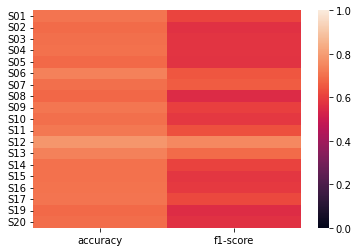

     class0 f1-score  class1 f1-score
S01         0.823970         0.145455
S02         0.815603         0.037037
S03         0.822742         0.000000
S04         0.823899         0.000000
S05         0.814286         0.000000
S06         0.844595         0.148148
S07         0.802867         0.337349
S08         0.810289         0.000000
S09         0.831250         0.035714
S10         0.819048         0.065574
S11         0.831541         0.145455
S12         0.862319         0.500000
S13         0.833922         0.373333
S14         0.820000         0.129032
S15         0.822006         0.035088
S16         0.825806         0.035714
S17         0.826087         0.142857
S19         0.812903         0.000000
S20         0.819672         0.000000


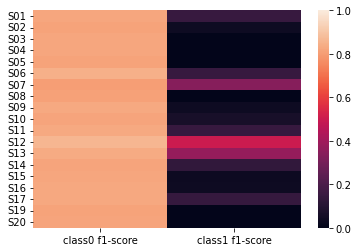

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [11]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [12]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

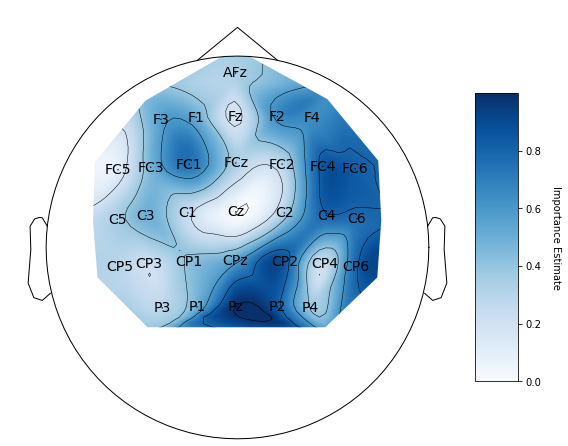

In [14]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)